In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Directorios de los datasets
train_dir = "../datos/train"
val_dir = "../datos/val"
test_dir = "../datos/test"

In [3]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    #Normalización y preprocesado
    rescale=1.0/255,
    #Transformaciones geométricas
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.2,  # Desplazamiento horizontal del 10%
    height_shift_range=0.2,  # Desplazamiento vertical del 10%
    shear_range=0.3,  # Transformación de cizallamiento del 10%
    zoom_range=0.3,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    channel_shift_range=50.0,  # Cambios fuertes en el color
    # Transformaciones de color e intensidad
    brightness_range=[0.05, 1.5],  # Ajuste de brillo entre 0.1 y 1.0
)
 #evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.


Found 2000 images belonging to 4 classes.


Found 800 images belonging to 4 classes.


In [4]:
# Cargar modelo preentrenado MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelamos las capas del modelo base

In [5]:
# Construcción del modelo
x = base_model.layers[-39].output #Equivalent to four (4) CORE block deduction.

# Capa convolucional
x = Conv2D(filters=192, kernel_size=8, strides=1, padding='valid',
           activation='selu', kernel_initializer='lecun_normal')(x)

# Capa de Average Pooling 
x = AveragePooling2D(pool_size=1, strides=1, padding='valid')(x)

# Global Average Pooling para reducir dimensiones antes de la capa densa
x = GlobalAveragePooling2D()(x)

# Capa fully connected
x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  # 512 neuronas

# Dropout ajustado 
x = AlphaDropout(0.3)(x)  # Reducimos sobreajuste apagando el 20% de las neuronas

# Capa de salida con 4 clases y activación softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=base_model.input, outputs=outputs)

In [6]:
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               


                                )]                                                                


 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                


                                )                                                                 


 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  


                                )                                                                 


 Conv1_relu (ReLU)              (None, 112, 112, 32  0           ['bn_Conv1[0][0]']               


                                )                                                                 


 expanded_conv_depthwise (Depth  (None, 112, 112, 32  288        ['Conv1_relu[0][0]']             


 wiseConv2D)                    )                                                                 


 expanded_conv_depthwise_BN (Ba  (None, 112, 112, 32  128        ['expanded_conv_depthwise[0][0]']


 tchNormalization)              )                                                                 


 expanded_conv_depthwise_relu (  (None, 112, 112, 32  0          ['expanded_conv_depthwise_BN[0][0


 ReLU)                          )                                ]']                              


 expanded_conv_project (Conv2D)  (None, 112, 112, 16  512        ['expanded_conv_depthwise_relu[0]


                                )                                [0]']                            


 expanded_conv_project_BN (Batc  (None, 112, 112, 16  64         ['expanded_conv_project[0][0]']  


 hNormalization)                )                                                                 


 block_1_expand (Conv2D)        (None, 112, 112, 96  1536        ['expanded_conv_project_BN[0][0]'


                                )                                ]                                


 block_1_expand_BN (BatchNormal  (None, 112, 112, 96  384        ['block_1_expand[0][0]']         


 ization)                       )                                                                 


 block_1_expand_relu (ReLU)     (None, 112, 112, 96  0           ['block_1_expand_BN[0][0]']      


                                )                                                                 


 block_1_pad (ZeroPadding2D)    (None, 113, 113, 96  0           ['block_1_expand_relu[0][0]']    


                                )                                                                 


 block_1_depthwise (DepthwiseCo  (None, 56, 56, 96)  864         ['block_1_pad[0][0]']            


 nv2D)                                                                                            


 block_1_depthwise_BN (BatchNor  (None, 56, 56, 96)  384         ['block_1_depthwise[0][0]']      


 malization)                                                                                      


 block_1_depthwise_relu (ReLU)  (None, 56, 56, 96)   0           ['block_1_depthwise_BN[0][0]']   


 block_1_project (Conv2D)       (None, 56, 56, 24)   2304        ['block_1_depthwise_relu[0][0]'] 


 block_1_project_BN (BatchNorma  (None, 56, 56, 24)  96          ['block_1_project[0][0]']        


 lization)                                                                                        


 block_2_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_1_project_BN[0][0]']     


 block_2_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_2_expand[0][0]']         


 ization)                                                                                         


 block_2_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_2_expand_BN[0][0]']      


 block_2_depthwise (DepthwiseCo  (None, 56, 56, 144)  1296       ['block_2_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_2_depthwise_BN (BatchNor  (None, 56, 56, 144)  576        ['block_2_depthwise[0][0]']      


 malization)                                                                                      


 block_2_depthwise_relu (ReLU)  (None, 56, 56, 144)  0           ['block_2_depthwise_BN[0][0]']   


 block_2_project (Conv2D)       (None, 56, 56, 24)   3456        ['block_2_depthwise_relu[0][0]'] 


 block_2_project_BN (BatchNorma  (None, 56, 56, 24)  96          ['block_2_project[0][0]']        


 lization)                                                                                        


 block_2_add (Add)              (None, 56, 56, 24)   0           ['block_1_project_BN[0][0]',     


                                                                  'block_2_project_BN[0][0]']     


 block_3_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_2_add[0][0]']            


 block_3_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_3_expand[0][0]']         


 ization)                                                                                         


 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      


 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    


 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            


 nv2D)                                                                                            


 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      


 malization)                                                                                      


 block_3_depthwise_relu (ReLU)  (None, 28, 28, 144)  0           ['block_3_depthwise_BN[0][0]']   


 block_3_project (Conv2D)       (None, 28, 28, 32)   4608        ['block_3_depthwise_relu[0][0]'] 


 block_3_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_3_project[0][0]']        


 lization)                                                                                        


 block_4_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_3_project_BN[0][0]']     


 block_4_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_4_expand[0][0]']         


 ization)                                                                                         


 block_4_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_4_expand_BN[0][0]']      


 block_4_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_4_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_4_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_4_depthwise[0][0]']      


 malization)                                                                                      


 block_4_depthwise_relu (ReLU)  (None, 28, 28, 192)  0           ['block_4_depthwise_BN[0][0]']   


 block_4_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_4_depthwise_relu[0][0]'] 


 block_4_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_4_project[0][0]']        


 lization)                                                                                        


 block_4_add (Add)              (None, 28, 28, 32)   0           ['block_3_project_BN[0][0]',     


                                                                  'block_4_project_BN[0][0]']     


 block_5_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_4_add[0][0]']            


 block_5_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_5_expand[0][0]']         


 ization)                                                                                         


 block_5_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_5_expand_BN[0][0]']      


 block_5_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_5_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_5_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_5_depthwise[0][0]']      


 malization)                                                                                      


 block_5_depthwise_relu (ReLU)  (None, 28, 28, 192)  0           ['block_5_depthwise_BN[0][0]']   


 block_5_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_5_depthwise_relu[0][0]'] 


 block_5_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_5_project[0][0]']        


 lization)                                                                                        


 block_5_add (Add)              (None, 28, 28, 32)   0           ['block_4_add[0][0]',            


                                                                  'block_5_project_BN[0][0]']     


 block_6_expand (Conv2D)        (None, 28, 28, 192)  6144        ['block_5_add[0][0]']            


 block_6_expand_BN (BatchNormal  (None, 28, 28, 192)  768        ['block_6_expand[0][0]']         


 ization)                                                                                         


 block_6_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_6_expand_BN[0][0]']      


 block_6_pad (ZeroPadding2D)    (None, 29, 29, 192)  0           ['block_6_expand_relu[0][0]']    


 block_6_depthwise (DepthwiseCo  (None, 14, 14, 192)  1728       ['block_6_pad[0][0]']            


 nv2D)                                                                                            


 block_6_depthwise_BN (BatchNor  (None, 14, 14, 192)  768        ['block_6_depthwise[0][0]']      


 malization)                                                                                      


 block_6_depthwise_relu (ReLU)  (None, 14, 14, 192)  0           ['block_6_depthwise_BN[0][0]']   


 block_6_project (Conv2D)       (None, 14, 14, 64)   12288       ['block_6_depthwise_relu[0][0]'] 


 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        


 lization)                                                                                        


 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     


 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         


 ization)                                                                                         


 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      


 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_7_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_7_depthwise[0][0]']      


 malization)                                                                                      


 block_7_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_7_depthwise_BN[0][0]']   


 block_7_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_7_depthwise_relu[0][0]'] 


 block_7_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_7_project[0][0]']        


 lization)                                                                                        


 block_7_add (Add)              (None, 14, 14, 64)   0           ['block_6_project_BN[0][0]',     


                                                                  'block_7_project_BN[0][0]']     


 block_8_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_7_add[0][0]']            


 block_8_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_8_expand[0][0]']         


 ization)                                                                                         


 block_8_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_8_expand_BN[0][0]']      


 block_8_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_8_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_8_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_8_depthwise[0][0]']      


 malization)                                                                                      


 block_8_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_8_depthwise_BN[0][0]']   


 block_8_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_8_depthwise_relu[0][0]'] 


 block_8_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_8_project[0][0]']        


 lization)                                                                                        


 block_8_add (Add)              (None, 14, 14, 64)   0           ['block_7_add[0][0]',            


                                                                  'block_8_project_BN[0][0]']     


 block_9_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_8_add[0][0]']            


 block_9_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_9_expand[0][0]']         


 ization)                                                                                         


 block_9_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_9_expand_BN[0][0]']      


 block_9_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_9_expand_relu[0][0]']    


 nv2D)                                                                                            


 block_9_depthwise_BN (BatchNor  (None, 14, 14, 384)  1536       ['block_9_depthwise[0][0]']      


 malization)                                                                                      


 block_9_depthwise_relu (ReLU)  (None, 14, 14, 384)  0           ['block_9_depthwise_BN[0][0]']   


 block_9_project (Conv2D)       (None, 14, 14, 64)   24576       ['block_9_depthwise_relu[0][0]'] 


 block_9_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_9_project[0][0]']        


 lization)                                                                                        


 block_9_add (Add)              (None, 14, 14, 64)   0           ['block_8_add[0][0]',            


                                                                  'block_9_project_BN[0][0]']     


 block_10_expand (Conv2D)       (None, 14, 14, 384)  24576       ['block_9_add[0][0]']            


 block_10_expand_BN (BatchNorma  (None, 14, 14, 384)  1536       ['block_10_expand[0][0]']        


 lization)                                                                                        


 block_10_expand_relu (ReLU)    (None, 14, 14, 384)  0           ['block_10_expand_BN[0][0]']     


 block_10_depthwise (DepthwiseC  (None, 14, 14, 384)  3456       ['block_10_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     


 rmalization)                                                                                     


 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  


 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']


 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       


 alization)                                                                                       


 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    


 block_11_expand_BN (BatchNorma  (None, 14, 14, 576)  2304       ['block_11_expand[0][0]']        


 lization)                                                                                        


 block_11_expand_relu (ReLU)    (None, 14, 14, 576)  0           ['block_11_expand_BN[0][0]']     


 block_11_depthwise (DepthwiseC  (None, 14, 14, 576)  5184       ['block_11_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_11_depthwise_BN (BatchNo  (None, 14, 14, 576)  2304       ['block_11_depthwise[0][0]']     


 rmalization)                                                                                     


 block_11_depthwise_relu (ReLU)  (None, 14, 14, 576)  0          ['block_11_depthwise_BN[0][0]']  


 block_11_project (Conv2D)      (None, 14, 14, 96)   55296       ['block_11_depthwise_relu[0][0]']


 block_11_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_11_project[0][0]']       


 alization)                                                                                       


 block_11_add (Add)             (None, 14, 14, 96)   0           ['block_10_project_BN[0][0]',    


                                                                  'block_11_project_BN[0][0]']    


 block_12_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_11_add[0][0]']           


 block_12_expand_BN (BatchNorma  (None, 14, 14, 576)  2304       ['block_12_expand[0][0]']        


 lization)                                                                                        


 block_12_expand_relu (ReLU)    (None, 14, 14, 576)  0           ['block_12_expand_BN[0][0]']     


 block_12_depthwise (DepthwiseC  (None, 14, 14, 576)  5184       ['block_12_expand_relu[0][0]']   


 onv2D)                                                                                           


 block_12_depthwise_BN (BatchNo  (None, 14, 14, 576)  2304       ['block_12_depthwise[0][0]']     


 rmalization)                                                                                     


 block_12_depthwise_relu (ReLU)  (None, 14, 14, 576)  0          ['block_12_depthwise_BN[0][0]']  


 block_12_project (Conv2D)      (None, 14, 14, 96)   55296       ['block_12_depthwise_relu[0][0]']


 block_12_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_12_project[0][0]']       


 alization)                                                                                       


 block_12_add (Add)             (None, 14, 14, 96)   0           ['block_11_add[0][0]',           


                                                                  'block_12_project_BN[0][0]']    


 conv2d (Conv2D)                (None, 7, 7, 192)    1179840     ['block_12_add[0][0]']           


 average_pooling2d (AveragePool  (None, 7, 7, 192)   0           ['conv2d[0][0]']                 


 ing2D)                                                                                           


 global_average_pooling2d (Glob  (None, 192)         0           ['average_pooling2d[0][0]']      


 alAveragePooling2D)                                                                              


 dense (Dense)                  (None, 512)          98816       ['global_average_pooling2d[0][0]'


                                                                 ]                                


 alpha_dropout (AlphaDropout)   (None, 512)          0           ['dense[0][0]']                  


 dense_1 (Dense)                (None, 4)            2052        ['alpha_dropout[0][0]']          


Total params: 1,839,364


Trainable params: 1,280,708


Non-trainable params: 558,656


__________________________________________________________________________________________________


In [7]:
# Compilación del modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #con funcion de perdida porque es multiclase

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv2_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # Reduce LR si no hay mejora en 2 épocas

In [9]:
# Entrenamiento del modelo
epochs = 500 #puede detenerse antes si no mejora la validacion
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500



  1/400 [..............................] - ETA: 22:27 - loss: 2.1383 - accuracy: 0.2500


  3/400 [..............................] - ETA: 21s - loss: 1.7816 - accuracy: 0.2917  


  4/400 [..............................] - ETA: 22s - loss: 1.9324 - accuracy: 0.3125


  5/400 [..............................] - ETA: 27s - loss: 1.8652 - accuracy: 0.3000


  6/400 [..............................] - ETA: 28s - loss: 1.7533 - accuracy: 0.3542


  7/400 [..............................] - ETA: 29s - loss: 1.7479 - accuracy: 0.3750


  8/400 [..............................] - ETA: 28s - loss: 1.8649 - accuracy: 0.3281


  9/400 [..............................] - ETA: 29s - loss: 1.9780 - accuracy: 0.2917


 10/400 [..............................] - ETA: 29s - loss: 2.0061 - accuracy: 0.3125


 11/400 [..............................] - ETA: 30s - loss: 2.0488 - accuracy: 0.3068


 12/400 [..............................] - ETA: 29s - loss: 2.0211 - accuracy: 0.3021


 13/400 [..............................] - ETA: 29s - loss: 2.0149 - accuracy: 0.2981


 14/400 [>.............................] - ETA: 30s - loss: 1.9798 - accuracy: 0.3036


 15/400 [>.............................] - ETA: 30s - loss: 2.0266 - accuracy: 0.2833


 16/400 [>.............................] - ETA: 30s - loss: 2.0286 - accuracy: 0.2734


 17/400 [>.............................] - ETA: 30s - loss: 2.0188 - accuracy: 0.2721


 18/400 [>.............................] - ETA: 29s - loss: 1.9725 - accuracy: 0.2986


 19/400 [>.............................] - ETA: 30s - loss: 1.9670 - accuracy: 0.2895


 20/400 [>.............................] - ETA: 29s - loss: 1.9354 - accuracy: 0.2937


 21/400 [>.............................] - ETA: 29s - loss: 1.9170 - accuracy: 0.2976


 22/400 [>.............................] - ETA: 30s - loss: 1.9114 - accuracy: 0.2955


 23/400 [>.............................] - ETA: 29s - loss: 1.8761 - accuracy: 0.3098


 24/400 [>.............................] - ETA: 29s - loss: 1.8685 - accuracy: 0.3073


 25/400 [>.............................] - ETA: 29s - loss: 1.8459 - accuracy: 0.3150


 26/400 [>.............................] - ETA: 29s - loss: 1.8456 - accuracy: 0.3125


 27/400 [=>............................] - ETA: 30s - loss: 1.8499 - accuracy: 0.3056


 28/400 [=>............................] - ETA: 30s - loss: 1.8437 - accuracy: 0.3036


 29/400 [=>............................] - ETA: 30s - loss: 1.8282 - accuracy: 0.3060


 30/400 [=>............................] - ETA: 29s - loss: 1.8308 - accuracy: 0.3042


 31/400 [=>............................] - ETA: 29s - loss: 1.8409 - accuracy: 0.2984


 32/400 [=>............................] - ETA: 29s - loss: 1.8538 - accuracy: 0.2930


 33/400 [=>............................] - ETA: 29s - loss: 1.8353 - accuracy: 0.2955


 34/400 [=>............................] - ETA: 29s - loss: 1.8419 - accuracy: 0.2941


 35/400 [=>............................] - ETA: 29s - loss: 1.8159 - accuracy: 0.2964


 36/400 [=>............................] - ETA: 29s - loss: 1.8184 - accuracy: 0.2986


 37/400 [=>............................] - ETA: 29s - loss: 1.8157 - accuracy: 0.3007


 38/400 [=>............................] - ETA: 29s - loss: 1.8230 - accuracy: 0.2961


 39/400 [=>............................] - ETA: 29s - loss: 1.8041 - accuracy: 0.2981


 40/400 [==>...........................] - ETA: 29s - loss: 1.7916 - accuracy: 0.3000


 41/400 [==>...........................] - ETA: 29s - loss: 1.7745 - accuracy: 0.3018


 42/400 [==>...........................] - ETA: 29s - loss: 1.7556 - accuracy: 0.3095


 43/400 [==>...........................] - ETA: 29s - loss: 1.7697 - accuracy: 0.3081


 44/400 [==>...........................] - ETA: 29s - loss: 1.7686 - accuracy: 0.3068


 45/400 [==>...........................] - ETA: 28s - loss: 1.7569 - accuracy: 0.3111


 46/400 [==>...........................] - ETA: 29s - loss: 1.7559 - accuracy: 0.3098


 47/400 [==>...........................] - ETA: 29s - loss: 1.7582 - accuracy: 0.3112


 48/400 [==>...........................] - ETA: 28s - loss: 1.7458 - accuracy: 0.3177


 49/400 [==>...........................] - ETA: 28s - loss: 1.7498 - accuracy: 0.3138


 50/400 [==>...........................] - ETA: 28s - loss: 1.7427 - accuracy: 0.3125


 51/400 [==>...........................] - ETA: 28s - loss: 1.7439 - accuracy: 0.3113


 52/400 [==>...........................] - ETA: 28s - loss: 1.7364 - accuracy: 0.3125


 53/400 [==>...........................] - ETA: 28s - loss: 1.7213 - accuracy: 0.3184


 54/400 [===>..........................] - ETA: 28s - loss: 1.7095 - accuracy: 0.3241


 55/400 [===>..........................] - ETA: 28s - loss: 1.7022 - accuracy: 0.3273


 56/400 [===>..........................] - ETA: 28s - loss: 1.6848 - accuracy: 0.3371


 57/400 [===>..........................] - ETA: 28s - loss: 1.6831 - accuracy: 0.3355


 58/400 [===>..........................] - ETA: 28s - loss: 1.6838 - accuracy: 0.3362


 59/400 [===>..........................] - ETA: 28s - loss: 1.6766 - accuracy: 0.3347


 60/400 [===>..........................] - ETA: 28s - loss: 1.6674 - accuracy: 0.3375


 61/400 [===>..........................] - ETA: 27s - loss: 1.6663 - accuracy: 0.3381


 62/400 [===>..........................] - ETA: 27s - loss: 1.6707 - accuracy: 0.3387


 63/400 [===>..........................] - ETA: 28s - loss: 1.6617 - accuracy: 0.3413


 64/400 [===>..........................] - ETA: 27s - loss: 1.6508 - accuracy: 0.3457


 65/400 [===>..........................] - ETA: 27s - loss: 1.6335 - accuracy: 0.3538


 66/400 [===>..........................] - ETA: 27s - loss: 1.6305 - accuracy: 0.3561


 67/400 [====>.........................] - ETA: 27s - loss: 1.6207 - accuracy: 0.3601


 68/400 [====>.........................] - ETA: 27s - loss: 1.6206 - accuracy: 0.3585


 69/400 [====>.........................] - ETA: 27s - loss: 1.6192 - accuracy: 0.3587


 70/400 [====>.........................] - ETA: 27s - loss: 1.6179 - accuracy: 0.3607


 71/400 [====>.........................] - ETA: 27s - loss: 1.6234 - accuracy: 0.3574


 72/400 [====>.........................] - ETA: 27s - loss: 1.6207 - accuracy: 0.3559


 73/400 [====>.........................] - ETA: 27s - loss: 1.6134 - accuracy: 0.3579


 74/400 [====>.........................] - ETA: 27s - loss: 1.6043 - accuracy: 0.3632


 75/400 [====>.........................] - ETA: 27s - loss: 1.6022 - accuracy: 0.3650


 76/400 [====>.........................] - ETA: 26s - loss: 1.6011 - accuracy: 0.3668


 77/400 [====>.........................] - ETA: 26s - loss: 1.6067 - accuracy: 0.3636


 78/400 [====>.........................] - ETA: 26s - loss: 1.6184 - accuracy: 0.3622


 79/400 [====>.........................] - ETA: 26s - loss: 1.6116 - accuracy: 0.3671


 80/400 [=====>........................] - ETA: 26s - loss: 1.6054 - accuracy: 0.3656


 81/400 [=====>........................] - ETA: 26s - loss: 1.6012 - accuracy: 0.3642


 82/400 [=====>........................] - ETA: 26s - loss: 1.5942 - accuracy: 0.3659


 83/400 [=====>........................] - ETA: 26s - loss: 1.5832 - accuracy: 0.3705


 84/400 [=====>........................] - ETA: 26s - loss: 1.5800 - accuracy: 0.3720


 85/400 [=====>........................] - ETA: 26s - loss: 1.5722 - accuracy: 0.3750


 86/400 [=====>........................] - ETA: 26s - loss: 1.5675 - accuracy: 0.3765


 87/400 [=====>........................] - ETA: 26s - loss: 1.5644 - accuracy: 0.3779


 88/400 [=====>........................] - ETA: 25s - loss: 1.5624 - accuracy: 0.3821


 89/400 [=====>........................] - ETA: 25s - loss: 1.5521 - accuracy: 0.3876


 90/400 [=====>........................] - ETA: 25s - loss: 1.5511 - accuracy: 0.3875


 91/400 [=====>........................] - ETA: 25s - loss: 1.5490 - accuracy: 0.3860


 92/400 [=====>........................] - ETA: 25s - loss: 1.5481 - accuracy: 0.3886


 93/400 [=====>........................] - ETA: 25s - loss: 1.5410 - accuracy: 0.3911


 94/400 [======>.......................] - ETA: 25s - loss: 1.5269 - accuracy: 0.3976


 95/400 [======>.......................] - ETA: 25s - loss: 1.5243 - accuracy: 0.3987


 96/400 [======>.......................] - ETA: 25s - loss: 1.5175 - accuracy: 0.4010


 97/400 [======>.......................] - ETA: 25s - loss: 1.5235 - accuracy: 0.3982


 98/400 [======>.......................] - ETA: 25s - loss: 1.5153 - accuracy: 0.4005


 99/400 [======>.......................] - ETA: 25s - loss: 1.5076 - accuracy: 0.4040


100/400 [======>.......................] - ETA: 24s - loss: 1.5052 - accuracy: 0.4038


101/400 [======>.......................] - ETA: 24s - loss: 1.5019 - accuracy: 0.4047


102/400 [======>.......................] - ETA: 24s - loss: 1.4981 - accuracy: 0.4056


103/400 [======>.......................] - ETA: 24s - loss: 1.4909 - accuracy: 0.4066


104/400 [======>.......................] - ETA: 24s - loss: 1.4969 - accuracy: 0.4038


105/400 [======>.......................] - ETA: 24s - loss: 1.4983 - accuracy: 0.4048


106/400 [======>.......................] - ETA: 24s - loss: 1.4918 - accuracy: 0.4092


107/400 [=======>......................] - ETA: 24s - loss: 1.4901 - accuracy: 0.4089


108/400 [=======>......................] - ETA: 24s - loss: 1.4862 - accuracy: 0.4097


109/400 [=======>......................] - ETA: 24s - loss: 1.4855 - accuracy: 0.4083


110/400 [=======>......................] - ETA: 24s - loss: 1.4791 - accuracy: 0.4091


111/400 [=======>......................] - ETA: 24s - loss: 1.4764 - accuracy: 0.4099


112/400 [=======>......................] - ETA: 23s - loss: 1.4708 - accuracy: 0.4129


113/400 [=======>......................] - ETA: 23s - loss: 1.4638 - accuracy: 0.4159


114/400 [=======>......................] - ETA: 23s - loss: 1.4586 - accuracy: 0.4156


115/400 [=======>......................] - ETA: 23s - loss: 1.4568 - accuracy: 0.4163


116/400 [=======>......................] - ETA: 23s - loss: 1.4530 - accuracy: 0.4192


117/400 [=======>......................] - ETA: 23s - loss: 1.4546 - accuracy: 0.4188


118/400 [=======>......................] - ETA: 23s - loss: 1.4545 - accuracy: 0.4195


119/400 [=======>......................] - ETA: 23s - loss: 1.4501 - accuracy: 0.4202


120/400 [========>.....................] - ETA: 23s - loss: 1.4442 - accuracy: 0.4229


121/400 [========>.....................] - ETA: 23s - loss: 1.4404 - accuracy: 0.4246


122/400 [========>.....................] - ETA: 23s - loss: 1.4409 - accuracy: 0.4242


123/400 [========>.....................] - ETA: 22s - loss: 1.4353 - accuracy: 0.4258


124/400 [========>.....................] - ETA: 22s - loss: 1.4303 - accuracy: 0.4264


125/400 [========>.....................] - ETA: 22s - loss: 1.4341 - accuracy: 0.4250


126/400 [========>.....................] - ETA: 22s - loss: 1.4283 - accuracy: 0.4286


127/400 [========>.....................] - ETA: 22s - loss: 1.4220 - accuracy: 0.4321


128/400 [========>.....................] - ETA: 22s - loss: 1.4149 - accuracy: 0.4355


129/400 [========>.....................] - ETA: 22s - loss: 1.4118 - accuracy: 0.4370


130/400 [========>.....................] - ETA: 22s - loss: 1.4146 - accuracy: 0.4356


131/400 [========>.....................] - ETA: 22s - loss: 1.4104 - accuracy: 0.4361


132/400 [========>.....................] - ETA: 22s - loss: 1.4097 - accuracy: 0.4366


133/400 [========>.....................] - ETA: 22s - loss: 1.4057 - accuracy: 0.4380


134/400 [=========>....................] - ETA: 22s - loss: 1.4027 - accuracy: 0.4394


135/400 [=========>....................] - ETA: 21s - loss: 1.3985 - accuracy: 0.4417


137/400 [=========>....................] - ETA: 21s - loss: 1.3904 - accuracy: 0.4434


138/400 [=========>....................] - ETA: 21s - loss: 1.3860 - accuracy: 0.4447


139/400 [=========>....................] - ETA: 21s - loss: 1.3814 - accuracy: 0.4469


140/400 [=========>....................] - ETA: 21s - loss: 1.3823 - accuracy: 0.4455


141/400 [=========>....................] - ETA: 21s - loss: 1.3799 - accuracy: 0.4468


142/400 [=========>....................] - ETA: 21s - loss: 1.3793 - accuracy: 0.4463


143/400 [=========>....................] - ETA: 21s - loss: 1.3785 - accuracy: 0.4449


144/400 [=========>....................] - ETA: 21s - loss: 1.3736 - accuracy: 0.4479


145/400 [=========>....................] - ETA: 21s - loss: 1.3732 - accuracy: 0.4474


146/400 [=========>....................] - ETA: 21s - loss: 1.3738 - accuracy: 0.4478


147/400 [==========>...................] - ETA: 20s - loss: 1.3728 - accuracy: 0.4481


148/400 [==========>...................] - ETA: 20s - loss: 1.3685 - accuracy: 0.4510


149/400 [==========>...................] - ETA: 20s - loss: 1.3702 - accuracy: 0.4513


150/400 [==========>...................] - ETA: 20s - loss: 1.3677 - accuracy: 0.4517


151/400 [==========>...................] - ETA: 20s - loss: 1.3661 - accuracy: 0.4520


152/400 [==========>...................] - ETA: 20s - loss: 1.3634 - accuracy: 0.4523


153/400 [==========>...................] - ETA: 20s - loss: 1.3598 - accuracy: 0.4534


154/400 [==========>...................] - ETA: 20s - loss: 1.3608 - accuracy: 0.4537


155/400 [==========>...................] - ETA: 20s - loss: 1.3589 - accuracy: 0.4540


156/400 [==========>...................] - ETA: 20s - loss: 1.3577 - accuracy: 0.4543


157/400 [==========>...................] - ETA: 20s - loss: 1.3502 - accuracy: 0.4578


158/400 [==========>...................] - ETA: 20s - loss: 1.3458 - accuracy: 0.4597


159/400 [==========>...................] - ETA: 19s - loss: 1.3440 - accuracy: 0.4599


160/400 [===========>..................] - ETA: 19s - loss: 1.3406 - accuracy: 0.4617


161/400 [===========>..................] - ETA: 19s - loss: 1.3368 - accuracy: 0.4627


162/400 [===========>..................] - ETA: 19s - loss: 1.3357 - accuracy: 0.4622


163/400 [===========>..................] - ETA: 19s - loss: 1.3328 - accuracy: 0.4632


164/400 [===========>..................] - ETA: 19s - loss: 1.3295 - accuracy: 0.4649


165/400 [===========>..................] - ETA: 19s - loss: 1.3309 - accuracy: 0.4652


166/400 [===========>..................] - ETA: 19s - loss: 1.3298 - accuracy: 0.4661


167/400 [===========>..................] - ETA: 19s - loss: 1.3274 - accuracy: 0.4671


168/400 [===========>..................] - ETA: 19s - loss: 1.3246 - accuracy: 0.4680


169/400 [===========>..................] - ETA: 19s - loss: 1.3205 - accuracy: 0.4704


170/400 [===========>..................] - ETA: 19s - loss: 1.3206 - accuracy: 0.4699


171/400 [===========>..................] - ETA: 19s - loss: 1.3186 - accuracy: 0.4693


172/400 [===========>..................] - ETA: 18s - loss: 1.3164 - accuracy: 0.4695


173/400 [===========>..................] - ETA: 18s - loss: 1.3129 - accuracy: 0.4704


174/400 [============>.................] - ETA: 18s - loss: 1.3098 - accuracy: 0.4705


175/400 [============>.................] - ETA: 18s - loss: 1.3090 - accuracy: 0.4700


176/400 [============>.................] - ETA: 18s - loss: 1.3052 - accuracy: 0.4716


177/400 [============>.................] - ETA: 18s - loss: 1.3038 - accuracy: 0.4718


178/400 [============>.................] - ETA: 18s - loss: 1.3025 - accuracy: 0.4719


179/400 [============>.................] - ETA: 18s - loss: 1.3001 - accuracy: 0.4721


180/400 [============>.................] - ETA: 18s - loss: 1.2955 - accuracy: 0.4736


181/400 [============>.................] - ETA: 18s - loss: 1.2943 - accuracy: 0.4744


182/400 [============>.................] - ETA: 18s - loss: 1.2922 - accuracy: 0.4753


183/400 [============>.................] - ETA: 18s - loss: 1.2889 - accuracy: 0.4768


184/400 [============>.................] - ETA: 17s - loss: 1.2886 - accuracy: 0.4769


185/400 [============>.................] - ETA: 17s - loss: 1.2896 - accuracy: 0.4770


186/400 [============>.................] - ETA: 17s - loss: 1.2873 - accuracy: 0.4785


187/400 [=============>................] - ETA: 17s - loss: 1.2853 - accuracy: 0.4793


188/400 [=============>................] - ETA: 17s - loss: 1.2820 - accuracy: 0.4814


189/400 [=============>................] - ETA: 17s - loss: 1.2808 - accuracy: 0.4821


190/400 [=============>................] - ETA: 17s - loss: 1.2763 - accuracy: 0.4836


191/400 [=============>................] - ETA: 17s - loss: 1.2752 - accuracy: 0.4843


192/400 [=============>................] - ETA: 17s - loss: 1.2745 - accuracy: 0.4844


193/400 [=============>................] - ETA: 17s - loss: 1.2707 - accuracy: 0.4864


194/400 [=============>................] - ETA: 17s - loss: 1.2702 - accuracy: 0.4858


195/400 [=============>................] - ETA: 17s - loss: 1.2666 - accuracy: 0.4878


196/400 [=============>................] - ETA: 16s - loss: 1.2661 - accuracy: 0.4885


197/400 [=============>................] - ETA: 16s - loss: 1.2616 - accuracy: 0.4905


198/400 [=============>................] - ETA: 16s - loss: 1.2581 - accuracy: 0.4918


199/400 [=============>................] - ETA: 16s - loss: 1.2558 - accuracy: 0.4925


200/400 [==============>...............] - ETA: 16s - loss: 1.2521 - accuracy: 0.4938


201/400 [==============>...............] - ETA: 16s - loss: 1.2522 - accuracy: 0.4938


202/400 [==============>...............] - ETA: 16s - loss: 1.2511 - accuracy: 0.4944


203/400 [==============>...............] - ETA: 16s - loss: 1.2477 - accuracy: 0.4957


204/400 [==============>...............] - ETA: 16s - loss: 1.2460 - accuracy: 0.4957


205/400 [==============>...............] - ETA: 16s - loss: 1.2484 - accuracy: 0.4951


206/400 [==============>...............] - ETA: 16s - loss: 1.2458 - accuracy: 0.4964


207/400 [==============>...............] - ETA: 16s - loss: 1.2446 - accuracy: 0.4970


208/400 [==============>...............] - ETA: 15s - loss: 1.2400 - accuracy: 0.4994


209/400 [==============>...............] - ETA: 15s - loss: 1.2377 - accuracy: 0.5012


210/400 [==============>...............] - ETA: 15s - loss: 1.2363 - accuracy: 0.5012


211/400 [==============>...............] - ETA: 15s - loss: 1.2361 - accuracy: 0.5018


212/400 [==============>...............] - ETA: 15s - loss: 1.2347 - accuracy: 0.5018


213/400 [==============>...............] - ETA: 15s - loss: 1.2317 - accuracy: 0.5018


214/400 [===============>..............] - ETA: 15s - loss: 1.2290 - accuracy: 0.5029


215/400 [===============>..............] - ETA: 15s - loss: 1.2258 - accuracy: 0.5041


216/400 [===============>..............] - ETA: 15s - loss: 1.2223 - accuracy: 0.5052


217/400 [===============>..............] - ETA: 15s - loss: 1.2223 - accuracy: 0.5058


218/400 [===============>..............] - ETA: 15s - loss: 1.2228 - accuracy: 0.5052


219/400 [===============>..............] - ETA: 15s - loss: 1.2188 - accuracy: 0.5068


220/400 [===============>..............] - ETA: 14s - loss: 1.2161 - accuracy: 0.5068


221/400 [===============>..............] - ETA: 14s - loss: 1.2133 - accuracy: 0.5079


222/400 [===============>..............] - ETA: 14s - loss: 1.2117 - accuracy: 0.5084


223/400 [===============>..............] - ETA: 14s - loss: 1.2094 - accuracy: 0.5095


224/400 [===============>..............] - ETA: 14s - loss: 1.2064 - accuracy: 0.5106


225/400 [===============>..............] - ETA: 14s - loss: 1.2024 - accuracy: 0.5122


226/400 [===============>..............] - ETA: 14s - loss: 1.1993 - accuracy: 0.5138


227/400 [================>.............] - ETA: 14s - loss: 1.1977 - accuracy: 0.5138


228/400 [================>.............] - ETA: 14s - loss: 1.1963 - accuracy: 0.5143


229/400 [================>.............] - ETA: 14s - loss: 1.1937 - accuracy: 0.5153


231/400 [================>.............] - ETA: 14s - loss: 1.1923 - accuracy: 0.5157


232/400 [================>.............] - ETA: 13s - loss: 1.1923 - accuracy: 0.5156


233/400 [================>.............] - ETA: 13s - loss: 1.1920 - accuracy: 0.5156


234/400 [================>.............] - ETA: 13s - loss: 1.1882 - accuracy: 0.5176


235/400 [================>.............] - ETA: 13s - loss: 1.1860 - accuracy: 0.5186


236/400 [================>.............] - ETA: 13s - loss: 1.1849 - accuracy: 0.5196


237/400 [================>.............] - ETA: 13s - loss: 1.1848 - accuracy: 0.5190


238/400 [================>.............] - ETA: 13s - loss: 1.1843 - accuracy: 0.5194


239/400 [================>.............] - ETA: 13s - loss: 1.1866 - accuracy: 0.5199


240/400 [=================>............] - ETA: 13s - loss: 1.1838 - accuracy: 0.5203


241/400 [=================>............] - ETA: 13s - loss: 1.1840 - accuracy: 0.5202


242/400 [=================>............] - ETA: 13s - loss: 1.1808 - accuracy: 0.5212


243/400 [=================>............] - ETA: 12s - loss: 1.1810 - accuracy: 0.5206


244/400 [=================>............] - ETA: 12s - loss: 1.1797 - accuracy: 0.5205


245/400 [=================>............] - ETA: 12s - loss: 1.1770 - accuracy: 0.5214


246/400 [=================>............] - ETA: 12s - loss: 1.1762 - accuracy: 0.5213


247/400 [=================>............] - ETA: 12s - loss: 1.1762 - accuracy: 0.5218


248/400 [=================>............] - ETA: 12s - loss: 1.1746 - accuracy: 0.5222


249/400 [=================>............] - ETA: 12s - loss: 1.1709 - accuracy: 0.5241


250/400 [=================>............] - ETA: 12s - loss: 1.1703 - accuracy: 0.5245


251/400 [=================>............] - ETA: 12s - loss: 1.1690 - accuracy: 0.5249


252/400 [=================>............] - ETA: 12s - loss: 1.1671 - accuracy: 0.5253


253/400 [=================>............] - ETA: 12s - loss: 1.1645 - accuracy: 0.5262


254/400 [==================>...........] - ETA: 12s - loss: 1.1621 - accuracy: 0.5276


255/400 [==================>...........] - ETA: 11s - loss: 1.1599 - accuracy: 0.5279


256/400 [==================>...........] - ETA: 11s - loss: 1.1583 - accuracy: 0.5283


257/400 [==================>...........] - ETA: 11s - loss: 1.1566 - accuracy: 0.5292


258/400 [==================>...........] - ETA: 11s - loss: 1.1555 - accuracy: 0.5300


259/400 [==================>...........] - ETA: 11s - loss: 1.1531 - accuracy: 0.5309


260/400 [==================>...........] - ETA: 11s - loss: 1.1507 - accuracy: 0.5322


261/400 [==================>...........] - ETA: 11s - loss: 1.1484 - accuracy: 0.5330


262/400 [==================>...........] - ETA: 11s - loss: 1.1468 - accuracy: 0.5344


263/400 [==================>...........] - ETA: 11s - loss: 1.1455 - accuracy: 0.5347


264/400 [==================>...........] - ETA: 11s - loss: 1.1448 - accuracy: 0.5346


265/400 [==================>...........] - ETA: 11s - loss: 1.1435 - accuracy: 0.5354


266/400 [==================>...........] - ETA: 11s - loss: 1.1420 - accuracy: 0.5357


267/400 [===================>..........] - ETA: 10s - loss: 1.1411 - accuracy: 0.5360


268/400 [===================>..........] - ETA: 10s - loss: 1.1408 - accuracy: 0.5359


269/400 [===================>..........] - ETA: 10s - loss: 1.1384 - accuracy: 0.5372


270/400 [===================>..........] - ETA: 10s - loss: 1.1368 - accuracy: 0.5375


271/400 [===================>..........] - ETA: 10s - loss: 1.1374 - accuracy: 0.5383


272/400 [===================>..........] - ETA: 10s - loss: 1.1350 - accuracy: 0.5395


273/400 [===================>..........] - ETA: 10s - loss: 1.1340 - accuracy: 0.5398


274/400 [===================>..........] - ETA: 10s - loss: 1.1328 - accuracy: 0.5406


275/400 [===================>..........] - ETA: 10s - loss: 1.1310 - accuracy: 0.5409


276/400 [===================>..........] - ETA: 10s - loss: 1.1292 - accuracy: 0.5417


277/400 [===================>..........] - ETA: 10s - loss: 1.1289 - accuracy: 0.5424


278/400 [===================>..........] - ETA: 10s - loss: 1.1287 - accuracy: 0.5427


279/400 [===================>..........] - ETA: 9s - loss: 1.1259 - accuracy: 0.5439 


280/400 [====================>.........] - ETA: 9s - loss: 1.1241 - accuracy: 0.5446


281/400 [====================>.........] - ETA: 9s - loss: 1.1217 - accuracy: 0.5454


282/400 [====================>.........] - ETA: 9s - loss: 1.1220 - accuracy: 0.5448


283/400 [====================>.........] - ETA: 9s - loss: 1.1219 - accuracy: 0.5446


284/400 [====================>.........] - ETA: 9s - loss: 1.1196 - accuracy: 0.5462


285/400 [====================>.........] - ETA: 9s - loss: 1.1181 - accuracy: 0.5465


286/400 [====================>.........] - ETA: 9s - loss: 1.1165 - accuracy: 0.5468


287/400 [====================>.........] - ETA: 9s - loss: 1.1167 - accuracy: 0.5466


288/400 [====================>.........] - ETA: 9s - loss: 1.1152 - accuracy: 0.5469


289/400 [====================>.........] - ETA: 9s - loss: 1.1128 - accuracy: 0.5476


290/400 [====================>.........] - ETA: 9s - loss: 1.1129 - accuracy: 0.5478


291/400 [====================>.........] - ETA: 9s - loss: 1.1122 - accuracy: 0.5481


292/400 [====================>.........] - ETA: 8s - loss: 1.1113 - accuracy: 0.5484


293/400 [====================>.........] - ETA: 8s - loss: 1.1085 - accuracy: 0.5495


294/400 [=====================>........] - ETA: 8s - loss: 1.1082 - accuracy: 0.5493


295/400 [=====================>........] - ETA: 8s - loss: 1.1053 - accuracy: 0.5504


296/400 [=====================>........] - ETA: 8s - loss: 1.1028 - accuracy: 0.5515


297/400 [=====================>........] - ETA: 8s - loss: 1.1029 - accuracy: 0.5518


298/400 [=====================>........] - ETA: 8s - loss: 1.1019 - accuracy: 0.5524


299/400 [=====================>........] - ETA: 8s - loss: 1.0999 - accuracy: 0.5535


300/400 [=====================>........] - ETA: 8s - loss: 1.0979 - accuracy: 0.5542


301/400 [=====================>........] - ETA: 8s - loss: 1.0971 - accuracy: 0.5544


302/400 [=====================>........] - ETA: 8s - loss: 1.0957 - accuracy: 0.5546


303/400 [=====================>........] - ETA: 8s - loss: 1.0953 - accuracy: 0.5545


304/400 [=====================>........] - ETA: 7s - loss: 1.0933 - accuracy: 0.5551


305/400 [=====================>........] - ETA: 7s - loss: 1.0914 - accuracy: 0.5557


306/400 [=====================>........] - ETA: 7s - loss: 1.0902 - accuracy: 0.5560


307/400 [======================>.......] - ETA: 7s - loss: 1.0886 - accuracy: 0.5566


308/400 [======================>.......] - ETA: 7s - loss: 1.0857 - accuracy: 0.5580


309/400 [======================>.......] - ETA: 7s - loss: 1.0861 - accuracy: 0.5574


310/400 [======================>.......] - ETA: 7s - loss: 1.0842 - accuracy: 0.5581


311/400 [======================>.......] - ETA: 7s - loss: 1.0814 - accuracy: 0.5595


312/400 [======================>.......] - ETA: 7s - loss: 1.0825 - accuracy: 0.5593


313/400 [======================>.......] - ETA: 7s - loss: 1.0824 - accuracy: 0.5595


314/400 [======================>.......] - ETA: 7s - loss: 1.0799 - accuracy: 0.5609


315/400 [======================>.......] - ETA: 7s - loss: 1.0776 - accuracy: 0.5619


316/400 [======================>.......] - ETA: 6s - loss: 1.0763 - accuracy: 0.5625


317/400 [======================>.......] - ETA: 6s - loss: 1.0757 - accuracy: 0.5631


318/400 [======================>.......] - ETA: 6s - loss: 1.0733 - accuracy: 0.5641


319/400 [======================>.......] - ETA: 6s - loss: 1.0716 - accuracy: 0.5643


320/400 [=======================>......] - ETA: 6s - loss: 1.0699 - accuracy: 0.5652


321/400 [=======================>......] - ETA: 6s - loss: 1.0679 - accuracy: 0.5662


322/400 [=======================>......] - ETA: 6s - loss: 1.0661 - accuracy: 0.5668


323/400 [=======================>......] - ETA: 6s - loss: 1.0641 - accuracy: 0.5677


324/400 [=======================>......] - ETA: 6s - loss: 1.0640 - accuracy: 0.5679


325/400 [=======================>......] - ETA: 6s - loss: 1.0655 - accuracy: 0.5677


326/400 [=======================>......] - ETA: 6s - loss: 1.0632 - accuracy: 0.5690


327/400 [=======================>......] - ETA: 6s - loss: 1.0623 - accuracy: 0.5696


328/400 [=======================>......] - ETA: 5s - loss: 1.0600 - accuracy: 0.5705


329/400 [=======================>......] - ETA: 5s - loss: 1.0579 - accuracy: 0.5714


330/400 [=======================>......] - ETA: 5s - loss: 1.0565 - accuracy: 0.5720


331/400 [=======================>......] - ETA: 5s - loss: 1.0563 - accuracy: 0.5718


332/400 [=======================>......] - ETA: 5s - loss: 1.0553 - accuracy: 0.5723


333/400 [=======================>......] - ETA: 5s - loss: 1.0537 - accuracy: 0.5728


334/400 [========================>.....] - ETA: 5s - loss: 1.0514 - accuracy: 0.5737


335/400 [========================>.....] - ETA: 5s - loss: 1.0501 - accuracy: 0.5739


336/400 [========================>.....] - ETA: 5s - loss: 1.0500 - accuracy: 0.5733


337/400 [========================>.....] - ETA: 5s - loss: 1.0481 - accuracy: 0.5742


338/400 [========================>.....] - ETA: 5s - loss: 1.0481 - accuracy: 0.5747


339/400 [========================>.....] - ETA: 5s - loss: 1.0477 - accuracy: 0.5749


340/400 [========================>.....] - ETA: 4s - loss: 1.0465 - accuracy: 0.5750


341/400 [========================>.....] - ETA: 4s - loss: 1.0444 - accuracy: 0.5759


342/400 [========================>.....] - ETA: 4s - loss: 1.0430 - accuracy: 0.5764


343/400 [========================>.....] - ETA: 4s - loss: 1.0416 - accuracy: 0.5769


344/400 [========================>.....] - ETA: 4s - loss: 1.0400 - accuracy: 0.5778


345/400 [========================>.....] - ETA: 4s - loss: 1.0377 - accuracy: 0.5790


346/400 [========================>.....] - ETA: 4s - loss: 1.0367 - accuracy: 0.5795


347/400 [=========================>....] - ETA: 4s - loss: 1.0353 - accuracy: 0.5803


348/400 [=========================>....] - ETA: 4s - loss: 1.0362 - accuracy: 0.5805


349/400 [=========================>....] - ETA: 4s - loss: 1.0345 - accuracy: 0.5813


350/400 [=========================>....] - ETA: 4s - loss: 1.0332 - accuracy: 0.5818


351/400 [=========================>....] - ETA: 4s - loss: 1.0324 - accuracy: 0.5819


352/400 [=========================>....] - ETA: 3s - loss: 1.0317 - accuracy: 0.5820


353/400 [=========================>....] - ETA: 3s - loss: 1.0317 - accuracy: 0.5818


354/400 [=========================>....] - ETA: 3s - loss: 1.0301 - accuracy: 0.5823


355/400 [=========================>....] - ETA: 3s - loss: 1.0286 - accuracy: 0.5827


356/400 [=========================>....] - ETA: 3s - loss: 1.0292 - accuracy: 0.5832


357/400 [=========================>....] - ETA: 3s - loss: 1.0280 - accuracy: 0.5837


358/400 [=========================>....] - ETA: 3s - loss: 1.0299 - accuracy: 0.5831


359/400 [=========================>....] - ETA: 3s - loss: 1.0282 - accuracy: 0.5839


360/400 [==========================>...] - ETA: 3s - loss: 1.0258 - accuracy: 0.5851


361/400 [==========================>...] - ETA: 3s - loss: 1.0235 - accuracy: 0.5862


362/400 [==========================>...] - ETA: 3s - loss: 1.0236 - accuracy: 0.5856


363/400 [==========================>...] - ETA: 3s - loss: 1.0228 - accuracy: 0.5857


364/400 [==========================>...] - ETA: 2s - loss: 1.0221 - accuracy: 0.5862


365/400 [==========================>...] - ETA: 2s - loss: 1.0206 - accuracy: 0.5870


366/400 [==========================>...] - ETA: 2s - loss: 1.0193 - accuracy: 0.5874


367/400 [==========================>...] - ETA: 2s - loss: 1.0175 - accuracy: 0.5882


368/400 [==========================>...] - ETA: 2s - loss: 1.0155 - accuracy: 0.5890


369/400 [==========================>...] - ETA: 2s - loss: 1.0145 - accuracy: 0.5894


370/400 [==========================>...] - ETA: 2s - loss: 1.0138 - accuracy: 0.5899


371/400 [==========================>...] - ETA: 2s - loss: 1.0135 - accuracy: 0.5900


372/400 [==========================>...] - ETA: 2s - loss: 1.0135 - accuracy: 0.5894


373/400 [==========================>...] - ETA: 2s - loss: 1.0127 - accuracy: 0.5895


374/400 [===========================>..] - ETA: 2s - loss: 1.0116 - accuracy: 0.5899


375/400 [===========================>..] - ETA: 2s - loss: 1.0102 - accuracy: 0.5903


376/400 [===========================>..] - ETA: 1s - loss: 1.0104 - accuracy: 0.5901


377/400 [===========================>..] - ETA: 1s - loss: 1.0084 - accuracy: 0.5912


378/400 [===========================>..] - ETA: 1s - loss: 1.0083 - accuracy: 0.5916


379/400 [===========================>..] - ETA: 1s - loss: 1.0060 - accuracy: 0.5927


380/400 [===========================>..] - ETA: 1s - loss: 1.0054 - accuracy: 0.5931


381/400 [===========================>..] - ETA: 1s - loss: 1.0065 - accuracy: 0.5925


382/400 [===========================>..] - ETA: 1s - loss: 1.0052 - accuracy: 0.5929


383/400 [===========================>..] - ETA: 1s - loss: 1.0066 - accuracy: 0.5924


384/400 [===========================>..] - ETA: 1s - loss: 1.0060 - accuracy: 0.5924


385/400 [===========================>..] - ETA: 1s - loss: 1.0052 - accuracy: 0.5925


386/400 [===========================>..] - ETA: 1s - loss: 1.0029 - accuracy: 0.5936


387/400 [============================>.] - ETA: 1s - loss: 1.0010 - accuracy: 0.5946


388/400 [============================>.] - ETA: 0s - loss: 0.9999 - accuracy: 0.5947


389/400 [============================>.] - ETA: 0s - loss: 0.9980 - accuracy: 0.5958


390/400 [============================>.] - ETA: 0s - loss: 0.9969 - accuracy: 0.5962


391/400 [============================>.] - ETA: 0s - loss: 0.9955 - accuracy: 0.5965


392/400 [============================>.] - ETA: 0s - loss: 0.9960 - accuracy: 0.5960


393/400 [============================>.] - ETA: 0s - loss: 0.9948 - accuracy: 0.5967


395/400 [============================>.] - ETA: 0s - loss: 0.9937 - accuracy: 0.5968


396/400 [============================>.] - ETA: 0s - loss: 0.9924 - accuracy: 0.5972


397/400 [============================>.] - ETA: 0s - loss: 0.9916 - accuracy: 0.5976


398/400 [============================>.] - ETA: 0s - loss: 0.9909 - accuracy: 0.5983


399/400 [============================>.] - ETA: 0s - loss: 0.9894 - accuracy: 0.5990


400/400 [==============================] - ETA: 0s - loss: 0.9875 - accuracy: 0.6000


400/400 [==============================] - 46s 108ms/step - loss: 0.9875 - accuracy: 0.6000 - val_loss: 0.3064 - val_accuracy: 0.8680 - lr: 1.0000e-05


Epoch 2/500



  1/400 [..............................] - ETA: 43s - loss: 0.5411 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.5590 - accuracy: 0.7500


  3/400 [..............................] - ETA: 34s - loss: 0.7217 - accuracy: 0.7083


  4/400 [..............................] - ETA: 35s - loss: 0.6846 - accuracy: 0.6875


  5/400 [..............................] - ETA: 35s - loss: 0.6953 - accuracy: 0.7000


  6/400 [..............................] - ETA: 35s - loss: 0.6756 - accuracy: 0.6875


  7/400 [..............................] - ETA: 34s - loss: 0.6002 - accuracy: 0.7321


  8/400 [..............................] - ETA: 34s - loss: 0.5955 - accuracy: 0.7344


  9/400 [..............................] - ETA: 33s - loss: 0.6582 - accuracy: 0.7222


 10/400 [..............................] - ETA: 33s - loss: 0.6510 - accuracy: 0.7125


 11/400 [..............................] - ETA: 32s - loss: 0.6594 - accuracy: 0.7045


 12/400 [..............................] - ETA: 32s - loss: 0.6448 - accuracy: 0.7188


 13/400 [..............................] - ETA: 32s - loss: 0.6310 - accuracy: 0.7308


 14/400 [>.............................] - ETA: 32s - loss: 0.6064 - accuracy: 0.7411


 15/400 [>.............................] - ETA: 32s - loss: 0.6290 - accuracy: 0.7417


 16/400 [>.............................] - ETA: 31s - loss: 0.6323 - accuracy: 0.7422


 17/400 [>.............................] - ETA: 32s - loss: 0.6359 - accuracy: 0.7426


 18/400 [>.............................] - ETA: 31s - loss: 0.6300 - accuracy: 0.7500


 19/400 [>.............................] - ETA: 32s - loss: 0.6101 - accuracy: 0.7632


 20/400 [>.............................] - ETA: 32s - loss: 0.5962 - accuracy: 0.7750


 21/400 [>.............................] - ETA: 32s - loss: 0.5892 - accuracy: 0.7798


 22/400 [>.............................] - ETA: 32s - loss: 0.5723 - accuracy: 0.7898


 23/400 [>.............................] - ETA: 32s - loss: 0.5596 - accuracy: 0.7935


 24/400 [>.............................] - ETA: 31s - loss: 0.5896 - accuracy: 0.7865


 25/400 [>.............................] - ETA: 31s - loss: 0.6198 - accuracy: 0.7800


 26/400 [>.............................] - ETA: 31s - loss: 0.6198 - accuracy: 0.7788


 27/400 [=>............................] - ETA: 31s - loss: 0.6144 - accuracy: 0.7824


 28/400 [=>............................] - ETA: 31s - loss: 0.6187 - accuracy: 0.7812


 29/400 [=>............................] - ETA: 31s - loss: 0.6353 - accuracy: 0.7759


 30/400 [=>............................] - ETA: 31s - loss: 0.6304 - accuracy: 0.7750


 31/400 [=>............................] - ETA: 31s - loss: 0.6347 - accuracy: 0.7661


 32/400 [=>............................] - ETA: 30s - loss: 0.6343 - accuracy: 0.7617


 33/400 [=>............................] - ETA: 30s - loss: 0.6195 - accuracy: 0.7689


 34/400 [=>............................] - ETA: 30s - loss: 0.6289 - accuracy: 0.7610


 35/400 [=>............................] - ETA: 30s - loss: 0.6234 - accuracy: 0.7607


 36/400 [=>............................] - ETA: 30s - loss: 0.6248 - accuracy: 0.7604


 37/400 [=>............................] - ETA: 30s - loss: 0.6246 - accuracy: 0.7601


 38/400 [=>............................] - ETA: 30s - loss: 0.6226 - accuracy: 0.7632


 39/400 [=>............................] - ETA: 30s - loss: 0.6102 - accuracy: 0.7692


 40/400 [==>...........................] - ETA: 30s - loss: 0.6063 - accuracy: 0.7688


 41/400 [==>...........................] - ETA: 30s - loss: 0.6035 - accuracy: 0.7713


 42/400 [==>...........................] - ETA: 30s - loss: 0.5993 - accuracy: 0.7708


 43/400 [==>...........................] - ETA: 30s - loss: 0.6119 - accuracy: 0.7616


 44/400 [==>...........................] - ETA: 30s - loss: 0.6061 - accuracy: 0.7642


 45/400 [==>...........................] - ETA: 29s - loss: 0.5970 - accuracy: 0.7694


 46/400 [==>...........................] - ETA: 29s - loss: 0.6020 - accuracy: 0.7663


 47/400 [==>...........................] - ETA: 29s - loss: 0.5934 - accuracy: 0.7713


 48/400 [==>...........................] - ETA: 29s - loss: 0.5870 - accuracy: 0.7734


 49/400 [==>...........................] - ETA: 29s - loss: 0.5812 - accuracy: 0.7755


 50/400 [==>...........................] - ETA: 29s - loss: 0.5934 - accuracy: 0.7750


 51/400 [==>...........................] - ETA: 29s - loss: 0.5964 - accuracy: 0.7745


 52/400 [==>...........................] - ETA: 29s - loss: 0.6090 - accuracy: 0.7716


 53/400 [==>...........................] - ETA: 29s - loss: 0.6055 - accuracy: 0.7759


 54/400 [===>..........................] - ETA: 28s - loss: 0.6020 - accuracy: 0.7755


 55/400 [===>..........................] - ETA: 28s - loss: 0.6010 - accuracy: 0.7750


 56/400 [===>..........................] - ETA: 28s - loss: 0.6063 - accuracy: 0.7723


 57/400 [===>..........................] - ETA: 28s - loss: 0.6044 - accuracy: 0.7719


 58/400 [===>..........................] - ETA: 28s - loss: 0.6070 - accuracy: 0.7716


 59/400 [===>..........................] - ETA: 28s - loss: 0.6066 - accuracy: 0.7712


 60/400 [===>..........................] - ETA: 28s - loss: 0.6049 - accuracy: 0.7708


 61/400 [===>..........................] - ETA: 28s - loss: 0.6043 - accuracy: 0.7705


 62/400 [===>..........................] - ETA: 28s - loss: 0.6023 - accuracy: 0.7722


 63/400 [===>..........................] - ETA: 28s - loss: 0.6136 - accuracy: 0.7698


 64/400 [===>..........................] - ETA: 28s - loss: 0.6090 - accuracy: 0.7715


 65/400 [===>..........................] - ETA: 27s - loss: 0.6098 - accuracy: 0.7712


 66/400 [===>..........................] - ETA: 27s - loss: 0.6097 - accuracy: 0.7708


 67/400 [====>.........................] - ETA: 27s - loss: 0.6054 - accuracy: 0.7724


 68/400 [====>.........................] - ETA: 27s - loss: 0.6046 - accuracy: 0.7702


 69/400 [====>.........................] - ETA: 27s - loss: 0.5976 - accuracy: 0.7736


 70/400 [====>.........................] - ETA: 27s - loss: 0.5994 - accuracy: 0.7732


 71/400 [====>.........................] - ETA: 27s - loss: 0.5978 - accuracy: 0.7729


 72/400 [====>.........................] - ETA: 27s - loss: 0.5950 - accuracy: 0.7726


 73/400 [====>.........................] - ETA: 27s - loss: 0.6053 - accuracy: 0.7671


 74/400 [====>.........................] - ETA: 27s - loss: 0.6090 - accuracy: 0.7669


 75/400 [====>.........................] - ETA: 27s - loss: 0.6058 - accuracy: 0.7683


 76/400 [====>.........................] - ETA: 27s - loss: 0.6040 - accuracy: 0.7681


 77/400 [====>.........................] - ETA: 27s - loss: 0.6057 - accuracy: 0.7662


 78/400 [====>.........................] - ETA: 27s - loss: 0.6158 - accuracy: 0.7580


 79/400 [====>.........................] - ETA: 27s - loss: 0.6181 - accuracy: 0.7563


 80/400 [=====>........................] - ETA: 27s - loss: 0.6185 - accuracy: 0.7563


 81/400 [=====>........................] - ETA: 26s - loss: 0.6168 - accuracy: 0.7562


 82/400 [=====>........................] - ETA: 26s - loss: 0.6212 - accuracy: 0.7561


 83/400 [=====>........................] - ETA: 26s - loss: 0.6187 - accuracy: 0.7575


 84/400 [=====>........................] - ETA: 26s - loss: 0.6218 - accuracy: 0.7530


 85/400 [=====>........................] - ETA: 26s - loss: 0.6203 - accuracy: 0.7515


 86/400 [=====>........................] - ETA: 26s - loss: 0.6249 - accuracy: 0.7515


 87/400 [=====>........................] - ETA: 26s - loss: 0.6354 - accuracy: 0.7471


 88/400 [=====>........................] - ETA: 26s - loss: 0.6324 - accuracy: 0.7486


 89/400 [=====>........................] - ETA: 26s - loss: 0.6285 - accuracy: 0.7500


 90/400 [=====>........................] - ETA: 26s - loss: 0.6280 - accuracy: 0.7514


 91/400 [=====>........................] - ETA: 26s - loss: 0.6273 - accuracy: 0.7527


 92/400 [=====>........................] - ETA: 25s - loss: 0.6290 - accuracy: 0.7541


 93/400 [=====>........................] - ETA: 25s - loss: 0.6267 - accuracy: 0.7540


 94/400 [======>.......................] - ETA: 25s - loss: 0.6232 - accuracy: 0.7553


 95/400 [======>.......................] - ETA: 25s - loss: 0.6233 - accuracy: 0.7539


 96/400 [======>.......................] - ETA: 25s - loss: 0.6187 - accuracy: 0.7565


 97/400 [======>.......................] - ETA: 25s - loss: 0.6133 - accuracy: 0.7590


 98/400 [======>.......................] - ETA: 25s - loss: 0.6114 - accuracy: 0.7602


 99/400 [======>.......................] - ETA: 25s - loss: 0.6117 - accuracy: 0.7588


100/400 [======>.......................] - ETA: 25s - loss: 0.6134 - accuracy: 0.7575


101/400 [======>.......................] - ETA: 24s - loss: 0.6116 - accuracy: 0.7574


102/400 [======>.......................] - ETA: 24s - loss: 0.6095 - accuracy: 0.7586


103/400 [======>.......................] - ETA: 24s - loss: 0.6101 - accuracy: 0.7573


104/400 [======>.......................] - ETA: 24s - loss: 0.6106 - accuracy: 0.7560


105/400 [======>.......................] - ETA: 24s - loss: 0.6109 - accuracy: 0.7560


106/400 [======>.......................] - ETA: 24s - loss: 0.6076 - accuracy: 0.7583


107/400 [=======>......................] - ETA: 24s - loss: 0.6108 - accuracy: 0.7570


108/400 [=======>......................] - ETA: 24s - loss: 0.6097 - accuracy: 0.7581


109/400 [=======>......................] - ETA: 24s - loss: 0.6077 - accuracy: 0.7592


110/400 [=======>......................] - ETA: 24s - loss: 0.6054 - accuracy: 0.7602


111/400 [=======>......................] - ETA: 24s - loss: 0.6033 - accuracy: 0.7601


112/400 [=======>......................] - ETA: 23s - loss: 0.6002 - accuracy: 0.7612


113/400 [=======>......................] - ETA: 23s - loss: 0.5988 - accuracy: 0.7611


114/400 [=======>......................] - ETA: 23s - loss: 0.5995 - accuracy: 0.7599


115/400 [=======>......................] - ETA: 23s - loss: 0.5967 - accuracy: 0.7609


116/400 [=======>......................] - ETA: 23s - loss: 0.6003 - accuracy: 0.7608


117/400 [=======>......................] - ETA: 23s - loss: 0.5970 - accuracy: 0.7628


118/400 [=======>......................] - ETA: 23s - loss: 0.5974 - accuracy: 0.7638


119/400 [=======>......................] - ETA: 23s - loss: 0.5956 - accuracy: 0.7647


120/400 [========>.....................] - ETA: 23s - loss: 0.5944 - accuracy: 0.7646


121/400 [========>.....................] - ETA: 23s - loss: 0.5936 - accuracy: 0.7655


122/400 [========>.....................] - ETA: 23s - loss: 0.5912 - accuracy: 0.7664


123/400 [========>.....................] - ETA: 22s - loss: 0.5879 - accuracy: 0.7683


124/400 [========>.....................] - ETA: 22s - loss: 0.5918 - accuracy: 0.7661


125/400 [========>.....................] - ETA: 22s - loss: 0.5901 - accuracy: 0.7670


126/400 [========>.....................] - ETA: 22s - loss: 0.5878 - accuracy: 0.7679


127/400 [========>.....................] - ETA: 22s - loss: 0.5869 - accuracy: 0.7687


128/400 [========>.....................] - ETA: 22s - loss: 0.5887 - accuracy: 0.7676


129/400 [========>.....................] - ETA: 22s - loss: 0.5866 - accuracy: 0.7684


130/400 [========>.....................] - ETA: 22s - loss: 0.5830 - accuracy: 0.7702


131/400 [========>.....................] - ETA: 22s - loss: 0.5843 - accuracy: 0.7700


132/400 [========>.....................] - ETA: 22s - loss: 0.5824 - accuracy: 0.7708


133/400 [========>.....................] - ETA: 22s - loss: 0.5809 - accuracy: 0.7716


134/400 [=========>....................] - ETA: 22s - loss: 0.5784 - accuracy: 0.7733


135/400 [=========>....................] - ETA: 22s - loss: 0.5767 - accuracy: 0.7741


136/400 [=========>....................] - ETA: 21s - loss: 0.5768 - accuracy: 0.7748


137/400 [=========>....................] - ETA: 21s - loss: 0.5783 - accuracy: 0.7737


138/400 [=========>....................] - ETA: 21s - loss: 0.5788 - accuracy: 0.7736


139/400 [=========>....................] - ETA: 21s - loss: 0.5757 - accuracy: 0.7752


140/400 [=========>....................] - ETA: 21s - loss: 0.5733 - accuracy: 0.7768


141/400 [=========>....................] - ETA: 21s - loss: 0.5715 - accuracy: 0.7775


142/400 [=========>....................] - ETA: 21s - loss: 0.5698 - accuracy: 0.7782


143/400 [=========>....................] - ETA: 21s - loss: 0.5674 - accuracy: 0.7797


144/400 [=========>....................] - ETA: 21s - loss: 0.5656 - accuracy: 0.7804


145/400 [=========>....................] - ETA: 21s - loss: 0.5674 - accuracy: 0.7802


146/400 [=========>....................] - ETA: 21s - loss: 0.5679 - accuracy: 0.7791


147/400 [==========>...................] - ETA: 21s - loss: 0.5666 - accuracy: 0.7798


148/400 [==========>...................] - ETA: 20s - loss: 0.5645 - accuracy: 0.7804


149/400 [==========>...................] - ETA: 20s - loss: 0.5667 - accuracy: 0.7785


150/400 [==========>...................] - ETA: 20s - loss: 0.5644 - accuracy: 0.7792


151/400 [==========>...................] - ETA: 20s - loss: 0.5690 - accuracy: 0.7773


152/400 [==========>...................] - ETA: 20s - loss: 0.5675 - accuracy: 0.7780


153/400 [==========>...................] - ETA: 20s - loss: 0.5701 - accuracy: 0.7770


154/400 [==========>...................] - ETA: 20s - loss: 0.5726 - accuracy: 0.7752


155/400 [==========>...................] - ETA: 20s - loss: 0.5753 - accuracy: 0.7726


156/400 [==========>...................] - ETA: 20s - loss: 0.5764 - accuracy: 0.7724


157/400 [==========>...................] - ETA: 20s - loss: 0.5765 - accuracy: 0.7723


158/400 [==========>...................] - ETA: 20s - loss: 0.5789 - accuracy: 0.7714


159/400 [==========>...................] - ETA: 20s - loss: 0.5776 - accuracy: 0.7720


160/400 [===========>..................] - ETA: 19s - loss: 0.5829 - accuracy: 0.7703


161/400 [===========>..................] - ETA: 19s - loss: 0.5858 - accuracy: 0.7702


162/400 [===========>..................] - ETA: 19s - loss: 0.5839 - accuracy: 0.7708


163/400 [===========>..................] - ETA: 19s - loss: 0.5850 - accuracy: 0.7707


164/400 [===========>..................] - ETA: 19s - loss: 0.5848 - accuracy: 0.7706


165/400 [===========>..................] - ETA: 19s - loss: 0.5876 - accuracy: 0.7689


166/400 [===========>..................] - ETA: 19s - loss: 0.5861 - accuracy: 0.7703


167/400 [===========>..................] - ETA: 19s - loss: 0.5852 - accuracy: 0.7710


168/400 [===========>..................] - ETA: 19s - loss: 0.5841 - accuracy: 0.7716


169/400 [===========>..................] - ETA: 19s - loss: 0.5858 - accuracy: 0.7707


170/400 [===========>..................] - ETA: 19s - loss: 0.5826 - accuracy: 0.7721


171/400 [===========>..................] - ETA: 19s - loss: 0.5815 - accuracy: 0.7719


172/400 [===========>..................] - ETA: 18s - loss: 0.5805 - accuracy: 0.7725


173/400 [===========>..................] - ETA: 18s - loss: 0.5819 - accuracy: 0.7731


174/400 [============>.................] - ETA: 18s - loss: 0.5798 - accuracy: 0.7744


175/400 [============>.................] - ETA: 18s - loss: 0.5807 - accuracy: 0.7736


176/400 [============>.................] - ETA: 18s - loss: 0.5823 - accuracy: 0.7727


177/400 [============>.................] - ETA: 18s - loss: 0.5843 - accuracy: 0.7726


178/400 [============>.................] - ETA: 18s - loss: 0.5857 - accuracy: 0.7725


179/400 [============>.................] - ETA: 18s - loss: 0.5838 - accuracy: 0.7737


180/400 [============>.................] - ETA: 18s - loss: 0.5829 - accuracy: 0.7743


181/400 [============>.................] - ETA: 18s - loss: 0.5810 - accuracy: 0.7749


182/400 [============>.................] - ETA: 18s - loss: 0.5836 - accuracy: 0.7734


183/400 [============>.................] - ETA: 18s - loss: 0.5835 - accuracy: 0.7732


184/400 [============>.................] - ETA: 17s - loss: 0.5811 - accuracy: 0.7745


185/400 [============>.................] - ETA: 17s - loss: 0.5830 - accuracy: 0.7736


186/400 [============>.................] - ETA: 17s - loss: 0.5814 - accuracy: 0.7742


187/400 [=============>................] - ETA: 17s - loss: 0.5812 - accuracy: 0.7734


188/400 [=============>................] - ETA: 17s - loss: 0.5804 - accuracy: 0.7739


189/400 [=============>................] - ETA: 17s - loss: 0.5810 - accuracy: 0.7738


190/400 [=============>................] - ETA: 17s - loss: 0.5801 - accuracy: 0.7737


191/400 [=============>................] - ETA: 17s - loss: 0.5797 - accuracy: 0.7736


192/400 [=============>................] - ETA: 17s - loss: 0.5790 - accuracy: 0.7741


193/400 [=============>................] - ETA: 17s - loss: 0.5807 - accuracy: 0.7740


194/400 [=============>................] - ETA: 17s - loss: 0.5801 - accuracy: 0.7745


195/400 [=============>................] - ETA: 17s - loss: 0.5795 - accuracy: 0.7744


196/400 [=============>................] - ETA: 16s - loss: 0.5785 - accuracy: 0.7749


197/400 [=============>................] - ETA: 16s - loss: 0.5803 - accuracy: 0.7741


198/400 [=============>................] - ETA: 16s - loss: 0.5818 - accuracy: 0.7740


199/400 [=============>................] - ETA: 16s - loss: 0.5810 - accuracy: 0.7745


200/400 [==============>...............] - ETA: 16s - loss: 0.5808 - accuracy: 0.7738


201/400 [==============>...............] - ETA: 16s - loss: 0.5808 - accuracy: 0.7736


202/400 [==============>...............] - ETA: 16s - loss: 0.5785 - accuracy: 0.7748


203/400 [==============>...............] - ETA: 16s - loss: 0.5796 - accuracy: 0.7740


204/400 [==============>...............] - ETA: 16s - loss: 0.5783 - accuracy: 0.7745


205/400 [==============>...............] - ETA: 16s - loss: 0.5764 - accuracy: 0.7750


206/400 [==============>...............] - ETA: 16s - loss: 0.5777 - accuracy: 0.7743


207/400 [==============>...............] - ETA: 15s - loss: 0.5788 - accuracy: 0.7736


208/400 [==============>...............] - ETA: 15s - loss: 0.5776 - accuracy: 0.7740


209/400 [==============>...............] - ETA: 15s - loss: 0.5793 - accuracy: 0.7739


210/400 [==============>...............] - ETA: 15s - loss: 0.5790 - accuracy: 0.7744


211/400 [==============>...............] - ETA: 15s - loss: 0.5777 - accuracy: 0.7749


212/400 [==============>...............] - ETA: 15s - loss: 0.5774 - accuracy: 0.7754


213/400 [==============>...............] - ETA: 15s - loss: 0.5800 - accuracy: 0.7746


214/400 [===============>..............] - ETA: 15s - loss: 0.5791 - accuracy: 0.7751


215/400 [===============>..............] - ETA: 15s - loss: 0.5804 - accuracy: 0.7750


216/400 [===============>..............] - ETA: 15s - loss: 0.5790 - accuracy: 0.7755


217/400 [===============>..............] - ETA: 15s - loss: 0.5805 - accuracy: 0.7742


218/400 [===============>..............] - ETA: 15s - loss: 0.5797 - accuracy: 0.7747


219/400 [===============>..............] - ETA: 14s - loss: 0.5800 - accuracy: 0.7745


220/400 [===============>..............] - ETA: 14s - loss: 0.5798 - accuracy: 0.7750


221/400 [===============>..............] - ETA: 14s - loss: 0.5791 - accuracy: 0.7749


222/400 [===============>..............] - ETA: 14s - loss: 0.5797 - accuracy: 0.7748


223/400 [===============>..............] - ETA: 14s - loss: 0.5791 - accuracy: 0.7752


224/400 [===============>..............] - ETA: 14s - loss: 0.5791 - accuracy: 0.7757


225/400 [===============>..............] - ETA: 14s - loss: 0.5792 - accuracy: 0.7756


226/400 [===============>..............] - ETA: 14s - loss: 0.5777 - accuracy: 0.7760


227/400 [================>.............] - ETA: 14s - loss: 0.5766 - accuracy: 0.7764


228/400 [================>.............] - ETA: 14s - loss: 0.5761 - accuracy: 0.7763


229/400 [================>.............] - ETA: 14s - loss: 0.5746 - accuracy: 0.7773


230/400 [================>.............] - ETA: 14s - loss: 0.5732 - accuracy: 0.7777


231/400 [================>.............] - ETA: 13s - loss: 0.5750 - accuracy: 0.7765


232/400 [================>.............] - ETA: 13s - loss: 0.5768 - accuracy: 0.7759


233/400 [================>.............] - ETA: 13s - loss: 0.5767 - accuracy: 0.7752


234/400 [================>.............] - ETA: 13s - loss: 0.5759 - accuracy: 0.7756


235/400 [================>.............] - ETA: 13s - loss: 0.5789 - accuracy: 0.7745


236/400 [================>.............] - ETA: 13s - loss: 0.5791 - accuracy: 0.7749


237/400 [================>.............] - ETA: 13s - loss: 0.5786 - accuracy: 0.7748


238/400 [================>.............] - ETA: 13s - loss: 0.5789 - accuracy: 0.7747


239/400 [================>.............] - ETA: 13s - loss: 0.5784 - accuracy: 0.7746


240/400 [=================>............] - ETA: 13s - loss: 0.5770 - accuracy: 0.7750


241/400 [=================>............] - ETA: 13s - loss: 0.5758 - accuracy: 0.7754


242/400 [=================>............] - ETA: 13s - loss: 0.5756 - accuracy: 0.7753


243/400 [=================>............] - ETA: 12s - loss: 0.5764 - accuracy: 0.7752


244/400 [=================>............] - ETA: 12s - loss: 0.5773 - accuracy: 0.7751


245/400 [=================>............] - ETA: 12s - loss: 0.5766 - accuracy: 0.7755


246/400 [=================>............] - ETA: 12s - loss: 0.5749 - accuracy: 0.7764


247/400 [=================>............] - ETA: 12s - loss: 0.5753 - accuracy: 0.7758


248/400 [=================>............] - ETA: 12s - loss: 0.5749 - accuracy: 0.7757


249/400 [=================>............] - ETA: 12s - loss: 0.5738 - accuracy: 0.7761


250/400 [=================>............] - ETA: 12s - loss: 0.5721 - accuracy: 0.7770


251/400 [=================>............] - ETA: 12s - loss: 0.5707 - accuracy: 0.7779


252/400 [=================>............] - ETA: 12s - loss: 0.5689 - accuracy: 0.7788


253/400 [=================>............] - ETA: 12s - loss: 0.5680 - accuracy: 0.7792


254/400 [==================>...........] - ETA: 12s - loss: 0.5702 - accuracy: 0.7790


255/400 [==================>...........] - ETA: 12s - loss: 0.5705 - accuracy: 0.7784


256/400 [==================>...........] - ETA: 12s - loss: 0.5713 - accuracy: 0.7783


257/400 [==================>...........] - ETA: 11s - loss: 0.5717 - accuracy: 0.7787


258/400 [==================>...........] - ETA: 11s - loss: 0.5710 - accuracy: 0.7791


259/400 [==================>...........] - ETA: 11s - loss: 0.5709 - accuracy: 0.7790


260/400 [==================>...........] - ETA: 11s - loss: 0.5702 - accuracy: 0.7793


261/400 [==================>...........] - ETA: 11s - loss: 0.5683 - accuracy: 0.7802


262/400 [==================>...........] - ETA: 11s - loss: 0.5682 - accuracy: 0.7796


263/400 [==================>...........] - ETA: 11s - loss: 0.5686 - accuracy: 0.7790


264/400 [==================>...........] - ETA: 11s - loss: 0.5696 - accuracy: 0.7784


265/400 [==================>...........] - ETA: 11s - loss: 0.5694 - accuracy: 0.7788


266/400 [==================>...........] - ETA: 11s - loss: 0.5684 - accuracy: 0.7791


267/400 [===================>..........] - ETA: 11s - loss: 0.5679 - accuracy: 0.7795


268/400 [===================>..........] - ETA: 11s - loss: 0.5664 - accuracy: 0.7799


269/400 [===================>..........] - ETA: 10s - loss: 0.5659 - accuracy: 0.7802


270/400 [===================>..........] - ETA: 10s - loss: 0.5658 - accuracy: 0.7806


271/400 [===================>..........] - ETA: 10s - loss: 0.5649 - accuracy: 0.7809


272/400 [===================>..........] - ETA: 10s - loss: 0.5636 - accuracy: 0.7812


273/400 [===================>..........] - ETA: 10s - loss: 0.5635 - accuracy: 0.7816


274/400 [===================>..........] - ETA: 10s - loss: 0.5630 - accuracy: 0.7819


275/400 [===================>..........] - ETA: 10s - loss: 0.5615 - accuracy: 0.7827


276/400 [===================>..........] - ETA: 10s - loss: 0.5608 - accuracy: 0.7831


277/400 [===================>..........] - ETA: 10s - loss: 0.5614 - accuracy: 0.7834


278/400 [===================>..........] - ETA: 10s - loss: 0.5611 - accuracy: 0.7833


279/400 [===================>..........] - ETA: 10s - loss: 0.5612 - accuracy: 0.7836


280/400 [====================>.........] - ETA: 10s - loss: 0.5599 - accuracy: 0.7839


281/400 [====================>.........] - ETA: 9s - loss: 0.5598 - accuracy: 0.7838 


282/400 [====================>.........] - ETA: 9s - loss: 0.5596 - accuracy: 0.7832


283/400 [====================>.........] - ETA: 9s - loss: 0.5588 - accuracy: 0.7831


284/400 [====================>.........] - ETA: 9s - loss: 0.5592 - accuracy: 0.7830


285/400 [====================>.........] - ETA: 9s - loss: 0.5589 - accuracy: 0.7833


286/400 [====================>.........] - ETA: 9s - loss: 0.5582 - accuracy: 0.7837


287/400 [====================>.........] - ETA: 9s - loss: 0.5578 - accuracy: 0.7835


288/400 [====================>.........] - ETA: 9s - loss: 0.5566 - accuracy: 0.7839


289/400 [====================>.........] - ETA: 9s - loss: 0.5589 - accuracy: 0.7833


290/400 [====================>.........] - ETA: 9s - loss: 0.5587 - accuracy: 0.7832


291/400 [====================>.........] - ETA: 9s - loss: 0.5581 - accuracy: 0.7835


292/400 [====================>.........] - ETA: 9s - loss: 0.5580 - accuracy: 0.7834


293/400 [====================>.........] - ETA: 8s - loss: 0.5572 - accuracy: 0.7837


294/400 [=====================>........] - ETA: 8s - loss: 0.5573 - accuracy: 0.7836


295/400 [=====================>........] - ETA: 8s - loss: 0.5555 - accuracy: 0.7843


296/400 [=====================>........] - ETA: 8s - loss: 0.5548 - accuracy: 0.7846


297/400 [=====================>........] - ETA: 8s - loss: 0.5561 - accuracy: 0.7837


298/400 [=====================>........] - ETA: 8s - loss: 0.5576 - accuracy: 0.7827


299/400 [=====================>........] - ETA: 8s - loss: 0.5567 - accuracy: 0.7830


300/400 [=====================>........] - ETA: 8s - loss: 0.5565 - accuracy: 0.7833


301/400 [=====================>........] - ETA: 8s - loss: 0.5573 - accuracy: 0.7832


302/400 [=====================>........] - ETA: 8s - loss: 0.5569 - accuracy: 0.7835


303/400 [=====================>........] - ETA: 8s - loss: 0.5553 - accuracy: 0.7842


304/400 [=====================>........] - ETA: 8s - loss: 0.5549 - accuracy: 0.7845


305/400 [=====================>........] - ETA: 7s - loss: 0.5541 - accuracy: 0.7848


306/400 [=====================>........] - ETA: 7s - loss: 0.5536 - accuracy: 0.7851


307/400 [======================>.......] - ETA: 7s - loss: 0.5547 - accuracy: 0.7850


308/400 [======================>.......] - ETA: 7s - loss: 0.5537 - accuracy: 0.7853


309/400 [======================>.......] - ETA: 7s - loss: 0.5525 - accuracy: 0.7860


310/400 [======================>.......] - ETA: 7s - loss: 0.5516 - accuracy: 0.7863


311/400 [======================>.......] - ETA: 7s - loss: 0.5508 - accuracy: 0.7866


312/400 [======================>.......] - ETA: 7s - loss: 0.5529 - accuracy: 0.7853


313/400 [======================>.......] - ETA: 7s - loss: 0.5526 - accuracy: 0.7851


314/400 [======================>.......] - ETA: 7s - loss: 0.5522 - accuracy: 0.7850


315/400 [======================>.......] - ETA: 7s - loss: 0.5528 - accuracy: 0.7853


316/400 [======================>.......] - ETA: 7s - loss: 0.5518 - accuracy: 0.7860


317/400 [======================>.......] - ETA: 6s - loss: 0.5510 - accuracy: 0.7863


318/400 [======================>.......] - ETA: 6s - loss: 0.5504 - accuracy: 0.7866


319/400 [======================>.......] - ETA: 6s - loss: 0.5508 - accuracy: 0.7861


320/400 [=======================>......] - ETA: 6s - loss: 0.5504 - accuracy: 0.7859


321/400 [=======================>......] - ETA: 6s - loss: 0.5506 - accuracy: 0.7854


322/400 [=======================>......] - ETA: 6s - loss: 0.5502 - accuracy: 0.7853


323/400 [=======================>......] - ETA: 6s - loss: 0.5495 - accuracy: 0.7852


324/400 [=======================>......] - ETA: 6s - loss: 0.5488 - accuracy: 0.7855


325/400 [=======================>......] - ETA: 6s - loss: 0.5492 - accuracy: 0.7854


326/400 [=======================>......] - ETA: 6s - loss: 0.5493 - accuracy: 0.7853


327/400 [=======================>......] - ETA: 6s - loss: 0.5486 - accuracy: 0.7859


328/400 [=======================>......] - ETA: 6s - loss: 0.5477 - accuracy: 0.7858


329/400 [=======================>......] - ETA: 5s - loss: 0.5487 - accuracy: 0.7857


330/400 [=======================>......] - ETA: 5s - loss: 0.5488 - accuracy: 0.7856


331/400 [=======================>......] - ETA: 5s - loss: 0.5482 - accuracy: 0.7859


332/400 [=======================>......] - ETA: 5s - loss: 0.5482 - accuracy: 0.7861


333/400 [=======================>......] - ETA: 5s - loss: 0.5473 - accuracy: 0.7864


334/400 [========================>.....] - ETA: 5s - loss: 0.5466 - accuracy: 0.7867


335/400 [========================>.....] - ETA: 5s - loss: 0.5481 - accuracy: 0.7858


336/400 [========================>.....] - ETA: 5s - loss: 0.5500 - accuracy: 0.7850


337/400 [========================>.....] - ETA: 5s - loss: 0.5494 - accuracy: 0.7849


338/400 [========================>.....] - ETA: 5s - loss: 0.5496 - accuracy: 0.7851


339/400 [========================>.....] - ETA: 5s - loss: 0.5507 - accuracy: 0.7843


340/400 [========================>.....] - ETA: 5s - loss: 0.5506 - accuracy: 0.7838


341/400 [========================>.....] - ETA: 4s - loss: 0.5494 - accuracy: 0.7845


342/400 [========================>.....] - ETA: 4s - loss: 0.5493 - accuracy: 0.7844


343/400 [========================>.....] - ETA: 4s - loss: 0.5492 - accuracy: 0.7843


344/400 [========================>.....] - ETA: 4s - loss: 0.5487 - accuracy: 0.7845


345/400 [========================>.....] - ETA: 4s - loss: 0.5475 - accuracy: 0.7851


346/400 [========================>.....] - ETA: 4s - loss: 0.5512 - accuracy: 0.7840


347/400 [=========================>....] - ETA: 4s - loss: 0.5503 - accuracy: 0.7842


348/400 [=========================>....] - ETA: 4s - loss: 0.5505 - accuracy: 0.7841


349/400 [=========================>....] - ETA: 4s - loss: 0.5506 - accuracy: 0.7844


350/400 [=========================>....] - ETA: 4s - loss: 0.5493 - accuracy: 0.7850


351/400 [=========================>....] - ETA: 4s - loss: 0.5498 - accuracy: 0.7849


352/400 [=========================>....] - ETA: 4s - loss: 0.5490 - accuracy: 0.7852


353/400 [=========================>....] - ETA: 3s - loss: 0.5486 - accuracy: 0.7854


354/400 [=========================>....] - ETA: 3s - loss: 0.5479 - accuracy: 0.7857


355/400 [=========================>....] - ETA: 3s - loss: 0.5466 - accuracy: 0.7863


356/400 [=========================>....] - ETA: 3s - loss: 0.5460 - accuracy: 0.7869


357/400 [=========================>....] - ETA: 3s - loss: 0.5465 - accuracy: 0.7868


358/400 [=========================>....] - ETA: 3s - loss: 0.5454 - accuracy: 0.7874


359/400 [=========================>....] - ETA: 3s - loss: 0.5456 - accuracy: 0.7873


360/400 [==========================>...] - ETA: 3s - loss: 0.5447 - accuracy: 0.7878


361/400 [==========================>...] - ETA: 3s - loss: 0.5440 - accuracy: 0.7884


362/400 [==========================>...] - ETA: 3s - loss: 0.5430 - accuracy: 0.7890


363/400 [==========================>...] - ETA: 3s - loss: 0.5423 - accuracy: 0.7893


364/400 [==========================>...] - ETA: 3s - loss: 0.5434 - accuracy: 0.7888


365/400 [==========================>...] - ETA: 2s - loss: 0.5434 - accuracy: 0.7887


366/400 [==========================>...] - ETA: 2s - loss: 0.5421 - accuracy: 0.7893


367/400 [==========================>...] - ETA: 2s - loss: 0.5414 - accuracy: 0.7895


368/400 [==========================>...] - ETA: 2s - loss: 0.5422 - accuracy: 0.7891


369/400 [==========================>...] - ETA: 2s - loss: 0.5422 - accuracy: 0.7890


370/400 [==========================>...] - ETA: 2s - loss: 0.5416 - accuracy: 0.7892


371/400 [==========================>...] - ETA: 2s - loss: 0.5415 - accuracy: 0.7887


372/400 [==========================>...] - ETA: 2s - loss: 0.5435 - accuracy: 0.7883


373/400 [==========================>...] - ETA: 2s - loss: 0.5428 - accuracy: 0.7885


374/400 [===========================>..] - ETA: 2s - loss: 0.5430 - accuracy: 0.7881


375/400 [===========================>..] - ETA: 2s - loss: 0.5432 - accuracy: 0.7883


376/400 [===========================>..] - ETA: 2s - loss: 0.5439 - accuracy: 0.7879


377/400 [===========================>..] - ETA: 1s - loss: 0.5432 - accuracy: 0.7881


378/400 [===========================>..] - ETA: 1s - loss: 0.5445 - accuracy: 0.7877


379/400 [===========================>..] - ETA: 1s - loss: 0.5447 - accuracy: 0.7876


380/400 [===========================>..] - ETA: 1s - loss: 0.5445 - accuracy: 0.7875


381/400 [===========================>..] - ETA: 1s - loss: 0.5441 - accuracy: 0.7877


382/400 [===========================>..] - ETA: 1s - loss: 0.5441 - accuracy: 0.7876


383/400 [===========================>..] - ETA: 1s - loss: 0.5440 - accuracy: 0.7872


384/400 [===========================>..] - ETA: 1s - loss: 0.5427 - accuracy: 0.7878


385/400 [===========================>..] - ETA: 1s - loss: 0.5433 - accuracy: 0.7873


386/400 [===========================>..] - ETA: 1s - loss: 0.5444 - accuracy: 0.7866


387/400 [============================>.] - ETA: 1s - loss: 0.5435 - accuracy: 0.7871


388/400 [============================>.] - ETA: 1s - loss: 0.5431 - accuracy: 0.7874


389/400 [============================>.] - ETA: 0s - loss: 0.5438 - accuracy: 0.7870


390/400 [============================>.] - ETA: 0s - loss: 0.5431 - accuracy: 0.7875


391/400 [============================>.] - ETA: 0s - loss: 0.5433 - accuracy: 0.7877


392/400 [============================>.] - ETA: 0s - loss: 0.5434 - accuracy: 0.7876


393/400 [============================>.] - ETA: 0s - loss: 0.5425 - accuracy: 0.7882


394/400 [============================>.] - ETA: 0s - loss: 0.5433 - accuracy: 0.7881


395/400 [============================>.] - ETA: 0s - loss: 0.5432 - accuracy: 0.7883


396/400 [============================>.] - ETA: 0s - loss: 0.5423 - accuracy: 0.7885


397/400 [============================>.] - ETA: 0s - loss: 0.5411 - accuracy: 0.7890


398/400 [============================>.] - ETA: 0s - loss: 0.5409 - accuracy: 0.7893


399/400 [============================>.] - ETA: 0s - loss: 0.5409 - accuracy: 0.7895


400/400 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.7900


400/400 [==============================] - 44s 109ms/step - loss: 0.5401 - accuracy: 0.7900 - val_loss: 0.2632 - val_accuracy: 0.8865 - lr: 1.0000e-05


Epoch 3/500



  1/400 [..............................] - ETA: 43s - loss: 0.0933 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.4059 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.5424 - accuracy: 0.8750


  4/400 [..............................] - ETA: 31s - loss: 0.4616 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.6036 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.5352 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.5371 - accuracy: 0.8571


  8/400 [..............................] - ETA: 34s - loss: 0.5624 - accuracy: 0.8438


  9/400 [..............................] - ETA: 33s - loss: 0.5749 - accuracy: 0.8194


 10/400 [..............................] - ETA: 32s - loss: 0.5592 - accuracy: 0.8125


 11/400 [..............................] - ETA: 32s - loss: 0.5186 - accuracy: 0.8295


 12/400 [..............................] - ETA: 32s - loss: 0.5004 - accuracy: 0.8438


 13/400 [..............................] - ETA: 31s - loss: 0.4889 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 32s - loss: 0.5211 - accuracy: 0.8393


 15/400 [>.............................] - ETA: 32s - loss: 0.5439 - accuracy: 0.8250


 16/400 [>.............................] - ETA: 31s - loss: 0.5370 - accuracy: 0.8359


 17/400 [>.............................] - ETA: 31s - loss: 0.5521 - accuracy: 0.8309


 18/400 [>.............................] - ETA: 31s - loss: 0.5484 - accuracy: 0.8264


 19/400 [>.............................] - ETA: 32s - loss: 0.5349 - accuracy: 0.8289


 20/400 [>.............................] - ETA: 32s - loss: 0.5106 - accuracy: 0.8375


 21/400 [>.............................] - ETA: 31s - loss: 0.5079 - accuracy: 0.8393


 22/400 [>.............................] - ETA: 31s - loss: 0.4933 - accuracy: 0.8466


 23/400 [>.............................] - ETA: 31s - loss: 0.5008 - accuracy: 0.8370


 24/400 [>.............................] - ETA: 31s - loss: 0.4987 - accuracy: 0.8333


 25/400 [>.............................] - ETA: 31s - loss: 0.4939 - accuracy: 0.8300


 26/400 [>.............................] - ETA: 30s - loss: 0.5031 - accuracy: 0.8269


 27/400 [=>............................] - ETA: 30s - loss: 0.4912 - accuracy: 0.8333


 28/400 [=>............................] - ETA: 30s - loss: 0.4877 - accuracy: 0.8348


 29/400 [=>............................] - ETA: 30s - loss: 0.4909 - accuracy: 0.8276


 30/400 [=>............................] - ETA: 30s - loss: 0.4973 - accuracy: 0.8292


 31/400 [=>............................] - ETA: 30s - loss: 0.4892 - accuracy: 0.8347


 32/400 [=>............................] - ETA: 30s - loss: 0.5001 - accuracy: 0.8281


 33/400 [=>............................] - ETA: 30s - loss: 0.5071 - accuracy: 0.8258


 34/400 [=>............................] - ETA: 29s - loss: 0.4961 - accuracy: 0.8309


 35/400 [=>............................] - ETA: 29s - loss: 0.4862 - accuracy: 0.8357


 36/400 [=>............................] - ETA: 29s - loss: 0.4751 - accuracy: 0.8403


 37/400 [=>............................] - ETA: 29s - loss: 0.4747 - accuracy: 0.8412


 38/400 [=>............................] - ETA: 29s - loss: 0.4781 - accuracy: 0.8421


 39/400 [=>............................] - ETA: 29s - loss: 0.4767 - accuracy: 0.8397


 40/400 [==>...........................] - ETA: 29s - loss: 0.5021 - accuracy: 0.8313


 41/400 [==>...........................] - ETA: 29s - loss: 0.4922 - accuracy: 0.8354


 42/400 [==>...........................] - ETA: 29s - loss: 0.4935 - accuracy: 0.8363


 43/400 [==>...........................] - ETA: 29s - loss: 0.4832 - accuracy: 0.8401


 44/400 [==>...........................] - ETA: 29s - loss: 0.4839 - accuracy: 0.8381


 45/400 [==>...........................] - ETA: 29s - loss: 0.4937 - accuracy: 0.8361


 46/400 [==>...........................] - ETA: 29s - loss: 0.4884 - accuracy: 0.8342


 47/400 [==>...........................] - ETA: 29s - loss: 0.4867 - accuracy: 0.8351


 48/400 [==>...........................] - ETA: 29s - loss: 0.4807 - accuracy: 0.8385


 49/400 [==>...........................] - ETA: 29s - loss: 0.4760 - accuracy: 0.8418


 50/400 [==>...........................] - ETA: 29s - loss: 0.4770 - accuracy: 0.8400


 51/400 [==>...........................] - ETA: 29s - loss: 0.4707 - accuracy: 0.8431


 52/400 [==>...........................] - ETA: 29s - loss: 0.4765 - accuracy: 0.8389


 53/400 [==>...........................] - ETA: 29s - loss: 0.4809 - accuracy: 0.8373


 54/400 [===>..........................] - ETA: 28s - loss: 0.4805 - accuracy: 0.8380


 55/400 [===>..........................] - ETA: 28s - loss: 0.4755 - accuracy: 0.8386


 56/400 [===>..........................] - ETA: 28s - loss: 0.4720 - accuracy: 0.8393


 57/400 [===>..........................] - ETA: 28s - loss: 0.4773 - accuracy: 0.8355


 58/400 [===>..........................] - ETA: 28s - loss: 0.4736 - accuracy: 0.8362


 59/400 [===>..........................] - ETA: 28s - loss: 0.4677 - accuracy: 0.8390


 60/400 [===>..........................] - ETA: 28s - loss: 0.4707 - accuracy: 0.8354


 61/400 [===>..........................] - ETA: 28s - loss: 0.4744 - accuracy: 0.8340


 62/400 [===>..........................] - ETA: 28s - loss: 0.4704 - accuracy: 0.8367


 63/400 [===>..........................] - ETA: 28s - loss: 0.4727 - accuracy: 0.8333


 64/400 [===>..........................] - ETA: 28s - loss: 0.4710 - accuracy: 0.8320


 65/400 [===>..........................] - ETA: 28s - loss: 0.4758 - accuracy: 0.8269


 66/400 [===>..........................] - ETA: 28s - loss: 0.4736 - accuracy: 0.8258


 67/400 [====>.........................] - ETA: 27s - loss: 0.4779 - accuracy: 0.8228


 68/400 [====>.........................] - ETA: 27s - loss: 0.4773 - accuracy: 0.8217


 69/400 [====>.........................] - ETA: 27s - loss: 0.4848 - accuracy: 0.8188


 70/400 [====>.........................] - ETA: 27s - loss: 0.4874 - accuracy: 0.8179


 71/400 [====>.........................] - ETA: 27s - loss: 0.4834 - accuracy: 0.8187


 72/400 [====>.........................] - ETA: 27s - loss: 0.4798 - accuracy: 0.8194


 73/400 [====>.........................] - ETA: 27s - loss: 0.4757 - accuracy: 0.8202


 74/400 [====>.........................] - ETA: 27s - loss: 0.4714 - accuracy: 0.8226


 75/400 [====>.........................] - ETA: 27s - loss: 0.4708 - accuracy: 0.8233


 76/400 [====>.........................] - ETA: 27s - loss: 0.4754 - accuracy: 0.8207


 77/400 [====>.........................] - ETA: 27s - loss: 0.4820 - accuracy: 0.8182


 78/400 [====>.........................] - ETA: 27s - loss: 0.4846 - accuracy: 0.8157


 79/400 [====>.........................] - ETA: 27s - loss: 0.4809 - accuracy: 0.8180


 80/400 [=====>........................] - ETA: 27s - loss: 0.4827 - accuracy: 0.8156


 81/400 [=====>........................] - ETA: 27s - loss: 0.4815 - accuracy: 0.8164


 82/400 [=====>........................] - ETA: 27s - loss: 0.4776 - accuracy: 0.8186


 83/400 [=====>........................] - ETA: 27s - loss: 0.4761 - accuracy: 0.8178


 84/400 [=====>........................] - ETA: 27s - loss: 0.4734 - accuracy: 0.8185


 85/400 [=====>........................] - ETA: 26s - loss: 0.4708 - accuracy: 0.8206


 86/400 [=====>........................] - ETA: 26s - loss: 0.4708 - accuracy: 0.8183


 87/400 [=====>........................] - ETA: 26s - loss: 0.4710 - accuracy: 0.8175


 88/400 [=====>........................] - ETA: 26s - loss: 0.4683 - accuracy: 0.8182


 89/400 [=====>........................] - ETA: 26s - loss: 0.4661 - accuracy: 0.8188


 90/400 [=====>........................] - ETA: 26s - loss: 0.4673 - accuracy: 0.8194


 91/400 [=====>........................] - ETA: 26s - loss: 0.4682 - accuracy: 0.8201


 92/400 [=====>........................] - ETA: 26s - loss: 0.4662 - accuracy: 0.8207


 93/400 [=====>........................] - ETA: 26s - loss: 0.4657 - accuracy: 0.8199


 94/400 [======>.......................] - ETA: 26s - loss: 0.4625 - accuracy: 0.8218


 95/400 [======>.......................] - ETA: 25s - loss: 0.4657 - accuracy: 0.8197


 96/400 [======>.......................] - ETA: 25s - loss: 0.4657 - accuracy: 0.8190


 97/400 [======>.......................] - ETA: 25s - loss: 0.4639 - accuracy: 0.8196


 98/400 [======>.......................] - ETA: 25s - loss: 0.4606 - accuracy: 0.8214


 99/400 [======>.......................] - ETA: 25s - loss: 0.4574 - accuracy: 0.8232


100/400 [======>.......................] - ETA: 25s - loss: 0.4580 - accuracy: 0.8238


101/400 [======>.......................] - ETA: 25s - loss: 0.4543 - accuracy: 0.8255


102/400 [======>.......................] - ETA: 25s - loss: 0.4568 - accuracy: 0.8248


103/400 [======>.......................] - ETA: 25s - loss: 0.4547 - accuracy: 0.8252


104/400 [======>.......................] - ETA: 25s - loss: 0.4522 - accuracy: 0.8269


105/400 [======>.......................] - ETA: 25s - loss: 0.4546 - accuracy: 0.8262


106/400 [======>.......................] - ETA: 25s - loss: 0.4528 - accuracy: 0.8267


107/400 [=======>......................] - ETA: 24s - loss: 0.4528 - accuracy: 0.8271


108/400 [=======>......................] - ETA: 24s - loss: 0.4508 - accuracy: 0.8275


109/400 [=======>......................] - ETA: 24s - loss: 0.4484 - accuracy: 0.8280


110/400 [=======>......................] - ETA: 24s - loss: 0.4494 - accuracy: 0.8273


111/400 [=======>......................] - ETA: 24s - loss: 0.4496 - accuracy: 0.8277


112/400 [=======>......................] - ETA: 24s - loss: 0.4499 - accuracy: 0.8270


113/400 [=======>......................] - ETA: 24s - loss: 0.4519 - accuracy: 0.8274


114/400 [=======>......................] - ETA: 24s - loss: 0.4534 - accuracy: 0.8257


115/400 [=======>......................] - ETA: 24s - loss: 0.4515 - accuracy: 0.8272


116/400 [=======>......................] - ETA: 24s - loss: 0.4536 - accuracy: 0.8265


117/400 [=======>......................] - ETA: 24s - loss: 0.4507 - accuracy: 0.8280


118/400 [=======>......................] - ETA: 23s - loss: 0.4500 - accuracy: 0.8273


119/400 [=======>......................] - ETA: 23s - loss: 0.4480 - accuracy: 0.8277


120/400 [========>.....................] - ETA: 23s - loss: 0.4476 - accuracy: 0.8271


121/400 [========>.....................] - ETA: 23s - loss: 0.4483 - accuracy: 0.8275


122/400 [========>.....................] - ETA: 23s - loss: 0.4493 - accuracy: 0.8258


123/400 [========>.....................] - ETA: 23s - loss: 0.4479 - accuracy: 0.8262


124/400 [========>.....................] - ETA: 23s - loss: 0.4467 - accuracy: 0.8266


125/400 [========>.....................] - ETA: 23s - loss: 0.4512 - accuracy: 0.8250


126/400 [========>.....................] - ETA: 23s - loss: 0.4517 - accuracy: 0.8244


127/400 [========>.....................] - ETA: 23s - loss: 0.4538 - accuracy: 0.8238


128/400 [========>.....................] - ETA: 22s - loss: 0.4551 - accuracy: 0.8242


129/400 [========>.....................] - ETA: 22s - loss: 0.4542 - accuracy: 0.8246


130/400 [========>.....................] - ETA: 22s - loss: 0.4561 - accuracy: 0.8231


131/400 [========>.....................] - ETA: 22s - loss: 0.4547 - accuracy: 0.8235


132/400 [========>.....................] - ETA: 22s - loss: 0.4543 - accuracy: 0.8229


133/400 [========>.....................] - ETA: 22s - loss: 0.4537 - accuracy: 0.8233


134/400 [=========>....................] - ETA: 22s - loss: 0.4554 - accuracy: 0.8237


135/400 [=========>....................] - ETA: 22s - loss: 0.4572 - accuracy: 0.8231


136/400 [=========>....................] - ETA: 22s - loss: 0.4587 - accuracy: 0.8226


137/400 [=========>....................] - ETA: 22s - loss: 0.4574 - accuracy: 0.8230


138/400 [=========>....................] - ETA: 22s - loss: 0.4557 - accuracy: 0.8234


139/400 [=========>....................] - ETA: 22s - loss: 0.4535 - accuracy: 0.8237


140/400 [=========>....................] - ETA: 21s - loss: 0.4523 - accuracy: 0.8241


141/400 [=========>....................] - ETA: 21s - loss: 0.4539 - accuracy: 0.8236


142/400 [=========>....................] - ETA: 21s - loss: 0.4535 - accuracy: 0.8239


143/400 [=========>....................] - ETA: 21s - loss: 0.4541 - accuracy: 0.8234


144/400 [=========>....................] - ETA: 21s - loss: 0.4563 - accuracy: 0.8229


145/400 [=========>....................] - ETA: 21s - loss: 0.4581 - accuracy: 0.8224


146/400 [=========>....................] - ETA: 21s - loss: 0.4599 - accuracy: 0.8202


147/400 [==========>...................] - ETA: 21s - loss: 0.4578 - accuracy: 0.8214


148/400 [==========>...................] - ETA: 21s - loss: 0.4616 - accuracy: 0.8201


149/400 [==========>...................] - ETA: 21s - loss: 0.4603 - accuracy: 0.8213


150/400 [==========>...................] - ETA: 21s - loss: 0.4590 - accuracy: 0.8217


151/400 [==========>...................] - ETA: 20s - loss: 0.4567 - accuracy: 0.8228


152/400 [==========>...................] - ETA: 20s - loss: 0.4560 - accuracy: 0.8232


153/400 [==========>...................] - ETA: 20s - loss: 0.4540 - accuracy: 0.8235


154/400 [==========>...................] - ETA: 20s - loss: 0.4529 - accuracy: 0.8239


155/400 [==========>...................] - ETA: 20s - loss: 0.4548 - accuracy: 0.8234


156/400 [==========>...................] - ETA: 20s - loss: 0.4573 - accuracy: 0.8197


157/400 [==========>...................] - ETA: 20s - loss: 0.4554 - accuracy: 0.8201


158/400 [==========>...................] - ETA: 20s - loss: 0.4551 - accuracy: 0.8204


159/400 [==========>...................] - ETA: 20s - loss: 0.4564 - accuracy: 0.8200


160/400 [===========>..................] - ETA: 20s - loss: 0.4552 - accuracy: 0.8203


161/400 [===========>..................] - ETA: 20s - loss: 0.4551 - accuracy: 0.8191


162/400 [===========>..................] - ETA: 19s - loss: 0.4529 - accuracy: 0.8202


163/400 [===========>..................] - ETA: 19s - loss: 0.4520 - accuracy: 0.8206


164/400 [===========>..................] - ETA: 19s - loss: 0.4519 - accuracy: 0.8209


166/400 [===========>..................] - ETA: 19s - loss: 0.4497 - accuracy: 0.8215


167/400 [===========>..................] - ETA: 19s - loss: 0.4507 - accuracy: 0.8211


168/400 [===========>..................] - ETA: 19s - loss: 0.4527 - accuracy: 0.8192


169/400 [===========>..................] - ETA: 19s - loss: 0.4539 - accuracy: 0.8180


170/400 [===========>..................] - ETA: 19s - loss: 0.4615 - accuracy: 0.8169


171/400 [===========>..................] - ETA: 19s - loss: 0.4634 - accuracy: 0.8158


172/400 [===========>..................] - ETA: 18s - loss: 0.4621 - accuracy: 0.8169


173/400 [===========>..................] - ETA: 18s - loss: 0.4623 - accuracy: 0.8165


174/400 [============>.................] - ETA: 18s - loss: 0.4614 - accuracy: 0.8168


175/400 [============>.................] - ETA: 18s - loss: 0.4597 - accuracy: 0.8179


176/400 [============>.................] - ETA: 18s - loss: 0.4595 - accuracy: 0.8175


177/400 [============>.................] - ETA: 18s - loss: 0.4582 - accuracy: 0.8178


178/400 [============>.................] - ETA: 18s - loss: 0.4578 - accuracy: 0.8174


179/400 [============>.................] - ETA: 18s - loss: 0.4572 - accuracy: 0.8170


180/400 [============>.................] - ETA: 18s - loss: 0.4563 - accuracy: 0.8174


181/400 [============>.................] - ETA: 18s - loss: 0.4562 - accuracy: 0.8177


182/400 [============>.................] - ETA: 18s - loss: 0.4556 - accuracy: 0.8180


183/400 [============>.................] - ETA: 18s - loss: 0.4618 - accuracy: 0.8156


184/400 [============>.................] - ETA: 17s - loss: 0.4611 - accuracy: 0.8159


185/400 [============>.................] - ETA: 17s - loss: 0.4592 - accuracy: 0.8169


186/400 [============>.................] - ETA: 17s - loss: 0.4579 - accuracy: 0.8172


187/400 [=============>................] - ETA: 17s - loss: 0.4587 - accuracy: 0.8162


188/400 [=============>................] - ETA: 17s - loss: 0.4574 - accuracy: 0.8165


189/400 [=============>................] - ETA: 17s - loss: 0.4568 - accuracy: 0.8161


190/400 [=============>................] - ETA: 17s - loss: 0.4579 - accuracy: 0.8158


191/400 [=============>................] - ETA: 17s - loss: 0.4563 - accuracy: 0.8161


192/400 [=============>................] - ETA: 17s - loss: 0.4549 - accuracy: 0.8171


193/400 [=============>................] - ETA: 17s - loss: 0.4530 - accuracy: 0.8180


194/400 [=============>................] - ETA: 17s - loss: 0.4528 - accuracy: 0.8177


195/400 [=============>................] - ETA: 17s - loss: 0.4511 - accuracy: 0.8186


196/400 [=============>................] - ETA: 16s - loss: 0.4521 - accuracy: 0.8176


197/400 [=============>................] - ETA: 16s - loss: 0.4550 - accuracy: 0.8166


198/400 [=============>................] - ETA: 16s - loss: 0.4533 - accuracy: 0.8176


199/400 [=============>................] - ETA: 16s - loss: 0.4520 - accuracy: 0.8185


200/400 [==============>...............] - ETA: 16s - loss: 0.4502 - accuracy: 0.8194


201/400 [==============>...............] - ETA: 16s - loss: 0.4504 - accuracy: 0.8184


202/400 [==============>...............] - ETA: 16s - loss: 0.4493 - accuracy: 0.8193


203/400 [==============>...............] - ETA: 16s - loss: 0.4480 - accuracy: 0.8202


204/400 [==============>...............] - ETA: 16s - loss: 0.4467 - accuracy: 0.8205


205/400 [==============>...............] - ETA: 16s - loss: 0.4470 - accuracy: 0.8201


206/400 [==============>...............] - ETA: 16s - loss: 0.4471 - accuracy: 0.8198


207/400 [==============>...............] - ETA: 16s - loss: 0.4461 - accuracy: 0.8200


208/400 [==============>...............] - ETA: 16s - loss: 0.4462 - accuracy: 0.8197


209/400 [==============>...............] - ETA: 15s - loss: 0.4464 - accuracy: 0.8194


210/400 [==============>...............] - ETA: 15s - loss: 0.4462 - accuracy: 0.8190


211/400 [==============>...............] - ETA: 15s - loss: 0.4445 - accuracy: 0.8199


212/400 [==============>...............] - ETA: 15s - loss: 0.4432 - accuracy: 0.8208


213/400 [==============>...............] - ETA: 15s - loss: 0.4443 - accuracy: 0.8204


214/400 [===============>..............] - ETA: 15s - loss: 0.4449 - accuracy: 0.8201


215/400 [===============>..............] - ETA: 15s - loss: 0.4453 - accuracy: 0.8198


216/400 [===============>..............] - ETA: 15s - loss: 0.4451 - accuracy: 0.8194


217/400 [===============>..............] - ETA: 15s - loss: 0.4435 - accuracy: 0.8203


218/400 [===============>..............] - ETA: 15s - loss: 0.4469 - accuracy: 0.8188


219/400 [===============>..............] - ETA: 15s - loss: 0.4481 - accuracy: 0.8185


220/400 [===============>..............] - ETA: 14s - loss: 0.4477 - accuracy: 0.8182


221/400 [===============>..............] - ETA: 14s - loss: 0.4465 - accuracy: 0.8190


222/400 [===============>..............] - ETA: 14s - loss: 0.4467 - accuracy: 0.8193


223/400 [===============>..............] - ETA: 14s - loss: 0.4485 - accuracy: 0.8189


224/400 [===============>..............] - ETA: 14s - loss: 0.4469 - accuracy: 0.8198


225/400 [===============>..............] - ETA: 14s - loss: 0.4464 - accuracy: 0.8200


226/400 [===============>..............] - ETA: 14s - loss: 0.4450 - accuracy: 0.8208


227/400 [================>.............] - ETA: 14s - loss: 0.4438 - accuracy: 0.8216


228/400 [================>.............] - ETA: 14s - loss: 0.4465 - accuracy: 0.8202


229/400 [================>.............] - ETA: 14s - loss: 0.4470 - accuracy: 0.8193


230/400 [================>.............] - ETA: 14s - loss: 0.4461 - accuracy: 0.8196


231/400 [================>.............] - ETA: 14s - loss: 0.4470 - accuracy: 0.8187


232/400 [================>.............] - ETA: 13s - loss: 0.4459 - accuracy: 0.8195


233/400 [================>.............] - ETA: 13s - loss: 0.4468 - accuracy: 0.8192


234/400 [================>.............] - ETA: 13s - loss: 0.4464 - accuracy: 0.8194


235/400 [================>.............] - ETA: 13s - loss: 0.4465 - accuracy: 0.8191


236/400 [================>.............] - ETA: 13s - loss: 0.4471 - accuracy: 0.8194


237/400 [================>.............] - ETA: 13s - loss: 0.4501 - accuracy: 0.8180


238/400 [================>.............] - ETA: 13s - loss: 0.4501 - accuracy: 0.8178


239/400 [================>.............] - ETA: 13s - loss: 0.4510 - accuracy: 0.8180


240/400 [=================>............] - ETA: 13s - loss: 0.4498 - accuracy: 0.8182


241/400 [=================>............] - ETA: 13s - loss: 0.4519 - accuracy: 0.8179


242/400 [=================>............] - ETA: 13s - loss: 0.4523 - accuracy: 0.8177


243/400 [=================>............] - ETA: 13s - loss: 0.4517 - accuracy: 0.8179


244/400 [=================>............] - ETA: 12s - loss: 0.4509 - accuracy: 0.8181


245/400 [=================>............] - ETA: 12s - loss: 0.4501 - accuracy: 0.8184


246/400 [=================>............] - ETA: 12s - loss: 0.4493 - accuracy: 0.8186


247/400 [=================>............] - ETA: 12s - loss: 0.4501 - accuracy: 0.8183


248/400 [=================>............] - ETA: 12s - loss: 0.4492 - accuracy: 0.8191


249/400 [=================>............] - ETA: 12s - loss: 0.4487 - accuracy: 0.8193


250/400 [=================>............] - ETA: 12s - loss: 0.4511 - accuracy: 0.8185


251/400 [=================>............] - ETA: 12s - loss: 0.4500 - accuracy: 0.8192


252/400 [=================>............] - ETA: 12s - loss: 0.4488 - accuracy: 0.8199


253/400 [=================>............] - ETA: 12s - loss: 0.4483 - accuracy: 0.8197


254/400 [==================>...........] - ETA: 12s - loss: 0.4478 - accuracy: 0.8199


255/400 [==================>...........] - ETA: 12s - loss: 0.4487 - accuracy: 0.8191


256/400 [==================>...........] - ETA: 11s - loss: 0.4480 - accuracy: 0.8193


257/400 [==================>...........] - ETA: 11s - loss: 0.4475 - accuracy: 0.8196


258/400 [==================>...........] - ETA: 11s - loss: 0.4464 - accuracy: 0.8203


259/400 [==================>...........] - ETA: 11s - loss: 0.4474 - accuracy: 0.8195


260/400 [==================>...........] - ETA: 11s - loss: 0.4471 - accuracy: 0.8197


261/400 [==================>...........] - ETA: 11s - loss: 0.4480 - accuracy: 0.8190


262/400 [==================>...........] - ETA: 11s - loss: 0.4474 - accuracy: 0.8192


263/400 [==================>...........] - ETA: 11s - loss: 0.4471 - accuracy: 0.8194


264/400 [==================>...........] - ETA: 11s - loss: 0.4464 - accuracy: 0.8196


265/400 [==================>...........] - ETA: 11s - loss: 0.4470 - accuracy: 0.8189


266/400 [==================>...........] - ETA: 11s - loss: 0.4473 - accuracy: 0.8191


267/400 [===================>..........] - ETA: 11s - loss: 0.4473 - accuracy: 0.8188


268/400 [===================>..........] - ETA: 10s - loss: 0.4464 - accuracy: 0.8195


269/400 [===================>..........] - ETA: 10s - loss: 0.4495 - accuracy: 0.8183


270/400 [===================>..........] - ETA: 10s - loss: 0.4495 - accuracy: 0.8185


271/400 [===================>..........] - ETA: 10s - loss: 0.4511 - accuracy: 0.8183


272/400 [===================>..........] - ETA: 10s - loss: 0.4497 - accuracy: 0.8189


273/400 [===================>..........] - ETA: 10s - loss: 0.4486 - accuracy: 0.8191


274/400 [===================>..........] - ETA: 10s - loss: 0.4480 - accuracy: 0.8193


275/400 [===================>..........] - ETA: 10s - loss: 0.4470 - accuracy: 0.8200


276/400 [===================>..........] - ETA: 10s - loss: 0.4472 - accuracy: 0.8193


277/400 [===================>..........] - ETA: 10s - loss: 0.4476 - accuracy: 0.8195


278/400 [===================>..........] - ETA: 10s - loss: 0.4470 - accuracy: 0.8201


279/400 [===================>..........] - ETA: 10s - loss: 0.4462 - accuracy: 0.8203


280/400 [====================>.........] - ETA: 9s - loss: 0.4454 - accuracy: 0.8205 


281/400 [====================>.........] - ETA: 9s - loss: 0.4455 - accuracy: 0.8203


282/400 [====================>.........] - ETA: 9s - loss: 0.4481 - accuracy: 0.8191


283/400 [====================>.........] - ETA: 9s - loss: 0.4482 - accuracy: 0.8193


284/400 [====================>.........] - ETA: 9s - loss: 0.4469 - accuracy: 0.8200


285/400 [====================>.........] - ETA: 9s - loss: 0.4460 - accuracy: 0.8202


286/400 [====================>.........] - ETA: 9s - loss: 0.4449 - accuracy: 0.8208


287/400 [====================>.........] - ETA: 9s - loss: 0.4441 - accuracy: 0.8210


288/400 [====================>.........] - ETA: 9s - loss: 0.4445 - accuracy: 0.8203


289/400 [====================>.........] - ETA: 9s - loss: 0.4436 - accuracy: 0.8209


290/400 [====================>.........] - ETA: 9s - loss: 0.4430 - accuracy: 0.8211


291/400 [====================>.........] - ETA: 9s - loss: 0.4421 - accuracy: 0.8213


292/400 [====================>.........] - ETA: 8s - loss: 0.4420 - accuracy: 0.8215


293/400 [====================>.........] - ETA: 8s - loss: 0.4425 - accuracy: 0.8208


294/400 [=====================>........] - ETA: 8s - loss: 0.4412 - accuracy: 0.8214


295/400 [=====================>........] - ETA: 8s - loss: 0.4412 - accuracy: 0.8212


296/400 [=====================>........] - ETA: 8s - loss: 0.4414 - accuracy: 0.8214


297/400 [=====================>........] - ETA: 8s - loss: 0.4406 - accuracy: 0.8215


298/400 [=====================>........] - ETA: 8s - loss: 0.4413 - accuracy: 0.8213


299/400 [=====================>........] - ETA: 8s - loss: 0.4411 - accuracy: 0.8211


300/400 [=====================>........] - ETA: 8s - loss: 0.4405 - accuracy: 0.8213


301/400 [=====================>........] - ETA: 8s - loss: 0.4393 - accuracy: 0.8218


302/400 [=====================>........] - ETA: 8s - loss: 0.4384 - accuracy: 0.8224


303/400 [=====================>........] - ETA: 8s - loss: 0.4379 - accuracy: 0.8226


304/400 [=====================>........] - ETA: 7s - loss: 0.4375 - accuracy: 0.8224


305/400 [=====================>........] - ETA: 7s - loss: 0.4364 - accuracy: 0.8230


306/400 [=====================>........] - ETA: 7s - loss: 0.4376 - accuracy: 0.8223


307/400 [======================>.......] - ETA: 7s - loss: 0.4373 - accuracy: 0.8225


308/400 [======================>.......] - ETA: 7s - loss: 0.4370 - accuracy: 0.8226


309/400 [======================>.......] - ETA: 7s - loss: 0.4364 - accuracy: 0.8228


310/400 [======================>.......] - ETA: 7s - loss: 0.4351 - accuracy: 0.8234


311/400 [======================>.......] - ETA: 7s - loss: 0.4357 - accuracy: 0.8232


312/400 [======================>.......] - ETA: 7s - loss: 0.4349 - accuracy: 0.8233


313/400 [======================>.......] - ETA: 7s - loss: 0.4339 - accuracy: 0.8239


314/400 [======================>.......] - ETA: 7s - loss: 0.4342 - accuracy: 0.8236


315/400 [======================>.......] - ETA: 7s - loss: 0.4335 - accuracy: 0.8242


316/400 [======================>.......] - ETA: 6s - loss: 0.4330 - accuracy: 0.8244


317/400 [======================>.......] - ETA: 6s - loss: 0.4338 - accuracy: 0.8237


318/400 [======================>.......] - ETA: 6s - loss: 0.4329 - accuracy: 0.8243


319/400 [======================>.......] - ETA: 6s - loss: 0.4319 - accuracy: 0.8248


320/400 [=======================>......] - ETA: 6s - loss: 0.4321 - accuracy: 0.8246


321/400 [=======================>......] - ETA: 6s - loss: 0.4313 - accuracy: 0.8252


322/400 [=======================>......] - ETA: 6s - loss: 0.4306 - accuracy: 0.8253


323/400 [=======================>......] - ETA: 6s - loss: 0.4302 - accuracy: 0.8255


324/400 [=======================>......] - ETA: 6s - loss: 0.4298 - accuracy: 0.8256


325/400 [=======================>......] - ETA: 6s - loss: 0.4292 - accuracy: 0.8258


326/400 [=======================>......] - ETA: 6s - loss: 0.4286 - accuracy: 0.8259


327/400 [=======================>......] - ETA: 6s - loss: 0.4289 - accuracy: 0.8257


328/400 [=======================>......] - ETA: 5s - loss: 0.4286 - accuracy: 0.8258


329/400 [=======================>......] - ETA: 5s - loss: 0.4281 - accuracy: 0.8260


330/400 [=======================>......] - ETA: 5s - loss: 0.4273 - accuracy: 0.8265


331/400 [=======================>......] - ETA: 5s - loss: 0.4271 - accuracy: 0.8267


332/400 [=======================>......] - ETA: 5s - loss: 0.4265 - accuracy: 0.8268


333/400 [=======================>......] - ETA: 5s - loss: 0.4263 - accuracy: 0.8266


334/400 [========================>.....] - ETA: 5s - loss: 0.4268 - accuracy: 0.8260


335/400 [========================>.....] - ETA: 5s - loss: 0.4260 - accuracy: 0.8265


336/400 [========================>.....] - ETA: 5s - loss: 0.4254 - accuracy: 0.8270


337/400 [========================>.....] - ETA: 5s - loss: 0.4250 - accuracy: 0.8272


338/400 [========================>.....] - ETA: 5s - loss: 0.4262 - accuracy: 0.8266


339/400 [========================>.....] - ETA: 5s - loss: 0.4267 - accuracy: 0.8267


340/400 [========================>.....] - ETA: 4s - loss: 0.4266 - accuracy: 0.8268


341/400 [========================>.....] - ETA: 4s - loss: 0.4270 - accuracy: 0.8270


342/400 [========================>.....] - ETA: 4s - loss: 0.4266 - accuracy: 0.8268


343/400 [========================>.....] - ETA: 4s - loss: 0.4269 - accuracy: 0.8265


344/400 [========================>.....] - ETA: 4s - loss: 0.4263 - accuracy: 0.8267


345/400 [========================>.....] - ETA: 4s - loss: 0.4261 - accuracy: 0.8268


346/400 [========================>.....] - ETA: 4s - loss: 0.4255 - accuracy: 0.8273


347/400 [=========================>....] - ETA: 4s - loss: 0.4252 - accuracy: 0.8274


348/400 [=========================>....] - ETA: 4s - loss: 0.4252 - accuracy: 0.8276


349/400 [=========================>....] - ETA: 4s - loss: 0.4257 - accuracy: 0.8277


350/400 [=========================>....] - ETA: 4s - loss: 0.4251 - accuracy: 0.8282


351/400 [=========================>....] - ETA: 4s - loss: 0.4266 - accuracy: 0.8276


352/400 [=========================>....] - ETA: 3s - loss: 0.4264 - accuracy: 0.8278


353/400 [=========================>....] - ETA: 3s - loss: 0.4254 - accuracy: 0.8283


354/400 [=========================>....] - ETA: 3s - loss: 0.4259 - accuracy: 0.8280


355/400 [=========================>....] - ETA: 3s - loss: 0.4263 - accuracy: 0.8278


356/400 [=========================>....] - ETA: 3s - loss: 0.4264 - accuracy: 0.8279


357/400 [=========================>....] - ETA: 3s - loss: 0.4256 - accuracy: 0.8281


358/400 [=========================>....] - ETA: 3s - loss: 0.4251 - accuracy: 0.8282


359/400 [=========================>....] - ETA: 3s - loss: 0.4251 - accuracy: 0.8276


360/400 [==========================>...] - ETA: 3s - loss: 0.4251 - accuracy: 0.8274


361/400 [==========================>...] - ETA: 3s - loss: 0.4242 - accuracy: 0.8279


362/400 [==========================>...] - ETA: 3s - loss: 0.4240 - accuracy: 0.8277


363/400 [==========================>...] - ETA: 3s - loss: 0.4245 - accuracy: 0.8275


364/400 [==========================>...] - ETA: 2s - loss: 0.4236 - accuracy: 0.8280


365/400 [==========================>...] - ETA: 2s - loss: 0.4235 - accuracy: 0.8277


366/400 [==========================>...] - ETA: 2s - loss: 0.4239 - accuracy: 0.8279


367/400 [==========================>...] - ETA: 2s - loss: 0.4234 - accuracy: 0.8280


368/400 [==========================>...] - ETA: 2s - loss: 0.4231 - accuracy: 0.8281


369/400 [==========================>...] - ETA: 2s - loss: 0.4228 - accuracy: 0.8283


370/400 [==========================>...] - ETA: 2s - loss: 0.4235 - accuracy: 0.8277


371/400 [==========================>...] - ETA: 2s - loss: 0.4231 - accuracy: 0.8278


372/400 [==========================>...] - ETA: 2s - loss: 0.4244 - accuracy: 0.8273


373/400 [==========================>...] - ETA: 2s - loss: 0.4239 - accuracy: 0.8274


374/400 [===========================>..] - ETA: 2s - loss: 0.4245 - accuracy: 0.8265


375/400 [===========================>..] - ETA: 2s - loss: 0.4253 - accuracy: 0.8263


376/400 [===========================>..] - ETA: 1s - loss: 0.4254 - accuracy: 0.8261


377/400 [===========================>..] - ETA: 1s - loss: 0.4256 - accuracy: 0.8259


378/400 [===========================>..] - ETA: 1s - loss: 0.4253 - accuracy: 0.8264


379/400 [===========================>..] - ETA: 1s - loss: 0.4248 - accuracy: 0.8265


380/400 [===========================>..] - ETA: 1s - loss: 0.4254 - accuracy: 0.8266


381/400 [===========================>..] - ETA: 1s - loss: 0.4275 - accuracy: 0.8261


382/400 [===========================>..] - ETA: 1s - loss: 0.4277 - accuracy: 0.8262


383/400 [===========================>..] - ETA: 1s - loss: 0.4270 - accuracy: 0.8267


384/400 [===========================>..] - ETA: 1s - loss: 0.4266 - accuracy: 0.8265


385/400 [===========================>..] - ETA: 1s - loss: 0.4256 - accuracy: 0.8269


386/400 [===========================>..] - ETA: 1s - loss: 0.4252 - accuracy: 0.8274


387/400 [============================>.] - ETA: 1s - loss: 0.4248 - accuracy: 0.8275


388/400 [============================>.] - ETA: 0s - loss: 0.4250 - accuracy: 0.8273


389/400 [============================>.] - ETA: 0s - loss: 0.4247 - accuracy: 0.8274


390/400 [============================>.] - ETA: 0s - loss: 0.4245 - accuracy: 0.8276


391/400 [============================>.] - ETA: 0s - loss: 0.4239 - accuracy: 0.8277


392/400 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.8281


393/400 [============================>.] - ETA: 0s - loss: 0.4230 - accuracy: 0.8279


394/400 [============================>.] - ETA: 0s - loss: 0.4233 - accuracy: 0.8277


395/400 [============================>.] - ETA: 0s - loss: 0.4235 - accuracy: 0.8275


396/400 [============================>.] - ETA: 0s - loss: 0.4235 - accuracy: 0.8277


397/400 [============================>.] - ETA: 0s - loss: 0.4242 - accuracy: 0.8278


398/400 [============================>.] - ETA: 0s - loss: 0.4233 - accuracy: 0.8282


399/400 [============================>.] - ETA: 0s - loss: 0.4233 - accuracy: 0.8283


400/400 [==============================] - ETA: 0s - loss: 0.4232 - accuracy: 0.8281


400/400 [==============================] - 43s 107ms/step - loss: 0.4232 - accuracy: 0.8281 - val_loss: 0.1785 - val_accuracy: 0.9255 - lr: 1.0000e-05


Epoch 4/500



  1/400 [..............................] - ETA: 49s - loss: 0.2717 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1687 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.2026 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1938 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.3189 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.3479 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.3499 - accuracy: 0.9107


  8/400 [..............................] - ETA: 32s - loss: 0.3505 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.3258 - accuracy: 0.9167


 10/400 [..............................] - ETA: 31s - loss: 0.3458 - accuracy: 0.9000


 11/400 [..............................] - ETA: 32s - loss: 0.3500 - accuracy: 0.8977


 12/400 [..............................] - ETA: 31s - loss: 0.3466 - accuracy: 0.8958


 13/400 [..............................] - ETA: 31s - loss: 0.4061 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 30s - loss: 0.3825 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 30s - loss: 0.3910 - accuracy: 0.8667


 16/400 [>.............................] - ETA: 29s - loss: 0.3750 - accuracy: 0.8750


 17/400 [>.............................] - ETA: 30s - loss: 0.3670 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 30s - loss: 0.3707 - accuracy: 0.8681


 19/400 [>.............................] - ETA: 30s - loss: 0.3623 - accuracy: 0.8684


 20/400 [>.............................] - ETA: 29s - loss: 0.3567 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 29s - loss: 0.3469 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 29s - loss: 0.3435 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 29s - loss: 0.3319 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 29s - loss: 0.3338 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 30s - loss: 0.3298 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 29s - loss: 0.3199 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 29s - loss: 0.3054 - accuracy: 0.8973


 29/400 [=>............................] - ETA: 29s - loss: 0.2993 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 29s - loss: 0.2949 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 29s - loss: 0.3072 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 29s - loss: 0.3022 - accuracy: 0.8945


 33/400 [=>............................] - ETA: 29s - loss: 0.2964 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 29s - loss: 0.2968 - accuracy: 0.8934


 35/400 [=>............................] - ETA: 29s - loss: 0.2990 - accuracy: 0.8929


 36/400 [=>............................] - ETA: 29s - loss: 0.2944 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 29s - loss: 0.3119 - accuracy: 0.8919


 38/400 [=>............................] - ETA: 29s - loss: 0.3085 - accuracy: 0.8947


 39/400 [=>............................] - ETA: 29s - loss: 0.3061 - accuracy: 0.8942


 40/400 [==>...........................] - ETA: 29s - loss: 0.2997 - accuracy: 0.8969


 41/400 [==>...........................] - ETA: 29s - loss: 0.2985 - accuracy: 0.8963


 42/400 [==>...........................] - ETA: 29s - loss: 0.3074 - accuracy: 0.8929


 43/400 [==>...........................] - ETA: 29s - loss: 0.3034 - accuracy: 0.8953


 44/400 [==>...........................] - ETA: 28s - loss: 0.3082 - accuracy: 0.8920


 45/400 [==>...........................] - ETA: 28s - loss: 0.3081 - accuracy: 0.8917


 46/400 [==>...........................] - ETA: 28s - loss: 0.3140 - accuracy: 0.8886


 47/400 [==>...........................] - ETA: 28s - loss: 0.3226 - accuracy: 0.8830


 48/400 [==>...........................] - ETA: 28s - loss: 0.3219 - accuracy: 0.8828


 49/400 [==>...........................] - ETA: 28s - loss: 0.3163 - accuracy: 0.8852


 50/400 [==>...........................] - ETA: 28s - loss: 0.3195 - accuracy: 0.8825


 51/400 [==>...........................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8824


 52/400 [==>...........................] - ETA: 28s - loss: 0.3228 - accuracy: 0.8822


 53/400 [==>...........................] - ETA: 28s - loss: 0.3200 - accuracy: 0.8821


 54/400 [===>..........................] - ETA: 28s - loss: 0.3242 - accuracy: 0.8796


 55/400 [===>..........................] - ETA: 28s - loss: 0.3330 - accuracy: 0.8727


 56/400 [===>..........................] - ETA: 27s - loss: 0.3387 - accuracy: 0.8705


 57/400 [===>..........................] - ETA: 27s - loss: 0.3354 - accuracy: 0.8728


 58/400 [===>..........................] - ETA: 27s - loss: 0.3394 - accuracy: 0.8707


 59/400 [===>..........................] - ETA: 27s - loss: 0.3467 - accuracy: 0.8686


 60/400 [===>..........................] - ETA: 27s - loss: 0.3514 - accuracy: 0.8646


 61/400 [===>..........................] - ETA: 27s - loss: 0.3593 - accuracy: 0.8627


 62/400 [===>..........................] - ETA: 27s - loss: 0.3590 - accuracy: 0.8609


 63/400 [===>..........................] - ETA: 27s - loss: 0.3552 - accuracy: 0.8631


 64/400 [===>..........................] - ETA: 27s - loss: 0.3526 - accuracy: 0.8633


 65/400 [===>..........................] - ETA: 27s - loss: 0.3528 - accuracy: 0.8615


 66/400 [===>..........................] - ETA: 27s - loss: 0.3547 - accuracy: 0.8617


 67/400 [====>.........................] - ETA: 27s - loss: 0.3664 - accuracy: 0.8545


 68/400 [====>.........................] - ETA: 27s - loss: 0.3700 - accuracy: 0.8529


 69/400 [====>.........................] - ETA: 27s - loss: 0.3794 - accuracy: 0.8496


 70/400 [====>.........................] - ETA: 27s - loss: 0.3827 - accuracy: 0.8500


 71/400 [====>.........................] - ETA: 27s - loss: 0.3846 - accuracy: 0.8504


 72/400 [====>.........................] - ETA: 27s - loss: 0.3801 - accuracy: 0.8524


 73/400 [====>.........................] - ETA: 27s - loss: 0.3754 - accuracy: 0.8545


 74/400 [====>.........................] - ETA: 27s - loss: 0.3737 - accuracy: 0.8547


 75/400 [====>.........................] - ETA: 27s - loss: 0.3737 - accuracy: 0.8550


 76/400 [====>.........................] - ETA: 27s - loss: 0.3764 - accuracy: 0.8553


 77/400 [====>.........................] - ETA: 26s - loss: 0.3753 - accuracy: 0.8539


 78/400 [====>.........................] - ETA: 26s - loss: 0.3725 - accuracy: 0.8558


 79/400 [====>.........................] - ETA: 26s - loss: 0.3709 - accuracy: 0.8560


 80/400 [=====>........................] - ETA: 26s - loss: 0.3707 - accuracy: 0.8562


 81/400 [=====>........................] - ETA: 26s - loss: 0.3713 - accuracy: 0.8549


 82/400 [=====>........................] - ETA: 26s - loss: 0.3767 - accuracy: 0.8521


 83/400 [=====>........................] - ETA: 26s - loss: 0.3745 - accuracy: 0.8539


 84/400 [=====>........................] - ETA: 26s - loss: 0.3767 - accuracy: 0.8527


 85/400 [=====>........................] - ETA: 26s - loss: 0.3794 - accuracy: 0.8515


 86/400 [=====>........................] - ETA: 26s - loss: 0.3839 - accuracy: 0.8488


 87/400 [=====>........................] - ETA: 25s - loss: 0.3813 - accuracy: 0.8506


 88/400 [=====>........................] - ETA: 25s - loss: 0.3794 - accuracy: 0.8509


 89/400 [=====>........................] - ETA: 25s - loss: 0.3833 - accuracy: 0.8497


 90/400 [=====>........................] - ETA: 25s - loss: 0.3828 - accuracy: 0.8500


 91/400 [=====>........................] - ETA: 25s - loss: 0.3882 - accuracy: 0.8475


 92/400 [=====>........................] - ETA: 25s - loss: 0.3909 - accuracy: 0.8465


 93/400 [=====>........................] - ETA: 25s - loss: 0.3959 - accuracy: 0.8454


 94/400 [======>.......................] - ETA: 25s - loss: 0.3942 - accuracy: 0.8471


 95/400 [======>.......................] - ETA: 25s - loss: 0.3931 - accuracy: 0.8474


 96/400 [======>.......................] - ETA: 25s - loss: 0.3922 - accuracy: 0.8477


 97/400 [======>.......................] - ETA: 25s - loss: 0.3952 - accuracy: 0.8479


 98/400 [======>.......................] - ETA: 25s - loss: 0.3961 - accuracy: 0.8469


 99/400 [======>.......................] - ETA: 25s - loss: 0.3961 - accuracy: 0.8460


100/400 [======>.......................] - ETA: 25s - loss: 0.3941 - accuracy: 0.8462


101/400 [======>.......................] - ETA: 24s - loss: 0.3915 - accuracy: 0.8478


102/400 [======>.......................] - ETA: 24s - loss: 0.3912 - accuracy: 0.8468


103/400 [======>.......................] - ETA: 24s - loss: 0.3890 - accuracy: 0.8483


104/400 [======>.......................] - ETA: 24s - loss: 0.3915 - accuracy: 0.8462


105/400 [======>.......................] - ETA: 24s - loss: 0.3880 - accuracy: 0.8476


106/400 [======>.......................] - ETA: 24s - loss: 0.3873 - accuracy: 0.8467


107/400 [=======>......................] - ETA: 24s - loss: 0.3859 - accuracy: 0.8470


108/400 [=======>......................] - ETA: 24s - loss: 0.3844 - accuracy: 0.8472


109/400 [=======>......................] - ETA: 24s - loss: 0.3825 - accuracy: 0.8475


110/400 [=======>......................] - ETA: 24s - loss: 0.3809 - accuracy: 0.8477


111/400 [=======>......................] - ETA: 24s - loss: 0.3795 - accuracy: 0.8480


112/400 [=======>......................] - ETA: 24s - loss: 0.3827 - accuracy: 0.8471


113/400 [=======>......................] - ETA: 23s - loss: 0.3802 - accuracy: 0.8485


114/400 [=======>......................] - ETA: 23s - loss: 0.3801 - accuracy: 0.8476


115/400 [=======>......................] - ETA: 23s - loss: 0.3783 - accuracy: 0.8478


116/400 [=======>......................] - ETA: 23s - loss: 0.3780 - accuracy: 0.8481


117/400 [=======>......................] - ETA: 23s - loss: 0.3755 - accuracy: 0.8494


118/400 [=======>......................] - ETA: 23s - loss: 0.3754 - accuracy: 0.8496


119/400 [=======>......................] - ETA: 23s - loss: 0.3794 - accuracy: 0.8487


120/400 [========>.....................] - ETA: 23s - loss: 0.3868 - accuracy: 0.8469


121/400 [========>.....................] - ETA: 23s - loss: 0.3876 - accuracy: 0.8471


122/400 [========>.....................] - ETA: 23s - loss: 0.3852 - accuracy: 0.8484


123/400 [========>.....................] - ETA: 23s - loss: 0.3882 - accuracy: 0.8465


124/400 [========>.....................] - ETA: 23s - loss: 0.3862 - accuracy: 0.8478


125/400 [========>.....................] - ETA: 22s - loss: 0.3909 - accuracy: 0.8470


126/400 [========>.....................] - ETA: 22s - loss: 0.3937 - accuracy: 0.8472


127/400 [========>.....................] - ETA: 22s - loss: 0.3946 - accuracy: 0.8465


128/400 [========>.....................] - ETA: 22s - loss: 0.3962 - accuracy: 0.8447


129/400 [========>.....................] - ETA: 22s - loss: 0.3975 - accuracy: 0.8440


130/400 [========>.....................] - ETA: 22s - loss: 0.3951 - accuracy: 0.8452


131/400 [========>.....................] - ETA: 22s - loss: 0.3984 - accuracy: 0.8435


132/400 [========>.....................] - ETA: 22s - loss: 0.4024 - accuracy: 0.8419


133/400 [========>.....................] - ETA: 22s - loss: 0.4009 - accuracy: 0.8421


134/400 [=========>....................] - ETA: 22s - loss: 0.4002 - accuracy: 0.8424


135/400 [=========>....................] - ETA: 22s - loss: 0.3976 - accuracy: 0.8435


136/400 [=========>....................] - ETA: 22s - loss: 0.3963 - accuracy: 0.8438


137/400 [=========>....................] - ETA: 21s - loss: 0.3947 - accuracy: 0.8440


138/400 [=========>....................] - ETA: 21s - loss: 0.3924 - accuracy: 0.8451


139/400 [=========>....................] - ETA: 21s - loss: 0.3898 - accuracy: 0.8462


140/400 [=========>....................] - ETA: 21s - loss: 0.3925 - accuracy: 0.8455


141/400 [=========>....................] - ETA: 21s - loss: 0.3944 - accuracy: 0.8440


142/400 [=========>....................] - ETA: 21s - loss: 0.3960 - accuracy: 0.8433


143/400 [=========>....................] - ETA: 21s - loss: 0.3960 - accuracy: 0.8435


144/400 [=========>....................] - ETA: 21s - loss: 0.3972 - accuracy: 0.8438


145/400 [=========>....................] - ETA: 21s - loss: 0.3980 - accuracy: 0.8422


146/400 [=========>....................] - ETA: 21s - loss: 0.3961 - accuracy: 0.8433


147/400 [==========>...................] - ETA: 21s - loss: 0.3970 - accuracy: 0.8427


148/400 [==========>...................] - ETA: 21s - loss: 0.3960 - accuracy: 0.8438


149/400 [==========>...................] - ETA: 21s - loss: 0.3961 - accuracy: 0.8440


150/400 [==========>...................] - ETA: 20s - loss: 0.3967 - accuracy: 0.8425


151/400 [==========>...................] - ETA: 20s - loss: 0.3970 - accuracy: 0.8419


152/400 [==========>...................] - ETA: 20s - loss: 0.3959 - accuracy: 0.8421


153/400 [==========>...................] - ETA: 20s - loss: 0.3970 - accuracy: 0.8423


154/400 [==========>...................] - ETA: 20s - loss: 0.3954 - accuracy: 0.8433


155/400 [==========>...................] - ETA: 20s - loss: 0.4009 - accuracy: 0.8427


156/400 [==========>...................] - ETA: 20s - loss: 0.4041 - accuracy: 0.8413


157/400 [==========>...................] - ETA: 20s - loss: 0.4017 - accuracy: 0.8424


158/400 [==========>...................] - ETA: 20s - loss: 0.4040 - accuracy: 0.8418


159/400 [==========>...................] - ETA: 20s - loss: 0.4026 - accuracy: 0.8420


160/400 [===========>..................] - ETA: 20s - loss: 0.4008 - accuracy: 0.8430


161/400 [===========>..................] - ETA: 20s - loss: 0.4021 - accuracy: 0.8424


162/400 [===========>..................] - ETA: 20s - loss: 0.4000 - accuracy: 0.8434


163/400 [===========>..................] - ETA: 19s - loss: 0.3992 - accuracy: 0.8436


164/400 [===========>..................] - ETA: 19s - loss: 0.3977 - accuracy: 0.8445


165/400 [===========>..................] - ETA: 19s - loss: 0.3971 - accuracy: 0.8447


166/400 [===========>..................] - ETA: 19s - loss: 0.3966 - accuracy: 0.8449


167/400 [===========>..................] - ETA: 19s - loss: 0.3951 - accuracy: 0.8458


168/400 [===========>..................] - ETA: 19s - loss: 0.4013 - accuracy: 0.8452


169/400 [===========>..................] - ETA: 19s - loss: 0.3999 - accuracy: 0.8454


170/400 [===========>..................] - ETA: 19s - loss: 0.3984 - accuracy: 0.8463


171/400 [===========>..................] - ETA: 19s - loss: 0.4017 - accuracy: 0.8458


172/400 [===========>..................] - ETA: 19s - loss: 0.4050 - accuracy: 0.8445


173/400 [===========>..................] - ETA: 19s - loss: 0.4040 - accuracy: 0.8447


174/400 [============>.................] - ETA: 19s - loss: 0.4040 - accuracy: 0.8448


175/400 [============>.................] - ETA: 18s - loss: 0.4024 - accuracy: 0.8450


176/400 [============>.................] - ETA: 18s - loss: 0.4015 - accuracy: 0.8452


177/400 [============>.................] - ETA: 18s - loss: 0.4037 - accuracy: 0.8439


178/400 [============>.................] - ETA: 18s - loss: 0.4029 - accuracy: 0.8441


179/400 [============>.................] - ETA: 18s - loss: 0.4013 - accuracy: 0.8450


180/400 [============>.................] - ETA: 18s - loss: 0.3998 - accuracy: 0.8458


181/400 [============>.................] - ETA: 18s - loss: 0.4001 - accuracy: 0.8453


182/400 [============>.................] - ETA: 18s - loss: 0.4005 - accuracy: 0.8448


183/400 [============>.................] - ETA: 18s - loss: 0.4027 - accuracy: 0.8443


184/400 [============>.................] - ETA: 18s - loss: 0.4050 - accuracy: 0.8438


185/400 [============>.................] - ETA: 18s - loss: 0.4047 - accuracy: 0.8439


186/400 [============>.................] - ETA: 17s - loss: 0.4066 - accuracy: 0.8427


187/400 [=============>................] - ETA: 17s - loss: 0.4060 - accuracy: 0.8429


188/400 [=============>................] - ETA: 17s - loss: 0.4073 - accuracy: 0.8424


189/400 [=============>................] - ETA: 17s - loss: 0.4080 - accuracy: 0.8419


190/400 [=============>................] - ETA: 17s - loss: 0.4093 - accuracy: 0.8414


191/400 [=============>................] - ETA: 17s - loss: 0.4080 - accuracy: 0.8423


192/400 [=============>................] - ETA: 17s - loss: 0.4074 - accuracy: 0.8431


193/400 [=============>................] - ETA: 17s - loss: 0.4064 - accuracy: 0.8433


194/400 [=============>................] - ETA: 17s - loss: 0.4054 - accuracy: 0.8434


195/400 [=============>................] - ETA: 17s - loss: 0.4067 - accuracy: 0.8436


196/400 [=============>................] - ETA: 17s - loss: 0.4074 - accuracy: 0.8431


197/400 [=============>................] - ETA: 17s - loss: 0.4067 - accuracy: 0.8433


198/400 [=============>................] - ETA: 17s - loss: 0.4054 - accuracy: 0.8441


199/400 [=============>................] - ETA: 16s - loss: 0.4051 - accuracy: 0.8442


200/400 [==============>...............] - ETA: 16s - loss: 0.4040 - accuracy: 0.8444


201/400 [==============>...............] - ETA: 16s - loss: 0.4075 - accuracy: 0.8433


202/400 [==============>...............] - ETA: 16s - loss: 0.4093 - accuracy: 0.8428


203/400 [==============>...............] - ETA: 16s - loss: 0.4091 - accuracy: 0.8430


204/400 [==============>...............] - ETA: 16s - loss: 0.4082 - accuracy: 0.8431


205/400 [==============>...............] - ETA: 16s - loss: 0.4080 - accuracy: 0.8433


206/400 [==============>...............] - ETA: 16s - loss: 0.4077 - accuracy: 0.8434


207/400 [==============>...............] - ETA: 16s - loss: 0.4062 - accuracy: 0.8442


208/400 [==============>...............] - ETA: 16s - loss: 0.4069 - accuracy: 0.8438


209/400 [==============>...............] - ETA: 16s - loss: 0.4074 - accuracy: 0.8433


210/400 [==============>...............] - ETA: 16s - loss: 0.4058 - accuracy: 0.8440


211/400 [==============>...............] - ETA: 15s - loss: 0.4067 - accuracy: 0.8436


212/400 [==============>...............] - ETA: 15s - loss: 0.4077 - accuracy: 0.8432


213/400 [==============>...............] - ETA: 15s - loss: 0.4086 - accuracy: 0.8421


214/400 [===============>..............] - ETA: 15s - loss: 0.4089 - accuracy: 0.8417


215/400 [===============>..............] - ETA: 15s - loss: 0.4116 - accuracy: 0.8413


216/400 [===============>..............] - ETA: 15s - loss: 0.4104 - accuracy: 0.8420


217/400 [===============>..............] - ETA: 15s - loss: 0.4106 - accuracy: 0.8416


218/400 [===============>..............] - ETA: 15s - loss: 0.4110 - accuracy: 0.8417


219/400 [===============>..............] - ETA: 15s - loss: 0.4105 - accuracy: 0.8419


220/400 [===============>..............] - ETA: 15s - loss: 0.4111 - accuracy: 0.8415


221/400 [===============>..............] - ETA: 15s - loss: 0.4125 - accuracy: 0.8405


222/400 [===============>..............] - ETA: 14s - loss: 0.4137 - accuracy: 0.8395


223/400 [===============>..............] - ETA: 14s - loss: 0.4130 - accuracy: 0.8397


224/400 [===============>..............] - ETA: 14s - loss: 0.4127 - accuracy: 0.8398


225/400 [===============>..............] - ETA: 14s - loss: 0.4113 - accuracy: 0.8406


226/400 [===============>..............] - ETA: 14s - loss: 0.4120 - accuracy: 0.8402


227/400 [================>.............] - ETA: 14s - loss: 0.4102 - accuracy: 0.8409


228/400 [================>.............] - ETA: 14s - loss: 0.4095 - accuracy: 0.8416


229/400 [================>.............] - ETA: 14s - loss: 0.4096 - accuracy: 0.8417


230/400 [================>.............] - ETA: 14s - loss: 0.4090 - accuracy: 0.8418


231/400 [================>.............] - ETA: 14s - loss: 0.4105 - accuracy: 0.8420


232/400 [================>.............] - ETA: 14s - loss: 0.4095 - accuracy: 0.8421


233/400 [================>.............] - ETA: 14s - loss: 0.4080 - accuracy: 0.8428


234/400 [================>.............] - ETA: 13s - loss: 0.4083 - accuracy: 0.8419


235/400 [================>.............] - ETA: 13s - loss: 0.4075 - accuracy: 0.8420


236/400 [================>.............] - ETA: 13s - loss: 0.4087 - accuracy: 0.8411


237/400 [================>.............] - ETA: 13s - loss: 0.4087 - accuracy: 0.8412


238/400 [================>.............] - ETA: 13s - loss: 0.4094 - accuracy: 0.8414


239/400 [================>.............] - ETA: 13s - loss: 0.4080 - accuracy: 0.8421


240/400 [=================>............] - ETA: 13s - loss: 0.4067 - accuracy: 0.8427


241/400 [=================>............] - ETA: 13s - loss: 0.4067 - accuracy: 0.8423


242/400 [=================>............] - ETA: 13s - loss: 0.4069 - accuracy: 0.8419


243/400 [=================>............] - ETA: 13s - loss: 0.4061 - accuracy: 0.8421


244/400 [=================>............] - ETA: 13s - loss: 0.4059 - accuracy: 0.8422


245/400 [=================>............] - ETA: 12s - loss: 0.4053 - accuracy: 0.8429


246/400 [=================>............] - ETA: 12s - loss: 0.4057 - accuracy: 0.8425


247/400 [=================>............] - ETA: 12s - loss: 0.4043 - accuracy: 0.8431


248/400 [=================>............] - ETA: 12s - loss: 0.4063 - accuracy: 0.8412


249/400 [=================>............] - ETA: 12s - loss: 0.4048 - accuracy: 0.8419


250/400 [=================>............] - ETA: 12s - loss: 0.4044 - accuracy: 0.8420


251/400 [=================>............] - ETA: 12s - loss: 0.4053 - accuracy: 0.8416


252/400 [=================>............] - ETA: 12s - loss: 0.4051 - accuracy: 0.8418


253/400 [=================>............] - ETA: 12s - loss: 0.4040 - accuracy: 0.8424


254/400 [==================>...........] - ETA: 12s - loss: 0.4029 - accuracy: 0.8430


255/400 [==================>...........] - ETA: 12s - loss: 0.4046 - accuracy: 0.8426


256/400 [==================>...........] - ETA: 12s - loss: 0.4053 - accuracy: 0.8428


257/400 [==================>...........] - ETA: 11s - loss: 0.4058 - accuracy: 0.8419


258/400 [==================>...........] - ETA: 11s - loss: 0.4051 - accuracy: 0.8421


259/400 [==================>...........] - ETA: 11s - loss: 0.4044 - accuracy: 0.8422


260/400 [==================>...........] - ETA: 11s - loss: 0.4043 - accuracy: 0.8423


261/400 [==================>...........] - ETA: 11s - loss: 0.4037 - accuracy: 0.8429


262/400 [==================>...........] - ETA: 11s - loss: 0.4035 - accuracy: 0.8430


263/400 [==================>...........] - ETA: 11s - loss: 0.4030 - accuracy: 0.8436


264/400 [==================>...........] - ETA: 11s - loss: 0.4027 - accuracy: 0.8438


265/400 [==================>...........] - ETA: 11s - loss: 0.4021 - accuracy: 0.8439


266/400 [==================>...........] - ETA: 11s - loss: 0.4013 - accuracy: 0.8440


267/400 [===================>..........] - ETA: 11s - loss: 0.4007 - accuracy: 0.8441


268/400 [===================>..........] - ETA: 11s - loss: 0.3995 - accuracy: 0.8447


269/400 [===================>..........] - ETA: 10s - loss: 0.3992 - accuracy: 0.8448


270/400 [===================>..........] - ETA: 10s - loss: 0.3995 - accuracy: 0.8444


271/400 [===================>..........] - ETA: 10s - loss: 0.3985 - accuracy: 0.8446


272/400 [===================>..........] - ETA: 10s - loss: 0.3978 - accuracy: 0.8447


273/400 [===================>..........] - ETA: 10s - loss: 0.3975 - accuracy: 0.8448


274/400 [===================>..........] - ETA: 10s - loss: 0.3965 - accuracy: 0.8453


275/400 [===================>..........] - ETA: 10s - loss: 0.3969 - accuracy: 0.8450


276/400 [===================>..........] - ETA: 10s - loss: 0.3966 - accuracy: 0.8456


277/400 [===================>..........] - ETA: 10s - loss: 0.3967 - accuracy: 0.8452


278/400 [===================>..........] - ETA: 10s - loss: 0.3962 - accuracy: 0.8458


279/400 [===================>..........] - ETA: 10s - loss: 0.3967 - accuracy: 0.8454


280/400 [====================>.........] - ETA: 10s - loss: 0.3973 - accuracy: 0.8451


281/400 [====================>.........] - ETA: 9s - loss: 0.3972 - accuracy: 0.8452 


282/400 [====================>.........] - ETA: 9s - loss: 0.3963 - accuracy: 0.8457


283/400 [====================>.........] - ETA: 9s - loss: 0.3978 - accuracy: 0.8458


284/400 [====================>.........] - ETA: 9s - loss: 0.3971 - accuracy: 0.8460


285/400 [====================>.........] - ETA: 9s - loss: 0.3969 - accuracy: 0.8465


286/400 [====================>.........] - ETA: 9s - loss: 0.3990 - accuracy: 0.8457


287/400 [====================>.........] - ETA: 9s - loss: 0.3985 - accuracy: 0.8458


288/400 [====================>.........] - ETA: 9s - loss: 0.3996 - accuracy: 0.8455


289/400 [====================>.........] - ETA: 9s - loss: 0.4006 - accuracy: 0.8447


290/400 [====================>.........] - ETA: 9s - loss: 0.4005 - accuracy: 0.8448


291/400 [====================>.........] - ETA: 9s - loss: 0.3998 - accuracy: 0.8454


292/400 [====================>.........] - ETA: 9s - loss: 0.4001 - accuracy: 0.8450


293/400 [====================>.........] - ETA: 8s - loss: 0.3992 - accuracy: 0.8456


294/400 [=====================>........] - ETA: 8s - loss: 0.3979 - accuracy: 0.8461


295/400 [=====================>........] - ETA: 8s - loss: 0.3973 - accuracy: 0.8466


296/400 [=====================>........] - ETA: 8s - loss: 0.3971 - accuracy: 0.8467


297/400 [=====================>........] - ETA: 8s - loss: 0.3983 - accuracy: 0.8464


298/400 [=====================>........] - ETA: 8s - loss: 0.3991 - accuracy: 0.8456


299/400 [=====================>........] - ETA: 8s - loss: 0.4002 - accuracy: 0.8457


300/400 [=====================>........] - ETA: 8s - loss: 0.3995 - accuracy: 0.8462


301/400 [=====================>........] - ETA: 8s - loss: 0.3991 - accuracy: 0.8463


302/400 [=====================>........] - ETA: 8s - loss: 0.4008 - accuracy: 0.8456


303/400 [=====================>........] - ETA: 8s - loss: 0.4007 - accuracy: 0.8453


304/400 [=====================>........] - ETA: 8s - loss: 0.4017 - accuracy: 0.8450


305/400 [=====================>........] - ETA: 7s - loss: 0.4012 - accuracy: 0.8451


306/400 [=====================>........] - ETA: 7s - loss: 0.4002 - accuracy: 0.8456


307/400 [======================>.......] - ETA: 7s - loss: 0.3994 - accuracy: 0.8461


308/400 [======================>.......] - ETA: 7s - loss: 0.4001 - accuracy: 0.8458


309/400 [======================>.......] - ETA: 7s - loss: 0.3998 - accuracy: 0.8459


310/400 [======================>.......] - ETA: 7s - loss: 0.3991 - accuracy: 0.8464


311/400 [======================>.......] - ETA: 7s - loss: 0.4002 - accuracy: 0.8457


312/400 [======================>.......] - ETA: 7s - loss: 0.3993 - accuracy: 0.8462


313/400 [======================>.......] - ETA: 7s - loss: 0.4006 - accuracy: 0.8454


314/400 [======================>.......] - ETA: 7s - loss: 0.3995 - accuracy: 0.8459


315/400 [======================>.......] - ETA: 7s - loss: 0.3991 - accuracy: 0.8460


316/400 [======================>.......] - ETA: 7s - loss: 0.3988 - accuracy: 0.8461


317/400 [======================>.......] - ETA: 6s - loss: 0.4001 - accuracy: 0.8454


318/400 [======================>.......] - ETA: 6s - loss: 0.4016 - accuracy: 0.8451


319/400 [======================>.......] - ETA: 6s - loss: 0.4016 - accuracy: 0.8448


320/400 [=======================>......] - ETA: 6s - loss: 0.4013 - accuracy: 0.8449


321/400 [=======================>......] - ETA: 6s - loss: 0.4011 - accuracy: 0.8446


322/400 [=======================>......] - ETA: 6s - loss: 0.4006 - accuracy: 0.8447


323/400 [=======================>......] - ETA: 6s - loss: 0.4025 - accuracy: 0.8440


324/400 [=======================>......] - ETA: 6s - loss: 0.4024 - accuracy: 0.8438


325/400 [=======================>......] - ETA: 6s - loss: 0.4015 - accuracy: 0.8442


326/400 [=======================>......] - ETA: 6s - loss: 0.4014 - accuracy: 0.8443


327/400 [=======================>......] - ETA: 6s - loss: 0.4014 - accuracy: 0.8444


328/400 [=======================>......] - ETA: 5s - loss: 0.4005 - accuracy: 0.8449


329/400 [=======================>......] - ETA: 5s - loss: 0.4003 - accuracy: 0.8446


330/400 [=======================>......] - ETA: 5s - loss: 0.3994 - accuracy: 0.8451


331/400 [=======================>......] - ETA: 5s - loss: 0.4006 - accuracy: 0.8444


332/400 [=======================>......] - ETA: 5s - loss: 0.4005 - accuracy: 0.8445


333/400 [=======================>......] - ETA: 5s - loss: 0.4008 - accuracy: 0.8446


334/400 [========================>.....] - ETA: 5s - loss: 0.4009 - accuracy: 0.8443


335/400 [========================>.....] - ETA: 5s - loss: 0.4013 - accuracy: 0.8440


336/400 [========================>.....] - ETA: 5s - loss: 0.4009 - accuracy: 0.8445


337/400 [========================>.....] - ETA: 5s - loss: 0.4004 - accuracy: 0.8446


338/400 [========================>.....] - ETA: 5s - loss: 0.4010 - accuracy: 0.8443


339/400 [========================>.....] - ETA: 5s - loss: 0.4000 - accuracy: 0.8448


340/400 [========================>.....] - ETA: 5s - loss: 0.3994 - accuracy: 0.8449


341/400 [========================>.....] - ETA: 4s - loss: 0.3992 - accuracy: 0.8449


342/400 [========================>.....] - ETA: 4s - loss: 0.3996 - accuracy: 0.8447


343/400 [========================>.....] - ETA: 4s - loss: 0.4018 - accuracy: 0.8437


344/400 [========================>.....] - ETA: 4s - loss: 0.4011 - accuracy: 0.8441


345/400 [========================>.....] - ETA: 4s - loss: 0.4011 - accuracy: 0.8442


346/400 [========================>.....] - ETA: 4s - loss: 0.4023 - accuracy: 0.8432


347/400 [=========================>....] - ETA: 4s - loss: 0.4022 - accuracy: 0.8433


348/400 [=========================>....] - ETA: 4s - loss: 0.4017 - accuracy: 0.8438


349/400 [=========================>....] - ETA: 4s - loss: 0.4007 - accuracy: 0.8442


350/400 [=========================>....] - ETA: 4s - loss: 0.4008 - accuracy: 0.8443


351/400 [=========================>....] - ETA: 4s - loss: 0.4010 - accuracy: 0.8444


352/400 [=========================>....] - ETA: 4s - loss: 0.4001 - accuracy: 0.8448


353/400 [=========================>....] - ETA: 3s - loss: 0.3997 - accuracy: 0.8449


354/400 [=========================>....] - ETA: 3s - loss: 0.4000 - accuracy: 0.8446


355/400 [=========================>....] - ETA: 3s - loss: 0.4013 - accuracy: 0.8440


356/400 [=========================>....] - ETA: 3s - loss: 0.4019 - accuracy: 0.8438


357/400 [=========================>....] - ETA: 3s - loss: 0.4021 - accuracy: 0.8435


358/400 [=========================>....] - ETA: 3s - loss: 0.4026 - accuracy: 0.8432


359/400 [=========================>....] - ETA: 3s - loss: 0.4037 - accuracy: 0.8426


360/400 [==========================>...] - ETA: 3s - loss: 0.4036 - accuracy: 0.8427


361/400 [==========================>...] - ETA: 3s - loss: 0.4044 - accuracy: 0.8428


362/400 [==========================>...] - ETA: 3s - loss: 0.4054 - accuracy: 0.8425


363/400 [==========================>...] - ETA: 3s - loss: 0.4054 - accuracy: 0.8423


364/400 [==========================>...] - ETA: 3s - loss: 0.4049 - accuracy: 0.8424


365/400 [==========================>...] - ETA: 2s - loss: 0.4054 - accuracy: 0.8418


366/400 [==========================>...] - ETA: 2s - loss: 0.4065 - accuracy: 0.8412


367/400 [==========================>...] - ETA: 2s - loss: 0.4062 - accuracy: 0.8413


368/400 [==========================>...] - ETA: 2s - loss: 0.4057 - accuracy: 0.8417


369/400 [==========================>...] - ETA: 2s - loss: 0.4051 - accuracy: 0.8421


370/400 [==========================>...] - ETA: 2s - loss: 0.4050 - accuracy: 0.8422


371/400 [==========================>...] - ETA: 2s - loss: 0.4043 - accuracy: 0.8427


372/400 [==========================>...] - ETA: 2s - loss: 0.4050 - accuracy: 0.8424


373/400 [==========================>...] - ETA: 2s - loss: 0.4045 - accuracy: 0.8425


374/400 [===========================>..] - ETA: 2s - loss: 0.4049 - accuracy: 0.8426


375/400 [===========================>..] - ETA: 2s - loss: 0.4045 - accuracy: 0.8427


376/400 [===========================>..] - ETA: 2s - loss: 0.4048 - accuracy: 0.8424


377/400 [===========================>..] - ETA: 1s - loss: 0.4042 - accuracy: 0.8425


378/400 [===========================>..] - ETA: 1s - loss: 0.4038 - accuracy: 0.8426


379/400 [===========================>..] - ETA: 1s - loss: 0.4042 - accuracy: 0.8423


380/400 [===========================>..] - ETA: 1s - loss: 0.4038 - accuracy: 0.8424


381/400 [===========================>..] - ETA: 1s - loss: 0.4029 - accuracy: 0.8428


382/400 [===========================>..] - ETA: 1s - loss: 0.4039 - accuracy: 0.8426


383/400 [===========================>..] - ETA: 1s - loss: 0.4037 - accuracy: 0.8427


384/400 [===========================>..] - ETA: 1s - loss: 0.4029 - accuracy: 0.8431


385/400 [===========================>..] - ETA: 1s - loss: 0.4031 - accuracy: 0.8429


386/400 [===========================>..] - ETA: 1s - loss: 0.4027 - accuracy: 0.8433


387/400 [============================>.] - ETA: 1s - loss: 0.4033 - accuracy: 0.8430


388/400 [============================>.] - ETA: 1s - loss: 0.4025 - accuracy: 0.8434


389/400 [============================>.] - ETA: 0s - loss: 0.4022 - accuracy: 0.8435


390/400 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8433


391/400 [============================>.] - ETA: 0s - loss: 0.4023 - accuracy: 0.8434


392/400 [============================>.] - ETA: 0s - loss: 0.4038 - accuracy: 0.8428


393/400 [============================>.] - ETA: 0s - loss: 0.4028 - accuracy: 0.8432


394/400 [============================>.] - ETA: 0s - loss: 0.4023 - accuracy: 0.8433


395/400 [============================>.] - ETA: 0s - loss: 0.4017 - accuracy: 0.8434


396/400 [============================>.] - ETA: 0s - loss: 0.4031 - accuracy: 0.8428


397/400 [============================>.] - ETA: 0s - loss: 0.4026 - accuracy: 0.8429


398/400 [============================>.] - ETA: 0s - loss: 0.4016 - accuracy: 0.8433


399/400 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8434


400/400 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.8434


400/400 [==============================] - 43s 107ms/step - loss: 0.4009 - accuracy: 0.8434 - val_loss: 0.2122 - val_accuracy: 0.9235 - lr: 1.0000e-05


Epoch 5/500



  1/400 [..............................] - ETA: 43s - loss: 0.2549 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2657 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.3233 - accuracy: 0.8750


  4/400 [..............................] - ETA: 30s - loss: 0.2593 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.3050 - accuracy: 0.8750


  6/400 [..............................] - ETA: 32s - loss: 0.3252 - accuracy: 0.8542


  7/400 [..............................] - ETA: 31s - loss: 0.2826 - accuracy: 0.8750


  8/400 [..............................] - ETA: 30s - loss: 0.3592 - accuracy: 0.8438


  9/400 [..............................] - ETA: 31s - loss: 0.4120 - accuracy: 0.8194


 10/400 [..............................] - ETA: 31s - loss: 0.4253 - accuracy: 0.8125


 11/400 [..............................] - ETA: 30s - loss: 0.4308 - accuracy: 0.8068


 12/400 [..............................] - ETA: 31s - loss: 0.4036 - accuracy: 0.8229


 13/400 [..............................] - ETA: 31s - loss: 0.3919 - accuracy: 0.8173


 14/400 [>.............................] - ETA: 31s - loss: 0.3866 - accuracy: 0.8214


 15/400 [>.............................] - ETA: 32s - loss: 0.3750 - accuracy: 0.8250


 16/400 [>.............................] - ETA: 31s - loss: 0.3581 - accuracy: 0.8359


 17/400 [>.............................] - ETA: 31s - loss: 0.3518 - accuracy: 0.8456


 18/400 [>.............................] - ETA: 31s - loss: 0.3469 - accuracy: 0.8472


 19/400 [>.............................] - ETA: 31s - loss: 0.3726 - accuracy: 0.8487


 20/400 [>.............................] - ETA: 31s - loss: 0.3619 - accuracy: 0.8562


 21/400 [>.............................] - ETA: 31s - loss: 0.3469 - accuracy: 0.8631


 22/400 [>.............................] - ETA: 30s - loss: 0.3529 - accuracy: 0.8636


 23/400 [>.............................] - ETA: 31s - loss: 0.3612 - accuracy: 0.8587


 24/400 [>.............................] - ETA: 30s - loss: 0.3509 - accuracy: 0.8646


 25/400 [>.............................] - ETA: 30s - loss: 0.3712 - accuracy: 0.8600


 26/400 [>.............................] - ETA: 30s - loss: 0.3886 - accuracy: 0.8606


 27/400 [=>............................] - ETA: 30s - loss: 0.3837 - accuracy: 0.8611


 28/400 [=>............................] - ETA: 30s - loss: 0.3727 - accuracy: 0.8661


 29/400 [=>............................] - ETA: 30s - loss: 0.3642 - accuracy: 0.8707


 30/400 [=>............................] - ETA: 30s - loss: 0.3620 - accuracy: 0.8667


 31/400 [=>............................] - ETA: 30s - loss: 0.3760 - accuracy: 0.8548


 32/400 [=>............................] - ETA: 30s - loss: 0.3650 - accuracy: 0.8594


 33/400 [=>............................] - ETA: 30s - loss: 0.3549 - accuracy: 0.8636


 34/400 [=>............................] - ETA: 30s - loss: 0.3481 - accuracy: 0.8676


 35/400 [=>............................] - ETA: 30s - loss: 0.3439 - accuracy: 0.8679


 36/400 [=>............................] - ETA: 30s - loss: 0.3483 - accuracy: 0.8681


 37/400 [=>............................] - ETA: 29s - loss: 0.3585 - accuracy: 0.8649


 38/400 [=>............................] - ETA: 29s - loss: 0.3560 - accuracy: 0.8651


 39/400 [=>............................] - ETA: 29s - loss: 0.3483 - accuracy: 0.8686


 40/400 [==>...........................] - ETA: 29s - loss: 0.3548 - accuracy: 0.8656


 41/400 [==>...........................] - ETA: 29s - loss: 0.3562 - accuracy: 0.8628


 42/400 [==>...........................] - ETA: 29s - loss: 0.3603 - accuracy: 0.8601


 43/400 [==>...........................] - ETA: 29s - loss: 0.3615 - accuracy: 0.8605


 44/400 [==>...........................] - ETA: 29s - loss: 0.3547 - accuracy: 0.8636


 45/400 [==>...........................] - ETA: 29s - loss: 0.3505 - accuracy: 0.8639


 46/400 [==>...........................] - ETA: 29s - loss: 0.3498 - accuracy: 0.8641


 47/400 [==>...........................] - ETA: 29s - loss: 0.3440 - accuracy: 0.8670


 48/400 [==>...........................] - ETA: 29s - loss: 0.3509 - accuracy: 0.8646


 49/400 [==>...........................] - ETA: 29s - loss: 0.3496 - accuracy: 0.8648


 50/400 [==>...........................] - ETA: 29s - loss: 0.3511 - accuracy: 0.8650


 51/400 [==>...........................] - ETA: 28s - loss: 0.3453 - accuracy: 0.8676


 52/400 [==>...........................] - ETA: 28s - loss: 0.3476 - accuracy: 0.8654


 53/400 [==>...........................] - ETA: 28s - loss: 0.3482 - accuracy: 0.8656


 54/400 [===>..........................] - ETA: 28s - loss: 0.3471 - accuracy: 0.8657


 55/400 [===>..........................] - ETA: 28s - loss: 0.3506 - accuracy: 0.8659


 56/400 [===>..........................] - ETA: 28s - loss: 0.3474 - accuracy: 0.8683


 57/400 [===>..........................] - ETA: 28s - loss: 0.3420 - accuracy: 0.8706


 58/400 [===>..........................] - ETA: 28s - loss: 0.3373 - accuracy: 0.8728


 59/400 [===>..........................] - ETA: 28s - loss: 0.3329 - accuracy: 0.8750


 60/400 [===>..........................] - ETA: 27s - loss: 0.3281 - accuracy: 0.8771


 61/400 [===>..........................] - ETA: 27s - loss: 0.3420 - accuracy: 0.8709


 62/400 [===>..........................] - ETA: 27s - loss: 0.3456 - accuracy: 0.8690


 63/400 [===>..........................] - ETA: 27s - loss: 0.3439 - accuracy: 0.8690


 64/400 [===>..........................] - ETA: 27s - loss: 0.3408 - accuracy: 0.8711


 65/400 [===>..........................] - ETA: 27s - loss: 0.3458 - accuracy: 0.8692


 66/400 [===>..........................] - ETA: 27s - loss: 0.3435 - accuracy: 0.8693


 67/400 [====>.........................] - ETA: 27s - loss: 0.3429 - accuracy: 0.8694


 68/400 [====>.........................] - ETA: 27s - loss: 0.3388 - accuracy: 0.8713


 69/400 [====>.........................] - ETA: 27s - loss: 0.3366 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.3338 - accuracy: 0.8750


 71/400 [====>.........................] - ETA: 27s - loss: 0.3297 - accuracy: 0.8768


 72/400 [====>.........................] - ETA: 27s - loss: 0.3356 - accuracy: 0.8750


 73/400 [====>.........................] - ETA: 27s - loss: 0.3451 - accuracy: 0.8733


 74/400 [====>.........................] - ETA: 26s - loss: 0.3417 - accuracy: 0.8750


 75/400 [====>.........................] - ETA: 26s - loss: 0.3382 - accuracy: 0.8767


 76/400 [====>.........................] - ETA: 26s - loss: 0.3353 - accuracy: 0.8783


 77/400 [====>.........................] - ETA: 26s - loss: 0.3376 - accuracy: 0.8766


 78/400 [====>.........................] - ETA: 26s - loss: 0.3396 - accuracy: 0.8750


 79/400 [====>.........................] - ETA: 26s - loss: 0.3360 - accuracy: 0.8766


 80/400 [=====>........................] - ETA: 26s - loss: 0.3351 - accuracy: 0.8766


 81/400 [=====>........................] - ETA: 26s - loss: 0.3382 - accuracy: 0.8765


 82/400 [=====>........................] - ETA: 26s - loss: 0.3359 - accuracy: 0.8780


 83/400 [=====>........................] - ETA: 26s - loss: 0.3403 - accuracy: 0.8750


 84/400 [=====>........................] - ETA: 26s - loss: 0.3371 - accuracy: 0.8765


 85/400 [=====>........................] - ETA: 26s - loss: 0.3344 - accuracy: 0.8779


 86/400 [=====>........................] - ETA: 26s - loss: 0.3312 - accuracy: 0.8794


 87/400 [=====>........................] - ETA: 25s - loss: 0.3290 - accuracy: 0.8807


 88/400 [=====>........................] - ETA: 25s - loss: 0.3265 - accuracy: 0.8821


 89/400 [=====>........................] - ETA: 25s - loss: 0.3259 - accuracy: 0.8820


 90/400 [=====>........................] - ETA: 25s - loss: 0.3314 - accuracy: 0.8806


 91/400 [=====>........................] - ETA: 25s - loss: 0.3298 - accuracy: 0.8819


 92/400 [=====>........................] - ETA: 25s - loss: 0.3280 - accuracy: 0.8832


 93/400 [=====>........................] - ETA: 25s - loss: 0.3275 - accuracy: 0.8844


 94/400 [======>.......................] - ETA: 25s - loss: 0.3263 - accuracy: 0.8843


 95/400 [======>.......................] - ETA: 25s - loss: 0.3243 - accuracy: 0.8842


 96/400 [======>.......................] - ETA: 25s - loss: 0.3261 - accuracy: 0.8841


 97/400 [======>.......................] - ETA: 25s - loss: 0.3244 - accuracy: 0.8853


 98/400 [======>.......................] - ETA: 24s - loss: 0.3253 - accuracy: 0.8839


 99/400 [======>.......................] - ETA: 24s - loss: 0.3245 - accuracy: 0.8838


100/400 [======>.......................] - ETA: 24s - loss: 0.3237 - accuracy: 0.8838


101/400 [======>.......................] - ETA: 24s - loss: 0.3221 - accuracy: 0.8849


102/400 [======>.......................] - ETA: 24s - loss: 0.3254 - accuracy: 0.8836


103/400 [======>.......................] - ETA: 24s - loss: 0.3235 - accuracy: 0.8847


104/400 [======>.......................] - ETA: 24s - loss: 0.3272 - accuracy: 0.8834


105/400 [======>.......................] - ETA: 24s - loss: 0.3294 - accuracy: 0.8821


106/400 [======>.......................] - ETA: 24s - loss: 0.3301 - accuracy: 0.8809


107/400 [=======>......................] - ETA: 24s - loss: 0.3329 - accuracy: 0.8785


108/400 [=======>......................] - ETA: 24s - loss: 0.3317 - accuracy: 0.8785


109/400 [=======>......................] - ETA: 24s - loss: 0.3331 - accuracy: 0.8784


110/400 [=======>......................] - ETA: 23s - loss: 0.3324 - accuracy: 0.8784


111/400 [=======>......................] - ETA: 23s - loss: 0.3357 - accuracy: 0.8761


112/400 [=======>......................] - ETA: 23s - loss: 0.3341 - accuracy: 0.8772


113/400 [=======>......................] - ETA: 23s - loss: 0.3351 - accuracy: 0.8761


114/400 [=======>......................] - ETA: 23s - loss: 0.3355 - accuracy: 0.8750


115/400 [=======>......................] - ETA: 23s - loss: 0.3333 - accuracy: 0.8761


116/400 [=======>......................] - ETA: 23s - loss: 0.3346 - accuracy: 0.8761


117/400 [=======>......................] - ETA: 23s - loss: 0.3427 - accuracy: 0.8729


118/400 [=======>......................] - ETA: 23s - loss: 0.3408 - accuracy: 0.8739


119/400 [=======>......................] - ETA: 23s - loss: 0.3388 - accuracy: 0.8750


120/400 [========>.....................] - ETA: 23s - loss: 0.3373 - accuracy: 0.8760


121/400 [========>.....................] - ETA: 23s - loss: 0.3414 - accuracy: 0.8740


122/400 [========>.....................] - ETA: 22s - loss: 0.3468 - accuracy: 0.8719


123/400 [========>.....................] - ETA: 22s - loss: 0.3479 - accuracy: 0.8720


124/400 [========>.....................] - ETA: 22s - loss: 0.3497 - accuracy: 0.8720


125/400 [========>.....................] - ETA: 22s - loss: 0.3528 - accuracy: 0.8720


126/400 [========>.....................] - ETA: 22s - loss: 0.3543 - accuracy: 0.8720


127/400 [========>.....................] - ETA: 22s - loss: 0.3535 - accuracy: 0.8720


128/400 [========>.....................] - ETA: 22s - loss: 0.3558 - accuracy: 0.8701


129/400 [========>.....................] - ETA: 22s - loss: 0.3551 - accuracy: 0.8702


130/400 [========>.....................] - ETA: 22s - loss: 0.3532 - accuracy: 0.8712


131/400 [========>.....................] - ETA: 22s - loss: 0.3525 - accuracy: 0.8712


132/400 [========>.....................] - ETA: 22s - loss: 0.3529 - accuracy: 0.8712


133/400 [========>.....................] - ETA: 22s - loss: 0.3541 - accuracy: 0.8712


134/400 [=========>....................] - ETA: 21s - loss: 0.3549 - accuracy: 0.8703


135/400 [=========>....................] - ETA: 21s - loss: 0.3533 - accuracy: 0.8704


136/400 [=========>....................] - ETA: 21s - loss: 0.3520 - accuracy: 0.8713


137/400 [=========>....................] - ETA: 21s - loss: 0.3517 - accuracy: 0.8704


138/400 [=========>....................] - ETA: 21s - loss: 0.3511 - accuracy: 0.8714


139/400 [=========>....................] - ETA: 21s - loss: 0.3547 - accuracy: 0.8705


140/400 [=========>....................] - ETA: 21s - loss: 0.3533 - accuracy: 0.8714


141/400 [=========>....................] - ETA: 21s - loss: 0.3521 - accuracy: 0.8723


142/400 [=========>....................] - ETA: 21s - loss: 0.3515 - accuracy: 0.8724


143/400 [=========>....................] - ETA: 21s - loss: 0.3524 - accuracy: 0.8715


144/400 [=========>....................] - ETA: 21s - loss: 0.3525 - accuracy: 0.8715


145/400 [=========>....................] - ETA: 21s - loss: 0.3543 - accuracy: 0.8698


146/400 [=========>....................] - ETA: 20s - loss: 0.3541 - accuracy: 0.8699


147/400 [==========>...................] - ETA: 20s - loss: 0.3538 - accuracy: 0.8699


148/400 [==========>...................] - ETA: 20s - loss: 0.3516 - accuracy: 0.8708


149/400 [==========>...................] - ETA: 20s - loss: 0.3555 - accuracy: 0.8708


150/400 [==========>...................] - ETA: 20s - loss: 0.3566 - accuracy: 0.8700


151/400 [==========>...................] - ETA: 20s - loss: 0.3581 - accuracy: 0.8700


152/400 [==========>...................] - ETA: 20s - loss: 0.3569 - accuracy: 0.8701


153/400 [==========>...................] - ETA: 20s - loss: 0.3583 - accuracy: 0.8693


154/400 [==========>...................] - ETA: 20s - loss: 0.3597 - accuracy: 0.8685


155/400 [==========>...................] - ETA: 20s - loss: 0.3590 - accuracy: 0.8685


156/400 [==========>...................] - ETA: 20s - loss: 0.3620 - accuracy: 0.8678


157/400 [==========>...................] - ETA: 20s - loss: 0.3600 - accuracy: 0.8686


158/400 [==========>...................] - ETA: 19s - loss: 0.3655 - accuracy: 0.8671


159/400 [==========>...................] - ETA: 19s - loss: 0.3644 - accuracy: 0.8679


160/400 [===========>..................] - ETA: 19s - loss: 0.3637 - accuracy: 0.8680


161/400 [===========>..................] - ETA: 19s - loss: 0.3651 - accuracy: 0.8672


162/400 [===========>..................] - ETA: 19s - loss: 0.3632 - accuracy: 0.8681


163/400 [===========>..................] - ETA: 19s - loss: 0.3636 - accuracy: 0.8673


164/400 [===========>..................] - ETA: 19s - loss: 0.3617 - accuracy: 0.8681


165/400 [===========>..................] - ETA: 19s - loss: 0.3625 - accuracy: 0.8682


166/400 [===========>..................] - ETA: 19s - loss: 0.3643 - accuracy: 0.8682


167/400 [===========>..................] - ETA: 19s - loss: 0.3645 - accuracy: 0.8675


168/400 [===========>..................] - ETA: 19s - loss: 0.3643 - accuracy: 0.8668


169/400 [===========>..................] - ETA: 19s - loss: 0.3664 - accuracy: 0.8646


170/400 [===========>..................] - ETA: 19s - loss: 0.3661 - accuracy: 0.8647


171/400 [===========>..................] - ETA: 18s - loss: 0.3671 - accuracy: 0.8648


172/400 [===========>..................] - ETA: 18s - loss: 0.3663 - accuracy: 0.8648


173/400 [===========>..................] - ETA: 18s - loss: 0.3682 - accuracy: 0.8634


174/400 [============>.................] - ETA: 18s - loss: 0.3662 - accuracy: 0.8642


175/400 [============>.................] - ETA: 18s - loss: 0.3644 - accuracy: 0.8650


176/400 [============>.................] - ETA: 18s - loss: 0.3660 - accuracy: 0.8643


177/400 [============>.................] - ETA: 18s - loss: 0.3656 - accuracy: 0.8651


178/400 [============>.................] - ETA: 18s - loss: 0.3662 - accuracy: 0.8645


179/400 [============>.................] - ETA: 18s - loss: 0.3643 - accuracy: 0.8652


180/400 [============>.................] - ETA: 18s - loss: 0.3639 - accuracy: 0.8653


181/400 [============>.................] - ETA: 18s - loss: 0.3634 - accuracy: 0.8653


182/400 [============>.................] - ETA: 18s - loss: 0.3632 - accuracy: 0.8647


183/400 [============>.................] - ETA: 17s - loss: 0.3642 - accuracy: 0.8641


184/400 [============>.................] - ETA: 17s - loss: 0.3637 - accuracy: 0.8641


185/400 [============>.................] - ETA: 17s - loss: 0.3623 - accuracy: 0.8649


186/400 [============>.................] - ETA: 17s - loss: 0.3697 - accuracy: 0.8629


187/400 [=============>................] - ETA: 17s - loss: 0.3698 - accuracy: 0.8630


188/400 [=============>................] - ETA: 17s - loss: 0.3709 - accuracy: 0.8630


189/400 [=============>................] - ETA: 17s - loss: 0.3699 - accuracy: 0.8631


190/400 [=============>................] - ETA: 17s - loss: 0.3715 - accuracy: 0.8625


191/400 [=============>................] - ETA: 17s - loss: 0.3739 - accuracy: 0.8613


192/400 [=============>................] - ETA: 17s - loss: 0.3722 - accuracy: 0.8620


193/400 [=============>................] - ETA: 17s - loss: 0.3709 - accuracy: 0.8627


194/400 [=============>................] - ETA: 16s - loss: 0.3697 - accuracy: 0.8634


195/400 [=============>................] - ETA: 16s - loss: 0.3689 - accuracy: 0.8635


196/400 [=============>................] - ETA: 16s - loss: 0.3689 - accuracy: 0.8629


197/400 [=============>................] - ETA: 16s - loss: 0.3681 - accuracy: 0.8636


198/400 [=============>................] - ETA: 16s - loss: 0.3697 - accuracy: 0.8624


199/400 [=============>................] - ETA: 16s - loss: 0.3707 - accuracy: 0.8612


200/400 [==============>...............] - ETA: 16s - loss: 0.3705 - accuracy: 0.8612


201/400 [==============>...............] - ETA: 16s - loss: 0.3690 - accuracy: 0.8619


202/400 [==============>...............] - ETA: 16s - loss: 0.3695 - accuracy: 0.8614


203/400 [==============>...............] - ETA: 16s - loss: 0.3703 - accuracy: 0.8615


204/400 [==============>...............] - ETA: 16s - loss: 0.3707 - accuracy: 0.8615


205/400 [==============>...............] - ETA: 16s - loss: 0.3693 - accuracy: 0.8622


206/400 [==============>...............] - ETA: 15s - loss: 0.3707 - accuracy: 0.8617


207/400 [==============>...............] - ETA: 15s - loss: 0.3700 - accuracy: 0.8617


208/400 [==============>...............] - ETA: 15s - loss: 0.3697 - accuracy: 0.8618


209/400 [==============>...............] - ETA: 15s - loss: 0.3697 - accuracy: 0.8618


210/400 [==============>...............] - ETA: 15s - loss: 0.3695 - accuracy: 0.8613


211/400 [==============>...............] - ETA: 15s - loss: 0.3695 - accuracy: 0.8608


212/400 [==============>...............] - ETA: 15s - loss: 0.3684 - accuracy: 0.8608


213/400 [==============>...............] - ETA: 15s - loss: 0.3675 - accuracy: 0.8615


214/400 [===============>..............] - ETA: 15s - loss: 0.3667 - accuracy: 0.8621


215/400 [===============>..............] - ETA: 15s - loss: 0.3662 - accuracy: 0.8622


216/400 [===============>..............] - ETA: 15s - loss: 0.3648 - accuracy: 0.8628


217/400 [===============>..............] - ETA: 15s - loss: 0.3656 - accuracy: 0.8629


218/400 [===============>..............] - ETA: 15s - loss: 0.3649 - accuracy: 0.8630


219/400 [===============>..............] - ETA: 14s - loss: 0.3645 - accuracy: 0.8630


220/400 [===============>..............] - ETA: 14s - loss: 0.3641 - accuracy: 0.8631


221/400 [===============>..............] - ETA: 14s - loss: 0.3637 - accuracy: 0.8631


222/400 [===============>..............] - ETA: 14s - loss: 0.3639 - accuracy: 0.8632


223/400 [===============>..............] - ETA: 14s - loss: 0.3630 - accuracy: 0.8638


224/400 [===============>..............] - ETA: 14s - loss: 0.3630 - accuracy: 0.8633


225/400 [===============>..............] - ETA: 14s - loss: 0.3616 - accuracy: 0.8639


226/400 [===============>..............] - ETA: 14s - loss: 0.3622 - accuracy: 0.8639


227/400 [================>.............] - ETA: 14s - loss: 0.3619 - accuracy: 0.8640


228/400 [================>.............] - ETA: 14s - loss: 0.3612 - accuracy: 0.8646


229/400 [================>.............] - ETA: 14s - loss: 0.3617 - accuracy: 0.8641


230/400 [================>.............] - ETA: 14s - loss: 0.3626 - accuracy: 0.8636


231/400 [================>.............] - ETA: 13s - loss: 0.3615 - accuracy: 0.8642


232/400 [================>.............] - ETA: 13s - loss: 0.3652 - accuracy: 0.8637


233/400 [================>.............] - ETA: 13s - loss: 0.3663 - accuracy: 0.8632


234/400 [================>.............] - ETA: 13s - loss: 0.3662 - accuracy: 0.8632


235/400 [================>.............] - ETA: 13s - loss: 0.3663 - accuracy: 0.8633


236/400 [================>.............] - ETA: 13s - loss: 0.3664 - accuracy: 0.8628


237/400 [================>.............] - ETA: 13s - loss: 0.3666 - accuracy: 0.8629


238/400 [================>.............] - ETA: 13s - loss: 0.3655 - accuracy: 0.8634


239/400 [================>.............] - ETA: 13s - loss: 0.3643 - accuracy: 0.8640


240/400 [=================>............] - ETA: 13s - loss: 0.3635 - accuracy: 0.8641


241/400 [=================>............] - ETA: 13s - loss: 0.3636 - accuracy: 0.8641


242/400 [=================>............] - ETA: 13s - loss: 0.3630 - accuracy: 0.8642


243/400 [=================>............] - ETA: 12s - loss: 0.3627 - accuracy: 0.8642


244/400 [=================>............] - ETA: 12s - loss: 0.3652 - accuracy: 0.8632


245/400 [=================>............] - ETA: 12s - loss: 0.3659 - accuracy: 0.8622


246/400 [=================>............] - ETA: 12s - loss: 0.3658 - accuracy: 0.8618


247/400 [=================>............] - ETA: 12s - loss: 0.3648 - accuracy: 0.8618


248/400 [=================>............] - ETA: 12s - loss: 0.3634 - accuracy: 0.8624


249/400 [=================>............] - ETA: 12s - loss: 0.3647 - accuracy: 0.8619


250/400 [=================>............] - ETA: 12s - loss: 0.3663 - accuracy: 0.8615


251/400 [=================>............] - ETA: 12s - loss: 0.3657 - accuracy: 0.8616


252/400 [=================>............] - ETA: 12s - loss: 0.3647 - accuracy: 0.8621


253/400 [=================>............] - ETA: 12s - loss: 0.3648 - accuracy: 0.8622


254/400 [==================>...........] - ETA: 12s - loss: 0.3636 - accuracy: 0.8627


255/400 [==================>...........] - ETA: 11s - loss: 0.3630 - accuracy: 0.8627


256/400 [==================>...........] - ETA: 11s - loss: 0.3620 - accuracy: 0.8633


257/400 [==================>...........] - ETA: 11s - loss: 0.3620 - accuracy: 0.8628


258/400 [==================>...........] - ETA: 11s - loss: 0.3612 - accuracy: 0.8634


259/400 [==================>...........] - ETA: 11s - loss: 0.3603 - accuracy: 0.8639


260/400 [==================>...........] - ETA: 11s - loss: 0.3598 - accuracy: 0.8639


261/400 [==================>...........] - ETA: 11s - loss: 0.3619 - accuracy: 0.8630


262/400 [==================>...........] - ETA: 11s - loss: 0.3633 - accuracy: 0.8621


263/400 [==================>...........] - ETA: 11s - loss: 0.3624 - accuracy: 0.8622


264/400 [==================>...........] - ETA: 11s - loss: 0.3615 - accuracy: 0.8627


265/400 [==================>...........] - ETA: 11s - loss: 0.3605 - accuracy: 0.8632


266/400 [==================>...........] - ETA: 11s - loss: 0.3597 - accuracy: 0.8633


267/400 [===================>..........] - ETA: 10s - loss: 0.3602 - accuracy: 0.8633


268/400 [===================>..........] - ETA: 10s - loss: 0.3592 - accuracy: 0.8638


269/400 [===================>..........] - ETA: 10s - loss: 0.3584 - accuracy: 0.8638


270/400 [===================>..........] - ETA: 10s - loss: 0.3592 - accuracy: 0.8639


271/400 [===================>..........] - ETA: 10s - loss: 0.3590 - accuracy: 0.8639


272/400 [===================>..........] - ETA: 10s - loss: 0.3584 - accuracy: 0.8644


273/400 [===================>..........] - ETA: 10s - loss: 0.3579 - accuracy: 0.8645


274/400 [===================>..........] - ETA: 10s - loss: 0.3575 - accuracy: 0.8645


275/400 [===================>..........] - ETA: 10s - loss: 0.3598 - accuracy: 0.8632


276/400 [===================>..........] - ETA: 10s - loss: 0.3589 - accuracy: 0.8637


277/400 [===================>..........] - ETA: 10s - loss: 0.3579 - accuracy: 0.8642


278/400 [===================>..........] - ETA: 10s - loss: 0.3591 - accuracy: 0.8638


279/400 [===================>..........] - ETA: 9s - loss: 0.3584 - accuracy: 0.8642 


280/400 [====================>.........] - ETA: 9s - loss: 0.3597 - accuracy: 0.8638


281/400 [====================>.........] - ETA: 9s - loss: 0.3602 - accuracy: 0.8639


282/400 [====================>.........] - ETA: 9s - loss: 0.3597 - accuracy: 0.8639


283/400 [====================>.........] - ETA: 9s - loss: 0.3592 - accuracy: 0.8640


284/400 [====================>.........] - ETA: 9s - loss: 0.3610 - accuracy: 0.8631


285/400 [====================>.........] - ETA: 9s - loss: 0.3607 - accuracy: 0.8632


286/400 [====================>.........] - ETA: 9s - loss: 0.3621 - accuracy: 0.8628


287/400 [====================>.........] - ETA: 9s - loss: 0.3613 - accuracy: 0.8632


288/400 [====================>.........] - ETA: 9s - loss: 0.3603 - accuracy: 0.8637


289/400 [====================>.........] - ETA: 9s - loss: 0.3602 - accuracy: 0.8638


290/400 [====================>.........] - ETA: 9s - loss: 0.3592 - accuracy: 0.8642


291/400 [====================>.........] - ETA: 9s - loss: 0.3587 - accuracy: 0.8647


292/400 [====================>.........] - ETA: 8s - loss: 0.3585 - accuracy: 0.8647


293/400 [====================>.........] - ETA: 8s - loss: 0.3581 - accuracy: 0.8648


294/400 [=====================>........] - ETA: 8s - loss: 0.3579 - accuracy: 0.8644


295/400 [=====================>........] - ETA: 8s - loss: 0.3571 - accuracy: 0.8648


296/400 [=====================>........] - ETA: 8s - loss: 0.3572 - accuracy: 0.8649


297/400 [=====================>........] - ETA: 8s - loss: 0.3592 - accuracy: 0.8641


298/400 [=====================>........] - ETA: 8s - loss: 0.3584 - accuracy: 0.8645


299/400 [=====================>........] - ETA: 8s - loss: 0.3581 - accuracy: 0.8641


300/400 [=====================>........] - ETA: 8s - loss: 0.3591 - accuracy: 0.8637


301/400 [=====================>........] - ETA: 8s - loss: 0.3591 - accuracy: 0.8638


302/400 [=====================>........] - ETA: 8s - loss: 0.3581 - accuracy: 0.8642


303/400 [=====================>........] - ETA: 8s - loss: 0.3578 - accuracy: 0.8643


304/400 [=====================>........] - ETA: 7s - loss: 0.3580 - accuracy: 0.8643


305/400 [=====================>........] - ETA: 7s - loss: 0.3576 - accuracy: 0.8643


306/400 [=====================>........] - ETA: 7s - loss: 0.3573 - accuracy: 0.8640


307/400 [======================>.......] - ETA: 7s - loss: 0.3573 - accuracy: 0.8640


308/400 [======================>.......] - ETA: 7s - loss: 0.3575 - accuracy: 0.8640


309/400 [======================>.......] - ETA: 7s - loss: 0.3612 - accuracy: 0.8633


310/400 [======================>.......] - ETA: 7s - loss: 0.3611 - accuracy: 0.8633


311/400 [======================>.......] - ETA: 7s - loss: 0.3604 - accuracy: 0.8637


312/400 [======================>.......] - ETA: 7s - loss: 0.3600 - accuracy: 0.8642


313/400 [======================>.......] - ETA: 7s - loss: 0.3591 - accuracy: 0.8646


314/400 [======================>.......] - ETA: 7s - loss: 0.3595 - accuracy: 0.8646


315/400 [======================>.......] - ETA: 7s - loss: 0.3594 - accuracy: 0.8647


316/400 [======================>.......] - ETA: 6s - loss: 0.3587 - accuracy: 0.8647


317/400 [======================>.......] - ETA: 6s - loss: 0.3589 - accuracy: 0.8644


318/400 [======================>.......] - ETA: 6s - loss: 0.3589 - accuracy: 0.8644


319/400 [======================>.......] - ETA: 6s - loss: 0.3589 - accuracy: 0.8644


320/400 [=======================>......] - ETA: 6s - loss: 0.3584 - accuracy: 0.8645


321/400 [=======================>......] - ETA: 6s - loss: 0.3584 - accuracy: 0.8645


322/400 [=======================>......] - ETA: 6s - loss: 0.3577 - accuracy: 0.8649


323/400 [=======================>......] - ETA: 6s - loss: 0.3606 - accuracy: 0.8638


324/400 [=======================>......] - ETA: 6s - loss: 0.3611 - accuracy: 0.8634


325/400 [=======================>......] - ETA: 6s - loss: 0.3608 - accuracy: 0.8635


326/400 [=======================>......] - ETA: 6s - loss: 0.3606 - accuracy: 0.8631


327/400 [=======================>......] - ETA: 6s - loss: 0.3602 - accuracy: 0.8631


328/400 [=======================>......] - ETA: 5s - loss: 0.3603 - accuracy: 0.8632


329/400 [=======================>......] - ETA: 5s - loss: 0.3597 - accuracy: 0.8632


330/400 [=======================>......] - ETA: 5s - loss: 0.3606 - accuracy: 0.8633


331/400 [=======================>......] - ETA: 5s - loss: 0.3599 - accuracy: 0.8637


332/400 [=======================>......] - ETA: 5s - loss: 0.3592 - accuracy: 0.8641


333/400 [=======================>......] - ETA: 5s - loss: 0.3598 - accuracy: 0.8641


334/400 [========================>.....] - ETA: 5s - loss: 0.3622 - accuracy: 0.8630


335/400 [========================>.....] - ETA: 5s - loss: 0.3623 - accuracy: 0.8627


336/400 [========================>.....] - ETA: 5s - loss: 0.3616 - accuracy: 0.8631


337/400 [========================>.....] - ETA: 5s - loss: 0.3608 - accuracy: 0.8635


338/400 [========================>.....] - ETA: 5s - loss: 0.3600 - accuracy: 0.8639


339/400 [========================>.....] - ETA: 5s - loss: 0.3599 - accuracy: 0.8639


340/400 [========================>.....] - ETA: 4s - loss: 0.3601 - accuracy: 0.8643


341/400 [========================>.....] - ETA: 4s - loss: 0.3600 - accuracy: 0.8644


342/400 [========================>.....] - ETA: 4s - loss: 0.3607 - accuracy: 0.8640


343/400 [========================>.....] - ETA: 4s - loss: 0.3597 - accuracy: 0.8644


344/400 [========================>.....] - ETA: 4s - loss: 0.3608 - accuracy: 0.8634


345/400 [========================>.....] - ETA: 4s - loss: 0.3601 - accuracy: 0.8638


346/400 [========================>.....] - ETA: 4s - loss: 0.3592 - accuracy: 0.8642


347/400 [=========================>....] - ETA: 4s - loss: 0.3592 - accuracy: 0.8638


348/400 [=========================>....] - ETA: 4s - loss: 0.3587 - accuracy: 0.8639


349/400 [=========================>....] - ETA: 4s - loss: 0.3588 - accuracy: 0.8635


350/400 [=========================>....] - ETA: 4s - loss: 0.3581 - accuracy: 0.8639


351/400 [=========================>....] - ETA: 4s - loss: 0.3573 - accuracy: 0.8643


352/400 [=========================>....] - ETA: 3s - loss: 0.3587 - accuracy: 0.8636


353/400 [=========================>....] - ETA: 3s - loss: 0.3581 - accuracy: 0.8637


354/400 [=========================>....] - ETA: 3s - loss: 0.3584 - accuracy: 0.8633


355/400 [=========================>....] - ETA: 3s - loss: 0.3576 - accuracy: 0.8637


356/400 [=========================>....] - ETA: 3s - loss: 0.3570 - accuracy: 0.8638


357/400 [=========================>....] - ETA: 3s - loss: 0.3574 - accuracy: 0.8634


358/400 [=========================>....] - ETA: 3s - loss: 0.3566 - accuracy: 0.8638


359/400 [=========================>....] - ETA: 3s - loss: 0.3597 - accuracy: 0.8628


360/400 [==========================>...] - ETA: 3s - loss: 0.3608 - accuracy: 0.8622


361/400 [==========================>...] - ETA: 3s - loss: 0.3613 - accuracy: 0.8618


362/400 [==========================>...] - ETA: 3s - loss: 0.3605 - accuracy: 0.8622


363/400 [==========================>...] - ETA: 3s - loss: 0.3598 - accuracy: 0.8626


364/400 [==========================>...] - ETA: 2s - loss: 0.3597 - accuracy: 0.8626


365/400 [==========================>...] - ETA: 2s - loss: 0.3615 - accuracy: 0.8623


366/400 [==========================>...] - ETA: 2s - loss: 0.3615 - accuracy: 0.8620


367/400 [==========================>...] - ETA: 2s - loss: 0.3621 - accuracy: 0.8617


368/400 [==========================>...] - ETA: 2s - loss: 0.3619 - accuracy: 0.8618


369/400 [==========================>...] - ETA: 2s - loss: 0.3615 - accuracy: 0.8618


370/400 [==========================>...] - ETA: 2s - loss: 0.3616 - accuracy: 0.8615


371/400 [==========================>...] - ETA: 2s - loss: 0.3618 - accuracy: 0.8615


372/400 [==========================>...] - ETA: 2s - loss: 0.3623 - accuracy: 0.8616


373/400 [==========================>...] - ETA: 2s - loss: 0.3620 - accuracy: 0.8616


374/400 [===========================>..] - ETA: 2s - loss: 0.3620 - accuracy: 0.8616


375/400 [===========================>..] - ETA: 2s - loss: 0.3611 - accuracy: 0.8620


376/400 [===========================>..] - ETA: 1s - loss: 0.3614 - accuracy: 0.8617


377/400 [===========================>..] - ETA: 1s - loss: 0.3605 - accuracy: 0.8621


378/400 [===========================>..] - ETA: 1s - loss: 0.3599 - accuracy: 0.8624


379/400 [===========================>..] - ETA: 1s - loss: 0.3593 - accuracy: 0.8628


380/400 [===========================>..] - ETA: 1s - loss: 0.3591 - accuracy: 0.8628


381/400 [===========================>..] - ETA: 1s - loss: 0.3598 - accuracy: 0.8625


382/400 [===========================>..] - ETA: 1s - loss: 0.3608 - accuracy: 0.8626


383/400 [===========================>..] - ETA: 1s - loss: 0.3628 - accuracy: 0.8619


384/400 [===========================>..] - ETA: 1s - loss: 0.3619 - accuracy: 0.8623


385/400 [===========================>..] - ETA: 1s - loss: 0.3627 - accuracy: 0.8623


386/400 [===========================>..] - ETA: 1s - loss: 0.3631 - accuracy: 0.8624


387/400 [============================>.] - ETA: 1s - loss: 0.3649 - accuracy: 0.8624


388/400 [============================>.] - ETA: 0s - loss: 0.3646 - accuracy: 0.8624


389/400 [============================>.] - ETA: 0s - loss: 0.3639 - accuracy: 0.8628


390/400 [============================>.] - ETA: 0s - loss: 0.3633 - accuracy: 0.8631


391/400 [============================>.] - ETA: 0s - loss: 0.3642 - accuracy: 0.8625


392/400 [============================>.] - ETA: 0s - loss: 0.3638 - accuracy: 0.8626


393/400 [============================>.] - ETA: 0s - loss: 0.3631 - accuracy: 0.8629


394/400 [============================>.] - ETA: 0s - loss: 0.3632 - accuracy: 0.8629


395/400 [============================>.] - ETA: 0s - loss: 0.3625 - accuracy: 0.8633


396/400 [============================>.] - ETA: 0s - loss: 0.3622 - accuracy: 0.8636


397/400 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8640


398/400 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8643


399/400 [============================>.] - ETA: 0s - loss: 0.3625 - accuracy: 0.8637


400/400 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.8641


400/400 [==============================] - 42s 106ms/step - loss: 0.3618 - accuracy: 0.8641 - val_loss: 0.2054 - val_accuracy: 0.9275 - lr: 1.0000e-05


Epoch 6/500



  1/400 [..............................] - ETA: 37s - loss: 0.1865 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.3451 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2553 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.2395 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.3081 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.2701 - accuracy: 0.8958


  7/400 [..............................] - ETA: 32s - loss: 0.2592 - accuracy: 0.8929


  8/400 [..............................] - ETA: 32s - loss: 0.2936 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.2852 - accuracy: 0.8750


 10/400 [..............................] - ETA: 31s - loss: 0.2725 - accuracy: 0.8875


 11/400 [..............................] - ETA: 31s - loss: 0.3134 - accuracy: 0.8636


 12/400 [..............................] - ETA: 31s - loss: 0.3323 - accuracy: 0.8542


 13/400 [..............................] - ETA: 32s - loss: 0.3273 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 32s - loss: 0.3132 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 32s - loss: 0.3145 - accuracy: 0.8667


 16/400 [>.............................] - ETA: 31s - loss: 0.3021 - accuracy: 0.8750


 17/400 [>.............................] - ETA: 31s - loss: 0.3077 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 31s - loss: 0.3102 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 30s - loss: 0.3223 - accuracy: 0.8684


 20/400 [>.............................] - ETA: 30s - loss: 0.3108 - accuracy: 0.8750


 21/400 [>.............................] - ETA: 30s - loss: 0.3267 - accuracy: 0.8631


 22/400 [>.............................] - ETA: 30s - loss: 0.3177 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 30s - loss: 0.3098 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 30s - loss: 0.3030 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 30s - loss: 0.3249 - accuracy: 0.8700


 26/400 [>.............................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8702


 27/400 [=>............................] - ETA: 29s - loss: 0.3172 - accuracy: 0.8750


 28/400 [=>............................] - ETA: 29s - loss: 0.3074 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 30s - loss: 0.3017 - accuracy: 0.8836


 30/400 [=>............................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8875


 31/400 [=>............................] - ETA: 29s - loss: 0.2875 - accuracy: 0.8911


 32/400 [=>............................] - ETA: 29s - loss: 0.3015 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 29s - loss: 0.2941 - accuracy: 0.8864


 34/400 [=>............................] - ETA: 29s - loss: 0.2946 - accuracy: 0.8897


 35/400 [=>............................] - ETA: 29s - loss: 0.2955 - accuracy: 0.8893


 36/400 [=>............................] - ETA: 29s - loss: 0.2928 - accuracy: 0.8924


 37/400 [=>............................] - ETA: 29s - loss: 0.2951 - accuracy: 0.8919


 38/400 [=>............................] - ETA: 29s - loss: 0.2896 - accuracy: 0.8947


 39/400 [=>............................] - ETA: 29s - loss: 0.2902 - accuracy: 0.8942


 40/400 [==>...........................] - ETA: 29s - loss: 0.2902 - accuracy: 0.8906


 41/400 [==>...........................] - ETA: 29s - loss: 0.2860 - accuracy: 0.8933


 42/400 [==>...........................] - ETA: 28s - loss: 0.2830 - accuracy: 0.8958


 43/400 [==>...........................] - ETA: 29s - loss: 0.2999 - accuracy: 0.8924


 44/400 [==>...........................] - ETA: 29s - loss: 0.3057 - accuracy: 0.8892


 45/400 [==>...........................] - ETA: 28s - loss: 0.3025 - accuracy: 0.8889


 46/400 [==>...........................] - ETA: 28s - loss: 0.3093 - accuracy: 0.8886


 47/400 [==>...........................] - ETA: 28s - loss: 0.3037 - accuracy: 0.8910


 48/400 [==>...........................] - ETA: 28s - loss: 0.3129 - accuracy: 0.8880


 49/400 [==>...........................] - ETA: 28s - loss: 0.3214 - accuracy: 0.8827


 50/400 [==>...........................] - ETA: 28s - loss: 0.3196 - accuracy: 0.8825


 51/400 [==>...........................] - ETA: 28s - loss: 0.3264 - accuracy: 0.8775


 52/400 [==>...........................] - ETA: 28s - loss: 0.3251 - accuracy: 0.8750


 53/400 [==>...........................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8774


 54/400 [===>..........................] - ETA: 28s - loss: 0.3238 - accuracy: 0.8750


 55/400 [===>..........................] - ETA: 28s - loss: 0.3193 - accuracy: 0.8773


 56/400 [===>..........................] - ETA: 28s - loss: 0.3239 - accuracy: 0.8728


 57/400 [===>..........................] - ETA: 28s - loss: 0.3268 - accuracy: 0.8728


 58/400 [===>..........................] - ETA: 28s - loss: 0.3262 - accuracy: 0.8728


 59/400 [===>..........................] - ETA: 28s - loss: 0.3209 - accuracy: 0.8750


 60/400 [===>..........................] - ETA: 27s - loss: 0.3170 - accuracy: 0.8771


 61/400 [===>..........................] - ETA: 27s - loss: 0.3156 - accuracy: 0.8770


 62/400 [===>..........................] - ETA: 27s - loss: 0.3152 - accuracy: 0.8770


 63/400 [===>..........................] - ETA: 27s - loss: 0.3136 - accuracy: 0.8770


 64/400 [===>..........................] - ETA: 27s - loss: 0.3121 - accuracy: 0.8770


 65/400 [===>..........................] - ETA: 27s - loss: 0.3093 - accuracy: 0.8788


 66/400 [===>..........................] - ETA: 27s - loss: 0.3059 - accuracy: 0.8807


 67/400 [====>.........................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8806


 68/400 [====>.........................] - ETA: 27s - loss: 0.3057 - accuracy: 0.8805


 69/400 [====>.........................] - ETA: 27s - loss: 0.3087 - accuracy: 0.8786


 70/400 [====>.........................] - ETA: 26s - loss: 0.3070 - accuracy: 0.8804


 71/400 [====>.........................] - ETA: 26s - loss: 0.3034 - accuracy: 0.8820


 72/400 [====>.........................] - ETA: 26s - loss: 0.2995 - accuracy: 0.8837


 73/400 [====>.........................] - ETA: 26s - loss: 0.2976 - accuracy: 0.8836


 74/400 [====>.........................] - ETA: 26s - loss: 0.2945 - accuracy: 0.8851


 75/400 [====>.........................] - ETA: 26s - loss: 0.2972 - accuracy: 0.8850


 76/400 [====>.........................] - ETA: 26s - loss: 0.2937 - accuracy: 0.8865


 77/400 [====>.........................] - ETA: 26s - loss: 0.2960 - accuracy: 0.8847


 78/400 [====>.........................] - ETA: 26s - loss: 0.2979 - accuracy: 0.8846


 79/400 [====>.........................] - ETA: 26s - loss: 0.3009 - accuracy: 0.8829


 80/400 [=====>........................] - ETA: 26s - loss: 0.2994 - accuracy: 0.8844


 81/400 [=====>........................] - ETA: 26s - loss: 0.2995 - accuracy: 0.8843


 82/400 [=====>........................] - ETA: 26s - loss: 0.2992 - accuracy: 0.8841


 83/400 [=====>........................] - ETA: 25s - loss: 0.3038 - accuracy: 0.8825


 84/400 [=====>........................] - ETA: 25s - loss: 0.3134 - accuracy: 0.8810


 85/400 [=====>........................] - ETA: 25s - loss: 0.3154 - accuracy: 0.8794


 86/400 [=====>........................] - ETA: 25s - loss: 0.3156 - accuracy: 0.8779


 87/400 [=====>........................] - ETA: 25s - loss: 0.3122 - accuracy: 0.8793


 88/400 [=====>........................] - ETA: 25s - loss: 0.3129 - accuracy: 0.8793


 89/400 [=====>........................] - ETA: 25s - loss: 0.3209 - accuracy: 0.8778


 90/400 [=====>........................] - ETA: 25s - loss: 0.3247 - accuracy: 0.8778


 91/400 [=====>........................] - ETA: 25s - loss: 0.3268 - accuracy: 0.8750


 92/400 [=====>........................] - ETA: 25s - loss: 0.3272 - accuracy: 0.8750


 93/400 [=====>........................] - ETA: 25s - loss: 0.3244 - accuracy: 0.8763


 94/400 [======>.......................] - ETA: 25s - loss: 0.3249 - accuracy: 0.8750


 95/400 [======>.......................] - ETA: 24s - loss: 0.3219 - accuracy: 0.8763


 96/400 [======>.......................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8763


 97/400 [======>.......................] - ETA: 24s - loss: 0.3243 - accuracy: 0.8763


 98/400 [======>.......................] - ETA: 24s - loss: 0.3267 - accuracy: 0.8750


 99/400 [======>.......................] - ETA: 24s - loss: 0.3246 - accuracy: 0.8763


100/400 [======>.......................] - ETA: 24s - loss: 0.3253 - accuracy: 0.8750


101/400 [======>.......................] - ETA: 24s - loss: 0.3353 - accuracy: 0.8725


102/400 [======>.......................] - ETA: 24s - loss: 0.3379 - accuracy: 0.8713


103/400 [======>.......................] - ETA: 24s - loss: 0.3360 - accuracy: 0.8726


104/400 [======>.......................] - ETA: 24s - loss: 0.3355 - accuracy: 0.8726


105/400 [======>.......................] - ETA: 24s - loss: 0.3342 - accuracy: 0.8738


106/400 [======>.......................] - ETA: 24s - loss: 0.3327 - accuracy: 0.8750


107/400 [=======>......................] - ETA: 23s - loss: 0.3326 - accuracy: 0.8750


108/400 [=======>......................] - ETA: 23s - loss: 0.3341 - accuracy: 0.8738


109/400 [=======>......................] - ETA: 23s - loss: 0.3335 - accuracy: 0.8739


110/400 [=======>......................] - ETA: 23s - loss: 0.3330 - accuracy: 0.8739


111/400 [=======>......................] - ETA: 23s - loss: 0.3313 - accuracy: 0.8739


112/400 [=======>......................] - ETA: 23s - loss: 0.3304 - accuracy: 0.8750


113/400 [=======>......................] - ETA: 23s - loss: 0.3278 - accuracy: 0.8761


114/400 [=======>......................] - ETA: 23s - loss: 0.3275 - accuracy: 0.8761


115/400 [=======>......................] - ETA: 23s - loss: 0.3268 - accuracy: 0.8761


116/400 [=======>......................] - ETA: 23s - loss: 0.3250 - accuracy: 0.8772


117/400 [=======>......................] - ETA: 23s - loss: 0.3259 - accuracy: 0.8771


118/400 [=======>......................] - ETA: 23s - loss: 0.3278 - accuracy: 0.8771


119/400 [=======>......................] - ETA: 22s - loss: 0.3258 - accuracy: 0.8782


120/400 [========>.....................] - ETA: 22s - loss: 0.3252 - accuracy: 0.8781


121/400 [========>.....................] - ETA: 22s - loss: 0.3243 - accuracy: 0.8791


122/400 [========>.....................] - ETA: 22s - loss: 0.3228 - accuracy: 0.8791


123/400 [========>.....................] - ETA: 22s - loss: 0.3239 - accuracy: 0.8780


124/400 [========>.....................] - ETA: 22s - loss: 0.3222 - accuracy: 0.8790


125/400 [========>.....................] - ETA: 22s - loss: 0.3220 - accuracy: 0.8790


126/400 [========>.....................] - ETA: 22s - loss: 0.3214 - accuracy: 0.8790


127/400 [========>.....................] - ETA: 22s - loss: 0.3255 - accuracy: 0.8770


128/400 [========>.....................] - ETA: 22s - loss: 0.3233 - accuracy: 0.8779


129/400 [========>.....................] - ETA: 22s - loss: 0.3237 - accuracy: 0.8779


130/400 [========>.....................] - ETA: 22s - loss: 0.3223 - accuracy: 0.8779


131/400 [========>.....................] - ETA: 22s - loss: 0.3219 - accuracy: 0.8779


132/400 [========>.....................] - ETA: 22s - loss: 0.3247 - accuracy: 0.8769


133/400 [========>.....................] - ETA: 21s - loss: 0.3236 - accuracy: 0.8778


134/400 [=========>....................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8787


135/400 [=========>....................] - ETA: 21s - loss: 0.3228 - accuracy: 0.8778


136/400 [=========>....................] - ETA: 21s - loss: 0.3273 - accuracy: 0.8768


137/400 [=========>....................] - ETA: 21s - loss: 0.3269 - accuracy: 0.8768


138/400 [=========>....................] - ETA: 21s - loss: 0.3256 - accuracy: 0.8768


139/400 [=========>....................] - ETA: 21s - loss: 0.3249 - accuracy: 0.8768


140/400 [=========>....................] - ETA: 21s - loss: 0.3235 - accuracy: 0.8777


141/400 [=========>....................] - ETA: 21s - loss: 0.3227 - accuracy: 0.8777


142/400 [=========>....................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8768


143/400 [=========>....................] - ETA: 21s - loss: 0.3261 - accuracy: 0.8759


144/400 [=========>....................] - ETA: 21s - loss: 0.3276 - accuracy: 0.8750


145/400 [=========>....................] - ETA: 21s - loss: 0.3270 - accuracy: 0.8750


146/400 [=========>....................] - ETA: 20s - loss: 0.3268 - accuracy: 0.8750


147/400 [==========>...................] - ETA: 20s - loss: 0.3271 - accuracy: 0.8750


148/400 [==========>...................] - ETA: 20s - loss: 0.3264 - accuracy: 0.8750


149/400 [==========>...................] - ETA: 20s - loss: 0.3269 - accuracy: 0.8750


150/400 [==========>...................] - ETA: 20s - loss: 0.3265 - accuracy: 0.8750


151/400 [==========>...................] - ETA: 20s - loss: 0.3268 - accuracy: 0.8750


152/400 [==========>...................] - ETA: 20s - loss: 0.3253 - accuracy: 0.8758


153/400 [==========>...................] - ETA: 20s - loss: 0.3264 - accuracy: 0.8758


154/400 [==========>...................] - ETA: 20s - loss: 0.3264 - accuracy: 0.8758


155/400 [==========>...................] - ETA: 20s - loss: 0.3258 - accuracy: 0.8758


156/400 [==========>...................] - ETA: 20s - loss: 0.3294 - accuracy: 0.8750


157/400 [==========>...................] - ETA: 20s - loss: 0.3296 - accuracy: 0.8742


158/400 [==========>...................] - ETA: 20s - loss: 0.3302 - accuracy: 0.8726


159/400 [==========>...................] - ETA: 19s - loss: 0.3299 - accuracy: 0.8726


160/400 [===========>..................] - ETA: 19s - loss: 0.3315 - accuracy: 0.8719


161/400 [===========>..................] - ETA: 19s - loss: 0.3307 - accuracy: 0.8719


162/400 [===========>..................] - ETA: 19s - loss: 0.3299 - accuracy: 0.8719


163/400 [===========>..................] - ETA: 19s - loss: 0.3294 - accuracy: 0.8719


164/400 [===========>..................] - ETA: 19s - loss: 0.3294 - accuracy: 0.8720


165/400 [===========>..................] - ETA: 19s - loss: 0.3294 - accuracy: 0.8720


166/400 [===========>..................] - ETA: 19s - loss: 0.3293 - accuracy: 0.8720


167/400 [===========>..................] - ETA: 19s - loss: 0.3282 - accuracy: 0.8728


168/400 [===========>..................] - ETA: 19s - loss: 0.3321 - accuracy: 0.8713


169/400 [===========>..................] - ETA: 19s - loss: 0.3311 - accuracy: 0.8713


170/400 [===========>..................] - ETA: 19s - loss: 0.3297 - accuracy: 0.8721


171/400 [===========>..................] - ETA: 18s - loss: 0.3311 - accuracy: 0.8706


172/400 [===========>..................] - ETA: 18s - loss: 0.3306 - accuracy: 0.8706


173/400 [===========>..................] - ETA: 18s - loss: 0.3306 - accuracy: 0.8707


174/400 [============>.................] - ETA: 18s - loss: 0.3291 - accuracy: 0.8714


175/400 [============>.................] - ETA: 18s - loss: 0.3275 - accuracy: 0.8721


176/400 [============>.................] - ETA: 18s - loss: 0.3261 - accuracy: 0.8729


177/400 [============>.................] - ETA: 18s - loss: 0.3261 - accuracy: 0.8729


178/400 [============>.................] - ETA: 18s - loss: 0.3282 - accuracy: 0.8729


179/400 [============>.................] - ETA: 18s - loss: 0.3281 - accuracy: 0.8729


180/400 [============>.................] - ETA: 18s - loss: 0.3267 - accuracy: 0.8736


181/400 [============>.................] - ETA: 18s - loss: 0.3252 - accuracy: 0.8743


182/400 [============>.................] - ETA: 18s - loss: 0.3253 - accuracy: 0.8743


183/400 [============>.................] - ETA: 17s - loss: 0.3268 - accuracy: 0.8723


184/400 [============>.................] - ETA: 17s - loss: 0.3264 - accuracy: 0.8723


185/400 [============>.................] - ETA: 17s - loss: 0.3274 - accuracy: 0.8723


186/400 [============>.................] - ETA: 17s - loss: 0.3258 - accuracy: 0.8730


187/400 [=============>................] - ETA: 17s - loss: 0.3260 - accuracy: 0.8723


188/400 [=============>................] - ETA: 17s - loss: 0.3315 - accuracy: 0.8717


189/400 [=============>................] - ETA: 17s - loss: 0.3302 - accuracy: 0.8724


190/400 [=============>................] - ETA: 17s - loss: 0.3335 - accuracy: 0.8717


191/400 [=============>................] - ETA: 17s - loss: 0.3321 - accuracy: 0.8724


192/400 [=============>................] - ETA: 17s - loss: 0.3311 - accuracy: 0.8730


193/400 [=============>................] - ETA: 17s - loss: 0.3306 - accuracy: 0.8737


194/400 [=============>................] - ETA: 17s - loss: 0.3337 - accuracy: 0.8724


195/400 [=============>................] - ETA: 16s - loss: 0.3328 - accuracy: 0.8724


196/400 [=============>................] - ETA: 16s - loss: 0.3333 - accuracy: 0.8718


197/400 [=============>................] - ETA: 16s - loss: 0.3343 - accuracy: 0.8718


198/400 [=============>................] - ETA: 16s - loss: 0.3349 - accuracy: 0.8712


199/400 [=============>................] - ETA: 16s - loss: 0.3334 - accuracy: 0.8719


200/400 [==============>...............] - ETA: 16s - loss: 0.3346 - accuracy: 0.8712


201/400 [==============>...............] - ETA: 16s - loss: 0.3338 - accuracy: 0.8713


202/400 [==============>...............] - ETA: 16s - loss: 0.3335 - accuracy: 0.8713


203/400 [==============>...............] - ETA: 16s - loss: 0.3349 - accuracy: 0.8707


204/400 [==============>...............] - ETA: 16s - loss: 0.3347 - accuracy: 0.8707


205/400 [==============>...............] - ETA: 16s - loss: 0.3332 - accuracy: 0.8713


206/400 [==============>...............] - ETA: 16s - loss: 0.3323 - accuracy: 0.8720


207/400 [==============>...............] - ETA: 15s - loss: 0.3323 - accuracy: 0.8726


208/400 [==============>...............] - ETA: 15s - loss: 0.3317 - accuracy: 0.8726


209/400 [==============>...............] - ETA: 15s - loss: 0.3309 - accuracy: 0.8732


210/400 [==============>...............] - ETA: 15s - loss: 0.3303 - accuracy: 0.8732


211/400 [==============>...............] - ETA: 15s - loss: 0.3302 - accuracy: 0.8732


212/400 [==============>...............] - ETA: 15s - loss: 0.3306 - accuracy: 0.8732


213/400 [==============>...............] - ETA: 15s - loss: 0.3309 - accuracy: 0.8727


214/400 [===============>..............] - ETA: 15s - loss: 0.3320 - accuracy: 0.8727


215/400 [===============>..............] - ETA: 15s - loss: 0.3316 - accuracy: 0.8727


216/400 [===============>..............] - ETA: 15s - loss: 0.3338 - accuracy: 0.8715


217/400 [===============>..............] - ETA: 15s - loss: 0.3325 - accuracy: 0.8721


218/400 [===============>..............] - ETA: 15s - loss: 0.3317 - accuracy: 0.8721


219/400 [===============>..............] - ETA: 14s - loss: 0.3309 - accuracy: 0.8721


220/400 [===============>..............] - ETA: 14s - loss: 0.3297 - accuracy: 0.8727


221/400 [===============>..............] - ETA: 14s - loss: 0.3313 - accuracy: 0.8716


222/400 [===============>..............] - ETA: 14s - loss: 0.3324 - accuracy: 0.8705


223/400 [===============>..............] - ETA: 14s - loss: 0.3312 - accuracy: 0.8711


224/400 [===============>..............] - ETA: 14s - loss: 0.3308 - accuracy: 0.8711


225/400 [===============>..............] - ETA: 14s - loss: 0.3318 - accuracy: 0.8700


226/400 [===============>..............] - ETA: 14s - loss: 0.3309 - accuracy: 0.8706


227/400 [================>.............] - ETA: 14s - loss: 0.3325 - accuracy: 0.8700


228/400 [================>.............] - ETA: 14s - loss: 0.3316 - accuracy: 0.8706


229/400 [================>.............] - ETA: 14s - loss: 0.3337 - accuracy: 0.8701


230/400 [================>.............] - ETA: 14s - loss: 0.3327 - accuracy: 0.8707


231/400 [================>.............] - ETA: 13s - loss: 0.3315 - accuracy: 0.8712


232/400 [================>.............] - ETA: 13s - loss: 0.3321 - accuracy: 0.8712


233/400 [================>.............] - ETA: 13s - loss: 0.3320 - accuracy: 0.8712


234/400 [================>.............] - ETA: 13s - loss: 0.3311 - accuracy: 0.8713


235/400 [================>.............] - ETA: 13s - loss: 0.3336 - accuracy: 0.8702


236/400 [================>.............] - ETA: 13s - loss: 0.3329 - accuracy: 0.8708


237/400 [================>.............] - ETA: 13s - loss: 0.3340 - accuracy: 0.8708


238/400 [================>.............] - ETA: 13s - loss: 0.3346 - accuracy: 0.8708


239/400 [================>.............] - ETA: 13s - loss: 0.3359 - accuracy: 0.8698


240/400 [=================>............] - ETA: 13s - loss: 0.3352 - accuracy: 0.8703


241/400 [=================>............] - ETA: 13s - loss: 0.3341 - accuracy: 0.8709


242/400 [=================>............] - ETA: 13s - loss: 0.3333 - accuracy: 0.8709


243/400 [=================>............] - ETA: 12s - loss: 0.3351 - accuracy: 0.8704


244/400 [=================>............] - ETA: 12s - loss: 0.3338 - accuracy: 0.8709


245/400 [=================>............] - ETA: 12s - loss: 0.3355 - accuracy: 0.8709


246/400 [=================>............] - ETA: 12s - loss: 0.3346 - accuracy: 0.8714


247/400 [=================>............] - ETA: 12s - loss: 0.3340 - accuracy: 0.8715


248/400 [=================>............] - ETA: 12s - loss: 0.3335 - accuracy: 0.8715


249/400 [=================>............] - ETA: 12s - loss: 0.3331 - accuracy: 0.8715


250/400 [=================>............] - ETA: 12s - loss: 0.3331 - accuracy: 0.8715


251/400 [=================>............] - ETA: 12s - loss: 0.3331 - accuracy: 0.8715


252/400 [=================>............] - ETA: 12s - loss: 0.3321 - accuracy: 0.8720


253/400 [=================>............] - ETA: 12s - loss: 0.3311 - accuracy: 0.8725


254/400 [==================>...........] - ETA: 12s - loss: 0.3300 - accuracy: 0.8730


255/400 [==================>...........] - ETA: 11s - loss: 0.3289 - accuracy: 0.8735


256/400 [==================>...........] - ETA: 11s - loss: 0.3278 - accuracy: 0.8740


257/400 [==================>...........] - ETA: 11s - loss: 0.3271 - accuracy: 0.8740


258/400 [==================>...........] - ETA: 11s - loss: 0.3272 - accuracy: 0.8740


259/400 [==================>...........] - ETA: 11s - loss: 0.3266 - accuracy: 0.8740


260/400 [==================>...........] - ETA: 11s - loss: 0.3281 - accuracy: 0.8736


261/400 [==================>...........] - ETA: 11s - loss: 0.3274 - accuracy: 0.8740


262/400 [==================>...........] - ETA: 11s - loss: 0.3266 - accuracy: 0.8745


263/400 [==================>...........] - ETA: 11s - loss: 0.3258 - accuracy: 0.8750


264/400 [==================>...........] - ETA: 11s - loss: 0.3263 - accuracy: 0.8745


265/400 [==================>...........] - ETA: 11s - loss: 0.3253 - accuracy: 0.8750


266/400 [==================>...........] - ETA: 11s - loss: 0.3282 - accuracy: 0.8741


267/400 [===================>..........] - ETA: 10s - loss: 0.3286 - accuracy: 0.8736


268/400 [===================>..........] - ETA: 10s - loss: 0.3282 - accuracy: 0.8736


269/400 [===================>..........] - ETA: 10s - loss: 0.3281 - accuracy: 0.8736


270/400 [===================>..........] - ETA: 10s - loss: 0.3307 - accuracy: 0.8727


271/400 [===================>..........] - ETA: 10s - loss: 0.3297 - accuracy: 0.8732


272/400 [===================>..........] - ETA: 10s - loss: 0.3298 - accuracy: 0.8732


273/400 [===================>..........] - ETA: 10s - loss: 0.3289 - accuracy: 0.8736


274/400 [===================>..........] - ETA: 10s - loss: 0.3278 - accuracy: 0.8741


275/400 [===================>..........] - ETA: 10s - loss: 0.3281 - accuracy: 0.8736


276/400 [===================>..........] - ETA: 10s - loss: 0.3295 - accuracy: 0.8732


277/400 [===================>..........] - ETA: 10s - loss: 0.3294 - accuracy: 0.8732


278/400 [===================>..........] - ETA: 10s - loss: 0.3284 - accuracy: 0.8737


279/400 [===================>..........] - ETA: 10s - loss: 0.3281 - accuracy: 0.8737


280/400 [====================>.........] - ETA: 9s - loss: 0.3287 - accuracy: 0.8732 


281/400 [====================>.........] - ETA: 9s - loss: 0.3285 - accuracy: 0.8732


282/400 [====================>.........] - ETA: 9s - loss: 0.3280 - accuracy: 0.8737


283/400 [====================>.........] - ETA: 9s - loss: 0.3283 - accuracy: 0.8737


284/400 [====================>.........] - ETA: 9s - loss: 0.3275 - accuracy: 0.8741


285/400 [====================>.........] - ETA: 9s - loss: 0.3269 - accuracy: 0.8746


286/400 [====================>.........] - ETA: 9s - loss: 0.3272 - accuracy: 0.8741


287/400 [====================>.........] - ETA: 9s - loss: 0.3299 - accuracy: 0.8733


288/400 [====================>.........] - ETA: 9s - loss: 0.3299 - accuracy: 0.8733


289/400 [====================>.........] - ETA: 9s - loss: 0.3321 - accuracy: 0.8728


290/400 [====================>.........] - ETA: 9s - loss: 0.3313 - accuracy: 0.8733


291/400 [====================>.........] - ETA: 9s - loss: 0.3305 - accuracy: 0.8737


292/400 [====================>.........] - ETA: 8s - loss: 0.3307 - accuracy: 0.8733


293/400 [====================>.........] - ETA: 8s - loss: 0.3303 - accuracy: 0.8737


294/400 [=====================>........] - ETA: 8s - loss: 0.3302 - accuracy: 0.8737


295/400 [=====================>........] - ETA: 8s - loss: 0.3298 - accuracy: 0.8737


296/400 [=====================>........] - ETA: 8s - loss: 0.3291 - accuracy: 0.8742


297/400 [=====================>........] - ETA: 8s - loss: 0.3288 - accuracy: 0.8742


298/400 [=====================>........] - ETA: 8s - loss: 0.3293 - accuracy: 0.8737


299/400 [=====================>........] - ETA: 8s - loss: 0.3316 - accuracy: 0.8729


300/400 [=====================>........] - ETA: 8s - loss: 0.3318 - accuracy: 0.8729


301/400 [=====================>........] - ETA: 8s - loss: 0.3318 - accuracy: 0.8725


302/400 [=====================>........] - ETA: 8s - loss: 0.3310 - accuracy: 0.8729


303/400 [=====================>........] - ETA: 8s - loss: 0.3320 - accuracy: 0.8725


304/400 [=====================>........] - ETA: 7s - loss: 0.3320 - accuracy: 0.8725


305/400 [=====================>........] - ETA: 7s - loss: 0.3314 - accuracy: 0.8730


306/400 [=====================>........] - ETA: 7s - loss: 0.3307 - accuracy: 0.8734


307/400 [======================>.......] - ETA: 7s - loss: 0.3302 - accuracy: 0.8734


308/400 [======================>.......] - ETA: 7s - loss: 0.3302 - accuracy: 0.8734


309/400 [======================>.......] - ETA: 7s - loss: 0.3301 - accuracy: 0.8734


310/400 [======================>.......] - ETA: 7s - loss: 0.3299 - accuracy: 0.8734


311/400 [======================>.......] - ETA: 7s - loss: 0.3293 - accuracy: 0.8738


312/400 [======================>.......] - ETA: 7s - loss: 0.3291 - accuracy: 0.8738


313/400 [======================>.......] - ETA: 7s - loss: 0.3293 - accuracy: 0.8734


314/400 [======================>.......] - ETA: 7s - loss: 0.3305 - accuracy: 0.8726


315/400 [======================>.......] - ETA: 7s - loss: 0.3308 - accuracy: 0.8726


316/400 [======================>.......] - ETA: 6s - loss: 0.3304 - accuracy: 0.8726


317/400 [======================>.......] - ETA: 6s - loss: 0.3308 - accuracy: 0.8726


318/400 [======================>.......] - ETA: 6s - loss: 0.3299 - accuracy: 0.8730


319/400 [======================>.......] - ETA: 6s - loss: 0.3315 - accuracy: 0.8726


320/400 [=======================>......] - ETA: 6s - loss: 0.3308 - accuracy: 0.8730


321/400 [=======================>......] - ETA: 6s - loss: 0.3322 - accuracy: 0.8727


322/400 [=======================>......] - ETA: 6s - loss: 0.3316 - accuracy: 0.8731


323/400 [=======================>......] - ETA: 6s - loss: 0.3313 - accuracy: 0.8727


324/400 [=======================>......] - ETA: 6s - loss: 0.3314 - accuracy: 0.8727


325/400 [=======================>......] - ETA: 6s - loss: 0.3320 - accuracy: 0.8727


326/400 [=======================>......] - ETA: 6s - loss: 0.3336 - accuracy: 0.8723


327/400 [=======================>......] - ETA: 6s - loss: 0.3327 - accuracy: 0.8727


328/400 [=======================>......] - ETA: 5s - loss: 0.3322 - accuracy: 0.8727


329/400 [=======================>......] - ETA: 5s - loss: 0.3316 - accuracy: 0.8731


330/400 [=======================>......] - ETA: 5s - loss: 0.3312 - accuracy: 0.8735


331/400 [=======================>......] - ETA: 5s - loss: 0.3336 - accuracy: 0.8731


332/400 [=======================>......] - ETA: 5s - loss: 0.3331 - accuracy: 0.8735


333/400 [=======================>......] - ETA: 5s - loss: 0.3335 - accuracy: 0.8735


334/400 [========================>.....] - ETA: 5s - loss: 0.3329 - accuracy: 0.8739


335/400 [========================>.....] - ETA: 5s - loss: 0.3322 - accuracy: 0.8743


336/400 [========================>.....] - ETA: 5s - loss: 0.3318 - accuracy: 0.8746


337/400 [========================>.....] - ETA: 5s - loss: 0.3344 - accuracy: 0.8731


338/400 [========================>.....] - ETA: 5s - loss: 0.3348 - accuracy: 0.8732


339/400 [========================>.....] - ETA: 5s - loss: 0.3340 - accuracy: 0.8735


340/400 [========================>.....] - ETA: 4s - loss: 0.3344 - accuracy: 0.8732


341/400 [========================>.....] - ETA: 4s - loss: 0.3338 - accuracy: 0.8735


342/400 [========================>.....] - ETA: 4s - loss: 0.3334 - accuracy: 0.8739


343/400 [========================>.....] - ETA: 4s - loss: 0.3328 - accuracy: 0.8743


344/400 [========================>.....] - ETA: 4s - loss: 0.3319 - accuracy: 0.8746


345/400 [========================>.....] - ETA: 4s - loss: 0.3323 - accuracy: 0.8743


346/400 [========================>.....] - ETA: 4s - loss: 0.3315 - accuracy: 0.8746


347/400 [=========================>....] - ETA: 4s - loss: 0.3319 - accuracy: 0.8743


348/400 [=========================>....] - ETA: 4s - loss: 0.3320 - accuracy: 0.8743


349/400 [=========================>....] - ETA: 4s - loss: 0.3325 - accuracy: 0.8739


350/400 [=========================>....] - ETA: 4s - loss: 0.3321 - accuracy: 0.8739


351/400 [=========================>....] - ETA: 4s - loss: 0.3329 - accuracy: 0.8736


352/400 [=========================>....] - ETA: 3s - loss: 0.3322 - accuracy: 0.8739


353/400 [=========================>....] - ETA: 3s - loss: 0.3315 - accuracy: 0.8743


354/400 [=========================>....] - ETA: 3s - loss: 0.3309 - accuracy: 0.8746


355/400 [=========================>....] - ETA: 3s - loss: 0.3304 - accuracy: 0.8750


356/400 [=========================>....] - ETA: 3s - loss: 0.3314 - accuracy: 0.8743


357/400 [=========================>....] - ETA: 3s - loss: 0.3328 - accuracy: 0.8739


358/400 [=========================>....] - ETA: 3s - loss: 0.3320 - accuracy: 0.8743


359/400 [=========================>....] - ETA: 3s - loss: 0.3313 - accuracy: 0.8747


360/400 [==========================>...] - ETA: 3s - loss: 0.3306 - accuracy: 0.8750


361/400 [==========================>...] - ETA: 3s - loss: 0.3310 - accuracy: 0.8747


362/400 [==========================>...] - ETA: 3s - loss: 0.3302 - accuracy: 0.8750


363/400 [==========================>...] - ETA: 3s - loss: 0.3302 - accuracy: 0.8747


364/400 [==========================>...] - ETA: 2s - loss: 0.3314 - accuracy: 0.8740


365/400 [==========================>...] - ETA: 2s - loss: 0.3317 - accuracy: 0.8740


366/400 [==========================>...] - ETA: 2s - loss: 0.3313 - accuracy: 0.8740


367/400 [==========================>...] - ETA: 2s - loss: 0.3306 - accuracy: 0.8743


368/400 [==========================>...] - ETA: 2s - loss: 0.3299 - accuracy: 0.8747


369/400 [==========================>...] - ETA: 2s - loss: 0.3293 - accuracy: 0.8750


370/400 [==========================>...] - ETA: 2s - loss: 0.3296 - accuracy: 0.8750


371/400 [==========================>...] - ETA: 2s - loss: 0.3295 - accuracy: 0.8750


372/400 [==========================>...] - ETA: 2s - loss: 0.3303 - accuracy: 0.8750


373/400 [==========================>...] - ETA: 2s - loss: 0.3298 - accuracy: 0.8753


374/400 [===========================>..] - ETA: 2s - loss: 0.3306 - accuracy: 0.8750


375/400 [===========================>..] - ETA: 2s - loss: 0.3299 - accuracy: 0.8753


376/400 [===========================>..] - ETA: 1s - loss: 0.3291 - accuracy: 0.8757


377/400 [===========================>..] - ETA: 1s - loss: 0.3290 - accuracy: 0.8757


378/400 [===========================>..] - ETA: 1s - loss: 0.3288 - accuracy: 0.8757


379/400 [===========================>..] - ETA: 1s - loss: 0.3281 - accuracy: 0.8760


380/400 [===========================>..] - ETA: 1s - loss: 0.3278 - accuracy: 0.8760


381/400 [===========================>..] - ETA: 1s - loss: 0.3270 - accuracy: 0.8763


382/400 [===========================>..] - ETA: 1s - loss: 0.3275 - accuracy: 0.8763


383/400 [===========================>..] - ETA: 1s - loss: 0.3271 - accuracy: 0.8763


384/400 [===========================>..] - ETA: 1s - loss: 0.3263 - accuracy: 0.8766


385/400 [===========================>..] - ETA: 1s - loss: 0.3264 - accuracy: 0.8763


386/400 [===========================>..] - ETA: 1s - loss: 0.3258 - accuracy: 0.8766


387/400 [============================>.] - ETA: 1s - loss: 0.3253 - accuracy: 0.8769


388/400 [============================>.] - ETA: 0s - loss: 0.3249 - accuracy: 0.8773


389/400 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8769


390/400 [============================>.] - ETA: 0s - loss: 0.3282 - accuracy: 0.8766


391/400 [============================>.] - ETA: 0s - loss: 0.3285 - accuracy: 0.8766


392/400 [============================>.] - ETA: 0s - loss: 0.3278 - accuracy: 0.8769


393/400 [============================>.] - ETA: 0s - loss: 0.3280 - accuracy: 0.8769


394/400 [============================>.] - ETA: 0s - loss: 0.3276 - accuracy: 0.8772


395/400 [============================>.] - ETA: 0s - loss: 0.3278 - accuracy: 0.8769


396/400 [============================>.] - ETA: 0s - loss: 0.3272 - accuracy: 0.8772


397/400 [============================>.] - ETA: 0s - loss: 0.3275 - accuracy: 0.8772


398/400 [============================>.] - ETA: 0s - loss: 0.3271 - accuracy: 0.8772


399/400 [============================>.] - ETA: 0s - loss: 0.3274 - accuracy: 0.8769


400/400 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.8772


400/400 [==============================] - 43s 107ms/step - loss: 0.3267 - accuracy: 0.8772 - val_loss: 0.2283 - val_accuracy: 0.9190 - lr: 1.0000e-05


Epoch 7/500



  1/400 [..............................] - ETA: 43s - loss: 0.3007 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3852 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.4270 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.5136 - accuracy: 0.7812


  5/400 [..............................] - ETA: 30s - loss: 0.4271 - accuracy: 0.8250


  6/400 [..............................] - ETA: 30s - loss: 0.3720 - accuracy: 0.8542


  7/400 [..............................] - ETA: 30s - loss: 0.3366 - accuracy: 0.8571


  8/400 [..............................] - ETA: 31s - loss: 0.3393 - accuracy: 0.8594


  9/400 [..............................] - ETA: 31s - loss: 0.3398 - accuracy: 0.8611


 10/400 [..............................] - ETA: 31s - loss: 0.3173 - accuracy: 0.8750


 11/400 [..............................] - ETA: 30s - loss: 0.3186 - accuracy: 0.8750


 12/400 [..............................] - ETA: 31s - loss: 0.2943 - accuracy: 0.8854


 13/400 [..............................] - ETA: 31s - loss: 0.2745 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 31s - loss: 0.2672 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 31s - loss: 0.2706 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 31s - loss: 0.2652 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 31s - loss: 0.2525 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 30s - loss: 0.2496 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 30s - loss: 0.2379 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 30s - loss: 0.2506 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 30s - loss: 0.2420 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 30s - loss: 0.2357 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 30s - loss: 0.2375 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 30s - loss: 0.2663 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 30s - loss: 0.2611 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 31s - loss: 0.2569 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 30s - loss: 0.2583 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 30s - loss: 0.2625 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 30s - loss: 0.2628 - accuracy: 0.9052


 30/400 [=>............................] - ETA: 30s - loss: 0.2661 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 30s - loss: 0.2645 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 30s - loss: 0.2744 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 30s - loss: 0.2706 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 30s - loss: 0.2647 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 30s - loss: 0.2747 - accuracy: 0.9000


 36/400 [=>............................] - ETA: 30s - loss: 0.2768 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 29s - loss: 0.2776 - accuracy: 0.8919


 38/400 [=>............................] - ETA: 29s - loss: 0.2811 - accuracy: 0.8914


 39/400 [=>............................] - ETA: 29s - loss: 0.2818 - accuracy: 0.8910


 40/400 [==>...........................] - ETA: 29s - loss: 0.3009 - accuracy: 0.8813


 41/400 [==>...........................] - ETA: 29s - loss: 0.2963 - accuracy: 0.8811


 42/400 [==>...........................] - ETA: 29s - loss: 0.2983 - accuracy: 0.8780


 43/400 [==>...........................] - ETA: 29s - loss: 0.3048 - accuracy: 0.8750


 44/400 [==>...........................] - ETA: 29s - loss: 0.3035 - accuracy: 0.8750


 45/400 [==>...........................] - ETA: 29s - loss: 0.2987 - accuracy: 0.8778


 46/400 [==>...........................] - ETA: 29s - loss: 0.2995 - accuracy: 0.8777


 47/400 [==>...........................] - ETA: 29s - loss: 0.2978 - accuracy: 0.8777


 48/400 [==>...........................] - ETA: 28s - loss: 0.3007 - accuracy: 0.8776


 49/400 [==>...........................] - ETA: 28s - loss: 0.2976 - accuracy: 0.8776


 50/400 [==>...........................] - ETA: 28s - loss: 0.2985 - accuracy: 0.8750


 51/400 [==>...........................] - ETA: 28s - loss: 0.3074 - accuracy: 0.8725


 52/400 [==>...........................] - ETA: 28s - loss: 0.3243 - accuracy: 0.8678


 53/400 [==>...........................] - ETA: 28s - loss: 0.3235 - accuracy: 0.8679


 54/400 [===>..........................] - ETA: 28s - loss: 0.3239 - accuracy: 0.8681


 55/400 [===>..........................] - ETA: 28s - loss: 0.3357 - accuracy: 0.8682


 56/400 [===>..........................] - ETA: 28s - loss: 0.3305 - accuracy: 0.8705


 57/400 [===>..........................] - ETA: 27s - loss: 0.3313 - accuracy: 0.8706


 58/400 [===>..........................] - ETA: 27s - loss: 0.3411 - accuracy: 0.8685


 59/400 [===>..........................] - ETA: 27s - loss: 0.3371 - accuracy: 0.8708


 60/400 [===>..........................] - ETA: 27s - loss: 0.3375 - accuracy: 0.8687


 61/400 [===>..........................] - ETA: 27s - loss: 0.3324 - accuracy: 0.8709


 62/400 [===>..........................] - ETA: 27s - loss: 0.3310 - accuracy: 0.8730


 63/400 [===>..........................] - ETA: 27s - loss: 0.3387 - accuracy: 0.8710


 64/400 [===>..........................] - ETA: 27s - loss: 0.3364 - accuracy: 0.8711


 65/400 [===>..........................] - ETA: 27s - loss: 0.3349 - accuracy: 0.8712


 66/400 [===>..........................] - ETA: 27s - loss: 0.3333 - accuracy: 0.8712


 67/400 [====>.........................] - ETA: 27s - loss: 0.3301 - accuracy: 0.8731


 68/400 [====>.........................] - ETA: 27s - loss: 0.3339 - accuracy: 0.8713


 69/400 [====>.........................] - ETA: 27s - loss: 0.3293 - accuracy: 0.8732


 70/400 [====>.........................] - ETA: 27s - loss: 0.3260 - accuracy: 0.8750


 71/400 [====>.........................] - ETA: 26s - loss: 0.3247 - accuracy: 0.8750


 72/400 [====>.........................] - ETA: 26s - loss: 0.3251 - accuracy: 0.8750


 73/400 [====>.........................] - ETA: 26s - loss: 0.3229 - accuracy: 0.8767


 74/400 [====>.........................] - ETA: 26s - loss: 0.3197 - accuracy: 0.8784


 75/400 [====>.........................] - ETA: 26s - loss: 0.3201 - accuracy: 0.8783


 76/400 [====>.........................] - ETA: 26s - loss: 0.3214 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 26s - loss: 0.3199 - accuracy: 0.8766


 78/400 [====>.........................] - ETA: 26s - loss: 0.3174 - accuracy: 0.8782


 79/400 [====>.........................] - ETA: 26s - loss: 0.3137 - accuracy: 0.8797


 80/400 [=====>........................] - ETA: 26s - loss: 0.3222 - accuracy: 0.8781


 81/400 [=====>........................] - ETA: 26s - loss: 0.3203 - accuracy: 0.8796


 82/400 [=====>........................] - ETA: 26s - loss: 0.3243 - accuracy: 0.8765


 83/400 [=====>........................] - ETA: 26s - loss: 0.3231 - accuracy: 0.8780


 84/400 [=====>........................] - ETA: 26s - loss: 0.3217 - accuracy: 0.8780


 85/400 [=====>........................] - ETA: 25s - loss: 0.3231 - accuracy: 0.8765


 86/400 [=====>........................] - ETA: 25s - loss: 0.3202 - accuracy: 0.8779


 87/400 [=====>........................] - ETA: 25s - loss: 0.3179 - accuracy: 0.8779


 88/400 [=====>........................] - ETA: 25s - loss: 0.3177 - accuracy: 0.8778


 89/400 [=====>........................] - ETA: 25s - loss: 0.3157 - accuracy: 0.8792


 90/400 [=====>........................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8806


 91/400 [=====>........................] - ETA: 25s - loss: 0.3103 - accuracy: 0.8819


 92/400 [=====>........................] - ETA: 25s - loss: 0.3103 - accuracy: 0.8818


 93/400 [=====>........................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8804


 94/400 [======>.......................] - ETA: 25s - loss: 0.3124 - accuracy: 0.8803


 95/400 [======>.......................] - ETA: 25s - loss: 0.3114 - accuracy: 0.8803


 96/400 [======>.......................] - ETA: 25s - loss: 0.3107 - accuracy: 0.8802


 97/400 [======>.......................] - ETA: 24s - loss: 0.3084 - accuracy: 0.8814


 98/400 [======>.......................] - ETA: 24s - loss: 0.3078 - accuracy: 0.8814


 99/400 [======>.......................] - ETA: 24s - loss: 0.3134 - accuracy: 0.8788


100/400 [======>.......................] - ETA: 24s - loss: 0.3123 - accuracy: 0.8788


101/400 [======>.......................] - ETA: 24s - loss: 0.3137 - accuracy: 0.8775


102/400 [======>.......................] - ETA: 24s - loss: 0.3165 - accuracy: 0.8762


103/400 [======>.......................] - ETA: 24s - loss: 0.3149 - accuracy: 0.8774


104/400 [======>.......................] - ETA: 24s - loss: 0.3159 - accuracy: 0.8762


105/400 [======>.......................] - ETA: 24s - loss: 0.3188 - accuracy: 0.8750


106/400 [======>.......................] - ETA: 24s - loss: 0.3163 - accuracy: 0.8762


107/400 [=======>......................] - ETA: 24s - loss: 0.3136 - accuracy: 0.8773


108/400 [=======>......................] - ETA: 24s - loss: 0.3126 - accuracy: 0.8773


109/400 [=======>......................] - ETA: 23s - loss: 0.3125 - accuracy: 0.8773


110/400 [=======>......................] - ETA: 23s - loss: 0.3171 - accuracy: 0.8773


111/400 [=======>......................] - ETA: 23s - loss: 0.3152 - accuracy: 0.8784


112/400 [=======>......................] - ETA: 23s - loss: 0.3170 - accuracy: 0.8772


113/400 [=======>......................] - ETA: 23s - loss: 0.3160 - accuracy: 0.8772


114/400 [=======>......................] - ETA: 23s - loss: 0.3141 - accuracy: 0.8783


115/400 [=======>......................] - ETA: 23s - loss: 0.3145 - accuracy: 0.8783


116/400 [=======>......................] - ETA: 23s - loss: 0.3203 - accuracy: 0.8772


117/400 [=======>......................] - ETA: 23s - loss: 0.3241 - accuracy: 0.8750


118/400 [=======>......................] - ETA: 23s - loss: 0.3260 - accuracy: 0.8729


119/400 [=======>......................] - ETA: 23s - loss: 0.3265 - accuracy: 0.8729


120/400 [========>.....................] - ETA: 23s - loss: 0.3282 - accuracy: 0.8719


121/400 [========>.....................] - ETA: 22s - loss: 0.3348 - accuracy: 0.8698


122/400 [========>.....................] - ETA: 22s - loss: 0.3337 - accuracy: 0.8709


123/400 [========>.....................] - ETA: 22s - loss: 0.3315 - accuracy: 0.8720


124/400 [========>.....................] - ETA: 22s - loss: 0.3344 - accuracy: 0.8720


125/400 [========>.....................] - ETA: 22s - loss: 0.3343 - accuracy: 0.8720


126/400 [========>.....................] - ETA: 22s - loss: 0.3324 - accuracy: 0.8730


127/400 [========>.....................] - ETA: 22s - loss: 0.3307 - accuracy: 0.8740


128/400 [========>.....................] - ETA: 22s - loss: 0.3326 - accuracy: 0.8721


129/400 [========>.....................] - ETA: 22s - loss: 0.3315 - accuracy: 0.8721


130/400 [========>.....................] - ETA: 22s - loss: 0.3301 - accuracy: 0.8731


131/400 [========>.....................] - ETA: 22s - loss: 0.3284 - accuracy: 0.8740


132/400 [========>.....................] - ETA: 21s - loss: 0.3273 - accuracy: 0.8750


133/400 [========>.....................] - ETA: 21s - loss: 0.3261 - accuracy: 0.8759


134/400 [=========>....................] - ETA: 21s - loss: 0.3262 - accuracy: 0.8759


135/400 [=========>....................] - ETA: 21s - loss: 0.3296 - accuracy: 0.8750


136/400 [=========>....................] - ETA: 21s - loss: 0.3279 - accuracy: 0.8759


137/400 [=========>....................] - ETA: 21s - loss: 0.3265 - accuracy: 0.8768


138/400 [=========>....................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8777


139/400 [=========>....................] - ETA: 21s - loss: 0.3267 - accuracy: 0.8768


140/400 [=========>....................] - ETA: 21s - loss: 0.3254 - accuracy: 0.8777


141/400 [=========>....................] - ETA: 21s - loss: 0.3236 - accuracy: 0.8785


142/400 [=========>....................] - ETA: 21s - loss: 0.3216 - accuracy: 0.8794


143/400 [=========>....................] - ETA: 21s - loss: 0.3251 - accuracy: 0.8776


144/400 [=========>....................] - ETA: 21s - loss: 0.3242 - accuracy: 0.8776


145/400 [=========>....................] - ETA: 20s - loss: 0.3222 - accuracy: 0.8784


146/400 [=========>....................] - ETA: 20s - loss: 0.3205 - accuracy: 0.8793


147/400 [==========>...................] - ETA: 20s - loss: 0.3201 - accuracy: 0.8793


148/400 [==========>...................] - ETA: 20s - loss: 0.3208 - accuracy: 0.8784


149/400 [==========>...................] - ETA: 20s - loss: 0.3227 - accuracy: 0.8784


150/400 [==========>...................] - ETA: 20s - loss: 0.3253 - accuracy: 0.8783


151/400 [==========>...................] - ETA: 20s - loss: 0.3288 - accuracy: 0.8767


152/400 [==========>...................] - ETA: 20s - loss: 0.3287 - accuracy: 0.8766


153/400 [==========>...................] - ETA: 20s - loss: 0.3279 - accuracy: 0.8766


154/400 [==========>...................] - ETA: 20s - loss: 0.3294 - accuracy: 0.8758


155/400 [==========>...................] - ETA: 20s - loss: 0.3282 - accuracy: 0.8758


156/400 [==========>...................] - ETA: 20s - loss: 0.3280 - accuracy: 0.8758


157/400 [==========>...................] - ETA: 19s - loss: 0.3268 - accuracy: 0.8766


158/400 [==========>...................] - ETA: 19s - loss: 0.3270 - accuracy: 0.8766


159/400 [==========>...................] - ETA: 19s - loss: 0.3252 - accuracy: 0.8774


160/400 [===========>..................] - ETA: 19s - loss: 0.3251 - accuracy: 0.8773


161/400 [===========>..................] - ETA: 19s - loss: 0.3231 - accuracy: 0.8781


162/400 [===========>..................] - ETA: 19s - loss: 0.3229 - accuracy: 0.8781


163/400 [===========>..................] - ETA: 19s - loss: 0.3215 - accuracy: 0.8788


164/400 [===========>..................] - ETA: 19s - loss: 0.3199 - accuracy: 0.8796


165/400 [===========>..................] - ETA: 19s - loss: 0.3192 - accuracy: 0.8795


166/400 [===========>..................] - ETA: 19s - loss: 0.3237 - accuracy: 0.8780


167/400 [===========>..................] - ETA: 19s - loss: 0.3246 - accuracy: 0.8772


168/400 [===========>..................] - ETA: 19s - loss: 0.3233 - accuracy: 0.8780


169/400 [===========>..................] - ETA: 18s - loss: 0.3225 - accuracy: 0.8787


170/400 [===========>..................] - ETA: 18s - loss: 0.3226 - accuracy: 0.8787


171/400 [===========>..................] - ETA: 18s - loss: 0.3263 - accuracy: 0.8779


172/400 [===========>..................] - ETA: 18s - loss: 0.3264 - accuracy: 0.8779


173/400 [===========>..................] - ETA: 18s - loss: 0.3259 - accuracy: 0.8779


174/400 [============>.................] - ETA: 18s - loss: 0.3251 - accuracy: 0.8779


175/400 [============>.................] - ETA: 18s - loss: 0.3252 - accuracy: 0.8779


176/400 [============>.................] - ETA: 18s - loss: 0.3258 - accuracy: 0.8778


177/400 [============>.................] - ETA: 18s - loss: 0.3252 - accuracy: 0.8778


178/400 [============>.................] - ETA: 18s - loss: 0.3247 - accuracy: 0.8771


179/400 [============>.................] - ETA: 18s - loss: 0.3230 - accuracy: 0.8778


180/400 [============>.................] - ETA: 18s - loss: 0.3274 - accuracy: 0.8764


181/400 [============>.................] - ETA: 18s - loss: 0.3265 - accuracy: 0.8771


182/400 [============>.................] - ETA: 17s - loss: 0.3253 - accuracy: 0.8777


183/400 [============>.................] - ETA: 17s - loss: 0.3238 - accuracy: 0.8784


184/400 [============>.................] - ETA: 17s - loss: 0.3224 - accuracy: 0.8791


185/400 [============>.................] - ETA: 17s - loss: 0.3224 - accuracy: 0.8784


186/400 [============>.................] - ETA: 17s - loss: 0.3251 - accuracy: 0.8777


187/400 [=============>................] - ETA: 17s - loss: 0.3238 - accuracy: 0.8783


188/400 [=============>................] - ETA: 17s - loss: 0.3239 - accuracy: 0.8783


189/400 [=============>................] - ETA: 17s - loss: 0.3230 - accuracy: 0.8783


190/400 [=============>................] - ETA: 17s - loss: 0.3218 - accuracy: 0.8789


191/400 [=============>................] - ETA: 17s - loss: 0.3221 - accuracy: 0.8783


192/400 [=============>................] - ETA: 17s - loss: 0.3225 - accuracy: 0.8776


193/400 [=============>................] - ETA: 16s - loss: 0.3237 - accuracy: 0.8776


194/400 [=============>................] - ETA: 16s - loss: 0.3233 - accuracy: 0.8776


195/400 [=============>................] - ETA: 16s - loss: 0.3220 - accuracy: 0.8782


196/400 [=============>................] - ETA: 16s - loss: 0.3255 - accuracy: 0.8776


197/400 [=============>................] - ETA: 16s - loss: 0.3255 - accuracy: 0.8775


198/400 [=============>................] - ETA: 16s - loss: 0.3259 - accuracy: 0.8775


199/400 [=============>................] - ETA: 16s - loss: 0.3291 - accuracy: 0.8769


200/400 [==============>...............] - ETA: 16s - loss: 0.3284 - accuracy: 0.8769


201/400 [==============>...............] - ETA: 16s - loss: 0.3288 - accuracy: 0.8762


202/400 [==============>...............] - ETA: 16s - loss: 0.3284 - accuracy: 0.8762


203/400 [==============>...............] - ETA: 16s - loss: 0.3275 - accuracy: 0.8768


204/400 [==============>...............] - ETA: 16s - loss: 0.3283 - accuracy: 0.8768


205/400 [==============>...............] - ETA: 16s - loss: 0.3279 - accuracy: 0.8768


206/400 [==============>...............] - ETA: 15s - loss: 0.3276 - accuracy: 0.8768


207/400 [==============>...............] - ETA: 15s - loss: 0.3265 - accuracy: 0.8774


208/400 [==============>...............] - ETA: 15s - loss: 0.3269 - accuracy: 0.8768


209/400 [==============>...............] - ETA: 15s - loss: 0.3261 - accuracy: 0.8774


210/400 [==============>...............] - ETA: 15s - loss: 0.3264 - accuracy: 0.8774


211/400 [==============>...............] - ETA: 15s - loss: 0.3257 - accuracy: 0.8780


212/400 [==============>...............] - ETA: 15s - loss: 0.3264 - accuracy: 0.8779


213/400 [==============>...............] - ETA: 15s - loss: 0.3295 - accuracy: 0.8773


214/400 [===============>..............] - ETA: 15s - loss: 0.3285 - accuracy: 0.8779


215/400 [===============>..............] - ETA: 15s - loss: 0.3295 - accuracy: 0.8773


216/400 [===============>..............] - ETA: 15s - loss: 0.3283 - accuracy: 0.8779


217/400 [===============>..............] - ETA: 15s - loss: 0.3288 - accuracy: 0.8773


218/400 [===============>..............] - ETA: 14s - loss: 0.3284 - accuracy: 0.8773


219/400 [===============>..............] - ETA: 14s - loss: 0.3288 - accuracy: 0.8773


220/400 [===============>..............] - ETA: 14s - loss: 0.3280 - accuracy: 0.8778


221/400 [===============>..............] - ETA: 14s - loss: 0.3287 - accuracy: 0.8778


222/400 [===============>..............] - ETA: 14s - loss: 0.3282 - accuracy: 0.8778


223/400 [===============>..............] - ETA: 14s - loss: 0.3280 - accuracy: 0.8778


224/400 [===============>..............] - ETA: 14s - loss: 0.3272 - accuracy: 0.8783


225/400 [===============>..............] - ETA: 14s - loss: 0.3276 - accuracy: 0.8783


226/400 [===============>..............] - ETA: 14s - loss: 0.3267 - accuracy: 0.8789


227/400 [================>.............] - ETA: 14s - loss: 0.3266 - accuracy: 0.8789


228/400 [================>.............] - ETA: 14s - loss: 0.3255 - accuracy: 0.8794


229/400 [================>.............] - ETA: 14s - loss: 0.3253 - accuracy: 0.8794


230/400 [================>.............] - ETA: 13s - loss: 0.3240 - accuracy: 0.8799


231/400 [================>.............] - ETA: 13s - loss: 0.3233 - accuracy: 0.8804


232/400 [================>.............] - ETA: 13s - loss: 0.3229 - accuracy: 0.8804


233/400 [================>.............] - ETA: 13s - loss: 0.3217 - accuracy: 0.8809


234/400 [================>.............] - ETA: 13s - loss: 0.3232 - accuracy: 0.8809


235/400 [================>.............] - ETA: 13s - loss: 0.3229 - accuracy: 0.8809


236/400 [================>.............] - ETA: 13s - loss: 0.3230 - accuracy: 0.8808


237/400 [================>.............] - ETA: 13s - loss: 0.3240 - accuracy: 0.8808


238/400 [================>.............] - ETA: 13s - loss: 0.3234 - accuracy: 0.8808


239/400 [================>.............] - ETA: 13s - loss: 0.3227 - accuracy: 0.8808


240/400 [=================>............] - ETA: 13s - loss: 0.3235 - accuracy: 0.8802


241/400 [=================>............] - ETA: 13s - loss: 0.3223 - accuracy: 0.8807


242/400 [=================>............] - ETA: 13s - loss: 0.3225 - accuracy: 0.8807


243/400 [=================>............] - ETA: 12s - loss: 0.3214 - accuracy: 0.8812


244/400 [=================>............] - ETA: 12s - loss: 0.3209 - accuracy: 0.8817


245/400 [=================>............] - ETA: 12s - loss: 0.3204 - accuracy: 0.8816


246/400 [=================>............] - ETA: 12s - loss: 0.3213 - accuracy: 0.8811


247/400 [=================>............] - ETA: 12s - loss: 0.3201 - accuracy: 0.8816


248/400 [=================>............] - ETA: 12s - loss: 0.3191 - accuracy: 0.8821


249/400 [=================>............] - ETA: 12s - loss: 0.3183 - accuracy: 0.8825


250/400 [=================>............] - ETA: 12s - loss: 0.3197 - accuracy: 0.8820


251/400 [=================>............] - ETA: 12s - loss: 0.3211 - accuracy: 0.8820


252/400 [=================>............] - ETA: 12s - loss: 0.3202 - accuracy: 0.8824


253/400 [=================>............] - ETA: 12s - loss: 0.3194 - accuracy: 0.8829


254/400 [==================>...........] - ETA: 12s - loss: 0.3194 - accuracy: 0.8829


255/400 [==================>...........] - ETA: 11s - loss: 0.3192 - accuracy: 0.8828


256/400 [==================>...........] - ETA: 11s - loss: 0.3234 - accuracy: 0.8813


257/400 [==================>...........] - ETA: 11s - loss: 0.3229 - accuracy: 0.8813


258/400 [==================>...........] - ETA: 11s - loss: 0.3219 - accuracy: 0.8818


259/400 [==================>...........] - ETA: 11s - loss: 0.3220 - accuracy: 0.8818


260/400 [==================>...........] - ETA: 11s - loss: 0.3215 - accuracy: 0.8817


261/400 [==================>...........] - ETA: 11s - loss: 0.3208 - accuracy: 0.8822


262/400 [==================>...........] - ETA: 11s - loss: 0.3198 - accuracy: 0.8826


263/400 [==================>...........] - ETA: 11s - loss: 0.3201 - accuracy: 0.8826


264/400 [==================>...........] - ETA: 11s - loss: 0.3217 - accuracy: 0.8821


265/400 [==================>...........] - ETA: 11s - loss: 0.3227 - accuracy: 0.8816


266/400 [==================>...........] - ETA: 11s - loss: 0.3218 - accuracy: 0.8820


267/400 [===================>..........] - ETA: 10s - loss: 0.3206 - accuracy: 0.8825


268/400 [===================>..........] - ETA: 10s - loss: 0.3201 - accuracy: 0.8829


269/400 [===================>..........] - ETA: 10s - loss: 0.3191 - accuracy: 0.8834


270/400 [===================>..........] - ETA: 10s - loss: 0.3183 - accuracy: 0.8838


271/400 [===================>..........] - ETA: 10s - loss: 0.3191 - accuracy: 0.8833


272/400 [===================>..........] - ETA: 10s - loss: 0.3210 - accuracy: 0.8828


273/400 [===================>..........] - ETA: 10s - loss: 0.3203 - accuracy: 0.8832


274/400 [===================>..........] - ETA: 10s - loss: 0.3204 - accuracy: 0.8832


275/400 [===================>..........] - ETA: 10s - loss: 0.3206 - accuracy: 0.8827


276/400 [===================>..........] - ETA: 10s - loss: 0.3214 - accuracy: 0.8827


277/400 [===================>..........] - ETA: 10s - loss: 0.3217 - accuracy: 0.8822


278/400 [===================>..........] - ETA: 10s - loss: 0.3209 - accuracy: 0.8826


279/400 [===================>..........] - ETA: 10s - loss: 0.3226 - accuracy: 0.8817


280/400 [====================>.........] - ETA: 9s - loss: 0.3242 - accuracy: 0.8808 


281/400 [====================>.........] - ETA: 9s - loss: 0.3233 - accuracy: 0.8812


282/400 [====================>.........] - ETA: 9s - loss: 0.3230 - accuracy: 0.8812


283/400 [====================>.........] - ETA: 9s - loss: 0.3224 - accuracy: 0.8816


284/400 [====================>.........] - ETA: 9s - loss: 0.3233 - accuracy: 0.8807


285/400 [====================>.........] - ETA: 9s - loss: 0.3232 - accuracy: 0.8807


286/400 [====================>.........] - ETA: 9s - loss: 0.3229 - accuracy: 0.8807


287/400 [====================>.........] - ETA: 9s - loss: 0.3224 - accuracy: 0.8807


288/400 [====================>.........] - ETA: 9s - loss: 0.3229 - accuracy: 0.8806


289/400 [====================>.........] - ETA: 9s - loss: 0.3236 - accuracy: 0.8806


290/400 [====================>.........] - ETA: 9s - loss: 0.3233 - accuracy: 0.8806


291/400 [====================>.........] - ETA: 9s - loss: 0.3241 - accuracy: 0.8802


292/400 [====================>.........] - ETA: 8s - loss: 0.3256 - accuracy: 0.8797


293/400 [====================>.........] - ETA: 8s - loss: 0.3247 - accuracy: 0.8801


294/400 [=====================>........] - ETA: 8s - loss: 0.3246 - accuracy: 0.8801


295/400 [=====================>........] - ETA: 8s - loss: 0.3237 - accuracy: 0.8805


296/400 [=====================>........] - ETA: 8s - loss: 0.3243 - accuracy: 0.8801


297/400 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8792


298/400 [=====================>........] - ETA: 8s - loss: 0.3242 - accuracy: 0.8796


299/400 [=====================>........] - ETA: 8s - loss: 0.3239 - accuracy: 0.8796


300/400 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8788


301/400 [=====================>........] - ETA: 8s - loss: 0.3239 - accuracy: 0.8792


302/400 [=====================>........] - ETA: 8s - loss: 0.3229 - accuracy: 0.8796


303/400 [=====================>........] - ETA: 8s - loss: 0.3220 - accuracy: 0.8800


304/400 [=====================>........] - ETA: 7s - loss: 0.3216 - accuracy: 0.8803


305/400 [=====================>........] - ETA: 7s - loss: 0.3217 - accuracy: 0.8803


306/400 [=====================>........] - ETA: 7s - loss: 0.3226 - accuracy: 0.8799


307/400 [======================>.......] - ETA: 7s - loss: 0.3229 - accuracy: 0.8799


308/400 [======================>.......] - ETA: 7s - loss: 0.3227 - accuracy: 0.8799


309/400 [======================>.......] - ETA: 7s - loss: 0.3224 - accuracy: 0.8803


310/400 [======================>.......] - ETA: 7s - loss: 0.3218 - accuracy: 0.8802


311/400 [======================>.......] - ETA: 7s - loss: 0.3212 - accuracy: 0.8806


312/400 [======================>.......] - ETA: 7s - loss: 0.3212 - accuracy: 0.8810


313/400 [======================>.......] - ETA: 7s - loss: 0.3208 - accuracy: 0.8814


314/400 [======================>.......] - ETA: 7s - loss: 0.3201 - accuracy: 0.8814


315/400 [======================>.......] - ETA: 7s - loss: 0.3210 - accuracy: 0.8810


316/400 [======================>.......] - ETA: 6s - loss: 0.3203 - accuracy: 0.8813


317/400 [======================>.......] - ETA: 6s - loss: 0.3201 - accuracy: 0.8813


318/400 [======================>.......] - ETA: 6s - loss: 0.3194 - accuracy: 0.8817


319/400 [======================>.......] - ETA: 6s - loss: 0.3199 - accuracy: 0.8813


320/400 [=======================>......] - ETA: 6s - loss: 0.3193 - accuracy: 0.8816


321/400 [=======================>......] - ETA: 6s - loss: 0.3187 - accuracy: 0.8820


322/400 [=======================>......] - ETA: 6s - loss: 0.3194 - accuracy: 0.8820


323/400 [=======================>......] - ETA: 6s - loss: 0.3187 - accuracy: 0.8824


324/400 [=======================>......] - ETA: 6s - loss: 0.3182 - accuracy: 0.8827


325/400 [=======================>......] - ETA: 6s - loss: 0.3182 - accuracy: 0.8827


326/400 [=======================>......] - ETA: 6s - loss: 0.3174 - accuracy: 0.8831


327/400 [=======================>......] - ETA: 6s - loss: 0.3171 - accuracy: 0.8830


328/400 [=======================>......] - ETA: 5s - loss: 0.3172 - accuracy: 0.8830


329/400 [=======================>......] - ETA: 5s - loss: 0.3177 - accuracy: 0.8826


330/400 [=======================>......] - ETA: 5s - loss: 0.3178 - accuracy: 0.8826


331/400 [=======================>......] - ETA: 5s - loss: 0.3169 - accuracy: 0.8829


332/400 [=======================>......] - ETA: 5s - loss: 0.3168 - accuracy: 0.8829


333/400 [=======================>......] - ETA: 5s - loss: 0.3160 - accuracy: 0.8833


334/400 [========================>.....] - ETA: 5s - loss: 0.3155 - accuracy: 0.8832


335/400 [========================>.....] - ETA: 5s - loss: 0.3155 - accuracy: 0.8828


336/400 [========================>.....] - ETA: 5s - loss: 0.3147 - accuracy: 0.8832


337/400 [========================>.....] - ETA: 5s - loss: 0.3147 - accuracy: 0.8832


338/400 [========================>.....] - ETA: 5s - loss: 0.3152 - accuracy: 0.8828


339/400 [========================>.....] - ETA: 5s - loss: 0.3154 - accuracy: 0.8827


340/400 [========================>.....] - ETA: 4s - loss: 0.3157 - accuracy: 0.8827


341/400 [========================>.....] - ETA: 4s - loss: 0.3152 - accuracy: 0.8827


342/400 [========================>.....] - ETA: 4s - loss: 0.3150 - accuracy: 0.8823


343/400 [========================>.....] - ETA: 4s - loss: 0.3150 - accuracy: 0.8819


344/400 [========================>.....] - ETA: 4s - loss: 0.3151 - accuracy: 0.8819


345/400 [========================>.....] - ETA: 4s - loss: 0.3147 - accuracy: 0.8819


346/400 [========================>.....] - ETA: 4s - loss: 0.3141 - accuracy: 0.8822


347/400 [=========================>....] - ETA: 4s - loss: 0.3148 - accuracy: 0.8822


348/400 [=========================>....] - ETA: 4s - loss: 0.3149 - accuracy: 0.8822


349/400 [=========================>....] - ETA: 4s - loss: 0.3165 - accuracy: 0.8818


350/400 [=========================>....] - ETA: 4s - loss: 0.3157 - accuracy: 0.8821


351/400 [=========================>....] - ETA: 4s - loss: 0.3153 - accuracy: 0.8821


352/400 [=========================>....] - ETA: 3s - loss: 0.3163 - accuracy: 0.8817


353/400 [=========================>....] - ETA: 3s - loss: 0.3167 - accuracy: 0.8817


354/400 [=========================>....] - ETA: 3s - loss: 0.3161 - accuracy: 0.8821


355/400 [=========================>....] - ETA: 3s - loss: 0.3158 - accuracy: 0.8824


356/400 [=========================>....] - ETA: 3s - loss: 0.3151 - accuracy: 0.8827


357/400 [=========================>....] - ETA: 3s - loss: 0.3145 - accuracy: 0.8831


358/400 [=========================>....] - ETA: 3s - loss: 0.3143 - accuracy: 0.8830


359/400 [=========================>....] - ETA: 3s - loss: 0.3138 - accuracy: 0.8830


360/400 [==========================>...] - ETA: 3s - loss: 0.3137 - accuracy: 0.8830


361/400 [==========================>...] - ETA: 3s - loss: 0.3136 - accuracy: 0.8830


362/400 [==========================>...] - ETA: 3s - loss: 0.3131 - accuracy: 0.8833


363/400 [==========================>...] - ETA: 3s - loss: 0.3128 - accuracy: 0.8836


364/400 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8836


365/400 [==========================>...] - ETA: 2s - loss: 0.3130 - accuracy: 0.8836


366/400 [==========================>...] - ETA: 2s - loss: 0.3135 - accuracy: 0.8835


367/400 [==========================>...] - ETA: 2s - loss: 0.3134 - accuracy: 0.8835


368/400 [==========================>...] - ETA: 2s - loss: 0.3130 - accuracy: 0.8835


369/400 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8835


370/400 [==========================>...] - ETA: 2s - loss: 0.3121 - accuracy: 0.8838


371/400 [==========================>...] - ETA: 2s - loss: 0.3117 - accuracy: 0.8841


372/400 [==========================>...] - ETA: 2s - loss: 0.3126 - accuracy: 0.8831


373/400 [==========================>...] - ETA: 2s - loss: 0.3120 - accuracy: 0.8834


374/400 [===========================>..] - ETA: 2s - loss: 0.3120 - accuracy: 0.8834


375/400 [===========================>..] - ETA: 2s - loss: 0.3113 - accuracy: 0.8837


376/400 [===========================>..] - ETA: 1s - loss: 0.3115 - accuracy: 0.8833


377/400 [===========================>..] - ETA: 1s - loss: 0.3112 - accuracy: 0.8833


378/400 [===========================>..] - ETA: 1s - loss: 0.3121 - accuracy: 0.8829


379/400 [===========================>..] - ETA: 1s - loss: 0.3121 - accuracy: 0.8826


380/400 [===========================>..] - ETA: 1s - loss: 0.3115 - accuracy: 0.8829


381/400 [===========================>..] - ETA: 1s - loss: 0.3108 - accuracy: 0.8832


382/400 [===========================>..] - ETA: 1s - loss: 0.3119 - accuracy: 0.8829


383/400 [===========================>..] - ETA: 1s - loss: 0.3120 - accuracy: 0.8825


384/400 [===========================>..] - ETA: 1s - loss: 0.3113 - accuracy: 0.8828


385/400 [===========================>..] - ETA: 1s - loss: 0.3114 - accuracy: 0.8828


386/400 [===========================>..] - ETA: 1s - loss: 0.3117 - accuracy: 0.8824


387/400 [============================>.] - ETA: 1s - loss: 0.3110 - accuracy: 0.8828


388/400 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8831


389/400 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.8834


390/400 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.8833


391/400 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8827


392/400 [============================>.] - ETA: 0s - loss: 0.3107 - accuracy: 0.8823


393/400 [============================>.] - ETA: 0s - loss: 0.3103 - accuracy: 0.8826


394/400 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8823


395/400 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8820


396/400 [============================>.] - ETA: 0s - loss: 0.3131 - accuracy: 0.8819


397/400 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8822


398/400 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.8819


399/400 [============================>.] - ETA: 0s - loss: 0.3123 - accuracy: 0.8822


400/400 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8822


400/400 [==============================] - 42s 106ms/step - loss: 0.3128 - accuracy: 0.8822 - val_loss: 0.2042 - val_accuracy: 0.9300 - lr: 1.0000e-05


Epoch 8/500



  1/400 [..............................] - ETA: 37s - loss: 0.6128 - accuracy: 0.7500


  2/400 [..............................] - ETA: 43s - loss: 0.3852 - accuracy: 0.8125


  3/400 [..............................] - ETA: 37s - loss: 0.3230 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.3674 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.5190 - accuracy: 0.8250


  6/400 [..............................] - ETA: 34s - loss: 0.4979 - accuracy: 0.8125


  7/400 [..............................] - ETA: 33s - loss: 0.5034 - accuracy: 0.8036


  8/400 [..............................] - ETA: 34s - loss: 0.5177 - accuracy: 0.8125


  9/400 [..............................] - ETA: 34s - loss: 0.4792 - accuracy: 0.8333


 10/400 [..............................] - ETA: 34s - loss: 0.4520 - accuracy: 0.8375


 11/400 [..............................] - ETA: 34s - loss: 0.4424 - accuracy: 0.8409


 12/400 [..............................] - ETA: 33s - loss: 0.4241 - accuracy: 0.8438


 13/400 [..............................] - ETA: 33s - loss: 0.4193 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 33s - loss: 0.4254 - accuracy: 0.8393


 15/400 [>.............................] - ETA: 33s - loss: 0.4231 - accuracy: 0.8333


 16/400 [>.............................] - ETA: 33s - loss: 0.4103 - accuracy: 0.8359


 17/400 [>.............................] - ETA: 33s - loss: 0.3965 - accuracy: 0.8456


 18/400 [>.............................] - ETA: 32s - loss: 0.3966 - accuracy: 0.8472


 19/400 [>.............................] - ETA: 33s - loss: 0.4064 - accuracy: 0.8421


 20/400 [>.............................] - ETA: 32s - loss: 0.3900 - accuracy: 0.8500


 21/400 [>.............................] - ETA: 32s - loss: 0.3823 - accuracy: 0.8512


 22/400 [>.............................] - ETA: 32s - loss: 0.3650 - accuracy: 0.8580


 23/400 [>.............................] - ETA: 32s - loss: 0.3649 - accuracy: 0.8587


 24/400 [>.............................] - ETA: 31s - loss: 0.3520 - accuracy: 0.8646


 25/400 [>.............................] - ETA: 31s - loss: 0.3426 - accuracy: 0.8700


 26/400 [>.............................] - ETA: 31s - loss: 0.3367 - accuracy: 0.8750


 27/400 [=>............................] - ETA: 31s - loss: 0.3263 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 31s - loss: 0.3232 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 31s - loss: 0.3134 - accuracy: 0.8836


 30/400 [=>............................] - ETA: 31s - loss: 0.3069 - accuracy: 0.8875


 31/400 [=>............................] - ETA: 31s - loss: 0.2983 - accuracy: 0.8911


 32/400 [=>............................] - ETA: 31s - loss: 0.2892 - accuracy: 0.8945


 33/400 [=>............................] - ETA: 30s - loss: 0.2843 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 30s - loss: 0.2838 - accuracy: 0.8934


 35/400 [=>............................] - ETA: 30s - loss: 0.2778 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 30s - loss: 0.2714 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 30s - loss: 0.2722 - accuracy: 0.8986


 38/400 [=>............................] - ETA: 30s - loss: 0.2656 - accuracy: 0.9013


 39/400 [=>............................] - ETA: 30s - loss: 0.2597 - accuracy: 0.9038


 40/400 [==>...........................] - ETA: 30s - loss: 0.2643 - accuracy: 0.9000


 41/400 [==>...........................] - ETA: 30s - loss: 0.2592 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 30s - loss: 0.2562 - accuracy: 0.9018


 43/400 [==>...........................] - ETA: 30s - loss: 0.2530 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 30s - loss: 0.2578 - accuracy: 0.8977


 45/400 [==>...........................] - ETA: 29s - loss: 0.2653 - accuracy: 0.8917


 46/400 [==>...........................] - ETA: 29s - loss: 0.2671 - accuracy: 0.8886


 47/400 [==>...........................] - ETA: 29s - loss: 0.2759 - accuracy: 0.8830


 48/400 [==>...........................] - ETA: 29s - loss: 0.2876 - accuracy: 0.8828


 49/400 [==>...........................] - ETA: 29s - loss: 0.2876 - accuracy: 0.8827


 50/400 [==>...........................] - ETA: 29s - loss: 0.2870 - accuracy: 0.8825


 51/400 [==>...........................] - ETA: 29s - loss: 0.2826 - accuracy: 0.8848


 52/400 [==>...........................] - ETA: 29s - loss: 0.2837 - accuracy: 0.8846


 53/400 [==>...........................] - ETA: 29s - loss: 0.2796 - accuracy: 0.8868


 54/400 [===>..........................] - ETA: 29s - loss: 0.2752 - accuracy: 0.8889


 55/400 [===>..........................] - ETA: 28s - loss: 0.2805 - accuracy: 0.8864


 56/400 [===>..........................] - ETA: 28s - loss: 0.2860 - accuracy: 0.8839


 57/400 [===>..........................] - ETA: 28s - loss: 0.2819 - accuracy: 0.8860


 58/400 [===>..........................] - ETA: 28s - loss: 0.2833 - accuracy: 0.8858


 59/400 [===>..........................] - ETA: 28s - loss: 0.2844 - accuracy: 0.8856


 60/400 [===>..........................] - ETA: 28s - loss: 0.2876 - accuracy: 0.8833


 61/400 [===>..........................] - ETA: 28s - loss: 0.2855 - accuracy: 0.8832


 62/400 [===>..........................] - ETA: 28s - loss: 0.2840 - accuracy: 0.8831


 63/400 [===>..........................] - ETA: 28s - loss: 0.2832 - accuracy: 0.8829


 64/400 [===>..........................] - ETA: 27s - loss: 0.2839 - accuracy: 0.8828


 65/400 [===>..........................] - ETA: 27s - loss: 0.2804 - accuracy: 0.8846


 66/400 [===>..........................] - ETA: 27s - loss: 0.2785 - accuracy: 0.8864


 67/400 [====>.........................] - ETA: 27s - loss: 0.2814 - accuracy: 0.8843


 68/400 [====>.........................] - ETA: 27s - loss: 0.2883 - accuracy: 0.8805


 69/400 [====>.........................] - ETA: 27s - loss: 0.2888 - accuracy: 0.8804


 70/400 [====>.........................] - ETA: 27s - loss: 0.2996 - accuracy: 0.8750


 71/400 [====>.........................] - ETA: 27s - loss: 0.3009 - accuracy: 0.8732


 72/400 [====>.........................] - ETA: 27s - loss: 0.2971 - accuracy: 0.8750


 73/400 [====>.........................] - ETA: 27s - loss: 0.2945 - accuracy: 0.8767


 74/400 [====>.........................] - ETA: 27s - loss: 0.2939 - accuracy: 0.8767


 75/400 [====>.........................] - ETA: 27s - loss: 0.2965 - accuracy: 0.8767


 76/400 [====>.........................] - ETA: 27s - loss: 0.2975 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 27s - loss: 0.3014 - accuracy: 0.8750


 78/400 [====>.........................] - ETA: 26s - loss: 0.3000 - accuracy: 0.8766


 79/400 [====>.........................] - ETA: 26s - loss: 0.2981 - accuracy: 0.8766


 80/400 [=====>........................] - ETA: 26s - loss: 0.2956 - accuracy: 0.8781


 81/400 [=====>........................] - ETA: 26s - loss: 0.2935 - accuracy: 0.8796


 82/400 [=====>........................] - ETA: 26s - loss: 0.2907 - accuracy: 0.8811


 83/400 [=====>........................] - ETA: 26s - loss: 0.2960 - accuracy: 0.8795


 84/400 [=====>........................] - ETA: 26s - loss: 0.2935 - accuracy: 0.8810


 85/400 [=====>........................] - ETA: 26s - loss: 0.2981 - accuracy: 0.8809


 86/400 [=====>........................] - ETA: 26s - loss: 0.2987 - accuracy: 0.8808


 87/400 [=====>........................] - ETA: 26s - loss: 0.2977 - accuracy: 0.8822


 88/400 [=====>........................] - ETA: 26s - loss: 0.2958 - accuracy: 0.8835


 89/400 [=====>........................] - ETA: 26s - loss: 0.2943 - accuracy: 0.8848


 90/400 [=====>........................] - ETA: 26s - loss: 0.2950 - accuracy: 0.8847


 91/400 [=====>........................] - ETA: 26s - loss: 0.2953 - accuracy: 0.8846


 92/400 [=====>........................] - ETA: 26s - loss: 0.2934 - accuracy: 0.8859


 93/400 [=====>........................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8831


 94/400 [======>.......................] - ETA: 25s - loss: 0.2996 - accuracy: 0.8843


 95/400 [======>.......................] - ETA: 25s - loss: 0.2984 - accuracy: 0.8842


 96/400 [======>.......................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8828


 97/400 [======>.......................] - ETA: 25s - loss: 0.2984 - accuracy: 0.8840


 98/400 [======>.......................] - ETA: 25s - loss: 0.2999 - accuracy: 0.8839


 99/400 [======>.......................] - ETA: 25s - loss: 0.3019 - accuracy: 0.8826


100/400 [======>.......................] - ETA: 25s - loss: 0.2997 - accuracy: 0.8838


101/400 [======>.......................] - ETA: 25s - loss: 0.3000 - accuracy: 0.8837


102/400 [======>.......................] - ETA: 25s - loss: 0.3038 - accuracy: 0.8824


103/400 [======>.......................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8835


104/400 [======>.......................] - ETA: 24s - loss: 0.3033 - accuracy: 0.8822


105/400 [======>.......................] - ETA: 24s - loss: 0.3012 - accuracy: 0.8833


106/400 [======>.......................] - ETA: 24s - loss: 0.3046 - accuracy: 0.8821


107/400 [=======>......................] - ETA: 24s - loss: 0.3044 - accuracy: 0.8820


108/400 [=======>......................] - ETA: 24s - loss: 0.3023 - accuracy: 0.8831


109/400 [=======>......................] - ETA: 24s - loss: 0.3009 - accuracy: 0.8842


110/400 [=======>......................] - ETA: 24s - loss: 0.3016 - accuracy: 0.8841


111/400 [=======>......................] - ETA: 24s - loss: 0.3041 - accuracy: 0.8829


112/400 [=======>......................] - ETA: 24s - loss: 0.3031 - accuracy: 0.8839


113/400 [=======>......................] - ETA: 24s - loss: 0.3009 - accuracy: 0.8850


114/400 [=======>......................] - ETA: 23s - loss: 0.2991 - accuracy: 0.8860


115/400 [=======>......................] - ETA: 23s - loss: 0.2999 - accuracy: 0.8859


116/400 [=======>......................] - ETA: 23s - loss: 0.2980 - accuracy: 0.8869


117/400 [=======>......................] - ETA: 23s - loss: 0.2956 - accuracy: 0.8878


118/400 [=======>......................] - ETA: 23s - loss: 0.2988 - accuracy: 0.8856


119/400 [=======>......................] - ETA: 23s - loss: 0.3005 - accuracy: 0.8855


120/400 [========>.....................] - ETA: 23s - loss: 0.2988 - accuracy: 0.8865


121/400 [========>.....................] - ETA: 23s - loss: 0.2973 - accuracy: 0.8874


122/400 [========>.....................] - ETA: 23s - loss: 0.2978 - accuracy: 0.8873


123/400 [========>.....................] - ETA: 23s - loss: 0.2998 - accuracy: 0.8862


124/400 [========>.....................] - ETA: 23s - loss: 0.2980 - accuracy: 0.8871


125/400 [========>.....................] - ETA: 23s - loss: 0.2975 - accuracy: 0.8870


126/400 [========>.....................] - ETA: 23s - loss: 0.2976 - accuracy: 0.8859


128/400 [========>.....................] - ETA: 22s - loss: 0.2970 - accuracy: 0.8867


129/400 [========>.....................] - ETA: 22s - loss: 0.2956 - accuracy: 0.8876


130/400 [========>.....................] - ETA: 22s - loss: 0.2953 - accuracy: 0.8865


131/400 [========>.....................] - ETA: 22s - loss: 0.2936 - accuracy: 0.8874


132/400 [========>.....................] - ETA: 22s - loss: 0.2922 - accuracy: 0.8883


133/400 [========>.....................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8863


134/400 [=========>....................] - ETA: 22s - loss: 0.2960 - accuracy: 0.8862


135/400 [=========>....................] - ETA: 22s - loss: 0.2971 - accuracy: 0.8852


136/400 [=========>....................] - ETA: 22s - loss: 0.2966 - accuracy: 0.8851


137/400 [=========>....................] - ETA: 21s - loss: 0.2977 - accuracy: 0.8832


138/400 [=========>....................] - ETA: 21s - loss: 0.2981 - accuracy: 0.8832


139/400 [=========>....................] - ETA: 21s - loss: 0.2962 - accuracy: 0.8840


140/400 [=========>....................] - ETA: 21s - loss: 0.3018 - accuracy: 0.8830


141/400 [=========>....................] - ETA: 21s - loss: 0.3017 - accuracy: 0.8830


142/400 [=========>....................] - ETA: 21s - loss: 0.3004 - accuracy: 0.8838


143/400 [=========>....................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8846


144/400 [=========>....................] - ETA: 21s - loss: 0.2982 - accuracy: 0.8845


145/400 [=========>....................] - ETA: 21s - loss: 0.2964 - accuracy: 0.8853


146/400 [=========>....................] - ETA: 21s - loss: 0.2949 - accuracy: 0.8861


147/400 [==========>...................] - ETA: 21s - loss: 0.2936 - accuracy: 0.8869


148/400 [==========>...................] - ETA: 21s - loss: 0.2951 - accuracy: 0.8860


149/400 [==========>...................] - ETA: 20s - loss: 0.2945 - accuracy: 0.8859


150/400 [==========>...................] - ETA: 20s - loss: 0.2951 - accuracy: 0.8850


151/400 [==========>...................] - ETA: 20s - loss: 0.2940 - accuracy: 0.8858


152/400 [==========>...................] - ETA: 20s - loss: 0.2954 - accuracy: 0.8857


153/400 [==========>...................] - ETA: 20s - loss: 0.2938 - accuracy: 0.8864


154/400 [==========>...................] - ETA: 20s - loss: 0.2930 - accuracy: 0.8864


155/400 [==========>...................] - ETA: 20s - loss: 0.2920 - accuracy: 0.8871


156/400 [==========>...................] - ETA: 20s - loss: 0.2903 - accuracy: 0.8878


157/400 [==========>...................] - ETA: 20s - loss: 0.2902 - accuracy: 0.8877


158/400 [==========>...................] - ETA: 20s - loss: 0.2903 - accuracy: 0.8877


159/400 [==========>...................] - ETA: 20s - loss: 0.2899 - accuracy: 0.8876


160/400 [===========>..................] - ETA: 20s - loss: 0.2894 - accuracy: 0.8883


161/400 [===========>..................] - ETA: 20s - loss: 0.2879 - accuracy: 0.8890


162/400 [===========>..................] - ETA: 19s - loss: 0.2883 - accuracy: 0.8889


163/400 [===========>..................] - ETA: 19s - loss: 0.2871 - accuracy: 0.8896


164/400 [===========>..................] - ETA: 19s - loss: 0.2856 - accuracy: 0.8902


165/400 [===========>..................] - ETA: 19s - loss: 0.2860 - accuracy: 0.8902


166/400 [===========>..................] - ETA: 19s - loss: 0.2881 - accuracy: 0.8886


167/400 [===========>..................] - ETA: 19s - loss: 0.2874 - accuracy: 0.8892


168/400 [===========>..................] - ETA: 19s - loss: 0.2892 - accuracy: 0.8884


169/400 [===========>..................] - ETA: 19s - loss: 0.2893 - accuracy: 0.8883


170/400 [===========>..................] - ETA: 19s - loss: 0.2885 - accuracy: 0.8890


171/400 [===========>..................] - ETA: 19s - loss: 0.2894 - accuracy: 0.8889


172/400 [===========>..................] - ETA: 19s - loss: 0.2881 - accuracy: 0.8895


173/400 [===========>..................] - ETA: 18s - loss: 0.2871 - accuracy: 0.8902


174/400 [============>.................] - ETA: 18s - loss: 0.2893 - accuracy: 0.8901


175/400 [============>.................] - ETA: 18s - loss: 0.2892 - accuracy: 0.8893


176/400 [============>.................] - ETA: 18s - loss: 0.2889 - accuracy: 0.8892


177/400 [============>.................] - ETA: 18s - loss: 0.2880 - accuracy: 0.8891


178/400 [============>.................] - ETA: 18s - loss: 0.2884 - accuracy: 0.8883


179/400 [============>.................] - ETA: 18s - loss: 0.2898 - accuracy: 0.8876


180/400 [============>.................] - ETA: 18s - loss: 0.2898 - accuracy: 0.8875


181/400 [============>.................] - ETA: 18s - loss: 0.2898 - accuracy: 0.8874


182/400 [============>.................] - ETA: 18s - loss: 0.2901 - accuracy: 0.8874


183/400 [============>.................] - ETA: 18s - loss: 0.2906 - accuracy: 0.8873


184/400 [============>.................] - ETA: 17s - loss: 0.2920 - accuracy: 0.8865


185/400 [============>.................] - ETA: 17s - loss: 0.2908 - accuracy: 0.8872


186/400 [============>.................] - ETA: 17s - loss: 0.2900 - accuracy: 0.8878


187/400 [=============>................] - ETA: 17s - loss: 0.2898 - accuracy: 0.8877


188/400 [=============>................] - ETA: 17s - loss: 0.2884 - accuracy: 0.8883


189/400 [=============>................] - ETA: 17s - loss: 0.2913 - accuracy: 0.8869


190/400 [=============>................] - ETA: 17s - loss: 0.2910 - accuracy: 0.8868


191/400 [=============>................] - ETA: 17s - loss: 0.2910 - accuracy: 0.8868


192/400 [=============>................] - ETA: 17s - loss: 0.2903 - accuracy: 0.8874


193/400 [=============>................] - ETA: 17s - loss: 0.2908 - accuracy: 0.8873


194/400 [=============>................] - ETA: 17s - loss: 0.2899 - accuracy: 0.8879


195/400 [=============>................] - ETA: 17s - loss: 0.2904 - accuracy: 0.8878


196/400 [=============>................] - ETA: 16s - loss: 0.2893 - accuracy: 0.8884


197/400 [=============>................] - ETA: 16s - loss: 0.2892 - accuracy: 0.8883


198/400 [=============>................] - ETA: 16s - loss: 0.2890 - accuracy: 0.8883


199/400 [=============>................] - ETA: 16s - loss: 0.2879 - accuracy: 0.8888


200/400 [==============>...............] - ETA: 16s - loss: 0.2889 - accuracy: 0.8881


201/400 [==============>...............] - ETA: 16s - loss: 0.2893 - accuracy: 0.8881


202/400 [==============>...............] - ETA: 16s - loss: 0.2900 - accuracy: 0.8874


203/400 [==============>...............] - ETA: 16s - loss: 0.2888 - accuracy: 0.8879


204/400 [==============>...............] - ETA: 16s - loss: 0.2879 - accuracy: 0.8885


205/400 [==============>...............] - ETA: 16s - loss: 0.2883 - accuracy: 0.8884


206/400 [==============>...............] - ETA: 16s - loss: 0.2885 - accuracy: 0.8877


207/400 [==============>...............] - ETA: 16s - loss: 0.2885 - accuracy: 0.8877


208/400 [==============>...............] - ETA: 15s - loss: 0.2901 - accuracy: 0.8870


209/400 [==============>...............] - ETA: 15s - loss: 0.2894 - accuracy: 0.8876


210/400 [==============>...............] - ETA: 15s - loss: 0.2891 - accuracy: 0.8875


211/400 [==============>...............] - ETA: 15s - loss: 0.2936 - accuracy: 0.8857


212/400 [==============>...............] - ETA: 15s - loss: 0.2934 - accuracy: 0.8856


213/400 [==============>...............] - ETA: 15s - loss: 0.2924 - accuracy: 0.8862


214/400 [===============>..............] - ETA: 15s - loss: 0.2922 - accuracy: 0.8861


215/400 [===============>..............] - ETA: 15s - loss: 0.2923 - accuracy: 0.8860


216/400 [===============>..............] - ETA: 15s - loss: 0.2912 - accuracy: 0.8866


217/400 [===============>..............] - ETA: 15s - loss: 0.2903 - accuracy: 0.8871


218/400 [===============>..............] - ETA: 15s - loss: 0.2893 - accuracy: 0.8876


219/400 [===============>..............] - ETA: 15s - loss: 0.2890 - accuracy: 0.8876


220/400 [===============>..............] - ETA: 14s - loss: 0.2884 - accuracy: 0.8881


221/400 [===============>..............] - ETA: 14s - loss: 0.2892 - accuracy: 0.8874


222/400 [===============>..............] - ETA: 14s - loss: 0.2880 - accuracy: 0.8880


223/400 [===============>..............] - ETA: 14s - loss: 0.2875 - accuracy: 0.8885


224/400 [===============>..............] - ETA: 14s - loss: 0.2870 - accuracy: 0.8884


225/400 [===============>..............] - ETA: 14s - loss: 0.2859 - accuracy: 0.8889


226/400 [===============>..............] - ETA: 14s - loss: 0.2864 - accuracy: 0.8883


227/400 [================>.............] - ETA: 14s - loss: 0.2859 - accuracy: 0.8882


228/400 [================>.............] - ETA: 14s - loss: 0.2849 - accuracy: 0.8887


229/400 [================>.............] - ETA: 14s - loss: 0.2855 - accuracy: 0.8886


230/400 [================>.............] - ETA: 14s - loss: 0.2856 - accuracy: 0.8886


231/400 [================>.............] - ETA: 14s - loss: 0.2859 - accuracy: 0.8880


232/400 [================>.............] - ETA: 13s - loss: 0.2861 - accuracy: 0.8874


233/400 [================>.............] - ETA: 13s - loss: 0.2849 - accuracy: 0.8879


234/400 [================>.............] - ETA: 13s - loss: 0.2839 - accuracy: 0.8884


235/400 [================>.............] - ETA: 13s - loss: 0.2832 - accuracy: 0.8888


236/400 [================>.............] - ETA: 13s - loss: 0.2834 - accuracy: 0.8882


237/400 [================>.............] - ETA: 13s - loss: 0.2844 - accuracy: 0.8877


238/400 [================>.............] - ETA: 13s - loss: 0.2849 - accuracy: 0.8871


239/400 [================>.............] - ETA: 13s - loss: 0.2868 - accuracy: 0.8865


240/400 [=================>............] - ETA: 13s - loss: 0.2870 - accuracy: 0.8865


241/400 [=================>............] - ETA: 13s - loss: 0.2861 - accuracy: 0.8869


242/400 [=================>............] - ETA: 13s - loss: 0.2856 - accuracy: 0.8869


243/400 [=================>............] - ETA: 13s - loss: 0.2847 - accuracy: 0.8873


244/400 [=================>............] - ETA: 12s - loss: 0.2850 - accuracy: 0.8868


245/400 [=================>............] - ETA: 12s - loss: 0.2842 - accuracy: 0.8872


246/400 [=================>............] - ETA: 12s - loss: 0.2840 - accuracy: 0.8872


247/400 [=================>............] - ETA: 12s - loss: 0.2860 - accuracy: 0.8861


248/400 [=================>............] - ETA: 12s - loss: 0.2868 - accuracy: 0.8856


249/400 [=================>............] - ETA: 12s - loss: 0.2888 - accuracy: 0.8850


250/400 [=================>............] - ETA: 12s - loss: 0.2886 - accuracy: 0.8855


251/400 [=================>............] - ETA: 12s - loss: 0.2914 - accuracy: 0.8845


252/400 [=================>............] - ETA: 12s - loss: 0.2904 - accuracy: 0.8849


253/400 [=================>............] - ETA: 12s - loss: 0.2897 - accuracy: 0.8854


254/400 [==================>...........] - ETA: 12s - loss: 0.2900 - accuracy: 0.8853


255/400 [==================>...........] - ETA: 12s - loss: 0.2889 - accuracy: 0.8858


256/400 [==================>...........] - ETA: 11s - loss: 0.2881 - accuracy: 0.8862


257/400 [==================>...........] - ETA: 11s - loss: 0.2875 - accuracy: 0.8862


258/400 [==================>...........] - ETA: 11s - loss: 0.2871 - accuracy: 0.8861


259/400 [==================>...........] - ETA: 11s - loss: 0.2862 - accuracy: 0.8866


260/400 [==================>...........] - ETA: 11s - loss: 0.2858 - accuracy: 0.8865


261/400 [==================>...........] - ETA: 11s - loss: 0.2856 - accuracy: 0.8865


262/400 [==================>...........] - ETA: 11s - loss: 0.2851 - accuracy: 0.8869


263/400 [==================>...........] - ETA: 11s - loss: 0.2854 - accuracy: 0.8869


264/400 [==================>...........] - ETA: 11s - loss: 0.2850 - accuracy: 0.8873


265/400 [==================>...........] - ETA: 11s - loss: 0.2844 - accuracy: 0.8877


266/400 [==================>...........] - ETA: 11s - loss: 0.2865 - accuracy: 0.8867


267/400 [===================>..........] - ETA: 11s - loss: 0.2860 - accuracy: 0.8867


268/400 [===================>..........] - ETA: 10s - loss: 0.2862 - accuracy: 0.8862


269/400 [===================>..........] - ETA: 10s - loss: 0.2871 - accuracy: 0.8862


270/400 [===================>..........] - ETA: 10s - loss: 0.2862 - accuracy: 0.8866


271/400 [===================>..........] - ETA: 10s - loss: 0.2852 - accuracy: 0.8870


272/400 [===================>..........] - ETA: 10s - loss: 0.2867 - accuracy: 0.8860


273/400 [===================>..........] - ETA: 10s - loss: 0.2872 - accuracy: 0.8860


274/400 [===================>..........] - ETA: 10s - loss: 0.2882 - accuracy: 0.8859


275/400 [===================>..........] - ETA: 10s - loss: 0.2888 - accuracy: 0.8859


276/400 [===================>..........] - ETA: 10s - loss: 0.2883 - accuracy: 0.8863


277/400 [===================>..........] - ETA: 10s - loss: 0.2883 - accuracy: 0.8863


278/400 [===================>..........] - ETA: 10s - loss: 0.2902 - accuracy: 0.8853


279/400 [===================>..........] - ETA: 10s - loss: 0.2895 - accuracy: 0.8858


280/400 [====================>.........] - ETA: 9s - loss: 0.2900 - accuracy: 0.8853 


281/400 [====================>.........] - ETA: 9s - loss: 0.2892 - accuracy: 0.8857


282/400 [====================>.........] - ETA: 9s - loss: 0.2895 - accuracy: 0.8852


283/400 [====================>.........] - ETA: 9s - loss: 0.2886 - accuracy: 0.8856


284/400 [====================>.........] - ETA: 9s - loss: 0.2876 - accuracy: 0.8860


285/400 [====================>.........] - ETA: 9s - loss: 0.2874 - accuracy: 0.8860


286/400 [====================>.........] - ETA: 9s - loss: 0.2864 - accuracy: 0.8864


287/400 [====================>.........] - ETA: 9s - loss: 0.2860 - accuracy: 0.8868


288/400 [====================>.........] - ETA: 9s - loss: 0.2853 - accuracy: 0.8872


289/400 [====================>.........] - ETA: 9s - loss: 0.2860 - accuracy: 0.8867


290/400 [====================>.........] - ETA: 9s - loss: 0.2861 - accuracy: 0.8866


291/400 [====================>.........] - ETA: 9s - loss: 0.2857 - accuracy: 0.8866


292/400 [====================>.........] - ETA: 8s - loss: 0.2855 - accuracy: 0.8866


293/400 [====================>.........] - ETA: 8s - loss: 0.2850 - accuracy: 0.8869


294/400 [=====================>........] - ETA: 8s - loss: 0.2848 - accuracy: 0.8869


295/400 [=====================>........] - ETA: 8s - loss: 0.2841 - accuracy: 0.8873


296/400 [=====================>........] - ETA: 8s - loss: 0.2854 - accuracy: 0.8872


297/400 [=====================>........] - ETA: 8s - loss: 0.2853 - accuracy: 0.8872


298/400 [=====================>........] - ETA: 8s - loss: 0.2864 - accuracy: 0.8872


299/400 [=====================>........] - ETA: 8s - loss: 0.2857 - accuracy: 0.8875


300/400 [=====================>........] - ETA: 8s - loss: 0.2852 - accuracy: 0.8875


301/400 [=====================>........] - ETA: 8s - loss: 0.2864 - accuracy: 0.8870


302/400 [=====================>........] - ETA: 8s - loss: 0.2866 - accuracy: 0.8870


303/400 [=====================>........] - ETA: 8s - loss: 0.2867 - accuracy: 0.8870


304/400 [=====================>........] - ETA: 7s - loss: 0.2872 - accuracy: 0.8865


305/400 [=====================>........] - ETA: 7s - loss: 0.2877 - accuracy: 0.8861


306/400 [=====================>........] - ETA: 7s - loss: 0.2871 - accuracy: 0.8864


307/400 [======================>.......] - ETA: 7s - loss: 0.2876 - accuracy: 0.8860


308/400 [======================>.......] - ETA: 7s - loss: 0.2880 - accuracy: 0.8860


309/400 [======================>.......] - ETA: 7s - loss: 0.2893 - accuracy: 0.8851


310/400 [======================>.......] - ETA: 7s - loss: 0.2893 - accuracy: 0.8851


311/400 [======================>.......] - ETA: 7s - loss: 0.2887 - accuracy: 0.8855


312/400 [======================>.......] - ETA: 7s - loss: 0.2885 - accuracy: 0.8854


313/400 [======================>.......] - ETA: 7s - loss: 0.2906 - accuracy: 0.8846


314/400 [======================>.......] - ETA: 7s - loss: 0.2901 - accuracy: 0.8846


315/400 [======================>.......] - ETA: 7s - loss: 0.2899 - accuracy: 0.8845


316/400 [======================>.......] - ETA: 6s - loss: 0.2893 - accuracy: 0.8849


317/400 [======================>.......] - ETA: 6s - loss: 0.2887 - accuracy: 0.8853


318/400 [======================>.......] - ETA: 6s - loss: 0.2886 - accuracy: 0.8852


319/400 [======================>.......] - ETA: 6s - loss: 0.2894 - accuracy: 0.8844


320/400 [=======================>......] - ETA: 6s - loss: 0.2889 - accuracy: 0.8848


321/400 [=======================>......] - ETA: 6s - loss: 0.2901 - accuracy: 0.8847


322/400 [=======================>......] - ETA: 6s - loss: 0.2898 - accuracy: 0.8847


323/400 [=======================>......] - ETA: 6s - loss: 0.2894 - accuracy: 0.8851


324/400 [=======================>......] - ETA: 6s - loss: 0.2885 - accuracy: 0.8854


325/400 [=======================>......] - ETA: 6s - loss: 0.2877 - accuracy: 0.8858


326/400 [=======================>......] - ETA: 6s - loss: 0.2925 - accuracy: 0.8846


327/400 [=======================>......] - ETA: 6s - loss: 0.2919 - accuracy: 0.8849


328/400 [=======================>......] - ETA: 5s - loss: 0.2913 - accuracy: 0.8853


329/400 [=======================>......] - ETA: 5s - loss: 0.2913 - accuracy: 0.8853


330/400 [=======================>......] - ETA: 5s - loss: 0.2912 - accuracy: 0.8852


331/400 [=======================>......] - ETA: 5s - loss: 0.2920 - accuracy: 0.8848


332/400 [=======================>......] - ETA: 5s - loss: 0.2940 - accuracy: 0.8844


333/400 [=======================>......] - ETA: 5s - loss: 0.2933 - accuracy: 0.8848


334/400 [========================>.....] - ETA: 5s - loss: 0.2932 - accuracy: 0.8847


335/400 [========================>.....] - ETA: 5s - loss: 0.2926 - accuracy: 0.8851


336/400 [========================>.....] - ETA: 5s - loss: 0.2930 - accuracy: 0.8847


337/400 [========================>.....] - ETA: 5s - loss: 0.2922 - accuracy: 0.8850


338/400 [========================>.....] - ETA: 5s - loss: 0.2920 - accuracy: 0.8850


339/400 [========================>.....] - ETA: 5s - loss: 0.2933 - accuracy: 0.8846


340/400 [========================>.....] - ETA: 4s - loss: 0.2927 - accuracy: 0.8849


341/400 [========================>.....] - ETA: 4s - loss: 0.2929 - accuracy: 0.8849


342/400 [========================>.....] - ETA: 4s - loss: 0.2934 - accuracy: 0.8845


343/400 [========================>.....] - ETA: 4s - loss: 0.2938 - accuracy: 0.8837


344/400 [========================>.....] - ETA: 4s - loss: 0.2936 - accuracy: 0.8837


345/400 [========================>.....] - ETA: 4s - loss: 0.2930 - accuracy: 0.8841


346/400 [========================>.....] - ETA: 4s - loss: 0.2923 - accuracy: 0.8844


347/400 [=========================>....] - ETA: 4s - loss: 0.2918 - accuracy: 0.8847


348/400 [=========================>....] - ETA: 4s - loss: 0.2916 - accuracy: 0.8847


349/400 [=========================>....] - ETA: 4s - loss: 0.2909 - accuracy: 0.8850


350/400 [=========================>....] - ETA: 4s - loss: 0.2921 - accuracy: 0.8843


351/400 [=========================>....] - ETA: 4s - loss: 0.2920 - accuracy: 0.8843


352/400 [=========================>....] - ETA: 3s - loss: 0.2926 - accuracy: 0.8842


353/400 [=========================>....] - ETA: 3s - loss: 0.2933 - accuracy: 0.8839


354/400 [=========================>....] - ETA: 3s - loss: 0.2928 - accuracy: 0.8842


355/400 [=========================>....] - ETA: 3s - loss: 0.2925 - accuracy: 0.8842


356/400 [=========================>....] - ETA: 3s - loss: 0.2919 - accuracy: 0.8845


357/400 [=========================>....] - ETA: 3s - loss: 0.2918 - accuracy: 0.8841


358/400 [=========================>....] - ETA: 3s - loss: 0.2912 - accuracy: 0.8844


359/400 [=========================>....] - ETA: 3s - loss: 0.2930 - accuracy: 0.8837


360/400 [==========================>...] - ETA: 3s - loss: 0.2926 - accuracy: 0.8840


361/400 [==========================>...] - ETA: 3s - loss: 0.2943 - accuracy: 0.8837


362/400 [==========================>...] - ETA: 3s - loss: 0.2938 - accuracy: 0.8840


363/400 [==========================>...] - ETA: 3s - loss: 0.2960 - accuracy: 0.8836


364/400 [==========================>...] - ETA: 2s - loss: 0.2956 - accuracy: 0.8836


365/400 [==========================>...] - ETA: 2s - loss: 0.2950 - accuracy: 0.8839


366/400 [==========================>...] - ETA: 2s - loss: 0.2946 - accuracy: 0.8839


367/400 [==========================>...] - ETA: 2s - loss: 0.2941 - accuracy: 0.8842


368/400 [==========================>...] - ETA: 2s - loss: 0.2936 - accuracy: 0.8845


369/400 [==========================>...] - ETA: 2s - loss: 0.2933 - accuracy: 0.8845


370/400 [==========================>...] - ETA: 2s - loss: 0.2933 - accuracy: 0.8841


371/400 [==========================>...] - ETA: 2s - loss: 0.2931 - accuracy: 0.8841


372/400 [==========================>...] - ETA: 2s - loss: 0.2929 - accuracy: 0.8841


373/400 [==========================>...] - ETA: 2s - loss: 0.2925 - accuracy: 0.8844


374/400 [===========================>..] - ETA: 2s - loss: 0.2926 - accuracy: 0.8844


375/400 [===========================>..] - ETA: 2s - loss: 0.2928 - accuracy: 0.8843


376/400 [===========================>..] - ETA: 1s - loss: 0.2928 - accuracy: 0.8843


377/400 [===========================>..] - ETA: 1s - loss: 0.2939 - accuracy: 0.8840


378/400 [===========================>..] - ETA: 1s - loss: 0.2932 - accuracy: 0.8843


379/400 [===========================>..] - ETA: 1s - loss: 0.2929 - accuracy: 0.8846


381/400 [===========================>..] - ETA: 1s - loss: 0.2935 - accuracy: 0.8845


382/400 [===========================>..] - ETA: 1s - loss: 0.2939 - accuracy: 0.8842


383/400 [===========================>..] - ETA: 1s - loss: 0.2935 - accuracy: 0.8841


384/400 [===========================>..] - ETA: 1s - loss: 0.2929 - accuracy: 0.8844


385/400 [===========================>..] - ETA: 1s - loss: 0.2953 - accuracy: 0.8841


386/400 [===========================>..] - ETA: 1s - loss: 0.2950 - accuracy: 0.8841


387/400 [============================>.] - ETA: 1s - loss: 0.2957 - accuracy: 0.8837


388/400 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8837


389/400 [============================>.] - ETA: 0s - loss: 0.2972 - accuracy: 0.8834


390/400 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8837


391/400 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8840


392/400 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8836


393/400 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8839


394/400 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.8839


395/400 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8835


396/400 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8829


397/400 [============================>.] - ETA: 0s - loss: 0.2964 - accuracy: 0.8829


398/400 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8825


399/400 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8828


400/400 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.8828


400/400 [==============================] - 42s 106ms/step - loss: 0.2959 - accuracy: 0.8828 - val_loss: 0.2312 - val_accuracy: 0.9290 - lr: 1.0000e-05


Epoch 9/500



  1/400 [..............................] - ETA: 37s - loss: 0.3311 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.2538 - accuracy: 0.8125


  3/400 [..............................] - ETA: 37s - loss: 0.2372 - accuracy: 0.8333


  4/400 [..............................] - ETA: 35s - loss: 0.2423 - accuracy: 0.8438


  5/400 [..............................] - ETA: 35s - loss: 0.1955 - accuracy: 0.8750


  6/400 [..............................] - ETA: 35s - loss: 0.1773 - accuracy: 0.8958


  7/400 [..............................] - ETA: 36s - loss: 0.1541 - accuracy: 0.9107


  8/400 [..............................] - ETA: 34s - loss: 0.1929 - accuracy: 0.9062


  9/400 [..............................] - ETA: 34s - loss: 0.1899 - accuracy: 0.9028


 10/400 [..............................] - ETA: 34s - loss: 0.1741 - accuracy: 0.9125


 11/400 [..............................] - ETA: 34s - loss: 0.1759 - accuracy: 0.9091


 12/400 [..............................] - ETA: 35s - loss: 0.1895 - accuracy: 0.9062


 13/400 [..............................] - ETA: 35s - loss: 0.1806 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 34s - loss: 0.1774 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 34s - loss: 0.1814 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 34s - loss: 0.1919 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 34s - loss: 0.1890 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 34s - loss: 0.1986 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 34s - loss: 0.2763 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 33s - loss: 0.2873 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 33s - loss: 0.2888 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 33s - loss: 0.2831 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 32s - loss: 0.2773 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 32s - loss: 0.2793 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 32s - loss: 0.2748 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 32s - loss: 0.2703 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 32s - loss: 0.2938 - accuracy: 0.8704


 28/400 [=>............................] - ETA: 32s - loss: 0.2898 - accuracy: 0.8750


 29/400 [=>............................] - ETA: 32s - loss: 0.2948 - accuracy: 0.8750


 30/400 [=>............................] - ETA: 32s - loss: 0.2858 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 31s - loss: 0.2881 - accuracy: 0.8750


 32/400 [=>............................] - ETA: 31s - loss: 0.2905 - accuracy: 0.8711


 33/400 [=>............................] - ETA: 31s - loss: 0.2841 - accuracy: 0.8750


 34/400 [=>............................] - ETA: 31s - loss: 0.2932 - accuracy: 0.8713


 35/400 [=>............................] - ETA: 31s - loss: 0.2904 - accuracy: 0.8714


 36/400 [=>............................] - ETA: 31s - loss: 0.2979 - accuracy: 0.8681


 37/400 [=>............................] - ETA: 31s - loss: 0.2907 - accuracy: 0.8716


 38/400 [=>............................] - ETA: 30s - loss: 0.3195 - accuracy: 0.8618


 39/400 [=>............................] - ETA: 30s - loss: 0.3255 - accuracy: 0.8590


 40/400 [==>...........................] - ETA: 30s - loss: 0.3248 - accuracy: 0.8594


 41/400 [==>...........................] - ETA: 30s - loss: 0.3317 - accuracy: 0.8537


 42/400 [==>...........................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8571


 43/400 [==>...........................] - ETA: 30s - loss: 0.3188 - accuracy: 0.8605


 44/400 [==>...........................] - ETA: 30s - loss: 0.3229 - accuracy: 0.8580


 45/400 [==>...........................] - ETA: 29s - loss: 0.3227 - accuracy: 0.8556


 46/400 [==>...........................] - ETA: 29s - loss: 0.3217 - accuracy: 0.8560


 47/400 [==>...........................] - ETA: 29s - loss: 0.3192 - accuracy: 0.8590


 48/400 [==>...........................] - ETA: 29s - loss: 0.3156 - accuracy: 0.8620


 49/400 [==>...........................] - ETA: 29s - loss: 0.3098 - accuracy: 0.8648


 50/400 [==>...........................] - ETA: 29s - loss: 0.3061 - accuracy: 0.8675


 51/400 [==>...........................] - ETA: 29s - loss: 0.3022 - accuracy: 0.8701


 52/400 [==>...........................] - ETA: 29s - loss: 0.3065 - accuracy: 0.8678


 53/400 [==>...........................] - ETA: 29s - loss: 0.3060 - accuracy: 0.8679


 54/400 [===>..........................] - ETA: 29s - loss: 0.3040 - accuracy: 0.8681


 55/400 [===>..........................] - ETA: 29s - loss: 0.3091 - accuracy: 0.8682


 56/400 [===>..........................] - ETA: 29s - loss: 0.3068 - accuracy: 0.8683


 57/400 [===>..........................] - ETA: 28s - loss: 0.3067 - accuracy: 0.8684


 58/400 [===>..........................] - ETA: 28s - loss: 0.3020 - accuracy: 0.8707


 59/400 [===>..........................] - ETA: 28s - loss: 0.3032 - accuracy: 0.8686


 60/400 [===>..........................] - ETA: 28s - loss: 0.2984 - accuracy: 0.8708


 61/400 [===>..........................] - ETA: 28s - loss: 0.2990 - accuracy: 0.8709


 62/400 [===>..........................] - ETA: 28s - loss: 0.2994 - accuracy: 0.8710


 63/400 [===>..........................] - ETA: 28s - loss: 0.2953 - accuracy: 0.8730


 64/400 [===>..........................] - ETA: 28s - loss: 0.2928 - accuracy: 0.8750


 65/400 [===>..........................] - ETA: 28s - loss: 0.2893 - accuracy: 0.8769


 66/400 [===>..........................] - ETA: 28s - loss: 0.2925 - accuracy: 0.8731


 67/400 [====>.........................] - ETA: 28s - loss: 0.2902 - accuracy: 0.8750


 68/400 [====>.........................] - ETA: 28s - loss: 0.2912 - accuracy: 0.8750


 69/400 [====>.........................] - ETA: 28s - loss: 0.2895 - accuracy: 0.8750


 70/400 [====>.........................] - ETA: 28s - loss: 0.2854 - accuracy: 0.8768


 71/400 [====>.........................] - ETA: 27s - loss: 0.2819 - accuracy: 0.8785


 72/400 [====>.........................] - ETA: 27s - loss: 0.2831 - accuracy: 0.8767


 73/400 [====>.........................] - ETA: 27s - loss: 0.2803 - accuracy: 0.8784


 74/400 [====>.........................] - ETA: 27s - loss: 0.2800 - accuracy: 0.8784


 75/400 [====>.........................] - ETA: 27s - loss: 0.2787 - accuracy: 0.8783


 76/400 [====>.........................] - ETA: 27s - loss: 0.2804 - accuracy: 0.8750


 77/400 [====>.........................] - ETA: 27s - loss: 0.2832 - accuracy: 0.8734


 78/400 [====>.........................] - ETA: 27s - loss: 0.2941 - accuracy: 0.8718


 79/400 [====>.........................] - ETA: 27s - loss: 0.2950 - accuracy: 0.8703


 80/400 [=====>........................] - ETA: 27s - loss: 0.2930 - accuracy: 0.8719


 81/400 [=====>........................] - ETA: 27s - loss: 0.2930 - accuracy: 0.8719


 82/400 [=====>........................] - ETA: 26s - loss: 0.2911 - accuracy: 0.8720


 83/400 [=====>........................] - ETA: 26s - loss: 0.2957 - accuracy: 0.8705


 84/400 [=====>........................] - ETA: 26s - loss: 0.2945 - accuracy: 0.8705


 85/400 [=====>........................] - ETA: 26s - loss: 0.2916 - accuracy: 0.8721


 86/400 [=====>........................] - ETA: 26s - loss: 0.2923 - accuracy: 0.8721


 87/400 [=====>........................] - ETA: 26s - loss: 0.2927 - accuracy: 0.8721


 88/400 [=====>........................] - ETA: 26s - loss: 0.2901 - accuracy: 0.8736


 89/400 [=====>........................] - ETA: 26s - loss: 0.2876 - accuracy: 0.8750


 90/400 [=====>........................] - ETA: 26s - loss: 0.2847 - accuracy: 0.8764


 91/400 [=====>........................] - ETA: 25s - loss: 0.2818 - accuracy: 0.8777


 92/400 [=====>........................] - ETA: 25s - loss: 0.2926 - accuracy: 0.8764


 93/400 [=====>........................] - ETA: 25s - loss: 0.2965 - accuracy: 0.8763


 94/400 [======>.......................] - ETA: 25s - loss: 0.2965 - accuracy: 0.8763


 95/400 [======>.......................] - ETA: 25s - loss: 0.2956 - accuracy: 0.8763


 96/400 [======>.......................] - ETA: 25s - loss: 0.2957 - accuracy: 0.8763


 97/400 [======>.......................] - ETA: 25s - loss: 0.3027 - accuracy: 0.8750


 98/400 [======>.......................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8750


 99/400 [======>.......................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8750


100/400 [======>.......................] - ETA: 25s - loss: 0.2980 - accuracy: 0.8763


101/400 [======>.......................] - ETA: 24s - loss: 0.2966 - accuracy: 0.8775


102/400 [======>.......................] - ETA: 24s - loss: 0.2980 - accuracy: 0.8762


103/400 [======>.......................] - ETA: 24s - loss: 0.3043 - accuracy: 0.8738


104/400 [======>.......................] - ETA: 24s - loss: 0.3029 - accuracy: 0.8738


105/400 [======>.......................] - ETA: 24s - loss: 0.3055 - accuracy: 0.8726


106/400 [======>.......................] - ETA: 24s - loss: 0.3032 - accuracy: 0.8738


107/400 [=======>......................] - ETA: 24s - loss: 0.3028 - accuracy: 0.8738


108/400 [=======>......................] - ETA: 24s - loss: 0.3072 - accuracy: 0.8715


109/400 [=======>......................] - ETA: 24s - loss: 0.3044 - accuracy: 0.8727


110/400 [=======>......................] - ETA: 24s - loss: 0.3037 - accuracy: 0.8727


111/400 [=======>......................] - ETA: 24s - loss: 0.3027 - accuracy: 0.8727


112/400 [=======>......................] - ETA: 23s - loss: 0.3021 - accuracy: 0.8728


113/400 [=======>......................] - ETA: 23s - loss: 0.3024 - accuracy: 0.8717


114/400 [=======>......................] - ETA: 23s - loss: 0.3029 - accuracy: 0.8717


115/400 [=======>......................] - ETA: 23s - loss: 0.3005 - accuracy: 0.8728


116/400 [=======>......................] - ETA: 23s - loss: 0.3005 - accuracy: 0.8728


117/400 [=======>......................] - ETA: 23s - loss: 0.2984 - accuracy: 0.8739


118/400 [=======>......................] - ETA: 23s - loss: 0.2979 - accuracy: 0.8739


119/400 [=======>......................] - ETA: 23s - loss: 0.2956 - accuracy: 0.8750


120/400 [========>.....................] - ETA: 23s - loss: 0.2936 - accuracy: 0.8760


121/400 [========>.....................] - ETA: 23s - loss: 0.2967 - accuracy: 0.8750


122/400 [========>.....................] - ETA: 23s - loss: 0.2972 - accuracy: 0.8750


123/400 [========>.....................] - ETA: 23s - loss: 0.2956 - accuracy: 0.8760


124/400 [========>.....................] - ETA: 22s - loss: 0.2935 - accuracy: 0.8770


125/400 [========>.....................] - ETA: 22s - loss: 0.2931 - accuracy: 0.8760


126/400 [========>.....................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8750


127/400 [========>.....................] - ETA: 22s - loss: 0.2940 - accuracy: 0.8760


128/400 [========>.....................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8760


129/400 [========>.....................] - ETA: 22s - loss: 0.2977 - accuracy: 0.8740


130/400 [========>.....................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8750


131/400 [========>.....................] - ETA: 22s - loss: 0.2993 - accuracy: 0.8740


132/400 [========>.....................] - ETA: 22s - loss: 0.3034 - accuracy: 0.8722


133/400 [========>.....................] - ETA: 22s - loss: 0.3066 - accuracy: 0.8712


134/400 [=========>....................] - ETA: 22s - loss: 0.3079 - accuracy: 0.8694


135/400 [=========>....................] - ETA: 22s - loss: 0.3068 - accuracy: 0.8704


136/400 [=========>....................] - ETA: 21s - loss: 0.3069 - accuracy: 0.8704


137/400 [=========>....................] - ETA: 21s - loss: 0.3073 - accuracy: 0.8704


138/400 [=========>....................] - ETA: 21s - loss: 0.3054 - accuracy: 0.8714


139/400 [=========>....................] - ETA: 21s - loss: 0.3038 - accuracy: 0.8723


140/400 [=========>....................] - ETA: 21s - loss: 0.3049 - accuracy: 0.8714


141/400 [=========>....................] - ETA: 21s - loss: 0.3035 - accuracy: 0.8723


142/400 [=========>....................] - ETA: 21s - loss: 0.3050 - accuracy: 0.8724


143/400 [=========>....................] - ETA: 21s - loss: 0.3069 - accuracy: 0.8715


144/400 [=========>....................] - ETA: 21s - loss: 0.3054 - accuracy: 0.8724


145/400 [=========>....................] - ETA: 21s - loss: 0.3040 - accuracy: 0.8733


146/400 [=========>....................] - ETA: 21s - loss: 0.3032 - accuracy: 0.8741


147/400 [==========>...................] - ETA: 21s - loss: 0.3039 - accuracy: 0.8741


148/400 [==========>...................] - ETA: 20s - loss: 0.3039 - accuracy: 0.8742


149/400 [==========>...................] - ETA: 20s - loss: 0.3034 - accuracy: 0.8750


150/400 [==========>...................] - ETA: 20s - loss: 0.3023 - accuracy: 0.8758


151/400 [==========>...................] - ETA: 20s - loss: 0.3011 - accuracy: 0.8767


152/400 [==========>...................] - ETA: 20s - loss: 0.3004 - accuracy: 0.8766


153/400 [==========>...................] - ETA: 20s - loss: 0.3012 - accuracy: 0.8766


154/400 [==========>...................] - ETA: 20s - loss: 0.3024 - accuracy: 0.8766


155/400 [==========>...................] - ETA: 20s - loss: 0.3007 - accuracy: 0.8774


156/400 [==========>...................] - ETA: 20s - loss: 0.3004 - accuracy: 0.8774


157/400 [==========>...................] - ETA: 20s - loss: 0.2995 - accuracy: 0.8774


158/400 [==========>...................] - ETA: 20s - loss: 0.2991 - accuracy: 0.8774


159/400 [==========>...................] - ETA: 19s - loss: 0.2978 - accuracy: 0.8781


160/400 [===========>..................] - ETA: 19s - loss: 0.2995 - accuracy: 0.8781


161/400 [===========>..................] - ETA: 19s - loss: 0.3050 - accuracy: 0.8766


162/400 [===========>..................] - ETA: 19s - loss: 0.3055 - accuracy: 0.8765


163/400 [===========>..................] - ETA: 19s - loss: 0.3040 - accuracy: 0.8773


164/400 [===========>..................] - ETA: 19s - loss: 0.3038 - accuracy: 0.8773


165/400 [===========>..................] - ETA: 19s - loss: 0.3025 - accuracy: 0.8780


166/400 [===========>..................] - ETA: 19s - loss: 0.3018 - accuracy: 0.8780


167/400 [===========>..................] - ETA: 19s - loss: 0.3004 - accuracy: 0.8787


168/400 [===========>..................] - ETA: 19s - loss: 0.2991 - accuracy: 0.8795


169/400 [===========>..................] - ETA: 19s - loss: 0.2997 - accuracy: 0.8787


170/400 [===========>..................] - ETA: 19s - loss: 0.2998 - accuracy: 0.8787


171/400 [===========>..................] - ETA: 19s - loss: 0.2996 - accuracy: 0.8787


172/400 [===========>..................] - ETA: 18s - loss: 0.2987 - accuracy: 0.8794


173/400 [===========>..................] - ETA: 18s - loss: 0.2972 - accuracy: 0.8801


174/400 [============>.................] - ETA: 18s - loss: 0.2977 - accuracy: 0.8800


175/400 [============>.................] - ETA: 18s - loss: 0.3013 - accuracy: 0.8786


176/400 [============>.................] - ETA: 18s - loss: 0.3009 - accuracy: 0.8778


177/400 [============>.................] - ETA: 18s - loss: 0.3019 - accuracy: 0.8778


178/400 [============>.................] - ETA: 18s - loss: 0.3010 - accuracy: 0.8785


179/400 [============>.................] - ETA: 18s - loss: 0.3001 - accuracy: 0.8785


180/400 [============>.................] - ETA: 18s - loss: 0.2992 - accuracy: 0.8792


181/400 [============>.................] - ETA: 18s - loss: 0.2982 - accuracy: 0.8798


182/400 [============>.................] - ETA: 18s - loss: 0.2986 - accuracy: 0.8798


183/400 [============>.................] - ETA: 18s - loss: 0.2997 - accuracy: 0.8798


184/400 [============>.................] - ETA: 17s - loss: 0.2990 - accuracy: 0.8798


185/400 [============>.................] - ETA: 17s - loss: 0.2986 - accuracy: 0.8804


186/400 [============>.................] - ETA: 17s - loss: 0.3002 - accuracy: 0.8804


187/400 [=============>................] - ETA: 17s - loss: 0.3004 - accuracy: 0.8803


188/400 [=============>................] - ETA: 17s - loss: 0.2992 - accuracy: 0.8810


189/400 [=============>................] - ETA: 17s - loss: 0.2980 - accuracy: 0.8816


190/400 [=============>................] - ETA: 17s - loss: 0.3003 - accuracy: 0.8816


191/400 [=============>................] - ETA: 17s - loss: 0.3017 - accuracy: 0.8815


192/400 [=============>................] - ETA: 17s - loss: 0.3049 - accuracy: 0.8809


193/400 [=============>................] - ETA: 17s - loss: 0.3047 - accuracy: 0.8808


194/400 [=============>................] - ETA: 17s - loss: 0.3051 - accuracy: 0.8802


195/400 [=============>................] - ETA: 17s - loss: 0.3035 - accuracy: 0.8808


196/400 [=============>................] - ETA: 16s - loss: 0.3048 - accuracy: 0.8801


197/400 [=============>................] - ETA: 16s - loss: 0.3037 - accuracy: 0.8807


198/400 [=============>................] - ETA: 16s - loss: 0.3025 - accuracy: 0.8813


199/400 [=============>................] - ETA: 16s - loss: 0.3038 - accuracy: 0.8813


200/400 [==============>...............] - ETA: 16s - loss: 0.3037 - accuracy: 0.8813


201/400 [==============>...............] - ETA: 16s - loss: 0.3061 - accuracy: 0.8812


202/400 [==============>...............] - ETA: 16s - loss: 0.3049 - accuracy: 0.8818


203/400 [==============>...............] - ETA: 16s - loss: 0.3048 - accuracy: 0.8818


204/400 [==============>...............] - ETA: 16s - loss: 0.3034 - accuracy: 0.8824


205/400 [==============>...............] - ETA: 16s - loss: 0.3032 - accuracy: 0.8823


206/400 [==============>...............] - ETA: 16s - loss: 0.3019 - accuracy: 0.8829


207/400 [==============>...............] - ETA: 16s - loss: 0.3020 - accuracy: 0.8829


208/400 [==============>...............] - ETA: 15s - loss: 0.3011 - accuracy: 0.8834


209/400 [==============>...............] - ETA: 15s - loss: 0.3022 - accuracy: 0.8834


210/400 [==============>...............] - ETA: 15s - loss: 0.3010 - accuracy: 0.8839


211/400 [==============>...............] - ETA: 15s - loss: 0.3010 - accuracy: 0.8839


212/400 [==============>...............] - ETA: 15s - loss: 0.3022 - accuracy: 0.8827


213/400 [==============>...............] - ETA: 15s - loss: 0.3027 - accuracy: 0.8826


214/400 [===============>..............] - ETA: 15s - loss: 0.3047 - accuracy: 0.8820


215/400 [===============>..............] - ETA: 15s - loss: 0.3051 - accuracy: 0.8814


216/400 [===============>..............] - ETA: 15s - loss: 0.3045 - accuracy: 0.8814


217/400 [===============>..............] - ETA: 15s - loss: 0.3055 - accuracy: 0.8808


218/400 [===============>..............] - ETA: 15s - loss: 0.3047 - accuracy: 0.8813


219/400 [===============>..............] - ETA: 15s - loss: 0.3035 - accuracy: 0.8818


220/400 [===============>..............] - ETA: 14s - loss: 0.3051 - accuracy: 0.8813


221/400 [===============>..............] - ETA: 14s - loss: 0.3038 - accuracy: 0.8818


222/400 [===============>..............] - ETA: 14s - loss: 0.3047 - accuracy: 0.8812


223/400 [===============>..............] - ETA: 14s - loss: 0.3041 - accuracy: 0.8812


224/400 [===============>..............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8811


225/400 [===============>..............] - ETA: 14s - loss: 0.3055 - accuracy: 0.8806


226/400 [===============>..............] - ETA: 14s - loss: 0.3054 - accuracy: 0.8811


227/400 [================>.............] - ETA: 14s - loss: 0.3062 - accuracy: 0.8811


228/400 [================>.............] - ETA: 14s - loss: 0.3056 - accuracy: 0.8810


229/400 [================>.............] - ETA: 14s - loss: 0.3047 - accuracy: 0.8816


230/400 [================>.............] - ETA: 14s - loss: 0.3046 - accuracy: 0.8815


231/400 [================>.............] - ETA: 14s - loss: 0.3046 - accuracy: 0.8815


232/400 [================>.............] - ETA: 13s - loss: 0.3048 - accuracy: 0.8809


233/400 [================>.............] - ETA: 13s - loss: 0.3072 - accuracy: 0.8804


234/400 [================>.............] - ETA: 13s - loss: 0.3060 - accuracy: 0.8809


235/400 [================>.............] - ETA: 13s - loss: 0.3058 - accuracy: 0.8809


236/400 [================>.............] - ETA: 13s - loss: 0.3049 - accuracy: 0.8814


237/400 [================>.............] - ETA: 13s - loss: 0.3038 - accuracy: 0.8819


238/400 [================>.............] - ETA: 13s - loss: 0.3032 - accuracy: 0.8818


239/400 [================>.............] - ETA: 13s - loss: 0.3030 - accuracy: 0.8818


240/400 [=================>............] - ETA: 13s - loss: 0.3020 - accuracy: 0.8823


241/400 [=================>............] - ETA: 13s - loss: 0.3021 - accuracy: 0.8823


242/400 [=================>............] - ETA: 13s - loss: 0.3015 - accuracy: 0.8827


243/400 [=================>............] - ETA: 13s - loss: 0.3051 - accuracy: 0.8817


244/400 [=================>............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8822


245/400 [=================>............] - ETA: 12s - loss: 0.3047 - accuracy: 0.8816


246/400 [=================>............] - ETA: 12s - loss: 0.3041 - accuracy: 0.8816


247/400 [=================>............] - ETA: 12s - loss: 0.3045 - accuracy: 0.8811


248/400 [=================>............] - ETA: 12s - loss: 0.3039 - accuracy: 0.8816


249/400 [=================>............] - ETA: 12s - loss: 0.3029 - accuracy: 0.8820


250/400 [=================>............] - ETA: 12s - loss: 0.3020 - accuracy: 0.8825


251/400 [=================>............] - ETA: 12s - loss: 0.3032 - accuracy: 0.8820


252/400 [=================>............] - ETA: 12s - loss: 0.3040 - accuracy: 0.8819


253/400 [=================>............] - ETA: 12s - loss: 0.3064 - accuracy: 0.8809


254/400 [==================>...........] - ETA: 12s - loss: 0.3061 - accuracy: 0.8814


255/400 [==================>...........] - ETA: 12s - loss: 0.3060 - accuracy: 0.8819


256/400 [==================>...........] - ETA: 11s - loss: 0.3053 - accuracy: 0.8823


257/400 [==================>...........] - ETA: 11s - loss: 0.3044 - accuracy: 0.8828


258/400 [==================>...........] - ETA: 11s - loss: 0.3046 - accuracy: 0.8828


259/400 [==================>...........] - ETA: 11s - loss: 0.3041 - accuracy: 0.8832


260/400 [==================>...........] - ETA: 11s - loss: 0.3043 - accuracy: 0.8827


261/400 [==================>...........] - ETA: 11s - loss: 0.3037 - accuracy: 0.8831


262/400 [==================>...........] - ETA: 11s - loss: 0.3026 - accuracy: 0.8836


263/400 [==================>...........] - ETA: 11s - loss: 0.3018 - accuracy: 0.8840


264/400 [==================>...........] - ETA: 11s - loss: 0.3011 - accuracy: 0.8845


265/400 [==================>...........] - ETA: 11s - loss: 0.3007 - accuracy: 0.8844


266/400 [==================>...........] - ETA: 11s - loss: 0.3004 - accuracy: 0.8839


267/400 [===================>..........] - ETA: 11s - loss: 0.3000 - accuracy: 0.8839


268/400 [===================>..........] - ETA: 10s - loss: 0.3007 - accuracy: 0.8834


269/400 [===================>..........] - ETA: 10s - loss: 0.3003 - accuracy: 0.8834


270/400 [===================>..........] - ETA: 10s - loss: 0.3002 - accuracy: 0.8833


271/400 [===================>..........] - ETA: 10s - loss: 0.3016 - accuracy: 0.8828


272/400 [===================>..........] - ETA: 10s - loss: 0.3012 - accuracy: 0.8833


273/400 [===================>..........] - ETA: 10s - loss: 0.3048 - accuracy: 0.8828


274/400 [===================>..........] - ETA: 10s - loss: 0.3050 - accuracy: 0.8828


275/400 [===================>..........] - ETA: 10s - loss: 0.3040 - accuracy: 0.8832


276/400 [===================>..........] - ETA: 10s - loss: 0.3032 - accuracy: 0.8836


277/400 [===================>..........] - ETA: 10s - loss: 0.3030 - accuracy: 0.8836


278/400 [===================>..........] - ETA: 10s - loss: 0.3022 - accuracy: 0.8840


279/400 [===================>..........] - ETA: 10s - loss: 0.3030 - accuracy: 0.8840


280/400 [====================>.........] - ETA: 9s - loss: 0.3022 - accuracy: 0.8844 


281/400 [====================>.........] - ETA: 9s - loss: 0.3031 - accuracy: 0.8843


282/400 [====================>.........] - ETA: 9s - loss: 0.3021 - accuracy: 0.8848


283/400 [====================>.........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8847


284/400 [====================>.........] - ETA: 9s - loss: 0.3009 - accuracy: 0.8851


285/400 [====================>.........] - ETA: 9s - loss: 0.3008 - accuracy: 0.8851


286/400 [====================>.........] - ETA: 9s - loss: 0.3004 - accuracy: 0.8851


287/400 [====================>.........] - ETA: 9s - loss: 0.2995 - accuracy: 0.8855


288/400 [====================>.........] - ETA: 9s - loss: 0.2989 - accuracy: 0.8854


289/400 [====================>.........] - ETA: 9s - loss: 0.2984 - accuracy: 0.8858


290/400 [====================>.........] - ETA: 9s - loss: 0.2993 - accuracy: 0.8853


291/400 [====================>.........] - ETA: 9s - loss: 0.2985 - accuracy: 0.8857


292/400 [====================>.........] - ETA: 8s - loss: 0.2976 - accuracy: 0.8861


293/400 [====================>.........] - ETA: 8s - loss: 0.2974 - accuracy: 0.8861


294/400 [=====================>........] - ETA: 8s - loss: 0.2968 - accuracy: 0.8865


295/400 [=====================>........] - ETA: 8s - loss: 0.2962 - accuracy: 0.8869


296/400 [=====================>........] - ETA: 8s - loss: 0.2966 - accuracy: 0.8868


297/400 [=====================>........] - ETA: 8s - loss: 0.2977 - accuracy: 0.8855


298/400 [=====================>........] - ETA: 8s - loss: 0.2990 - accuracy: 0.8855


299/400 [=====================>........] - ETA: 8s - loss: 0.3003 - accuracy: 0.8855


300/400 [=====================>........] - ETA: 8s - loss: 0.2997 - accuracy: 0.8858


301/400 [=====================>........] - ETA: 8s - loss: 0.2989 - accuracy: 0.8862


302/400 [=====================>........] - ETA: 8s - loss: 0.2989 - accuracy: 0.8858


303/400 [=====================>........] - ETA: 8s - loss: 0.2981 - accuracy: 0.8861


304/400 [=====================>........] - ETA: 7s - loss: 0.2976 - accuracy: 0.8865


305/400 [=====================>........] - ETA: 7s - loss: 0.2975 - accuracy: 0.8865


306/400 [=====================>........] - ETA: 7s - loss: 0.2966 - accuracy: 0.8868


307/400 [======================>.......] - ETA: 7s - loss: 0.2963 - accuracy: 0.8872


308/400 [======================>.......] - ETA: 7s - loss: 0.2955 - accuracy: 0.8876


309/400 [======================>.......] - ETA: 7s - loss: 0.2952 - accuracy: 0.8875


310/400 [======================>.......] - ETA: 7s - loss: 0.2955 - accuracy: 0.8875


311/400 [======================>.......] - ETA: 7s - loss: 0.2954 - accuracy: 0.8875


312/400 [======================>.......] - ETA: 7s - loss: 0.2952 - accuracy: 0.8874


313/400 [======================>.......] - ETA: 7s - loss: 0.2947 - accuracy: 0.8878


314/400 [======================>.......] - ETA: 7s - loss: 0.2950 - accuracy: 0.8877


315/400 [======================>.......] - ETA: 7s - loss: 0.2943 - accuracy: 0.8881


316/400 [======================>.......] - ETA: 6s - loss: 0.2938 - accuracy: 0.8884


317/400 [======================>.......] - ETA: 6s - loss: 0.2929 - accuracy: 0.8888


318/400 [======================>.......] - ETA: 6s - loss: 0.2925 - accuracy: 0.8888


319/400 [======================>.......] - ETA: 6s - loss: 0.2931 - accuracy: 0.8887


320/400 [=======================>......] - ETA: 6s - loss: 0.2923 - accuracy: 0.8891


321/400 [=======================>......] - ETA: 6s - loss: 0.2934 - accuracy: 0.8886


322/400 [=======================>......] - ETA: 6s - loss: 0.2933 - accuracy: 0.8886


323/400 [=======================>......] - ETA: 6s - loss: 0.2928 - accuracy: 0.8889


324/400 [=======================>......] - ETA: 6s - loss: 0.2920 - accuracy: 0.8893


325/400 [=======================>......] - ETA: 6s - loss: 0.2930 - accuracy: 0.8892


326/400 [=======================>......] - ETA: 6s - loss: 0.2922 - accuracy: 0.8896


327/400 [=======================>......] - ETA: 6s - loss: 0.2915 - accuracy: 0.8899


328/400 [=======================>......] - ETA: 5s - loss: 0.2921 - accuracy: 0.8895


329/400 [=======================>......] - ETA: 5s - loss: 0.2921 - accuracy: 0.8894


330/400 [=======================>......] - ETA: 5s - loss: 0.2921 - accuracy: 0.8894


331/400 [=======================>......] - ETA: 5s - loss: 0.2919 - accuracy: 0.8894


332/400 [=======================>......] - ETA: 5s - loss: 0.2917 - accuracy: 0.8893


333/400 [=======================>......] - ETA: 5s - loss: 0.2919 - accuracy: 0.8893


334/400 [========================>.....] - ETA: 5s - loss: 0.2939 - accuracy: 0.8892


335/400 [========================>.....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8892


336/400 [========================>.....] - ETA: 5s - loss: 0.2941 - accuracy: 0.8895


337/400 [========================>.....] - ETA: 5s - loss: 0.2933 - accuracy: 0.8898


338/400 [========================>.....] - ETA: 5s - loss: 0.2925 - accuracy: 0.8902


339/400 [========================>.....] - ETA: 5s - loss: 0.2917 - accuracy: 0.8905


340/400 [========================>.....] - ETA: 4s - loss: 0.2911 - accuracy: 0.8908


341/400 [========================>.....] - ETA: 4s - loss: 0.2907 - accuracy: 0.8911


342/400 [========================>.....] - ETA: 4s - loss: 0.2904 - accuracy: 0.8914


343/400 [========================>.....] - ETA: 4s - loss: 0.2903 - accuracy: 0.8914


344/400 [========================>.....] - ETA: 4s - loss: 0.2894 - accuracy: 0.8917


345/400 [========================>.....] - ETA: 4s - loss: 0.2892 - accuracy: 0.8917


346/400 [========================>.....] - ETA: 4s - loss: 0.2892 - accuracy: 0.8916


347/400 [=========================>....] - ETA: 4s - loss: 0.2898 - accuracy: 0.8912


348/400 [=========================>....] - ETA: 4s - loss: 0.2895 - accuracy: 0.8915


349/400 [=========================>....] - ETA: 4s - loss: 0.2891 - accuracy: 0.8918


350/400 [=========================>....] - ETA: 4s - loss: 0.2893 - accuracy: 0.8918


351/400 [=========================>....] - ETA: 4s - loss: 0.2889 - accuracy: 0.8917


352/400 [=========================>....] - ETA: 3s - loss: 0.2890 - accuracy: 0.8917


353/400 [=========================>....] - ETA: 3s - loss: 0.2888 - accuracy: 0.8916


354/400 [=========================>....] - ETA: 3s - loss: 0.2883 - accuracy: 0.8916


355/400 [=========================>....] - ETA: 3s - loss: 0.2884 - accuracy: 0.8915


356/400 [=========================>....] - ETA: 3s - loss: 0.2877 - accuracy: 0.8919


357/400 [=========================>....] - ETA: 3s - loss: 0.2886 - accuracy: 0.8915


358/400 [=========================>....] - ETA: 3s - loss: 0.2886 - accuracy: 0.8914


359/400 [=========================>....] - ETA: 3s - loss: 0.2892 - accuracy: 0.8910


360/400 [==========================>...] - ETA: 3s - loss: 0.2885 - accuracy: 0.8913


361/400 [==========================>...] - ETA: 3s - loss: 0.2879 - accuracy: 0.8916


362/400 [==========================>...] - ETA: 3s - loss: 0.2878 - accuracy: 0.8916


363/400 [==========================>...] - ETA: 3s - loss: 0.2874 - accuracy: 0.8915


364/400 [==========================>...] - ETA: 2s - loss: 0.2875 - accuracy: 0.8915


365/400 [==========================>...] - ETA: 2s - loss: 0.2882 - accuracy: 0.8911


366/400 [==========================>...] - ETA: 2s - loss: 0.2883 - accuracy: 0.8911


367/400 [==========================>...] - ETA: 2s - loss: 0.2881 - accuracy: 0.8910


368/400 [==========================>...] - ETA: 2s - loss: 0.2876 - accuracy: 0.8910


369/400 [==========================>...] - ETA: 2s - loss: 0.2874 - accuracy: 0.8909


370/400 [==========================>...] - ETA: 2s - loss: 0.2880 - accuracy: 0.8902


371/400 [==========================>...] - ETA: 2s - loss: 0.2875 - accuracy: 0.8905


372/400 [==========================>...] - ETA: 2s - loss: 0.2888 - accuracy: 0.8901


373/400 [==========================>...] - ETA: 2s - loss: 0.2885 - accuracy: 0.8901


374/400 [===========================>..] - ETA: 2s - loss: 0.2893 - accuracy: 0.8900


375/400 [===========================>..] - ETA: 2s - loss: 0.2896 - accuracy: 0.8900


376/400 [===========================>..] - ETA: 1s - loss: 0.2896 - accuracy: 0.8900


378/400 [===========================>..] - ETA: 1s - loss: 0.2893 - accuracy: 0.8899


379/400 [===========================>..] - ETA: 1s - loss: 0.2890 - accuracy: 0.8898


380/400 [===========================>..] - ETA: 1s - loss: 0.2891 - accuracy: 0.8898


381/400 [===========================>..] - ETA: 1s - loss: 0.2888 - accuracy: 0.8898


382/400 [===========================>..] - ETA: 1s - loss: 0.2882 - accuracy: 0.8901


383/400 [===========================>..] - ETA: 1s - loss: 0.2882 - accuracy: 0.8900


384/400 [===========================>..] - ETA: 1s - loss: 0.2877 - accuracy: 0.8903


385/400 [===========================>..] - ETA: 1s - loss: 0.2882 - accuracy: 0.8899


386/400 [===========================>..] - ETA: 1s - loss: 0.2887 - accuracy: 0.8899


387/400 [============================>.] - ETA: 1s - loss: 0.2902 - accuracy: 0.8892


388/400 [============================>.] - ETA: 0s - loss: 0.2900 - accuracy: 0.8892


389/400 [============================>.] - ETA: 0s - loss: 0.2902 - accuracy: 0.8891


390/400 [============================>.] - ETA: 0s - loss: 0.2899 - accuracy: 0.8894


391/400 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8897


392/400 [============================>.] - ETA: 0s - loss: 0.2897 - accuracy: 0.8897


393/400 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8899


394/400 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8896


395/400 [============================>.] - ETA: 0s - loss: 0.2898 - accuracy: 0.8899


396/400 [============================>.] - ETA: 0s - loss: 0.2897 - accuracy: 0.8898


397/400 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.8901


398/400 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8898


399/400 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.8897


400/400 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.8894


400/400 [==============================] - 42s 106ms/step - loss: 0.2900 - accuracy: 0.8894 - val_loss: 0.2340 - val_accuracy: 0.9295 - lr: 1.0000e-05


Epoch 10/500



  1/400 [..............................] - ETA: 37s - loss: 0.2276 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.2438 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.6115 - accuracy: 0.7500


  4/400 [..............................] - ETA: 30s - loss: 0.4957 - accuracy: 0.8125


  5/400 [..............................] - ETA: 30s - loss: 0.4089 - accuracy: 0.8500


  6/400 [..............................] - ETA: 30s - loss: 0.3598 - accuracy: 0.8750


  7/400 [..............................] - ETA: 31s - loss: 0.3196 - accuracy: 0.8929


  8/400 [..............................] - ETA: 31s - loss: 0.3038 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.3388 - accuracy: 0.8611


 10/400 [..............................] - ETA: 32s - loss: 0.3141 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.3016 - accuracy: 0.8750


 12/400 [..............................] - ETA: 32s - loss: 0.3055 - accuracy: 0.8750


 13/400 [..............................] - ETA: 32s - loss: 0.2937 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.2954 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 32s - loss: 0.2797 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 31s - loss: 0.2744 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 31s - loss: 0.2632 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 31s - loss: 0.2493 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 31s - loss: 0.2400 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 31s - loss: 0.2638 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 31s - loss: 0.2932 - accuracy: 0.8869


 22/400 [>.............................] - ETA: 31s - loss: 0.2843 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 31s - loss: 0.2888 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 31s - loss: 0.2903 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 31s - loss: 0.3030 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 31s - loss: 0.2923 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 31s - loss: 0.2817 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 31s - loss: 0.2726 - accuracy: 0.8973


 29/400 [=>............................] - ETA: 31s - loss: 0.2649 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 31s - loss: 0.2567 - accuracy: 0.9042


 31/400 [=>............................] - ETA: 30s - loss: 0.2692 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 30s - loss: 0.2619 - accuracy: 0.9023


 33/400 [=>............................] - ETA: 30s - loss: 0.2575 - accuracy: 0.9015


 34/400 [=>............................] - ETA: 30s - loss: 0.2558 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 30s - loss: 0.2577 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 30s - loss: 0.2604 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 30s - loss: 0.2610 - accuracy: 0.8953


 38/400 [=>............................] - ETA: 30s - loss: 0.2640 - accuracy: 0.8914


 39/400 [=>............................] - ETA: 29s - loss: 0.2888 - accuracy: 0.8846


 40/400 [==>...........................] - ETA: 29s - loss: 0.2832 - accuracy: 0.8875


 41/400 [==>...........................] - ETA: 29s - loss: 0.2802 - accuracy: 0.8902


 42/400 [==>...........................] - ETA: 29s - loss: 0.2927 - accuracy: 0.8899


 43/400 [==>...........................] - ETA: 29s - loss: 0.2923 - accuracy: 0.8895


 44/400 [==>...........................] - ETA: 29s - loss: 0.2873 - accuracy: 0.8920


 45/400 [==>...........................] - ETA: 29s - loss: 0.2844 - accuracy: 0.8944


 46/400 [==>...........................] - ETA: 29s - loss: 0.2982 - accuracy: 0.8940


 47/400 [==>...........................] - ETA: 29s - loss: 0.2965 - accuracy: 0.8936


 48/400 [==>...........................] - ETA: 29s - loss: 0.2949 - accuracy: 0.8932


 49/400 [==>...........................] - ETA: 29s - loss: 0.2931 - accuracy: 0.8929


 50/400 [==>...........................] - ETA: 29s - loss: 0.3082 - accuracy: 0.8900


 51/400 [==>...........................] - ETA: 29s - loss: 0.3027 - accuracy: 0.8922


 52/400 [==>...........................] - ETA: 29s - loss: 0.2971 - accuracy: 0.8942


 53/400 [==>...........................] - ETA: 28s - loss: 0.3016 - accuracy: 0.8939


 54/400 [===>..........................] - ETA: 28s - loss: 0.2961 - accuracy: 0.8958


 55/400 [===>..........................] - ETA: 28s - loss: 0.3029 - accuracy: 0.8932


 56/400 [===>..........................] - ETA: 28s - loss: 0.3037 - accuracy: 0.8929


 57/400 [===>..........................] - ETA: 28s - loss: 0.3031 - accuracy: 0.8925


 58/400 [===>..........................] - ETA: 28s - loss: 0.3121 - accuracy: 0.8858


 59/400 [===>..........................] - ETA: 28s - loss: 0.3103 - accuracy: 0.8877


 60/400 [===>..........................] - ETA: 28s - loss: 0.3081 - accuracy: 0.8875


 61/400 [===>..........................] - ETA: 28s - loss: 0.3044 - accuracy: 0.8893


 62/400 [===>..........................] - ETA: 28s - loss: 0.3032 - accuracy: 0.8891


 63/400 [===>..........................] - ETA: 28s - loss: 0.3067 - accuracy: 0.8889


 64/400 [===>..........................] - ETA: 27s - loss: 0.3043 - accuracy: 0.8887


 65/400 [===>..........................] - ETA: 27s - loss: 0.3011 - accuracy: 0.8904


 66/400 [===>..........................] - ETA: 27s - loss: 0.3026 - accuracy: 0.8883


 67/400 [====>.........................] - ETA: 27s - loss: 0.3005 - accuracy: 0.8881


 68/400 [====>.........................] - ETA: 27s - loss: 0.2998 - accuracy: 0.8879


 69/400 [====>.........................] - ETA: 27s - loss: 0.3035 - accuracy: 0.8859


 70/400 [====>.........................] - ETA: 27s - loss: 0.2994 - accuracy: 0.8875


 71/400 [====>.........................] - ETA: 27s - loss: 0.2960 - accuracy: 0.8891


 72/400 [====>.........................] - ETA: 27s - loss: 0.2925 - accuracy: 0.8906


 73/400 [====>.........................] - ETA: 27s - loss: 0.2942 - accuracy: 0.8904


 74/400 [====>.........................] - ETA: 27s - loss: 0.2913 - accuracy: 0.8919


 75/400 [====>.........................] - ETA: 27s - loss: 0.2901 - accuracy: 0.8917


 76/400 [====>.........................] - ETA: 27s - loss: 0.2885 - accuracy: 0.8931


 77/400 [====>.........................] - ETA: 27s - loss: 0.2872 - accuracy: 0.8929


 78/400 [====>.........................] - ETA: 26s - loss: 0.2839 - accuracy: 0.8942


 79/400 [====>.........................] - ETA: 26s - loss: 0.2952 - accuracy: 0.8940


 80/400 [=====>........................] - ETA: 26s - loss: 0.2952 - accuracy: 0.8922


 81/400 [=====>........................] - ETA: 26s - loss: 0.2941 - accuracy: 0.8920


 82/400 [=====>........................] - ETA: 26s - loss: 0.2913 - accuracy: 0.8933


 83/400 [=====>........................] - ETA: 26s - loss: 0.2879 - accuracy: 0.8946


 84/400 [=====>........................] - ETA: 26s - loss: 0.2881 - accuracy: 0.8943


 85/400 [=====>........................] - ETA: 26s - loss: 0.2935 - accuracy: 0.8941


 86/400 [=====>........................] - ETA: 26s - loss: 0.2982 - accuracy: 0.8924


 87/400 [=====>........................] - ETA: 26s - loss: 0.2954 - accuracy: 0.8937


 88/400 [=====>........................] - ETA: 26s - loss: 0.2960 - accuracy: 0.8920


 89/400 [=====>........................] - ETA: 26s - loss: 0.2928 - accuracy: 0.8933


 90/400 [=====>........................] - ETA: 26s - loss: 0.2938 - accuracy: 0.8917


 91/400 [=====>........................] - ETA: 25s - loss: 0.2911 - accuracy: 0.8929


 92/400 [=====>........................] - ETA: 25s - loss: 0.2897 - accuracy: 0.8940


 93/400 [=====>........................] - ETA: 25s - loss: 0.2901 - accuracy: 0.8938


 94/400 [======>.......................] - ETA: 25s - loss: 0.2883 - accuracy: 0.8949


 95/400 [======>.......................] - ETA: 25s - loss: 0.2869 - accuracy: 0.8961


 96/400 [======>.......................] - ETA: 25s - loss: 0.2841 - accuracy: 0.8971


 97/400 [======>.......................] - ETA: 25s - loss: 0.2852 - accuracy: 0.8969


 98/400 [======>.......................] - ETA: 25s - loss: 0.2913 - accuracy: 0.8929


 99/400 [======>.......................] - ETA: 25s - loss: 0.2947 - accuracy: 0.8914


100/400 [======>.......................] - ETA: 25s - loss: 0.2927 - accuracy: 0.8925


101/400 [======>.......................] - ETA: 25s - loss: 0.2905 - accuracy: 0.8936


102/400 [======>.......................] - ETA: 25s - loss: 0.2905 - accuracy: 0.8946


103/400 [======>.......................] - ETA: 25s - loss: 0.2880 - accuracy: 0.8956


104/400 [======>.......................] - ETA: 25s - loss: 0.2878 - accuracy: 0.8954


105/400 [======>.......................] - ETA: 24s - loss: 0.2863 - accuracy: 0.8964


106/400 [======>.......................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8962


107/400 [=======>......................] - ETA: 24s - loss: 0.2912 - accuracy: 0.8960


108/400 [=======>......................] - ETA: 24s - loss: 0.2900 - accuracy: 0.8970


109/400 [=======>......................] - ETA: 24s - loss: 0.2879 - accuracy: 0.8979


110/400 [=======>......................] - ETA: 24s - loss: 0.2855 - accuracy: 0.8989


111/400 [=======>......................] - ETA: 24s - loss: 0.2832 - accuracy: 0.8998


112/400 [=======>......................] - ETA: 24s - loss: 0.2810 - accuracy: 0.9007


113/400 [=======>......................] - ETA: 24s - loss: 0.2788 - accuracy: 0.9015


114/400 [=======>......................] - ETA: 24s - loss: 0.2783 - accuracy: 0.9013


115/400 [=======>......................] - ETA: 24s - loss: 0.2786 - accuracy: 0.9011


116/400 [=======>......................] - ETA: 23s - loss: 0.2793 - accuracy: 0.8998


117/400 [=======>......................] - ETA: 23s - loss: 0.2840 - accuracy: 0.8974


118/400 [=======>......................] - ETA: 23s - loss: 0.2839 - accuracy: 0.8972


119/400 [=======>......................] - ETA: 23s - loss: 0.2834 - accuracy: 0.8971


120/400 [========>.....................] - ETA: 23s - loss: 0.2832 - accuracy: 0.8969


121/400 [========>.....................] - ETA: 23s - loss: 0.2811 - accuracy: 0.8977


122/400 [========>.....................] - ETA: 23s - loss: 0.2822 - accuracy: 0.8975


123/400 [========>.....................] - ETA: 23s - loss: 0.2808 - accuracy: 0.8984


124/400 [========>.....................] - ETA: 23s - loss: 0.2790 - accuracy: 0.8992


125/400 [========>.....................] - ETA: 23s - loss: 0.2826 - accuracy: 0.8980


126/400 [========>.....................] - ETA: 22s - loss: 0.2823 - accuracy: 0.8978


127/400 [========>.....................] - ETA: 22s - loss: 0.2801 - accuracy: 0.8986


128/400 [========>.....................] - ETA: 22s - loss: 0.2791 - accuracy: 0.8994


129/400 [========>.....................] - ETA: 22s - loss: 0.2775 - accuracy: 0.9002


130/400 [========>.....................] - ETA: 22s - loss: 0.2769 - accuracy: 0.9010


131/400 [========>.....................] - ETA: 22s - loss: 0.2762 - accuracy: 0.9008


132/400 [========>.....................] - ETA: 22s - loss: 0.2767 - accuracy: 0.9006


133/400 [========>.....................] - ETA: 22s - loss: 0.2769 - accuracy: 0.9004


134/400 [=========>....................] - ETA: 22s - loss: 0.2772 - accuracy: 0.9002


135/400 [=========>....................] - ETA: 22s - loss: 0.2778 - accuracy: 0.9000


136/400 [=========>....................] - ETA: 21s - loss: 0.2835 - accuracy: 0.8980


137/400 [=========>....................] - ETA: 21s - loss: 0.2842 - accuracy: 0.8978


138/400 [=========>....................] - ETA: 21s - loss: 0.2854 - accuracy: 0.8976


139/400 [=========>....................] - ETA: 21s - loss: 0.2852 - accuracy: 0.8984


140/400 [=========>....................] - ETA: 21s - loss: 0.2877 - accuracy: 0.8973


141/400 [=========>....................] - ETA: 21s - loss: 0.2868 - accuracy: 0.8980


142/400 [=========>....................] - ETA: 21s - loss: 0.2889 - accuracy: 0.8970


143/400 [=========>....................] - ETA: 21s - loss: 0.2871 - accuracy: 0.8977


144/400 [=========>....................] - ETA: 21s - loss: 0.2853 - accuracy: 0.8984


145/400 [=========>....................] - ETA: 21s - loss: 0.2844 - accuracy: 0.8983


146/400 [=========>....................] - ETA: 21s - loss: 0.2860 - accuracy: 0.8981


147/400 [==========>...................] - ETA: 21s - loss: 0.2867 - accuracy: 0.8980


148/400 [==========>...................] - ETA: 20s - loss: 0.2853 - accuracy: 0.8986


149/400 [==========>...................] - ETA: 20s - loss: 0.2845 - accuracy: 0.8985


150/400 [==========>...................] - ETA: 20s - loss: 0.2841 - accuracy: 0.8983


151/400 [==========>...................] - ETA: 20s - loss: 0.2830 - accuracy: 0.8990


152/400 [==========>...................] - ETA: 20s - loss: 0.2821 - accuracy: 0.8988


153/400 [==========>...................] - ETA: 20s - loss: 0.2874 - accuracy: 0.8971


154/400 [==========>...................] - ETA: 20s - loss: 0.2888 - accuracy: 0.8969


155/400 [==========>...................] - ETA: 20s - loss: 0.2880 - accuracy: 0.8976


156/400 [==========>...................] - ETA: 20s - loss: 0.2866 - accuracy: 0.8982


157/400 [==========>...................] - ETA: 20s - loss: 0.2855 - accuracy: 0.8989


158/400 [==========>...................] - ETA: 20s - loss: 0.2859 - accuracy: 0.8987


159/400 [==========>...................] - ETA: 19s - loss: 0.2882 - accuracy: 0.8978


160/400 [===========>..................] - ETA: 19s - loss: 0.2873 - accuracy: 0.8984


161/400 [===========>..................] - ETA: 19s - loss: 0.2856 - accuracy: 0.8991


162/400 [===========>..................] - ETA: 19s - loss: 0.2855 - accuracy: 0.8989


163/400 [===========>..................] - ETA: 19s - loss: 0.2849 - accuracy: 0.8995


164/400 [===========>..................] - ETA: 19s - loss: 0.2849 - accuracy: 0.8994


165/400 [===========>..................] - ETA: 19s - loss: 0.2834 - accuracy: 0.9000


166/400 [===========>..................] - ETA: 19s - loss: 0.2840 - accuracy: 0.8998


167/400 [===========>..................] - ETA: 19s - loss: 0.2859 - accuracy: 0.8990


168/400 [===========>..................] - ETA: 19s - loss: 0.2856 - accuracy: 0.8988


169/400 [===========>..................] - ETA: 19s - loss: 0.2844 - accuracy: 0.8994


170/400 [===========>..................] - ETA: 19s - loss: 0.2841 - accuracy: 0.9000


171/400 [===========>..................] - ETA: 18s - loss: 0.2827 - accuracy: 0.9006


172/400 [===========>..................] - ETA: 18s - loss: 0.2818 - accuracy: 0.9012


173/400 [===========>..................] - ETA: 18s - loss: 0.2836 - accuracy: 0.9010


174/400 [============>.................] - ETA: 18s - loss: 0.2827 - accuracy: 0.9016


175/400 [============>.................] - ETA: 18s - loss: 0.2839 - accuracy: 0.9007


176/400 [============>.................] - ETA: 18s - loss: 0.2854 - accuracy: 0.8999


177/400 [============>.................] - ETA: 18s - loss: 0.2853 - accuracy: 0.8997


178/400 [============>.................] - ETA: 18s - loss: 0.2858 - accuracy: 0.8996


179/400 [============>.................] - ETA: 18s - loss: 0.2843 - accuracy: 0.9001


180/400 [============>.................] - ETA: 18s - loss: 0.2837 - accuracy: 0.9007


181/400 [============>.................] - ETA: 18s - loss: 0.2835 - accuracy: 0.9006


182/400 [============>.................] - ETA: 18s - loss: 0.2857 - accuracy: 0.9004


183/400 [============>.................] - ETA: 17s - loss: 0.2850 - accuracy: 0.9010


184/400 [============>.................] - ETA: 17s - loss: 0.2840 - accuracy: 0.9015


185/400 [============>.................] - ETA: 17s - loss: 0.2850 - accuracy: 0.9014


186/400 [============>.................] - ETA: 17s - loss: 0.2839 - accuracy: 0.9019


187/400 [=============>................] - ETA: 17s - loss: 0.2827 - accuracy: 0.9024


188/400 [=============>................] - ETA: 17s - loss: 0.2829 - accuracy: 0.9023


189/400 [=============>................] - ETA: 17s - loss: 0.2818 - accuracy: 0.9028


190/400 [=============>................] - ETA: 17s - loss: 0.2826 - accuracy: 0.9020


191/400 [=============>................] - ETA: 17s - loss: 0.2834 - accuracy: 0.9018


192/400 [=============>................] - ETA: 17s - loss: 0.2841 - accuracy: 0.9010


193/400 [=============>................] - ETA: 17s - loss: 0.2831 - accuracy: 0.9016


194/400 [=============>................] - ETA: 17s - loss: 0.2830 - accuracy: 0.9014


195/400 [=============>................] - ETA: 17s - loss: 0.2826 - accuracy: 0.9013


196/400 [=============>................] - ETA: 16s - loss: 0.2815 - accuracy: 0.9018


197/400 [=============>................] - ETA: 16s - loss: 0.2802 - accuracy: 0.9023


198/400 [=============>................] - ETA: 16s - loss: 0.2793 - accuracy: 0.9028


199/400 [=============>................] - ETA: 16s - loss: 0.2782 - accuracy: 0.9033


200/400 [==============>...............] - ETA: 16s - loss: 0.2783 - accuracy: 0.9025


201/400 [==============>...............] - ETA: 16s - loss: 0.2775 - accuracy: 0.9030


202/400 [==============>...............] - ETA: 16s - loss: 0.2765 - accuracy: 0.9035


203/400 [==============>...............] - ETA: 16s - loss: 0.2790 - accuracy: 0.9027


204/400 [==============>...............] - ETA: 16s - loss: 0.2795 - accuracy: 0.9026


205/400 [==============>...............] - ETA: 16s - loss: 0.2784 - accuracy: 0.9030


206/400 [==============>...............] - ETA: 16s - loss: 0.2772 - accuracy: 0.9035


207/400 [==============>...............] - ETA: 16s - loss: 0.2772 - accuracy: 0.9034


208/400 [==============>...............] - ETA: 15s - loss: 0.2771 - accuracy: 0.9032


209/400 [==============>...............] - ETA: 15s - loss: 0.2765 - accuracy: 0.9037


210/400 [==============>...............] - ETA: 15s - loss: 0.2757 - accuracy: 0.9042


211/400 [==============>...............] - ETA: 15s - loss: 0.2747 - accuracy: 0.9046


212/400 [==============>...............] - ETA: 15s - loss: 0.2741 - accuracy: 0.9051


213/400 [==============>...............] - ETA: 15s - loss: 0.2744 - accuracy: 0.9049


214/400 [===============>..............] - ETA: 15s - loss: 0.2752 - accuracy: 0.9042


215/400 [===============>..............] - ETA: 15s - loss: 0.2744 - accuracy: 0.9047


216/400 [===============>..............] - ETA: 15s - loss: 0.2738 - accuracy: 0.9045


217/400 [===============>..............] - ETA: 15s - loss: 0.2738 - accuracy: 0.9044


218/400 [===============>..............] - ETA: 15s - loss: 0.2738 - accuracy: 0.9042


219/400 [===============>..............] - ETA: 15s - loss: 0.2730 - accuracy: 0.9047


220/400 [===============>..............] - ETA: 14s - loss: 0.2719 - accuracy: 0.9051


221/400 [===============>..............] - ETA: 14s - loss: 0.2721 - accuracy: 0.9044


222/400 [===============>..............] - ETA: 14s - loss: 0.2712 - accuracy: 0.9048


223/400 [===============>..............] - ETA: 14s - loss: 0.2712 - accuracy: 0.9047


224/400 [===============>..............] - ETA: 14s - loss: 0.2756 - accuracy: 0.9040


225/400 [===============>..............] - ETA: 14s - loss: 0.2751 - accuracy: 0.9039


226/400 [===============>..............] - ETA: 14s - loss: 0.2767 - accuracy: 0.9038


227/400 [================>.............] - ETA: 14s - loss: 0.2759 - accuracy: 0.9042


228/400 [================>.............] - ETA: 14s - loss: 0.2776 - accuracy: 0.9041


229/400 [================>.............] - ETA: 14s - loss: 0.2765 - accuracy: 0.9045


230/400 [================>.............] - ETA: 14s - loss: 0.2781 - accuracy: 0.9043


231/400 [================>.............] - ETA: 14s - loss: 0.2770 - accuracy: 0.9048


232/400 [================>.............] - ETA: 14s - loss: 0.2759 - accuracy: 0.9052


233/400 [================>.............] - ETA: 13s - loss: 0.2763 - accuracy: 0.9050


234/400 [================>.............] - ETA: 13s - loss: 0.2754 - accuracy: 0.9054


235/400 [================>.............] - ETA: 13s - loss: 0.2742 - accuracy: 0.9059


236/400 [================>.............] - ETA: 13s - loss: 0.2732 - accuracy: 0.9062


237/400 [================>.............] - ETA: 13s - loss: 0.2732 - accuracy: 0.9061


238/400 [================>.............] - ETA: 13s - loss: 0.2751 - accuracy: 0.9060


239/400 [================>.............] - ETA: 13s - loss: 0.2773 - accuracy: 0.9048


240/400 [=================>............] - ETA: 13s - loss: 0.2770 - accuracy: 0.9047


241/400 [=================>............] - ETA: 13s - loss: 0.2772 - accuracy: 0.9040


242/400 [=================>............] - ETA: 13s - loss: 0.2767 - accuracy: 0.9039


243/400 [=================>............] - ETA: 13s - loss: 0.2757 - accuracy: 0.9043


244/400 [=================>............] - ETA: 13s - loss: 0.2758 - accuracy: 0.9042


245/400 [=================>............] - ETA: 12s - loss: 0.2748 - accuracy: 0.9046


246/400 [=================>............] - ETA: 12s - loss: 0.2748 - accuracy: 0.9045


247/400 [=================>............] - ETA: 12s - loss: 0.2746 - accuracy: 0.9049


248/400 [=================>............] - ETA: 12s - loss: 0.2743 - accuracy: 0.9052


249/400 [=================>............] - ETA: 12s - loss: 0.2749 - accuracy: 0.9046


250/400 [=================>............] - ETA: 12s - loss: 0.2744 - accuracy: 0.9045


251/400 [=================>............] - ETA: 12s - loss: 0.2734 - accuracy: 0.9049


252/400 [=================>............] - ETA: 12s - loss: 0.2734 - accuracy: 0.9048


253/400 [=================>............] - ETA: 12s - loss: 0.2728 - accuracy: 0.9051


254/400 [==================>...........] - ETA: 12s - loss: 0.2729 - accuracy: 0.9050


255/400 [==================>...........] - ETA: 12s - loss: 0.2753 - accuracy: 0.9039


256/400 [==================>...........] - ETA: 12s - loss: 0.2747 - accuracy: 0.9043


257/400 [==================>...........] - ETA: 11s - loss: 0.2747 - accuracy: 0.9042


258/400 [==================>...........] - ETA: 11s - loss: 0.2743 - accuracy: 0.9041


259/400 [==================>...........] - ETA: 11s - loss: 0.2733 - accuracy: 0.9044


260/400 [==================>...........] - ETA: 11s - loss: 0.2755 - accuracy: 0.9038


261/400 [==================>...........] - ETA: 11s - loss: 0.2761 - accuracy: 0.9037


262/400 [==================>...........] - ETA: 11s - loss: 0.2751 - accuracy: 0.9041


263/400 [==================>...........] - ETA: 11s - loss: 0.2744 - accuracy: 0.9045


264/400 [==================>...........] - ETA: 11s - loss: 0.2737 - accuracy: 0.9048


265/400 [==================>...........] - ETA: 11s - loss: 0.2747 - accuracy: 0.9047


266/400 [==================>...........] - ETA: 11s - loss: 0.2743 - accuracy: 0.9051


267/400 [===================>..........] - ETA: 11s - loss: 0.2742 - accuracy: 0.9050


268/400 [===================>..........] - ETA: 10s - loss: 0.2753 - accuracy: 0.9044


269/400 [===================>..........] - ETA: 10s - loss: 0.2773 - accuracy: 0.9043


270/400 [===================>..........] - ETA: 10s - loss: 0.2771 - accuracy: 0.9042


271/400 [===================>..........] - ETA: 10s - loss: 0.2766 - accuracy: 0.9041


272/400 [===================>..........] - ETA: 10s - loss: 0.2765 - accuracy: 0.9040


273/400 [===================>..........] - ETA: 10s - loss: 0.2760 - accuracy: 0.9043


274/400 [===================>..........] - ETA: 10s - loss: 0.2763 - accuracy: 0.9042


275/400 [===================>..........] - ETA: 10s - loss: 0.2776 - accuracy: 0.9036


276/400 [===================>..........] - ETA: 10s - loss: 0.2774 - accuracy: 0.9035


277/400 [===================>..........] - ETA: 10s - loss: 0.2767 - accuracy: 0.9039


278/400 [===================>..........] - ETA: 10s - loss: 0.2767 - accuracy: 0.9038


279/400 [===================>..........] - ETA: 10s - loss: 0.2758 - accuracy: 0.9041


280/400 [====================>.........] - ETA: 9s - loss: 0.2761 - accuracy: 0.9040 


281/400 [====================>.........] - ETA: 9s - loss: 0.2768 - accuracy: 0.9035


282/400 [====================>.........] - ETA: 9s - loss: 0.2765 - accuracy: 0.9034


283/400 [====================>.........] - ETA: 9s - loss: 0.2794 - accuracy: 0.9028


284/400 [====================>.........] - ETA: 9s - loss: 0.2784 - accuracy: 0.9032


285/400 [====================>.........] - ETA: 9s - loss: 0.2778 - accuracy: 0.9035


286/400 [====================>.........] - ETA: 9s - loss: 0.2775 - accuracy: 0.9034


287/400 [====================>.........] - ETA: 9s - loss: 0.2769 - accuracy: 0.9037


288/400 [====================>.........] - ETA: 9s - loss: 0.2762 - accuracy: 0.9041


289/400 [====================>.........] - ETA: 9s - loss: 0.2786 - accuracy: 0.9035


290/400 [====================>.........] - ETA: 9s - loss: 0.2789 - accuracy: 0.9030


291/400 [====================>.........] - ETA: 9s - loss: 0.2791 - accuracy: 0.9029


292/400 [====================>.........] - ETA: 8s - loss: 0.2794 - accuracy: 0.9028


293/400 [====================>.........] - ETA: 8s - loss: 0.2787 - accuracy: 0.9032


294/400 [=====================>........] - ETA: 8s - loss: 0.2783 - accuracy: 0.9031


295/400 [=====================>........] - ETA: 8s - loss: 0.2774 - accuracy: 0.9034


296/400 [=====================>........] - ETA: 8s - loss: 0.2773 - accuracy: 0.9033


297/400 [=====================>........] - ETA: 8s - loss: 0.2770 - accuracy: 0.9032


298/400 [=====================>........] - ETA: 8s - loss: 0.2793 - accuracy: 0.9023


299/400 [=====================>........] - ETA: 8s - loss: 0.2792 - accuracy: 0.9022


300/400 [=====================>........] - ETA: 8s - loss: 0.2807 - accuracy: 0.9013


301/400 [=====================>........] - ETA: 8s - loss: 0.2802 - accuracy: 0.9016


302/400 [=====================>........] - ETA: 8s - loss: 0.2814 - accuracy: 0.9015


303/400 [=====================>........] - ETA: 8s - loss: 0.2812 - accuracy: 0.9014


304/400 [=====================>........] - ETA: 7s - loss: 0.2808 - accuracy: 0.9017


305/400 [=====================>........] - ETA: 7s - loss: 0.2802 - accuracy: 0.9020


306/400 [=====================>........] - ETA: 7s - loss: 0.2802 - accuracy: 0.9020


307/400 [======================>.......] - ETA: 7s - loss: 0.2795 - accuracy: 0.9023


308/400 [======================>.......] - ETA: 7s - loss: 0.2788 - accuracy: 0.9026


309/400 [======================>.......] - ETA: 7s - loss: 0.2790 - accuracy: 0.9021


310/400 [======================>.......] - ETA: 7s - loss: 0.2782 - accuracy: 0.9024


311/400 [======================>.......] - ETA: 7s - loss: 0.2777 - accuracy: 0.9023


312/400 [======================>.......] - ETA: 7s - loss: 0.2775 - accuracy: 0.9026


313/400 [======================>.......] - ETA: 7s - loss: 0.2771 - accuracy: 0.9026


314/400 [======================>.......] - ETA: 7s - loss: 0.2779 - accuracy: 0.9021


315/400 [======================>.......] - ETA: 7s - loss: 0.2785 - accuracy: 0.9016


316/400 [======================>.......] - ETA: 6s - loss: 0.2784 - accuracy: 0.9015


317/400 [======================>.......] - ETA: 6s - loss: 0.2780 - accuracy: 0.9014


318/400 [======================>.......] - ETA: 6s - loss: 0.2779 - accuracy: 0.9013


319/400 [======================>.......] - ETA: 6s - loss: 0.2777 - accuracy: 0.9013


320/400 [=======================>......] - ETA: 6s - loss: 0.2785 - accuracy: 0.9012


321/400 [=======================>......] - ETA: 6s - loss: 0.2817 - accuracy: 0.9003


322/400 [=======================>......] - ETA: 6s - loss: 0.2825 - accuracy: 0.9002


323/400 [=======================>......] - ETA: 6s - loss: 0.2844 - accuracy: 0.8998


324/400 [=======================>......] - ETA: 6s - loss: 0.2847 - accuracy: 0.8997


325/400 [=======================>......] - ETA: 6s - loss: 0.2853 - accuracy: 0.8996


326/400 [=======================>......] - ETA: 6s - loss: 0.2852 - accuracy: 0.8995


327/400 [=======================>......] - ETA: 6s - loss: 0.2844 - accuracy: 0.8998


328/400 [=======================>......] - ETA: 5s - loss: 0.2839 - accuracy: 0.9002


329/400 [=======================>......] - ETA: 5s - loss: 0.2843 - accuracy: 0.8997


330/400 [=======================>......] - ETA: 5s - loss: 0.2874 - accuracy: 0.8992


331/400 [=======================>......] - ETA: 5s - loss: 0.2867 - accuracy: 0.8995


332/400 [=======================>......] - ETA: 5s - loss: 0.2864 - accuracy: 0.8995


333/400 [=======================>......] - ETA: 5s - loss: 0.2865 - accuracy: 0.8994


334/400 [========================>.....] - ETA: 5s - loss: 0.2891 - accuracy: 0.8986


335/400 [========================>.....] - ETA: 5s - loss: 0.2888 - accuracy: 0.8985


336/400 [========================>.....] - ETA: 5s - loss: 0.2900 - accuracy: 0.8984


337/400 [========================>.....] - ETA: 5s - loss: 0.2900 - accuracy: 0.8980


338/400 [========================>.....] - ETA: 5s - loss: 0.2892 - accuracy: 0.8983


339/400 [========================>.....] - ETA: 5s - loss: 0.2888 - accuracy: 0.8982


340/400 [========================>.....] - ETA: 4s - loss: 0.2883 - accuracy: 0.8985


341/400 [========================>.....] - ETA: 4s - loss: 0.2877 - accuracy: 0.8988


342/400 [========================>.....] - ETA: 4s - loss: 0.2872 - accuracy: 0.8991


343/400 [========================>.....] - ETA: 4s - loss: 0.2866 - accuracy: 0.8994


344/400 [========================>.....] - ETA: 4s - loss: 0.2864 - accuracy: 0.8993


345/400 [========================>.....] - ETA: 4s - loss: 0.2865 - accuracy: 0.8993


346/400 [========================>.....] - ETA: 4s - loss: 0.2878 - accuracy: 0.8985


347/400 [=========================>....] - ETA: 4s - loss: 0.2872 - accuracy: 0.8988


348/400 [=========================>....] - ETA: 4s - loss: 0.2879 - accuracy: 0.8987


349/400 [=========================>....] - ETA: 4s - loss: 0.2877 - accuracy: 0.8986


350/400 [=========================>....] - ETA: 4s - loss: 0.2869 - accuracy: 0.8989


351/400 [=========================>....] - ETA: 4s - loss: 0.2888 - accuracy: 0.8978


352/400 [=========================>....] - ETA: 4s - loss: 0.2888 - accuracy: 0.8974


353/400 [=========================>....] - ETA: 3s - loss: 0.2883 - accuracy: 0.8973


354/400 [=========================>....] - ETA: 3s - loss: 0.2893 - accuracy: 0.8969


355/400 [=========================>....] - ETA: 3s - loss: 0.2896 - accuracy: 0.8968


356/400 [=========================>....] - ETA: 3s - loss: 0.2907 - accuracy: 0.8964


357/400 [=========================>....] - ETA: 3s - loss: 0.2915 - accuracy: 0.8960


358/400 [=========================>....] - ETA: 3s - loss: 0.2917 - accuracy: 0.8956


359/400 [=========================>....] - ETA: 3s - loss: 0.2921 - accuracy: 0.8952


360/400 [==========================>...] - ETA: 3s - loss: 0.2920 - accuracy: 0.8951


361/400 [==========================>...] - ETA: 3s - loss: 0.2915 - accuracy: 0.8954


362/400 [==========================>...] - ETA: 3s - loss: 0.2912 - accuracy: 0.8954


363/400 [==========================>...] - ETA: 3s - loss: 0.2913 - accuracy: 0.8953


364/400 [==========================>...] - ETA: 3s - loss: 0.2907 - accuracy: 0.8956


365/400 [==========================>...] - ETA: 2s - loss: 0.2899 - accuracy: 0.8959


366/400 [==========================>...] - ETA: 2s - loss: 0.2892 - accuracy: 0.8962


367/400 [==========================>...] - ETA: 2s - loss: 0.2890 - accuracy: 0.8961


368/400 [==========================>...] - ETA: 2s - loss: 0.2884 - accuracy: 0.8964


369/400 [==========================>...] - ETA: 2s - loss: 0.2890 - accuracy: 0.8960


370/400 [==========================>...] - ETA: 2s - loss: 0.2887 - accuracy: 0.8959


371/400 [==========================>...] - ETA: 2s - loss: 0.2880 - accuracy: 0.8962


372/400 [==========================>...] - ETA: 2s - loss: 0.2874 - accuracy: 0.8965


373/400 [==========================>...] - ETA: 2s - loss: 0.2889 - accuracy: 0.8964


374/400 [===========================>..] - ETA: 2s - loss: 0.2885 - accuracy: 0.8967


375/400 [===========================>..] - ETA: 2s - loss: 0.2878 - accuracy: 0.8970


376/400 [===========================>..] - ETA: 1s - loss: 0.2875 - accuracy: 0.8969


377/400 [===========================>..] - ETA: 1s - loss: 0.2880 - accuracy: 0.8966


378/400 [===========================>..] - ETA: 1s - loss: 0.2873 - accuracy: 0.8968


379/400 [===========================>..] - ETA: 1s - loss: 0.2866 - accuracy: 0.8971


380/400 [===========================>..] - ETA: 1s - loss: 0.2863 - accuracy: 0.8974


381/400 [===========================>..] - ETA: 1s - loss: 0.2871 - accuracy: 0.8970


382/400 [===========================>..] - ETA: 1s - loss: 0.2867 - accuracy: 0.8973


383/400 [===========================>..] - ETA: 1s - loss: 0.2863 - accuracy: 0.8972


384/400 [===========================>..] - ETA: 1s - loss: 0.2861 - accuracy: 0.8971


385/400 [===========================>..] - ETA: 1s - loss: 0.2865 - accuracy: 0.8968


386/400 [===========================>..] - ETA: 1s - loss: 0.2869 - accuracy: 0.8964


387/400 [============================>.] - ETA: 1s - loss: 0.2871 - accuracy: 0.8960


388/400 [============================>.] - ETA: 1s - loss: 0.2872 - accuracy: 0.8956


389/400 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8956


390/400 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.8955


391/400 [============================>.] - ETA: 0s - loss: 0.2865 - accuracy: 0.8958


392/400 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8951


393/400 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8950


394/400 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8950


395/400 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.8949


396/400 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.8943


397/400 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.8945


398/400 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8948


399/400 [============================>.] - ETA: 0s - loss: 0.2878 - accuracy: 0.8951


400/400 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8953


400/400 [==============================] - 43s 107ms/step - loss: 0.2875 - accuracy: 0.8953 - val_loss: 0.1823 - val_accuracy: 0.9370 - lr: 1.0000e-05


Epoch 11/500



  1/400 [..............................] - ETA: 37s - loss: 0.3856 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3544 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.3357 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2719 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2585 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.2318 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.2079 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.2103 - accuracy: 0.9375


  9/400 [..............................] - ETA: 33s - loss: 0.2038 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.2067 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.2242 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.2449 - accuracy: 0.9375


 13/400 [..............................] - ETA: 33s - loss: 0.2334 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 33s - loss: 0.2175 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.2424 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 32s - loss: 0.2323 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 32s - loss: 0.2317 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 32s - loss: 0.2277 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 31s - loss: 0.2378 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 31s - loss: 0.2528 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 31s - loss: 0.2536 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 31s - loss: 0.2738 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 31s - loss: 0.2755 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 31s - loss: 0.2650 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 31s - loss: 0.2768 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 31s - loss: 0.2729 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 31s - loss: 0.2673 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 31s - loss: 0.2681 - accuracy: 0.9107


 29/400 [=>............................] - ETA: 31s - loss: 0.2604 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 30s - loss: 0.2631 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 30s - loss: 0.2661 - accuracy: 0.9113


 32/400 [=>............................] - ETA: 30s - loss: 0.2589 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 30s - loss: 0.2531 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 30s - loss: 0.2640 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 30s - loss: 0.2653 - accuracy: 0.9071


 36/400 [=>............................] - ETA: 30s - loss: 0.2719 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 30s - loss: 0.2648 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 29s - loss: 0.2633 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 29s - loss: 0.2573 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 29s - loss: 0.2595 - accuracy: 0.9094


 41/400 [==>...........................] - ETA: 29s - loss: 0.2847 - accuracy: 0.9055


 42/400 [==>...........................] - ETA: 29s - loss: 0.2918 - accuracy: 0.9018


 43/400 [==>...........................] - ETA: 29s - loss: 0.2853 - accuracy: 0.9041


 44/400 [==>...........................] - ETA: 29s - loss: 0.2811 - accuracy: 0.9062


 45/400 [==>...........................] - ETA: 29s - loss: 0.2753 - accuracy: 0.9083


 46/400 [==>...........................] - ETA: 29s - loss: 0.2759 - accuracy: 0.9049


 47/400 [==>...........................] - ETA: 29s - loss: 0.2764 - accuracy: 0.9043


 48/400 [==>...........................] - ETA: 29s - loss: 0.2733 - accuracy: 0.9062


 49/400 [==>...........................] - ETA: 29s - loss: 0.2746 - accuracy: 0.9031


 50/400 [==>...........................] - ETA: 28s - loss: 0.2695 - accuracy: 0.9050


 51/400 [==>...........................] - ETA: 28s - loss: 0.2798 - accuracy: 0.9020


 52/400 [==>...........................] - ETA: 28s - loss: 0.2773 - accuracy: 0.9014


 53/400 [==>...........................] - ETA: 28s - loss: 0.2746 - accuracy: 0.9009


 54/400 [===>..........................] - ETA: 28s - loss: 0.2774 - accuracy: 0.8981


 55/400 [===>..........................] - ETA: 28s - loss: 0.2784 - accuracy: 0.8955


 56/400 [===>..........................] - ETA: 28s - loss: 0.2765 - accuracy: 0.8951


 57/400 [===>..........................] - ETA: 28s - loss: 0.2767 - accuracy: 0.8947


 58/400 [===>..........................] - ETA: 28s - loss: 0.2803 - accuracy: 0.8944


 59/400 [===>..........................] - ETA: 28s - loss: 0.2847 - accuracy: 0.8941


 60/400 [===>..........................] - ETA: 27s - loss: 0.2840 - accuracy: 0.8938


 61/400 [===>..........................] - ETA: 27s - loss: 0.2811 - accuracy: 0.8955


 62/400 [===>..........................] - ETA: 27s - loss: 0.2863 - accuracy: 0.8952


 63/400 [===>..........................] - ETA: 27s - loss: 0.2882 - accuracy: 0.8948


 64/400 [===>..........................] - ETA: 27s - loss: 0.2896 - accuracy: 0.8926


 65/400 [===>..........................] - ETA: 27s - loss: 0.2895 - accuracy: 0.8923


 66/400 [===>..........................] - ETA: 27s - loss: 0.2920 - accuracy: 0.8902


 67/400 [====>.........................] - ETA: 27s - loss: 0.2918 - accuracy: 0.8899


 68/400 [====>.........................] - ETA: 27s - loss: 0.2898 - accuracy: 0.8897


 69/400 [====>.........................] - ETA: 27s - loss: 0.2865 - accuracy: 0.8913


 70/400 [====>.........................] - ETA: 27s - loss: 0.2890 - accuracy: 0.8893


 71/400 [====>.........................] - ETA: 27s - loss: 0.2852 - accuracy: 0.8908


 72/400 [====>.........................] - ETA: 26s - loss: 0.2825 - accuracy: 0.8924


 73/400 [====>.........................] - ETA: 26s - loss: 0.2842 - accuracy: 0.8921


 74/400 [====>.........................] - ETA: 26s - loss: 0.2859 - accuracy: 0.8902


 75/400 [====>.........................] - ETA: 26s - loss: 0.2849 - accuracy: 0.8900


 76/400 [====>.........................] - ETA: 26s - loss: 0.2858 - accuracy: 0.8882


 77/400 [====>.........................] - ETA: 26s - loss: 0.2856 - accuracy: 0.8880


 78/400 [====>.........................] - ETA: 26s - loss: 0.2876 - accuracy: 0.8878


 79/400 [====>.........................] - ETA: 26s - loss: 0.2884 - accuracy: 0.8877


 80/400 [=====>........................] - ETA: 26s - loss: 0.2890 - accuracy: 0.8859


 81/400 [=====>........................] - ETA: 26s - loss: 0.2897 - accuracy: 0.8858


 82/400 [=====>........................] - ETA: 26s - loss: 0.2873 - accuracy: 0.8872


 83/400 [=====>........................] - ETA: 26s - loss: 0.2855 - accuracy: 0.8886


 84/400 [=====>........................] - ETA: 26s - loss: 0.2834 - accuracy: 0.8884


 85/400 [=====>........................] - ETA: 26s - loss: 0.2806 - accuracy: 0.8897


 86/400 [=====>........................] - ETA: 26s - loss: 0.2777 - accuracy: 0.8910


 87/400 [=====>........................] - ETA: 25s - loss: 0.2771 - accuracy: 0.8908


 88/400 [=====>........................] - ETA: 25s - loss: 0.2777 - accuracy: 0.8906


 89/400 [=====>........................] - ETA: 25s - loss: 0.2817 - accuracy: 0.8890


 90/400 [=====>........................] - ETA: 25s - loss: 0.2790 - accuracy: 0.8903


 91/400 [=====>........................] - ETA: 25s - loss: 0.2786 - accuracy: 0.8915


 92/400 [=====>........................] - ETA: 25s - loss: 0.2787 - accuracy: 0.8913


 93/400 [=====>........................] - ETA: 25s - loss: 0.2778 - accuracy: 0.8911


 94/400 [======>.......................] - ETA: 25s - loss: 0.2758 - accuracy: 0.8923


 95/400 [======>.......................] - ETA: 25s - loss: 0.2795 - accuracy: 0.8921


 96/400 [======>.......................] - ETA: 25s - loss: 0.2787 - accuracy: 0.8919


 97/400 [======>.......................] - ETA: 25s - loss: 0.2792 - accuracy: 0.8918


 98/400 [======>.......................] - ETA: 24s - loss: 0.2779 - accuracy: 0.8916


 99/400 [======>.......................] - ETA: 24s - loss: 0.2808 - accuracy: 0.8902


100/400 [======>.......................] - ETA: 24s - loss: 0.2790 - accuracy: 0.8913


101/400 [======>.......................] - ETA: 24s - loss: 0.2788 - accuracy: 0.8911


102/400 [======>.......................] - ETA: 24s - loss: 0.2777 - accuracy: 0.8909


103/400 [======>.......................] - ETA: 24s - loss: 0.2760 - accuracy: 0.8920


104/400 [======>.......................] - ETA: 24s - loss: 0.2775 - accuracy: 0.8906


105/400 [======>.......................] - ETA: 24s - loss: 0.2796 - accuracy: 0.8893


106/400 [======>.......................] - ETA: 24s - loss: 0.2783 - accuracy: 0.8903


107/400 [=======>......................] - ETA: 24s - loss: 0.2776 - accuracy: 0.8902


108/400 [=======>......................] - ETA: 24s - loss: 0.2758 - accuracy: 0.8912


109/400 [=======>......................] - ETA: 24s - loss: 0.2746 - accuracy: 0.8911


110/400 [=======>......................] - ETA: 24s - loss: 0.2742 - accuracy: 0.8909


111/400 [=======>......................] - ETA: 23s - loss: 0.2740 - accuracy: 0.8908


112/400 [=======>......................] - ETA: 23s - loss: 0.2742 - accuracy: 0.8906


113/400 [=======>......................] - ETA: 23s - loss: 0.2747 - accuracy: 0.8905


114/400 [=======>......................] - ETA: 23s - loss: 0.2730 - accuracy: 0.8914


115/400 [=======>......................] - ETA: 23s - loss: 0.2724 - accuracy: 0.8913


116/400 [=======>......................] - ETA: 23s - loss: 0.2715 - accuracy: 0.8912


117/400 [=======>......................] - ETA: 23s - loss: 0.2696 - accuracy: 0.8921


118/400 [=======>......................] - ETA: 23s - loss: 0.2676 - accuracy: 0.8930


119/400 [=======>......................] - ETA: 23s - loss: 0.2689 - accuracy: 0.8929


120/400 [========>.....................] - ETA: 23s - loss: 0.2674 - accuracy: 0.8938


121/400 [========>.....................] - ETA: 23s - loss: 0.2693 - accuracy: 0.8926


122/400 [========>.....................] - ETA: 23s - loss: 0.2672 - accuracy: 0.8934


123/400 [========>.....................] - ETA: 22s - loss: 0.2691 - accuracy: 0.8923


124/400 [========>.....................] - ETA: 22s - loss: 0.2689 - accuracy: 0.8921


125/400 [========>.....................] - ETA: 22s - loss: 0.2671 - accuracy: 0.8930


126/400 [========>.....................] - ETA: 22s - loss: 0.2673 - accuracy: 0.8929


127/400 [========>.....................] - ETA: 22s - loss: 0.2665 - accuracy: 0.8927


128/400 [========>.....................] - ETA: 22s - loss: 0.2646 - accuracy: 0.8936


129/400 [========>.....................] - ETA: 22s - loss: 0.2645 - accuracy: 0.8944


130/400 [========>.....................] - ETA: 22s - loss: 0.2636 - accuracy: 0.8942


131/400 [========>.....................] - ETA: 22s - loss: 0.2639 - accuracy: 0.8941


132/400 [========>.....................] - ETA: 22s - loss: 0.2625 - accuracy: 0.8949


133/400 [========>.....................] - ETA: 22s - loss: 0.2631 - accuracy: 0.8947


134/400 [=========>....................] - ETA: 22s - loss: 0.2667 - accuracy: 0.8927


135/400 [=========>....................] - ETA: 21s - loss: 0.2653 - accuracy: 0.8935


136/400 [=========>....................] - ETA: 21s - loss: 0.2644 - accuracy: 0.8934


137/400 [=========>....................] - ETA: 21s - loss: 0.2629 - accuracy: 0.8942


138/400 [=========>....................] - ETA: 21s - loss: 0.2633 - accuracy: 0.8940


139/400 [=========>....................] - ETA: 21s - loss: 0.2615 - accuracy: 0.8948


140/400 [=========>....................] - ETA: 21s - loss: 0.2651 - accuracy: 0.8946


141/400 [=========>....................] - ETA: 21s - loss: 0.2657 - accuracy: 0.8945


142/400 [=========>....................] - ETA: 21s - loss: 0.2650 - accuracy: 0.8952


143/400 [=========>....................] - ETA: 21s - loss: 0.2639 - accuracy: 0.8951


144/400 [=========>....................] - ETA: 21s - loss: 0.2636 - accuracy: 0.8958


145/400 [=========>....................] - ETA: 21s - loss: 0.2621 - accuracy: 0.8966


146/400 [=========>....................] - ETA: 21s - loss: 0.2611 - accuracy: 0.8964


147/400 [==========>...................] - ETA: 20s - loss: 0.2651 - accuracy: 0.8963


148/400 [==========>...................] - ETA: 20s - loss: 0.2654 - accuracy: 0.8953


149/400 [==========>...................] - ETA: 20s - loss: 0.2638 - accuracy: 0.8960


150/400 [==========>...................] - ETA: 20s - loss: 0.2642 - accuracy: 0.8950


151/400 [==========>...................] - ETA: 20s - loss: 0.2632 - accuracy: 0.8957


152/400 [==========>...................] - ETA: 20s - loss: 0.2659 - accuracy: 0.8947


153/400 [==========>...................] - ETA: 20s - loss: 0.2650 - accuracy: 0.8954


154/400 [==========>...................] - ETA: 20s - loss: 0.2633 - accuracy: 0.8961


155/400 [==========>...................] - ETA: 20s - loss: 0.2625 - accuracy: 0.8968


156/400 [==========>...................] - ETA: 20s - loss: 0.2610 - accuracy: 0.8974


157/400 [==========>...................] - ETA: 20s - loss: 0.2607 - accuracy: 0.8973


158/400 [==========>...................] - ETA: 20s - loss: 0.2609 - accuracy: 0.8972


159/400 [==========>...................] - ETA: 19s - loss: 0.2596 - accuracy: 0.8978


160/400 [===========>..................] - ETA: 19s - loss: 0.2584 - accuracy: 0.8984


161/400 [===========>..................] - ETA: 19s - loss: 0.2568 - accuracy: 0.8991


162/400 [===========>..................] - ETA: 19s - loss: 0.2571 - accuracy: 0.8989


163/400 [===========>..................] - ETA: 19s - loss: 0.2562 - accuracy: 0.8995


164/400 [===========>..................] - ETA: 19s - loss: 0.2568 - accuracy: 0.8994


165/400 [===========>..................] - ETA: 19s - loss: 0.2566 - accuracy: 0.8992


166/400 [===========>..................] - ETA: 19s - loss: 0.2555 - accuracy: 0.8998


167/400 [===========>..................] - ETA: 19s - loss: 0.2564 - accuracy: 0.8997


168/400 [===========>..................] - ETA: 19s - loss: 0.2563 - accuracy: 0.8996


169/400 [===========>..................] - ETA: 19s - loss: 0.2560 - accuracy: 0.8994


170/400 [===========>..................] - ETA: 19s - loss: 0.2562 - accuracy: 0.8993


171/400 [===========>..................] - ETA: 18s - loss: 0.2551 - accuracy: 0.8999


172/400 [===========>..................] - ETA: 18s - loss: 0.2537 - accuracy: 0.9004


173/400 [===========>..................] - ETA: 18s - loss: 0.2525 - accuracy: 0.9010


174/400 [============>.................] - ETA: 18s - loss: 0.2540 - accuracy: 0.9009


175/400 [============>.................] - ETA: 18s - loss: 0.2535 - accuracy: 0.9007


176/400 [============>.................] - ETA: 18s - loss: 0.2528 - accuracy: 0.9013


177/400 [============>.................] - ETA: 18s - loss: 0.2519 - accuracy: 0.9018


178/400 [============>.................] - ETA: 18s - loss: 0.2563 - accuracy: 0.9010


179/400 [============>.................] - ETA: 18s - loss: 0.2554 - accuracy: 0.9015


180/400 [============>.................] - ETA: 18s - loss: 0.2554 - accuracy: 0.9014


181/400 [============>.................] - ETA: 18s - loss: 0.2561 - accuracy: 0.9006


182/400 [============>.................] - ETA: 18s - loss: 0.2593 - accuracy: 0.8997


183/400 [============>.................] - ETA: 17s - loss: 0.2603 - accuracy: 0.8996


184/400 [============>.................] - ETA: 17s - loss: 0.2596 - accuracy: 0.8995


185/400 [============>.................] - ETA: 17s - loss: 0.2615 - accuracy: 0.8980


186/400 [============>.................] - ETA: 17s - loss: 0.2603 - accuracy: 0.8985


187/400 [=============>................] - ETA: 17s - loss: 0.2618 - accuracy: 0.8984


188/400 [=============>................] - ETA: 17s - loss: 0.2605 - accuracy: 0.8989


189/400 [=============>................] - ETA: 17s - loss: 0.2624 - accuracy: 0.8981


190/400 [=============>................] - ETA: 17s - loss: 0.2624 - accuracy: 0.8980


191/400 [=============>................] - ETA: 17s - loss: 0.2630 - accuracy: 0.8979


192/400 [=============>................] - ETA: 17s - loss: 0.2622 - accuracy: 0.8984


193/400 [=============>................] - ETA: 17s - loss: 0.2617 - accuracy: 0.8983


194/400 [=============>................] - ETA: 17s - loss: 0.2604 - accuracy: 0.8988


195/400 [=============>................] - ETA: 17s - loss: 0.2591 - accuracy: 0.8994


196/400 [=============>................] - ETA: 16s - loss: 0.2589 - accuracy: 0.8992


197/400 [=============>................] - ETA: 16s - loss: 0.2591 - accuracy: 0.8991


198/400 [=============>................] - ETA: 16s - loss: 0.2584 - accuracy: 0.8996


199/400 [=============>................] - ETA: 16s - loss: 0.2582 - accuracy: 0.8995


200/400 [==============>...............] - ETA: 16s - loss: 0.2574 - accuracy: 0.9000


201/400 [==============>...............] - ETA: 16s - loss: 0.2585 - accuracy: 0.8999


202/400 [==============>...............] - ETA: 16s - loss: 0.2577 - accuracy: 0.9004


203/400 [==============>...............] - ETA: 16s - loss: 0.2568 - accuracy: 0.9009


204/400 [==============>...............] - ETA: 16s - loss: 0.2577 - accuracy: 0.9001


205/400 [==============>...............] - ETA: 16s - loss: 0.2606 - accuracy: 0.8988


206/400 [==============>...............] - ETA: 16s - loss: 0.2617 - accuracy: 0.8981


207/400 [==============>...............] - ETA: 15s - loss: 0.2610 - accuracy: 0.8986


208/400 [==============>...............] - ETA: 15s - loss: 0.2612 - accuracy: 0.8984


209/400 [==============>...............] - ETA: 15s - loss: 0.2610 - accuracy: 0.8983


210/400 [==============>...............] - ETA: 15s - loss: 0.2641 - accuracy: 0.8982


211/400 [==============>...............] - ETA: 15s - loss: 0.2648 - accuracy: 0.8981


212/400 [==============>...............] - ETA: 15s - loss: 0.2649 - accuracy: 0.8980


213/400 [==============>...............] - ETA: 15s - loss: 0.2670 - accuracy: 0.8973


214/400 [===============>..............] - ETA: 15s - loss: 0.2663 - accuracy: 0.8972


215/400 [===============>..............] - ETA: 15s - loss: 0.2655 - accuracy: 0.8977


216/400 [===============>..............] - ETA: 15s - loss: 0.2662 - accuracy: 0.8976


217/400 [===============>..............] - ETA: 15s - loss: 0.2665 - accuracy: 0.8969


218/400 [===============>..............] - ETA: 15s - loss: 0.2661 - accuracy: 0.8968


219/400 [===============>..............] - ETA: 14s - loss: 0.2652 - accuracy: 0.8973


220/400 [===============>..............] - ETA: 14s - loss: 0.2646 - accuracy: 0.8972


221/400 [===============>..............] - ETA: 14s - loss: 0.2640 - accuracy: 0.8976


222/400 [===============>..............] - ETA: 14s - loss: 0.2638 - accuracy: 0.8975


223/400 [===============>..............] - ETA: 14s - loss: 0.2631 - accuracy: 0.8980


224/400 [===============>..............] - ETA: 14s - loss: 0.2626 - accuracy: 0.8984


225/400 [===============>..............] - ETA: 14s - loss: 0.2644 - accuracy: 0.8972


226/400 [===============>..............] - ETA: 14s - loss: 0.2657 - accuracy: 0.8971


227/400 [================>.............] - ETA: 14s - loss: 0.2658 - accuracy: 0.8965


228/400 [================>.............] - ETA: 14s - loss: 0.2656 - accuracy: 0.8958


229/400 [================>.............] - ETA: 14s - loss: 0.2648 - accuracy: 0.8963


230/400 [================>.............] - ETA: 14s - loss: 0.2658 - accuracy: 0.8957


231/400 [================>.............] - ETA: 13s - loss: 0.2655 - accuracy: 0.8956


232/400 [================>.............] - ETA: 13s - loss: 0.2650 - accuracy: 0.8960


233/400 [================>.............] - ETA: 13s - loss: 0.2641 - accuracy: 0.8965


234/400 [================>.............] - ETA: 13s - loss: 0.2647 - accuracy: 0.8958


235/400 [================>.............] - ETA: 13s - loss: 0.2649 - accuracy: 0.8957


236/400 [================>.............] - ETA: 13s - loss: 0.2661 - accuracy: 0.8951


237/400 [================>.............] - ETA: 13s - loss: 0.2652 - accuracy: 0.8956


238/400 [================>.............] - ETA: 13s - loss: 0.2664 - accuracy: 0.8950


239/400 [================>.............] - ETA: 13s - loss: 0.2658 - accuracy: 0.8954


240/400 [=================>............] - ETA: 13s - loss: 0.2649 - accuracy: 0.8958


241/400 [=================>............] - ETA: 13s - loss: 0.2643 - accuracy: 0.8963


242/400 [=================>............] - ETA: 13s - loss: 0.2636 - accuracy: 0.8967


243/400 [=================>............] - ETA: 13s - loss: 0.2637 - accuracy: 0.8966


244/400 [=================>............] - ETA: 12s - loss: 0.2669 - accuracy: 0.8960


245/400 [=================>............] - ETA: 12s - loss: 0.2670 - accuracy: 0.8959


246/400 [=================>............] - ETA: 12s - loss: 0.2665 - accuracy: 0.8958


247/400 [=================>............] - ETA: 12s - loss: 0.2665 - accuracy: 0.8957


248/400 [=================>............] - ETA: 12s - loss: 0.2666 - accuracy: 0.8952


249/400 [=================>............] - ETA: 12s - loss: 0.2657 - accuracy: 0.8956


250/400 [=================>............] - ETA: 12s - loss: 0.2658 - accuracy: 0.8950


251/400 [=================>............] - ETA: 12s - loss: 0.2668 - accuracy: 0.8944


252/400 [=================>............] - ETA: 12s - loss: 0.2662 - accuracy: 0.8948


253/400 [=================>............] - ETA: 12s - loss: 0.2676 - accuracy: 0.8948


254/400 [==================>...........] - ETA: 12s - loss: 0.2678 - accuracy: 0.8947


255/400 [==================>...........] - ETA: 12s - loss: 0.2671 - accuracy: 0.8951


256/400 [==================>...........] - ETA: 11s - loss: 0.2670 - accuracy: 0.8950


257/400 [==================>...........] - ETA: 11s - loss: 0.2664 - accuracy: 0.8949


258/400 [==================>...........] - ETA: 11s - loss: 0.2667 - accuracy: 0.8949


259/400 [==================>...........] - ETA: 11s - loss: 0.2663 - accuracy: 0.8948


260/400 [==================>...........] - ETA: 11s - loss: 0.2658 - accuracy: 0.8952


261/400 [==================>...........] - ETA: 11s - loss: 0.2668 - accuracy: 0.8946


262/400 [==================>...........] - ETA: 11s - loss: 0.2671 - accuracy: 0.8946


263/400 [==================>...........] - ETA: 11s - loss: 0.2671 - accuracy: 0.8945


264/400 [==================>...........] - ETA: 11s - loss: 0.2668 - accuracy: 0.8949


265/400 [==================>...........] - ETA: 11s - loss: 0.2674 - accuracy: 0.8948


266/400 [==================>...........] - ETA: 11s - loss: 0.2665 - accuracy: 0.8952


267/400 [===================>..........] - ETA: 11s - loss: 0.2665 - accuracy: 0.8951


268/400 [===================>..........] - ETA: 10s - loss: 0.2659 - accuracy: 0.8955


269/400 [===================>..........] - ETA: 10s - loss: 0.2674 - accuracy: 0.8945


270/400 [===================>..........] - ETA: 10s - loss: 0.2695 - accuracy: 0.8944


271/400 [===================>..........] - ETA: 10s - loss: 0.2689 - accuracy: 0.8944


272/400 [===================>..........] - ETA: 10s - loss: 0.2687 - accuracy: 0.8943


273/400 [===================>..........] - ETA: 10s - loss: 0.2689 - accuracy: 0.8942


274/400 [===================>..........] - ETA: 10s - loss: 0.2680 - accuracy: 0.8946


275/400 [===================>..........] - ETA: 10s - loss: 0.2677 - accuracy: 0.8950


276/400 [===================>..........] - ETA: 10s - loss: 0.2674 - accuracy: 0.8949


277/400 [===================>..........] - ETA: 10s - loss: 0.2668 - accuracy: 0.8953


278/400 [===================>..........] - ETA: 10s - loss: 0.2663 - accuracy: 0.8957


279/400 [===================>..........] - ETA: 10s - loss: 0.2669 - accuracy: 0.8952


280/400 [====================>.........] - ETA: 9s - loss: 0.2670 - accuracy: 0.8946 


281/400 [====================>.........] - ETA: 9s - loss: 0.2668 - accuracy: 0.8950


282/400 [====================>.........] - ETA: 9s - loss: 0.2665 - accuracy: 0.8949


283/400 [====================>.........] - ETA: 9s - loss: 0.2669 - accuracy: 0.8944


284/400 [====================>.........] - ETA: 9s - loss: 0.2669 - accuracy: 0.8944


285/400 [====================>.........] - ETA: 9s - loss: 0.2666 - accuracy: 0.8947


286/400 [====================>.........] - ETA: 9s - loss: 0.2659 - accuracy: 0.8951


287/400 [====================>.........] - ETA: 9s - loss: 0.2657 - accuracy: 0.8955


288/400 [====================>.........] - ETA: 9s - loss: 0.2651 - accuracy: 0.8958


289/400 [====================>.........] - ETA: 9s - loss: 0.2653 - accuracy: 0.8958


290/400 [====================>.........] - ETA: 9s - loss: 0.2662 - accuracy: 0.8957


291/400 [====================>.........] - ETA: 9s - loss: 0.2666 - accuracy: 0.8952


292/400 [====================>.........] - ETA: 8s - loss: 0.2659 - accuracy: 0.8955


293/400 [====================>.........] - ETA: 8s - loss: 0.2652 - accuracy: 0.8959


294/400 [=====================>........] - ETA: 8s - loss: 0.2645 - accuracy: 0.8963


295/400 [=====================>........] - ETA: 8s - loss: 0.2637 - accuracy: 0.8966


296/400 [=====================>........] - ETA: 8s - loss: 0.2656 - accuracy: 0.8961


297/400 [=====================>........] - ETA: 8s - loss: 0.2652 - accuracy: 0.8960


298/400 [=====================>........] - ETA: 8s - loss: 0.2670 - accuracy: 0.8956


299/400 [=====================>........] - ETA: 8s - loss: 0.2664 - accuracy: 0.8959


300/400 [=====================>........] - ETA: 8s - loss: 0.2666 - accuracy: 0.8958


301/400 [=====================>........] - ETA: 8s - loss: 0.2661 - accuracy: 0.8962


302/400 [=====================>........] - ETA: 8s - loss: 0.2660 - accuracy: 0.8961


303/400 [=====================>........] - ETA: 8s - loss: 0.2670 - accuracy: 0.8952


304/400 [=====================>........] - ETA: 7s - loss: 0.2670 - accuracy: 0.8951


305/400 [=====================>........] - ETA: 7s - loss: 0.2663 - accuracy: 0.8955


306/400 [=====================>........] - ETA: 7s - loss: 0.2675 - accuracy: 0.8954


307/400 [======================>.......] - ETA: 7s - loss: 0.2668 - accuracy: 0.8958


308/400 [======================>.......] - ETA: 7s - loss: 0.2663 - accuracy: 0.8961


309/400 [======================>.......] - ETA: 7s - loss: 0.2680 - accuracy: 0.8960


310/400 [======================>.......] - ETA: 7s - loss: 0.2691 - accuracy: 0.8960


311/400 [======================>.......] - ETA: 7s - loss: 0.2685 - accuracy: 0.8963


312/400 [======================>.......] - ETA: 7s - loss: 0.2678 - accuracy: 0.8966


313/400 [======================>.......] - ETA: 7s - loss: 0.2670 - accuracy: 0.8970


314/400 [======================>.......] - ETA: 7s - loss: 0.2666 - accuracy: 0.8973


315/400 [======================>.......] - ETA: 7s - loss: 0.2658 - accuracy: 0.8976


316/400 [======================>.......] - ETA: 6s - loss: 0.2651 - accuracy: 0.8979


317/400 [======================>.......] - ETA: 6s - loss: 0.2642 - accuracy: 0.8983


318/400 [======================>.......] - ETA: 6s - loss: 0.2641 - accuracy: 0.8982


319/400 [======================>.......] - ETA: 6s - loss: 0.2635 - accuracy: 0.8985


320/400 [=======================>......] - ETA: 6s - loss: 0.2639 - accuracy: 0.8980


321/400 [=======================>......] - ETA: 6s - loss: 0.2655 - accuracy: 0.8980


322/400 [=======================>......] - ETA: 6s - loss: 0.2654 - accuracy: 0.8979


323/400 [=======================>......] - ETA: 6s - loss: 0.2652 - accuracy: 0.8978


324/400 [=======================>......] - ETA: 6s - loss: 0.2645 - accuracy: 0.8981


325/400 [=======================>......] - ETA: 6s - loss: 0.2646 - accuracy: 0.8981


326/400 [=======================>......] - ETA: 6s - loss: 0.2642 - accuracy: 0.8984


327/400 [=======================>......] - ETA: 6s - loss: 0.2666 - accuracy: 0.8983


328/400 [=======================>......] - ETA: 5s - loss: 0.2659 - accuracy: 0.8986


329/400 [=======================>......] - ETA: 5s - loss: 0.2660 - accuracy: 0.8986


330/400 [=======================>......] - ETA: 5s - loss: 0.2656 - accuracy: 0.8989


331/400 [=======================>......] - ETA: 5s - loss: 0.2654 - accuracy: 0.8988


332/400 [=======================>......] - ETA: 5s - loss: 0.2648 - accuracy: 0.8991


333/400 [=======================>......] - ETA: 5s - loss: 0.2643 - accuracy: 0.8994


334/400 [========================>.....] - ETA: 5s - loss: 0.2639 - accuracy: 0.8993


335/400 [========================>.....] - ETA: 5s - loss: 0.2654 - accuracy: 0.8993


336/400 [========================>.....] - ETA: 5s - loss: 0.2648 - accuracy: 0.8996


337/400 [========================>.....] - ETA: 5s - loss: 0.2645 - accuracy: 0.8995


338/400 [========================>.....] - ETA: 5s - loss: 0.2645 - accuracy: 0.8994


339/400 [========================>.....] - ETA: 5s - loss: 0.2641 - accuracy: 0.8997


340/400 [========================>.....] - ETA: 4s - loss: 0.2638 - accuracy: 0.9000


341/400 [========================>.....] - ETA: 4s - loss: 0.2645 - accuracy: 0.8996


342/400 [========================>.....] - ETA: 4s - loss: 0.2641 - accuracy: 0.8995


343/400 [========================>.....] - ETA: 4s - loss: 0.2634 - accuracy: 0.8998


344/400 [========================>.....] - ETA: 4s - loss: 0.2628 - accuracy: 0.9001


345/400 [========================>.....] - ETA: 4s - loss: 0.2636 - accuracy: 0.8996


346/400 [========================>.....] - ETA: 4s - loss: 0.2640 - accuracy: 0.8996


347/400 [=========================>....] - ETA: 4s - loss: 0.2646 - accuracy: 0.8991


348/400 [=========================>....] - ETA: 4s - loss: 0.2641 - accuracy: 0.8994


349/400 [=========================>....] - ETA: 4s - loss: 0.2639 - accuracy: 0.8997


350/400 [=========================>....] - ETA: 4s - loss: 0.2637 - accuracy: 0.8996


351/400 [=========================>....] - ETA: 4s - loss: 0.2629 - accuracy: 0.8999


352/400 [=========================>....] - ETA: 3s - loss: 0.2622 - accuracy: 0.9002


353/400 [=========================>....] - ETA: 3s - loss: 0.2621 - accuracy: 0.9001


354/400 [=========================>....] - ETA: 3s - loss: 0.2616 - accuracy: 0.9004


355/400 [=========================>....] - ETA: 3s - loss: 0.2611 - accuracy: 0.9007


356/400 [=========================>....] - ETA: 3s - loss: 0.2607 - accuracy: 0.9010


357/400 [=========================>....] - ETA: 3s - loss: 0.2603 - accuracy: 0.9009


358/400 [=========================>....] - ETA: 3s - loss: 0.2596 - accuracy: 0.9012


359/400 [=========================>....] - ETA: 3s - loss: 0.2595 - accuracy: 0.9011


360/400 [==========================>...] - ETA: 3s - loss: 0.2588 - accuracy: 0.9014


361/400 [==========================>...] - ETA: 3s - loss: 0.2595 - accuracy: 0.9010


362/400 [==========================>...] - ETA: 3s - loss: 0.2593 - accuracy: 0.9009


363/400 [==========================>...] - ETA: 3s - loss: 0.2601 - accuracy: 0.9001


364/400 [==========================>...] - ETA: 2s - loss: 0.2602 - accuracy: 0.9001


365/400 [==========================>...] - ETA: 2s - loss: 0.2599 - accuracy: 0.9000


366/400 [==========================>...] - ETA: 2s - loss: 0.2604 - accuracy: 0.8999


367/400 [==========================>...] - ETA: 2s - loss: 0.2598 - accuracy: 0.9002


368/400 [==========================>...] - ETA: 2s - loss: 0.2601 - accuracy: 0.9001


369/400 [==========================>...] - ETA: 2s - loss: 0.2599 - accuracy: 0.9004


370/400 [==========================>...] - ETA: 2s - loss: 0.2593 - accuracy: 0.9007


371/400 [==========================>...] - ETA: 2s - loss: 0.2590 - accuracy: 0.9009


372/400 [==========================>...] - ETA: 2s - loss: 0.2596 - accuracy: 0.9009


373/400 [==========================>...] - ETA: 2s - loss: 0.2593 - accuracy: 0.9011


374/400 [===========================>..] - ETA: 2s - loss: 0.2600 - accuracy: 0.9007


375/400 [===========================>..] - ETA: 2s - loss: 0.2599 - accuracy: 0.9007


376/400 [===========================>..] - ETA: 1s - loss: 0.2601 - accuracy: 0.9006


377/400 [===========================>..] - ETA: 1s - loss: 0.2632 - accuracy: 0.9005


378/400 [===========================>..] - ETA: 1s - loss: 0.2641 - accuracy: 0.9001


379/400 [===========================>..] - ETA: 1s - loss: 0.2645 - accuracy: 0.8997


380/400 [===========================>..] - ETA: 1s - loss: 0.2645 - accuracy: 0.8997


381/400 [===========================>..] - ETA: 1s - loss: 0.2641 - accuracy: 0.8999


382/400 [===========================>..] - ETA: 1s - loss: 0.2636 - accuracy: 0.9002


383/400 [===========================>..] - ETA: 1s - loss: 0.2635 - accuracy: 0.9001


384/400 [===========================>..] - ETA: 1s - loss: 0.2629 - accuracy: 0.9004


385/400 [===========================>..] - ETA: 1s - loss: 0.2625 - accuracy: 0.9006


386/400 [===========================>..] - ETA: 1s - loss: 0.2641 - accuracy: 0.8999


387/400 [============================>.] - ETA: 1s - loss: 0.2646 - accuracy: 0.8995


388/400 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.8998


389/400 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.8997


390/400 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8997


391/400 [============================>.] - ETA: 0s - loss: 0.2634 - accuracy: 0.8999


392/400 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.8999


393/400 [============================>.] - ETA: 0s - loss: 0.2634 - accuracy: 0.9001


394/400 [============================>.] - ETA: 0s - loss: 0.2637 - accuracy: 0.8997


395/400 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.9000


396/400 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.9003


397/400 [============================>.] - ETA: 0s - loss: 0.2633 - accuracy: 0.9002


398/400 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.9004


399/400 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.9001


400/400 [==============================] - ETA: 0s - loss: 0.2625 - accuracy: 0.9003


400/400 [==============================] - 43s 106ms/step - loss: 0.2625 - accuracy: 0.9003 - val_loss: 0.1814 - val_accuracy: 0.9320 - lr: 1.0000e-05


Epoch 12/500



  1/400 [..............................] - ETA: 43s - loss: 0.3673 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.3079 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.2520 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.2486 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.3355 - accuracy: 0.8000


  6/400 [..............................] - ETA: 32s - loss: 0.3414 - accuracy: 0.8125


  7/400 [..............................] - ETA: 32s - loss: 0.3325 - accuracy: 0.8214


  8/400 [..............................] - ETA: 33s - loss: 0.3230 - accuracy: 0.8281


  9/400 [..............................] - ETA: 34s - loss: 0.3673 - accuracy: 0.8194


 10/400 [..............................] - ETA: 34s - loss: 0.3320 - accuracy: 0.8375


 11/400 [..............................] - ETA: 33s - loss: 0.3194 - accuracy: 0.8523


 12/400 [..............................] - ETA: 33s - loss: 0.3622 - accuracy: 0.8333


 13/400 [..............................] - ETA: 32s - loss: 0.3562 - accuracy: 0.8365


 14/400 [>.............................] - ETA: 32s - loss: 0.3578 - accuracy: 0.8304


 15/400 [>.............................] - ETA: 33s - loss: 0.3645 - accuracy: 0.8250


 16/400 [>.............................] - ETA: 33s - loss: 0.3673 - accuracy: 0.8281


 17/400 [>.............................] - ETA: 32s - loss: 0.3604 - accuracy: 0.8235


 18/400 [>.............................] - ETA: 32s - loss: 0.3504 - accuracy: 0.8264


 19/400 [>.............................] - ETA: 32s - loss: 0.3513 - accuracy: 0.8289


 20/400 [>.............................] - ETA: 32s - loss: 0.3606 - accuracy: 0.8250


 21/400 [>.............................] - ETA: 32s - loss: 0.3590 - accuracy: 0.8274


 22/400 [>.............................] - ETA: 32s - loss: 0.3631 - accuracy: 0.8239


 23/400 [>.............................] - ETA: 32s - loss: 0.3826 - accuracy: 0.8207


 24/400 [>.............................] - ETA: 31s - loss: 0.3811 - accuracy: 0.8229


 25/400 [>.............................] - ETA: 31s - loss: 0.3930 - accuracy: 0.8250


 26/400 [>.............................] - ETA: 31s - loss: 0.3793 - accuracy: 0.8317


 27/400 [=>............................] - ETA: 31s - loss: 0.3702 - accuracy: 0.8380


 28/400 [=>............................] - ETA: 31s - loss: 0.3590 - accuracy: 0.8438


 29/400 [=>............................] - ETA: 31s - loss: 0.3764 - accuracy: 0.8362


 30/400 [=>............................] - ETA: 31s - loss: 0.3647 - accuracy: 0.8417


 31/400 [=>............................] - ETA: 31s - loss: 0.3623 - accuracy: 0.8427


 32/400 [=>............................] - ETA: 30s - loss: 0.3643 - accuracy: 0.8398


 33/400 [=>............................] - ETA: 30s - loss: 0.3571 - accuracy: 0.8447


 34/400 [=>............................] - ETA: 30s - loss: 0.3489 - accuracy: 0.8493


 35/400 [=>............................] - ETA: 30s - loss: 0.3394 - accuracy: 0.8536


 36/400 [=>............................] - ETA: 30s - loss: 0.3378 - accuracy: 0.8542


 37/400 [=>............................] - ETA: 30s - loss: 0.3335 - accuracy: 0.8581


 38/400 [=>............................] - ETA: 30s - loss: 0.3269 - accuracy: 0.8618


 39/400 [=>............................] - ETA: 30s - loss: 0.3226 - accuracy: 0.8622


 40/400 [==>...........................] - ETA: 30s - loss: 0.3149 - accuracy: 0.8656


 41/400 [==>...........................] - ETA: 30s - loss: 0.3076 - accuracy: 0.8689


 42/400 [==>...........................] - ETA: 30s - loss: 0.3019 - accuracy: 0.8720


 43/400 [==>...........................] - ETA: 30s - loss: 0.3012 - accuracy: 0.8721


 44/400 [==>...........................] - ETA: 30s - loss: 0.2969 - accuracy: 0.8750


 45/400 [==>...........................] - ETA: 29s - loss: 0.3109 - accuracy: 0.8750


 46/400 [==>...........................] - ETA: 29s - loss: 0.3136 - accuracy: 0.8723


 47/400 [==>...........................] - ETA: 29s - loss: 0.3071 - accuracy: 0.8750


 48/400 [==>...........................] - ETA: 29s - loss: 0.3155 - accuracy: 0.8724


 49/400 [==>...........................] - ETA: 29s - loss: 0.3100 - accuracy: 0.8750


 50/400 [==>...........................] - ETA: 29s - loss: 0.3095 - accuracy: 0.8750


 51/400 [==>...........................] - ETA: 29s - loss: 0.3180 - accuracy: 0.8750


 52/400 [==>...........................] - ETA: 29s - loss: 0.3140 - accuracy: 0.8774


 53/400 [==>...........................] - ETA: 29s - loss: 0.3203 - accuracy: 0.8750


 54/400 [===>..........................] - ETA: 29s - loss: 0.3156 - accuracy: 0.8773


 55/400 [===>..........................] - ETA: 29s - loss: 0.3247 - accuracy: 0.8750


 56/400 [===>..........................] - ETA: 28s - loss: 0.3194 - accuracy: 0.8772


 57/400 [===>..........................] - ETA: 28s - loss: 0.3215 - accuracy: 0.8772


 58/400 [===>..........................] - ETA: 28s - loss: 0.3234 - accuracy: 0.8772


 59/400 [===>..........................] - ETA: 28s - loss: 0.3228 - accuracy: 0.8750


 60/400 [===>..........................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8750


 61/400 [===>..........................] - ETA: 28s - loss: 0.3154 - accuracy: 0.8770


 62/400 [===>..........................] - ETA: 28s - loss: 0.3172 - accuracy: 0.8770


 63/400 [===>..........................] - ETA: 28s - loss: 0.3189 - accuracy: 0.8770


 64/400 [===>..........................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8789


 65/400 [===>..........................] - ETA: 28s - loss: 0.3145 - accuracy: 0.8788


 66/400 [===>..........................] - ETA: 28s - loss: 0.3181 - accuracy: 0.8788


 67/400 [====>.........................] - ETA: 28s - loss: 0.3199 - accuracy: 0.8787


 68/400 [====>.........................] - ETA: 28s - loss: 0.3332 - accuracy: 0.8750


 69/400 [====>.........................] - ETA: 27s - loss: 0.3318 - accuracy: 0.8750


 70/400 [====>.........................] - ETA: 27s - loss: 0.3280 - accuracy: 0.8768


 71/400 [====>.........................] - ETA: 27s - loss: 0.3234 - accuracy: 0.8785


 72/400 [====>.........................] - ETA: 27s - loss: 0.3228 - accuracy: 0.8785


 73/400 [====>.........................] - ETA: 27s - loss: 0.3202 - accuracy: 0.8784


 74/400 [====>.........................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8784


 75/400 [====>.........................] - ETA: 27s - loss: 0.3261 - accuracy: 0.8767


 76/400 [====>.........................] - ETA: 27s - loss: 0.3281 - accuracy: 0.8766


 77/400 [====>.........................] - ETA: 27s - loss: 0.3327 - accuracy: 0.8766


 78/400 [====>.........................] - ETA: 27s - loss: 0.3296 - accuracy: 0.8782


 79/400 [====>.........................] - ETA: 27s - loss: 0.3269 - accuracy: 0.8797


 80/400 [=====>........................] - ETA: 26s - loss: 0.3278 - accuracy: 0.8797


 81/400 [=====>........................] - ETA: 26s - loss: 0.3246 - accuracy: 0.8812


 82/400 [=====>........................] - ETA: 26s - loss: 0.3219 - accuracy: 0.8826


 83/400 [=====>........................] - ETA: 26s - loss: 0.3200 - accuracy: 0.8825


 84/400 [=====>........................] - ETA: 26s - loss: 0.3185 - accuracy: 0.8824


 85/400 [=====>........................] - ETA: 26s - loss: 0.3205 - accuracy: 0.8809


 86/400 [=====>........................] - ETA: 26s - loss: 0.3207 - accuracy: 0.8808


 87/400 [=====>........................] - ETA: 26s - loss: 0.3179 - accuracy: 0.8822


 88/400 [=====>........................] - ETA: 26s - loss: 0.3155 - accuracy: 0.8835


 89/400 [=====>........................] - ETA: 26s - loss: 0.3147 - accuracy: 0.8834


 90/400 [=====>........................] - ETA: 26s - loss: 0.3119 - accuracy: 0.8847


 91/400 [=====>........................] - ETA: 26s - loss: 0.3180 - accuracy: 0.8832


 92/400 [=====>........................] - ETA: 26s - loss: 0.3265 - accuracy: 0.8832


 93/400 [=====>........................] - ETA: 25s - loss: 0.3234 - accuracy: 0.8844


 94/400 [======>.......................] - ETA: 25s - loss: 0.3229 - accuracy: 0.8843


 95/400 [======>.......................] - ETA: 25s - loss: 0.3227 - accuracy: 0.8842


 96/400 [======>.......................] - ETA: 25s - loss: 0.3209 - accuracy: 0.8841


 97/400 [======>.......................] - ETA: 25s - loss: 0.3215 - accuracy: 0.8827


 98/400 [======>.......................] - ETA: 25s - loss: 0.3209 - accuracy: 0.8827


 99/400 [======>.......................] - ETA: 25s - loss: 0.3198 - accuracy: 0.8838


100/400 [======>.......................] - ETA: 25s - loss: 0.3172 - accuracy: 0.8850


101/400 [======>.......................] - ETA: 25s - loss: 0.3142 - accuracy: 0.8861


102/400 [======>.......................] - ETA: 25s - loss: 0.3149 - accuracy: 0.8848


103/400 [======>.......................] - ETA: 25s - loss: 0.3142 - accuracy: 0.8847


104/400 [======>.......................] - ETA: 24s - loss: 0.3232 - accuracy: 0.8810


105/400 [======>.......................] - ETA: 24s - loss: 0.3229 - accuracy: 0.8810


106/400 [======>.......................] - ETA: 24s - loss: 0.3209 - accuracy: 0.8809


107/400 [=======>......................] - ETA: 24s - loss: 0.3196 - accuracy: 0.8808


108/400 [=======>......................] - ETA: 24s - loss: 0.3196 - accuracy: 0.8808


109/400 [=======>......................] - ETA: 24s - loss: 0.3173 - accuracy: 0.8819


111/400 [=======>......................] - ETA: 24s - loss: 0.3195 - accuracy: 0.8806


112/400 [=======>......................] - ETA: 24s - loss: 0.3170 - accuracy: 0.8817


113/400 [=======>......................] - ETA: 23s - loss: 0.3169 - accuracy: 0.8816


114/400 [=======>......................] - ETA: 23s - loss: 0.3162 - accuracy: 0.8816


115/400 [=======>......................] - ETA: 23s - loss: 0.3141 - accuracy: 0.8826


116/400 [=======>......................] - ETA: 23s - loss: 0.3129 - accuracy: 0.8825


117/400 [=======>......................] - ETA: 23s - loss: 0.3108 - accuracy: 0.8835


118/400 [=======>......................] - ETA: 23s - loss: 0.3112 - accuracy: 0.8824


119/400 [=======>......................] - ETA: 23s - loss: 0.3130 - accuracy: 0.8824


120/400 [========>.....................] - ETA: 23s - loss: 0.3107 - accuracy: 0.8833


121/400 [========>.....................] - ETA: 23s - loss: 0.3089 - accuracy: 0.8843


122/400 [========>.....................] - ETA: 23s - loss: 0.3075 - accuracy: 0.8852


123/400 [========>.....................] - ETA: 23s - loss: 0.3075 - accuracy: 0.8852


124/400 [========>.....................] - ETA: 23s - loss: 0.3058 - accuracy: 0.8861


125/400 [========>.....................] - ETA: 23s - loss: 0.3036 - accuracy: 0.8870


126/400 [========>.....................] - ETA: 22s - loss: 0.3033 - accuracy: 0.8869


127/400 [========>.....................] - ETA: 22s - loss: 0.3027 - accuracy: 0.8868


128/400 [========>.....................] - ETA: 22s - loss: 0.3005 - accuracy: 0.8877


129/400 [========>.....................] - ETA: 22s - loss: 0.2999 - accuracy: 0.8876


130/400 [========>.....................] - ETA: 22s - loss: 0.3004 - accuracy: 0.8865


131/400 [========>.....................] - ETA: 22s - loss: 0.3017 - accuracy: 0.8865


132/400 [========>.....................] - ETA: 22s - loss: 0.2997 - accuracy: 0.8873


133/400 [========>.....................] - ETA: 22s - loss: 0.2978 - accuracy: 0.8882


134/400 [=========>....................] - ETA: 22s - loss: 0.3016 - accuracy: 0.8862


135/400 [=========>....................] - ETA: 22s - loss: 0.2996 - accuracy: 0.8870


136/400 [=========>....................] - ETA: 21s - loss: 0.2996 - accuracy: 0.8869


137/400 [=========>....................] - ETA: 21s - loss: 0.2979 - accuracy: 0.8878


138/400 [=========>....................] - ETA: 21s - loss: 0.2991 - accuracy: 0.8868


139/400 [=========>....................] - ETA: 21s - loss: 0.3004 - accuracy: 0.8867


140/400 [=========>....................] - ETA: 21s - loss: 0.2997 - accuracy: 0.8866


141/400 [=========>....................] - ETA: 21s - loss: 0.2977 - accuracy: 0.8874


142/400 [=========>....................] - ETA: 21s - loss: 0.2958 - accuracy: 0.8882


143/400 [=========>....................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8881


144/400 [=========>....................] - ETA: 21s - loss: 0.2953 - accuracy: 0.8889


145/400 [=========>....................] - ETA: 21s - loss: 0.2949 - accuracy: 0.8888


146/400 [=========>....................] - ETA: 21s - loss: 0.2929 - accuracy: 0.8896


147/400 [==========>...................] - ETA: 21s - loss: 0.2915 - accuracy: 0.8903


148/400 [==========>...................] - ETA: 21s - loss: 0.2933 - accuracy: 0.8885


149/400 [==========>...................] - ETA: 20s - loss: 0.2960 - accuracy: 0.8876


150/400 [==========>...................] - ETA: 20s - loss: 0.2948 - accuracy: 0.8883


151/400 [==========>...................] - ETA: 20s - loss: 0.2965 - accuracy: 0.8874


152/400 [==========>...................] - ETA: 20s - loss: 0.2947 - accuracy: 0.8882


153/400 [==========>...................] - ETA: 20s - loss: 0.2929 - accuracy: 0.8889


154/400 [==========>...................] - ETA: 20s - loss: 0.2914 - accuracy: 0.8896


155/400 [==========>...................] - ETA: 20s - loss: 0.2909 - accuracy: 0.8895


156/400 [==========>...................] - ETA: 20s - loss: 0.2918 - accuracy: 0.8886


157/400 [==========>...................] - ETA: 20s - loss: 0.2909 - accuracy: 0.8885


158/400 [==========>...................] - ETA: 20s - loss: 0.2933 - accuracy: 0.8877


159/400 [==========>...................] - ETA: 20s - loss: 0.2917 - accuracy: 0.8884


160/400 [===========>..................] - ETA: 19s - loss: 0.2903 - accuracy: 0.8891


161/400 [===========>..................] - ETA: 19s - loss: 0.2917 - accuracy: 0.8882


162/400 [===========>..................] - ETA: 19s - loss: 0.2908 - accuracy: 0.8881


163/400 [===========>..................] - ETA: 19s - loss: 0.2894 - accuracy: 0.8888


164/400 [===========>..................] - ETA: 19s - loss: 0.2890 - accuracy: 0.8887


165/400 [===========>..................] - ETA: 19s - loss: 0.2887 - accuracy: 0.8886


166/400 [===========>..................] - ETA: 19s - loss: 0.2896 - accuracy: 0.8886


167/400 [===========>..................] - ETA: 19s - loss: 0.2882 - accuracy: 0.8892


168/400 [===========>..................] - ETA: 19s - loss: 0.2891 - accuracy: 0.8891


169/400 [===========>..................] - ETA: 19s - loss: 0.2912 - accuracy: 0.8883


170/400 [===========>..................] - ETA: 19s - loss: 0.2896 - accuracy: 0.8890


171/400 [===========>..................] - ETA: 19s - loss: 0.2895 - accuracy: 0.8889


172/400 [===========>..................] - ETA: 18s - loss: 0.2890 - accuracy: 0.8888


173/400 [===========>..................] - ETA: 18s - loss: 0.2911 - accuracy: 0.8880


174/400 [============>.................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8872


175/400 [============>.................] - ETA: 18s - loss: 0.2915 - accuracy: 0.8879


176/400 [============>.................] - ETA: 18s - loss: 0.2901 - accuracy: 0.8885


177/400 [============>.................] - ETA: 18s - loss: 0.2909 - accuracy: 0.8884


178/400 [============>.................] - ETA: 18s - loss: 0.2917 - accuracy: 0.8883


179/400 [============>.................] - ETA: 18s - loss: 0.2915 - accuracy: 0.8883


180/400 [============>.................] - ETA: 18s - loss: 0.2912 - accuracy: 0.8882


181/400 [============>.................] - ETA: 18s - loss: 0.2900 - accuracy: 0.8888


182/400 [============>.................] - ETA: 18s - loss: 0.2889 - accuracy: 0.8894


183/400 [============>.................] - ETA: 18s - loss: 0.2886 - accuracy: 0.8893


184/400 [============>.................] - ETA: 17s - loss: 0.2894 - accuracy: 0.8886


185/400 [============>.................] - ETA: 17s - loss: 0.2887 - accuracy: 0.8892


186/400 [============>.................] - ETA: 17s - loss: 0.2885 - accuracy: 0.8898


187/400 [=============>................] - ETA: 17s - loss: 0.2879 - accuracy: 0.8904


188/400 [=============>................] - ETA: 17s - loss: 0.2881 - accuracy: 0.8903


189/400 [=============>................] - ETA: 17s - loss: 0.2879 - accuracy: 0.8896


190/400 [=============>................] - ETA: 17s - loss: 0.2888 - accuracy: 0.8895


191/400 [=============>................] - ETA: 17s - loss: 0.2882 - accuracy: 0.8894


192/400 [=============>................] - ETA: 17s - loss: 0.2869 - accuracy: 0.8900


193/400 [=============>................] - ETA: 17s - loss: 0.2870 - accuracy: 0.8899


194/400 [=============>................] - ETA: 17s - loss: 0.2860 - accuracy: 0.8905


195/400 [=============>................] - ETA: 17s - loss: 0.2849 - accuracy: 0.8910


196/400 [=============>................] - ETA: 16s - loss: 0.2838 - accuracy: 0.8916


197/400 [=============>................] - ETA: 16s - loss: 0.2843 - accuracy: 0.8909


198/400 [=============>................] - ETA: 16s - loss: 0.2864 - accuracy: 0.8902


199/400 [=============>................] - ETA: 16s - loss: 0.2857 - accuracy: 0.8907


200/400 [==============>...............] - ETA: 16s - loss: 0.2868 - accuracy: 0.8894


201/400 [==============>...............] - ETA: 16s - loss: 0.2890 - accuracy: 0.8887


202/400 [==============>...............] - ETA: 16s - loss: 0.2879 - accuracy: 0.8892


203/400 [==============>...............] - ETA: 16s - loss: 0.2869 - accuracy: 0.8898


204/400 [==============>...............] - ETA: 16s - loss: 0.2868 - accuracy: 0.8897


205/400 [==============>...............] - ETA: 16s - loss: 0.2869 - accuracy: 0.8902


206/400 [==============>...............] - ETA: 16s - loss: 0.2857 - accuracy: 0.8908


207/400 [==============>...............] - ETA: 16s - loss: 0.2844 - accuracy: 0.8913


208/400 [==============>...............] - ETA: 15s - loss: 0.2832 - accuracy: 0.8918


209/400 [==============>...............] - ETA: 15s - loss: 0.2842 - accuracy: 0.8917


210/400 [==============>...............] - ETA: 15s - loss: 0.2833 - accuracy: 0.8923


211/400 [==============>...............] - ETA: 15s - loss: 0.2821 - accuracy: 0.8928


212/400 [==============>...............] - ETA: 15s - loss: 0.2809 - accuracy: 0.8933


213/400 [==============>...............] - ETA: 15s - loss: 0.2808 - accuracy: 0.8932


214/400 [===============>..............] - ETA: 15s - loss: 0.2799 - accuracy: 0.8937


215/400 [===============>..............] - ETA: 15s - loss: 0.2793 - accuracy: 0.8942


216/400 [===============>..............] - ETA: 15s - loss: 0.2789 - accuracy: 0.8941


217/400 [===============>..............] - ETA: 15s - loss: 0.2784 - accuracy: 0.8946


218/400 [===============>..............] - ETA: 15s - loss: 0.2780 - accuracy: 0.8945


219/400 [===============>..............] - ETA: 15s - loss: 0.2768 - accuracy: 0.8950


220/400 [===============>..............] - ETA: 14s - loss: 0.2760 - accuracy: 0.8955


221/400 [===============>..............] - ETA: 14s - loss: 0.2785 - accuracy: 0.8948


222/400 [===============>..............] - ETA: 14s - loss: 0.2774 - accuracy: 0.8953


223/400 [===============>..............] - ETA: 14s - loss: 0.2774 - accuracy: 0.8946


224/400 [===============>..............] - ETA: 14s - loss: 0.2766 - accuracy: 0.8951


225/400 [===============>..............] - ETA: 14s - loss: 0.2756 - accuracy: 0.8956


226/400 [===============>..............] - ETA: 14s - loss: 0.2753 - accuracy: 0.8955


227/400 [================>.............] - ETA: 14s - loss: 0.2756 - accuracy: 0.8948


228/400 [================>.............] - ETA: 14s - loss: 0.2749 - accuracy: 0.8947


229/400 [================>.............] - ETA: 14s - loss: 0.2751 - accuracy: 0.8947


230/400 [================>.............] - ETA: 14s - loss: 0.2754 - accuracy: 0.8946


231/400 [================>.............] - ETA: 14s - loss: 0.2745 - accuracy: 0.8950


232/400 [================>.............] - ETA: 13s - loss: 0.2742 - accuracy: 0.8949


233/400 [================>.............] - ETA: 13s - loss: 0.2735 - accuracy: 0.8954


234/400 [================>.............] - ETA: 13s - loss: 0.2730 - accuracy: 0.8953


235/400 [================>.............] - ETA: 13s - loss: 0.2739 - accuracy: 0.8952


236/400 [================>.............] - ETA: 13s - loss: 0.2775 - accuracy: 0.8951


237/400 [================>.............] - ETA: 13s - loss: 0.2774 - accuracy: 0.8950


238/400 [================>.............] - ETA: 13s - loss: 0.2780 - accuracy: 0.8950


239/400 [================>.............] - ETA: 13s - loss: 0.2773 - accuracy: 0.8954


240/400 [=================>............] - ETA: 13s - loss: 0.2762 - accuracy: 0.8958


241/400 [=================>............] - ETA: 13s - loss: 0.2764 - accuracy: 0.8957


242/400 [=================>............] - ETA: 13s - loss: 0.2758 - accuracy: 0.8962


243/400 [=================>............] - ETA: 13s - loss: 0.2759 - accuracy: 0.8961


244/400 [=================>............] - ETA: 12s - loss: 0.2749 - accuracy: 0.8965


245/400 [=================>............] - ETA: 12s - loss: 0.2748 - accuracy: 0.8959


246/400 [=================>............] - ETA: 12s - loss: 0.2740 - accuracy: 0.8963


247/400 [=================>............] - ETA: 12s - loss: 0.2740 - accuracy: 0.8963


248/400 [=================>............] - ETA: 12s - loss: 0.2741 - accuracy: 0.8962


249/400 [=================>............] - ETA: 12s - loss: 0.2740 - accuracy: 0.8961


250/400 [=================>............] - ETA: 12s - loss: 0.2730 - accuracy: 0.8965


251/400 [=================>............] - ETA: 12s - loss: 0.2735 - accuracy: 0.8964


252/400 [=================>............] - ETA: 12s - loss: 0.2726 - accuracy: 0.8968


253/400 [=================>............] - ETA: 12s - loss: 0.2722 - accuracy: 0.8967


254/400 [==================>...........] - ETA: 12s - loss: 0.2727 - accuracy: 0.8967


255/400 [==================>...........] - ETA: 12s - loss: 0.2719 - accuracy: 0.8971


256/400 [==================>...........] - ETA: 11s - loss: 0.2709 - accuracy: 0.8975


257/400 [==================>...........] - ETA: 11s - loss: 0.2700 - accuracy: 0.8979


258/400 [==================>...........] - ETA: 11s - loss: 0.2693 - accuracy: 0.8983


259/400 [==================>...........] - ETA: 11s - loss: 0.2686 - accuracy: 0.8986


260/400 [==================>...........] - ETA: 11s - loss: 0.2678 - accuracy: 0.8990


261/400 [==================>...........] - ETA: 11s - loss: 0.2670 - accuracy: 0.8994


262/400 [==================>...........] - ETA: 11s - loss: 0.2674 - accuracy: 0.8989


263/400 [==================>...........] - ETA: 11s - loss: 0.2689 - accuracy: 0.8988


264/400 [==================>...........] - ETA: 11s - loss: 0.2685 - accuracy: 0.8987


265/400 [==================>...........] - ETA: 11s - loss: 0.2679 - accuracy: 0.8991


266/400 [==================>...........] - ETA: 11s - loss: 0.2674 - accuracy: 0.8994


267/400 [===================>..........] - ETA: 11s - loss: 0.2670 - accuracy: 0.8993


268/400 [===================>..........] - ETA: 10s - loss: 0.2666 - accuracy: 0.8993


269/400 [===================>..........] - ETA: 10s - loss: 0.2698 - accuracy: 0.8982


270/400 [===================>..........] - ETA: 10s - loss: 0.2698 - accuracy: 0.8986


271/400 [===================>..........] - ETA: 10s - loss: 0.2696 - accuracy: 0.8985


272/400 [===================>..........] - ETA: 10s - loss: 0.2710 - accuracy: 0.8980


273/400 [===================>..........] - ETA: 10s - loss: 0.2702 - accuracy: 0.8984


274/400 [===================>..........] - ETA: 10s - loss: 0.2693 - accuracy: 0.8987


275/400 [===================>..........] - ETA: 10s - loss: 0.2685 - accuracy: 0.8991


276/400 [===================>..........] - ETA: 10s - loss: 0.2703 - accuracy: 0.8990


277/400 [===================>..........] - ETA: 10s - loss: 0.2699 - accuracy: 0.8994


278/400 [===================>..........] - ETA: 10s - loss: 0.2717 - accuracy: 0.8993


279/400 [===================>..........] - ETA: 10s - loss: 0.2708 - accuracy: 0.8996


280/400 [====================>.........] - ETA: 9s - loss: 0.2722 - accuracy: 0.8991 


281/400 [====================>.........] - ETA: 9s - loss: 0.2735 - accuracy: 0.8990


282/400 [====================>.........] - ETA: 9s - loss: 0.2736 - accuracy: 0.8989


283/400 [====================>.........] - ETA: 9s - loss: 0.2731 - accuracy: 0.8993


284/400 [====================>.........] - ETA: 9s - loss: 0.2732 - accuracy: 0.8992


285/400 [====================>.........] - ETA: 9s - loss: 0.2724 - accuracy: 0.8996


286/400 [====================>.........] - ETA: 9s - loss: 0.2718 - accuracy: 0.8999


287/400 [====================>.........] - ETA: 9s - loss: 0.2718 - accuracy: 0.8998


288/400 [====================>.........] - ETA: 9s - loss: 0.2714 - accuracy: 0.9002


289/400 [====================>.........] - ETA: 9s - loss: 0.2709 - accuracy: 0.9001


290/400 [====================>.........] - ETA: 9s - loss: 0.2708 - accuracy: 0.9000


291/400 [====================>.........] - ETA: 9s - loss: 0.2705 - accuracy: 0.9003


292/400 [====================>.........] - ETA: 8s - loss: 0.2697 - accuracy: 0.9007


293/400 [====================>.........] - ETA: 8s - loss: 0.2689 - accuracy: 0.9010


294/400 [=====================>........] - ETA: 8s - loss: 0.2682 - accuracy: 0.9014


295/400 [=====================>........] - ETA: 8s - loss: 0.2674 - accuracy: 0.9017


296/400 [=====================>........] - ETA: 8s - loss: 0.2671 - accuracy: 0.9016


297/400 [=====================>........] - ETA: 8s - loss: 0.2669 - accuracy: 0.9015


298/400 [=====================>........] - ETA: 8s - loss: 0.2665 - accuracy: 0.9018


299/400 [=====================>........] - ETA: 8s - loss: 0.2663 - accuracy: 0.9022


300/400 [=====================>........] - ETA: 8s - loss: 0.2682 - accuracy: 0.9017


301/400 [=====================>........] - ETA: 8s - loss: 0.2677 - accuracy: 0.9020


302/400 [=====================>........] - ETA: 8s - loss: 0.2669 - accuracy: 0.9023


303/400 [=====================>........] - ETA: 8s - loss: 0.2665 - accuracy: 0.9022


304/400 [=====================>........] - ETA: 7s - loss: 0.2657 - accuracy: 0.9025


305/400 [=====================>........] - ETA: 7s - loss: 0.2650 - accuracy: 0.9029


306/400 [=====================>........] - ETA: 7s - loss: 0.2654 - accuracy: 0.9024


307/400 [======================>.......] - ETA: 7s - loss: 0.2655 - accuracy: 0.9023


308/400 [======================>.......] - ETA: 7s - loss: 0.2659 - accuracy: 0.9022


309/400 [======================>.......] - ETA: 7s - loss: 0.2659 - accuracy: 0.9021


310/400 [======================>.......] - ETA: 7s - loss: 0.2651 - accuracy: 0.9024


311/400 [======================>.......] - ETA: 7s - loss: 0.2659 - accuracy: 0.9023


312/400 [======================>.......] - ETA: 7s - loss: 0.2651 - accuracy: 0.9026


313/400 [======================>.......] - ETA: 7s - loss: 0.2696 - accuracy: 0.9018


314/400 [======================>.......] - ETA: 7s - loss: 0.2689 - accuracy: 0.9021


315/400 [======================>.......] - ETA: 7s - loss: 0.2685 - accuracy: 0.9020


316/400 [======================>.......] - ETA: 6s - loss: 0.2688 - accuracy: 0.9019


317/400 [======================>.......] - ETA: 6s - loss: 0.2701 - accuracy: 0.9014


318/400 [======================>.......] - ETA: 6s - loss: 0.2708 - accuracy: 0.9013


319/400 [======================>.......] - ETA: 6s - loss: 0.2711 - accuracy: 0.9009


320/400 [=======================>......] - ETA: 6s - loss: 0.2706 - accuracy: 0.9008


321/400 [=======================>......] - ETA: 6s - loss: 0.2705 - accuracy: 0.9007


322/400 [=======================>......] - ETA: 6s - loss: 0.2706 - accuracy: 0.9006


323/400 [=======================>......] - ETA: 6s - loss: 0.2705 - accuracy: 0.9005


324/400 [=======================>......] - ETA: 6s - loss: 0.2698 - accuracy: 0.9008


325/400 [=======================>......] - ETA: 6s - loss: 0.2696 - accuracy: 0.9008


326/400 [=======================>......] - ETA: 6s - loss: 0.2692 - accuracy: 0.9011


327/400 [=======================>......] - ETA: 6s - loss: 0.2686 - accuracy: 0.9014


328/400 [=======================>......] - ETA: 5s - loss: 0.2685 - accuracy: 0.9013


329/400 [=======================>......] - ETA: 5s - loss: 0.2679 - accuracy: 0.9016


330/400 [=======================>......] - ETA: 5s - loss: 0.2672 - accuracy: 0.9019


331/400 [=======================>......] - ETA: 5s - loss: 0.2672 - accuracy: 0.9018


332/400 [=======================>......] - ETA: 5s - loss: 0.2670 - accuracy: 0.9021


333/400 [=======================>......] - ETA: 5s - loss: 0.2691 - accuracy: 0.9017


334/400 [========================>.....] - ETA: 5s - loss: 0.2714 - accuracy: 0.9012


335/400 [========================>.....] - ETA: 5s - loss: 0.2732 - accuracy: 0.9011


336/400 [========================>.....] - ETA: 5s - loss: 0.2725 - accuracy: 0.9014


337/400 [========================>.....] - ETA: 5s - loss: 0.2723 - accuracy: 0.9017


338/400 [========================>.....] - ETA: 5s - loss: 0.2715 - accuracy: 0.9020


339/400 [========================>.....] - ETA: 5s - loss: 0.2714 - accuracy: 0.9015


340/400 [========================>.....] - ETA: 4s - loss: 0.2722 - accuracy: 0.9007


341/400 [========================>.....] - ETA: 4s - loss: 0.2717 - accuracy: 0.9010


342/400 [========================>.....] - ETA: 4s - loss: 0.2711 - accuracy: 0.9013


343/400 [========================>.....] - ETA: 4s - loss: 0.2710 - accuracy: 0.9012


344/400 [========================>.....] - ETA: 4s - loss: 0.2703 - accuracy: 0.9015


345/400 [========================>.....] - ETA: 4s - loss: 0.2704 - accuracy: 0.9014


346/400 [========================>.....] - ETA: 4s - loss: 0.2702 - accuracy: 0.9014


347/400 [=========================>....] - ETA: 4s - loss: 0.2714 - accuracy: 0.9013


348/400 [=========================>....] - ETA: 4s - loss: 0.2711 - accuracy: 0.9012


349/400 [=========================>....] - ETA: 4s - loss: 0.2704 - accuracy: 0.9015


350/400 [=========================>....] - ETA: 4s - loss: 0.2706 - accuracy: 0.9014


351/400 [=========================>....] - ETA: 4s - loss: 0.2707 - accuracy: 0.9014


352/400 [=========================>....] - ETA: 3s - loss: 0.2709 - accuracy: 0.9013


353/400 [=========================>....] - ETA: 3s - loss: 0.2707 - accuracy: 0.9012


354/400 [=========================>....] - ETA: 3s - loss: 0.2713 - accuracy: 0.9008


355/400 [=========================>....] - ETA: 3s - loss: 0.2718 - accuracy: 0.9004


357/400 [=========================>....] - ETA: 3s - loss: 0.2712 - accuracy: 0.9006


358/400 [=========================>....] - ETA: 3s - loss: 0.2718 - accuracy: 0.9001


359/400 [=========================>....] - ETA: 3s - loss: 0.2715 - accuracy: 0.9001


360/400 [==========================>...] - ETA: 3s - loss: 0.2721 - accuracy: 0.9000


361/400 [==========================>...] - ETA: 3s - loss: 0.2743 - accuracy: 0.8996


362/400 [==========================>...] - ETA: 3s - loss: 0.2737 - accuracy: 0.8999


363/400 [==========================>...] - ETA: 3s - loss: 0.2734 - accuracy: 0.8998


364/400 [==========================>...] - ETA: 2s - loss: 0.2726 - accuracy: 0.9001


365/400 [==========================>...] - ETA: 2s - loss: 0.2720 - accuracy: 0.9003


366/400 [==========================>...] - ETA: 2s - loss: 0.2716 - accuracy: 0.9006


367/400 [==========================>...] - ETA: 2s - loss: 0.2728 - accuracy: 0.9002


368/400 [==========================>...] - ETA: 2s - loss: 0.2734 - accuracy: 0.8998


369/400 [==========================>...] - ETA: 2s - loss: 0.2733 - accuracy: 0.8997


370/400 [==========================>...] - ETA: 2s - loss: 0.2731 - accuracy: 0.8997


371/400 [==========================>...] - ETA: 2s - loss: 0.2725 - accuracy: 0.8999


372/400 [==========================>...] - ETA: 2s - loss: 0.2730 - accuracy: 0.8992


373/400 [==========================>...] - ETA: 2s - loss: 0.2725 - accuracy: 0.8995


374/400 [===========================>..] - ETA: 2s - loss: 0.2721 - accuracy: 0.8994


375/400 [===========================>..] - ETA: 2s - loss: 0.2718 - accuracy: 0.8993


376/400 [===========================>..] - ETA: 1s - loss: 0.2723 - accuracy: 0.8993


377/400 [===========================>..] - ETA: 1s - loss: 0.2717 - accuracy: 0.8995


378/400 [===========================>..] - ETA: 1s - loss: 0.2715 - accuracy: 0.8995


379/400 [===========================>..] - ETA: 1s - loss: 0.2708 - accuracy: 0.8997


380/400 [===========================>..] - ETA: 1s - loss: 0.2702 - accuracy: 0.9000


381/400 [===========================>..] - ETA: 1s - loss: 0.2704 - accuracy: 0.8999


382/400 [===========================>..] - ETA: 1s - loss: 0.2705 - accuracy: 0.8995


383/400 [===========================>..] - ETA: 1s - loss: 0.2705 - accuracy: 0.8995


384/400 [===========================>..] - ETA: 1s - loss: 0.2700 - accuracy: 0.8997


385/400 [===========================>..] - ETA: 1s - loss: 0.2701 - accuracy: 0.8997


386/400 [===========================>..] - ETA: 1s - loss: 0.2695 - accuracy: 0.8999


387/400 [============================>.] - ETA: 1s - loss: 0.2700 - accuracy: 0.8995


388/400 [============================>.] - ETA: 0s - loss: 0.2701 - accuracy: 0.8995


389/400 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.8997


390/400 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8997


391/400 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.8999


392/400 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.8996


393/400 [============================>.] - ETA: 0s - loss: 0.2704 - accuracy: 0.8995


394/400 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.8997


395/400 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.9000


396/400 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.8996


397/400 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8992


398/400 [============================>.] - ETA: 0s - loss: 0.2710 - accuracy: 0.8992


399/400 [============================>.] - ETA: 0s - loss: 0.2703 - accuracy: 0.8994


400/400 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.8994


400/400 [==============================] - 43s 106ms/step - loss: 0.2705 - accuracy: 0.8994 - val_loss: 0.2259 - val_accuracy: 0.9325 - lr: 1.0000e-05


Epoch 13/500



  1/400 [..............................] - ETA: 49s - loss: 0.0324 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0671 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0556 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.2222 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.2127 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.2350 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.2530 - accuracy: 0.9464


  8/400 [..............................] - ETA: 32s - loss: 0.2572 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.2684 - accuracy: 0.9167


 10/400 [..............................] - ETA: 31s - loss: 0.2871 - accuracy: 0.9125


 11/400 [..............................] - ETA: 31s - loss: 0.2636 - accuracy: 0.9205


 12/400 [..............................] - ETA: 31s - loss: 0.2488 - accuracy: 0.9271


 13/400 [..............................] - ETA: 31s - loss: 0.2324 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 31s - loss: 0.2386 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 31s - loss: 0.2299 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 31s - loss: 0.2473 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 31s - loss: 0.2568 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 31s - loss: 0.2695 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 31s - loss: 0.2701 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 31s - loss: 0.2678 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 31s - loss: 0.2615 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 30s - loss: 0.2520 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 31s - loss: 0.2518 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 30s - loss: 0.2455 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 30s - loss: 0.2364 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 30s - loss: 0.2426 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 30s - loss: 0.2410 - accuracy: 0.8981


 28/400 [=>............................] - ETA: 30s - loss: 0.2499 - accuracy: 0.8973


 29/400 [=>............................] - ETA: 30s - loss: 0.2445 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 30s - loss: 0.2484 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 30s - loss: 0.2516 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 30s - loss: 0.2459 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 30s - loss: 0.2473 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 29s - loss: 0.2441 - accuracy: 0.8971


 35/400 [=>............................] - ETA: 29s - loss: 0.2377 - accuracy: 0.9000


 36/400 [=>............................] - ETA: 29s - loss: 0.2393 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 29s - loss: 0.2402 - accuracy: 0.8986


 38/400 [=>............................] - ETA: 29s - loss: 0.2365 - accuracy: 0.9013


 39/400 [=>............................] - ETA: 29s - loss: 0.2436 - accuracy: 0.9006


 40/400 [==>...........................] - ETA: 29s - loss: 0.2387 - accuracy: 0.9031


 41/400 [==>...........................] - ETA: 29s - loss: 0.2364 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 29s - loss: 0.2315 - accuracy: 0.9048


 43/400 [==>...........................] - ETA: 29s - loss: 0.2369 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 29s - loss: 0.2326 - accuracy: 0.9034


 45/400 [==>...........................] - ETA: 29s - loss: 0.2366 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 29s - loss: 0.2484 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 29s - loss: 0.2548 - accuracy: 0.8963


 48/400 [==>...........................] - ETA: 29s - loss: 0.2584 - accuracy: 0.8932


 49/400 [==>...........................] - ETA: 28s - loss: 0.2539 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 28s - loss: 0.2534 - accuracy: 0.8975


 51/400 [==>...........................] - ETA: 28s - loss: 0.2500 - accuracy: 0.8995


 52/400 [==>...........................] - ETA: 28s - loss: 0.2521 - accuracy: 0.8990


 53/400 [==>...........................] - ETA: 28s - loss: 0.2529 - accuracy: 0.8962


 54/400 [===>..........................] - ETA: 28s - loss: 0.2545 - accuracy: 0.8958


 55/400 [===>..........................] - ETA: 28s - loss: 0.2551 - accuracy: 0.8955


 56/400 [===>..........................] - ETA: 28s - loss: 0.2631 - accuracy: 0.8929


 57/400 [===>..........................] - ETA: 28s - loss: 0.2718 - accuracy: 0.8882


 58/400 [===>..........................] - ETA: 28s - loss: 0.2679 - accuracy: 0.8901


 59/400 [===>..........................] - ETA: 28s - loss: 0.2680 - accuracy: 0.8877


 60/400 [===>..........................] - ETA: 27s - loss: 0.2649 - accuracy: 0.8896


 61/400 [===>..........................] - ETA: 27s - loss: 0.2607 - accuracy: 0.8914


 62/400 [===>..........................] - ETA: 27s - loss: 0.2626 - accuracy: 0.8911


 63/400 [===>..........................] - ETA: 27s - loss: 0.2745 - accuracy: 0.8869


 64/400 [===>..........................] - ETA: 27s - loss: 0.2717 - accuracy: 0.8887


 65/400 [===>..........................] - ETA: 27s - loss: 0.2680 - accuracy: 0.8904


 66/400 [===>..........................] - ETA: 27s - loss: 0.2639 - accuracy: 0.8920


 67/400 [====>.........................] - ETA: 27s - loss: 0.2675 - accuracy: 0.8918


 68/400 [====>.........................] - ETA: 27s - loss: 0.2646 - accuracy: 0.8934


 69/400 [====>.........................] - ETA: 27s - loss: 0.2655 - accuracy: 0.8913


 70/400 [====>.........................] - ETA: 27s - loss: 0.2637 - accuracy: 0.8911


 71/400 [====>.........................] - ETA: 27s - loss: 0.2633 - accuracy: 0.8908


 72/400 [====>.........................] - ETA: 27s - loss: 0.2609 - accuracy: 0.8924


 73/400 [====>.........................] - ETA: 27s - loss: 0.2612 - accuracy: 0.8921


 74/400 [====>.........................] - ETA: 27s - loss: 0.2592 - accuracy: 0.8936


 75/400 [====>.........................] - ETA: 27s - loss: 0.2614 - accuracy: 0.8933


 76/400 [====>.........................] - ETA: 26s - loss: 0.2627 - accuracy: 0.8931


 77/400 [====>.........................] - ETA: 26s - loss: 0.2657 - accuracy: 0.8929


 78/400 [====>.........................] - ETA: 26s - loss: 0.2636 - accuracy: 0.8942


 79/400 [====>.........................] - ETA: 26s - loss: 0.2605 - accuracy: 0.8956


 80/400 [=====>........................] - ETA: 26s - loss: 0.2584 - accuracy: 0.8969


 81/400 [=====>........................] - ETA: 26s - loss: 0.2562 - accuracy: 0.8981


 82/400 [=====>........................] - ETA: 26s - loss: 0.2541 - accuracy: 0.8994


 83/400 [=====>........................] - ETA: 26s - loss: 0.2517 - accuracy: 0.9006


 84/400 [=====>........................] - ETA: 26s - loss: 0.2492 - accuracy: 0.9018


 85/400 [=====>........................] - ETA: 26s - loss: 0.2468 - accuracy: 0.9029


 86/400 [=====>........................] - ETA: 25s - loss: 0.2469 - accuracy: 0.9026


 87/400 [=====>........................] - ETA: 25s - loss: 0.2472 - accuracy: 0.9023


 88/400 [=====>........................] - ETA: 25s - loss: 0.2476 - accuracy: 0.9020


 89/400 [=====>........................] - ETA: 25s - loss: 0.2468 - accuracy: 0.9017


 90/400 [=====>........................] - ETA: 25s - loss: 0.2514 - accuracy: 0.9014


 91/400 [=====>........................] - ETA: 25s - loss: 0.2540 - accuracy: 0.9011


 92/400 [=====>........................] - ETA: 25s - loss: 0.2512 - accuracy: 0.9022


 93/400 [=====>........................] - ETA: 25s - loss: 0.2499 - accuracy: 0.9032


 94/400 [======>.......................] - ETA: 25s - loss: 0.2482 - accuracy: 0.9043


 95/400 [======>.......................] - ETA: 25s - loss: 0.2509 - accuracy: 0.9026


 96/400 [======>.......................] - ETA: 25s - loss: 0.2518 - accuracy: 0.9023


 97/400 [======>.......................] - ETA: 25s - loss: 0.2538 - accuracy: 0.9008


 98/400 [======>.......................] - ETA: 24s - loss: 0.2543 - accuracy: 0.9005


 99/400 [======>.......................] - ETA: 24s - loss: 0.2536 - accuracy: 0.9003


100/400 [======>.......................] - ETA: 24s - loss: 0.2517 - accuracy: 0.9013


101/400 [======>.......................] - ETA: 24s - loss: 0.2515 - accuracy: 0.9010


102/400 [======>.......................] - ETA: 24s - loss: 0.2516 - accuracy: 0.9007


104/400 [======>.......................] - ETA: 24s - loss: 0.2546 - accuracy: 0.8990


105/400 [======>.......................] - ETA: 24s - loss: 0.2564 - accuracy: 0.8976


106/400 [======>.......................] - ETA: 24s - loss: 0.2607 - accuracy: 0.8962


107/400 [=======>......................] - ETA: 24s - loss: 0.2618 - accuracy: 0.8960


108/400 [=======>......................] - ETA: 24s - loss: 0.2605 - accuracy: 0.8970


109/400 [=======>......................] - ETA: 23s - loss: 0.2639 - accuracy: 0.8968


110/400 [=======>......................] - ETA: 23s - loss: 0.2634 - accuracy: 0.8966


111/400 [=======>......................] - ETA: 23s - loss: 0.2613 - accuracy: 0.8975


112/400 [=======>......................] - ETA: 23s - loss: 0.2630 - accuracy: 0.8973


113/400 [=======>......................] - ETA: 23s - loss: 0.2613 - accuracy: 0.8982


114/400 [=======>......................] - ETA: 23s - loss: 0.2600 - accuracy: 0.8991


115/400 [=======>......................] - ETA: 23s - loss: 0.2598 - accuracy: 0.8989


116/400 [=======>......................] - ETA: 23s - loss: 0.2586 - accuracy: 0.8998


117/400 [=======>......................] - ETA: 23s - loss: 0.2583 - accuracy: 0.9006


118/400 [=======>......................] - ETA: 23s - loss: 0.2595 - accuracy: 0.8983


119/400 [=======>......................] - ETA: 23s - loss: 0.2574 - accuracy: 0.8992


120/400 [========>.....................] - ETA: 23s - loss: 0.2563 - accuracy: 0.8990


121/400 [========>.....................] - ETA: 23s - loss: 0.2545 - accuracy: 0.8998


122/400 [========>.....................] - ETA: 23s - loss: 0.2530 - accuracy: 0.9006


123/400 [========>.....................] - ETA: 22s - loss: 0.2512 - accuracy: 0.9014


124/400 [========>.....................] - ETA: 22s - loss: 0.2503 - accuracy: 0.9022


125/400 [========>.....................] - ETA: 22s - loss: 0.2519 - accuracy: 0.9010


126/400 [========>.....................] - ETA: 22s - loss: 0.2541 - accuracy: 0.8998


127/400 [========>.....................] - ETA: 22s - loss: 0.2525 - accuracy: 0.9006


128/400 [========>.....................] - ETA: 22s - loss: 0.2507 - accuracy: 0.9014


130/400 [========>.....................] - ETA: 22s - loss: 0.2479 - accuracy: 0.9029


131/400 [========>.....................] - ETA: 22s - loss: 0.2466 - accuracy: 0.9036


132/400 [========>.....................] - ETA: 22s - loss: 0.2476 - accuracy: 0.9025


133/400 [========>.....................] - ETA: 22s - loss: 0.2472 - accuracy: 0.9023


134/400 [=========>....................] - ETA: 22s - loss: 0.2517 - accuracy: 0.9002


135/400 [=========>....................] - ETA: 21s - loss: 0.2510 - accuracy: 0.9009


136/400 [=========>....................] - ETA: 21s - loss: 0.2528 - accuracy: 0.9007


137/400 [=========>....................] - ETA: 21s - loss: 0.2518 - accuracy: 0.9015


138/400 [=========>....................] - ETA: 21s - loss: 0.2535 - accuracy: 0.9013


139/400 [=========>....................] - ETA: 21s - loss: 0.2521 - accuracy: 0.9020


140/400 [=========>....................] - ETA: 21s - loss: 0.2521 - accuracy: 0.9009


141/400 [=========>....................] - ETA: 21s - loss: 0.2514 - accuracy: 0.9016


142/400 [=========>....................] - ETA: 21s - loss: 0.2509 - accuracy: 0.9014


143/400 [=========>....................] - ETA: 21s - loss: 0.2502 - accuracy: 0.9021


144/400 [=========>....................] - ETA: 21s - loss: 0.2515 - accuracy: 0.9019


145/400 [=========>....................] - ETA: 21s - loss: 0.2500 - accuracy: 0.9026


146/400 [=========>....................] - ETA: 21s - loss: 0.2506 - accuracy: 0.9015


147/400 [==========>...................] - ETA: 20s - loss: 0.2493 - accuracy: 0.9022


148/400 [==========>...................] - ETA: 20s - loss: 0.2506 - accuracy: 0.9020


149/400 [==========>...................] - ETA: 20s - loss: 0.2502 - accuracy: 0.9018


150/400 [==========>...................] - ETA: 20s - loss: 0.2491 - accuracy: 0.9025


151/400 [==========>...................] - ETA: 20s - loss: 0.2491 - accuracy: 0.9023


152/400 [==========>...................] - ETA: 20s - loss: 0.2495 - accuracy: 0.9021


153/400 [==========>...................] - ETA: 20s - loss: 0.2523 - accuracy: 0.9020


154/400 [==========>...................] - ETA: 20s - loss: 0.2513 - accuracy: 0.9026


155/400 [==========>...................] - ETA: 20s - loss: 0.2504 - accuracy: 0.9024


156/400 [==========>...................] - ETA: 20s - loss: 0.2488 - accuracy: 0.9030


157/400 [==========>...................] - ETA: 20s - loss: 0.2503 - accuracy: 0.9021


158/400 [==========>...................] - ETA: 19s - loss: 0.2488 - accuracy: 0.9027


159/400 [==========>...................] - ETA: 19s - loss: 0.2496 - accuracy: 0.9025


160/400 [===========>..................] - ETA: 19s - loss: 0.2485 - accuracy: 0.9031


161/400 [===========>..................] - ETA: 19s - loss: 0.2485 - accuracy: 0.9030


162/400 [===========>..................] - ETA: 19s - loss: 0.2503 - accuracy: 0.9020


163/400 [===========>..................] - ETA: 19s - loss: 0.2497 - accuracy: 0.9018


164/400 [===========>..................] - ETA: 19s - loss: 0.2511 - accuracy: 0.9017


165/400 [===========>..................] - ETA: 19s - loss: 0.2512 - accuracy: 0.9015


166/400 [===========>..................] - ETA: 19s - loss: 0.2502 - accuracy: 0.9021


167/400 [===========>..................] - ETA: 19s - loss: 0.2510 - accuracy: 0.9019


168/400 [===========>..................] - ETA: 19s - loss: 0.2517 - accuracy: 0.9018


169/400 [===========>..................] - ETA: 19s - loss: 0.2515 - accuracy: 0.9016


170/400 [===========>..................] - ETA: 18s - loss: 0.2501 - accuracy: 0.9022


171/400 [===========>..................] - ETA: 18s - loss: 0.2508 - accuracy: 0.9013


172/400 [===========>..................] - ETA: 18s - loss: 0.2494 - accuracy: 0.9019


173/400 [===========>..................] - ETA: 18s - loss: 0.2494 - accuracy: 0.9017


174/400 [============>.................] - ETA: 18s - loss: 0.2484 - accuracy: 0.9023


175/400 [============>.................] - ETA: 18s - loss: 0.2517 - accuracy: 0.9014


176/400 [============>.................] - ETA: 18s - loss: 0.2512 - accuracy: 0.9020


177/400 [============>.................] - ETA: 18s - loss: 0.2543 - accuracy: 0.9011


178/400 [============>.................] - ETA: 18s - loss: 0.2556 - accuracy: 0.9003


179/400 [============>.................] - ETA: 18s - loss: 0.2553 - accuracy: 0.9001


180/400 [============>.................] - ETA: 18s - loss: 0.2551 - accuracy: 0.9000


181/400 [============>.................] - ETA: 18s - loss: 0.2538 - accuracy: 0.9006


182/400 [============>.................] - ETA: 18s - loss: 0.2533 - accuracy: 0.9004


183/400 [============>.................] - ETA: 17s - loss: 0.2560 - accuracy: 0.8996


184/400 [============>.................] - ETA: 17s - loss: 0.2567 - accuracy: 0.8995


185/400 [============>.................] - ETA: 17s - loss: 0.2559 - accuracy: 0.9000


186/400 [============>.................] - ETA: 17s - loss: 0.2546 - accuracy: 0.9005


187/400 [=============>................] - ETA: 17s - loss: 0.2534 - accuracy: 0.9011


188/400 [=============>................] - ETA: 17s - loss: 0.2534 - accuracy: 0.9009


189/400 [=============>................] - ETA: 17s - loss: 0.2523 - accuracy: 0.9015


190/400 [=============>................] - ETA: 17s - loss: 0.2522 - accuracy: 0.9013


191/400 [=============>................] - ETA: 17s - loss: 0.2512 - accuracy: 0.9018


192/400 [=============>................] - ETA: 17s - loss: 0.2542 - accuracy: 0.9010


193/400 [=============>................] - ETA: 17s - loss: 0.2534 - accuracy: 0.9016


194/400 [=============>................] - ETA: 17s - loss: 0.2527 - accuracy: 0.9014


195/400 [=============>................] - ETA: 16s - loss: 0.2536 - accuracy: 0.9013


196/400 [=============>................] - ETA: 16s - loss: 0.2538 - accuracy: 0.9011


197/400 [=============>................] - ETA: 16s - loss: 0.2526 - accuracy: 0.9016


198/400 [=============>................] - ETA: 16s - loss: 0.2527 - accuracy: 0.9015


199/400 [=============>................] - ETA: 16s - loss: 0.2515 - accuracy: 0.9020


200/400 [==============>...............] - ETA: 16s - loss: 0.2516 - accuracy: 0.9019


201/400 [==============>...............] - ETA: 16s - loss: 0.2504 - accuracy: 0.9024


202/400 [==============>...............] - ETA: 16s - loss: 0.2502 - accuracy: 0.9022


203/400 [==============>...............] - ETA: 16s - loss: 0.2501 - accuracy: 0.9021


204/400 [==============>...............] - ETA: 16s - loss: 0.2492 - accuracy: 0.9026


205/400 [==============>...............] - ETA: 16s - loss: 0.2483 - accuracy: 0.9030


206/400 [==============>...............] - ETA: 16s - loss: 0.2487 - accuracy: 0.9035


207/400 [==============>...............] - ETA: 15s - loss: 0.2495 - accuracy: 0.9034


208/400 [==============>...............] - ETA: 15s - loss: 0.2486 - accuracy: 0.9038


209/400 [==============>...............] - ETA: 15s - loss: 0.2489 - accuracy: 0.9037


210/400 [==============>...............] - ETA: 15s - loss: 0.2484 - accuracy: 0.9042


211/400 [==============>...............] - ETA: 15s - loss: 0.2507 - accuracy: 0.9034


212/400 [==============>...............] - ETA: 15s - loss: 0.2530 - accuracy: 0.9027


213/400 [==============>...............] - ETA: 15s - loss: 0.2528 - accuracy: 0.9026


214/400 [===============>..............] - ETA: 15s - loss: 0.2519 - accuracy: 0.9030


215/400 [===============>..............] - ETA: 15s - loss: 0.2519 - accuracy: 0.9029


216/400 [===============>..............] - ETA: 15s - loss: 0.2514 - accuracy: 0.9034


217/400 [===============>..............] - ETA: 15s - loss: 0.2520 - accuracy: 0.9032


218/400 [===============>..............] - ETA: 14s - loss: 0.2522 - accuracy: 0.9031


219/400 [===============>..............] - ETA: 14s - loss: 0.2515 - accuracy: 0.9035


220/400 [===============>..............] - ETA: 14s - loss: 0.2507 - accuracy: 0.9040


221/400 [===============>..............] - ETA: 14s - loss: 0.2496 - accuracy: 0.9044


222/400 [===============>..............] - ETA: 14s - loss: 0.2495 - accuracy: 0.9043


223/400 [===============>..............] - ETA: 14s - loss: 0.2487 - accuracy: 0.9047


224/400 [===============>..............] - ETA: 14s - loss: 0.2485 - accuracy: 0.9046


225/400 [===============>..............] - ETA: 14s - loss: 0.2495 - accuracy: 0.9044


226/400 [===============>..............] - ETA: 14s - loss: 0.2495 - accuracy: 0.9043


227/400 [================>.............] - ETA: 14s - loss: 0.2490 - accuracy: 0.9047


228/400 [================>.............] - ETA: 14s - loss: 0.2480 - accuracy: 0.9052


229/400 [================>.............] - ETA: 14s - loss: 0.2471 - accuracy: 0.9056


230/400 [================>.............] - ETA: 13s - loss: 0.2468 - accuracy: 0.9054


231/400 [================>.............] - ETA: 13s - loss: 0.2461 - accuracy: 0.9058


232/400 [================>.............] - ETA: 13s - loss: 0.2462 - accuracy: 0.9057


233/400 [================>.............] - ETA: 13s - loss: 0.2452 - accuracy: 0.9061


234/400 [================>.............] - ETA: 13s - loss: 0.2456 - accuracy: 0.9060


235/400 [================>.............] - ETA: 13s - loss: 0.2463 - accuracy: 0.9064


236/400 [================>.............] - ETA: 13s - loss: 0.2464 - accuracy: 0.9062


237/400 [================>.............] - ETA: 13s - loss: 0.2461 - accuracy: 0.9061


238/400 [================>.............] - ETA: 13s - loss: 0.2465 - accuracy: 0.9055


239/400 [================>.............] - ETA: 13s - loss: 0.2457 - accuracy: 0.9059


240/400 [=================>............] - ETA: 13s - loss: 0.2497 - accuracy: 0.9052


241/400 [=================>............] - ETA: 13s - loss: 0.2491 - accuracy: 0.9056


242/400 [=================>............] - ETA: 13s - loss: 0.2482 - accuracy: 0.9060


243/400 [=================>............] - ETA: 12s - loss: 0.2473 - accuracy: 0.9064


244/400 [=================>............] - ETA: 12s - loss: 0.2467 - accuracy: 0.9068


245/400 [=================>............] - ETA: 12s - loss: 0.2466 - accuracy: 0.9066


246/400 [=================>............] - ETA: 12s - loss: 0.2496 - accuracy: 0.9060


247/400 [=================>............] - ETA: 12s - loss: 0.2503 - accuracy: 0.9054


248/400 [=================>............] - ETA: 12s - loss: 0.2508 - accuracy: 0.9047


249/400 [=================>............] - ETA: 12s - loss: 0.2499 - accuracy: 0.9051


250/400 [=================>............] - ETA: 12s - loss: 0.2497 - accuracy: 0.9050


251/400 [=================>............] - ETA: 12s - loss: 0.2490 - accuracy: 0.9054


252/400 [=================>............] - ETA: 12s - loss: 0.2492 - accuracy: 0.9053


253/400 [=================>............] - ETA: 12s - loss: 0.2485 - accuracy: 0.9056


254/400 [==================>...........] - ETA: 12s - loss: 0.2497 - accuracy: 0.9050


255/400 [==================>...........] - ETA: 12s - loss: 0.2498 - accuracy: 0.9049


256/400 [==================>...........] - ETA: 11s - loss: 0.2488 - accuracy: 0.9053


257/400 [==================>...........] - ETA: 11s - loss: 0.2521 - accuracy: 0.9042


258/400 [==================>...........] - ETA: 11s - loss: 0.2513 - accuracy: 0.9046


259/400 [==================>...........] - ETA: 11s - loss: 0.2535 - accuracy: 0.9035


260/400 [==================>...........] - ETA: 11s - loss: 0.2531 - accuracy: 0.9034


261/400 [==================>...........] - ETA: 11s - loss: 0.2541 - accuracy: 0.9033


262/400 [==================>...........] - ETA: 11s - loss: 0.2532 - accuracy: 0.9036


263/400 [==================>...........] - ETA: 11s - loss: 0.2541 - accuracy: 0.9030


264/400 [==================>...........] - ETA: 11s - loss: 0.2555 - accuracy: 0.9025


265/400 [==================>...........] - ETA: 11s - loss: 0.2546 - accuracy: 0.9028


266/400 [==================>...........] - ETA: 11s - loss: 0.2549 - accuracy: 0.9027


267/400 [===================>..........] - ETA: 10s - loss: 0.2545 - accuracy: 0.9026


268/400 [===================>..........] - ETA: 10s - loss: 0.2552 - accuracy: 0.9021


269/400 [===================>..........] - ETA: 10s - loss: 0.2561 - accuracy: 0.9020


270/400 [===================>..........] - ETA: 10s - loss: 0.2556 - accuracy: 0.9023


271/400 [===================>..........] - ETA: 10s - loss: 0.2551 - accuracy: 0.9027


272/400 [===================>..........] - ETA: 10s - loss: 0.2565 - accuracy: 0.9021


273/400 [===================>..........] - ETA: 10s - loss: 0.2556 - accuracy: 0.9025


274/400 [===================>..........] - ETA: 10s - loss: 0.2552 - accuracy: 0.9028


275/400 [===================>..........] - ETA: 10s - loss: 0.2554 - accuracy: 0.9027


276/400 [===================>..........] - ETA: 10s - loss: 0.2559 - accuracy: 0.9026


277/400 [===================>..........] - ETA: 10s - loss: 0.2582 - accuracy: 0.9016


278/400 [===================>..........] - ETA: 10s - loss: 0.2584 - accuracy: 0.9020


279/400 [===================>..........] - ETA: 10s - loss: 0.2576 - accuracy: 0.9023


280/400 [====================>.........] - ETA: 9s - loss: 0.2572 - accuracy: 0.9022 


281/400 [====================>.........] - ETA: 9s - loss: 0.2568 - accuracy: 0.9021


282/400 [====================>.........] - ETA: 9s - loss: 0.2579 - accuracy: 0.9020


283/400 [====================>.........] - ETA: 9s - loss: 0.2582 - accuracy: 0.9019


284/400 [====================>.........] - ETA: 9s - loss: 0.2581 - accuracy: 0.9018


285/400 [====================>.........] - ETA: 9s - loss: 0.2573 - accuracy: 0.9022


286/400 [====================>.........] - ETA: 9s - loss: 0.2573 - accuracy: 0.9021


287/400 [====================>.........] - ETA: 9s - loss: 0.2569 - accuracy: 0.9020


288/400 [====================>.........] - ETA: 9s - loss: 0.2576 - accuracy: 0.9019


289/400 [====================>.........] - ETA: 9s - loss: 0.2597 - accuracy: 0.9010


290/400 [====================>.........] - ETA: 9s - loss: 0.2610 - accuracy: 0.9009


291/400 [====================>.........] - ETA: 9s - loss: 0.2603 - accuracy: 0.9012


292/400 [====================>.........] - ETA: 8s - loss: 0.2594 - accuracy: 0.9015


293/400 [====================>.........] - ETA: 8s - loss: 0.2589 - accuracy: 0.9019


294/400 [=====================>........] - ETA: 8s - loss: 0.2601 - accuracy: 0.9014


295/400 [=====================>........] - ETA: 8s - loss: 0.2593 - accuracy: 0.9017


296/400 [=====================>........] - ETA: 8s - loss: 0.2586 - accuracy: 0.9020


297/400 [=====================>........] - ETA: 8s - loss: 0.2578 - accuracy: 0.9024


298/400 [=====================>........] - ETA: 8s - loss: 0.2571 - accuracy: 0.9027


299/400 [=====================>........] - ETA: 8s - loss: 0.2565 - accuracy: 0.9030


300/400 [=====================>........] - ETA: 8s - loss: 0.2560 - accuracy: 0.9029


301/400 [=====================>........] - ETA: 8s - loss: 0.2554 - accuracy: 0.9032


302/400 [=====================>........] - ETA: 8s - loss: 0.2566 - accuracy: 0.9031


303/400 [=====================>........] - ETA: 8s - loss: 0.2558 - accuracy: 0.9035


304/400 [=====================>........] - ETA: 7s - loss: 0.2556 - accuracy: 0.9034


305/400 [=====================>........] - ETA: 7s - loss: 0.2583 - accuracy: 0.9020


306/400 [=====================>........] - ETA: 7s - loss: 0.2582 - accuracy: 0.9020


307/400 [======================>.......] - ETA: 7s - loss: 0.2578 - accuracy: 0.9019


308/400 [======================>.......] - ETA: 7s - loss: 0.2571 - accuracy: 0.9022


309/400 [======================>.......] - ETA: 7s - loss: 0.2566 - accuracy: 0.9025


310/400 [======================>.......] - ETA: 7s - loss: 0.2558 - accuracy: 0.9028


311/400 [======================>.......] - ETA: 7s - loss: 0.2555 - accuracy: 0.9031


312/400 [======================>.......] - ETA: 7s - loss: 0.2552 - accuracy: 0.9030


313/400 [======================>.......] - ETA: 7s - loss: 0.2564 - accuracy: 0.9026


314/400 [======================>.......] - ETA: 7s - loss: 0.2571 - accuracy: 0.9025


315/400 [======================>.......] - ETA: 7s - loss: 0.2566 - accuracy: 0.9028


316/400 [======================>.......] - ETA: 6s - loss: 0.2574 - accuracy: 0.9023


317/400 [======================>.......] - ETA: 6s - loss: 0.2572 - accuracy: 0.9022


318/400 [======================>.......] - ETA: 6s - loss: 0.2567 - accuracy: 0.9025


319/400 [======================>.......] - ETA: 6s - loss: 0.2574 - accuracy: 0.9020


320/400 [=======================>......] - ETA: 6s - loss: 0.2574 - accuracy: 0.9020


321/400 [=======================>......] - ETA: 6s - loss: 0.2571 - accuracy: 0.9019


322/400 [=======================>......] - ETA: 6s - loss: 0.2565 - accuracy: 0.9022


323/400 [=======================>......] - ETA: 6s - loss: 0.2576 - accuracy: 0.9013


324/400 [=======================>......] - ETA: 6s - loss: 0.2586 - accuracy: 0.9012


325/400 [=======================>......] - ETA: 6s - loss: 0.2600 - accuracy: 0.9012


326/400 [=======================>......] - ETA: 6s - loss: 0.2594 - accuracy: 0.9015


327/400 [=======================>......] - ETA: 6s - loss: 0.2594 - accuracy: 0.9014


328/400 [=======================>......] - ETA: 5s - loss: 0.2587 - accuracy: 0.9017


329/400 [=======================>......] - ETA: 5s - loss: 0.2580 - accuracy: 0.9020


330/400 [=======================>......] - ETA: 5s - loss: 0.2573 - accuracy: 0.9023


331/400 [=======================>......] - ETA: 5s - loss: 0.2571 - accuracy: 0.9022


332/400 [=======================>......] - ETA: 5s - loss: 0.2569 - accuracy: 0.9021


333/400 [=======================>......] - ETA: 5s - loss: 0.2564 - accuracy: 0.9024


334/400 [========================>.....] - ETA: 5s - loss: 0.2579 - accuracy: 0.9019


335/400 [========================>.....] - ETA: 5s - loss: 0.2578 - accuracy: 0.9019


336/400 [========================>.....] - ETA: 5s - loss: 0.2577 - accuracy: 0.9018


337/400 [========================>.....] - ETA: 5s - loss: 0.2572 - accuracy: 0.9021


338/400 [========================>.....] - ETA: 5s - loss: 0.2565 - accuracy: 0.9024


339/400 [========================>.....] - ETA: 5s - loss: 0.2560 - accuracy: 0.9027


340/400 [========================>.....] - ETA: 4s - loss: 0.2554 - accuracy: 0.9029


341/400 [========================>.....] - ETA: 4s - loss: 0.2576 - accuracy: 0.9018


342/400 [========================>.....] - ETA: 4s - loss: 0.2582 - accuracy: 0.9017


343/400 [========================>.....] - ETA: 4s - loss: 0.2577 - accuracy: 0.9020


344/400 [========================>.....] - ETA: 4s - loss: 0.2592 - accuracy: 0.9015


345/400 [========================>.....] - ETA: 4s - loss: 0.2584 - accuracy: 0.9018


346/400 [========================>.....] - ETA: 4s - loss: 0.2602 - accuracy: 0.9017


347/400 [=========================>....] - ETA: 4s - loss: 0.2608 - accuracy: 0.9017


348/400 [=========================>....] - ETA: 4s - loss: 0.2602 - accuracy: 0.9019


349/400 [=========================>....] - ETA: 4s - loss: 0.2599 - accuracy: 0.9019


350/400 [=========================>....] - ETA: 4s - loss: 0.2604 - accuracy: 0.9018


351/400 [=========================>....] - ETA: 4s - loss: 0.2603 - accuracy: 0.9017


352/400 [=========================>....] - ETA: 3s - loss: 0.2599 - accuracy: 0.9020


353/400 [=========================>....] - ETA: 3s - loss: 0.2599 - accuracy: 0.9019


354/400 [=========================>....] - ETA: 3s - loss: 0.2602 - accuracy: 0.9018


355/400 [=========================>....] - ETA: 3s - loss: 0.2595 - accuracy: 0.9021


356/400 [=========================>....] - ETA: 3s - loss: 0.2603 - accuracy: 0.9017


357/400 [=========================>....] - ETA: 3s - loss: 0.2600 - accuracy: 0.9016


358/400 [=========================>....] - ETA: 3s - loss: 0.2594 - accuracy: 0.9019


359/400 [=========================>....] - ETA: 3s - loss: 0.2589 - accuracy: 0.9022


360/400 [==========================>...] - ETA: 3s - loss: 0.2586 - accuracy: 0.9024


361/400 [==========================>...] - ETA: 3s - loss: 0.2593 - accuracy: 0.9024


362/400 [==========================>...] - ETA: 3s - loss: 0.2592 - accuracy: 0.9023


363/400 [==========================>...] - ETA: 3s - loss: 0.2595 - accuracy: 0.9022


364/400 [==========================>...] - ETA: 2s - loss: 0.2592 - accuracy: 0.9021


365/400 [==========================>...] - ETA: 2s - loss: 0.2588 - accuracy: 0.9024


366/400 [==========================>...] - ETA: 2s - loss: 0.2587 - accuracy: 0.9023


367/400 [==========================>...] - ETA: 2s - loss: 0.2584 - accuracy: 0.9026


368/400 [==========================>...] - ETA: 2s - loss: 0.2582 - accuracy: 0.9029


369/400 [==========================>...] - ETA: 2s - loss: 0.2579 - accuracy: 0.9028


370/400 [==========================>...] - ETA: 2s - loss: 0.2579 - accuracy: 0.9027


371/400 [==========================>...] - ETA: 2s - loss: 0.2577 - accuracy: 0.9026


372/400 [==========================>...] - ETA: 2s - loss: 0.2585 - accuracy: 0.9026


373/400 [==========================>...] - ETA: 2s - loss: 0.2582 - accuracy: 0.9028


374/400 [===========================>..] - ETA: 2s - loss: 0.2587 - accuracy: 0.9027


375/400 [===========================>..] - ETA: 2s - loss: 0.2586 - accuracy: 0.9027


376/400 [===========================>..] - ETA: 1s - loss: 0.2581 - accuracy: 0.9029


377/400 [===========================>..] - ETA: 1s - loss: 0.2585 - accuracy: 0.9025


378/400 [===========================>..] - ETA: 1s - loss: 0.2585 - accuracy: 0.9024


379/400 [===========================>..] - ETA: 1s - loss: 0.2586 - accuracy: 0.9024


380/400 [===========================>..] - ETA: 1s - loss: 0.2584 - accuracy: 0.9023


381/400 [===========================>..] - ETA: 1s - loss: 0.2596 - accuracy: 0.9016


382/400 [===========================>..] - ETA: 1s - loss: 0.2604 - accuracy: 0.9009


383/400 [===========================>..] - ETA: 1s - loss: 0.2598 - accuracy: 0.9011


384/400 [===========================>..] - ETA: 1s - loss: 0.2595 - accuracy: 0.9014


385/400 [===========================>..] - ETA: 1s - loss: 0.2594 - accuracy: 0.9013


386/400 [===========================>..] - ETA: 1s - loss: 0.2599 - accuracy: 0.9012


387/400 [============================>.] - ETA: 1s - loss: 0.2603 - accuracy: 0.9012


388/400 [============================>.] - ETA: 0s - loss: 0.2598 - accuracy: 0.9014


389/400 [============================>.] - ETA: 0s - loss: 0.2597 - accuracy: 0.9013


390/400 [============================>.] - ETA: 0s - loss: 0.2594 - accuracy: 0.9016


391/400 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9019


392/400 [============================>.] - ETA: 0s - loss: 0.2585 - accuracy: 0.9021


393/400 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.9017


394/400 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9020


395/400 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.9022


396/400 [============================>.] - ETA: 0s - loss: 0.2585 - accuracy: 0.9021


397/400 [============================>.] - ETA: 0s - loss: 0.2594 - accuracy: 0.9021


398/400 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.9020


399/400 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9023


400/400 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.9022


Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.



400/400 [==============================] - 43s 107ms/step - loss: 0.2598 - accuracy: 0.9022 - val_loss: 0.2134 - val_accuracy: 0.9280 - lr: 1.0000e-05


Epoch 14/500



  1/400 [..............................] - ETA: 37s - loss: 0.1079 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1048 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.1118 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.2162 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2235 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.2072 - accuracy: 0.9167


  7/400 [..............................] - ETA: 34s - loss: 0.2422 - accuracy: 0.9107


  8/400 [..............................] - ETA: 33s - loss: 0.2499 - accuracy: 0.9062


  9/400 [..............................] - ETA: 34s - loss: 0.2292 - accuracy: 0.9167


 10/400 [..............................] - ETA: 33s - loss: 0.2494 - accuracy: 0.9000


 11/400 [..............................] - ETA: 33s - loss: 0.2769 - accuracy: 0.8864


 12/400 [..............................] - ETA: 32s - loss: 0.2885 - accuracy: 0.8750


 13/400 [..............................] - ETA: 32s - loss: 0.2704 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.2658 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 32s - loss: 0.2702 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 32s - loss: 0.2629 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 32s - loss: 0.2590 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 31s - loss: 0.2680 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 31s - loss: 0.2594 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.2508 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2460 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 31s - loss: 0.2458 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 31s - loss: 0.2448 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 31s - loss: 0.2464 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 30s - loss: 0.2561 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 31s - loss: 0.2514 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 30s - loss: 0.2439 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 30s - loss: 0.2522 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 30s - loss: 0.2599 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 30s - loss: 0.2569 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 30s - loss: 0.2491 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 30s - loss: 0.2461 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 30s - loss: 0.2531 - accuracy: 0.9129


 34/400 [=>............................] - ETA: 30s - loss: 0.2571 - accuracy: 0.9118


 35/400 [=>............................] - ETA: 30s - loss: 0.2566 - accuracy: 0.9107


 36/400 [=>............................] - ETA: 30s - loss: 0.2505 - accuracy: 0.9132


 37/400 [=>............................] - ETA: 30s - loss: 0.2590 - accuracy: 0.9122


 38/400 [=>............................] - ETA: 30s - loss: 0.2578 - accuracy: 0.9145


 39/400 [=>............................] - ETA: 29s - loss: 0.2860 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 29s - loss: 0.2986 - accuracy: 0.9094


 41/400 [==>...........................] - ETA: 29s - loss: 0.2996 - accuracy: 0.9055


 42/400 [==>...........................] - ETA: 29s - loss: 0.2940 - accuracy: 0.9077


 43/400 [==>...........................] - ETA: 29s - loss: 0.2908 - accuracy: 0.9070


 44/400 [==>...........................] - ETA: 29s - loss: 0.2859 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 29s - loss: 0.2879 - accuracy: 0.9083


 46/400 [==>...........................] - ETA: 29s - loss: 0.2854 - accuracy: 0.9103


 47/400 [==>...........................] - ETA: 29s - loss: 0.2869 - accuracy: 0.9096


 48/400 [==>...........................] - ETA: 29s - loss: 0.2897 - accuracy: 0.9062


 49/400 [==>...........................] - ETA: 29s - loss: 0.2878 - accuracy: 0.9056


 50/400 [==>...........................] - ETA: 29s - loss: 0.2865 - accuracy: 0.9050


 51/400 [==>...........................] - ETA: 28s - loss: 0.2877 - accuracy: 0.9044


 52/400 [==>...........................] - ETA: 28s - loss: 0.2898 - accuracy: 0.9014


 53/400 [==>...........................] - ETA: 28s - loss: 0.2900 - accuracy: 0.8986


 54/400 [===>..........................] - ETA: 28s - loss: 0.2892 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 28s - loss: 0.2898 - accuracy: 0.9000


 56/400 [===>..........................] - ETA: 28s - loss: 0.2891 - accuracy: 0.8996


 57/400 [===>..........................] - ETA: 28s - loss: 0.2845 - accuracy: 0.9013


 58/400 [===>..........................] - ETA: 28s - loss: 0.2804 - accuracy: 0.9030


 59/400 [===>..........................] - ETA: 28s - loss: 0.2780 - accuracy: 0.9025


 60/400 [===>..........................] - ETA: 27s - loss: 0.2744 - accuracy: 0.9042


 61/400 [===>..........................] - ETA: 27s - loss: 0.2719 - accuracy: 0.9037


 62/400 [===>..........................] - ETA: 27s - loss: 0.2752 - accuracy: 0.9012


 63/400 [===>..........................] - ETA: 27s - loss: 0.2722 - accuracy: 0.9028


 64/400 [===>..........................] - ETA: 27s - loss: 0.2691 - accuracy: 0.9043


 65/400 [===>..........................] - ETA: 27s - loss: 0.2706 - accuracy: 0.9038


 66/400 [===>..........................] - ETA: 27s - loss: 0.2666 - accuracy: 0.9053


 67/400 [====>.........................] - ETA: 27s - loss: 0.2710 - accuracy: 0.9030


 68/400 [====>.........................] - ETA: 27s - loss: 0.2690 - accuracy: 0.9044


 69/400 [====>.........................] - ETA: 27s - loss: 0.2674 - accuracy: 0.9058


 70/400 [====>.........................] - ETA: 27s - loss: 0.2770 - accuracy: 0.9018


 71/400 [====>.........................] - ETA: 27s - loss: 0.2741 - accuracy: 0.9032


 72/400 [====>.........................] - ETA: 26s - loss: 0.2709 - accuracy: 0.9045


 73/400 [====>.........................] - ETA: 26s - loss: 0.2675 - accuracy: 0.9058


 74/400 [====>.........................] - ETA: 26s - loss: 0.2644 - accuracy: 0.9071


 75/400 [====>.........................] - ETA: 26s - loss: 0.2610 - accuracy: 0.9083


 76/400 [====>.........................] - ETA: 26s - loss: 0.2631 - accuracy: 0.9079


 77/400 [====>.........................] - ETA: 26s - loss: 0.2653 - accuracy: 0.9075


 78/400 [====>.........................] - ETA: 26s - loss: 0.2622 - accuracy: 0.9087


 79/400 [====>.........................] - ETA: 26s - loss: 0.2630 - accuracy: 0.9082


 80/400 [=====>........................] - ETA: 26s - loss: 0.2672 - accuracy: 0.9062


 81/400 [=====>........................] - ETA: 26s - loss: 0.2699 - accuracy: 0.9028


 82/400 [=====>........................] - ETA: 26s - loss: 0.2691 - accuracy: 0.9024


 83/400 [=====>........................] - ETA: 26s - loss: 0.2682 - accuracy: 0.9036


 84/400 [=====>........................] - ETA: 25s - loss: 0.2677 - accuracy: 0.9033


 85/400 [=====>........................] - ETA: 25s - loss: 0.2701 - accuracy: 0.9015


 86/400 [=====>........................] - ETA: 25s - loss: 0.2672 - accuracy: 0.9026


 87/400 [=====>........................] - ETA: 25s - loss: 0.2684 - accuracy: 0.9009


 88/400 [=====>........................] - ETA: 25s - loss: 0.2668 - accuracy: 0.9006


 89/400 [=====>........................] - ETA: 25s - loss: 0.2684 - accuracy: 0.8989


 90/400 [=====>........................] - ETA: 25s - loss: 0.2682 - accuracy: 0.8986


 91/400 [=====>........................] - ETA: 25s - loss: 0.2701 - accuracy: 0.8984


 92/400 [=====>........................] - ETA: 25s - loss: 0.2678 - accuracy: 0.8995


 93/400 [=====>........................] - ETA: 25s - loss: 0.2675 - accuracy: 0.8992


 94/400 [======>.......................] - ETA: 25s - loss: 0.2692 - accuracy: 0.8989


 95/400 [======>.......................] - ETA: 25s - loss: 0.2671 - accuracy: 0.9000


 96/400 [======>.......................] - ETA: 25s - loss: 0.2709 - accuracy: 0.8984


 97/400 [======>.......................] - ETA: 25s - loss: 0.2716 - accuracy: 0.8982


 98/400 [======>.......................] - ETA: 24s - loss: 0.2735 - accuracy: 0.8980


 99/400 [======>.......................] - ETA: 24s - loss: 0.2709 - accuracy: 0.8990


100/400 [======>.......................] - ETA: 24s - loss: 0.2691 - accuracy: 0.9000


101/400 [======>.......................] - ETA: 24s - loss: 0.2680 - accuracy: 0.8998


102/400 [======>.......................] - ETA: 24s - loss: 0.2675 - accuracy: 0.9007


104/400 [======>.......................] - ETA: 24s - loss: 0.2656 - accuracy: 0.9014


105/400 [======>.......................] - ETA: 24s - loss: 0.2645 - accuracy: 0.9024


106/400 [======>.......................] - ETA: 24s - loss: 0.2659 - accuracy: 0.9021


107/400 [=======>......................] - ETA: 24s - loss: 0.2671 - accuracy: 0.9019


108/400 [=======>......................] - ETA: 24s - loss: 0.2663 - accuracy: 0.9028


109/400 [=======>......................] - ETA: 23s - loss: 0.2644 - accuracy: 0.9037


110/400 [=======>......................] - ETA: 23s - loss: 0.2648 - accuracy: 0.9034


111/400 [=======>......................] - ETA: 23s - loss: 0.2657 - accuracy: 0.9032


112/400 [=======>......................] - ETA: 23s - loss: 0.2652 - accuracy: 0.9029


113/400 [=======>......................] - ETA: 23s - loss: 0.2721 - accuracy: 0.8993


114/400 [=======>......................] - ETA: 23s - loss: 0.2698 - accuracy: 0.9002


115/400 [=======>......................] - ETA: 23s - loss: 0.2677 - accuracy: 0.9011


116/400 [=======>......................] - ETA: 23s - loss: 0.2658 - accuracy: 0.9019


117/400 [=======>......................] - ETA: 23s - loss: 0.2658 - accuracy: 0.9017


118/400 [=======>......................] - ETA: 23s - loss: 0.2672 - accuracy: 0.9015


119/400 [=======>......................] - ETA: 23s - loss: 0.2651 - accuracy: 0.9023


120/400 [========>.....................] - ETA: 23s - loss: 0.2631 - accuracy: 0.9031


121/400 [========>.....................] - ETA: 23s - loss: 0.2627 - accuracy: 0.9029


122/400 [========>.....................] - ETA: 23s - loss: 0.2614 - accuracy: 0.9037


123/400 [========>.....................] - ETA: 22s - loss: 0.2620 - accuracy: 0.9035


124/400 [========>.....................] - ETA: 22s - loss: 0.2644 - accuracy: 0.9032


125/400 [========>.....................] - ETA: 22s - loss: 0.2629 - accuracy: 0.9040


126/400 [========>.....................] - ETA: 22s - loss: 0.2631 - accuracy: 0.9028


127/400 [========>.....................] - ETA: 22s - loss: 0.2621 - accuracy: 0.9035


128/400 [========>.....................] - ETA: 22s - loss: 0.2610 - accuracy: 0.9043


129/400 [========>.....................] - ETA: 22s - loss: 0.2594 - accuracy: 0.9050


130/400 [========>.....................] - ETA: 22s - loss: 0.2578 - accuracy: 0.9058


131/400 [========>.....................] - ETA: 22s - loss: 0.2579 - accuracy: 0.9055


132/400 [========>.....................] - ETA: 22s - loss: 0.2601 - accuracy: 0.9044


133/400 [========>.....................] - ETA: 22s - loss: 0.2588 - accuracy: 0.9051


134/400 [=========>....................] - ETA: 22s - loss: 0.2588 - accuracy: 0.9039


135/400 [=========>....................] - ETA: 21s - loss: 0.2622 - accuracy: 0.9037


136/400 [=========>....................] - ETA: 21s - loss: 0.2613 - accuracy: 0.9044


137/400 [=========>....................] - ETA: 21s - loss: 0.2596 - accuracy: 0.9051


138/400 [=========>....................] - ETA: 21s - loss: 0.2588 - accuracy: 0.9058


139/400 [=========>....................] - ETA: 21s - loss: 0.2582 - accuracy: 0.9056


140/400 [=========>....................] - ETA: 21s - loss: 0.2600 - accuracy: 0.9054


141/400 [=========>....................] - ETA: 21s - loss: 0.2596 - accuracy: 0.9051


142/400 [=========>....................] - ETA: 21s - loss: 0.2599 - accuracy: 0.9040


143/400 [=========>....................] - ETA: 21s - loss: 0.2640 - accuracy: 0.9038


144/400 [=========>....................] - ETA: 21s - loss: 0.2624 - accuracy: 0.9045


145/400 [=========>....................] - ETA: 21s - loss: 0.2620 - accuracy: 0.9043


146/400 [=========>....................] - ETA: 21s - loss: 0.2640 - accuracy: 0.9033


147/400 [==========>...................] - ETA: 20s - loss: 0.2665 - accuracy: 0.9022


148/400 [==========>...................] - ETA: 20s - loss: 0.2659 - accuracy: 0.9020


149/400 [==========>...................] - ETA: 20s - loss: 0.2666 - accuracy: 0.9018


150/400 [==========>...................] - ETA: 20s - loss: 0.2651 - accuracy: 0.9025


151/400 [==========>...................] - ETA: 20s - loss: 0.2647 - accuracy: 0.9031


152/400 [==========>...................] - ETA: 20s - loss: 0.2631 - accuracy: 0.9038


153/400 [==========>...................] - ETA: 20s - loss: 0.2637 - accuracy: 0.9036


154/400 [==========>...................] - ETA: 20s - loss: 0.2642 - accuracy: 0.9026


155/400 [==========>...................] - ETA: 20s - loss: 0.2637 - accuracy: 0.9024


156/400 [==========>...................] - ETA: 20s - loss: 0.2625 - accuracy: 0.9030


157/400 [==========>...................] - ETA: 20s - loss: 0.2671 - accuracy: 0.9029


158/400 [==========>...................] - ETA: 20s - loss: 0.2656 - accuracy: 0.9035


159/400 [==========>...................] - ETA: 19s - loss: 0.2648 - accuracy: 0.9041


160/400 [===========>..................] - ETA: 19s - loss: 0.2635 - accuracy: 0.9047


161/400 [===========>..................] - ETA: 19s - loss: 0.2621 - accuracy: 0.9053


162/400 [===========>..................] - ETA: 19s - loss: 0.2627 - accuracy: 0.9051


163/400 [===========>..................] - ETA: 19s - loss: 0.2659 - accuracy: 0.9034


164/400 [===========>..................] - ETA: 19s - loss: 0.2643 - accuracy: 0.9040


165/400 [===========>..................] - ETA: 19s - loss: 0.2631 - accuracy: 0.9045


166/400 [===========>..................] - ETA: 19s - loss: 0.2620 - accuracy: 0.9051


167/400 [===========>..................] - ETA: 19s - loss: 0.2614 - accuracy: 0.9049


168/400 [===========>..................] - ETA: 19s - loss: 0.2639 - accuracy: 0.9033


169/400 [===========>..................] - ETA: 19s - loss: 0.2631 - accuracy: 0.9038


170/400 [===========>..................] - ETA: 18s - loss: 0.2620 - accuracy: 0.9044


171/400 [===========>..................] - ETA: 18s - loss: 0.2620 - accuracy: 0.9035


172/400 [===========>..................] - ETA: 18s - loss: 0.2617 - accuracy: 0.9033


173/400 [===========>..................] - ETA: 18s - loss: 0.2614 - accuracy: 0.9032


174/400 [============>.................] - ETA: 18s - loss: 0.2618 - accuracy: 0.9030


175/400 [============>.................] - ETA: 18s - loss: 0.2605 - accuracy: 0.9036


176/400 [============>.................] - ETA: 18s - loss: 0.2593 - accuracy: 0.9041


177/400 [============>.................] - ETA: 18s - loss: 0.2588 - accuracy: 0.9040


178/400 [============>.................] - ETA: 18s - loss: 0.2583 - accuracy: 0.9038


179/400 [============>.................] - ETA: 18s - loss: 0.2585 - accuracy: 0.9029


180/400 [============>.................] - ETA: 18s - loss: 0.2586 - accuracy: 0.9028


181/400 [============>.................] - ETA: 18s - loss: 0.2595 - accuracy: 0.9019


182/400 [============>.................] - ETA: 18s - loss: 0.2583 - accuracy: 0.9025


183/400 [============>.................] - ETA: 17s - loss: 0.2582 - accuracy: 0.9023


184/400 [============>.................] - ETA: 17s - loss: 0.2572 - accuracy: 0.9029


185/400 [============>.................] - ETA: 17s - loss: 0.2566 - accuracy: 0.9034


186/400 [============>.................] - ETA: 17s - loss: 0.2560 - accuracy: 0.9039


187/400 [=============>................] - ETA: 17s - loss: 0.2557 - accuracy: 0.9037


188/400 [=============>................] - ETA: 17s - loss: 0.2549 - accuracy: 0.9043


189/400 [=============>................] - ETA: 17s - loss: 0.2562 - accuracy: 0.9041


190/400 [=============>................] - ETA: 17s - loss: 0.2554 - accuracy: 0.9046


191/400 [=============>................] - ETA: 17s - loss: 0.2553 - accuracy: 0.9045


192/400 [=============>................] - ETA: 17s - loss: 0.2555 - accuracy: 0.9043


193/400 [=============>................] - ETA: 17s - loss: 0.2555 - accuracy: 0.9041


194/400 [=============>................] - ETA: 17s - loss: 0.2588 - accuracy: 0.9034


195/400 [=============>................] - ETA: 16s - loss: 0.2577 - accuracy: 0.9038


196/400 [=============>................] - ETA: 16s - loss: 0.2590 - accuracy: 0.9037


197/400 [=============>................] - ETA: 16s - loss: 0.2579 - accuracy: 0.9042


198/400 [=============>................] - ETA: 16s - loss: 0.2568 - accuracy: 0.9047


199/400 [=============>................] - ETA: 16s - loss: 0.2572 - accuracy: 0.9045


200/400 [==============>...............] - ETA: 16s - loss: 0.2560 - accuracy: 0.9050


201/400 [==============>...............] - ETA: 16s - loss: 0.2551 - accuracy: 0.9055


202/400 [==============>...............] - ETA: 16s - loss: 0.2543 - accuracy: 0.9059


203/400 [==============>...............] - ETA: 16s - loss: 0.2556 - accuracy: 0.9052


204/400 [==============>...............] - ETA: 16s - loss: 0.2559 - accuracy: 0.9050


205/400 [==============>...............] - ETA: 16s - loss: 0.2547 - accuracy: 0.9055


206/400 [==============>...............] - ETA: 16s - loss: 0.2535 - accuracy: 0.9059


207/400 [==============>...............] - ETA: 16s - loss: 0.2537 - accuracy: 0.9058


208/400 [==============>...............] - ETA: 15s - loss: 0.2552 - accuracy: 0.9056


209/400 [==============>...............] - ETA: 15s - loss: 0.2547 - accuracy: 0.9061


210/400 [==============>...............] - ETA: 15s - loss: 0.2539 - accuracy: 0.9065


211/400 [==============>...............] - ETA: 15s - loss: 0.2548 - accuracy: 0.9064


212/400 [==============>...............] - ETA: 15s - loss: 0.2553 - accuracy: 0.9057


213/400 [==============>...............] - ETA: 15s - loss: 0.2541 - accuracy: 0.9061


214/400 [===============>..............] - ETA: 15s - loss: 0.2545 - accuracy: 0.9060


215/400 [===============>..............] - ETA: 15s - loss: 0.2569 - accuracy: 0.9058


216/400 [===============>..............] - ETA: 15s - loss: 0.2574 - accuracy: 0.9057


217/400 [===============>..............] - ETA: 15s - loss: 0.2591 - accuracy: 0.9050


218/400 [===============>..............] - ETA: 15s - loss: 0.2587 - accuracy: 0.9048


219/400 [===============>..............] - ETA: 15s - loss: 0.2599 - accuracy: 0.9047


220/400 [===============>..............] - ETA: 14s - loss: 0.2599 - accuracy: 0.9045


221/400 [===============>..............] - ETA: 14s - loss: 0.2597 - accuracy: 0.9044


222/400 [===============>..............] - ETA: 14s - loss: 0.2602 - accuracy: 0.9037


223/400 [===============>..............] - ETA: 14s - loss: 0.2592 - accuracy: 0.9041


224/400 [===============>..............] - ETA: 14s - loss: 0.2600 - accuracy: 0.9035


225/400 [===============>..............] - ETA: 14s - loss: 0.2612 - accuracy: 0.9033


226/400 [===============>..............] - ETA: 14s - loss: 0.2612 - accuracy: 0.9032


227/400 [================>.............] - ETA: 14s - loss: 0.2607 - accuracy: 0.9036


228/400 [================>.............] - ETA: 14s - loss: 0.2640 - accuracy: 0.9019


229/400 [================>.............] - ETA: 14s - loss: 0.2648 - accuracy: 0.9017


230/400 [================>.............] - ETA: 14s - loss: 0.2651 - accuracy: 0.9016


231/400 [================>.............] - ETA: 14s - loss: 0.2650 - accuracy: 0.9015


232/400 [================>.............] - ETA: 13s - loss: 0.2647 - accuracy: 0.9014


233/400 [================>.............] - ETA: 13s - loss: 0.2647 - accuracy: 0.9013


234/400 [================>.............] - ETA: 13s - loss: 0.2657 - accuracy: 0.9012


235/400 [================>.............] - ETA: 13s - loss: 0.2647 - accuracy: 0.9016


236/400 [================>.............] - ETA: 13s - loss: 0.2640 - accuracy: 0.9020


237/400 [================>.............] - ETA: 13s - loss: 0.2645 - accuracy: 0.9019


238/400 [================>.............] - ETA: 13s - loss: 0.2645 - accuracy: 0.9018


239/400 [================>.............] - ETA: 13s - loss: 0.2648 - accuracy: 0.9017


240/400 [=================>............] - ETA: 13s - loss: 0.2645 - accuracy: 0.9016


241/400 [=================>............] - ETA: 13s - loss: 0.2637 - accuracy: 0.9020


242/400 [=================>............] - ETA: 13s - loss: 0.2631 - accuracy: 0.9019


243/400 [=================>............] - ETA: 13s - loss: 0.2634 - accuracy: 0.9023


244/400 [=================>............] - ETA: 12s - loss: 0.2641 - accuracy: 0.9016


245/400 [=================>............] - ETA: 12s - loss: 0.2632 - accuracy: 0.9020


246/400 [=================>............] - ETA: 12s - loss: 0.2622 - accuracy: 0.9024


247/400 [=================>............] - ETA: 12s - loss: 0.2613 - accuracy: 0.9028


248/400 [=================>............] - ETA: 12s - loss: 0.2606 - accuracy: 0.9032


249/400 [=================>............] - ETA: 12s - loss: 0.2601 - accuracy: 0.9036


250/400 [=================>............] - ETA: 12s - loss: 0.2600 - accuracy: 0.9035


251/400 [=================>............] - ETA: 12s - loss: 0.2591 - accuracy: 0.9039


252/400 [=================>............] - ETA: 12s - loss: 0.2593 - accuracy: 0.9038


253/400 [=================>............] - ETA: 12s - loss: 0.2590 - accuracy: 0.9037


254/400 [==================>...........] - ETA: 12s - loss: 0.2581 - accuracy: 0.9040


255/400 [==================>...........] - ETA: 12s - loss: 0.2574 - accuracy: 0.9044


256/400 [==================>...........] - ETA: 11s - loss: 0.2567 - accuracy: 0.9048


257/400 [==================>...........] - ETA: 11s - loss: 0.2561 - accuracy: 0.9052


258/400 [==================>...........] - ETA: 11s - loss: 0.2555 - accuracy: 0.9055


259/400 [==================>...........] - ETA: 11s - loss: 0.2546 - accuracy: 0.9059


260/400 [==================>...........] - ETA: 11s - loss: 0.2554 - accuracy: 0.9058


261/400 [==================>...........] - ETA: 11s - loss: 0.2547 - accuracy: 0.9061


262/400 [==================>...........] - ETA: 11s - loss: 0.2542 - accuracy: 0.9065


263/400 [==================>...........] - ETA: 11s - loss: 0.2555 - accuracy: 0.9054


264/400 [==================>...........] - ETA: 11s - loss: 0.2580 - accuracy: 0.9048


265/400 [==================>...........] - ETA: 11s - loss: 0.2576 - accuracy: 0.9052


266/400 [==================>...........] - ETA: 11s - loss: 0.2569 - accuracy: 0.9055


267/400 [===================>..........] - ETA: 11s - loss: 0.2565 - accuracy: 0.9059


268/400 [===================>..........] - ETA: 10s - loss: 0.2569 - accuracy: 0.9053


269/400 [===================>..........] - ETA: 10s - loss: 0.2561 - accuracy: 0.9057


270/400 [===================>..........] - ETA: 10s - loss: 0.2555 - accuracy: 0.9060


271/400 [===================>..........] - ETA: 10s - loss: 0.2549 - accuracy: 0.9064


272/400 [===================>..........] - ETA: 10s - loss: 0.2563 - accuracy: 0.9062


273/400 [===================>..........] - ETA: 10s - loss: 0.2559 - accuracy: 0.9066


274/400 [===================>..........] - ETA: 10s - loss: 0.2554 - accuracy: 0.9069


275/400 [===================>..........] - ETA: 10s - loss: 0.2552 - accuracy: 0.9068


276/400 [===================>..........] - ETA: 10s - loss: 0.2544 - accuracy: 0.9072


277/400 [===================>..........] - ETA: 10s - loss: 0.2546 - accuracy: 0.9070


278/400 [===================>..........] - ETA: 10s - loss: 0.2540 - accuracy: 0.9074


279/400 [===================>..........] - ETA: 10s - loss: 0.2560 - accuracy: 0.9064


280/400 [====================>.........] - ETA: 9s - loss: 0.2566 - accuracy: 0.9062 


281/400 [====================>.........] - ETA: 9s - loss: 0.2595 - accuracy: 0.9057


282/400 [====================>.........] - ETA: 9s - loss: 0.2592 - accuracy: 0.9056


283/400 [====================>.........] - ETA: 9s - loss: 0.2616 - accuracy: 0.9050


284/400 [====================>.........] - ETA: 9s - loss: 0.2615 - accuracy: 0.9054


285/400 [====================>.........] - ETA: 9s - loss: 0.2608 - accuracy: 0.9057


286/400 [====================>.........] - ETA: 9s - loss: 0.2600 - accuracy: 0.9060


287/400 [====================>.........] - ETA: 9s - loss: 0.2595 - accuracy: 0.9064


288/400 [====================>.........] - ETA: 9s - loss: 0.2591 - accuracy: 0.9067


289/400 [====================>.........] - ETA: 9s - loss: 0.2596 - accuracy: 0.9066


290/400 [====================>.........] - ETA: 9s - loss: 0.2587 - accuracy: 0.9069


291/400 [====================>.........] - ETA: 9s - loss: 0.2606 - accuracy: 0.9064


292/400 [====================>.........] - ETA: 9s - loss: 0.2598 - accuracy: 0.9067


293/400 [====================>.........] - ETA: 8s - loss: 0.2619 - accuracy: 0.9061


294/400 [=====================>........] - ETA: 8s - loss: 0.2636 - accuracy: 0.9056


295/400 [=====================>........] - ETA: 8s - loss: 0.2628 - accuracy: 0.9059


296/400 [=====================>........] - ETA: 8s - loss: 0.2628 - accuracy: 0.9058


297/400 [=====================>........] - ETA: 8s - loss: 0.2625 - accuracy: 0.9061


298/400 [=====================>........] - ETA: 8s - loss: 0.2619 - accuracy: 0.9065


299/400 [=====================>........] - ETA: 8s - loss: 0.2614 - accuracy: 0.9068


300/400 [=====================>........] - ETA: 8s - loss: 0.2606 - accuracy: 0.9071


301/400 [=====================>........] - ETA: 8s - loss: 0.2601 - accuracy: 0.9074


302/400 [=====================>........] - ETA: 8s - loss: 0.2596 - accuracy: 0.9077


303/400 [=====================>........] - ETA: 8s - loss: 0.2600 - accuracy: 0.9076


304/400 [=====================>........] - ETA: 8s - loss: 0.2594 - accuracy: 0.9079


305/400 [=====================>........] - ETA: 7s - loss: 0.2589 - accuracy: 0.9082


306/400 [=====================>........] - ETA: 7s - loss: 0.2582 - accuracy: 0.9085


307/400 [======================>.......] - ETA: 7s - loss: 0.2580 - accuracy: 0.9088


308/400 [======================>.......] - ETA: 7s - loss: 0.2603 - accuracy: 0.9087


309/400 [======================>.......] - ETA: 7s - loss: 0.2601 - accuracy: 0.9090


310/400 [======================>.......] - ETA: 7s - loss: 0.2603 - accuracy: 0.9089


311/400 [======================>.......] - ETA: 7s - loss: 0.2596 - accuracy: 0.9092


312/400 [======================>.......] - ETA: 7s - loss: 0.2593 - accuracy: 0.9095


313/400 [======================>.......] - ETA: 7s - loss: 0.2597 - accuracy: 0.9093


314/400 [======================>.......] - ETA: 7s - loss: 0.2594 - accuracy: 0.9096


315/400 [======================>.......] - ETA: 7s - loss: 0.2592 - accuracy: 0.9095


316/400 [======================>.......] - ETA: 7s - loss: 0.2586 - accuracy: 0.9098


317/400 [======================>.......] - ETA: 6s - loss: 0.2609 - accuracy: 0.9093


318/400 [======================>.......] - ETA: 6s - loss: 0.2612 - accuracy: 0.9088


319/400 [======================>.......] - ETA: 6s - loss: 0.2612 - accuracy: 0.9083


320/400 [=======================>......] - ETA: 6s - loss: 0.2604 - accuracy: 0.9086


321/400 [=======================>......] - ETA: 6s - loss: 0.2598 - accuracy: 0.9089


322/400 [=======================>......] - ETA: 6s - loss: 0.2605 - accuracy: 0.9084


323/400 [=======================>......] - ETA: 6s - loss: 0.2600 - accuracy: 0.9087


324/400 [=======================>......] - ETA: 6s - loss: 0.2592 - accuracy: 0.9090


325/400 [=======================>......] - ETA: 6s - loss: 0.2584 - accuracy: 0.9092


326/400 [=======================>......] - ETA: 6s - loss: 0.2581 - accuracy: 0.9091


327/400 [=======================>......] - ETA: 6s - loss: 0.2578 - accuracy: 0.9094


328/400 [=======================>......] - ETA: 6s - loss: 0.2572 - accuracy: 0.9097


329/400 [=======================>......] - ETA: 5s - loss: 0.2568 - accuracy: 0.9100


330/400 [=======================>......] - ETA: 5s - loss: 0.2560 - accuracy: 0.9102


331/400 [=======================>......] - ETA: 5s - loss: 0.2555 - accuracy: 0.9105


332/400 [=======================>......] - ETA: 5s - loss: 0.2551 - accuracy: 0.9108


333/400 [=======================>......] - ETA: 5s - loss: 0.2546 - accuracy: 0.9107


334/400 [========================>.....] - ETA: 5s - loss: 0.2552 - accuracy: 0.9102


335/400 [========================>.....] - ETA: 5s - loss: 0.2547 - accuracy: 0.9104


336/400 [========================>.....] - ETA: 5s - loss: 0.2541 - accuracy: 0.9107


337/400 [========================>.....] - ETA: 5s - loss: 0.2547 - accuracy: 0.9102


338/400 [========================>.....] - ETA: 5s - loss: 0.2555 - accuracy: 0.9101


339/400 [========================>.....] - ETA: 5s - loss: 0.2555 - accuracy: 0.9100


340/400 [========================>.....] - ETA: 5s - loss: 0.2550 - accuracy: 0.9103


341/400 [========================>.....] - ETA: 4s - loss: 0.2549 - accuracy: 0.9102


342/400 [========================>.....] - ETA: 4s - loss: 0.2546 - accuracy: 0.9105


343/400 [========================>.....] - ETA: 4s - loss: 0.2540 - accuracy: 0.9107


344/400 [========================>.....] - ETA: 4s - loss: 0.2536 - accuracy: 0.9110


345/400 [========================>.....] - ETA: 4s - loss: 0.2534 - accuracy: 0.9109


346/400 [========================>.....] - ETA: 4s - loss: 0.2535 - accuracy: 0.9108


347/400 [=========================>....] - ETA: 4s - loss: 0.2530 - accuracy: 0.9110


348/400 [=========================>....] - ETA: 4s - loss: 0.2525 - accuracy: 0.9113


349/400 [=========================>....] - ETA: 4s - loss: 0.2526 - accuracy: 0.9112


350/400 [=========================>....] - ETA: 4s - loss: 0.2535 - accuracy: 0.9111


351/400 [=========================>....] - ETA: 4s - loss: 0.2537 - accuracy: 0.9110


352/400 [=========================>....] - ETA: 4s - loss: 0.2535 - accuracy: 0.9109


353/400 [=========================>....] - ETA: 3s - loss: 0.2531 - accuracy: 0.9111


354/400 [=========================>....] - ETA: 3s - loss: 0.2561 - accuracy: 0.9107


355/400 [=========================>....] - ETA: 3s - loss: 0.2556 - accuracy: 0.9109


356/400 [=========================>....] - ETA: 3s - loss: 0.2556 - accuracy: 0.9108


357/400 [=========================>....] - ETA: 3s - loss: 0.2554 - accuracy: 0.9111


358/400 [=========================>....] - ETA: 3s - loss: 0.2554 - accuracy: 0.9110


359/400 [=========================>....] - ETA: 3s - loss: 0.2556 - accuracy: 0.9109


360/400 [==========================>...] - ETA: 3s - loss: 0.2554 - accuracy: 0.9108


361/400 [==========================>...] - ETA: 3s - loss: 0.2548 - accuracy: 0.9110


362/400 [==========================>...] - ETA: 3s - loss: 0.2542 - accuracy: 0.9113


363/400 [==========================>...] - ETA: 3s - loss: 0.2538 - accuracy: 0.9115


364/400 [==========================>...] - ETA: 3s - loss: 0.2545 - accuracy: 0.9111


365/400 [==========================>...] - ETA: 2s - loss: 0.2543 - accuracy: 0.9110


366/400 [==========================>...] - ETA: 2s - loss: 0.2544 - accuracy: 0.9109


367/400 [==========================>...] - ETA: 2s - loss: 0.2551 - accuracy: 0.9104


368/400 [==========================>...] - ETA: 2s - loss: 0.2547 - accuracy: 0.9107


369/400 [==========================>...] - ETA: 2s - loss: 0.2547 - accuracy: 0.9106


370/400 [==========================>...] - ETA: 2s - loss: 0.2551 - accuracy: 0.9105


371/400 [==========================>...] - ETA: 2s - loss: 0.2546 - accuracy: 0.9107


372/400 [==========================>...] - ETA: 2s - loss: 0.2542 - accuracy: 0.9110


373/400 [==========================>...] - ETA: 2s - loss: 0.2536 - accuracy: 0.9112


374/400 [===========================>..] - ETA: 2s - loss: 0.2535 - accuracy: 0.9111


375/400 [===========================>..] - ETA: 2s - loss: 0.2529 - accuracy: 0.9113


376/400 [===========================>..] - ETA: 2s - loss: 0.2527 - accuracy: 0.9116


377/400 [===========================>..] - ETA: 1s - loss: 0.2524 - accuracy: 0.9118


378/400 [===========================>..] - ETA: 1s - loss: 0.2520 - accuracy: 0.9120


379/400 [===========================>..] - ETA: 1s - loss: 0.2527 - accuracy: 0.9116


380/400 [===========================>..] - ETA: 1s - loss: 0.2522 - accuracy: 0.9118


381/400 [===========================>..] - ETA: 1s - loss: 0.2517 - accuracy: 0.9121


382/400 [===========================>..] - ETA: 1s - loss: 0.2512 - accuracy: 0.9123


383/400 [===========================>..] - ETA: 1s - loss: 0.2512 - accuracy: 0.9122


384/400 [===========================>..] - ETA: 1s - loss: 0.2509 - accuracy: 0.9124


385/400 [===========================>..] - ETA: 1s - loss: 0.2510 - accuracy: 0.9123


386/400 [===========================>..] - ETA: 1s - loss: 0.2507 - accuracy: 0.9126


387/400 [============================>.] - ETA: 1s - loss: 0.2506 - accuracy: 0.9125


388/400 [============================>.] - ETA: 1s - loss: 0.2500 - accuracy: 0.9127


389/400 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.9129


390/400 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.9128


391/400 [============================>.] - ETA: 0s - loss: 0.2492 - accuracy: 0.9130


392/400 [============================>.] - ETA: 0s - loss: 0.2487 - accuracy: 0.9133


393/400 [============================>.] - ETA: 0s - loss: 0.2487 - accuracy: 0.9135


394/400 [============================>.] - ETA: 0s - loss: 0.2492 - accuracy: 0.9134


395/400 [============================>.] - ETA: 0s - loss: 0.2486 - accuracy: 0.9136


396/400 [============================>.] - ETA: 0s - loss: 0.2484 - accuracy: 0.9135


397/400 [============================>.] - ETA: 0s - loss: 0.2483 - accuracy: 0.9134


398/400 [============================>.] - ETA: 0s - loss: 0.2477 - accuracy: 0.9136


399/400 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.9138


400/400 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9134


400/400 [==============================] - 43s 108ms/step - loss: 0.2480 - accuracy: 0.9134 - val_loss: 0.1644 - val_accuracy: 0.9350 - lr: 5.0000e-06


Epoch 15/500



  1/400 [..............................] - ETA: 37s - loss: 0.2240 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.2500 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.3256 - accuracy: 0.8750


  4/400 [..............................] - ETA: 30s - loss: 0.3620 - accuracy: 0.8438


  5/400 [..............................] - ETA: 33s - loss: 0.3701 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.3207 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.2815 - accuracy: 0.8929


  8/400 [..............................] - ETA: 34s - loss: 0.2976 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.2969 - accuracy: 0.8750


 10/400 [..............................] - ETA: 32s - loss: 0.3013 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.2819 - accuracy: 0.8864


 12/400 [..............................] - ETA: 32s - loss: 0.2622 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.2692 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.2797 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 31s - loss: 0.2620 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 31s - loss: 0.2476 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 31s - loss: 0.2364 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 31s - loss: 0.2330 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 31s - loss: 0.2228 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 31s - loss: 0.2135 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 30s - loss: 0.2092 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 30s - loss: 0.2007 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 30s - loss: 0.2089 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 30s - loss: 0.2284 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 30s - loss: 0.2318 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 30s - loss: 0.2311 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 30s - loss: 0.2372 - accuracy: 0.9074


 28/400 [=>............................] - ETA: 30s - loss: 0.2388 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 30s - loss: 0.2336 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 30s - loss: 0.2262 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 30s - loss: 0.2283 - accuracy: 0.9113


 32/400 [=>............................] - ETA: 30s - loss: 0.2249 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 30s - loss: 0.2333 - accuracy: 0.9129


 34/400 [=>............................] - ETA: 30s - loss: 0.2389 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 30s - loss: 0.2442 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 30s - loss: 0.2413 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 29s - loss: 0.2362 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 29s - loss: 0.2319 - accuracy: 0.9112


 39/400 [=>............................] - ETA: 29s - loss: 0.2376 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 29s - loss: 0.2421 - accuracy: 0.9094


 41/400 [==>...........................] - ETA: 29s - loss: 0.2378 - accuracy: 0.9116


 42/400 [==>...........................] - ETA: 29s - loss: 0.2335 - accuracy: 0.9137


 43/400 [==>...........................] - ETA: 29s - loss: 0.2289 - accuracy: 0.9157


 44/400 [==>...........................] - ETA: 29s - loss: 0.2274 - accuracy: 0.9148


 45/400 [==>...........................] - ETA: 29s - loss: 0.2258 - accuracy: 0.9167


 46/400 [==>...........................] - ETA: 29s - loss: 0.2267 - accuracy: 0.9158


 47/400 [==>...........................] - ETA: 29s - loss: 0.2254 - accuracy: 0.9149


 48/400 [==>...........................] - ETA: 29s - loss: 0.2209 - accuracy: 0.9167


 49/400 [==>...........................] - ETA: 29s - loss: 0.2218 - accuracy: 0.9158


 50/400 [==>...........................] - ETA: 29s - loss: 0.2230 - accuracy: 0.9150


 51/400 [==>...........................] - ETA: 28s - loss: 0.2264 - accuracy: 0.9142


 52/400 [==>...........................] - ETA: 28s - loss: 0.2283 - accuracy: 0.9135


 53/400 [==>...........................] - ETA: 28s - loss: 0.2244 - accuracy: 0.9151


 54/400 [===>..........................] - ETA: 28s - loss: 0.2206 - accuracy: 0.9167


 55/400 [===>..........................] - ETA: 28s - loss: 0.2245 - accuracy: 0.9159


 56/400 [===>..........................] - ETA: 28s - loss: 0.2280 - accuracy: 0.9152


 57/400 [===>..........................] - ETA: 28s - loss: 0.2241 - accuracy: 0.9167


 58/400 [===>..........................] - ETA: 28s - loss: 0.2306 - accuracy: 0.9138


 59/400 [===>..........................] - ETA: 27s - loss: 0.2274 - accuracy: 0.9153


 60/400 [===>..........................] - ETA: 27s - loss: 0.2267 - accuracy: 0.9146


 61/400 [===>..........................] - ETA: 27s - loss: 0.2288 - accuracy: 0.9139


 62/400 [===>..........................] - ETA: 27s - loss: 0.2323 - accuracy: 0.9133


 63/400 [===>..........................] - ETA: 27s - loss: 0.2317 - accuracy: 0.9127


 64/400 [===>..........................] - ETA: 27s - loss: 0.2299 - accuracy: 0.9121


 65/400 [===>..........................] - ETA: 27s - loss: 0.2298 - accuracy: 0.9115


 66/400 [===>..........................] - ETA: 27s - loss: 0.2324 - accuracy: 0.9110


 67/400 [====>.........................] - ETA: 27s - loss: 0.2295 - accuracy: 0.9123


 68/400 [====>.........................] - ETA: 27s - loss: 0.2273 - accuracy: 0.9136


 69/400 [====>.........................] - ETA: 27s - loss: 0.2244 - accuracy: 0.9149


 70/400 [====>.........................] - ETA: 27s - loss: 0.2221 - accuracy: 0.9161


 71/400 [====>.........................] - ETA: 27s - loss: 0.2238 - accuracy: 0.9155


 72/400 [====>.........................] - ETA: 27s - loss: 0.2224 - accuracy: 0.9167


 73/400 [====>.........................] - ETA: 27s - loss: 0.2205 - accuracy: 0.9178


 74/400 [====>.........................] - ETA: 27s - loss: 0.2299 - accuracy: 0.9139


 75/400 [====>.........................] - ETA: 27s - loss: 0.2273 - accuracy: 0.9150


 76/400 [====>.........................] - ETA: 27s - loss: 0.2365 - accuracy: 0.9128


 77/400 [====>.........................] - ETA: 27s - loss: 0.2353 - accuracy: 0.9140


 78/400 [====>.........................] - ETA: 27s - loss: 0.2324 - accuracy: 0.9151


 79/400 [====>.........................] - ETA: 27s - loss: 0.2361 - accuracy: 0.9146


 80/400 [=====>........................] - ETA: 27s - loss: 0.2343 - accuracy: 0.9156


 81/400 [=====>........................] - ETA: 26s - loss: 0.2465 - accuracy: 0.9120


 82/400 [=====>........................] - ETA: 26s - loss: 0.2467 - accuracy: 0.9116


 83/400 [=====>........................] - ETA: 26s - loss: 0.2451 - accuracy: 0.9127


 84/400 [=====>........................] - ETA: 26s - loss: 0.2462 - accuracy: 0.9122


 85/400 [=====>........................] - ETA: 26s - loss: 0.2443 - accuracy: 0.9132


 86/400 [=====>........................] - ETA: 26s - loss: 0.2417 - accuracy: 0.9142


 87/400 [=====>........................] - ETA: 26s - loss: 0.2406 - accuracy: 0.9152


 88/400 [=====>........................] - ETA: 26s - loss: 0.2383 - accuracy: 0.9162


 89/400 [=====>........................] - ETA: 26s - loss: 0.2408 - accuracy: 0.9157


 90/400 [=====>........................] - ETA: 26s - loss: 0.2390 - accuracy: 0.9167


 91/400 [=====>........................] - ETA: 26s - loss: 0.2370 - accuracy: 0.9176


 92/400 [=====>........................] - ETA: 26s - loss: 0.2393 - accuracy: 0.9158


 93/400 [=====>........................] - ETA: 25s - loss: 0.2390 - accuracy: 0.9167


 94/400 [======>.......................] - ETA: 25s - loss: 0.2401 - accuracy: 0.9162


 95/400 [======>.......................] - ETA: 25s - loss: 0.2430 - accuracy: 0.9158


 96/400 [======>.......................] - ETA: 25s - loss: 0.2509 - accuracy: 0.9128


 97/400 [======>.......................] - ETA: 25s - loss: 0.2517 - accuracy: 0.9124


 98/400 [======>.......................] - ETA: 25s - loss: 0.2558 - accuracy: 0.9094


 99/400 [======>.......................] - ETA: 25s - loss: 0.2564 - accuracy: 0.9091


100/400 [======>.......................] - ETA: 25s - loss: 0.2543 - accuracy: 0.9100


101/400 [======>.......................] - ETA: 25s - loss: 0.2553 - accuracy: 0.9097


102/400 [======>.......................] - ETA: 24s - loss: 0.2535 - accuracy: 0.9105


103/400 [======>.......................] - ETA: 24s - loss: 0.2515 - accuracy: 0.9114


104/400 [======>.......................] - ETA: 24s - loss: 0.2543 - accuracy: 0.9111


105/400 [======>.......................] - ETA: 24s - loss: 0.2544 - accuracy: 0.9107


106/400 [======>.......................] - ETA: 24s - loss: 0.2541 - accuracy: 0.9104


107/400 [=======>......................] - ETA: 24s - loss: 0.2565 - accuracy: 0.9089


108/400 [=======>......................] - ETA: 24s - loss: 0.2563 - accuracy: 0.9086


109/400 [=======>......................] - ETA: 24s - loss: 0.2547 - accuracy: 0.9094


110/400 [=======>......................] - ETA: 24s - loss: 0.2574 - accuracy: 0.9091


111/400 [=======>......................] - ETA: 24s - loss: 0.2576 - accuracy: 0.9088


112/400 [=======>......................] - ETA: 24s - loss: 0.2568 - accuracy: 0.9085


113/400 [=======>......................] - ETA: 24s - loss: 0.2554 - accuracy: 0.9093


114/400 [=======>......................] - ETA: 23s - loss: 0.2566 - accuracy: 0.9090


115/400 [=======>......................] - ETA: 23s - loss: 0.2575 - accuracy: 0.9087


116/400 [=======>......................] - ETA: 23s - loss: 0.2563 - accuracy: 0.9095


117/400 [=======>......................] - ETA: 23s - loss: 0.2551 - accuracy: 0.9092


118/400 [=======>......................] - ETA: 23s - loss: 0.2574 - accuracy: 0.9078


119/400 [=======>......................] - ETA: 23s - loss: 0.2555 - accuracy: 0.9086


121/400 [========>.....................] - ETA: 23s - loss: 0.2549 - accuracy: 0.9091


122/400 [========>.....................] - ETA: 23s - loss: 0.2532 - accuracy: 0.9098


123/400 [========>.....................] - ETA: 23s - loss: 0.2554 - accuracy: 0.9085


124/400 [========>.....................] - ETA: 23s - loss: 0.2540 - accuracy: 0.9093


125/400 [========>.....................] - ETA: 23s - loss: 0.2544 - accuracy: 0.9090


126/400 [========>.....................] - ETA: 22s - loss: 0.2528 - accuracy: 0.9097


127/400 [========>.....................] - ETA: 22s - loss: 0.2543 - accuracy: 0.9085


128/400 [========>.....................] - ETA: 22s - loss: 0.2530 - accuracy: 0.9092


129/400 [========>.....................] - ETA: 22s - loss: 0.2527 - accuracy: 0.9089


130/400 [========>.....................] - ETA: 22s - loss: 0.2512 - accuracy: 0.9096


131/400 [========>.....................] - ETA: 22s - loss: 0.2541 - accuracy: 0.9074


132/400 [========>.....................] - ETA: 22s - loss: 0.2525 - accuracy: 0.9081


133/400 [========>.....................] - ETA: 22s - loss: 0.2536 - accuracy: 0.9079


134/400 [=========>....................] - ETA: 22s - loss: 0.2567 - accuracy: 0.9067


135/400 [=========>....................] - ETA: 22s - loss: 0.2563 - accuracy: 0.9065


136/400 [=========>....................] - ETA: 22s - loss: 0.2557 - accuracy: 0.9062


137/400 [=========>....................] - ETA: 22s - loss: 0.2564 - accuracy: 0.9060


138/400 [=========>....................] - ETA: 21s - loss: 0.2556 - accuracy: 0.9058


139/400 [=========>....................] - ETA: 21s - loss: 0.2561 - accuracy: 0.9047


140/400 [=========>....................] - ETA: 21s - loss: 0.2562 - accuracy: 0.9045


141/400 [=========>....................] - ETA: 21s - loss: 0.2574 - accuracy: 0.9034


142/400 [=========>....................] - ETA: 21s - loss: 0.2557 - accuracy: 0.9040


143/400 [=========>....................] - ETA: 21s - loss: 0.2542 - accuracy: 0.9047


144/400 [=========>....................] - ETA: 21s - loss: 0.2528 - accuracy: 0.9054


145/400 [=========>....................] - ETA: 21s - loss: 0.2523 - accuracy: 0.9052


146/400 [=========>....................] - ETA: 21s - loss: 0.2509 - accuracy: 0.9058


147/400 [==========>...................] - ETA: 21s - loss: 0.2496 - accuracy: 0.9065


148/400 [==========>...................] - ETA: 21s - loss: 0.2514 - accuracy: 0.9062


149/400 [==========>...................] - ETA: 21s - loss: 0.2501 - accuracy: 0.9069


150/400 [==========>...................] - ETA: 21s - loss: 0.2525 - accuracy: 0.9058


151/400 [==========>...................] - ETA: 20s - loss: 0.2524 - accuracy: 0.9056


152/400 [==========>...................] - ETA: 20s - loss: 0.2512 - accuracy: 0.9062


153/400 [==========>...................] - ETA: 20s - loss: 0.2530 - accuracy: 0.9052


154/400 [==========>...................] - ETA: 20s - loss: 0.2532 - accuracy: 0.9050


155/400 [==========>...................] - ETA: 20s - loss: 0.2539 - accuracy: 0.9040


156/400 [==========>...................] - ETA: 20s - loss: 0.2524 - accuracy: 0.9046


157/400 [==========>...................] - ETA: 20s - loss: 0.2509 - accuracy: 0.9053


158/400 [==========>...................] - ETA: 20s - loss: 0.2516 - accuracy: 0.9043


159/400 [==========>...................] - ETA: 20s - loss: 0.2503 - accuracy: 0.9049


160/400 [===========>..................] - ETA: 20s - loss: 0.2501 - accuracy: 0.9055


161/400 [===========>..................] - ETA: 20s - loss: 0.2505 - accuracy: 0.9053


162/400 [===========>..................] - ETA: 19s - loss: 0.2494 - accuracy: 0.9059


163/400 [===========>..................] - ETA: 19s - loss: 0.2481 - accuracy: 0.9064


164/400 [===========>..................] - ETA: 19s - loss: 0.2475 - accuracy: 0.9070


165/400 [===========>..................] - ETA: 19s - loss: 0.2469 - accuracy: 0.9068


166/400 [===========>..................] - ETA: 19s - loss: 0.2463 - accuracy: 0.9066


167/400 [===========>..................] - ETA: 19s - loss: 0.2460 - accuracy: 0.9072


168/400 [===========>..................] - ETA: 19s - loss: 0.2473 - accuracy: 0.9062


169/400 [===========>..................] - ETA: 19s - loss: 0.2476 - accuracy: 0.9061


170/400 [===========>..................] - ETA: 19s - loss: 0.2480 - accuracy: 0.9059


171/400 [===========>..................] - ETA: 19s - loss: 0.2495 - accuracy: 0.9050


172/400 [===========>..................] - ETA: 19s - loss: 0.2482 - accuracy: 0.9055


173/400 [===========>..................] - ETA: 19s - loss: 0.2473 - accuracy: 0.9061


174/400 [============>.................] - ETA: 18s - loss: 0.2482 - accuracy: 0.9052


175/400 [============>.................] - ETA: 18s - loss: 0.2470 - accuracy: 0.9057


176/400 [============>.................] - ETA: 18s - loss: 0.2508 - accuracy: 0.9041


177/400 [============>.................] - ETA: 18s - loss: 0.2496 - accuracy: 0.9047


178/400 [============>.................] - ETA: 18s - loss: 0.2491 - accuracy: 0.9045


179/400 [============>.................] - ETA: 18s - loss: 0.2500 - accuracy: 0.9036


180/400 [============>.................] - ETA: 18s - loss: 0.2512 - accuracy: 0.9028


181/400 [============>.................] - ETA: 18s - loss: 0.2499 - accuracy: 0.9033


182/400 [============>.................] - ETA: 18s - loss: 0.2493 - accuracy: 0.9038


183/400 [============>.................] - ETA: 18s - loss: 0.2484 - accuracy: 0.9044


184/400 [============>.................] - ETA: 18s - loss: 0.2473 - accuracy: 0.9049


185/400 [============>.................] - ETA: 18s - loss: 0.2476 - accuracy: 0.9047


186/400 [============>.................] - ETA: 18s - loss: 0.2484 - accuracy: 0.9046


187/400 [=============>................] - ETA: 17s - loss: 0.2471 - accuracy: 0.9051


188/400 [=============>................] - ETA: 17s - loss: 0.2468 - accuracy: 0.9056


189/400 [=============>................] - ETA: 17s - loss: 0.2476 - accuracy: 0.9048


190/400 [=============>................] - ETA: 17s - loss: 0.2469 - accuracy: 0.9053


191/400 [=============>................] - ETA: 17s - loss: 0.2461 - accuracy: 0.9058


192/400 [=============>................] - ETA: 17s - loss: 0.2453 - accuracy: 0.9062


193/400 [=============>................] - ETA: 17s - loss: 0.2449 - accuracy: 0.9067


194/400 [=============>................] - ETA: 17s - loss: 0.2451 - accuracy: 0.9066


195/400 [=============>................] - ETA: 17s - loss: 0.2451 - accuracy: 0.9064


196/400 [=============>................] - ETA: 17s - loss: 0.2438 - accuracy: 0.9069


197/400 [=============>................] - ETA: 17s - loss: 0.2446 - accuracy: 0.9061


198/400 [=============>................] - ETA: 16s - loss: 0.2462 - accuracy: 0.9059


199/400 [=============>................] - ETA: 16s - loss: 0.2463 - accuracy: 0.9058


200/400 [==============>...............] - ETA: 16s - loss: 0.2455 - accuracy: 0.9062


201/400 [==============>...............] - ETA: 16s - loss: 0.2447 - accuracy: 0.9067


202/400 [==============>...............] - ETA: 16s - loss: 0.2449 - accuracy: 0.9072


203/400 [==============>...............] - ETA: 16s - loss: 0.2450 - accuracy: 0.9064


204/400 [==============>...............] - ETA: 16s - loss: 0.2439 - accuracy: 0.9069


205/400 [==============>...............] - ETA: 16s - loss: 0.2441 - accuracy: 0.9067


206/400 [==============>...............] - ETA: 16s - loss: 0.2434 - accuracy: 0.9072


207/400 [==============>...............] - ETA: 16s - loss: 0.2427 - accuracy: 0.9076


208/400 [==============>...............] - ETA: 16s - loss: 0.2424 - accuracy: 0.9081


209/400 [==============>...............] - ETA: 16s - loss: 0.2415 - accuracy: 0.9085


210/400 [==============>...............] - ETA: 16s - loss: 0.2404 - accuracy: 0.9089


211/400 [==============>...............] - ETA: 15s - loss: 0.2395 - accuracy: 0.9094


212/400 [==============>...............] - ETA: 15s - loss: 0.2392 - accuracy: 0.9098


213/400 [==============>...............] - ETA: 15s - loss: 0.2381 - accuracy: 0.9102


214/400 [===============>..............] - ETA: 15s - loss: 0.2375 - accuracy: 0.9106


215/400 [===============>..............] - ETA: 15s - loss: 0.2367 - accuracy: 0.9110


216/400 [===============>..............] - ETA: 15s - loss: 0.2358 - accuracy: 0.9115


217/400 [===============>..............] - ETA: 15s - loss: 0.2352 - accuracy: 0.9119


218/400 [===============>..............] - ETA: 15s - loss: 0.2349 - accuracy: 0.9117


219/400 [===============>..............] - ETA: 15s - loss: 0.2340 - accuracy: 0.9121


220/400 [===============>..............] - ETA: 15s - loss: 0.2338 - accuracy: 0.9125


221/400 [===============>..............] - ETA: 15s - loss: 0.2335 - accuracy: 0.9123


222/400 [===============>..............] - ETA: 14s - loss: 0.2349 - accuracy: 0.9122


223/400 [===============>..............] - ETA: 14s - loss: 0.2368 - accuracy: 0.9120


224/400 [===============>..............] - ETA: 14s - loss: 0.2364 - accuracy: 0.9118


225/400 [===============>..............] - ETA: 14s - loss: 0.2355 - accuracy: 0.9122


226/400 [===============>..............] - ETA: 14s - loss: 0.2349 - accuracy: 0.9126


227/400 [================>.............] - ETA: 14s - loss: 0.2351 - accuracy: 0.9124


228/400 [================>.............] - ETA: 14s - loss: 0.2378 - accuracy: 0.9112


229/400 [================>.............] - ETA: 14s - loss: 0.2374 - accuracy: 0.9116


230/400 [================>.............] - ETA: 14s - loss: 0.2377 - accuracy: 0.9114


231/400 [================>.............] - ETA: 14s - loss: 0.2375 - accuracy: 0.9113


232/400 [================>.............] - ETA: 14s - loss: 0.2391 - accuracy: 0.9111


233/400 [================>.............] - ETA: 14s - loss: 0.2385 - accuracy: 0.9115


234/400 [================>.............] - ETA: 13s - loss: 0.2395 - accuracy: 0.9113


235/400 [================>.............] - ETA: 13s - loss: 0.2402 - accuracy: 0.9106


236/400 [================>.............] - ETA: 13s - loss: 0.2395 - accuracy: 0.9110


237/400 [================>.............] - ETA: 13s - loss: 0.2389 - accuracy: 0.9114


238/400 [================>.............] - ETA: 13s - loss: 0.2381 - accuracy: 0.9118


239/400 [================>.............] - ETA: 13s - loss: 0.2396 - accuracy: 0.9106


240/400 [=================>............] - ETA: 13s - loss: 0.2395 - accuracy: 0.9109


241/400 [=================>............] - ETA: 13s - loss: 0.2418 - accuracy: 0.9108


242/400 [=================>............] - ETA: 13s - loss: 0.2416 - accuracy: 0.9106


243/400 [=================>............] - ETA: 13s - loss: 0.2410 - accuracy: 0.9110


244/400 [=================>............] - ETA: 13s - loss: 0.2409 - accuracy: 0.9109


245/400 [=================>............] - ETA: 12s - loss: 0.2413 - accuracy: 0.9107


246/400 [=================>............] - ETA: 12s - loss: 0.2426 - accuracy: 0.9101


247/400 [=================>............] - ETA: 12s - loss: 0.2417 - accuracy: 0.9104


248/400 [=================>............] - ETA: 12s - loss: 0.2410 - accuracy: 0.9108


249/400 [=================>............] - ETA: 12s - loss: 0.2422 - accuracy: 0.9106


250/400 [=================>............] - ETA: 12s - loss: 0.2415 - accuracy: 0.9110


251/400 [=================>............] - ETA: 12s - loss: 0.2408 - accuracy: 0.9114


252/400 [=================>............] - ETA: 12s - loss: 0.2399 - accuracy: 0.9117


253/400 [=================>............] - ETA: 12s - loss: 0.2395 - accuracy: 0.9116


254/400 [==================>...........] - ETA: 12s - loss: 0.2398 - accuracy: 0.9114


255/400 [==================>...........] - ETA: 12s - loss: 0.2391 - accuracy: 0.9118


256/400 [==================>...........] - ETA: 12s - loss: 0.2398 - accuracy: 0.9111


257/400 [==================>...........] - ETA: 11s - loss: 0.2393 - accuracy: 0.9115


258/400 [==================>...........] - ETA: 11s - loss: 0.2390 - accuracy: 0.9118


259/400 [==================>...........] - ETA: 11s - loss: 0.2383 - accuracy: 0.9122


260/400 [==================>...........] - ETA: 11s - loss: 0.2376 - accuracy: 0.9125


261/400 [==================>...........] - ETA: 11s - loss: 0.2371 - accuracy: 0.9128


262/400 [==================>...........] - ETA: 11s - loss: 0.2362 - accuracy: 0.9132


263/400 [==================>...........] - ETA: 11s - loss: 0.2356 - accuracy: 0.9135


264/400 [==================>...........] - ETA: 11s - loss: 0.2347 - accuracy: 0.9138


265/400 [==================>...........] - ETA: 11s - loss: 0.2341 - accuracy: 0.9142


266/400 [==================>...........] - ETA: 11s - loss: 0.2341 - accuracy: 0.9140


267/400 [===================>..........] - ETA: 11s - loss: 0.2334 - accuracy: 0.9143


268/400 [===================>..........] - ETA: 11s - loss: 0.2335 - accuracy: 0.9142


269/400 [===================>..........] - ETA: 10s - loss: 0.2344 - accuracy: 0.9136


270/400 [===================>..........] - ETA: 10s - loss: 0.2336 - accuracy: 0.9139


271/400 [===================>..........] - ETA: 10s - loss: 0.2352 - accuracy: 0.9133


272/400 [===================>..........] - ETA: 10s - loss: 0.2359 - accuracy: 0.9131


273/400 [===================>..........] - ETA: 10s - loss: 0.2352 - accuracy: 0.9135


274/400 [===================>..........] - ETA: 10s - loss: 0.2357 - accuracy: 0.9133


275/400 [===================>..........] - ETA: 10s - loss: 0.2356 - accuracy: 0.9132


276/400 [===================>..........] - ETA: 10s - loss: 0.2348 - accuracy: 0.9135


277/400 [===================>..........] - ETA: 10s - loss: 0.2365 - accuracy: 0.9125


278/400 [===================>..........] - ETA: 10s - loss: 0.2358 - accuracy: 0.9128


279/400 [===================>..........] - ETA: 10s - loss: 0.2350 - accuracy: 0.9131


280/400 [====================>.........] - ETA: 10s - loss: 0.2351 - accuracy: 0.9129


281/400 [====================>.........] - ETA: 9s - loss: 0.2355 - accuracy: 0.9124 


282/400 [====================>.........] - ETA: 9s - loss: 0.2351 - accuracy: 0.9127


283/400 [====================>.........] - ETA: 9s - loss: 0.2352 - accuracy: 0.9125


284/400 [====================>.........] - ETA: 9s - loss: 0.2354 - accuracy: 0.9124


285/400 [====================>.........] - ETA: 9s - loss: 0.2371 - accuracy: 0.9123


286/400 [====================>.........] - ETA: 9s - loss: 0.2364 - accuracy: 0.9126


287/400 [====================>.........] - ETA: 9s - loss: 0.2386 - accuracy: 0.9120


288/400 [====================>.........] - ETA: 9s - loss: 0.2392 - accuracy: 0.9119


289/400 [====================>.........] - ETA: 9s - loss: 0.2429 - accuracy: 0.9109


290/400 [====================>.........] - ETA: 9s - loss: 0.2425 - accuracy: 0.9112


291/400 [====================>.........] - ETA: 9s - loss: 0.2429 - accuracy: 0.9111


292/400 [====================>.........] - ETA: 9s - loss: 0.2424 - accuracy: 0.9114


293/400 [====================>.........] - ETA: 8s - loss: 0.2424 - accuracy: 0.9108


294/400 [=====================>........] - ETA: 8s - loss: 0.2424 - accuracy: 0.9107


295/400 [=====================>........] - ETA: 8s - loss: 0.2419 - accuracy: 0.9110


296/400 [=====================>........] - ETA: 8s - loss: 0.2417 - accuracy: 0.9109


297/400 [=====================>........] - ETA: 8s - loss: 0.2412 - accuracy: 0.9112


298/400 [=====================>........] - ETA: 8s - loss: 0.2413 - accuracy: 0.9111


299/400 [=====================>........] - ETA: 8s - loss: 0.2415 - accuracy: 0.9110


300/400 [=====================>........] - ETA: 8s - loss: 0.2413 - accuracy: 0.9108


301/400 [=====================>........] - ETA: 8s - loss: 0.2413 - accuracy: 0.9107


302/400 [=====================>........] - ETA: 8s - loss: 0.2408 - accuracy: 0.9110


303/400 [=====================>........] - ETA: 8s - loss: 0.2403 - accuracy: 0.9113


304/400 [=====================>........] - ETA: 8s - loss: 0.2396 - accuracy: 0.9116


305/400 [=====================>........] - ETA: 7s - loss: 0.2397 - accuracy: 0.9115


306/400 [=====================>........] - ETA: 7s - loss: 0.2390 - accuracy: 0.9118


307/400 [======================>.......] - ETA: 7s - loss: 0.2397 - accuracy: 0.9116


308/400 [======================>.......] - ETA: 7s - loss: 0.2389 - accuracy: 0.9119


309/400 [======================>.......] - ETA: 7s - loss: 0.2382 - accuracy: 0.9122


310/400 [======================>.......] - ETA: 7s - loss: 0.2386 - accuracy: 0.9121


311/400 [======================>.......] - ETA: 7s - loss: 0.2380 - accuracy: 0.9124


312/400 [======================>.......] - ETA: 7s - loss: 0.2375 - accuracy: 0.9127


313/400 [======================>.......] - ETA: 7s - loss: 0.2387 - accuracy: 0.9125


314/400 [======================>.......] - ETA: 7s - loss: 0.2381 - accuracy: 0.9128


315/400 [======================>.......] - ETA: 7s - loss: 0.2404 - accuracy: 0.9119


316/400 [======================>.......] - ETA: 7s - loss: 0.2404 - accuracy: 0.9118


317/400 [======================>.......] - ETA: 6s - loss: 0.2396 - accuracy: 0.9121


318/400 [======================>.......] - ETA: 6s - loss: 0.2396 - accuracy: 0.9123


319/400 [======================>.......] - ETA: 6s - loss: 0.2395 - accuracy: 0.9122


320/400 [=======================>......] - ETA: 6s - loss: 0.2388 - accuracy: 0.9125


321/400 [=======================>......] - ETA: 6s - loss: 0.2382 - accuracy: 0.9128


322/400 [=======================>......] - ETA: 6s - loss: 0.2377 - accuracy: 0.9130


323/400 [=======================>......] - ETA: 6s - loss: 0.2380 - accuracy: 0.9129


324/400 [=======================>......] - ETA: 6s - loss: 0.2374 - accuracy: 0.9132


325/400 [=======================>......] - ETA: 6s - loss: 0.2382 - accuracy: 0.9127


326/400 [=======================>......] - ETA: 6s - loss: 0.2384 - accuracy: 0.9126


327/400 [=======================>......] - ETA: 6s - loss: 0.2384 - accuracy: 0.9128


328/400 [=======================>......] - ETA: 6s - loss: 0.2385 - accuracy: 0.9127


329/400 [=======================>......] - ETA: 5s - loss: 0.2381 - accuracy: 0.9130


330/400 [=======================>......] - ETA: 5s - loss: 0.2375 - accuracy: 0.9133


331/400 [=======================>......] - ETA: 5s - loss: 0.2379 - accuracy: 0.9131


332/400 [=======================>......] - ETA: 5s - loss: 0.2376 - accuracy: 0.9134


333/400 [=======================>......] - ETA: 5s - loss: 0.2374 - accuracy: 0.9137


334/400 [========================>.....] - ETA: 5s - loss: 0.2369 - accuracy: 0.9139


335/400 [========================>.....] - ETA: 5s - loss: 0.2377 - accuracy: 0.9134


336/400 [========================>.....] - ETA: 5s - loss: 0.2391 - accuracy: 0.9133


337/400 [========================>.....] - ETA: 5s - loss: 0.2385 - accuracy: 0.9136


338/400 [========================>.....] - ETA: 5s - loss: 0.2388 - accuracy: 0.9135


339/400 [========================>.....] - ETA: 5s - loss: 0.2383 - accuracy: 0.9137


340/400 [========================>.....] - ETA: 5s - loss: 0.2377 - accuracy: 0.9140


341/400 [========================>.....] - ETA: 4s - loss: 0.2384 - accuracy: 0.9135


342/400 [========================>.....] - ETA: 4s - loss: 0.2378 - accuracy: 0.9137


343/400 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9140


344/400 [========================>.....] - ETA: 4s - loss: 0.2365 - accuracy: 0.9142


345/400 [========================>.....] - ETA: 4s - loss: 0.2365 - accuracy: 0.9141


346/400 [========================>.....] - ETA: 4s - loss: 0.2359 - accuracy: 0.9144


347/400 [=========================>....] - ETA: 4s - loss: 0.2354 - accuracy: 0.9146


348/400 [=========================>....] - ETA: 4s - loss: 0.2355 - accuracy: 0.9145


349/400 [=========================>....] - ETA: 4s - loss: 0.2352 - accuracy: 0.9148


350/400 [=========================>....] - ETA: 4s - loss: 0.2346 - accuracy: 0.9150


351/400 [=========================>....] - ETA: 4s - loss: 0.2349 - accuracy: 0.9145


352/400 [=========================>....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9141


353/400 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9140


354/400 [=========================>....] - ETA: 3s - loss: 0.2367 - accuracy: 0.9142


355/400 [=========================>....] - ETA: 3s - loss: 0.2361 - accuracy: 0.9144


356/400 [=========================>....] - ETA: 3s - loss: 0.2358 - accuracy: 0.9143


357/400 [=========================>....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9135


358/400 [=========================>....] - ETA: 3s - loss: 0.2371 - accuracy: 0.9134


359/400 [=========================>....] - ETA: 3s - loss: 0.2396 - accuracy: 0.9126


360/400 [==========================>...] - ETA: 3s - loss: 0.2393 - accuracy: 0.9128


361/400 [==========================>...] - ETA: 3s - loss: 0.2387 - accuracy: 0.9131


362/400 [==========================>...] - ETA: 3s - loss: 0.2385 - accuracy: 0.9133


363/400 [==========================>...] - ETA: 3s - loss: 0.2380 - accuracy: 0.9136


364/400 [==========================>...] - ETA: 3s - loss: 0.2376 - accuracy: 0.9138


365/400 [==========================>...] - ETA: 2s - loss: 0.2376 - accuracy: 0.9137


366/400 [==========================>...] - ETA: 2s - loss: 0.2396 - accuracy: 0.9136


367/400 [==========================>...] - ETA: 2s - loss: 0.2393 - accuracy: 0.9138


368/400 [==========================>...] - ETA: 2s - loss: 0.2388 - accuracy: 0.9141


369/400 [==========================>...] - ETA: 2s - loss: 0.2390 - accuracy: 0.9136


370/400 [==========================>...] - ETA: 2s - loss: 0.2390 - accuracy: 0.9135


371/400 [==========================>...] - ETA: 2s - loss: 0.2389 - accuracy: 0.9134


372/400 [==========================>...] - ETA: 2s - loss: 0.2390 - accuracy: 0.9133


373/400 [==========================>...] - ETA: 2s - loss: 0.2386 - accuracy: 0.9135


374/400 [===========================>..] - ETA: 2s - loss: 0.2383 - accuracy: 0.9138


375/400 [===========================>..] - ETA: 2s - loss: 0.2387 - accuracy: 0.9137


376/400 [===========================>..] - ETA: 2s - loss: 0.2381 - accuracy: 0.9139


377/400 [===========================>..] - ETA: 1s - loss: 0.2391 - accuracy: 0.9135


378/400 [===========================>..] - ETA: 1s - loss: 0.2399 - accuracy: 0.9127


379/400 [===========================>..] - ETA: 1s - loss: 0.2400 - accuracy: 0.9126


380/400 [===========================>..] - ETA: 1s - loss: 0.2407 - accuracy: 0.9122


381/400 [===========================>..] - ETA: 1s - loss: 0.2406 - accuracy: 0.9121


382/400 [===========================>..] - ETA: 1s - loss: 0.2401 - accuracy: 0.9123


383/400 [===========================>..] - ETA: 1s - loss: 0.2401 - accuracy: 0.9122


384/400 [===========================>..] - ETA: 1s - loss: 0.2400 - accuracy: 0.9121


385/400 [===========================>..] - ETA: 1s - loss: 0.2395 - accuracy: 0.9123


386/400 [===========================>..] - ETA: 1s - loss: 0.2393 - accuracy: 0.9122


387/400 [============================>.] - ETA: 1s - loss: 0.2400 - accuracy: 0.9121


388/400 [============================>.] - ETA: 1s - loss: 0.2409 - accuracy: 0.9114


389/400 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9113


390/400 [============================>.] - ETA: 0s - loss: 0.2411 - accuracy: 0.9115


391/400 [============================>.] - ETA: 0s - loss: 0.2407 - accuracy: 0.9118


392/400 [============================>.] - ETA: 0s - loss: 0.2403 - accuracy: 0.9120


393/400 [============================>.] - ETA: 0s - loss: 0.2398 - accuracy: 0.9122


394/400 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.9121


395/400 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9123


396/400 [============================>.] - ETA: 0s - loss: 0.2392 - accuracy: 0.9126


397/400 [============================>.] - ETA: 0s - loss: 0.2389 - accuracy: 0.9128


398/400 [============================>.] - ETA: 0s - loss: 0.2383 - accuracy: 0.9130


399/400 [============================>.] - ETA: 0s - loss: 0.2382 - accuracy: 0.9129


400/400 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9128


400/400 [==============================] - 43s 107ms/step - loss: 0.2383 - accuracy: 0.9128 - val_loss: 0.1648 - val_accuracy: 0.9325 - lr: 5.0000e-06


Epoch 16/500



  1/400 [..............................] - ETA: 37s - loss: 0.2938 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2814 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.1896 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2477 - accuracy: 0.8750


  5/400 [..............................] - ETA: 35s - loss: 0.2485 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.2724 - accuracy: 0.8750


  7/400 [..............................] - ETA: 32s - loss: 0.2580 - accuracy: 0.8750


  8/400 [..............................] - ETA: 32s - loss: 0.2326 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.2165 - accuracy: 0.9028


 10/400 [..............................] - ETA: 31s - loss: 0.2106 - accuracy: 0.9125


 11/400 [..............................] - ETA: 32s - loss: 0.2083 - accuracy: 0.9091


 12/400 [..............................] - ETA: 31s - loss: 0.2167 - accuracy: 0.9062


 13/400 [..............................] - ETA: 31s - loss: 0.2017 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.2088 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 31s - loss: 0.2131 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 31s - loss: 0.2025 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 31s - loss: 0.1932 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 31s - loss: 0.1867 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 31s - loss: 0.1791 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 30s - loss: 0.2146 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.2124 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 30s - loss: 0.2090 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 30s - loss: 0.2048 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 30s - loss: 0.1963 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 30s - loss: 0.2052 - accuracy: 0.9250


 26/400 [>.............................] - ETA: 30s - loss: 0.2078 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 30s - loss: 0.2050 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 30s - loss: 0.2055 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 30s - loss: 0.2149 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 30s - loss: 0.2103 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 30s - loss: 0.2050 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 29s - loss: 0.1994 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 29s - loss: 0.2011 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 29s - loss: 0.2091 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 29s - loss: 0.2149 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 29s - loss: 0.2167 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 29s - loss: 0.2122 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 29s - loss: 0.2094 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 29s - loss: 0.2132 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 29s - loss: 0.2105 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 29s - loss: 0.2131 - accuracy: 0.9238


 42/400 [==>...........................] - ETA: 29s - loss: 0.2132 - accuracy: 0.9226


 43/400 [==>...........................] - ETA: 29s - loss: 0.2091 - accuracy: 0.9244


 44/400 [==>...........................] - ETA: 29s - loss: 0.2088 - accuracy: 0.9233


 45/400 [==>...........................] - ETA: 29s - loss: 0.2044 - accuracy: 0.9250


 46/400 [==>...........................] - ETA: 29s - loss: 0.2107 - accuracy: 0.9239


 47/400 [==>...........................] - ETA: 29s - loss: 0.2075 - accuracy: 0.9255


 48/400 [==>...........................] - ETA: 29s - loss: 0.2083 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 28s - loss: 0.2052 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 28s - loss: 0.2036 - accuracy: 0.9275


 51/400 [==>...........................] - ETA: 28s - loss: 0.2043 - accuracy: 0.9265


 52/400 [==>...........................] - ETA: 28s - loss: 0.2016 - accuracy: 0.9279


 53/400 [==>...........................] - ETA: 28s - loss: 0.2026 - accuracy: 0.9269


 54/400 [===>..........................] - ETA: 28s - loss: 0.2024 - accuracy: 0.9259


 55/400 [===>..........................] - ETA: 28s - loss: 0.1990 - accuracy: 0.9273


 56/400 [===>..........................] - ETA: 28s - loss: 0.1966 - accuracy: 0.9286


 57/400 [===>..........................] - ETA: 28s - loss: 0.2052 - accuracy: 0.9254


 58/400 [===>..........................] - ETA: 28s - loss: 0.2155 - accuracy: 0.9224


 59/400 [===>..........................] - ETA: 28s - loss: 0.2124 - accuracy: 0.9237


 60/400 [===>..........................] - ETA: 27s - loss: 0.2118 - accuracy: 0.9250


 61/400 [===>..........................] - ETA: 27s - loss: 0.2099 - accuracy: 0.9242


 62/400 [===>..........................] - ETA: 27s - loss: 0.2071 - accuracy: 0.9254


 63/400 [===>..........................] - ETA: 27s - loss: 0.2131 - accuracy: 0.9246


 64/400 [===>..........................] - ETA: 27s - loss: 0.2193 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 27s - loss: 0.2196 - accuracy: 0.9212


 66/400 [===>..........................] - ETA: 27s - loss: 0.2202 - accuracy: 0.9223


 67/400 [====>.........................] - ETA: 27s - loss: 0.2175 - accuracy: 0.9235


 68/400 [====>.........................] - ETA: 27s - loss: 0.2148 - accuracy: 0.9246


 69/400 [====>.........................] - ETA: 27s - loss: 0.2157 - accuracy: 0.9239


 70/400 [====>.........................] - ETA: 27s - loss: 0.2168 - accuracy: 0.9232


 71/400 [====>.........................] - ETA: 27s - loss: 0.2263 - accuracy: 0.9208


 72/400 [====>.........................] - ETA: 26s - loss: 0.2266 - accuracy: 0.9201


 73/400 [====>.........................] - ETA: 26s - loss: 0.2282 - accuracy: 0.9195


 74/400 [====>.........................] - ETA: 26s - loss: 0.2253 - accuracy: 0.9206


 75/400 [====>.........................] - ETA: 26s - loss: 0.2346 - accuracy: 0.9183


 76/400 [====>.........................] - ETA: 26s - loss: 0.2318 - accuracy: 0.9194


 77/400 [====>.........................] - ETA: 26s - loss: 0.2290 - accuracy: 0.9205


 78/400 [====>.........................] - ETA: 26s - loss: 0.2315 - accuracy: 0.9199


 79/400 [====>.........................] - ETA: 26s - loss: 0.2291 - accuracy: 0.9209


 80/400 [=====>........................] - ETA: 26s - loss: 0.2273 - accuracy: 0.9219


 82/400 [=====>........................] - ETA: 26s - loss: 0.2243 - accuracy: 0.9223


 83/400 [=====>........................] - ETA: 26s - loss: 0.2297 - accuracy: 0.9202


 84/400 [=====>........................] - ETA: 26s - loss: 0.2282 - accuracy: 0.9211


 85/400 [=====>........................] - ETA: 26s - loss: 0.2286 - accuracy: 0.9206


 86/400 [=====>........................] - ETA: 26s - loss: 0.2272 - accuracy: 0.9215


 87/400 [=====>........................] - ETA: 25s - loss: 0.2308 - accuracy: 0.9210


 88/400 [=====>........................] - ETA: 25s - loss: 0.2298 - accuracy: 0.9205


 89/400 [=====>........................] - ETA: 25s - loss: 0.2310 - accuracy: 0.9185


 90/400 [=====>........................] - ETA: 25s - loss: 0.2303 - accuracy: 0.9181


 91/400 [=====>........................] - ETA: 25s - loss: 0.2302 - accuracy: 0.9162


 92/400 [=====>........................] - ETA: 25s - loss: 0.2291 - accuracy: 0.9171


 93/400 [=====>........................] - ETA: 25s - loss: 0.2268 - accuracy: 0.9180


 94/400 [======>.......................] - ETA: 25s - loss: 0.2248 - accuracy: 0.9189


 95/400 [======>.......................] - ETA: 25s - loss: 0.2254 - accuracy: 0.9184


 96/400 [======>.......................] - ETA: 25s - loss: 0.2234 - accuracy: 0.9193


 97/400 [======>.......................] - ETA: 25s - loss: 0.2222 - accuracy: 0.9201


 98/400 [======>.......................] - ETA: 25s - loss: 0.2208 - accuracy: 0.9209


 99/400 [======>.......................] - ETA: 24s - loss: 0.2220 - accuracy: 0.9192


100/400 [======>.......................] - ETA: 24s - loss: 0.2211 - accuracy: 0.9187


101/400 [======>.......................] - ETA: 24s - loss: 0.2195 - accuracy: 0.9196


102/400 [======>.......................] - ETA: 24s - loss: 0.2186 - accuracy: 0.9191


103/400 [======>.......................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9199


104/400 [======>.......................] - ETA: 24s - loss: 0.2162 - accuracy: 0.9195


105/400 [======>.......................] - ETA: 24s - loss: 0.2142 - accuracy: 0.9202


106/400 [======>.......................] - ETA: 24s - loss: 0.2130 - accuracy: 0.9210


107/400 [=======>......................] - ETA: 24s - loss: 0.2159 - accuracy: 0.9206


108/400 [=======>......................] - ETA: 24s - loss: 0.2158 - accuracy: 0.9201


109/400 [=======>......................] - ETA: 24s - loss: 0.2166 - accuracy: 0.9197


110/400 [=======>......................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9205


111/400 [=======>......................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9212


112/400 [=======>......................] - ETA: 24s - loss: 0.2134 - accuracy: 0.9219


113/400 [=======>......................] - ETA: 23s - loss: 0.2129 - accuracy: 0.9215


114/400 [=======>......................] - ETA: 23s - loss: 0.2121 - accuracy: 0.9211


115/400 [=======>......................] - ETA: 23s - loss: 0.2105 - accuracy: 0.9217


116/400 [=======>......................] - ETA: 23s - loss: 0.2094 - accuracy: 0.9224


117/400 [=======>......................] - ETA: 23s - loss: 0.2101 - accuracy: 0.9220


118/400 [=======>......................] - ETA: 23s - loss: 0.2127 - accuracy: 0.9216


119/400 [=======>......................] - ETA: 23s - loss: 0.2126 - accuracy: 0.9212


120/400 [========>.....................] - ETA: 23s - loss: 0.2111 - accuracy: 0.9219


121/400 [========>.....................] - ETA: 23s - loss: 0.2132 - accuracy: 0.9205


122/400 [========>.....................] - ETA: 23s - loss: 0.2134 - accuracy: 0.9201


123/400 [========>.....................] - ETA: 23s - loss: 0.2119 - accuracy: 0.9207


124/400 [========>.....................] - ETA: 23s - loss: 0.2105 - accuracy: 0.9214


125/400 [========>.....................] - ETA: 22s - loss: 0.2129 - accuracy: 0.9210


126/400 [========>.....................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9216


127/400 [========>.....................] - ETA: 22s - loss: 0.2134 - accuracy: 0.9213


128/400 [========>.....................] - ETA: 22s - loss: 0.2158 - accuracy: 0.9189


129/400 [========>.....................] - ETA: 22s - loss: 0.2154 - accuracy: 0.9196


130/400 [========>.....................] - ETA: 22s - loss: 0.2152 - accuracy: 0.9202


131/400 [========>.....................] - ETA: 22s - loss: 0.2153 - accuracy: 0.9208


132/400 [========>.....................] - ETA: 22s - loss: 0.2176 - accuracy: 0.9205


133/400 [========>.....................] - ETA: 22s - loss: 0.2178 - accuracy: 0.9201


134/400 [=========>....................] - ETA: 22s - loss: 0.2164 - accuracy: 0.9207


135/400 [=========>....................] - ETA: 22s - loss: 0.2149 - accuracy: 0.9213


136/400 [=========>....................] - ETA: 21s - loss: 0.2136 - accuracy: 0.9219


137/400 [=========>....................] - ETA: 21s - loss: 0.2127 - accuracy: 0.9224


138/400 [=========>....................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9230


139/400 [=========>....................] - ETA: 21s - loss: 0.2129 - accuracy: 0.9227


140/400 [=========>....................] - ETA: 21s - loss: 0.2128 - accuracy: 0.9223


141/400 [=========>....................] - ETA: 21s - loss: 0.2126 - accuracy: 0.9229


142/400 [=========>....................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9225


143/400 [=========>....................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9213


144/400 [=========>....................] - ETA: 21s - loss: 0.2199 - accuracy: 0.9201


145/400 [=========>....................] - ETA: 21s - loss: 0.2216 - accuracy: 0.9198


146/400 [=========>....................] - ETA: 21s - loss: 0.2205 - accuracy: 0.9204


147/400 [==========>...................] - ETA: 21s - loss: 0.2234 - accuracy: 0.9201


148/400 [==========>...................] - ETA: 20s - loss: 0.2247 - accuracy: 0.9189


149/400 [==========>...................] - ETA: 20s - loss: 0.2264 - accuracy: 0.9178


150/400 [==========>...................] - ETA: 20s - loss: 0.2264 - accuracy: 0.9183


151/400 [==========>...................] - ETA: 20s - loss: 0.2257 - accuracy: 0.9180


152/400 [==========>...................] - ETA: 20s - loss: 0.2248 - accuracy: 0.9186


153/400 [==========>...................] - ETA: 20s - loss: 0.2238 - accuracy: 0.9191


154/400 [==========>...................] - ETA: 20s - loss: 0.2225 - accuracy: 0.9196


155/400 [==========>...................] - ETA: 20s - loss: 0.2215 - accuracy: 0.9202


156/400 [==========>...................] - ETA: 20s - loss: 0.2205 - accuracy: 0.9207


157/400 [==========>...................] - ETA: 20s - loss: 0.2202 - accuracy: 0.9204


158/400 [==========>...................] - ETA: 20s - loss: 0.2197 - accuracy: 0.9209


159/400 [==========>...................] - ETA: 20s - loss: 0.2192 - accuracy: 0.9214


160/400 [===========>..................] - ETA: 19s - loss: 0.2183 - accuracy: 0.9219


161/400 [===========>..................] - ETA: 19s - loss: 0.2172 - accuracy: 0.9224


162/400 [===========>..................] - ETA: 19s - loss: 0.2159 - accuracy: 0.9228


163/400 [===========>..................] - ETA: 19s - loss: 0.2176 - accuracy: 0.9218


164/400 [===========>..................] - ETA: 19s - loss: 0.2163 - accuracy: 0.9223


165/400 [===========>..................] - ETA: 19s - loss: 0.2154 - accuracy: 0.9227


166/400 [===========>..................] - ETA: 19s - loss: 0.2143 - accuracy: 0.9232


167/400 [===========>..................] - ETA: 19s - loss: 0.2153 - accuracy: 0.9229


168/400 [===========>..................] - ETA: 19s - loss: 0.2149 - accuracy: 0.9234


169/400 [===========>..................] - ETA: 19s - loss: 0.2148 - accuracy: 0.9231


170/400 [===========>..................] - ETA: 19s - loss: 0.2141 - accuracy: 0.9235


171/400 [===========>..................] - ETA: 19s - loss: 0.2130 - accuracy: 0.9240


172/400 [===========>..................] - ETA: 18s - loss: 0.2128 - accuracy: 0.9237


173/400 [===========>..................] - ETA: 18s - loss: 0.2128 - accuracy: 0.9234


174/400 [============>.................] - ETA: 18s - loss: 0.2143 - accuracy: 0.9231


175/400 [============>.................] - ETA: 18s - loss: 0.2150 - accuracy: 0.9221


176/400 [============>.................] - ETA: 18s - loss: 0.2149 - accuracy: 0.9219


177/400 [============>.................] - ETA: 18s - loss: 0.2138 - accuracy: 0.9223


178/400 [============>.................] - ETA: 18s - loss: 0.2136 - accuracy: 0.9221


179/400 [============>.................] - ETA: 18s - loss: 0.2147 - accuracy: 0.9211


180/400 [============>.................] - ETA: 18s - loss: 0.2183 - accuracy: 0.9194


181/400 [============>.................] - ETA: 18s - loss: 0.2200 - accuracy: 0.9192


182/400 [============>.................] - ETA: 18s - loss: 0.2189 - accuracy: 0.9196


183/400 [============>.................] - ETA: 17s - loss: 0.2195 - accuracy: 0.9187


184/400 [============>.................] - ETA: 17s - loss: 0.2242 - accuracy: 0.9171


185/400 [============>.................] - ETA: 17s - loss: 0.2270 - accuracy: 0.9162


186/400 [============>.................] - ETA: 17s - loss: 0.2267 - accuracy: 0.9160


187/400 [=============>................] - ETA: 17s - loss: 0.2256 - accuracy: 0.9164


188/400 [=============>................] - ETA: 17s - loss: 0.2247 - accuracy: 0.9169


189/400 [=============>................] - ETA: 17s - loss: 0.2254 - accuracy: 0.9167


190/400 [=============>................] - ETA: 17s - loss: 0.2243 - accuracy: 0.9171


191/400 [=============>................] - ETA: 17s - loss: 0.2234 - accuracy: 0.9175


192/400 [=============>................] - ETA: 17s - loss: 0.2224 - accuracy: 0.9180


193/400 [=============>................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9177


194/400 [=============>................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9175


195/400 [=============>................] - ETA: 16s - loss: 0.2217 - accuracy: 0.9179


196/400 [=============>................] - ETA: 16s - loss: 0.2227 - accuracy: 0.9171


197/400 [=============>................] - ETA: 16s - loss: 0.2246 - accuracy: 0.9162


198/400 [=============>................] - ETA: 16s - loss: 0.2236 - accuracy: 0.9167


199/400 [=============>................] - ETA: 16s - loss: 0.2233 - accuracy: 0.9165


200/400 [==============>...............] - ETA: 16s - loss: 0.2222 - accuracy: 0.9169


201/400 [==============>...............] - ETA: 16s - loss: 0.2232 - accuracy: 0.9167


202/400 [==============>...............] - ETA: 16s - loss: 0.2253 - accuracy: 0.9165


203/400 [==============>...............] - ETA: 16s - loss: 0.2243 - accuracy: 0.9169


204/400 [==============>...............] - ETA: 16s - loss: 0.2241 - accuracy: 0.9167


205/400 [==============>...............] - ETA: 16s - loss: 0.2235 - accuracy: 0.9171


206/400 [==============>...............] - ETA: 16s - loss: 0.2228 - accuracy: 0.9175


207/400 [==============>...............] - ETA: 15s - loss: 0.2226 - accuracy: 0.9167


208/400 [==============>...............] - ETA: 15s - loss: 0.2257 - accuracy: 0.9165


209/400 [==============>...............] - ETA: 15s - loss: 0.2265 - accuracy: 0.9163


210/400 [==============>...............] - ETA: 15s - loss: 0.2289 - accuracy: 0.9161


211/400 [==============>...............] - ETA: 15s - loss: 0.2307 - accuracy: 0.9153


212/400 [==============>...............] - ETA: 15s - loss: 0.2299 - accuracy: 0.9157


213/400 [==============>...............] - ETA: 15s - loss: 0.2302 - accuracy: 0.9155


214/400 [===============>..............] - ETA: 15s - loss: 0.2306 - accuracy: 0.9153


215/400 [===============>..............] - ETA: 15s - loss: 0.2307 - accuracy: 0.9151


216/400 [===============>..............] - ETA: 15s - loss: 0.2335 - accuracy: 0.9149


217/400 [===============>..............] - ETA: 15s - loss: 0.2326 - accuracy: 0.9153


218/400 [===============>..............] - ETA: 15s - loss: 0.2318 - accuracy: 0.9157


219/400 [===============>..............] - ETA: 14s - loss: 0.2314 - accuracy: 0.9161


220/400 [===============>..............] - ETA: 14s - loss: 0.2305 - accuracy: 0.9165


221/400 [===============>..............] - ETA: 14s - loss: 0.2296 - accuracy: 0.9169


222/400 [===============>..............] - ETA: 14s - loss: 0.2302 - accuracy: 0.9167


223/400 [===============>..............] - ETA: 14s - loss: 0.2302 - accuracy: 0.9165


224/400 [===============>..............] - ETA: 14s - loss: 0.2295 - accuracy: 0.9169


225/400 [===============>..............] - ETA: 14s - loss: 0.2290 - accuracy: 0.9172


226/400 [===============>..............] - ETA: 14s - loss: 0.2284 - accuracy: 0.9176


227/400 [================>.............] - ETA: 14s - loss: 0.2304 - accuracy: 0.9169


228/400 [================>.............] - ETA: 14s - loss: 0.2300 - accuracy: 0.9167


229/400 [================>.............] - ETA: 14s - loss: 0.2302 - accuracy: 0.9165


230/400 [================>.............] - ETA: 14s - loss: 0.2300 - accuracy: 0.9163


231/400 [================>.............] - ETA: 13s - loss: 0.2293 - accuracy: 0.9167


232/400 [================>.............] - ETA: 13s - loss: 0.2299 - accuracy: 0.9165


233/400 [================>.............] - ETA: 13s - loss: 0.2289 - accuracy: 0.9168


234/400 [================>.............] - ETA: 13s - loss: 0.2282 - accuracy: 0.9172


235/400 [================>.............] - ETA: 13s - loss: 0.2276 - accuracy: 0.9176


236/400 [================>.............] - ETA: 13s - loss: 0.2275 - accuracy: 0.9174


237/400 [================>.............] - ETA: 13s - loss: 0.2282 - accuracy: 0.9167


238/400 [================>.............] - ETA: 13s - loss: 0.2293 - accuracy: 0.9160


239/400 [================>.............] - ETA: 13s - loss: 0.2283 - accuracy: 0.9163


240/400 [=================>............] - ETA: 13s - loss: 0.2288 - accuracy: 0.9161


241/400 [=================>............] - ETA: 13s - loss: 0.2301 - accuracy: 0.9155


242/400 [=================>............] - ETA: 13s - loss: 0.2299 - accuracy: 0.9153


243/400 [=================>............] - ETA: 12s - loss: 0.2294 - accuracy: 0.9156


244/400 [=================>............] - ETA: 12s - loss: 0.2287 - accuracy: 0.9160


245/400 [=================>............] - ETA: 12s - loss: 0.2292 - accuracy: 0.9158


246/400 [=================>............] - ETA: 12s - loss: 0.2302 - accuracy: 0.9151


247/400 [=================>............] - ETA: 12s - loss: 0.2300 - accuracy: 0.9155


248/400 [=================>............] - ETA: 12s - loss: 0.2304 - accuracy: 0.9153


249/400 [=================>............] - ETA: 12s - loss: 0.2332 - accuracy: 0.9147


250/400 [=================>............] - ETA: 12s - loss: 0.2326 - accuracy: 0.9150


251/400 [=================>............] - ETA: 12s - loss: 0.2328 - accuracy: 0.9148


252/400 [=================>............] - ETA: 12s - loss: 0.2331 - accuracy: 0.9147


253/400 [=================>............] - ETA: 12s - loss: 0.2343 - accuracy: 0.9145


254/400 [==================>...........] - ETA: 12s - loss: 0.2366 - accuracy: 0.9134


255/400 [==================>...........] - ETA: 11s - loss: 0.2365 - accuracy: 0.9132


256/400 [==================>...........] - ETA: 11s - loss: 0.2358 - accuracy: 0.9136


257/400 [==================>...........] - ETA: 11s - loss: 0.2352 - accuracy: 0.9139


258/400 [==================>...........] - ETA: 11s - loss: 0.2345 - accuracy: 0.9142


259/400 [==================>...........] - ETA: 11s - loss: 0.2357 - accuracy: 0.9141


260/400 [==================>...........] - ETA: 11s - loss: 0.2356 - accuracy: 0.9144


261/400 [==================>...........] - ETA: 11s - loss: 0.2352 - accuracy: 0.9148


262/400 [==================>...........] - ETA: 11s - loss: 0.2356 - accuracy: 0.9146


263/400 [==================>...........] - ETA: 11s - loss: 0.2370 - accuracy: 0.9144


264/400 [==================>...........] - ETA: 11s - loss: 0.2362 - accuracy: 0.9148


265/400 [==================>...........] - ETA: 11s - loss: 0.2353 - accuracy: 0.9151


266/400 [==================>...........] - ETA: 11s - loss: 0.2354 - accuracy: 0.9149


267/400 [===================>..........] - ETA: 10s - loss: 0.2350 - accuracy: 0.9153


268/400 [===================>..........] - ETA: 10s - loss: 0.2357 - accuracy: 0.9146


269/400 [===================>..........] - ETA: 10s - loss: 0.2358 - accuracy: 0.9145


270/400 [===================>..........] - ETA: 10s - loss: 0.2351 - accuracy: 0.9148


271/400 [===================>..........] - ETA: 10s - loss: 0.2343 - accuracy: 0.9151


272/400 [===================>..........] - ETA: 10s - loss: 0.2349 - accuracy: 0.9150


273/400 [===================>..........] - ETA: 10s - loss: 0.2346 - accuracy: 0.9153


274/400 [===================>..........] - ETA: 10s - loss: 0.2345 - accuracy: 0.9151


275/400 [===================>..........] - ETA: 10s - loss: 0.2342 - accuracy: 0.9155


276/400 [===================>..........] - ETA: 10s - loss: 0.2335 - accuracy: 0.9158


277/400 [===================>..........] - ETA: 10s - loss: 0.2337 - accuracy: 0.9156


278/400 [===================>..........] - ETA: 10s - loss: 0.2339 - accuracy: 0.9155


279/400 [===================>..........] - ETA: 9s - loss: 0.2333 - accuracy: 0.9158 


280/400 [====================>.........] - ETA: 9s - loss: 0.2325 - accuracy: 0.9161


281/400 [====================>.........] - ETA: 9s - loss: 0.2318 - accuracy: 0.9164


282/400 [====================>.........] - ETA: 9s - loss: 0.2319 - accuracy: 0.9162


283/400 [====================>.........] - ETA: 9s - loss: 0.2311 - accuracy: 0.9165


284/400 [====================>.........] - ETA: 9s - loss: 0.2313 - accuracy: 0.9164


285/400 [====================>.........] - ETA: 9s - loss: 0.2306 - accuracy: 0.9167


286/400 [====================>.........] - ETA: 9s - loss: 0.2308 - accuracy: 0.9165


287/400 [====================>.........] - ETA: 9s - loss: 0.2301 - accuracy: 0.9168


288/400 [====================>.........] - ETA: 9s - loss: 0.2295 - accuracy: 0.9171


289/400 [====================>.........] - ETA: 9s - loss: 0.2301 - accuracy: 0.9165


290/400 [====================>.........] - ETA: 9s - loss: 0.2294 - accuracy: 0.9168


291/400 [====================>.........] - ETA: 8s - loss: 0.2287 - accuracy: 0.9171


292/400 [====================>.........] - ETA: 8s - loss: 0.2289 - accuracy: 0.9170


293/400 [====================>.........] - ETA: 8s - loss: 0.2282 - accuracy: 0.9172


294/400 [=====================>........] - ETA: 8s - loss: 0.2276 - accuracy: 0.9175


295/400 [=====================>........] - ETA: 8s - loss: 0.2269 - accuracy: 0.9178


296/400 [=====================>........] - ETA: 8s - loss: 0.2285 - accuracy: 0.9168


297/400 [=====================>........] - ETA: 8s - loss: 0.2299 - accuracy: 0.9162


298/400 [=====================>........] - ETA: 8s - loss: 0.2293 - accuracy: 0.9165


299/400 [=====================>........] - ETA: 8s - loss: 0.2289 - accuracy: 0.9168


300/400 [=====================>........] - ETA: 8s - loss: 0.2283 - accuracy: 0.9171


301/400 [=====================>........] - ETA: 8s - loss: 0.2277 - accuracy: 0.9174


302/400 [=====================>........] - ETA: 8s - loss: 0.2280 - accuracy: 0.9168


303/400 [=====================>........] - ETA: 7s - loss: 0.2275 - accuracy: 0.9171


304/400 [=====================>........] - ETA: 7s - loss: 0.2279 - accuracy: 0.9165


305/400 [=====================>........] - ETA: 7s - loss: 0.2281 - accuracy: 0.9160


306/400 [=====================>........] - ETA: 7s - loss: 0.2286 - accuracy: 0.9158


307/400 [======================>.......] - ETA: 7s - loss: 0.2283 - accuracy: 0.9157


308/400 [======================>.......] - ETA: 7s - loss: 0.2286 - accuracy: 0.9156


309/400 [======================>.......] - ETA: 7s - loss: 0.2291 - accuracy: 0.9155


310/400 [======================>.......] - ETA: 7s - loss: 0.2289 - accuracy: 0.9157


311/400 [======================>.......] - ETA: 7s - loss: 0.2283 - accuracy: 0.9160


312/400 [======================>.......] - ETA: 7s - loss: 0.2276 - accuracy: 0.9163


313/400 [======================>.......] - ETA: 7s - loss: 0.2289 - accuracy: 0.9161


314/400 [======================>.......] - ETA: 7s - loss: 0.2282 - accuracy: 0.9164


315/400 [======================>.......] - ETA: 7s - loss: 0.2298 - accuracy: 0.9163


316/400 [======================>.......] - ETA: 6s - loss: 0.2301 - accuracy: 0.9157


317/400 [======================>.......] - ETA: 6s - loss: 0.2312 - accuracy: 0.9156


318/400 [======================>.......] - ETA: 6s - loss: 0.2306 - accuracy: 0.9159


319/400 [======================>.......] - ETA: 6s - loss: 0.2299 - accuracy: 0.9161


320/400 [=======================>......] - ETA: 6s - loss: 0.2305 - accuracy: 0.9160


321/400 [=======================>......] - ETA: 6s - loss: 0.2301 - accuracy: 0.9163


322/400 [=======================>......] - ETA: 6s - loss: 0.2311 - accuracy: 0.9158


323/400 [=======================>......] - ETA: 6s - loss: 0.2312 - accuracy: 0.9156


324/400 [=======================>......] - ETA: 6s - loss: 0.2311 - accuracy: 0.9155


325/400 [=======================>......] - ETA: 6s - loss: 0.2312 - accuracy: 0.9154


326/400 [=======================>......] - ETA: 6s - loss: 0.2315 - accuracy: 0.9153


327/400 [=======================>......] - ETA: 6s - loss: 0.2335 - accuracy: 0.9148


328/400 [=======================>......] - ETA: 5s - loss: 0.2342 - accuracy: 0.9143


329/400 [=======================>......] - ETA: 5s - loss: 0.2351 - accuracy: 0.9138


330/400 [=======================>......] - ETA: 5s - loss: 0.2356 - accuracy: 0.9136


331/400 [=======================>......] - ETA: 5s - loss: 0.2357 - accuracy: 0.9135


332/400 [=======================>......] - ETA: 5s - loss: 0.2356 - accuracy: 0.9134


333/400 [=======================>......] - ETA: 5s - loss: 0.2354 - accuracy: 0.9133


334/400 [========================>.....] - ETA: 5s - loss: 0.2356 - accuracy: 0.9132


335/400 [========================>.....] - ETA: 5s - loss: 0.2349 - accuracy: 0.9134


336/400 [========================>.....] - ETA: 5s - loss: 0.2347 - accuracy: 0.9133


337/400 [========================>.....] - ETA: 5s - loss: 0.2346 - accuracy: 0.9136


338/400 [========================>.....] - ETA: 5s - loss: 0.2343 - accuracy: 0.9138


339/400 [========================>.....] - ETA: 5s - loss: 0.2342 - accuracy: 0.9141


340/400 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9136


341/400 [========================>.....] - ETA: 4s - loss: 0.2359 - accuracy: 0.9139


342/400 [========================>.....] - ETA: 4s - loss: 0.2358 - accuracy: 0.9137


343/400 [========================>.....] - ETA: 4s - loss: 0.2352 - accuracy: 0.9140


344/400 [========================>.....] - ETA: 4s - loss: 0.2346 - accuracy: 0.9142


345/400 [========================>.....] - ETA: 4s - loss: 0.2346 - accuracy: 0.9141


346/400 [========================>.....] - ETA: 4s - loss: 0.2348 - accuracy: 0.9140


347/400 [=========================>....] - ETA: 4s - loss: 0.2349 - accuracy: 0.9139


348/400 [=========================>....] - ETA: 4s - loss: 0.2343 - accuracy: 0.9142


349/400 [=========================>....] - ETA: 4s - loss: 0.2343 - accuracy: 0.9144


350/400 [=========================>....] - ETA: 4s - loss: 0.2339 - accuracy: 0.9146


351/400 [=========================>....] - ETA: 4s - loss: 0.2344 - accuracy: 0.9145


352/400 [=========================>....] - ETA: 3s - loss: 0.2343 - accuracy: 0.9144


353/400 [=========================>....] - ETA: 3s - loss: 0.2348 - accuracy: 0.9143


354/400 [=========================>....] - ETA: 3s - loss: 0.2347 - accuracy: 0.9142


355/400 [=========================>....] - ETA: 3s - loss: 0.2346 - accuracy: 0.9141


356/400 [=========================>....] - ETA: 3s - loss: 0.2341 - accuracy: 0.9143


357/400 [=========================>....] - ETA: 3s - loss: 0.2336 - accuracy: 0.9146


358/400 [=========================>....] - ETA: 3s - loss: 0.2344 - accuracy: 0.9145


359/400 [=========================>....] - ETA: 3s - loss: 0.2339 - accuracy: 0.9147


360/400 [==========================>...] - ETA: 3s - loss: 0.2347 - accuracy: 0.9146


361/400 [==========================>...] - ETA: 3s - loss: 0.2342 - accuracy: 0.9148


362/400 [==========================>...] - ETA: 3s - loss: 0.2342 - accuracy: 0.9147


363/400 [==========================>...] - ETA: 3s - loss: 0.2351 - accuracy: 0.9139


364/400 [==========================>...] - ETA: 2s - loss: 0.2348 - accuracy: 0.9141


365/400 [==========================>...] - ETA: 2s - loss: 0.2342 - accuracy: 0.9144


366/400 [==========================>...] - ETA: 2s - loss: 0.2345 - accuracy: 0.9143


367/400 [==========================>...] - ETA: 2s - loss: 0.2341 - accuracy: 0.9145


368/400 [==========================>...] - ETA: 2s - loss: 0.2335 - accuracy: 0.9147


369/400 [==========================>...] - ETA: 2s - loss: 0.2337 - accuracy: 0.9146


370/400 [==========================>...] - ETA: 2s - loss: 0.2334 - accuracy: 0.9149


371/400 [==========================>...] - ETA: 2s - loss: 0.2343 - accuracy: 0.9144


372/400 [==========================>...] - ETA: 2s - loss: 0.2346 - accuracy: 0.9143


373/400 [==========================>...] - ETA: 2s - loss: 0.2341 - accuracy: 0.9145


374/400 [===========================>..] - ETA: 2s - loss: 0.2342 - accuracy: 0.9144


375/400 [===========================>..] - ETA: 2s - loss: 0.2339 - accuracy: 0.9147


376/400 [===========================>..] - ETA: 1s - loss: 0.2336 - accuracy: 0.9149


377/400 [===========================>..] - ETA: 1s - loss: 0.2334 - accuracy: 0.9148


378/400 [===========================>..] - ETA: 1s - loss: 0.2335 - accuracy: 0.9144


379/400 [===========================>..] - ETA: 1s - loss: 0.2333 - accuracy: 0.9146


380/400 [===========================>..] - ETA: 1s - loss: 0.2339 - accuracy: 0.9145


381/400 [===========================>..] - ETA: 1s - loss: 0.2334 - accuracy: 0.9147


382/400 [===========================>..] - ETA: 1s - loss: 0.2341 - accuracy: 0.9146


383/400 [===========================>..] - ETA: 1s - loss: 0.2336 - accuracy: 0.9148


384/400 [===========================>..] - ETA: 1s - loss: 0.2346 - accuracy: 0.9144


385/400 [===========================>..] - ETA: 1s - loss: 0.2345 - accuracy: 0.9143


386/400 [===========================>..] - ETA: 1s - loss: 0.2352 - accuracy: 0.9139


387/400 [============================>.] - ETA: 1s - loss: 0.2356 - accuracy: 0.9138


388/400 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9137


389/400 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.9136


390/400 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9138


391/400 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9140


392/400 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9142


393/400 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9144


394/400 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9143


395/400 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9146


396/400 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9145


397/400 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9144


398/400 [============================>.] - ETA: 0s - loss: 0.2353 - accuracy: 0.9143


399/400 [============================>.] - ETA: 0s - loss: 0.2348 - accuracy: 0.9145


400/400 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9144


400/400 [==============================] - 42s 106ms/step - loss: 0.2348 - accuracy: 0.9144 - val_loss: 0.2139 - val_accuracy: 0.9330 - lr: 5.0000e-06


Epoch 17/500



  1/400 [..............................] - ETA: 43s - loss: 0.0610 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.2406 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.1756 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.1652 - accuracy: 0.9062


  5/400 [..............................] - ETA: 35s - loss: 0.1484 - accuracy: 0.9250


  6/400 [..............................] - ETA: 34s - loss: 0.1841 - accuracy: 0.9167


  7/400 [..............................] - ETA: 33s - loss: 0.1935 - accuracy: 0.9107


  8/400 [..............................] - ETA: 34s - loss: 0.1764 - accuracy: 0.9219


  9/400 [..............................] - ETA: 34s - loss: 0.2093 - accuracy: 0.9167


 10/400 [..............................] - ETA: 33s - loss: 0.2033 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.1913 - accuracy: 0.9318


 12/400 [..............................] - ETA: 34s - loss: 0.1894 - accuracy: 0.9375


 13/400 [..............................] - ETA: 33s - loss: 0.1918 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 33s - loss: 0.1934 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 33s - loss: 0.2091 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 33s - loss: 0.1991 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 32s - loss: 0.2215 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 32s - loss: 0.2190 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 32s - loss: 0.2104 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 32s - loss: 0.2118 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 32s - loss: 0.2303 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 31s - loss: 0.2476 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 31s - loss: 0.2493 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 31s - loss: 0.2738 - accuracy: 0.9010


 25/400 [>.............................] - ETA: 31s - loss: 0.2753 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 31s - loss: 0.2731 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 31s - loss: 0.2690 - accuracy: 0.8981


 28/400 [=>............................] - ETA: 31s - loss: 0.2603 - accuracy: 0.9018


 29/400 [=>............................] - ETA: 31s - loss: 0.2521 - accuracy: 0.9052


 30/400 [=>............................] - ETA: 31s - loss: 0.2450 - accuracy: 0.9083


 31/400 [=>............................] - ETA: 31s - loss: 0.2435 - accuracy: 0.9073


 32/400 [=>............................] - ETA: 31s - loss: 0.2490 - accuracy: 0.9062


 33/400 [=>............................] - ETA: 31s - loss: 0.2582 - accuracy: 0.9015


 34/400 [=>............................] - ETA: 31s - loss: 0.2525 - accuracy: 0.9044


 35/400 [=>............................] - ETA: 31s - loss: 0.2464 - accuracy: 0.9071


 36/400 [=>............................] - ETA: 30s - loss: 0.2481 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 30s - loss: 0.2447 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 30s - loss: 0.2471 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 30s - loss: 0.2419 - accuracy: 0.9103


 40/400 [==>...........................] - ETA: 30s - loss: 0.2533 - accuracy: 0.9094


 41/400 [==>...........................] - ETA: 30s - loss: 0.2479 - accuracy: 0.9116


 42/400 [==>...........................] - ETA: 30s - loss: 0.2426 - accuracy: 0.9137


 43/400 [==>...........................] - ETA: 30s - loss: 0.2517 - accuracy: 0.9099


 44/400 [==>...........................] - ETA: 30s - loss: 0.2510 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 29s - loss: 0.2481 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 29s - loss: 0.2436 - accuracy: 0.9130


 47/400 [==>...........................] - ETA: 29s - loss: 0.2497 - accuracy: 0.9096


 48/400 [==>...........................] - ETA: 29s - loss: 0.2590 - accuracy: 0.9062


 49/400 [==>...........................] - ETA: 29s - loss: 0.2541 - accuracy: 0.9082


 50/400 [==>...........................] - ETA: 29s - loss: 0.2598 - accuracy: 0.9050


 51/400 [==>...........................] - ETA: 29s - loss: 0.2562 - accuracy: 0.9069


 52/400 [==>...........................] - ETA: 29s - loss: 0.2540 - accuracy: 0.9062


 53/400 [==>...........................] - ETA: 29s - loss: 0.2499 - accuracy: 0.9080


 54/400 [===>..........................] - ETA: 28s - loss: 0.2477 - accuracy: 0.9074


 55/400 [===>..........................] - ETA: 29s - loss: 0.2448 - accuracy: 0.9091


 56/400 [===>..........................] - ETA: 28s - loss: 0.2487 - accuracy: 0.9085


 57/400 [===>..........................] - ETA: 28s - loss: 0.2488 - accuracy: 0.9057


 58/400 [===>..........................] - ETA: 28s - loss: 0.2489 - accuracy: 0.9073


 59/400 [===>..........................] - ETA: 28s - loss: 0.2490 - accuracy: 0.9068


 60/400 [===>..........................] - ETA: 28s - loss: 0.2451 - accuracy: 0.9083


 61/400 [===>..........................] - ETA: 28s - loss: 0.2456 - accuracy: 0.9078


 62/400 [===>..........................] - ETA: 28s - loss: 0.2442 - accuracy: 0.9093


 63/400 [===>..........................] - ETA: 28s - loss: 0.2427 - accuracy: 0.9087


 64/400 [===>..........................] - ETA: 28s - loss: 0.2395 - accuracy: 0.9102


 65/400 [===>..........................] - ETA: 28s - loss: 0.2372 - accuracy: 0.9115


 66/400 [===>..........................] - ETA: 27s - loss: 0.2386 - accuracy: 0.9091


 67/400 [====>.........................] - ETA: 27s - loss: 0.2443 - accuracy: 0.9086


 68/400 [====>.........................] - ETA: 27s - loss: 0.2485 - accuracy: 0.9062


 69/400 [====>.........................] - ETA: 27s - loss: 0.2470 - accuracy: 0.9076


 70/400 [====>.........................] - ETA: 27s - loss: 0.2447 - accuracy: 0.9089


 71/400 [====>.........................] - ETA: 27s - loss: 0.2487 - accuracy: 0.9085


 72/400 [====>.........................] - ETA: 27s - loss: 0.2456 - accuracy: 0.9097


 73/400 [====>.........................] - ETA: 27s - loss: 0.2456 - accuracy: 0.9092


 74/400 [====>.........................] - ETA: 27s - loss: 0.2424 - accuracy: 0.9105


 75/400 [====>.........................] - ETA: 27s - loss: 0.2403 - accuracy: 0.9117


 76/400 [====>.........................] - ETA: 26s - loss: 0.2379 - accuracy: 0.9128


 77/400 [====>.........................] - ETA: 26s - loss: 0.2381 - accuracy: 0.9123


 78/400 [====>.........................] - ETA: 26s - loss: 0.2405 - accuracy: 0.9119


 79/400 [====>.........................] - ETA: 26s - loss: 0.2400 - accuracy: 0.9098


 80/400 [=====>........................] - ETA: 26s - loss: 0.2411 - accuracy: 0.9078


 81/400 [=====>........................] - ETA: 26s - loss: 0.2394 - accuracy: 0.9090


 82/400 [=====>........................] - ETA: 26s - loss: 0.2381 - accuracy: 0.9101


 83/400 [=====>........................] - ETA: 26s - loss: 0.2409 - accuracy: 0.9081


 84/400 [=====>........................] - ETA: 26s - loss: 0.2425 - accuracy: 0.9077


 85/400 [=====>........................] - ETA: 26s - loss: 0.2407 - accuracy: 0.9088


 86/400 [=====>........................] - ETA: 26s - loss: 0.2389 - accuracy: 0.9099


 87/400 [=====>........................] - ETA: 26s - loss: 0.2366 - accuracy: 0.9109


 88/400 [=====>........................] - ETA: 26s - loss: 0.2384 - accuracy: 0.9105


 89/400 [=====>........................] - ETA: 26s - loss: 0.2360 - accuracy: 0.9115


 90/400 [=====>........................] - ETA: 25s - loss: 0.2362 - accuracy: 0.9111


 91/400 [=====>........................] - ETA: 25s - loss: 0.2354 - accuracy: 0.9107


 92/400 [=====>........................] - ETA: 25s - loss: 0.2333 - accuracy: 0.9117


 93/400 [=====>........................] - ETA: 25s - loss: 0.2324 - accuracy: 0.9126


 94/400 [======>.......................] - ETA: 25s - loss: 0.2341 - accuracy: 0.9122


 95/400 [======>.......................] - ETA: 25s - loss: 0.2394 - accuracy: 0.9079


 96/400 [======>.......................] - ETA: 25s - loss: 0.2377 - accuracy: 0.9089


 97/400 [======>.......................] - ETA: 25s - loss: 0.2355 - accuracy: 0.9098


 98/400 [======>.......................] - ETA: 25s - loss: 0.2342 - accuracy: 0.9107


 99/400 [======>.......................] - ETA: 25s - loss: 0.2360 - accuracy: 0.9104


100/400 [======>.......................] - ETA: 25s - loss: 0.2338 - accuracy: 0.9112


101/400 [======>.......................] - ETA: 24s - loss: 0.2342 - accuracy: 0.9109


102/400 [======>.......................] - ETA: 24s - loss: 0.2410 - accuracy: 0.9069


103/400 [======>.......................] - ETA: 24s - loss: 0.2390 - accuracy: 0.9078


104/400 [======>.......................] - ETA: 24s - loss: 0.2371 - accuracy: 0.9087


105/400 [======>.......................] - ETA: 24s - loss: 0.2352 - accuracy: 0.9095


106/400 [======>.......................] - ETA: 24s - loss: 0.2373 - accuracy: 0.9092


107/400 [=======>......................] - ETA: 24s - loss: 0.2365 - accuracy: 0.9100


108/400 [=======>......................] - ETA: 24s - loss: 0.2358 - accuracy: 0.9097


109/400 [=======>......................] - ETA: 24s - loss: 0.2374 - accuracy: 0.9094


110/400 [=======>......................] - ETA: 24s - loss: 0.2371 - accuracy: 0.9091


111/400 [=======>......................] - ETA: 24s - loss: 0.2360 - accuracy: 0.9088


112/400 [=======>......................] - ETA: 23s - loss: 0.2365 - accuracy: 0.9085


113/400 [=======>......................] - ETA: 23s - loss: 0.2346 - accuracy: 0.9093


114/400 [=======>......................] - ETA: 23s - loss: 0.2343 - accuracy: 0.9101


115/400 [=======>......................] - ETA: 23s - loss: 0.2354 - accuracy: 0.9087


116/400 [=======>......................] - ETA: 23s - loss: 0.2336 - accuracy: 0.9095


117/400 [=======>......................] - ETA: 23s - loss: 0.2321 - accuracy: 0.9103


118/400 [=======>......................] - ETA: 23s - loss: 0.2313 - accuracy: 0.9110


119/400 [=======>......................] - ETA: 23s - loss: 0.2296 - accuracy: 0.9118


120/400 [========>.....................] - ETA: 23s - loss: 0.2318 - accuracy: 0.9104


121/400 [========>.....................] - ETA: 23s - loss: 0.2323 - accuracy: 0.9101


122/400 [========>.....................] - ETA: 23s - loss: 0.2385 - accuracy: 0.9078


123/400 [========>.....................] - ETA: 23s - loss: 0.2374 - accuracy: 0.9085


124/400 [========>.....................] - ETA: 23s - loss: 0.2359 - accuracy: 0.9093


125/400 [========>.....................] - ETA: 23s - loss: 0.2356 - accuracy: 0.9090


126/400 [========>.....................] - ETA: 22s - loss: 0.2346 - accuracy: 0.9097


127/400 [========>.....................] - ETA: 22s - loss: 0.2349 - accuracy: 0.9094


128/400 [========>.....................] - ETA: 22s - loss: 0.2342 - accuracy: 0.9092


129/400 [========>.....................] - ETA: 22s - loss: 0.2341 - accuracy: 0.9089


130/400 [========>.....................] - ETA: 22s - loss: 0.2349 - accuracy: 0.9087


131/400 [========>.....................] - ETA: 22s - loss: 0.2364 - accuracy: 0.9074


132/400 [========>.....................] - ETA: 22s - loss: 0.2416 - accuracy: 0.9072


133/400 [========>.....................] - ETA: 22s - loss: 0.2407 - accuracy: 0.9079


134/400 [=========>....................] - ETA: 22s - loss: 0.2487 - accuracy: 0.9049


135/400 [=========>....................] - ETA: 22s - loss: 0.2481 - accuracy: 0.9056


136/400 [=========>....................] - ETA: 22s - loss: 0.2499 - accuracy: 0.9044


137/400 [=========>....................] - ETA: 21s - loss: 0.2481 - accuracy: 0.9051


138/400 [=========>....................] - ETA: 21s - loss: 0.2471 - accuracy: 0.9058


139/400 [=========>....................] - ETA: 21s - loss: 0.2479 - accuracy: 0.9056


140/400 [=========>....................] - ETA: 21s - loss: 0.2472 - accuracy: 0.9062


141/400 [=========>....................] - ETA: 21s - loss: 0.2457 - accuracy: 0.9069


142/400 [=========>....................] - ETA: 21s - loss: 0.2453 - accuracy: 0.9067


143/400 [=========>....................] - ETA: 21s - loss: 0.2486 - accuracy: 0.9047


144/400 [=========>....................] - ETA: 21s - loss: 0.2488 - accuracy: 0.9045


145/400 [=========>....................] - ETA: 21s - loss: 0.2476 - accuracy: 0.9052


146/400 [=========>....................] - ETA: 21s - loss: 0.2507 - accuracy: 0.9041


147/400 [==========>...................] - ETA: 21s - loss: 0.2492 - accuracy: 0.9048


148/400 [==========>...................] - ETA: 21s - loss: 0.2477 - accuracy: 0.9054


149/400 [==========>...................] - ETA: 21s - loss: 0.2461 - accuracy: 0.9060


150/400 [==========>...................] - ETA: 20s - loss: 0.2475 - accuracy: 0.9058


151/400 [==========>...................] - ETA: 20s - loss: 0.2513 - accuracy: 0.9056


152/400 [==========>...................] - ETA: 20s - loss: 0.2501 - accuracy: 0.9062


153/400 [==========>...................] - ETA: 20s - loss: 0.2491 - accuracy: 0.9069


154/400 [==========>...................] - ETA: 20s - loss: 0.2486 - accuracy: 0.9067


155/400 [==========>...................] - ETA: 20s - loss: 0.2480 - accuracy: 0.9065


156/400 [==========>...................] - ETA: 20s - loss: 0.2470 - accuracy: 0.9071


157/400 [==========>...................] - ETA: 20s - loss: 0.2456 - accuracy: 0.9076


158/400 [==========>...................] - ETA: 20s - loss: 0.2445 - accuracy: 0.9082


159/400 [==========>...................] - ETA: 20s - loss: 0.2446 - accuracy: 0.9080


160/400 [===========>..................] - ETA: 19s - loss: 0.2464 - accuracy: 0.9078


161/400 [===========>..................] - ETA: 19s - loss: 0.2496 - accuracy: 0.9068


162/400 [===========>..................] - ETA: 19s - loss: 0.2481 - accuracy: 0.9074


163/400 [===========>..................] - ETA: 19s - loss: 0.2510 - accuracy: 0.9064


164/400 [===========>..................] - ETA: 19s - loss: 0.2500 - accuracy: 0.9070


165/400 [===========>..................] - ETA: 19s - loss: 0.2491 - accuracy: 0.9076


166/400 [===========>..................] - ETA: 19s - loss: 0.2481 - accuracy: 0.9081


167/400 [===========>..................] - ETA: 19s - loss: 0.2470 - accuracy: 0.9087


168/400 [===========>..................] - ETA: 19s - loss: 0.2457 - accuracy: 0.9092


169/400 [===========>..................] - ETA: 19s - loss: 0.2479 - accuracy: 0.9090


170/400 [===========>..................] - ETA: 19s - loss: 0.2481 - accuracy: 0.9088


171/400 [===========>..................] - ETA: 19s - loss: 0.2470 - accuracy: 0.9094


172/400 [===========>..................] - ETA: 18s - loss: 0.2487 - accuracy: 0.9092


173/400 [===========>..................] - ETA: 18s - loss: 0.2487 - accuracy: 0.9090


174/400 [============>.................] - ETA: 18s - loss: 0.2494 - accuracy: 0.9088


175/400 [============>.................] - ETA: 18s - loss: 0.2483 - accuracy: 0.9093


176/400 [============>.................] - ETA: 18s - loss: 0.2487 - accuracy: 0.9091


177/400 [============>.................] - ETA: 18s - loss: 0.2482 - accuracy: 0.9096


178/400 [============>.................] - ETA: 18s - loss: 0.2480 - accuracy: 0.9094


179/400 [============>.................] - ETA: 18s - loss: 0.2496 - accuracy: 0.9085


180/400 [============>.................] - ETA: 18s - loss: 0.2493 - accuracy: 0.9090


181/400 [============>.................] - ETA: 18s - loss: 0.2482 - accuracy: 0.9095


182/400 [============>.................] - ETA: 18s - loss: 0.2489 - accuracy: 0.9093


183/400 [============>.................] - ETA: 18s - loss: 0.2480 - accuracy: 0.9098


184/400 [============>.................] - ETA: 17s - loss: 0.2467 - accuracy: 0.9103


185/400 [============>.................] - ETA: 17s - loss: 0.2455 - accuracy: 0.9108


186/400 [============>.................] - ETA: 17s - loss: 0.2443 - accuracy: 0.9113


187/400 [=============>................] - ETA: 17s - loss: 0.2435 - accuracy: 0.9118


188/400 [=============>................] - ETA: 17s - loss: 0.2431 - accuracy: 0.9122


189/400 [=============>................] - ETA: 17s - loss: 0.2427 - accuracy: 0.9120


190/400 [=============>................] - ETA: 17s - loss: 0.2422 - accuracy: 0.9118


191/400 [=============>................] - ETA: 17s - loss: 0.2410 - accuracy: 0.9123


192/400 [=============>................] - ETA: 17s - loss: 0.2410 - accuracy: 0.9121


193/400 [=============>................] - ETA: 17s - loss: 0.2398 - accuracy: 0.9126


194/400 [=============>................] - ETA: 17s - loss: 0.2392 - accuracy: 0.9130


195/400 [=============>................] - ETA: 17s - loss: 0.2380 - accuracy: 0.9135


196/400 [=============>................] - ETA: 17s - loss: 0.2376 - accuracy: 0.9139


197/400 [=============>................] - ETA: 16s - loss: 0.2369 - accuracy: 0.9143


198/400 [=============>................] - ETA: 16s - loss: 0.2368 - accuracy: 0.9141


199/400 [=============>................] - ETA: 16s - loss: 0.2383 - accuracy: 0.9139


200/400 [==============>...............] - ETA: 16s - loss: 0.2372 - accuracy: 0.9144


201/400 [==============>...............] - ETA: 16s - loss: 0.2377 - accuracy: 0.9142


202/400 [==============>...............] - ETA: 16s - loss: 0.2414 - accuracy: 0.9127


203/400 [==============>...............] - ETA: 16s - loss: 0.2403 - accuracy: 0.9132


204/400 [==============>...............] - ETA: 16s - loss: 0.2393 - accuracy: 0.9136


205/400 [==============>...............] - ETA: 16s - loss: 0.2382 - accuracy: 0.9140


206/400 [==============>...............] - ETA: 16s - loss: 0.2387 - accuracy: 0.9138


207/400 [==============>...............] - ETA: 16s - loss: 0.2380 - accuracy: 0.9143


208/400 [==============>...............] - ETA: 16s - loss: 0.2387 - accuracy: 0.9141


209/400 [==============>...............] - ETA: 15s - loss: 0.2395 - accuracy: 0.9139


210/400 [==============>...............] - ETA: 15s - loss: 0.2390 - accuracy: 0.9137


211/400 [==============>...............] - ETA: 15s - loss: 0.2386 - accuracy: 0.9141


212/400 [==============>...............] - ETA: 15s - loss: 0.2393 - accuracy: 0.9139


213/400 [==============>...............] - ETA: 15s - loss: 0.2383 - accuracy: 0.9143


214/400 [===============>..............] - ETA: 15s - loss: 0.2382 - accuracy: 0.9141


215/400 [===============>..............] - ETA: 15s - loss: 0.2375 - accuracy: 0.9145


216/400 [===============>..............] - ETA: 15s - loss: 0.2381 - accuracy: 0.9132


217/400 [===============>..............] - ETA: 15s - loss: 0.2388 - accuracy: 0.9130


218/400 [===============>..............] - ETA: 15s - loss: 0.2390 - accuracy: 0.9128


219/400 [===============>..............] - ETA: 15s - loss: 0.2392 - accuracy: 0.9127


220/400 [===============>..............] - ETA: 15s - loss: 0.2391 - accuracy: 0.9125


221/400 [===============>..............] - ETA: 14s - loss: 0.2384 - accuracy: 0.9129


222/400 [===============>..............] - ETA: 14s - loss: 0.2380 - accuracy: 0.9127


223/400 [===============>..............] - ETA: 14s - loss: 0.2372 - accuracy: 0.9131


224/400 [===============>..............] - ETA: 14s - loss: 0.2378 - accuracy: 0.9124


225/400 [===============>..............] - ETA: 14s - loss: 0.2369 - accuracy: 0.9128


226/400 [===============>..............] - ETA: 14s - loss: 0.2359 - accuracy: 0.9132


227/400 [================>.............] - ETA: 14s - loss: 0.2349 - accuracy: 0.9135


228/400 [================>.............] - ETA: 14s - loss: 0.2346 - accuracy: 0.9139


229/400 [================>.............] - ETA: 14s - loss: 0.2339 - accuracy: 0.9143


230/400 [================>.............] - ETA: 14s - loss: 0.2336 - accuracy: 0.9147


231/400 [================>.............] - ETA: 14s - loss: 0.2329 - accuracy: 0.9150


232/400 [================>.............] - ETA: 14s - loss: 0.2330 - accuracy: 0.9149


233/400 [================>.............] - ETA: 13s - loss: 0.2324 - accuracy: 0.9152


234/400 [================>.............] - ETA: 13s - loss: 0.2315 - accuracy: 0.9156


235/400 [================>.............] - ETA: 13s - loss: 0.2307 - accuracy: 0.9160


236/400 [================>.............] - ETA: 13s - loss: 0.2314 - accuracy: 0.9153


237/400 [================>.............] - ETA: 13s - loss: 0.2307 - accuracy: 0.9156


238/400 [================>.............] - ETA: 13s - loss: 0.2305 - accuracy: 0.9154


239/400 [================>.............] - ETA: 13s - loss: 0.2296 - accuracy: 0.9158


240/400 [=================>............] - ETA: 13s - loss: 0.2300 - accuracy: 0.9156


241/400 [=================>............] - ETA: 13s - loss: 0.2291 - accuracy: 0.9160


242/400 [=================>............] - ETA: 13s - loss: 0.2292 - accuracy: 0.9158


243/400 [=================>............] - ETA: 13s - loss: 0.2284 - accuracy: 0.9162


244/400 [=================>............] - ETA: 12s - loss: 0.2283 - accuracy: 0.9165


245/400 [=================>............] - ETA: 12s - loss: 0.2274 - accuracy: 0.9168


246/400 [=================>............] - ETA: 12s - loss: 0.2285 - accuracy: 0.9167


247/400 [=================>............] - ETA: 12s - loss: 0.2283 - accuracy: 0.9170


248/400 [=================>............] - ETA: 12s - loss: 0.2284 - accuracy: 0.9168


249/400 [=================>............] - ETA: 12s - loss: 0.2288 - accuracy: 0.9167


250/400 [=================>............] - ETA: 12s - loss: 0.2284 - accuracy: 0.9170


251/400 [=================>............] - ETA: 12s - loss: 0.2277 - accuracy: 0.9173


252/400 [=================>............] - ETA: 12s - loss: 0.2271 - accuracy: 0.9177


253/400 [=================>............] - ETA: 12s - loss: 0.2267 - accuracy: 0.9175


254/400 [==================>...........] - ETA: 12s - loss: 0.2268 - accuracy: 0.9178


255/400 [==================>...........] - ETA: 12s - loss: 0.2268 - accuracy: 0.9176


256/400 [==================>...........] - ETA: 11s - loss: 0.2259 - accuracy: 0.9180


257/400 [==================>...........] - ETA: 11s - loss: 0.2258 - accuracy: 0.9178


258/400 [==================>...........] - ETA: 11s - loss: 0.2266 - accuracy: 0.9172


259/400 [==================>...........] - ETA: 11s - loss: 0.2257 - accuracy: 0.9175


260/400 [==================>...........] - ETA: 11s - loss: 0.2254 - accuracy: 0.9173


261/400 [==================>...........] - ETA: 11s - loss: 0.2250 - accuracy: 0.9176


262/400 [==================>...........] - ETA: 11s - loss: 0.2254 - accuracy: 0.9175


263/400 [==================>...........] - ETA: 11s - loss: 0.2256 - accuracy: 0.9178


264/400 [==================>...........] - ETA: 11s - loss: 0.2256 - accuracy: 0.9176


265/400 [==================>...........] - ETA: 11s - loss: 0.2273 - accuracy: 0.9165


266/400 [==================>...........] - ETA: 11s - loss: 0.2269 - accuracy: 0.9168


267/400 [===================>..........] - ETA: 11s - loss: 0.2277 - accuracy: 0.9162


268/400 [===================>..........] - ETA: 10s - loss: 0.2271 - accuracy: 0.9165


269/400 [===================>..........] - ETA: 10s - loss: 0.2273 - accuracy: 0.9159


270/400 [===================>..........] - ETA: 10s - loss: 0.2267 - accuracy: 0.9162


271/400 [===================>..........] - ETA: 10s - loss: 0.2259 - accuracy: 0.9165


272/400 [===================>..........] - ETA: 10s - loss: 0.2253 - accuracy: 0.9168


273/400 [===================>..........] - ETA: 10s - loss: 0.2247 - accuracy: 0.9171


274/400 [===================>..........] - ETA: 10s - loss: 0.2250 - accuracy: 0.9170


275/400 [===================>..........] - ETA: 10s - loss: 0.2260 - accuracy: 0.9168


276/400 [===================>..........] - ETA: 10s - loss: 0.2255 - accuracy: 0.9171


277/400 [===================>..........] - ETA: 10s - loss: 0.2255 - accuracy: 0.9170


278/400 [===================>..........] - ETA: 10s - loss: 0.2253 - accuracy: 0.9173


279/400 [===================>..........] - ETA: 10s - loss: 0.2256 - accuracy: 0.9171


280/400 [====================>.........] - ETA: 9s - loss: 0.2257 - accuracy: 0.9170 


281/400 [====================>.........] - ETA: 9s - loss: 0.2251 - accuracy: 0.9173


282/400 [====================>.........] - ETA: 9s - loss: 0.2244 - accuracy: 0.9176


283/400 [====================>.........] - ETA: 9s - loss: 0.2246 - accuracy: 0.9174


284/400 [====================>.........] - ETA: 9s - loss: 0.2244 - accuracy: 0.9173


285/400 [====================>.........] - ETA: 9s - loss: 0.2245 - accuracy: 0.9171


286/400 [====================>.........] - ETA: 9s - loss: 0.2239 - accuracy: 0.9174


287/400 [====================>.........] - ETA: 9s - loss: 0.2232 - accuracy: 0.9177


288/400 [====================>.........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9175


289/400 [====================>.........] - ETA: 9s - loss: 0.2232 - accuracy: 0.9178


290/400 [====================>.........] - ETA: 9s - loss: 0.2226 - accuracy: 0.9181


291/400 [====================>.........] - ETA: 9s - loss: 0.2221 - accuracy: 0.9184


292/400 [====================>.........] - ETA: 8s - loss: 0.2219 - accuracy: 0.9182


293/400 [====================>.........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9181


294/400 [=====================>........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9179


295/400 [=====================>........] - ETA: 8s - loss: 0.2219 - accuracy: 0.9174


296/400 [=====================>........] - ETA: 8s - loss: 0.2230 - accuracy: 0.9168


297/400 [=====================>........] - ETA: 8s - loss: 0.2241 - accuracy: 0.9167


298/400 [=====================>........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9169


299/400 [=====================>........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9168


300/400 [=====================>........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9167


301/400 [=====================>........] - ETA: 8s - loss: 0.2243 - accuracy: 0.9161


302/400 [=====================>........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9164


303/400 [=====================>........] - ETA: 8s - loss: 0.2230 - accuracy: 0.9167


304/400 [=====================>........] - ETA: 8s - loss: 0.2233 - accuracy: 0.9165


305/400 [=====================>........] - ETA: 7s - loss: 0.2226 - accuracy: 0.9168


306/400 [=====================>........] - ETA: 7s - loss: 0.2233 - accuracy: 0.9167


307/400 [======================>.......] - ETA: 7s - loss: 0.2230 - accuracy: 0.9169


308/400 [======================>.......] - ETA: 7s - loss: 0.2230 - accuracy: 0.9168


309/400 [======================>.......] - ETA: 7s - loss: 0.2225 - accuracy: 0.9171


310/400 [======================>.......] - ETA: 7s - loss: 0.2222 - accuracy: 0.9169


311/400 [======================>.......] - ETA: 7s - loss: 0.2224 - accuracy: 0.9168


312/400 [======================>.......] - ETA: 7s - loss: 0.2218 - accuracy: 0.9171


313/400 [======================>.......] - ETA: 7s - loss: 0.2227 - accuracy: 0.9169


314/400 [======================>.......] - ETA: 7s - loss: 0.2222 - accuracy: 0.9172


315/400 [======================>.......] - ETA: 7s - loss: 0.2231 - accuracy: 0.9171


316/400 [======================>.......] - ETA: 7s - loss: 0.2235 - accuracy: 0.9169


317/400 [======================>.......] - ETA: 6s - loss: 0.2249 - accuracy: 0.9164


318/400 [======================>.......] - ETA: 6s - loss: 0.2258 - accuracy: 0.9163


319/400 [======================>.......] - ETA: 6s - loss: 0.2257 - accuracy: 0.9161


320/400 [=======================>......] - ETA: 6s - loss: 0.2264 - accuracy: 0.9160


321/400 [=======================>......] - ETA: 6s - loss: 0.2261 - accuracy: 0.9159


322/400 [=======================>......] - ETA: 6s - loss: 0.2255 - accuracy: 0.9161


323/400 [=======================>......] - ETA: 6s - loss: 0.2250 - accuracy: 0.9164


324/400 [=======================>......] - ETA: 6s - loss: 0.2262 - accuracy: 0.9163


325/400 [=======================>......] - ETA: 6s - loss: 0.2257 - accuracy: 0.9165


326/400 [=======================>......] - ETA: 6s - loss: 0.2258 - accuracy: 0.9164


327/400 [=======================>......] - ETA: 6s - loss: 0.2253 - accuracy: 0.9167


328/400 [=======================>......] - ETA: 5s - loss: 0.2251 - accuracy: 0.9165


329/400 [=======================>......] - ETA: 5s - loss: 0.2250 - accuracy: 0.9168


330/400 [=======================>......] - ETA: 5s - loss: 0.2258 - accuracy: 0.9163


331/400 [=======================>......] - ETA: 5s - loss: 0.2254 - accuracy: 0.9162


332/400 [=======================>......] - ETA: 5s - loss: 0.2249 - accuracy: 0.9164


333/400 [=======================>......] - ETA: 5s - loss: 0.2246 - accuracy: 0.9167


334/400 [========================>.....] - ETA: 5s - loss: 0.2245 - accuracy: 0.9165


335/400 [========================>.....] - ETA: 5s - loss: 0.2240 - accuracy: 0.9168


336/400 [========================>.....] - ETA: 5s - loss: 0.2238 - accuracy: 0.9167


337/400 [========================>.....] - ETA: 5s - loss: 0.2233 - accuracy: 0.9169


338/400 [========================>.....] - ETA: 5s - loss: 0.2228 - accuracy: 0.9172


339/400 [========================>.....] - ETA: 5s - loss: 0.2224 - accuracy: 0.9174


340/400 [========================>.....] - ETA: 5s - loss: 0.2255 - accuracy: 0.9169


341/400 [========================>.....] - ETA: 4s - loss: 0.2253 - accuracy: 0.9168


342/400 [========================>.....] - ETA: 4s - loss: 0.2253 - accuracy: 0.9167


343/400 [========================>.....] - ETA: 4s - loss: 0.2252 - accuracy: 0.9165


344/400 [========================>.....] - ETA: 4s - loss: 0.2247 - accuracy: 0.9168


345/400 [========================>.....] - ETA: 4s - loss: 0.2242 - accuracy: 0.9170


346/400 [========================>.....] - ETA: 4s - loss: 0.2239 - accuracy: 0.9173


347/400 [=========================>....] - ETA: 4s - loss: 0.2241 - accuracy: 0.9171


348/400 [=========================>....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9174


349/400 [=========================>....] - ETA: 4s - loss: 0.2244 - accuracy: 0.9169


350/400 [=========================>....] - ETA: 4s - loss: 0.2238 - accuracy: 0.9171


351/400 [=========================>....] - ETA: 4s - loss: 0.2238 - accuracy: 0.9170


352/400 [=========================>....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9169


353/400 [=========================>....] - ETA: 3s - loss: 0.2242 - accuracy: 0.9168


354/400 [=========================>....] - ETA: 3s - loss: 0.2241 - accuracy: 0.9167


355/400 [=========================>....] - ETA: 3s - loss: 0.2235 - accuracy: 0.9169


356/400 [=========================>....] - ETA: 3s - loss: 0.2236 - accuracy: 0.9164


357/400 [=========================>....] - ETA: 3s - loss: 0.2233 - accuracy: 0.9167


358/400 [=========================>....] - ETA: 3s - loss: 0.2229 - accuracy: 0.9169


359/400 [=========================>....] - ETA: 3s - loss: 0.2228 - accuracy: 0.9168


360/400 [==========================>...] - ETA: 3s - loss: 0.2222 - accuracy: 0.9170


361/400 [==========================>...] - ETA: 3s - loss: 0.2227 - accuracy: 0.9166


362/400 [==========================>...] - ETA: 3s - loss: 0.2221 - accuracy: 0.9168


363/400 [==========================>...] - ETA: 3s - loss: 0.2253 - accuracy: 0.9163


364/400 [==========================>...] - ETA: 3s - loss: 0.2257 - accuracy: 0.9162


365/400 [==========================>...] - ETA: 2s - loss: 0.2251 - accuracy: 0.9164


366/400 [==========================>...] - ETA: 2s - loss: 0.2249 - accuracy: 0.9167


367/400 [==========================>...] - ETA: 2s - loss: 0.2249 - accuracy: 0.9166


368/400 [==========================>...] - ETA: 2s - loss: 0.2248 - accuracy: 0.9164


369/400 [==========================>...] - ETA: 2s - loss: 0.2246 - accuracy: 0.9163


370/400 [==========================>...] - ETA: 2s - loss: 0.2243 - accuracy: 0.9162


371/400 [==========================>...] - ETA: 2s - loss: 0.2241 - accuracy: 0.9164


372/400 [==========================>...] - ETA: 2s - loss: 0.2246 - accuracy: 0.9163


373/400 [==========================>...] - ETA: 2s - loss: 0.2240 - accuracy: 0.9166


374/400 [===========================>..] - ETA: 2s - loss: 0.2241 - accuracy: 0.9161


375/400 [===========================>..] - ETA: 2s - loss: 0.2236 - accuracy: 0.9163


376/400 [===========================>..] - ETA: 1s - loss: 0.2236 - accuracy: 0.9162


377/400 [===========================>..] - ETA: 1s - loss: 0.2240 - accuracy: 0.9158


378/400 [===========================>..] - ETA: 1s - loss: 0.2254 - accuracy: 0.9153


379/400 [===========================>..] - ETA: 1s - loss: 0.2260 - accuracy: 0.9152


380/400 [===========================>..] - ETA: 1s - loss: 0.2262 - accuracy: 0.9148


381/400 [===========================>..] - ETA: 1s - loss: 0.2262 - accuracy: 0.9144


382/400 [===========================>..] - ETA: 1s - loss: 0.2263 - accuracy: 0.9139


383/400 [===========================>..] - ETA: 1s - loss: 0.2259 - accuracy: 0.9142


384/400 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9144


385/400 [===========================>..] - ETA: 1s - loss: 0.2250 - accuracy: 0.9146


386/400 [===========================>..] - ETA: 1s - loss: 0.2260 - accuracy: 0.9139


387/400 [============================>.] - ETA: 1s - loss: 0.2254 - accuracy: 0.9141


388/400 [============================>.] - ETA: 1s - loss: 0.2252 - accuracy: 0.9143


389/400 [============================>.] - ETA: 0s - loss: 0.2257 - accuracy: 0.9142


390/400 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9144


391/400 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9143


392/400 [============================>.] - ETA: 0s - loss: 0.2250 - accuracy: 0.9145


393/400 [============================>.] - ETA: 0s - loss: 0.2257 - accuracy: 0.9141


394/400 [============================>.] - ETA: 0s - loss: 0.2253 - accuracy: 0.9143


395/400 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9142


396/400 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9145


397/400 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9144


398/400 [============================>.] - ETA: 0s - loss: 0.2261 - accuracy: 0.9139


399/400 [============================>.] - ETA: 0s - loss: 0.2259 - accuracy: 0.9142


400/400 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9144


400/400 [==============================] - 43s 107ms/step - loss: 0.2254 - accuracy: 0.9144 - val_loss: 0.1868 - val_accuracy: 0.9340 - lr: 5.0000e-06


Epoch 18/500



  1/400 [..............................] - ETA: 37s - loss: 0.0730 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0640 - accuracy: 1.0000


  3/400 [..............................] - ETA: 27s - loss: 0.2534 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.2381 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.2057 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.1763 - accuracy: 0.9375


  7/400 [..............................] - ETA: 30s - loss: 0.1829 - accuracy: 0.9464


  8/400 [..............................] - ETA: 32s - loss: 0.2033 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1908 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1725 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1871 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.1750 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1626 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.2120 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.2031 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 32s - loss: 0.2014 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1993 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 32s - loss: 0.1956 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 32s - loss: 0.2232 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 32s - loss: 0.2175 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 32s - loss: 0.2411 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 32s - loss: 0.2349 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 31s - loss: 0.2301 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 31s - loss: 0.2232 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 31s - loss: 0.2171 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.2395 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 31s - loss: 0.2368 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 30s - loss: 0.2336 - accuracy: 0.9286


 29/400 [=>............................] - ETA: 30s - loss: 0.2294 - accuracy: 0.9310


 30/400 [=>............................] - ETA: 30s - loss: 0.2219 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 30s - loss: 0.2160 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 30s - loss: 0.2096 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 30s - loss: 0.2160 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 30s - loss: 0.2131 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 30s - loss: 0.2075 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 30s - loss: 0.2085 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 30s - loss: 0.2056 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 29s - loss: 0.2117 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 29s - loss: 0.2137 - accuracy: 0.9295


 40/400 [==>...........................] - ETA: 29s - loss: 0.2230 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 29s - loss: 0.2202 - accuracy: 0.9268


 42/400 [==>...........................] - ETA: 29s - loss: 0.2176 - accuracy: 0.9286


 43/400 [==>...........................] - ETA: 29s - loss: 0.2200 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 29s - loss: 0.2203 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 29s - loss: 0.2216 - accuracy: 0.9222


 46/400 [==>...........................] - ETA: 29s - loss: 0.2170 - accuracy: 0.9239


 47/400 [==>...........................] - ETA: 29s - loss: 0.2142 - accuracy: 0.9255


 48/400 [==>...........................] - ETA: 29s - loss: 0.2233 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 29s - loss: 0.2230 - accuracy: 0.9235


 50/400 [==>...........................] - ETA: 29s - loss: 0.2190 - accuracy: 0.9250


 51/400 [==>...........................] - ETA: 29s - loss: 0.2181 - accuracy: 0.9265


 52/400 [==>...........................] - ETA: 28s - loss: 0.2188 - accuracy: 0.9255


 53/400 [==>...........................] - ETA: 28s - loss: 0.2206 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 28s - loss: 0.2179 - accuracy: 0.9236


 55/400 [===>..........................] - ETA: 28s - loss: 0.2163 - accuracy: 0.9227


 56/400 [===>..........................] - ETA: 28s - loss: 0.2191 - accuracy: 0.9219


 57/400 [===>..........................] - ETA: 28s - loss: 0.2186 - accuracy: 0.9211


 58/400 [===>..........................] - ETA: 28s - loss: 0.2151 - accuracy: 0.9224


 59/400 [===>..........................] - ETA: 28s - loss: 0.2129 - accuracy: 0.9237


 60/400 [===>..........................] - ETA: 28s - loss: 0.2154 - accuracy: 0.9229


 61/400 [===>..........................] - ETA: 28s - loss: 0.2131 - accuracy: 0.9242


 62/400 [===>..........................] - ETA: 28s - loss: 0.2113 - accuracy: 0.9254


 63/400 [===>..........................] - ETA: 28s - loss: 0.2152 - accuracy: 0.9246


 64/400 [===>..........................] - ETA: 27s - loss: 0.2121 - accuracy: 0.9258


 65/400 [===>..........................] - ETA: 27s - loss: 0.2121 - accuracy: 0.9250


 66/400 [===>..........................] - ETA: 27s - loss: 0.2107 - accuracy: 0.9261


 67/400 [====>.........................] - ETA: 27s - loss: 0.2130 - accuracy: 0.9235


 68/400 [====>.........................] - ETA: 27s - loss: 0.2157 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 27s - loss: 0.2141 - accuracy: 0.9221


 70/400 [====>.........................] - ETA: 27s - loss: 0.2114 - accuracy: 0.9232


 71/400 [====>.........................] - ETA: 27s - loss: 0.2158 - accuracy: 0.9208


 72/400 [====>.........................] - ETA: 27s - loss: 0.2150 - accuracy: 0.9219


 73/400 [====>.........................] - ETA: 27s - loss: 0.2132 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 27s - loss: 0.2122 - accuracy: 0.9240


 75/400 [====>.........................] - ETA: 26s - loss: 0.2103 - accuracy: 0.9250


 76/400 [====>.........................] - ETA: 26s - loss: 0.2091 - accuracy: 0.9260


 77/400 [====>.........................] - ETA: 26s - loss: 0.2083 - accuracy: 0.9269


 78/400 [====>.........................] - ETA: 26s - loss: 0.2110 - accuracy: 0.9247


 79/400 [====>.........................] - ETA: 26s - loss: 0.2107 - accuracy: 0.9241


 80/400 [=====>........................] - ETA: 26s - loss: 0.2093 - accuracy: 0.9250


 81/400 [=====>........................] - ETA: 26s - loss: 0.2079 - accuracy: 0.9259


 82/400 [=====>........................] - ETA: 26s - loss: 0.2070 - accuracy: 0.9268


 83/400 [=====>........................] - ETA: 26s - loss: 0.2063 - accuracy: 0.9277


 84/400 [=====>........................] - ETA: 26s - loss: 0.2080 - accuracy: 0.9271


 85/400 [=====>........................] - ETA: 26s - loss: 0.2079 - accuracy: 0.9265


 86/400 [=====>........................] - ETA: 26s - loss: 0.2100 - accuracy: 0.9244


 87/400 [=====>........................] - ETA: 25s - loss: 0.2091 - accuracy: 0.9253


 88/400 [=====>........................] - ETA: 25s - loss: 0.2112 - accuracy: 0.9247


 89/400 [=====>........................] - ETA: 25s - loss: 0.2091 - accuracy: 0.9256


 90/400 [=====>........................] - ETA: 25s - loss: 0.2069 - accuracy: 0.9264


 91/400 [=====>........................] - ETA: 25s - loss: 0.2096 - accuracy: 0.9245


 92/400 [=====>........................] - ETA: 25s - loss: 0.2105 - accuracy: 0.9239


 93/400 [=====>........................] - ETA: 25s - loss: 0.2120 - accuracy: 0.9220


 94/400 [======>.......................] - ETA: 25s - loss: 0.2117 - accuracy: 0.9215


 95/400 [======>.......................] - ETA: 25s - loss: 0.2120 - accuracy: 0.9211


 96/400 [======>.......................] - ETA: 25s - loss: 0.2099 - accuracy: 0.9219


 97/400 [======>.......................] - ETA: 25s - loss: 0.2109 - accuracy: 0.9214


 98/400 [======>.......................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9196


 99/400 [======>.......................] - ETA: 25s - loss: 0.2150 - accuracy: 0.9192


100/400 [======>.......................] - ETA: 24s - loss: 0.2174 - accuracy: 0.9175


101/400 [======>.......................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9183


102/400 [======>.......................] - ETA: 24s - loss: 0.2156 - accuracy: 0.9179


103/400 [======>.......................] - ETA: 24s - loss: 0.2165 - accuracy: 0.9175


104/400 [======>.......................] - ETA: 24s - loss: 0.2146 - accuracy: 0.9183


105/400 [======>.......................] - ETA: 24s - loss: 0.2131 - accuracy: 0.9190


106/400 [======>.......................] - ETA: 24s - loss: 0.2129 - accuracy: 0.9198


107/400 [=======>......................] - ETA: 24s - loss: 0.2118 - accuracy: 0.9206


108/400 [=======>......................] - ETA: 24s - loss: 0.2104 - accuracy: 0.9213


109/400 [=======>......................] - ETA: 24s - loss: 0.2095 - accuracy: 0.9220


110/400 [=======>......................] - ETA: 24s - loss: 0.2079 - accuracy: 0.9227


111/400 [=======>......................] - ETA: 24s - loss: 0.2068 - accuracy: 0.9234


112/400 [=======>......................] - ETA: 23s - loss: 0.2051 - accuracy: 0.9241


113/400 [=======>......................] - ETA: 23s - loss: 0.2040 - accuracy: 0.9248


114/400 [=======>......................] - ETA: 23s - loss: 0.2023 - accuracy: 0.9254


115/400 [=======>......................] - ETA: 23s - loss: 0.2040 - accuracy: 0.9250


116/400 [=======>......................] - ETA: 23s - loss: 0.2088 - accuracy: 0.9246


117/400 [=======>......................] - ETA: 23s - loss: 0.2122 - accuracy: 0.9231


118/400 [=======>......................] - ETA: 23s - loss: 0.2109 - accuracy: 0.9237


119/400 [=======>......................] - ETA: 23s - loss: 0.2197 - accuracy: 0.9233


120/400 [========>.....................] - ETA: 23s - loss: 0.2234 - accuracy: 0.9219


121/400 [========>.....................] - ETA: 23s - loss: 0.2217 - accuracy: 0.9225


122/400 [========>.....................] - ETA: 23s - loss: 0.2201 - accuracy: 0.9232


123/400 [========>.....................] - ETA: 22s - loss: 0.2204 - accuracy: 0.9228


124/400 [========>.....................] - ETA: 22s - loss: 0.2188 - accuracy: 0.9234


125/400 [========>.....................] - ETA: 22s - loss: 0.2180 - accuracy: 0.9240


126/400 [========>.....................] - ETA: 22s - loss: 0.2169 - accuracy: 0.9246


127/400 [========>.....................] - ETA: 22s - loss: 0.2209 - accuracy: 0.9242


128/400 [========>.....................] - ETA: 22s - loss: 0.2192 - accuracy: 0.9248


129/400 [========>.....................] - ETA: 22s - loss: 0.2182 - accuracy: 0.9254


130/400 [========>.....................] - ETA: 22s - loss: 0.2173 - accuracy: 0.9260


131/400 [========>.....................] - ETA: 22s - loss: 0.2195 - accuracy: 0.9237


132/400 [========>.....................] - ETA: 22s - loss: 0.2186 - accuracy: 0.9242


133/400 [========>.....................] - ETA: 22s - loss: 0.2221 - accuracy: 0.9229


134/400 [=========>....................] - ETA: 22s - loss: 0.2205 - accuracy: 0.9235


135/400 [=========>....................] - ETA: 21s - loss: 0.2203 - accuracy: 0.9231


136/400 [=========>....................] - ETA: 21s - loss: 0.2218 - accuracy: 0.9228


137/400 [=========>....................] - ETA: 21s - loss: 0.2203 - accuracy: 0.9234


138/400 [=========>....................] - ETA: 21s - loss: 0.2211 - accuracy: 0.9230


139/400 [=========>....................] - ETA: 21s - loss: 0.2248 - accuracy: 0.9209


140/400 [=========>....................] - ETA: 21s - loss: 0.2233 - accuracy: 0.9214


141/400 [=========>....................] - ETA: 21s - loss: 0.2240 - accuracy: 0.9211


142/400 [=========>....................] - ETA: 21s - loss: 0.2231 - accuracy: 0.9217


143/400 [=========>....................] - ETA: 21s - loss: 0.2234 - accuracy: 0.9213


144/400 [=========>....................] - ETA: 21s - loss: 0.2229 - accuracy: 0.9210


145/400 [=========>....................] - ETA: 21s - loss: 0.2228 - accuracy: 0.9207


146/400 [=========>....................] - ETA: 21s - loss: 0.2221 - accuracy: 0.9204


147/400 [==========>...................] - ETA: 21s - loss: 0.2216 - accuracy: 0.9209


148/400 [==========>...................] - ETA: 20s - loss: 0.2212 - accuracy: 0.9215


149/400 [==========>...................] - ETA: 20s - loss: 0.2198 - accuracy: 0.9220


150/400 [==========>...................] - ETA: 20s - loss: 0.2193 - accuracy: 0.9225


151/400 [==========>...................] - ETA: 20s - loss: 0.2235 - accuracy: 0.9214


152/400 [==========>...................] - ETA: 20s - loss: 0.2221 - accuracy: 0.9219


153/400 [==========>...................] - ETA: 20s - loss: 0.2218 - accuracy: 0.9216


154/400 [==========>...................] - ETA: 20s - loss: 0.2207 - accuracy: 0.9221


155/400 [==========>...................] - ETA: 20s - loss: 0.2222 - accuracy: 0.9218


156/400 [==========>...................] - ETA: 20s - loss: 0.2213 - accuracy: 0.9223


157/400 [==========>...................] - ETA: 20s - loss: 0.2200 - accuracy: 0.9228


158/400 [==========>...................] - ETA: 20s - loss: 0.2187 - accuracy: 0.9233


159/400 [==========>...................] - ETA: 20s - loss: 0.2190 - accuracy: 0.9230


160/400 [===========>..................] - ETA: 19s - loss: 0.2193 - accuracy: 0.9227


161/400 [===========>..................] - ETA: 19s - loss: 0.2208 - accuracy: 0.9224


162/400 [===========>..................] - ETA: 19s - loss: 0.2260 - accuracy: 0.9213


163/400 [===========>..................] - ETA: 19s - loss: 0.2248 - accuracy: 0.9218


164/400 [===========>..................] - ETA: 19s - loss: 0.2278 - accuracy: 0.9200


165/400 [===========>..................] - ETA: 19s - loss: 0.2273 - accuracy: 0.9197


166/400 [===========>..................] - ETA: 19s - loss: 0.2268 - accuracy: 0.9202


167/400 [===========>..................] - ETA: 19s - loss: 0.2256 - accuracy: 0.9207


168/400 [===========>..................] - ETA: 19s - loss: 0.2265 - accuracy: 0.9204


169/400 [===========>..................] - ETA: 19s - loss: 0.2253 - accuracy: 0.9209


170/400 [===========>..................] - ETA: 19s - loss: 0.2248 - accuracy: 0.9206


171/400 [===========>..................] - ETA: 18s - loss: 0.2240 - accuracy: 0.9211


172/400 [===========>..................] - ETA: 18s - loss: 0.2240 - accuracy: 0.9208


173/400 [===========>..................] - ETA: 18s - loss: 0.2238 - accuracy: 0.9212


174/400 [============>.................] - ETA: 18s - loss: 0.2247 - accuracy: 0.9203


175/400 [============>.................] - ETA: 18s - loss: 0.2239 - accuracy: 0.9207


176/400 [============>.................] - ETA: 18s - loss: 0.2240 - accuracy: 0.9205


177/400 [============>.................] - ETA: 18s - loss: 0.2252 - accuracy: 0.9195


178/400 [============>.................] - ETA: 18s - loss: 0.2246 - accuracy: 0.9199


179/400 [============>.................] - ETA: 18s - loss: 0.2240 - accuracy: 0.9204


180/400 [============>.................] - ETA: 18s - loss: 0.2232 - accuracy: 0.9208


181/400 [============>.................] - ETA: 18s - loss: 0.2252 - accuracy: 0.9199


182/400 [============>.................] - ETA: 18s - loss: 0.2241 - accuracy: 0.9203


183/400 [============>.................] - ETA: 17s - loss: 0.2243 - accuracy: 0.9201


184/400 [============>.................] - ETA: 17s - loss: 0.2255 - accuracy: 0.9192


185/400 [============>.................] - ETA: 17s - loss: 0.2267 - accuracy: 0.9189


186/400 [============>.................] - ETA: 17s - loss: 0.2274 - accuracy: 0.9187


187/400 [=============>................] - ETA: 17s - loss: 0.2262 - accuracy: 0.9191


188/400 [=============>................] - ETA: 17s - loss: 0.2271 - accuracy: 0.9189


189/400 [=============>................] - ETA: 17s - loss: 0.2273 - accuracy: 0.9187


190/400 [=============>................] - ETA: 17s - loss: 0.2265 - accuracy: 0.9191


191/400 [=============>................] - ETA: 17s - loss: 0.2259 - accuracy: 0.9195


192/400 [=============>................] - ETA: 17s - loss: 0.2251 - accuracy: 0.9199


193/400 [=============>................] - ETA: 17s - loss: 0.2241 - accuracy: 0.9203


194/400 [=============>................] - ETA: 17s - loss: 0.2239 - accuracy: 0.9201


195/400 [=============>................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9205


196/400 [=============>................] - ETA: 16s - loss: 0.2235 - accuracy: 0.9190


197/400 [=============>................] - ETA: 16s - loss: 0.2228 - accuracy: 0.9194


198/400 [=============>................] - ETA: 16s - loss: 0.2222 - accuracy: 0.9192


199/400 [=============>................] - ETA: 16s - loss: 0.2212 - accuracy: 0.9196


200/400 [==============>...............] - ETA: 16s - loss: 0.2209 - accuracy: 0.9194


201/400 [==============>...............] - ETA: 16s - loss: 0.2208 - accuracy: 0.9192


202/400 [==============>...............] - ETA: 16s - loss: 0.2212 - accuracy: 0.9183


203/400 [==============>...............] - ETA: 16s - loss: 0.2202 - accuracy: 0.9187


204/400 [==============>...............] - ETA: 16s - loss: 0.2195 - accuracy: 0.9191


205/400 [==============>...............] - ETA: 16s - loss: 0.2234 - accuracy: 0.9189


206/400 [==============>...............] - ETA: 16s - loss: 0.2227 - accuracy: 0.9193


207/400 [==============>...............] - ETA: 16s - loss: 0.2229 - accuracy: 0.9191


208/400 [==============>...............] - ETA: 15s - loss: 0.2220 - accuracy: 0.9195


209/400 [==============>...............] - ETA: 15s - loss: 0.2221 - accuracy: 0.9193


210/400 [==============>...............] - ETA: 15s - loss: 0.2238 - accuracy: 0.9190


211/400 [==============>...............] - ETA: 15s - loss: 0.2229 - accuracy: 0.9194


212/400 [==============>...............] - ETA: 15s - loss: 0.2239 - accuracy: 0.9192


213/400 [==============>...............] - ETA: 15s - loss: 0.2248 - accuracy: 0.9190


214/400 [===============>..............] - ETA: 15s - loss: 0.2243 - accuracy: 0.9194


215/400 [===============>..............] - ETA: 15s - loss: 0.2233 - accuracy: 0.9198


216/400 [===============>..............] - ETA: 15s - loss: 0.2225 - accuracy: 0.9201


217/400 [===============>..............] - ETA: 15s - loss: 0.2217 - accuracy: 0.9205


218/400 [===============>..............] - ETA: 15s - loss: 0.2218 - accuracy: 0.9203


219/400 [===============>..............] - ETA: 15s - loss: 0.2226 - accuracy: 0.9201


220/400 [===============>..............] - ETA: 14s - loss: 0.2233 - accuracy: 0.9199


221/400 [===============>..............] - ETA: 14s - loss: 0.2232 - accuracy: 0.9197


222/400 [===============>..............] - ETA: 14s - loss: 0.2224 - accuracy: 0.9200


223/400 [===============>..............] - ETA: 14s - loss: 0.2218 - accuracy: 0.9204


224/400 [===============>..............] - ETA: 14s - loss: 0.2223 - accuracy: 0.9202


225/400 [===============>..............] - ETA: 14s - loss: 0.2229 - accuracy: 0.9200


226/400 [===============>..............] - ETA: 14s - loss: 0.2243 - accuracy: 0.9198


227/400 [================>.............] - ETA: 14s - loss: 0.2249 - accuracy: 0.9196


228/400 [================>.............] - ETA: 14s - loss: 0.2251 - accuracy: 0.9194


229/400 [================>.............] - ETA: 14s - loss: 0.2260 - accuracy: 0.9192


230/400 [================>.............] - ETA: 14s - loss: 0.2261 - accuracy: 0.9185


231/400 [================>.............] - ETA: 14s - loss: 0.2259 - accuracy: 0.9183


232/400 [================>.............] - ETA: 13s - loss: 0.2253 - accuracy: 0.9186


233/400 [================>.............] - ETA: 13s - loss: 0.2243 - accuracy: 0.9190


234/400 [================>.............] - ETA: 13s - loss: 0.2240 - accuracy: 0.9193


235/400 [================>.............] - ETA: 13s - loss: 0.2259 - accuracy: 0.9186


236/400 [================>.............] - ETA: 13s - loss: 0.2257 - accuracy: 0.9184


237/400 [================>.............] - ETA: 13s - loss: 0.2252 - accuracy: 0.9188


238/400 [================>.............] - ETA: 13s - loss: 0.2271 - accuracy: 0.9175


239/400 [================>.............] - ETA: 13s - loss: 0.2304 - accuracy: 0.9158


240/400 [=================>............] - ETA: 13s - loss: 0.2298 - accuracy: 0.9161


241/400 [=================>............] - ETA: 13s - loss: 0.2336 - accuracy: 0.9155


242/400 [=================>............] - ETA: 13s - loss: 0.2382 - accuracy: 0.9143


243/400 [=================>............] - ETA: 13s - loss: 0.2382 - accuracy: 0.9141


244/400 [=================>............] - ETA: 12s - loss: 0.2413 - accuracy: 0.9134


245/400 [=================>............] - ETA: 12s - loss: 0.2405 - accuracy: 0.9138


246/400 [=================>............] - ETA: 12s - loss: 0.2403 - accuracy: 0.9136


247/400 [=================>............] - ETA: 12s - loss: 0.2401 - accuracy: 0.9135


248/400 [=================>............] - ETA: 12s - loss: 0.2405 - accuracy: 0.9128


249/400 [=================>............] - ETA: 12s - loss: 0.2401 - accuracy: 0.9132


250/400 [=================>............] - ETA: 12s - loss: 0.2404 - accuracy: 0.9125


251/400 [=================>............] - ETA: 12s - loss: 0.2399 - accuracy: 0.9124


252/400 [=================>............] - ETA: 12s - loss: 0.2412 - accuracy: 0.9117


253/400 [=================>............] - ETA: 12s - loss: 0.2426 - accuracy: 0.9116


254/400 [==================>...........] - ETA: 12s - loss: 0.2423 - accuracy: 0.9114


255/400 [==================>...........] - ETA: 12s - loss: 0.2414 - accuracy: 0.9118


256/400 [==================>...........] - ETA: 11s - loss: 0.2406 - accuracy: 0.9121


257/400 [==================>...........] - ETA: 11s - loss: 0.2426 - accuracy: 0.9115


258/400 [==================>...........] - ETA: 11s - loss: 0.2431 - accuracy: 0.9113


259/400 [==================>...........] - ETA: 11s - loss: 0.2425 - accuracy: 0.9117


260/400 [==================>...........] - ETA: 11s - loss: 0.2420 - accuracy: 0.9120


261/400 [==================>...........] - ETA: 11s - loss: 0.2415 - accuracy: 0.9124


262/400 [==================>...........] - ETA: 11s - loss: 0.2408 - accuracy: 0.9127


263/400 [==================>...........] - ETA: 11s - loss: 0.2400 - accuracy: 0.9130


264/400 [==================>...........] - ETA: 11s - loss: 0.2399 - accuracy: 0.9129


265/400 [==================>...........] - ETA: 11s - loss: 0.2399 - accuracy: 0.9127


266/400 [==================>...........] - ETA: 11s - loss: 0.2393 - accuracy: 0.9131


267/400 [===================>..........] - ETA: 10s - loss: 0.2384 - accuracy: 0.9134


268/400 [===================>..........] - ETA: 10s - loss: 0.2390 - accuracy: 0.9132


269/400 [===================>..........] - ETA: 10s - loss: 0.2400 - accuracy: 0.9131


270/400 [===================>..........] - ETA: 10s - loss: 0.2404 - accuracy: 0.9130


271/400 [===================>..........] - ETA: 10s - loss: 0.2397 - accuracy: 0.9133


272/400 [===================>..........] - ETA: 10s - loss: 0.2393 - accuracy: 0.9131


273/400 [===================>..........] - ETA: 10s - loss: 0.2391 - accuracy: 0.9130


274/400 [===================>..........] - ETA: 10s - loss: 0.2393 - accuracy: 0.9129


275/400 [===================>..........] - ETA: 10s - loss: 0.2413 - accuracy: 0.9123


276/400 [===================>..........] - ETA: 10s - loss: 0.2407 - accuracy: 0.9126


277/400 [===================>..........] - ETA: 10s - loss: 0.2401 - accuracy: 0.9129


278/400 [===================>..........] - ETA: 10s - loss: 0.2394 - accuracy: 0.9132


279/400 [===================>..........] - ETA: 10s - loss: 0.2396 - accuracy: 0.9131


280/400 [====================>.........] - ETA: 9s - loss: 0.2389 - accuracy: 0.9134 


281/400 [====================>.........] - ETA: 9s - loss: 0.2382 - accuracy: 0.9137


282/400 [====================>.........] - ETA: 9s - loss: 0.2375 - accuracy: 0.9140


283/400 [====================>.........] - ETA: 9s - loss: 0.2393 - accuracy: 0.9130


284/400 [====================>.........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9133


285/400 [====================>.........] - ETA: 9s - loss: 0.2380 - accuracy: 0.9136


286/400 [====================>.........] - ETA: 9s - loss: 0.2378 - accuracy: 0.9135


287/400 [====================>.........] - ETA: 9s - loss: 0.2370 - accuracy: 0.9138


288/400 [====================>.........] - ETA: 9s - loss: 0.2363 - accuracy: 0.9141


289/400 [====================>.........] - ETA: 9s - loss: 0.2355 - accuracy: 0.9144


290/400 [====================>.........] - ETA: 9s - loss: 0.2351 - accuracy: 0.9147


291/400 [====================>.........] - ETA: 8s - loss: 0.2345 - accuracy: 0.9149


292/400 [====================>.........] - ETA: 8s - loss: 0.2339 - accuracy: 0.9152


293/400 [====================>.........] - ETA: 8s - loss: 0.2336 - accuracy: 0.9151


294/400 [=====================>........] - ETA: 8s - loss: 0.2331 - accuracy: 0.9154


295/400 [=====================>........] - ETA: 8s - loss: 0.2328 - accuracy: 0.9157


296/400 [=====================>........] - ETA: 8s - loss: 0.2334 - accuracy: 0.9155


297/400 [=====================>........] - ETA: 8s - loss: 0.2331 - accuracy: 0.9158


298/400 [=====================>........] - ETA: 8s - loss: 0.2331 - accuracy: 0.9157


299/400 [=====================>........] - ETA: 8s - loss: 0.2328 - accuracy: 0.9160


300/400 [=====================>........] - ETA: 8s - loss: 0.2327 - accuracy: 0.9154


301/400 [=====================>........] - ETA: 8s - loss: 0.2326 - accuracy: 0.9157


302/400 [=====================>........] - ETA: 8s - loss: 0.2318 - accuracy: 0.9160


303/400 [=====================>........] - ETA: 8s - loss: 0.2311 - accuracy: 0.9163


304/400 [=====================>........] - ETA: 7s - loss: 0.2305 - accuracy: 0.9165


305/400 [=====================>........] - ETA: 7s - loss: 0.2302 - accuracy: 0.9168


306/400 [=====================>........] - ETA: 7s - loss: 0.2296 - accuracy: 0.9171


307/400 [======================>.......] - ETA: 7s - loss: 0.2295 - accuracy: 0.9169


308/400 [======================>.......] - ETA: 7s - loss: 0.2295 - accuracy: 0.9168


309/400 [======================>.......] - ETA: 7s - loss: 0.2300 - accuracy: 0.9167


310/400 [======================>.......] - ETA: 7s - loss: 0.2298 - accuracy: 0.9169


311/400 [======================>.......] - ETA: 7s - loss: 0.2300 - accuracy: 0.9168


312/400 [======================>.......] - ETA: 7s - loss: 0.2293 - accuracy: 0.9171


313/400 [======================>.......] - ETA: 7s - loss: 0.2291 - accuracy: 0.9169


314/400 [======================>.......] - ETA: 7s - loss: 0.2287 - accuracy: 0.9172


315/400 [======================>.......] - ETA: 7s - loss: 0.2291 - accuracy: 0.9171


316/400 [======================>.......] - ETA: 6s - loss: 0.2289 - accuracy: 0.9169


317/400 [======================>.......] - ETA: 6s - loss: 0.2290 - accuracy: 0.9168


318/400 [======================>.......] - ETA: 6s - loss: 0.2292 - accuracy: 0.9163


319/400 [======================>.......] - ETA: 6s - loss: 0.2286 - accuracy: 0.9165


320/400 [=======================>......] - ETA: 6s - loss: 0.2288 - accuracy: 0.9164


321/400 [=======================>......] - ETA: 6s - loss: 0.2291 - accuracy: 0.9163


322/400 [=======================>......] - ETA: 6s - loss: 0.2285 - accuracy: 0.9165


323/400 [=======================>......] - ETA: 6s - loss: 0.2280 - accuracy: 0.9168


324/400 [=======================>......] - ETA: 6s - loss: 0.2275 - accuracy: 0.9171


325/400 [=======================>......] - ETA: 6s - loss: 0.2269 - accuracy: 0.9173


326/400 [=======================>......] - ETA: 6s - loss: 0.2275 - accuracy: 0.9172


327/400 [=======================>......] - ETA: 6s - loss: 0.2268 - accuracy: 0.9174


328/400 [=======================>......] - ETA: 5s - loss: 0.2271 - accuracy: 0.9173


329/400 [=======================>......] - ETA: 5s - loss: 0.2269 - accuracy: 0.9172


330/400 [=======================>......] - ETA: 5s - loss: 0.2269 - accuracy: 0.9170


331/400 [=======================>......] - ETA: 5s - loss: 0.2263 - accuracy: 0.9173


332/400 [=======================>......] - ETA: 5s - loss: 0.2257 - accuracy: 0.9175


333/400 [=======================>......] - ETA: 5s - loss: 0.2258 - accuracy: 0.9174


334/400 [========================>.....] - ETA: 5s - loss: 0.2259 - accuracy: 0.9173


335/400 [========================>.....] - ETA: 5s - loss: 0.2255 - accuracy: 0.9175


336/400 [========================>.....] - ETA: 5s - loss: 0.2249 - accuracy: 0.9178


337/400 [========================>.....] - ETA: 5s - loss: 0.2247 - accuracy: 0.9180


338/400 [========================>.....] - ETA: 5s - loss: 0.2244 - accuracy: 0.9183


339/400 [========================>.....] - ETA: 5s - loss: 0.2238 - accuracy: 0.9185


340/400 [========================>.....] - ETA: 4s - loss: 0.2243 - accuracy: 0.9184


341/400 [========================>.....] - ETA: 4s - loss: 0.2238 - accuracy: 0.9186


342/400 [========================>.....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9189


343/400 [========================>.....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9187


344/400 [========================>.....] - ETA: 4s - loss: 0.2230 - accuracy: 0.9190


345/400 [========================>.....] - ETA: 4s - loss: 0.2233 - accuracy: 0.9188


346/400 [========================>.....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9184


347/400 [=========================>....] - ETA: 4s - loss: 0.2229 - accuracy: 0.9186


348/400 [=========================>....] - ETA: 4s - loss: 0.2224 - accuracy: 0.9188


349/400 [=========================>....] - ETA: 4s - loss: 0.2218 - accuracy: 0.9191


350/400 [=========================>....] - ETA: 4s - loss: 0.2214 - accuracy: 0.9193


351/400 [=========================>....] - ETA: 4s - loss: 0.2213 - accuracy: 0.9195


352/400 [=========================>....] - ETA: 3s - loss: 0.2239 - accuracy: 0.9183


353/400 [=========================>....] - ETA: 3s - loss: 0.2244 - accuracy: 0.9182


354/400 [=========================>....] - ETA: 3s - loss: 0.2251 - accuracy: 0.9181


355/400 [=========================>....] - ETA: 3s - loss: 0.2246 - accuracy: 0.9183


356/400 [=========================>....] - ETA: 3s - loss: 0.2243 - accuracy: 0.9185


357/400 [=========================>....] - ETA: 3s - loss: 0.2241 - accuracy: 0.9188


358/400 [=========================>....] - ETA: 3s - loss: 0.2268 - accuracy: 0.9179


359/400 [=========================>....] - ETA: 3s - loss: 0.2281 - accuracy: 0.9178


360/400 [==========================>...] - ETA: 3s - loss: 0.2280 - accuracy: 0.9181


361/400 [==========================>...] - ETA: 3s - loss: 0.2275 - accuracy: 0.9183


362/400 [==========================>...] - ETA: 3s - loss: 0.2274 - accuracy: 0.9182


363/400 [==========================>...] - ETA: 3s - loss: 0.2272 - accuracy: 0.9184


364/400 [==========================>...] - ETA: 2s - loss: 0.2269 - accuracy: 0.9186


365/400 [==========================>...] - ETA: 2s - loss: 0.2264 - accuracy: 0.9188


366/400 [==========================>...] - ETA: 2s - loss: 0.2258 - accuracy: 0.9191


367/400 [==========================>...] - ETA: 2s - loss: 0.2257 - accuracy: 0.9189


368/400 [==========================>...] - ETA: 2s - loss: 0.2252 - accuracy: 0.9192


369/400 [==========================>...] - ETA: 2s - loss: 0.2251 - accuracy: 0.9190


370/400 [==========================>...] - ETA: 2s - loss: 0.2255 - accuracy: 0.9186


371/400 [==========================>...] - ETA: 2s - loss: 0.2266 - accuracy: 0.9181


372/400 [==========================>...] - ETA: 2s - loss: 0.2262 - accuracy: 0.9183


373/400 [==========================>...] - ETA: 2s - loss: 0.2260 - accuracy: 0.9182


374/400 [===========================>..] - ETA: 2s - loss: 0.2263 - accuracy: 0.9178


375/400 [===========================>..] - ETA: 2s - loss: 0.2275 - accuracy: 0.9173


376/400 [===========================>..] - ETA: 1s - loss: 0.2269 - accuracy: 0.9176


377/400 [===========================>..] - ETA: 1s - loss: 0.2276 - accuracy: 0.9174


378/400 [===========================>..] - ETA: 1s - loss: 0.2276 - accuracy: 0.9173


379/400 [===========================>..] - ETA: 1s - loss: 0.2274 - accuracy: 0.9175


380/400 [===========================>..] - ETA: 1s - loss: 0.2268 - accuracy: 0.9178


381/400 [===========================>..] - ETA: 1s - loss: 0.2264 - accuracy: 0.9180


382/400 [===========================>..] - ETA: 1s - loss: 0.2270 - accuracy: 0.9175


383/400 [===========================>..] - ETA: 1s - loss: 0.2271 - accuracy: 0.9174


384/400 [===========================>..] - ETA: 1s - loss: 0.2266 - accuracy: 0.9176


385/400 [===========================>..] - ETA: 1s - loss: 0.2261 - accuracy: 0.9179


386/400 [===========================>..] - ETA: 1s - loss: 0.2270 - accuracy: 0.9177


387/400 [============================>.] - ETA: 1s - loss: 0.2270 - accuracy: 0.9176


388/400 [============================>.] - ETA: 0s - loss: 0.2270 - accuracy: 0.9175


389/400 [============================>.] - ETA: 0s - loss: 0.2266 - accuracy: 0.9177


390/400 [============================>.] - ETA: 0s - loss: 0.2260 - accuracy: 0.9179


391/400 [============================>.] - ETA: 0s - loss: 0.2256 - accuracy: 0.9182


392/400 [============================>.] - ETA: 0s - loss: 0.2261 - accuracy: 0.9177


393/400 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9170


394/400 [============================>.] - ETA: 0s - loss: 0.2276 - accuracy: 0.9172


395/400 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9174


396/400 [============================>.] - ETA: 0s - loss: 0.2265 - accuracy: 0.9176


397/400 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9178


398/400 [============================>.] - ETA: 0s - loss: 0.2257 - accuracy: 0.9180


399/400 [============================>.] - ETA: 0s - loss: 0.2253 - accuracy: 0.9182


400/400 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9181


400/400 [==============================] - 42s 106ms/step - loss: 0.2251 - accuracy: 0.9181 - val_loss: 0.2225 - val_accuracy: 0.9260 - lr: 5.0000e-06


Epoch 19/500



  1/400 [..............................] - ETA: 43s - loss: 0.1213 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.2490 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1857 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1994 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1698 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.1603 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.1384 - accuracy: 0.9643


  8/400 [..............................] - ETA: 32s - loss: 0.1562 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1538 - accuracy: 0.9583


 10/400 [..............................] - ETA: 31s - loss: 0.1436 - accuracy: 0.9625


 11/400 [..............................] - ETA: 31s - loss: 0.1350 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.1262 - accuracy: 0.9688


 13/400 [..............................] - ETA: 31s - loss: 0.1790 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1733 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 32s - loss: 0.1868 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 31s - loss: 0.1965 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 31s - loss: 0.2071 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 31s - loss: 0.2578 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 31s - loss: 0.2608 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.2556 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 31s - loss: 0.2548 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 31s - loss: 0.2464 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 31s - loss: 0.2609 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 30s - loss: 0.2770 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 30s - loss: 0.2741 - accuracy: 0.8900


 26/400 [>.............................] - ETA: 31s - loss: 0.2690 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 31s - loss: 0.2739 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 31s - loss: 0.2711 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 30s - loss: 0.2632 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 30s - loss: 0.2600 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 30s - loss: 0.2548 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 30s - loss: 0.2500 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 30s - loss: 0.2491 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 30s - loss: 0.2446 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 30s - loss: 0.2525 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 30s - loss: 0.2504 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 30s - loss: 0.2522 - accuracy: 0.8953


 38/400 [=>............................] - ETA: 30s - loss: 0.2465 - accuracy: 0.8980


 39/400 [=>............................] - ETA: 30s - loss: 0.2438 - accuracy: 0.9006


 40/400 [==>...........................] - ETA: 30s - loss: 0.2515 - accuracy: 0.8969


 41/400 [==>...........................] - ETA: 30s - loss: 0.2457 - accuracy: 0.8994


 42/400 [==>...........................] - ETA: 30s - loss: 0.2413 - accuracy: 0.9018


 43/400 [==>...........................] - ETA: 29s - loss: 0.2408 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 29s - loss: 0.2414 - accuracy: 0.9006


 45/400 [==>...........................] - ETA: 29s - loss: 0.2439 - accuracy: 0.9000


 46/400 [==>...........................] - ETA: 29s - loss: 0.2435 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 29s - loss: 0.2492 - accuracy: 0.8989


 48/400 [==>...........................] - ETA: 29s - loss: 0.2502 - accuracy: 0.8984


 49/400 [==>...........................] - ETA: 29s - loss: 0.2495 - accuracy: 0.8980


 50/400 [==>...........................] - ETA: 28s - loss: 0.2474 - accuracy: 0.9000


 51/400 [==>...........................] - ETA: 28s - loss: 0.2461 - accuracy: 0.9020


 52/400 [==>...........................] - ETA: 28s - loss: 0.2468 - accuracy: 0.9038


 53/400 [==>...........................] - ETA: 28s - loss: 0.2422 - accuracy: 0.9057


 54/400 [===>..........................] - ETA: 28s - loss: 0.2437 - accuracy: 0.9051


 55/400 [===>..........................] - ETA: 28s - loss: 0.2481 - accuracy: 0.9023


 56/400 [===>..........................] - ETA: 28s - loss: 0.2439 - accuracy: 0.9040


 57/400 [===>..........................] - ETA: 28s - loss: 0.2411 - accuracy: 0.9057


 58/400 [===>..........................] - ETA: 28s - loss: 0.2398 - accuracy: 0.9073


 59/400 [===>..........................] - ETA: 28s - loss: 0.2372 - accuracy: 0.9089


 60/400 [===>..........................] - ETA: 28s - loss: 0.2346 - accuracy: 0.9104


 61/400 [===>..........................] - ETA: 27s - loss: 0.2311 - accuracy: 0.9119


 62/400 [===>..........................] - ETA: 27s - loss: 0.2340 - accuracy: 0.9113


 63/400 [===>..........................] - ETA: 27s - loss: 0.2328 - accuracy: 0.9127


 64/400 [===>..........................] - ETA: 27s - loss: 0.2301 - accuracy: 0.9141


 65/400 [===>..........................] - ETA: 27s - loss: 0.2269 - accuracy: 0.9154


 66/400 [===>..........................] - ETA: 27s - loss: 0.2254 - accuracy: 0.9148


 67/400 [====>.........................] - ETA: 27s - loss: 0.2257 - accuracy: 0.9160


 68/400 [====>.........................] - ETA: 27s - loss: 0.2228 - accuracy: 0.9173


 69/400 [====>.........................] - ETA: 27s - loss: 0.2221 - accuracy: 0.9167


 70/400 [====>.........................] - ETA: 27s - loss: 0.2209 - accuracy: 0.9179


 71/400 [====>.........................] - ETA: 27s - loss: 0.2182 - accuracy: 0.9190


 72/400 [====>.........................] - ETA: 27s - loss: 0.2162 - accuracy: 0.9201


 73/400 [====>.........................] - ETA: 27s - loss: 0.2195 - accuracy: 0.9178


 74/400 [====>.........................] - ETA: 26s - loss: 0.2167 - accuracy: 0.9189


 75/400 [====>.........................] - ETA: 26s - loss: 0.2155 - accuracy: 0.9183


 76/400 [====>.........................] - ETA: 26s - loss: 0.2155 - accuracy: 0.9178


 77/400 [====>.........................] - ETA: 26s - loss: 0.2130 - accuracy: 0.9188


 78/400 [====>.........................] - ETA: 26s - loss: 0.2167 - accuracy: 0.9167


 79/400 [====>.........................] - ETA: 26s - loss: 0.2155 - accuracy: 0.9177


 80/400 [=====>........................] - ETA: 26s - loss: 0.2158 - accuracy: 0.9172


 81/400 [=====>........................] - ETA: 26s - loss: 0.2145 - accuracy: 0.9167


 82/400 [=====>........................] - ETA: 26s - loss: 0.2139 - accuracy: 0.9177


 83/400 [=====>........................] - ETA: 26s - loss: 0.2140 - accuracy: 0.9172


 84/400 [=====>........................] - ETA: 25s - loss: 0.2120 - accuracy: 0.9182


 85/400 [=====>........................] - ETA: 25s - loss: 0.2129 - accuracy: 0.9176


 86/400 [=====>........................] - ETA: 25s - loss: 0.2110 - accuracy: 0.9186


 87/400 [=====>........................] - ETA: 25s - loss: 0.2128 - accuracy: 0.9167


 88/400 [=====>........................] - ETA: 25s - loss: 0.2107 - accuracy: 0.9176


 89/400 [=====>........................] - ETA: 25s - loss: 0.2104 - accuracy: 0.9185


 90/400 [=====>........................] - ETA: 25s - loss: 0.2094 - accuracy: 0.9194


 91/400 [=====>........................] - ETA: 25s - loss: 0.2187 - accuracy: 0.9176


 92/400 [=====>........................] - ETA: 25s - loss: 0.2230 - accuracy: 0.9158


 93/400 [=====>........................] - ETA: 25s - loss: 0.2226 - accuracy: 0.9153


 94/400 [======>.......................] - ETA: 24s - loss: 0.2209 - accuracy: 0.9162


 95/400 [======>.......................] - ETA: 24s - loss: 0.2208 - accuracy: 0.9158


 96/400 [======>.......................] - ETA: 24s - loss: 0.2232 - accuracy: 0.9154


 97/400 [======>.......................] - ETA: 24s - loss: 0.2211 - accuracy: 0.9162


 98/400 [======>.......................] - ETA: 24s - loss: 0.2193 - accuracy: 0.9171


 99/400 [======>.......................] - ETA: 24s - loss: 0.2240 - accuracy: 0.9167


100/400 [======>.......................] - ETA: 24s - loss: 0.2223 - accuracy: 0.9175


101/400 [======>.......................] - ETA: 24s - loss: 0.2202 - accuracy: 0.9183


102/400 [======>.......................] - ETA: 24s - loss: 0.2215 - accuracy: 0.9167


103/400 [======>.......................] - ETA: 24s - loss: 0.2212 - accuracy: 0.9175


104/400 [======>.......................] - ETA: 24s - loss: 0.2209 - accuracy: 0.9183


105/400 [======>.......................] - ETA: 24s - loss: 0.2214 - accuracy: 0.9179


106/400 [======>.......................] - ETA: 24s - loss: 0.2198 - accuracy: 0.9186


107/400 [=======>......................] - ETA: 24s - loss: 0.2193 - accuracy: 0.9182


108/400 [=======>......................] - ETA: 24s - loss: 0.2231 - accuracy: 0.9167


109/400 [=======>......................] - ETA: 23s - loss: 0.2217 - accuracy: 0.9174


110/400 [=======>......................] - ETA: 23s - loss: 0.2223 - accuracy: 0.9170


111/400 [=======>......................] - ETA: 23s - loss: 0.2209 - accuracy: 0.9178


112/400 [=======>......................] - ETA: 23s - loss: 0.2208 - accuracy: 0.9174


113/400 [=======>......................] - ETA: 23s - loss: 0.2200 - accuracy: 0.9170


114/400 [=======>......................] - ETA: 23s - loss: 0.2259 - accuracy: 0.9134


115/400 [=======>......................] - ETA: 23s - loss: 0.2265 - accuracy: 0.9120


116/400 [=======>......................] - ETA: 23s - loss: 0.2266 - accuracy: 0.9116


117/400 [=======>......................] - ETA: 23s - loss: 0.2261 - accuracy: 0.9113


118/400 [=======>......................] - ETA: 23s - loss: 0.2249 - accuracy: 0.9121


119/400 [=======>......................] - ETA: 23s - loss: 0.2248 - accuracy: 0.9118


120/400 [========>.....................] - ETA: 23s - loss: 0.2237 - accuracy: 0.9125


121/400 [========>.....................] - ETA: 22s - loss: 0.2229 - accuracy: 0.9122


122/400 [========>.....................] - ETA: 22s - loss: 0.2220 - accuracy: 0.9129


123/400 [========>.....................] - ETA: 22s - loss: 0.2204 - accuracy: 0.9136


124/400 [========>.....................] - ETA: 22s - loss: 0.2190 - accuracy: 0.9143


125/400 [========>.....................] - ETA: 22s - loss: 0.2189 - accuracy: 0.9150


126/400 [========>.....................] - ETA: 22s - loss: 0.2174 - accuracy: 0.9157


127/400 [========>.....................] - ETA: 22s - loss: 0.2167 - accuracy: 0.9163


128/400 [========>.....................] - ETA: 22s - loss: 0.2178 - accuracy: 0.9160


129/400 [========>.....................] - ETA: 22s - loss: 0.2163 - accuracy: 0.9167


130/400 [========>.....................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9173


131/400 [========>.....................] - ETA: 22s - loss: 0.2198 - accuracy: 0.9170


132/400 [========>.....................] - ETA: 22s - loss: 0.2182 - accuracy: 0.9176


133/400 [========>.....................] - ETA: 21s - loss: 0.2180 - accuracy: 0.9173


134/400 [=========>....................] - ETA: 21s - loss: 0.2170 - accuracy: 0.9179


135/400 [=========>....................] - ETA: 21s - loss: 0.2200 - accuracy: 0.9167


136/400 [=========>....................] - ETA: 21s - loss: 0.2193 - accuracy: 0.9173


137/400 [=========>....................] - ETA: 21s - loss: 0.2200 - accuracy: 0.9170


138/400 [=========>....................] - ETA: 21s - loss: 0.2223 - accuracy: 0.9167


139/400 [=========>....................] - ETA: 21s - loss: 0.2219 - accuracy: 0.9173


140/400 [=========>....................] - ETA: 21s - loss: 0.2209 - accuracy: 0.9170


141/400 [=========>....................] - ETA: 21s - loss: 0.2200 - accuracy: 0.9176


142/400 [=========>....................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9173


143/400 [=========>....................] - ETA: 21s - loss: 0.2212 - accuracy: 0.9170


144/400 [=========>....................] - ETA: 21s - loss: 0.2222 - accuracy: 0.9167


145/400 [=========>....................] - ETA: 21s - loss: 0.2268 - accuracy: 0.9164


146/400 [=========>....................] - ETA: 20s - loss: 0.2274 - accuracy: 0.9152


147/400 [==========>...................] - ETA: 20s - loss: 0.2262 - accuracy: 0.9158


148/400 [==========>...................] - ETA: 20s - loss: 0.2283 - accuracy: 0.9155


149/400 [==========>...................] - ETA: 20s - loss: 0.2282 - accuracy: 0.9153


150/400 [==========>...................] - ETA: 20s - loss: 0.2276 - accuracy: 0.9150


151/400 [==========>...................] - ETA: 20s - loss: 0.2267 - accuracy: 0.9156


152/400 [==========>...................] - ETA: 20s - loss: 0.2260 - accuracy: 0.9161


153/400 [==========>...................] - ETA: 20s - loss: 0.2246 - accuracy: 0.9167


154/400 [==========>...................] - ETA: 20s - loss: 0.2248 - accuracy: 0.9156


155/400 [==========>...................] - ETA: 20s - loss: 0.2235 - accuracy: 0.9161


156/400 [==========>...................] - ETA: 20s - loss: 0.2244 - accuracy: 0.9159


157/400 [==========>...................] - ETA: 20s - loss: 0.2250 - accuracy: 0.9156


158/400 [==========>...................] - ETA: 20s - loss: 0.2259 - accuracy: 0.9153


159/400 [==========>...................] - ETA: 20s - loss: 0.2249 - accuracy: 0.9159


160/400 [===========>..................] - ETA: 19s - loss: 0.2249 - accuracy: 0.9156


161/400 [===========>..................] - ETA: 19s - loss: 0.2251 - accuracy: 0.9154


162/400 [===========>..................] - ETA: 19s - loss: 0.2245 - accuracy: 0.9151


163/400 [===========>..................] - ETA: 19s - loss: 0.2273 - accuracy: 0.9149


164/400 [===========>..................] - ETA: 19s - loss: 0.2262 - accuracy: 0.9154


165/400 [===========>..................] - ETA: 19s - loss: 0.2265 - accuracy: 0.9144


166/400 [===========>..................] - ETA: 19s - loss: 0.2252 - accuracy: 0.9149


167/400 [===========>..................] - ETA: 19s - loss: 0.2241 - accuracy: 0.9154


168/400 [===========>..................] - ETA: 19s - loss: 0.2244 - accuracy: 0.9152


169/400 [===========>..................] - ETA: 19s - loss: 0.2239 - accuracy: 0.9157


170/400 [===========>..................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9162


171/400 [===========>..................] - ETA: 18s - loss: 0.2235 - accuracy: 0.9159


172/400 [===========>..................] - ETA: 18s - loss: 0.2227 - accuracy: 0.9164


173/400 [===========>..................] - ETA: 18s - loss: 0.2256 - accuracy: 0.9147


174/400 [============>.................] - ETA: 18s - loss: 0.2264 - accuracy: 0.9145


175/400 [============>.................] - ETA: 18s - loss: 0.2257 - accuracy: 0.9150


176/400 [============>.................] - ETA: 18s - loss: 0.2247 - accuracy: 0.9155


177/400 [============>.................] - ETA: 18s - loss: 0.2236 - accuracy: 0.9160


178/400 [============>.................] - ETA: 18s - loss: 0.2235 - accuracy: 0.9157


179/400 [============>.................] - ETA: 18s - loss: 0.2232 - accuracy: 0.9162


180/400 [============>.................] - ETA: 18s - loss: 0.2225 - accuracy: 0.9167


181/400 [============>.................] - ETA: 18s - loss: 0.2219 - accuracy: 0.9171


182/400 [============>.................] - ETA: 18s - loss: 0.2209 - accuracy: 0.9176


183/400 [============>.................] - ETA: 18s - loss: 0.2202 - accuracy: 0.9180


184/400 [============>.................] - ETA: 17s - loss: 0.2194 - accuracy: 0.9185


185/400 [============>.................] - ETA: 17s - loss: 0.2198 - accuracy: 0.9182


186/400 [============>.................] - ETA: 17s - loss: 0.2194 - accuracy: 0.9180


187/400 [=============>................] - ETA: 17s - loss: 0.2199 - accuracy: 0.9178


188/400 [=============>................] - ETA: 17s - loss: 0.2203 - accuracy: 0.9176


189/400 [=============>................] - ETA: 17s - loss: 0.2201 - accuracy: 0.9173


190/400 [=============>................] - ETA: 17s - loss: 0.2197 - accuracy: 0.9178


191/400 [=============>................] - ETA: 17s - loss: 0.2213 - accuracy: 0.9169


192/400 [=============>................] - ETA: 17s - loss: 0.2220 - accuracy: 0.9160


193/400 [=============>................] - ETA: 17s - loss: 0.2214 - accuracy: 0.9165


194/400 [=============>................] - ETA: 17s - loss: 0.2238 - accuracy: 0.9156


195/400 [=============>................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9160


196/400 [=============>................] - ETA: 16s - loss: 0.2249 - accuracy: 0.9152


197/400 [=============>................] - ETA: 16s - loss: 0.2292 - accuracy: 0.9143


198/400 [=============>................] - ETA: 16s - loss: 0.2281 - accuracy: 0.9148


199/400 [=============>................] - ETA: 16s - loss: 0.2309 - accuracy: 0.9139


200/400 [==============>...............] - ETA: 16s - loss: 0.2314 - accuracy: 0.9131


201/400 [==============>...............] - ETA: 16s - loss: 0.2319 - accuracy: 0.9123


202/400 [==============>...............] - ETA: 16s - loss: 0.2318 - accuracy: 0.9121


203/400 [==============>...............] - ETA: 16s - loss: 0.2312 - accuracy: 0.9119


204/400 [==============>...............] - ETA: 16s - loss: 0.2305 - accuracy: 0.9124


205/400 [==============>...............] - ETA: 16s - loss: 0.2299 - accuracy: 0.9128


206/400 [==============>...............] - ETA: 16s - loss: 0.2298 - accuracy: 0.9126


207/400 [==============>...............] - ETA: 16s - loss: 0.2289 - accuracy: 0.9130


208/400 [==============>...............] - ETA: 15s - loss: 0.2291 - accuracy: 0.9129


209/400 [==============>...............] - ETA: 15s - loss: 0.2280 - accuracy: 0.9133


210/400 [==============>...............] - ETA: 15s - loss: 0.2307 - accuracy: 0.9125


211/400 [==============>...............] - ETA: 15s - loss: 0.2307 - accuracy: 0.9123


212/400 [==============>...............] - ETA: 15s - loss: 0.2304 - accuracy: 0.9121


213/400 [==============>...............] - ETA: 15s - loss: 0.2310 - accuracy: 0.9120


214/400 [===============>..............] - ETA: 15s - loss: 0.2304 - accuracy: 0.9118


215/400 [===============>..............] - ETA: 15s - loss: 0.2296 - accuracy: 0.9122


216/400 [===============>..............] - ETA: 15s - loss: 0.2295 - accuracy: 0.9120


217/400 [===============>..............] - ETA: 15s - loss: 0.2306 - accuracy: 0.9113


218/400 [===============>..............] - ETA: 15s - loss: 0.2300 - accuracy: 0.9117


219/400 [===============>..............] - ETA: 15s - loss: 0.2300 - accuracy: 0.9115


220/400 [===============>..............] - ETA: 14s - loss: 0.2296 - accuracy: 0.9114


221/400 [===============>..............] - ETA: 14s - loss: 0.2291 - accuracy: 0.9118


222/400 [===============>..............] - ETA: 14s - loss: 0.2296 - accuracy: 0.9110


223/400 [===============>..............] - ETA: 14s - loss: 0.2298 - accuracy: 0.9109


224/400 [===============>..............] - ETA: 14s - loss: 0.2289 - accuracy: 0.9113


225/400 [===============>..............] - ETA: 14s - loss: 0.2281 - accuracy: 0.9117


226/400 [===============>..............] - ETA: 14s - loss: 0.2276 - accuracy: 0.9121


227/400 [================>.............] - ETA: 14s - loss: 0.2274 - accuracy: 0.9119


228/400 [================>.............] - ETA: 14s - loss: 0.2272 - accuracy: 0.9123


229/400 [================>.............] - ETA: 14s - loss: 0.2285 - accuracy: 0.9121


230/400 [================>.............] - ETA: 14s - loss: 0.2276 - accuracy: 0.9125


231/400 [================>.............] - ETA: 14s - loss: 0.2268 - accuracy: 0.9129


232/400 [================>.............] - ETA: 13s - loss: 0.2262 - accuracy: 0.9133


233/400 [================>.............] - ETA: 13s - loss: 0.2257 - accuracy: 0.9136


234/400 [================>.............] - ETA: 13s - loss: 0.2253 - accuracy: 0.9140


235/400 [================>.............] - ETA: 13s - loss: 0.2249 - accuracy: 0.9144


236/400 [================>.............] - ETA: 13s - loss: 0.2270 - accuracy: 0.9142


237/400 [================>.............] - ETA: 13s - loss: 0.2263 - accuracy: 0.9146


238/400 [================>.............] - ETA: 13s - loss: 0.2260 - accuracy: 0.9144


239/400 [================>.............] - ETA: 13s - loss: 0.2255 - accuracy: 0.9147


240/400 [=================>............] - ETA: 13s - loss: 0.2254 - accuracy: 0.9151


241/400 [=================>............] - ETA: 13s - loss: 0.2259 - accuracy: 0.9144


242/400 [=================>............] - ETA: 13s - loss: 0.2262 - accuracy: 0.9143


243/400 [=================>............] - ETA: 13s - loss: 0.2267 - accuracy: 0.9136


244/400 [=================>............] - ETA: 12s - loss: 0.2274 - accuracy: 0.9129


245/400 [=================>............] - ETA: 12s - loss: 0.2288 - accuracy: 0.9128


246/400 [=================>............] - ETA: 12s - loss: 0.2285 - accuracy: 0.9126


247/400 [=================>............] - ETA: 12s - loss: 0.2286 - accuracy: 0.9119


248/400 [=================>............] - ETA: 12s - loss: 0.2279 - accuracy: 0.9123


249/400 [=================>............] - ETA: 12s - loss: 0.2301 - accuracy: 0.9111


250/400 [=================>............] - ETA: 12s - loss: 0.2304 - accuracy: 0.9105


251/400 [=================>............] - ETA: 12s - loss: 0.2297 - accuracy: 0.9109


252/400 [=================>............] - ETA: 12s - loss: 0.2289 - accuracy: 0.9112


253/400 [=================>............] - ETA: 12s - loss: 0.2285 - accuracy: 0.9116


255/400 [==================>...........] - ETA: 12s - loss: 0.2278 - accuracy: 0.9118


256/400 [==================>...........] - ETA: 11s - loss: 0.2276 - accuracy: 0.9121


257/400 [==================>...........] - ETA: 11s - loss: 0.2271 - accuracy: 0.9120


258/400 [==================>...........] - ETA: 11s - loss: 0.2265 - accuracy: 0.9123


259/400 [==================>...........] - ETA: 11s - loss: 0.2258 - accuracy: 0.9126


260/400 [==================>...........] - ETA: 11s - loss: 0.2272 - accuracy: 0.9120


261/400 [==================>...........] - ETA: 11s - loss: 0.2265 - accuracy: 0.9124


262/400 [==================>...........] - ETA: 11s - loss: 0.2263 - accuracy: 0.9122


263/400 [==================>...........] - ETA: 11s - loss: 0.2262 - accuracy: 0.9121


264/400 [==================>...........] - ETA: 11s - loss: 0.2255 - accuracy: 0.9124


265/400 [==================>...........] - ETA: 11s - loss: 0.2251 - accuracy: 0.9127


266/400 [==================>...........] - ETA: 11s - loss: 0.2246 - accuracy: 0.9131


267/400 [===================>..........] - ETA: 11s - loss: 0.2238 - accuracy: 0.9134


268/400 [===================>..........] - ETA: 10s - loss: 0.2238 - accuracy: 0.9137


269/400 [===================>..........] - ETA: 10s - loss: 0.2256 - accuracy: 0.9131


270/400 [===================>..........] - ETA: 10s - loss: 0.2256 - accuracy: 0.9134


271/400 [===================>..........] - ETA: 10s - loss: 0.2253 - accuracy: 0.9137


272/400 [===================>..........] - ETA: 10s - loss: 0.2276 - accuracy: 0.9131


273/400 [===================>..........] - ETA: 10s - loss: 0.2286 - accuracy: 0.9130


274/400 [===================>..........] - ETA: 10s - loss: 0.2281 - accuracy: 0.9133


275/400 [===================>..........] - ETA: 10s - loss: 0.2275 - accuracy: 0.9136


276/400 [===================>..........] - ETA: 10s - loss: 0.2267 - accuracy: 0.9139


277/400 [===================>..........] - ETA: 10s - loss: 0.2260 - accuracy: 0.9143


278/400 [===================>..........] - ETA: 10s - loss: 0.2252 - accuracy: 0.9146


279/400 [===================>..........] - ETA: 10s - loss: 0.2256 - accuracy: 0.9140


280/400 [====================>.........] - ETA: 9s - loss: 0.2253 - accuracy: 0.9138 


281/400 [====================>.........] - ETA: 9s - loss: 0.2245 - accuracy: 0.9141


282/400 [====================>.........] - ETA: 9s - loss: 0.2240 - accuracy: 0.9145


283/400 [====================>.........] - ETA: 9s - loss: 0.2238 - accuracy: 0.9143


284/400 [====================>.........] - ETA: 9s - loss: 0.2249 - accuracy: 0.9137


285/400 [====================>.........] - ETA: 9s - loss: 0.2251 - accuracy: 0.9136


286/400 [====================>.........] - ETA: 9s - loss: 0.2248 - accuracy: 0.9135


287/400 [====================>.........] - ETA: 9s - loss: 0.2249 - accuracy: 0.9133


288/400 [====================>.........] - ETA: 9s - loss: 0.2241 - accuracy: 0.9136


289/400 [====================>.........] - ETA: 9s - loss: 0.2239 - accuracy: 0.9139


290/400 [====================>.........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9142


291/400 [====================>.........] - ETA: 9s - loss: 0.2233 - accuracy: 0.9141


292/400 [====================>.........] - ETA: 8s - loss: 0.2234 - accuracy: 0.9140


293/400 [====================>.........] - ETA: 8s - loss: 0.2234 - accuracy: 0.9138


294/400 [=====================>........] - ETA: 8s - loss: 0.2231 - accuracy: 0.9141


295/400 [=====================>........] - ETA: 8s - loss: 0.2243 - accuracy: 0.9131


296/400 [=====================>........] - ETA: 8s - loss: 0.2238 - accuracy: 0.9134


297/400 [=====================>........] - ETA: 8s - loss: 0.2232 - accuracy: 0.9137


298/400 [=====================>........] - ETA: 8s - loss: 0.2226 - accuracy: 0.9140


299/400 [=====================>........] - ETA: 8s - loss: 0.2221 - accuracy: 0.9143


300/400 [=====================>........] - ETA: 8s - loss: 0.2219 - accuracy: 0.9146


301/400 [=====================>........] - ETA: 8s - loss: 0.2221 - accuracy: 0.9145


302/400 [=====================>........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9139


303/400 [=====================>........] - ETA: 8s - loss: 0.2235 - accuracy: 0.9138


304/400 [=====================>........] - ETA: 7s - loss: 0.2245 - accuracy: 0.9137


305/400 [=====================>........] - ETA: 7s - loss: 0.2242 - accuracy: 0.9139


306/400 [=====================>........] - ETA: 7s - loss: 0.2240 - accuracy: 0.9142


307/400 [======================>.......] - ETA: 7s - loss: 0.2234 - accuracy: 0.9145


308/400 [======================>.......] - ETA: 7s - loss: 0.2235 - accuracy: 0.9140


309/400 [======================>.......] - ETA: 7s - loss: 0.2232 - accuracy: 0.9138


310/400 [======================>.......] - ETA: 7s - loss: 0.2225 - accuracy: 0.9141


311/400 [======================>.......] - ETA: 7s - loss: 0.2219 - accuracy: 0.9144


312/400 [======================>.......] - ETA: 7s - loss: 0.2216 - accuracy: 0.9143


313/400 [======================>.......] - ETA: 7s - loss: 0.2220 - accuracy: 0.9137


314/400 [======================>.......] - ETA: 7s - loss: 0.2219 - accuracy: 0.9136


315/400 [======================>.......] - ETA: 7s - loss: 0.2217 - accuracy: 0.9135


316/400 [======================>.......] - ETA: 6s - loss: 0.2211 - accuracy: 0.9138


317/400 [======================>.......] - ETA: 6s - loss: 0.2209 - accuracy: 0.9136


318/400 [======================>.......] - ETA: 6s - loss: 0.2208 - accuracy: 0.9135


319/400 [======================>.......] - ETA: 6s - loss: 0.2202 - accuracy: 0.9138


320/400 [=======================>......] - ETA: 6s - loss: 0.2208 - accuracy: 0.9137


321/400 [=======================>......] - ETA: 6s - loss: 0.2202 - accuracy: 0.9139


322/400 [=======================>......] - ETA: 6s - loss: 0.2198 - accuracy: 0.9142


323/400 [=======================>......] - ETA: 6s - loss: 0.2195 - accuracy: 0.9141


324/400 [=======================>......] - ETA: 6s - loss: 0.2192 - accuracy: 0.9144


325/400 [=======================>......] - ETA: 6s - loss: 0.2189 - accuracy: 0.9142


326/400 [=======================>......] - ETA: 6s - loss: 0.2195 - accuracy: 0.9137


327/400 [=======================>......] - ETA: 6s - loss: 0.2190 - accuracy: 0.9140


328/400 [=======================>......] - ETA: 5s - loss: 0.2184 - accuracy: 0.9143


329/400 [=======================>......] - ETA: 5s - loss: 0.2194 - accuracy: 0.9130


330/400 [=======================>......] - ETA: 5s - loss: 0.2209 - accuracy: 0.9129


331/400 [=======================>......] - ETA: 5s - loss: 0.2229 - accuracy: 0.9124


332/400 [=======================>......] - ETA: 5s - loss: 0.2232 - accuracy: 0.9119


333/400 [=======================>......] - ETA: 5s - loss: 0.2226 - accuracy: 0.9122


334/400 [========================>.....] - ETA: 5s - loss: 0.2225 - accuracy: 0.9121


335/400 [========================>.....] - ETA: 5s - loss: 0.2228 - accuracy: 0.9119


336/400 [========================>.....] - ETA: 5s - loss: 0.2225 - accuracy: 0.9118


337/400 [========================>.....] - ETA: 5s - loss: 0.2219 - accuracy: 0.9121


338/400 [========================>.....] - ETA: 5s - loss: 0.2215 - accuracy: 0.9124


339/400 [========================>.....] - ETA: 5s - loss: 0.2222 - accuracy: 0.9122


340/400 [========================>.....] - ETA: 4s - loss: 0.2219 - accuracy: 0.9121


341/400 [========================>.....] - ETA: 4s - loss: 0.2220 - accuracy: 0.9120


342/400 [========================>.....] - ETA: 4s - loss: 0.2215 - accuracy: 0.9123


343/400 [========================>.....] - ETA: 4s - loss: 0.2211 - accuracy: 0.9125


344/400 [========================>.....] - ETA: 4s - loss: 0.2236 - accuracy: 0.9117


345/400 [========================>.....] - ETA: 4s - loss: 0.2231 - accuracy: 0.9120


346/400 [========================>.....] - ETA: 4s - loss: 0.2226 - accuracy: 0.9122


347/400 [=========================>....] - ETA: 4s - loss: 0.2231 - accuracy: 0.9121


348/400 [=========================>....] - ETA: 4s - loss: 0.2229 - accuracy: 0.9120


349/400 [=========================>....] - ETA: 4s - loss: 0.2226 - accuracy: 0.9122


350/400 [=========================>....] - ETA: 4s - loss: 0.2223 - accuracy: 0.9121


351/400 [=========================>....] - ETA: 4s - loss: 0.2220 - accuracy: 0.9120


352/400 [=========================>....] - ETA: 3s - loss: 0.2223 - accuracy: 0.9119


353/400 [=========================>....] - ETA: 3s - loss: 0.2227 - accuracy: 0.9118


354/400 [=========================>....] - ETA: 3s - loss: 0.2238 - accuracy: 0.9114


355/400 [=========================>....] - ETA: 3s - loss: 0.2239 - accuracy: 0.9113


356/400 [=========================>....] - ETA: 3s - loss: 0.2238 - accuracy: 0.9112


357/400 [=========================>....] - ETA: 3s - loss: 0.2241 - accuracy: 0.9107


358/400 [=========================>....] - ETA: 3s - loss: 0.2236 - accuracy: 0.9110


359/400 [=========================>....] - ETA: 3s - loss: 0.2266 - accuracy: 0.9109


360/400 [==========================>...] - ETA: 3s - loss: 0.2263 - accuracy: 0.9111


361/400 [==========================>...] - ETA: 3s - loss: 0.2260 - accuracy: 0.9114


362/400 [==========================>...] - ETA: 3s - loss: 0.2257 - accuracy: 0.9116


363/400 [==========================>...] - ETA: 3s - loss: 0.2253 - accuracy: 0.9118


364/400 [==========================>...] - ETA: 2s - loss: 0.2258 - accuracy: 0.9117


365/400 [==========================>...] - ETA: 2s - loss: 0.2255 - accuracy: 0.9120


366/400 [==========================>...] - ETA: 2s - loss: 0.2249 - accuracy: 0.9122


367/400 [==========================>...] - ETA: 2s - loss: 0.2254 - accuracy: 0.9114


368/400 [==========================>...] - ETA: 2s - loss: 0.2271 - accuracy: 0.9110


369/400 [==========================>...] - ETA: 2s - loss: 0.2285 - accuracy: 0.9106


370/400 [==========================>...] - ETA: 2s - loss: 0.2281 - accuracy: 0.9108


371/400 [==========================>...] - ETA: 2s - loss: 0.2285 - accuracy: 0.9104


372/400 [==========================>...] - ETA: 2s - loss: 0.2297 - accuracy: 0.9096


373/400 [==========================>...] - ETA: 2s - loss: 0.2296 - accuracy: 0.9095


374/400 [===========================>..] - ETA: 2s - loss: 0.2294 - accuracy: 0.9098


375/400 [===========================>..] - ETA: 2s - loss: 0.2291 - accuracy: 0.9100


376/400 [===========================>..] - ETA: 1s - loss: 0.2287 - accuracy: 0.9102


377/400 [===========================>..] - ETA: 1s - loss: 0.2284 - accuracy: 0.9105


378/400 [===========================>..] - ETA: 1s - loss: 0.2293 - accuracy: 0.9104


379/400 [===========================>..] - ETA: 1s - loss: 0.2296 - accuracy: 0.9103


380/400 [===========================>..] - ETA: 1s - loss: 0.2311 - accuracy: 0.9099


381/400 [===========================>..] - ETA: 1s - loss: 0.2307 - accuracy: 0.9101


382/400 [===========================>..] - ETA: 1s - loss: 0.2313 - accuracy: 0.9097


383/400 [===========================>..] - ETA: 1s - loss: 0.2312 - accuracy: 0.9096


384/400 [===========================>..] - ETA: 1s - loss: 0.2310 - accuracy: 0.9098


385/400 [===========================>..] - ETA: 1s - loss: 0.2312 - accuracy: 0.9094


386/400 [===========================>..] - ETA: 1s - loss: 0.2311 - accuracy: 0.9097


387/400 [============================>.] - ETA: 1s - loss: 0.2305 - accuracy: 0.9099


388/400 [============================>.] - ETA: 0s - loss: 0.2304 - accuracy: 0.9098


389/400 [============================>.] - ETA: 0s - loss: 0.2301 - accuracy: 0.9100


390/400 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9103


391/400 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9102


392/400 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9101


393/400 [============================>.] - ETA: 0s - loss: 0.2294 - accuracy: 0.9103


394/400 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.9105


395/400 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9101


396/400 [============================>.] - ETA: 0s - loss: 0.2294 - accuracy: 0.9104


397/400 [============================>.] - ETA: 0s - loss: 0.2290 - accuracy: 0.9106


398/400 [============================>.] - ETA: 0s - loss: 0.2290 - accuracy: 0.9108


399/400 [============================>.] - ETA: 0s - loss: 0.2290 - accuracy: 0.9107


400/400 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9106


400/400 [==============================] - 43s 107ms/step - loss: 0.2289 - accuracy: 0.9106 - val_loss: 0.1566 - val_accuracy: 0.9390 - lr: 5.0000e-06


Epoch 20/500



  1/400 [..............................] - ETA: 43s - loss: 0.3974 - accuracy: 0.8750


  2/400 [..............................] - ETA: 49s - loss: 0.6139 - accuracy: 0.8125


  3/400 [..............................] - ETA: 40s - loss: 0.4168 - accuracy: 0.8750


  4/400 [..............................] - ETA: 37s - loss: 0.3221 - accuracy: 0.9062


  5/400 [..............................] - ETA: 37s - loss: 0.2636 - accuracy: 0.9250


  6/400 [..............................] - ETA: 36s - loss: 0.2329 - accuracy: 0.9375


  7/400 [..............................] - ETA: 34s - loss: 0.2087 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.1968 - accuracy: 0.9375


  9/400 [..............................] - ETA: 34s - loss: 0.1861 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1998 - accuracy: 0.9375


 11/400 [..............................] - ETA: 34s - loss: 0.2084 - accuracy: 0.9205


 12/400 [..............................] - ETA: 34s - loss: 0.1931 - accuracy: 0.9271


 13/400 [..............................] - ETA: 33s - loss: 0.1853 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 33s - loss: 0.1758 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 33s - loss: 0.1674 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 33s - loss: 0.1578 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 33s - loss: 0.1493 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 32s - loss: 0.2043 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 32s - loss: 0.2064 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 32s - loss: 0.2020 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 32s - loss: 0.2035 - accuracy: 0.9345


 22/400 [>.............................] - ETA: 32s - loss: 0.1979 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 32s - loss: 0.1904 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 31s - loss: 0.1890 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 31s - loss: 0.1839 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 31s - loss: 0.1875 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 31s - loss: 0.1813 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 31s - loss: 0.1844 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 31s - loss: 0.1995 - accuracy: 0.9310


 30/400 [=>............................] - ETA: 31s - loss: 0.1957 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 31s - loss: 0.2036 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 30s - loss: 0.2132 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 30s - loss: 0.2283 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 30s - loss: 0.2317 - accuracy: 0.9154


 35/400 [=>............................] - ETA: 30s - loss: 0.2258 - accuracy: 0.9179


 36/400 [=>............................] - ETA: 30s - loss: 0.2364 - accuracy: 0.9132


 37/400 [=>............................] - ETA: 30s - loss: 0.2327 - accuracy: 0.9155


 38/400 [=>............................] - ETA: 30s - loss: 0.2375 - accuracy: 0.9145


 39/400 [=>............................] - ETA: 30s - loss: 0.2318 - accuracy: 0.9167


 40/400 [==>...........................] - ETA: 30s - loss: 0.2285 - accuracy: 0.9187


 41/400 [==>...........................] - ETA: 30s - loss: 0.2244 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 30s - loss: 0.2198 - accuracy: 0.9226


 43/400 [==>...........................] - ETA: 30s - loss: 0.2196 - accuracy: 0.9215


 44/400 [==>...........................] - ETA: 30s - loss: 0.2238 - accuracy: 0.9176


 45/400 [==>...........................] - ETA: 29s - loss: 0.2290 - accuracy: 0.9167


 46/400 [==>...........................] - ETA: 29s - loss: 0.2305 - accuracy: 0.9130


 47/400 [==>...........................] - ETA: 29s - loss: 0.2263 - accuracy: 0.9149


 48/400 [==>...........................] - ETA: 29s - loss: 0.2291 - accuracy: 0.9141


 49/400 [==>...........................] - ETA: 29s - loss: 0.2246 - accuracy: 0.9158


 50/400 [==>...........................] - ETA: 29s - loss: 0.2217 - accuracy: 0.9175


 51/400 [==>...........................] - ETA: 29s - loss: 0.2274 - accuracy: 0.9167


 52/400 [==>...........................] - ETA: 29s - loss: 0.2323 - accuracy: 0.9135


 53/400 [==>...........................] - ETA: 29s - loss: 0.2316 - accuracy: 0.9104


 54/400 [===>..........................] - ETA: 29s - loss: 0.2362 - accuracy: 0.9097


 55/400 [===>..........................] - ETA: 29s - loss: 0.2447 - accuracy: 0.9068


 56/400 [===>..........................] - ETA: 29s - loss: 0.2432 - accuracy: 0.9085


 57/400 [===>..........................] - ETA: 28s - loss: 0.2392 - accuracy: 0.9101


 58/400 [===>..........................] - ETA: 28s - loss: 0.2353 - accuracy: 0.9116


 59/400 [===>..........................] - ETA: 28s - loss: 0.2389 - accuracy: 0.9089


 60/400 [===>..........................] - ETA: 28s - loss: 0.2396 - accuracy: 0.9083


 61/400 [===>..........................] - ETA: 28s - loss: 0.2361 - accuracy: 0.9098


 62/400 [===>..........................] - ETA: 28s - loss: 0.2343 - accuracy: 0.9113


 63/400 [===>..........................] - ETA: 28s - loss: 0.2361 - accuracy: 0.9087


 64/400 [===>..........................] - ETA: 28s - loss: 0.2348 - accuracy: 0.9102


 65/400 [===>..........................] - ETA: 28s - loss: 0.2377 - accuracy: 0.9096


 66/400 [===>..........................] - ETA: 28s - loss: 0.2345 - accuracy: 0.9110


 67/400 [====>.........................] - ETA: 28s - loss: 0.2316 - accuracy: 0.9123


 68/400 [====>.........................] - ETA: 28s - loss: 0.2366 - accuracy: 0.9118


 69/400 [====>.........................] - ETA: 28s - loss: 0.2399 - accuracy: 0.9094


 70/400 [====>.........................] - ETA: 28s - loss: 0.2398 - accuracy: 0.9089


 71/400 [====>.........................] - ETA: 28s - loss: 0.2405 - accuracy: 0.9085


 72/400 [====>.........................] - ETA: 27s - loss: 0.2401 - accuracy: 0.9080


 73/400 [====>.........................] - ETA: 27s - loss: 0.2378 - accuracy: 0.9092


 74/400 [====>.........................] - ETA: 27s - loss: 0.2418 - accuracy: 0.9088


 75/400 [====>.........................] - ETA: 27s - loss: 0.2407 - accuracy: 0.9100


 76/400 [====>.........................] - ETA: 27s - loss: 0.2391 - accuracy: 0.9112


 77/400 [====>.........................] - ETA: 27s - loss: 0.2376 - accuracy: 0.9107


 78/400 [====>.........................] - ETA: 27s - loss: 0.2355 - accuracy: 0.9119


 79/400 [====>.........................] - ETA: 27s - loss: 0.2353 - accuracy: 0.9130


 80/400 [=====>........................] - ETA: 27s - loss: 0.2328 - accuracy: 0.9141


 81/400 [=====>........................] - ETA: 27s - loss: 0.2304 - accuracy: 0.9151


 82/400 [=====>........................] - ETA: 27s - loss: 0.2310 - accuracy: 0.9146


 83/400 [=====>........................] - ETA: 27s - loss: 0.2284 - accuracy: 0.9157


 84/400 [=====>........................] - ETA: 27s - loss: 0.2295 - accuracy: 0.9152


 85/400 [=====>........................] - ETA: 26s - loss: 0.2308 - accuracy: 0.9147


 86/400 [=====>........................] - ETA: 26s - loss: 0.2327 - accuracy: 0.9142


 87/400 [=====>........................] - ETA: 26s - loss: 0.2340 - accuracy: 0.9124


 88/400 [=====>........................] - ETA: 26s - loss: 0.2327 - accuracy: 0.9134


 89/400 [=====>........................] - ETA: 26s - loss: 0.2309 - accuracy: 0.9143


 90/400 [=====>........................] - ETA: 26s - loss: 0.2307 - accuracy: 0.9139


 91/400 [=====>........................] - ETA: 26s - loss: 0.2304 - accuracy: 0.9148


 92/400 [=====>........................] - ETA: 26s - loss: 0.2327 - accuracy: 0.9144


 93/400 [=====>........................] - ETA: 26s - loss: 0.2305 - accuracy: 0.9153


 94/400 [======>.......................] - ETA: 26s - loss: 0.2285 - accuracy: 0.9162


 95/400 [======>.......................] - ETA: 26s - loss: 0.2270 - accuracy: 0.9171


 97/400 [======>.......................] - ETA: 25s - loss: 0.2258 - accuracy: 0.9175


 98/400 [======>.......................] - ETA: 25s - loss: 0.2257 - accuracy: 0.9184


 99/400 [======>.......................] - ETA: 25s - loss: 0.2263 - accuracy: 0.9179


100/400 [======>.......................] - ETA: 25s - loss: 0.2280 - accuracy: 0.9175


101/400 [======>.......................] - ETA: 25s - loss: 0.2294 - accuracy: 0.9171


102/400 [======>.......................] - ETA: 25s - loss: 0.2346 - accuracy: 0.9154


103/400 [======>.......................] - ETA: 25s - loss: 0.2327 - accuracy: 0.9163


104/400 [======>.......................] - ETA: 25s - loss: 0.2340 - accuracy: 0.9147


105/400 [======>.......................] - ETA: 24s - loss: 0.2327 - accuracy: 0.9155


106/400 [======>.......................] - ETA: 24s - loss: 0.2339 - accuracy: 0.9151


107/400 [=======>......................] - ETA: 24s - loss: 0.2362 - accuracy: 0.9136


108/400 [=======>......................] - ETA: 24s - loss: 0.2344 - accuracy: 0.9144


109/400 [=======>......................] - ETA: 24s - loss: 0.2340 - accuracy: 0.9140


110/400 [=======>......................] - ETA: 24s - loss: 0.2329 - accuracy: 0.9148


111/400 [=======>......................] - ETA: 24s - loss: 0.2318 - accuracy: 0.9155


112/400 [=======>......................] - ETA: 24s - loss: 0.2340 - accuracy: 0.9141


113/400 [=======>......................] - ETA: 24s - loss: 0.2343 - accuracy: 0.9137


114/400 [=======>......................] - ETA: 24s - loss: 0.2324 - accuracy: 0.9145


115/400 [=======>......................] - ETA: 24s - loss: 0.2311 - accuracy: 0.9152


116/400 [=======>......................] - ETA: 24s - loss: 0.2297 - accuracy: 0.9159


117/400 [=======>......................] - ETA: 23s - loss: 0.2294 - accuracy: 0.9156


118/400 [=======>......................] - ETA: 23s - loss: 0.2280 - accuracy: 0.9163


119/400 [=======>......................] - ETA: 23s - loss: 0.2275 - accuracy: 0.9160


120/400 [========>.....................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9146


121/400 [========>.....................] - ETA: 23s - loss: 0.2327 - accuracy: 0.9143


122/400 [========>.....................] - ETA: 23s - loss: 0.2308 - accuracy: 0.9150


123/400 [========>.....................] - ETA: 23s - loss: 0.2305 - accuracy: 0.9146


124/400 [========>.....................] - ETA: 23s - loss: 0.2349 - accuracy: 0.9133


125/400 [========>.....................] - ETA: 23s - loss: 0.2341 - accuracy: 0.9140


126/400 [========>.....................] - ETA: 23s - loss: 0.2345 - accuracy: 0.9137


127/400 [========>.....................] - ETA: 23s - loss: 0.2345 - accuracy: 0.9134


128/400 [========>.....................] - ETA: 22s - loss: 0.2331 - accuracy: 0.9141


129/400 [========>.....................] - ETA: 22s - loss: 0.2336 - accuracy: 0.9138


130/400 [========>.....................] - ETA: 22s - loss: 0.2318 - accuracy: 0.9144


131/400 [========>.....................] - ETA: 22s - loss: 0.2307 - accuracy: 0.9151


132/400 [========>.....................] - ETA: 22s - loss: 0.2303 - accuracy: 0.9148


133/400 [========>.....................] - ETA: 22s - loss: 0.2295 - accuracy: 0.9154


134/400 [=========>....................] - ETA: 22s - loss: 0.2282 - accuracy: 0.9160


135/400 [=========>....................] - ETA: 22s - loss: 0.2316 - accuracy: 0.9148


136/400 [=========>....................] - ETA: 22s - loss: 0.2300 - accuracy: 0.9154


137/400 [=========>....................] - ETA: 22s - loss: 0.2298 - accuracy: 0.9151


138/400 [=========>....................] - ETA: 22s - loss: 0.2320 - accuracy: 0.9130


139/400 [=========>....................] - ETA: 22s - loss: 0.2336 - accuracy: 0.9119


140/400 [=========>....................] - ETA: 21s - loss: 0.2319 - accuracy: 0.9125


141/400 [=========>....................] - ETA: 21s - loss: 0.2305 - accuracy: 0.9131


142/400 [=========>....................] - ETA: 21s - loss: 0.2306 - accuracy: 0.9129


143/400 [=========>....................] - ETA: 21s - loss: 0.2326 - accuracy: 0.9126


144/400 [=========>....................] - ETA: 21s - loss: 0.2314 - accuracy: 0.9132


145/400 [=========>....................] - ETA: 21s - loss: 0.2308 - accuracy: 0.9138


146/400 [=========>....................] - ETA: 21s - loss: 0.2297 - accuracy: 0.9144


147/400 [==========>...................] - ETA: 21s - loss: 0.2289 - accuracy: 0.9141


148/400 [==========>...................] - ETA: 21s - loss: 0.2280 - accuracy: 0.9147


149/400 [==========>...................] - ETA: 21s - loss: 0.2285 - accuracy: 0.9144


150/400 [==========>...................] - ETA: 21s - loss: 0.2331 - accuracy: 0.9133


151/400 [==========>...................] - ETA: 20s - loss: 0.2341 - accuracy: 0.9131


152/400 [==========>...................] - ETA: 20s - loss: 0.2339 - accuracy: 0.9137


153/400 [==========>...................] - ETA: 20s - loss: 0.2329 - accuracy: 0.9142


154/400 [==========>...................] - ETA: 20s - loss: 0.2334 - accuracy: 0.9140


155/400 [==========>...................] - ETA: 20s - loss: 0.2322 - accuracy: 0.9145


156/400 [==========>...................] - ETA: 20s - loss: 0.2322 - accuracy: 0.9143


157/400 [==========>...................] - ETA: 20s - loss: 0.2314 - accuracy: 0.9148


158/400 [==========>...................] - ETA: 20s - loss: 0.2300 - accuracy: 0.9153


159/400 [==========>...................] - ETA: 20s - loss: 0.2288 - accuracy: 0.9159


160/400 [===========>..................] - ETA: 20s - loss: 0.2276 - accuracy: 0.9164


161/400 [===========>..................] - ETA: 20s - loss: 0.2276 - accuracy: 0.9169


162/400 [===========>..................] - ETA: 20s - loss: 0.2264 - accuracy: 0.9174


163/400 [===========>..................] - ETA: 19s - loss: 0.2264 - accuracy: 0.9172


164/400 [===========>..................] - ETA: 19s - loss: 0.2256 - accuracy: 0.9177


165/400 [===========>..................] - ETA: 19s - loss: 0.2247 - accuracy: 0.9182


166/400 [===========>..................] - ETA: 19s - loss: 0.2240 - accuracy: 0.9187


167/400 [===========>..................] - ETA: 19s - loss: 0.2228 - accuracy: 0.9192


168/400 [===========>..................] - ETA: 19s - loss: 0.2217 - accuracy: 0.9196


169/400 [===========>..................] - ETA: 19s - loss: 0.2210 - accuracy: 0.9201


170/400 [===========>..................] - ETA: 19s - loss: 0.2202 - accuracy: 0.9206


171/400 [===========>..................] - ETA: 19s - loss: 0.2204 - accuracy: 0.9203


172/400 [===========>..................] - ETA: 19s - loss: 0.2216 - accuracy: 0.9193


173/400 [===========>..................] - ETA: 19s - loss: 0.2215 - accuracy: 0.9191


174/400 [============>.................] - ETA: 18s - loss: 0.2209 - accuracy: 0.9195


175/400 [============>.................] - ETA: 18s - loss: 0.2223 - accuracy: 0.9193


176/400 [============>.................] - ETA: 18s - loss: 0.2213 - accuracy: 0.9197


177/400 [============>.................] - ETA: 18s - loss: 0.2236 - accuracy: 0.9188


178/400 [============>.................] - ETA: 18s - loss: 0.2228 - accuracy: 0.9192


179/400 [============>.................] - ETA: 18s - loss: 0.2237 - accuracy: 0.9190


180/400 [============>.................] - ETA: 18s - loss: 0.2270 - accuracy: 0.9187


181/400 [============>.................] - ETA: 18s - loss: 0.2270 - accuracy: 0.9185


182/400 [============>.................] - ETA: 18s - loss: 0.2257 - accuracy: 0.9190


183/400 [============>.................] - ETA: 18s - loss: 0.2248 - accuracy: 0.9194


184/400 [============>.................] - ETA: 18s - loss: 0.2255 - accuracy: 0.9192


185/400 [============>.................] - ETA: 18s - loss: 0.2262 - accuracy: 0.9189


186/400 [============>.................] - ETA: 17s - loss: 0.2256 - accuracy: 0.9194


187/400 [=============>................] - ETA: 17s - loss: 0.2247 - accuracy: 0.9198


188/400 [=============>................] - ETA: 17s - loss: 0.2249 - accuracy: 0.9195


189/400 [=============>................] - ETA: 17s - loss: 0.2243 - accuracy: 0.9200


190/400 [=============>................] - ETA: 17s - loss: 0.2233 - accuracy: 0.9204


191/400 [=============>................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9208


192/400 [=============>................] - ETA: 17s - loss: 0.2213 - accuracy: 0.9212


193/400 [=============>................] - ETA: 17s - loss: 0.2268 - accuracy: 0.9197


194/400 [=============>................] - ETA: 17s - loss: 0.2261 - accuracy: 0.9201


195/400 [=============>................] - ETA: 17s - loss: 0.2250 - accuracy: 0.9205


196/400 [=============>................] - ETA: 17s - loss: 0.2269 - accuracy: 0.9196


197/400 [=============>................] - ETA: 17s - loss: 0.2269 - accuracy: 0.9201


198/400 [=============>................] - ETA: 16s - loss: 0.2269 - accuracy: 0.9198


199/400 [=============>................] - ETA: 16s - loss: 0.2263 - accuracy: 0.9202


200/400 [==============>...............] - ETA: 16s - loss: 0.2274 - accuracy: 0.9200


201/400 [==============>...............] - ETA: 16s - loss: 0.2270 - accuracy: 0.9204


202/400 [==============>...............] - ETA: 16s - loss: 0.2260 - accuracy: 0.9208


203/400 [==============>...............] - ETA: 16s - loss: 0.2269 - accuracy: 0.9206


204/400 [==============>...............] - ETA: 16s - loss: 0.2262 - accuracy: 0.9210


205/400 [==============>...............] - ETA: 16s - loss: 0.2253 - accuracy: 0.9213


206/400 [==============>...............] - ETA: 16s - loss: 0.2244 - accuracy: 0.9217


207/400 [==============>...............] - ETA: 16s - loss: 0.2239 - accuracy: 0.9221


208/400 [==============>...............] - ETA: 16s - loss: 0.2229 - accuracy: 0.9225


209/400 [==============>...............] - ETA: 16s - loss: 0.2241 - accuracy: 0.9222


210/400 [==============>...............] - ETA: 15s - loss: 0.2234 - accuracy: 0.9226


211/400 [==============>...............] - ETA: 15s - loss: 0.2224 - accuracy: 0.9230


212/400 [==============>...............] - ETA: 15s - loss: 0.2218 - accuracy: 0.9233


213/400 [==============>...............] - ETA: 15s - loss: 0.2213 - accuracy: 0.9237


214/400 [===============>..............] - ETA: 15s - loss: 0.2216 - accuracy: 0.9235


215/400 [===============>..............] - ETA: 15s - loss: 0.2210 - accuracy: 0.9238


216/400 [===============>..............] - ETA: 15s - loss: 0.2214 - accuracy: 0.9236


217/400 [===============>..............] - ETA: 15s - loss: 0.2205 - accuracy: 0.9240


218/400 [===============>..............] - ETA: 15s - loss: 0.2208 - accuracy: 0.9237


219/400 [===============>..............] - ETA: 15s - loss: 0.2205 - accuracy: 0.9235


220/400 [===============>..............] - ETA: 15s - loss: 0.2204 - accuracy: 0.9239


221/400 [===============>..............] - ETA: 15s - loss: 0.2195 - accuracy: 0.9242


222/400 [===============>..............] - ETA: 14s - loss: 0.2193 - accuracy: 0.9240


223/400 [===============>..............] - ETA: 14s - loss: 0.2212 - accuracy: 0.9238


224/400 [===============>..............] - ETA: 14s - loss: 0.2214 - accuracy: 0.9235


225/400 [===============>..............] - ETA: 14s - loss: 0.2217 - accuracy: 0.9228


226/400 [===============>..............] - ETA: 14s - loss: 0.2211 - accuracy: 0.9231


227/400 [================>.............] - ETA: 14s - loss: 0.2204 - accuracy: 0.9235


228/400 [================>.............] - ETA: 14s - loss: 0.2214 - accuracy: 0.9232


229/400 [================>.............] - ETA: 14s - loss: 0.2216 - accuracy: 0.9225


230/400 [================>.............] - ETA: 14s - loss: 0.2206 - accuracy: 0.9228


231/400 [================>.............] - ETA: 14s - loss: 0.2200 - accuracy: 0.9232


232/400 [================>.............] - ETA: 14s - loss: 0.2207 - accuracy: 0.9224


233/400 [================>.............] - ETA: 14s - loss: 0.2201 - accuracy: 0.9227


234/400 [================>.............] - ETA: 13s - loss: 0.2229 - accuracy: 0.9220


235/400 [================>.............] - ETA: 13s - loss: 0.2251 - accuracy: 0.9218


236/400 [================>.............] - ETA: 13s - loss: 0.2244 - accuracy: 0.9221


237/400 [================>.............] - ETA: 13s - loss: 0.2239 - accuracy: 0.9219


238/400 [================>.............] - ETA: 13s - loss: 0.2231 - accuracy: 0.9223


239/400 [================>.............] - ETA: 13s - loss: 0.2230 - accuracy: 0.9221


240/400 [=================>............] - ETA: 13s - loss: 0.2222 - accuracy: 0.9224


241/400 [=================>............] - ETA: 13s - loss: 0.2218 - accuracy: 0.9227


242/400 [=================>............] - ETA: 13s - loss: 0.2218 - accuracy: 0.9225


243/400 [=================>............] - ETA: 13s - loss: 0.2214 - accuracy: 0.9228


244/400 [=================>............] - ETA: 13s - loss: 0.2235 - accuracy: 0.9221


245/400 [=================>............] - ETA: 12s - loss: 0.2228 - accuracy: 0.9224


246/400 [=================>............] - ETA: 12s - loss: 0.2225 - accuracy: 0.9223


247/400 [=================>............] - ETA: 12s - loss: 0.2223 - accuracy: 0.9221


248/400 [=================>............] - ETA: 12s - loss: 0.2228 - accuracy: 0.9219


249/400 [=================>............] - ETA: 12s - loss: 0.2243 - accuracy: 0.9217


250/400 [=================>............] - ETA: 12s - loss: 0.2240 - accuracy: 0.9220


251/400 [=================>............] - ETA: 12s - loss: 0.2234 - accuracy: 0.9223


252/400 [=================>............] - ETA: 12s - loss: 0.2232 - accuracy: 0.9221


253/400 [=================>............] - ETA: 12s - loss: 0.2223 - accuracy: 0.9224


254/400 [==================>...........] - ETA: 12s - loss: 0.2233 - accuracy: 0.9222


255/400 [==================>...........] - ETA: 12s - loss: 0.2244 - accuracy: 0.9216


256/400 [==================>...........] - ETA: 12s - loss: 0.2238 - accuracy: 0.9219


257/400 [==================>...........] - ETA: 11s - loss: 0.2232 - accuracy: 0.9222


258/400 [==================>...........] - ETA: 11s - loss: 0.2234 - accuracy: 0.9220


259/400 [==================>...........] - ETA: 11s - loss: 0.2236 - accuracy: 0.9218


260/400 [==================>...........] - ETA: 11s - loss: 0.2254 - accuracy: 0.9207


261/400 [==================>...........] - ETA: 11s - loss: 0.2251 - accuracy: 0.9210


262/400 [==================>...........] - ETA: 11s - loss: 0.2243 - accuracy: 0.9213


263/400 [==================>...........] - ETA: 11s - loss: 0.2244 - accuracy: 0.9211


264/400 [==================>...........] - ETA: 11s - loss: 0.2243 - accuracy: 0.9209


265/400 [==================>...........] - ETA: 11s - loss: 0.2240 - accuracy: 0.9208


266/400 [==================>...........] - ETA: 11s - loss: 0.2237 - accuracy: 0.9206


267/400 [===================>..........] - ETA: 11s - loss: 0.2232 - accuracy: 0.9209


268/400 [===================>..........] - ETA: 11s - loss: 0.2225 - accuracy: 0.9212


269/400 [===================>..........] - ETA: 10s - loss: 0.2218 - accuracy: 0.9215


270/400 [===================>..........] - ETA: 10s - loss: 0.2213 - accuracy: 0.9218


271/400 [===================>..........] - ETA: 10s - loss: 0.2206 - accuracy: 0.9220


272/400 [===================>..........] - ETA: 10s - loss: 0.2204 - accuracy: 0.9219


273/400 [===================>..........] - ETA: 10s - loss: 0.2199 - accuracy: 0.9222


274/400 [===================>..........] - ETA: 10s - loss: 0.2193 - accuracy: 0.9224


275/400 [===================>..........] - ETA: 10s - loss: 0.2186 - accuracy: 0.9227


276/400 [===================>..........] - ETA: 10s - loss: 0.2180 - accuracy: 0.9230


277/400 [===================>..........] - ETA: 10s - loss: 0.2175 - accuracy: 0.9233


278/400 [===================>..........] - ETA: 10s - loss: 0.2171 - accuracy: 0.9236


279/400 [===================>..........] - ETA: 10s - loss: 0.2165 - accuracy: 0.9238


280/400 [====================>.........] - ETA: 10s - loss: 0.2167 - accuracy: 0.9237


281/400 [====================>.........] - ETA: 9s - loss: 0.2160 - accuracy: 0.9239 


282/400 [====================>.........] - ETA: 9s - loss: 0.2156 - accuracy: 0.9242


283/400 [====================>.........] - ETA: 9s - loss: 0.2155 - accuracy: 0.9240


284/400 [====================>.........] - ETA: 9s - loss: 0.2150 - accuracy: 0.9243


285/400 [====================>.........] - ETA: 9s - loss: 0.2145 - accuracy: 0.9246


286/400 [====================>.........] - ETA: 9s - loss: 0.2141 - accuracy: 0.9248


287/400 [====================>.........] - ETA: 9s - loss: 0.2136 - accuracy: 0.9251


288/400 [====================>.........] - ETA: 9s - loss: 0.2129 - accuracy: 0.9253


289/400 [====================>.........] - ETA: 9s - loss: 0.2123 - accuracy: 0.9256


290/400 [====================>.........] - ETA: 9s - loss: 0.2125 - accuracy: 0.9254


291/400 [====================>.........] - ETA: 9s - loss: 0.2162 - accuracy: 0.9248


292/400 [====================>.........] - ETA: 9s - loss: 0.2171 - accuracy: 0.9247


293/400 [====================>.........] - ETA: 8s - loss: 0.2177 - accuracy: 0.9245


294/400 [=====================>........] - ETA: 8s - loss: 0.2169 - accuracy: 0.9247


295/400 [=====================>........] - ETA: 8s - loss: 0.2164 - accuracy: 0.9250


296/400 [=====================>........] - ETA: 8s - loss: 0.2159 - accuracy: 0.9253


297/400 [=====================>........] - ETA: 8s - loss: 0.2157 - accuracy: 0.9251


298/400 [=====================>........] - ETA: 8s - loss: 0.2152 - accuracy: 0.9253


299/400 [=====================>........] - ETA: 8s - loss: 0.2154 - accuracy: 0.9247


300/400 [=====================>........] - ETA: 8s - loss: 0.2147 - accuracy: 0.9250


301/400 [=====================>........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9252


302/400 [=====================>........] - ETA: 8s - loss: 0.2152 - accuracy: 0.9251


303/400 [=====================>........] - ETA: 8s - loss: 0.2146 - accuracy: 0.9253


304/400 [=====================>........] - ETA: 8s - loss: 0.2142 - accuracy: 0.9256


305/400 [=====================>........] - ETA: 7s - loss: 0.2138 - accuracy: 0.9258


306/400 [=====================>........] - ETA: 7s - loss: 0.2132 - accuracy: 0.9261


307/400 [======================>.......] - ETA: 7s - loss: 0.2133 - accuracy: 0.9259


308/400 [======================>.......] - ETA: 7s - loss: 0.2127 - accuracy: 0.9261


309/400 [======================>.......] - ETA: 7s - loss: 0.2122 - accuracy: 0.9264


310/400 [======================>.......] - ETA: 7s - loss: 0.2116 - accuracy: 0.9266


311/400 [======================>.......] - ETA: 7s - loss: 0.2113 - accuracy: 0.9268


312/400 [======================>.......] - ETA: 7s - loss: 0.2109 - accuracy: 0.9271


313/400 [======================>.......] - ETA: 7s - loss: 0.2117 - accuracy: 0.9265


314/400 [======================>.......] - ETA: 7s - loss: 0.2122 - accuracy: 0.9260


315/400 [======================>.......] - ETA: 7s - loss: 0.2117 - accuracy: 0.9262


316/400 [======================>.......] - ETA: 7s - loss: 0.2126 - accuracy: 0.9256


317/400 [======================>.......] - ETA: 6s - loss: 0.2125 - accuracy: 0.9255


318/400 [======================>.......] - ETA: 6s - loss: 0.2123 - accuracy: 0.9257


319/400 [======================>.......] - ETA: 6s - loss: 0.2119 - accuracy: 0.9259


320/400 [=======================>......] - ETA: 6s - loss: 0.2124 - accuracy: 0.9258


321/400 [=======================>......] - ETA: 6s - loss: 0.2122 - accuracy: 0.9260


322/400 [=======================>......] - ETA: 6s - loss: 0.2122 - accuracy: 0.9259


323/400 [=======================>......] - ETA: 6s - loss: 0.2116 - accuracy: 0.9261


324/400 [=======================>......] - ETA: 6s - loss: 0.2112 - accuracy: 0.9263


325/400 [=======================>......] - ETA: 6s - loss: 0.2110 - accuracy: 0.9265


326/400 [=======================>......] - ETA: 6s - loss: 0.2110 - accuracy: 0.9264


327/400 [=======================>......] - ETA: 6s - loss: 0.2108 - accuracy: 0.9266


328/400 [=======================>......] - ETA: 6s - loss: 0.2106 - accuracy: 0.9264


329/400 [=======================>......] - ETA: 5s - loss: 0.2104 - accuracy: 0.9267


330/400 [=======================>......] - ETA: 5s - loss: 0.2103 - accuracy: 0.9269


331/400 [=======================>......] - ETA: 5s - loss: 0.2111 - accuracy: 0.9267


332/400 [=======================>......] - ETA: 5s - loss: 0.2123 - accuracy: 0.9266


333/400 [=======================>......] - ETA: 5s - loss: 0.2120 - accuracy: 0.9264


334/400 [========================>.....] - ETA: 5s - loss: 0.2129 - accuracy: 0.9263


335/400 [========================>.....] - ETA: 5s - loss: 0.2143 - accuracy: 0.9257


336/400 [========================>.....] - ETA: 5s - loss: 0.2157 - accuracy: 0.9252


337/400 [========================>.....] - ETA: 5s - loss: 0.2159 - accuracy: 0.9247


338/400 [========================>.....] - ETA: 5s - loss: 0.2167 - accuracy: 0.9242


339/400 [========================>.....] - ETA: 5s - loss: 0.2162 - accuracy: 0.9244


340/400 [========================>.....] - ETA: 5s - loss: 0.2160 - accuracy: 0.9246


341/400 [========================>.....] - ETA: 4s - loss: 0.2166 - accuracy: 0.9241


342/400 [========================>.....] - ETA: 4s - loss: 0.2160 - accuracy: 0.9243


343/400 [========================>.....] - ETA: 4s - loss: 0.2154 - accuracy: 0.9246


344/400 [========================>.....] - ETA: 4s - loss: 0.2148 - accuracy: 0.9248


345/400 [========================>.....] - ETA: 4s - loss: 0.2147 - accuracy: 0.9246


346/400 [========================>.....] - ETA: 4s - loss: 0.2141 - accuracy: 0.9249


347/400 [=========================>....] - ETA: 4s - loss: 0.2137 - accuracy: 0.9251


348/400 [=========================>....] - ETA: 4s - loss: 0.2135 - accuracy: 0.9253


349/400 [=========================>....] - ETA: 4s - loss: 0.2130 - accuracy: 0.9255


350/400 [=========================>....] - ETA: 4s - loss: 0.2127 - accuracy: 0.9257


351/400 [=========================>....] - ETA: 4s - loss: 0.2140 - accuracy: 0.9256


352/400 [=========================>....] - ETA: 3s - loss: 0.2135 - accuracy: 0.9258


353/400 [=========================>....] - ETA: 3s - loss: 0.2149 - accuracy: 0.9253


354/400 [=========================>....] - ETA: 3s - loss: 0.2148 - accuracy: 0.9255


355/400 [=========================>....] - ETA: 3s - loss: 0.2152 - accuracy: 0.9254


356/400 [=========================>....] - ETA: 3s - loss: 0.2167 - accuracy: 0.9245


357/400 [=========================>....] - ETA: 3s - loss: 0.2170 - accuracy: 0.9240


358/400 [=========================>....] - ETA: 3s - loss: 0.2173 - accuracy: 0.9239


359/400 [=========================>....] - ETA: 3s - loss: 0.2172 - accuracy: 0.9237


360/400 [==========================>...] - ETA: 3s - loss: 0.2168 - accuracy: 0.9240


361/400 [==========================>...] - ETA: 3s - loss: 0.2182 - accuracy: 0.9238


362/400 [==========================>...] - ETA: 3s - loss: 0.2190 - accuracy: 0.9237


363/400 [==========================>...] - ETA: 3s - loss: 0.2207 - accuracy: 0.9232


364/400 [==========================>...] - ETA: 2s - loss: 0.2226 - accuracy: 0.9224


365/400 [==========================>...] - ETA: 2s - loss: 0.2231 - accuracy: 0.9223


366/400 [==========================>...] - ETA: 2s - loss: 0.2239 - accuracy: 0.9218


367/400 [==========================>...] - ETA: 2s - loss: 0.2249 - accuracy: 0.9217


368/400 [==========================>...] - ETA: 2s - loss: 0.2252 - accuracy: 0.9212


369/400 [==========================>...] - ETA: 2s - loss: 0.2251 - accuracy: 0.9214


370/400 [==========================>...] - ETA: 2s - loss: 0.2245 - accuracy: 0.9216


371/400 [==========================>...] - ETA: 2s - loss: 0.2241 - accuracy: 0.9218


372/400 [==========================>...] - ETA: 2s - loss: 0.2246 - accuracy: 0.9217


373/400 [==========================>...] - ETA: 2s - loss: 0.2244 - accuracy: 0.9216


374/400 [===========================>..] - ETA: 2s - loss: 0.2238 - accuracy: 0.9218


375/400 [===========================>..] - ETA: 2s - loss: 0.2233 - accuracy: 0.9220


376/400 [===========================>..] - ETA: 2s - loss: 0.2243 - accuracy: 0.9219


377/400 [===========================>..] - ETA: 1s - loss: 0.2248 - accuracy: 0.9218


378/400 [===========================>..] - ETA: 1s - loss: 0.2247 - accuracy: 0.9216


379/400 [===========================>..] - ETA: 1s - loss: 0.2242 - accuracy: 0.9218


380/400 [===========================>..] - ETA: 1s - loss: 0.2245 - accuracy: 0.9217


381/400 [===========================>..] - ETA: 1s - loss: 0.2244 - accuracy: 0.9216


382/400 [===========================>..] - ETA: 1s - loss: 0.2254 - accuracy: 0.9215


383/400 [===========================>..] - ETA: 1s - loss: 0.2273 - accuracy: 0.9207


384/400 [===========================>..] - ETA: 1s - loss: 0.2267 - accuracy: 0.9209


385/400 [===========================>..] - ETA: 1s - loss: 0.2264 - accuracy: 0.9211


386/400 [===========================>..] - ETA: 1s - loss: 0.2259 - accuracy: 0.9213


387/400 [============================>.] - ETA: 1s - loss: 0.2253 - accuracy: 0.9215


388/400 [============================>.] - ETA: 0s - loss: 0.2253 - accuracy: 0.9214


389/400 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9216


390/400 [============================>.] - ETA: 0s - loss: 0.2253 - accuracy: 0.9212


391/400 [============================>.] - ETA: 0s - loss: 0.2254 - accuracy: 0.9210


392/400 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9212


393/400 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9211


394/400 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9213


395/400 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9215


396/400 [============================>.] - ETA: 0s - loss: 0.2241 - accuracy: 0.9217


397/400 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9219


398/400 [============================>.] - ETA: 0s - loss: 0.2232 - accuracy: 0.9221


399/400 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9220


400/400 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9222


400/400 [==============================] - 43s 107ms/step - loss: 0.2232 - accuracy: 0.9222 - val_loss: 0.1489 - val_accuracy: 0.9370 - lr: 5.0000e-06


Epoch 21/500



  1/400 [..............................] - ETA: 37s - loss: 0.3989 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.2830 - accuracy: 0.8750


  3/400 [..............................] - ETA: 40s - loss: 0.3246 - accuracy: 0.8333


  4/400 [..............................] - ETA: 37s - loss: 0.3086 - accuracy: 0.8438


  5/400 [..............................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8500


  6/400 [..............................] - ETA: 34s - loss: 0.2839 - accuracy: 0.8750


  7/400 [..............................] - ETA: 33s - loss: 0.2773 - accuracy: 0.8750


  8/400 [..............................] - ETA: 32s - loss: 0.2504 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.2553 - accuracy: 0.8889


 10/400 [..............................] - ETA: 32s - loss: 0.2654 - accuracy: 0.8875


 11/400 [..............................] - ETA: 32s - loss: 0.2521 - accuracy: 0.8977


 12/400 [..............................] - ETA: 32s - loss: 0.2678 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.2839 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.2918 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 32s - loss: 0.2777 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 32s - loss: 0.2897 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 32s - loss: 0.2875 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 32s - loss: 0.2740 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 32s - loss: 0.2691 - accuracy: 0.8816


 20/400 [>.............................] - ETA: 32s - loss: 0.2601 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 32s - loss: 0.2479 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 31s - loss: 0.2394 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 31s - loss: 0.2344 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 31s - loss: 0.2372 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 31s - loss: 0.2287 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 31s - loss: 0.2533 - accuracy: 0.8942


 27/400 [=>............................] - ETA: 31s - loss: 0.2525 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 31s - loss: 0.2484 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 31s - loss: 0.2481 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 31s - loss: 0.2423 - accuracy: 0.8958


 31/400 [=>............................] - ETA: 31s - loss: 0.2442 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 31s - loss: 0.2439 - accuracy: 0.8945


 33/400 [=>............................] - ETA: 30s - loss: 0.2377 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 30s - loss: 0.2501 - accuracy: 0.8934


 35/400 [=>............................] - ETA: 30s - loss: 0.2456 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 30s - loss: 0.2500 - accuracy: 0.8958


 37/400 [=>............................] - ETA: 30s - loss: 0.2493 - accuracy: 0.8953


 38/400 [=>............................] - ETA: 30s - loss: 0.2444 - accuracy: 0.8980


 39/400 [=>............................] - ETA: 29s - loss: 0.2470 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 29s - loss: 0.2455 - accuracy: 0.8969


 41/400 [==>...........................] - ETA: 29s - loss: 0.2411 - accuracy: 0.8994


 42/400 [==>...........................] - ETA: 29s - loss: 0.2410 - accuracy: 0.8988


 43/400 [==>...........................] - ETA: 29s - loss: 0.2426 - accuracy: 0.8983


 44/400 [==>...........................] - ETA: 29s - loss: 0.2375 - accuracy: 0.9006


 45/400 [==>...........................] - ETA: 29s - loss: 0.2324 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 29s - loss: 0.2331 - accuracy: 0.9022


 47/400 [==>...........................] - ETA: 29s - loss: 0.2286 - accuracy: 0.9043


 48/400 [==>...........................] - ETA: 29s - loss: 0.2467 - accuracy: 0.9010


 49/400 [==>...........................] - ETA: 29s - loss: 0.2425 - accuracy: 0.9031


 50/400 [==>...........................] - ETA: 29s - loss: 0.2384 - accuracy: 0.9050


 51/400 [==>...........................] - ETA: 29s - loss: 0.2376 - accuracy: 0.9044


 52/400 [==>...........................] - ETA: 29s - loss: 0.2331 - accuracy: 0.9062


 53/400 [==>...........................] - ETA: 29s - loss: 0.2302 - accuracy: 0.9080


 54/400 [===>..........................] - ETA: 29s - loss: 0.2346 - accuracy: 0.9051


 55/400 [===>..........................] - ETA: 29s - loss: 0.2304 - accuracy: 0.9068


 56/400 [===>..........................] - ETA: 29s - loss: 0.2264 - accuracy: 0.9085


 57/400 [===>..........................] - ETA: 28s - loss: 0.2231 - accuracy: 0.9101


 58/400 [===>..........................] - ETA: 28s - loss: 0.2219 - accuracy: 0.9116


 59/400 [===>..........................] - ETA: 28s - loss: 0.2250 - accuracy: 0.9089


 60/400 [===>..........................] - ETA: 28s - loss: 0.2252 - accuracy: 0.9062


 61/400 [===>..........................] - ETA: 28s - loss: 0.2281 - accuracy: 0.9037


 62/400 [===>..........................] - ETA: 28s - loss: 0.2272 - accuracy: 0.9032


 63/400 [===>..........................] - ETA: 28s - loss: 0.2238 - accuracy: 0.9048


 64/400 [===>..........................] - ETA: 28s - loss: 0.2207 - accuracy: 0.9062


 65/400 [===>..........................] - ETA: 28s - loss: 0.2175 - accuracy: 0.9077


 66/400 [===>..........................] - ETA: 28s - loss: 0.2205 - accuracy: 0.9053


 67/400 [====>.........................] - ETA: 27s - loss: 0.2291 - accuracy: 0.9011


 68/400 [====>.........................] - ETA: 27s - loss: 0.2281 - accuracy: 0.9026


 69/400 [====>.........................] - ETA: 27s - loss: 0.2285 - accuracy: 0.9022


 70/400 [====>.........................] - ETA: 27s - loss: 0.2272 - accuracy: 0.9018


 71/400 [====>.........................] - ETA: 27s - loss: 0.2240 - accuracy: 0.9032


 72/400 [====>.........................] - ETA: 27s - loss: 0.2211 - accuracy: 0.9045


 73/400 [====>.........................] - ETA: 27s - loss: 0.2181 - accuracy: 0.9058


 74/400 [====>.........................] - ETA: 27s - loss: 0.2154 - accuracy: 0.9071


 75/400 [====>.........................] - ETA: 27s - loss: 0.2133 - accuracy: 0.9083


 76/400 [====>.........................] - ETA: 27s - loss: 0.2106 - accuracy: 0.9095


 77/400 [====>.........................] - ETA: 27s - loss: 0.2105 - accuracy: 0.9107


 78/400 [====>.........................] - ETA: 27s - loss: 0.2154 - accuracy: 0.9103


 79/400 [====>.........................] - ETA: 27s - loss: 0.2154 - accuracy: 0.9098


 80/400 [=====>........................] - ETA: 27s - loss: 0.2137 - accuracy: 0.9109


 81/400 [=====>........................] - ETA: 27s - loss: 0.2122 - accuracy: 0.9120


 82/400 [=====>........................] - ETA: 27s - loss: 0.2098 - accuracy: 0.9131


 83/400 [=====>........................] - ETA: 27s - loss: 0.2089 - accuracy: 0.9142


 84/400 [=====>........................] - ETA: 27s - loss: 0.2143 - accuracy: 0.9122


 85/400 [=====>........................] - ETA: 26s - loss: 0.2143 - accuracy: 0.9118


 86/400 [=====>........................] - ETA: 26s - loss: 0.2136 - accuracy: 0.9128


 87/400 [=====>........................] - ETA: 26s - loss: 0.2166 - accuracy: 0.9124


 88/400 [=====>........................] - ETA: 26s - loss: 0.2212 - accuracy: 0.9119


 89/400 [=====>........................] - ETA: 26s - loss: 0.2217 - accuracy: 0.9115


 90/400 [=====>........................] - ETA: 26s - loss: 0.2205 - accuracy: 0.9125


 91/400 [=====>........................] - ETA: 26s - loss: 0.2187 - accuracy: 0.9135


 93/400 [=====>........................] - ETA: 25s - loss: 0.2161 - accuracy: 0.9140


 94/400 [======>.......................] - ETA: 25s - loss: 0.2144 - accuracy: 0.9149


 95/400 [======>.......................] - ETA: 25s - loss: 0.2156 - accuracy: 0.9145


 96/400 [======>.......................] - ETA: 25s - loss: 0.2150 - accuracy: 0.9154


 97/400 [======>.......................] - ETA: 25s - loss: 0.2157 - accuracy: 0.9149


 98/400 [======>.......................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9158


 99/400 [======>.......................] - ETA: 25s - loss: 0.2129 - accuracy: 0.9167


100/400 [======>.......................] - ETA: 25s - loss: 0.2116 - accuracy: 0.9175


101/400 [======>.......................] - ETA: 25s - loss: 0.2097 - accuracy: 0.9183


102/400 [======>.......................] - ETA: 25s - loss: 0.2079 - accuracy: 0.9191


103/400 [======>.......................] - ETA: 25s - loss: 0.2134 - accuracy: 0.9187


104/400 [======>.......................] - ETA: 25s - loss: 0.2123 - accuracy: 0.9195


105/400 [======>.......................] - ETA: 24s - loss: 0.2175 - accuracy: 0.9155


106/400 [======>.......................] - ETA: 24s - loss: 0.2170 - accuracy: 0.9163


107/400 [=======>......................] - ETA: 24s - loss: 0.2207 - accuracy: 0.9136


108/400 [=======>......................] - ETA: 24s - loss: 0.2245 - accuracy: 0.9120


109/400 [=======>......................] - ETA: 24s - loss: 0.2227 - accuracy: 0.9128


110/400 [=======>......................] - ETA: 24s - loss: 0.2310 - accuracy: 0.9102


111/400 [=======>......................] - ETA: 24s - loss: 0.2294 - accuracy: 0.9110


112/400 [=======>......................] - ETA: 24s - loss: 0.2295 - accuracy: 0.9107


113/400 [=======>......................] - ETA: 24s - loss: 0.2330 - accuracy: 0.9093


114/400 [=======>......................] - ETA: 24s - loss: 0.2321 - accuracy: 0.9101


115/400 [=======>......................] - ETA: 24s - loss: 0.2343 - accuracy: 0.9087


116/400 [=======>......................] - ETA: 23s - loss: 0.2328 - accuracy: 0.9095


117/400 [=======>......................] - ETA: 23s - loss: 0.2312 - accuracy: 0.9103


118/400 [=======>......................] - ETA: 23s - loss: 0.2301 - accuracy: 0.9110


119/400 [=======>......................] - ETA: 23s - loss: 0.2330 - accuracy: 0.9107


120/400 [========>.....................] - ETA: 23s - loss: 0.2313 - accuracy: 0.9115


121/400 [========>.....................] - ETA: 23s - loss: 0.2302 - accuracy: 0.9122


122/400 [========>.....................] - ETA: 23s - loss: 0.2302 - accuracy: 0.9119


123/400 [========>.....................] - ETA: 23s - loss: 0.2306 - accuracy: 0.9116


124/400 [========>.....................] - ETA: 23s - loss: 0.2298 - accuracy: 0.9123


125/400 [========>.....................] - ETA: 23s - loss: 0.2294 - accuracy: 0.9120


126/400 [========>.....................] - ETA: 23s - loss: 0.2311 - accuracy: 0.9117


127/400 [========>.....................] - ETA: 23s - loss: 0.2315 - accuracy: 0.9114


128/400 [========>.....................] - ETA: 22s - loss: 0.2316 - accuracy: 0.9111


129/400 [========>.....................] - ETA: 22s - loss: 0.2300 - accuracy: 0.9118


130/400 [========>.....................] - ETA: 22s - loss: 0.2284 - accuracy: 0.9125


131/400 [========>.....................] - ETA: 22s - loss: 0.2298 - accuracy: 0.9113


132/400 [========>.....................] - ETA: 22s - loss: 0.2302 - accuracy: 0.9110


133/400 [========>.....................] - ETA: 22s - loss: 0.2289 - accuracy: 0.9117


134/400 [=========>....................] - ETA: 22s - loss: 0.2292 - accuracy: 0.9114


135/400 [=========>....................] - ETA: 22s - loss: 0.2279 - accuracy: 0.9120


136/400 [=========>....................] - ETA: 22s - loss: 0.2278 - accuracy: 0.9118


137/400 [=========>....................] - ETA: 22s - loss: 0.2275 - accuracy: 0.9115


138/400 [=========>....................] - ETA: 22s - loss: 0.2269 - accuracy: 0.9121


139/400 [=========>....................] - ETA: 21s - loss: 0.2262 - accuracy: 0.9128


140/400 [=========>....................] - ETA: 21s - loss: 0.2248 - accuracy: 0.9134


141/400 [=========>....................] - ETA: 21s - loss: 0.2245 - accuracy: 0.9131


142/400 [=========>....................] - ETA: 21s - loss: 0.2230 - accuracy: 0.9137


143/400 [=========>....................] - ETA: 21s - loss: 0.2231 - accuracy: 0.9135


144/400 [=========>....................] - ETA: 21s - loss: 0.2229 - accuracy: 0.9141


145/400 [=========>....................] - ETA: 21s - loss: 0.2233 - accuracy: 0.9129


146/400 [=========>....................] - ETA: 21s - loss: 0.2221 - accuracy: 0.9135


147/400 [==========>...................] - ETA: 21s - loss: 0.2210 - accuracy: 0.9141


148/400 [==========>...................] - ETA: 21s - loss: 0.2206 - accuracy: 0.9147


149/400 [==========>...................] - ETA: 21s - loss: 0.2204 - accuracy: 0.9144


150/400 [==========>...................] - ETA: 21s - loss: 0.2200 - accuracy: 0.9142


151/400 [==========>...................] - ETA: 21s - loss: 0.2192 - accuracy: 0.9147


152/400 [==========>...................] - ETA: 20s - loss: 0.2184 - accuracy: 0.9153


153/400 [==========>...................] - ETA: 20s - loss: 0.2177 - accuracy: 0.9158


154/400 [==========>...................] - ETA: 20s - loss: 0.2168 - accuracy: 0.9164


155/400 [==========>...................] - ETA: 20s - loss: 0.2169 - accuracy: 0.9161


156/400 [==========>...................] - ETA: 20s - loss: 0.2159 - accuracy: 0.9167


157/400 [==========>...................] - ETA: 20s - loss: 0.2151 - accuracy: 0.9172


158/400 [==========>...................] - ETA: 20s - loss: 0.2155 - accuracy: 0.9169


159/400 [==========>...................] - ETA: 20s - loss: 0.2143 - accuracy: 0.9175


160/400 [===========>..................] - ETA: 20s - loss: 0.2143 - accuracy: 0.9172


161/400 [===========>..................] - ETA: 20s - loss: 0.2141 - accuracy: 0.9177


162/400 [===========>..................] - ETA: 20s - loss: 0.2133 - accuracy: 0.9182


163/400 [===========>..................] - ETA: 19s - loss: 0.2122 - accuracy: 0.9187


164/400 [===========>..................] - ETA: 19s - loss: 0.2113 - accuracy: 0.9192


165/400 [===========>..................] - ETA: 19s - loss: 0.2111 - accuracy: 0.9189


166/400 [===========>..................] - ETA: 19s - loss: 0.2141 - accuracy: 0.9187


167/400 [===========>..................] - ETA: 19s - loss: 0.2131 - accuracy: 0.9192


168/400 [===========>..................] - ETA: 19s - loss: 0.2128 - accuracy: 0.9196


169/400 [===========>..................] - ETA: 19s - loss: 0.2117 - accuracy: 0.9201


170/400 [===========>..................] - ETA: 19s - loss: 0.2106 - accuracy: 0.9206


171/400 [===========>..................] - ETA: 19s - loss: 0.2104 - accuracy: 0.9203


172/400 [===========>..................] - ETA: 19s - loss: 0.2093 - accuracy: 0.9208


173/400 [===========>..................] - ETA: 19s - loss: 0.2098 - accuracy: 0.9198


174/400 [============>.................] - ETA: 19s - loss: 0.2086 - accuracy: 0.9203


175/400 [============>.................] - ETA: 18s - loss: 0.2100 - accuracy: 0.9193


176/400 [============>.................] - ETA: 18s - loss: 0.2089 - accuracy: 0.9197


177/400 [============>.................] - ETA: 18s - loss: 0.2085 - accuracy: 0.9202


178/400 [============>.................] - ETA: 18s - loss: 0.2093 - accuracy: 0.9199


179/400 [============>.................] - ETA: 18s - loss: 0.2093 - accuracy: 0.9197


180/400 [============>.................] - ETA: 18s - loss: 0.2085 - accuracy: 0.9201


181/400 [============>.................] - ETA: 18s - loss: 0.2083 - accuracy: 0.9199


182/400 [============>.................] - ETA: 18s - loss: 0.2080 - accuracy: 0.9196


183/400 [============>.................] - ETA: 18s - loss: 0.2103 - accuracy: 0.9187


184/400 [============>.................] - ETA: 18s - loss: 0.2095 - accuracy: 0.9192


185/400 [============>.................] - ETA: 18s - loss: 0.2090 - accuracy: 0.9189


186/400 [============>.................] - ETA: 18s - loss: 0.2082 - accuracy: 0.9194


187/400 [=============>................] - ETA: 17s - loss: 0.2091 - accuracy: 0.9184


188/400 [=============>................] - ETA: 17s - loss: 0.2096 - accuracy: 0.9182


189/400 [=============>................] - ETA: 17s - loss: 0.2088 - accuracy: 0.9187


190/400 [=============>................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9171


191/400 [=============>................] - ETA: 17s - loss: 0.2109 - accuracy: 0.9169


192/400 [=============>................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9167


193/400 [=============>................] - ETA: 17s - loss: 0.2108 - accuracy: 0.9165


194/400 [=============>................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9162


195/400 [=============>................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9160


196/400 [=============>................] - ETA: 17s - loss: 0.2122 - accuracy: 0.9152


197/400 [=============>................] - ETA: 17s - loss: 0.2137 - accuracy: 0.9150


198/400 [=============>................] - ETA: 17s - loss: 0.2146 - accuracy: 0.9148


199/400 [=============>................] - ETA: 16s - loss: 0.2158 - accuracy: 0.9139


200/400 [==============>...............] - ETA: 16s - loss: 0.2159 - accuracy: 0.9137


201/400 [==============>...............] - ETA: 16s - loss: 0.2148 - accuracy: 0.9142


202/400 [==============>...............] - ETA: 16s - loss: 0.2140 - accuracy: 0.9146


203/400 [==============>...............] - ETA: 16s - loss: 0.2160 - accuracy: 0.9138


204/400 [==============>...............] - ETA: 16s - loss: 0.2151 - accuracy: 0.9142


205/400 [==============>...............] - ETA: 16s - loss: 0.2146 - accuracy: 0.9146


206/400 [==============>...............] - ETA: 16s - loss: 0.2147 - accuracy: 0.9144


207/400 [==============>...............] - ETA: 16s - loss: 0.2139 - accuracy: 0.9149


208/400 [==============>...............] - ETA: 16s - loss: 0.2137 - accuracy: 0.9153


209/400 [==============>...............] - ETA: 16s - loss: 0.2151 - accuracy: 0.9151


210/400 [==============>...............] - ETA: 15s - loss: 0.2162 - accuracy: 0.9149


211/400 [==============>...............] - ETA: 15s - loss: 0.2177 - accuracy: 0.9135


212/400 [==============>...............] - ETA: 15s - loss: 0.2170 - accuracy: 0.9139


213/400 [==============>...............] - ETA: 15s - loss: 0.2160 - accuracy: 0.9143


214/400 [===============>..............] - ETA: 15s - loss: 0.2165 - accuracy: 0.9136


215/400 [===============>..............] - ETA: 15s - loss: 0.2161 - accuracy: 0.9140


216/400 [===============>..............] - ETA: 15s - loss: 0.2169 - accuracy: 0.9138


217/400 [===============>..............] - ETA: 15s - loss: 0.2212 - accuracy: 0.9124


218/400 [===============>..............] - ETA: 15s - loss: 0.2202 - accuracy: 0.9128


219/400 [===============>..............] - ETA: 15s - loss: 0.2207 - accuracy: 0.9127


220/400 [===============>..............] - ETA: 15s - loss: 0.2207 - accuracy: 0.9125


221/400 [===============>..............] - ETA: 15s - loss: 0.2200 - accuracy: 0.9129


222/400 [===============>..............] - ETA: 14s - loss: 0.2203 - accuracy: 0.9127


223/400 [===============>..............] - ETA: 14s - loss: 0.2195 - accuracy: 0.9131


224/400 [===============>..............] - ETA: 14s - loss: 0.2210 - accuracy: 0.9129


225/400 [===============>..............] - ETA: 14s - loss: 0.2205 - accuracy: 0.9133


226/400 [===============>..............] - ETA: 14s - loss: 0.2198 - accuracy: 0.9137


227/400 [================>.............] - ETA: 14s - loss: 0.2197 - accuracy: 0.9135


228/400 [================>.............] - ETA: 14s - loss: 0.2192 - accuracy: 0.9134


229/400 [================>.............] - ETA: 14s - loss: 0.2199 - accuracy: 0.9127


230/400 [================>.............] - ETA: 14s - loss: 0.2191 - accuracy: 0.9130


231/400 [================>.............] - ETA: 14s - loss: 0.2196 - accuracy: 0.9129


232/400 [================>.............] - ETA: 14s - loss: 0.2199 - accuracy: 0.9127


233/400 [================>.............] - ETA: 14s - loss: 0.2193 - accuracy: 0.9131


234/400 [================>.............] - ETA: 13s - loss: 0.2191 - accuracy: 0.9135


235/400 [================>.............] - ETA: 13s - loss: 0.2186 - accuracy: 0.9138


236/400 [================>.............] - ETA: 13s - loss: 0.2177 - accuracy: 0.9142


237/400 [================>.............] - ETA: 13s - loss: 0.2192 - accuracy: 0.9130


238/400 [================>.............] - ETA: 13s - loss: 0.2199 - accuracy: 0.9123


239/400 [================>.............] - ETA: 13s - loss: 0.2192 - accuracy: 0.9127


240/400 [=================>............] - ETA: 13s - loss: 0.2194 - accuracy: 0.9125


241/400 [=================>............] - ETA: 13s - loss: 0.2185 - accuracy: 0.9129


242/400 [=================>............] - ETA: 13s - loss: 0.2179 - accuracy: 0.9132


243/400 [=================>............] - ETA: 13s - loss: 0.2173 - accuracy: 0.9136


244/400 [=================>............] - ETA: 13s - loss: 0.2176 - accuracy: 0.9134


245/400 [=================>............] - ETA: 13s - loss: 0.2172 - accuracy: 0.9138


246/400 [=================>............] - ETA: 12s - loss: 0.2164 - accuracy: 0.9141


247/400 [=================>............] - ETA: 12s - loss: 0.2164 - accuracy: 0.9135


248/400 [=================>............] - ETA: 12s - loss: 0.2160 - accuracy: 0.9138


249/400 [=================>............] - ETA: 12s - loss: 0.2154 - accuracy: 0.9142


250/400 [=================>............] - ETA: 12s - loss: 0.2148 - accuracy: 0.9145


251/400 [=================>............] - ETA: 12s - loss: 0.2156 - accuracy: 0.9138


252/400 [=================>............] - ETA: 12s - loss: 0.2160 - accuracy: 0.9137


253/400 [=================>............] - ETA: 12s - loss: 0.2163 - accuracy: 0.9135


254/400 [==================>...........] - ETA: 12s - loss: 0.2167 - accuracy: 0.9134


255/400 [==================>...........] - ETA: 12s - loss: 0.2178 - accuracy: 0.9132


256/400 [==================>...........] - ETA: 12s - loss: 0.2174 - accuracy: 0.9136


257/400 [==================>...........] - ETA: 12s - loss: 0.2170 - accuracy: 0.9139


258/400 [==================>...........] - ETA: 11s - loss: 0.2170 - accuracy: 0.9138


259/400 [==================>...........] - ETA: 11s - loss: 0.2162 - accuracy: 0.9141


260/400 [==================>...........] - ETA: 11s - loss: 0.2166 - accuracy: 0.9139


261/400 [==================>...........] - ETA: 11s - loss: 0.2165 - accuracy: 0.9138


262/400 [==================>...........] - ETA: 11s - loss: 0.2171 - accuracy: 0.9132


263/400 [==================>...........] - ETA: 11s - loss: 0.2185 - accuracy: 0.9125


264/400 [==================>...........] - ETA: 11s - loss: 0.2196 - accuracy: 0.9115


265/400 [==================>...........] - ETA: 11s - loss: 0.2191 - accuracy: 0.9118


266/400 [==================>...........] - ETA: 11s - loss: 0.2184 - accuracy: 0.9121


267/400 [===================>..........] - ETA: 11s - loss: 0.2180 - accuracy: 0.9125


268/400 [===================>..........] - ETA: 11s - loss: 0.2192 - accuracy: 0.9123


269/400 [===================>..........] - ETA: 11s - loss: 0.2188 - accuracy: 0.9126


270/400 [===================>..........] - ETA: 10s - loss: 0.2181 - accuracy: 0.9130


271/400 [===================>..........] - ETA: 10s - loss: 0.2185 - accuracy: 0.9128


272/400 [===================>..........] - ETA: 10s - loss: 0.2185 - accuracy: 0.9127


273/400 [===================>..........] - ETA: 10s - loss: 0.2209 - accuracy: 0.9121


274/400 [===================>..........] - ETA: 10s - loss: 0.2201 - accuracy: 0.9124


275/400 [===================>..........] - ETA: 10s - loss: 0.2208 - accuracy: 0.9123


276/400 [===================>..........] - ETA: 10s - loss: 0.2205 - accuracy: 0.9126


277/400 [===================>..........] - ETA: 10s - loss: 0.2204 - accuracy: 0.9125


278/400 [===================>..........] - ETA: 10s - loss: 0.2197 - accuracy: 0.9128


279/400 [===================>..........] - ETA: 10s - loss: 0.2192 - accuracy: 0.9131


280/400 [====================>.........] - ETA: 10s - loss: 0.2190 - accuracy: 0.9134


281/400 [====================>.........] - ETA: 10s - loss: 0.2184 - accuracy: 0.9137


282/400 [====================>.........] - ETA: 9s - loss: 0.2186 - accuracy: 0.9136 


283/400 [====================>.........] - ETA: 9s - loss: 0.2201 - accuracy: 0.9130


284/400 [====================>.........] - ETA: 9s - loss: 0.2195 - accuracy: 0.9133


285/400 [====================>.........] - ETA: 9s - loss: 0.2195 - accuracy: 0.9132


286/400 [====================>.........] - ETA: 9s - loss: 0.2190 - accuracy: 0.9135


287/400 [====================>.........] - ETA: 9s - loss: 0.2190 - accuracy: 0.9133


288/400 [====================>.........] - ETA: 9s - loss: 0.2192 - accuracy: 0.9132


289/400 [====================>.........] - ETA: 9s - loss: 0.2190 - accuracy: 0.9135


290/400 [====================>.........] - ETA: 9s - loss: 0.2193 - accuracy: 0.9134


291/400 [====================>.........] - ETA: 9s - loss: 0.2186 - accuracy: 0.9137


292/400 [====================>.........] - ETA: 9s - loss: 0.2207 - accuracy: 0.9131


293/400 [====================>.........] - ETA: 8s - loss: 0.2212 - accuracy: 0.9130


294/400 [=====================>........] - ETA: 8s - loss: 0.2205 - accuracy: 0.9133


295/400 [=====================>........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9127


296/400 [=====================>........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9130


297/400 [=====================>........] - ETA: 8s - loss: 0.2213 - accuracy: 0.9129


298/400 [=====================>........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9128


299/400 [=====================>........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9126


300/400 [=====================>........] - ETA: 8s - loss: 0.2212 - accuracy: 0.9129


301/400 [=====================>........] - ETA: 8s - loss: 0.2205 - accuracy: 0.9132


302/400 [=====================>........] - ETA: 8s - loss: 0.2202 - accuracy: 0.9135


303/400 [=====================>........] - ETA: 8s - loss: 0.2196 - accuracy: 0.9138


304/400 [=====================>........] - ETA: 8s - loss: 0.2190 - accuracy: 0.9141


305/400 [=====================>........] - ETA: 7s - loss: 0.2183 - accuracy: 0.9143


306/400 [=====================>........] - ETA: 7s - loss: 0.2178 - accuracy: 0.9146


307/400 [======================>.......] - ETA: 7s - loss: 0.2172 - accuracy: 0.9149


308/400 [======================>.......] - ETA: 7s - loss: 0.2171 - accuracy: 0.9148


309/400 [======================>.......] - ETA: 7s - loss: 0.2164 - accuracy: 0.9150


310/400 [======================>.......] - ETA: 7s - loss: 0.2165 - accuracy: 0.9149


311/400 [======================>.......] - ETA: 7s - loss: 0.2161 - accuracy: 0.9152


312/400 [======================>.......] - ETA: 7s - loss: 0.2154 - accuracy: 0.9155


313/400 [======================>.......] - ETA: 7s - loss: 0.2148 - accuracy: 0.9157


314/400 [======================>.......] - ETA: 7s - loss: 0.2141 - accuracy: 0.9160


315/400 [======================>.......] - ETA: 7s - loss: 0.2135 - accuracy: 0.9163


316/400 [======================>.......] - ETA: 7s - loss: 0.2146 - accuracy: 0.9157


317/400 [======================>.......] - ETA: 6s - loss: 0.2139 - accuracy: 0.9160


318/400 [======================>.......] - ETA: 6s - loss: 0.2141 - accuracy: 0.9159


319/400 [======================>.......] - ETA: 6s - loss: 0.2134 - accuracy: 0.9161


320/400 [=======================>......] - ETA: 6s - loss: 0.2137 - accuracy: 0.9160


321/400 [=======================>......] - ETA: 6s - loss: 0.2132 - accuracy: 0.9163


322/400 [=======================>......] - ETA: 6s - loss: 0.2128 - accuracy: 0.9165


323/400 [=======================>......] - ETA: 6s - loss: 0.2123 - accuracy: 0.9168


324/400 [=======================>......] - ETA: 6s - loss: 0.2132 - accuracy: 0.9167


325/400 [=======================>......] - ETA: 6s - loss: 0.2129 - accuracy: 0.9169


326/400 [=======================>......] - ETA: 6s - loss: 0.2125 - accuracy: 0.9172


327/400 [=======================>......] - ETA: 6s - loss: 0.2126 - accuracy: 0.9170


328/400 [=======================>......] - ETA: 6s - loss: 0.2123 - accuracy: 0.9173


329/400 [=======================>......] - ETA: 5s - loss: 0.2138 - accuracy: 0.9172


330/400 [=======================>......] - ETA: 5s - loss: 0.2141 - accuracy: 0.9170


331/400 [=======================>......] - ETA: 5s - loss: 0.2136 - accuracy: 0.9173


332/400 [=======================>......] - ETA: 5s - loss: 0.2147 - accuracy: 0.9172


333/400 [=======================>......] - ETA: 5s - loss: 0.2150 - accuracy: 0.9170


334/400 [========================>.....] - ETA: 5s - loss: 0.2173 - accuracy: 0.9165


335/400 [========================>.....] - ETA: 5s - loss: 0.2168 - accuracy: 0.9168


336/400 [========================>.....] - ETA: 5s - loss: 0.2176 - accuracy: 0.9167


337/400 [========================>.....] - ETA: 5s - loss: 0.2185 - accuracy: 0.9165


338/400 [========================>.....] - ETA: 5s - loss: 0.2198 - accuracy: 0.9164


339/400 [========================>.....] - ETA: 5s - loss: 0.2194 - accuracy: 0.9167


340/400 [========================>.....] - ETA: 5s - loss: 0.2197 - accuracy: 0.9162


341/400 [========================>.....] - ETA: 4s - loss: 0.2192 - accuracy: 0.9164


342/400 [========================>.....] - ETA: 4s - loss: 0.2187 - accuracy: 0.9167


343/400 [========================>.....] - ETA: 4s - loss: 0.2190 - accuracy: 0.9165


344/400 [========================>.....] - ETA: 4s - loss: 0.2190 - accuracy: 0.9164


345/400 [========================>.....] - ETA: 4s - loss: 0.2184 - accuracy: 0.9167


346/400 [========================>.....] - ETA: 4s - loss: 0.2187 - accuracy: 0.9165


347/400 [=========================>....] - ETA: 4s - loss: 0.2188 - accuracy: 0.9164


348/400 [=========================>....] - ETA: 4s - loss: 0.2195 - accuracy: 0.9163


349/400 [=========================>....] - ETA: 4s - loss: 0.2206 - accuracy: 0.9158


350/400 [=========================>....] - ETA: 4s - loss: 0.2201 - accuracy: 0.9161


351/400 [=========================>....] - ETA: 4s - loss: 0.2200 - accuracy: 0.9160


352/400 [=========================>....] - ETA: 4s - loss: 0.2214 - accuracy: 0.9158


353/400 [=========================>....] - ETA: 3s - loss: 0.2219 - accuracy: 0.9154


354/400 [=========================>....] - ETA: 3s - loss: 0.2213 - accuracy: 0.9156


355/400 [=========================>....] - ETA: 3s - loss: 0.2216 - accuracy: 0.9155


356/400 [=========================>....] - ETA: 3s - loss: 0.2212 - accuracy: 0.9157


357/400 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9160


358/400 [=========================>....] - ETA: 3s - loss: 0.2204 - accuracy: 0.9162


359/400 [=========================>....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9161


360/400 [==========================>...] - ETA: 3s - loss: 0.2212 - accuracy: 0.9156


361/400 [==========================>...] - ETA: 3s - loss: 0.2211 - accuracy: 0.9155


362/400 [==========================>...] - ETA: 3s - loss: 0.2205 - accuracy: 0.9157


363/400 [==========================>...] - ETA: 3s - loss: 0.2207 - accuracy: 0.9156


364/400 [==========================>...] - ETA: 3s - loss: 0.2207 - accuracy: 0.9159


365/400 [==========================>...] - ETA: 2s - loss: 0.2214 - accuracy: 0.9151


366/400 [==========================>...] - ETA: 2s - loss: 0.2216 - accuracy: 0.9150


367/400 [==========================>...] - ETA: 2s - loss: 0.2216 - accuracy: 0.9152


368/400 [==========================>...] - ETA: 2s - loss: 0.2218 - accuracy: 0.9151


369/400 [==========================>...] - ETA: 2s - loss: 0.2213 - accuracy: 0.9153


370/400 [==========================>...] - ETA: 2s - loss: 0.2214 - accuracy: 0.9149


371/400 [==========================>...] - ETA: 2s - loss: 0.2216 - accuracy: 0.9144


372/400 [==========================>...] - ETA: 2s - loss: 0.2214 - accuracy: 0.9143


373/400 [==========================>...] - ETA: 2s - loss: 0.2210 - accuracy: 0.9145


374/400 [===========================>..] - ETA: 2s - loss: 0.2218 - accuracy: 0.9144


375/400 [===========================>..] - ETA: 2s - loss: 0.2217 - accuracy: 0.9143


376/400 [===========================>..] - ETA: 2s - loss: 0.2217 - accuracy: 0.9142


377/400 [===========================>..] - ETA: 1s - loss: 0.2213 - accuracy: 0.9145


378/400 [===========================>..] - ETA: 1s - loss: 0.2210 - accuracy: 0.9147


379/400 [===========================>..] - ETA: 1s - loss: 0.2205 - accuracy: 0.9149


380/400 [===========================>..] - ETA: 1s - loss: 0.2200 - accuracy: 0.9151


381/400 [===========================>..] - ETA: 1s - loss: 0.2205 - accuracy: 0.9147


382/400 [===========================>..] - ETA: 1s - loss: 0.2209 - accuracy: 0.9146


383/400 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9148


384/400 [===========================>..] - ETA: 1s - loss: 0.2198 - accuracy: 0.9150


385/400 [===========================>..] - ETA: 1s - loss: 0.2196 - accuracy: 0.9153


386/400 [===========================>..] - ETA: 1s - loss: 0.2191 - accuracy: 0.9155


387/400 [============================>.] - ETA: 1s - loss: 0.2188 - accuracy: 0.9157


388/400 [============================>.] - ETA: 1s - loss: 0.2184 - accuracy: 0.9159


389/400 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9161


390/400 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9157


391/400 [============================>.] - ETA: 0s - loss: 0.2188 - accuracy: 0.9156


392/400 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9155


393/400 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9157


394/400 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9159


395/400 [============================>.] - ETA: 0s - loss: 0.2182 - accuracy: 0.9161


397/400 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9166


398/400 [============================>.] - ETA: 0s - loss: 0.2173 - accuracy: 0.9168


399/400 [============================>.] - ETA: 0s - loss: 0.2169 - accuracy: 0.9170


400/400 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9169


400/400 [==============================] - 43s 107ms/step - loss: 0.2170 - accuracy: 0.9169 - val_loss: 0.1827 - val_accuracy: 0.9370 - lr: 5.0000e-06


Epoch 22/500



  1/400 [..............................] - ETA: 37s - loss: 0.0172 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0137 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0217 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0598 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1648 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.1449 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1656 - accuracy: 0.9464


  8/400 [..............................] - ETA: 31s - loss: 0.1531 - accuracy: 0.9531


  9/400 [..............................] - ETA: 31s - loss: 0.1627 - accuracy: 0.9444


 10/400 [..............................] - ETA: 31s - loss: 0.1753 - accuracy: 0.9375


 11/400 [..............................] - ETA: 32s - loss: 0.1693 - accuracy: 0.9432


 12/400 [..............................] - ETA: 32s - loss: 0.1585 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1494 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.2104 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.2334 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 32s - loss: 0.2299 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 32s - loss: 0.2600 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 32s - loss: 0.2489 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 32s - loss: 0.2475 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 31s - loss: 0.2505 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.2426 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 31s - loss: 0.2330 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 31s - loss: 0.2360 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 31s - loss: 0.2279 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 31s - loss: 0.2287 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 31s - loss: 0.2487 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 31s - loss: 0.2491 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 31s - loss: 0.2435 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 31s - loss: 0.2426 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 31s - loss: 0.2518 - accuracy: 0.9083


 31/400 [=>............................] - ETA: 31s - loss: 0.2498 - accuracy: 0.9073


 32/400 [=>............................] - ETA: 30s - loss: 0.2533 - accuracy: 0.9023


 33/400 [=>............................] - ETA: 30s - loss: 0.2461 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 30s - loss: 0.2522 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 30s - loss: 0.2841 - accuracy: 0.9000


 36/400 [=>............................] - ETA: 30s - loss: 0.2836 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 30s - loss: 0.2805 - accuracy: 0.9020


 38/400 [=>............................] - ETA: 30s - loss: 0.2813 - accuracy: 0.8980


 39/400 [=>............................] - ETA: 30s - loss: 0.2815 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 30s - loss: 0.2749 - accuracy: 0.9000


 41/400 [==>...........................] - ETA: 30s - loss: 0.2708 - accuracy: 0.8994


 42/400 [==>...........................] - ETA: 30s - loss: 0.2733 - accuracy: 0.8988


 43/400 [==>...........................] - ETA: 30s - loss: 0.2737 - accuracy: 0.8983


 44/400 [==>...........................] - ETA: 30s - loss: 0.2679 - accuracy: 0.9006


 45/400 [==>...........................] - ETA: 29s - loss: 0.2639 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 29s - loss: 0.2586 - accuracy: 0.9049


 47/400 [==>...........................] - ETA: 29s - loss: 0.2554 - accuracy: 0.9069


 48/400 [==>...........................] - ETA: 29s - loss: 0.2577 - accuracy: 0.9036


 49/400 [==>...........................] - ETA: 29s - loss: 0.2569 - accuracy: 0.9056


 50/400 [==>...........................] - ETA: 29s - loss: 0.2569 - accuracy: 0.9050


 51/400 [==>...........................] - ETA: 29s - loss: 0.2562 - accuracy: 0.9044


 52/400 [==>...........................] - ETA: 29s - loss: 0.2601 - accuracy: 0.9038


 53/400 [==>...........................] - ETA: 29s - loss: 0.2567 - accuracy: 0.9057


 54/400 [===>..........................] - ETA: 29s - loss: 0.2627 - accuracy: 0.9051


 55/400 [===>..........................] - ETA: 29s - loss: 0.2601 - accuracy: 0.9068


 56/400 [===>..........................] - ETA: 28s - loss: 0.2580 - accuracy: 0.9085


 57/400 [===>..........................] - ETA: 28s - loss: 0.2595 - accuracy: 0.9079


 58/400 [===>..........................] - ETA: 28s - loss: 0.2574 - accuracy: 0.9095


 59/400 [===>..........................] - ETA: 28s - loss: 0.2578 - accuracy: 0.9089


 60/400 [===>..........................] - ETA: 28s - loss: 0.2557 - accuracy: 0.9104


 61/400 [===>..........................] - ETA: 28s - loss: 0.2527 - accuracy: 0.9119


 62/400 [===>..........................] - ETA: 28s - loss: 0.2741 - accuracy: 0.9073


 63/400 [===>..........................] - ETA: 28s - loss: 0.2699 - accuracy: 0.9087


 64/400 [===>..........................] - ETA: 28s - loss: 0.2685 - accuracy: 0.9082


 65/400 [===>..........................] - ETA: 28s - loss: 0.2728 - accuracy: 0.9038


 66/400 [===>..........................] - ETA: 28s - loss: 0.2690 - accuracy: 0.9053


 67/400 [====>.........................] - ETA: 28s - loss: 0.2721 - accuracy: 0.9030


 68/400 [====>.........................] - ETA: 28s - loss: 0.2711 - accuracy: 0.9026


 69/400 [====>.........................] - ETA: 27s - loss: 0.2704 - accuracy: 0.9022


 70/400 [====>.........................] - ETA: 27s - loss: 0.2678 - accuracy: 0.9036


 71/400 [====>.........................] - ETA: 27s - loss: 0.2701 - accuracy: 0.9032


 72/400 [====>.........................] - ETA: 27s - loss: 0.2697 - accuracy: 0.9028


 73/400 [====>.........................] - ETA: 27s - loss: 0.2672 - accuracy: 0.9041


 74/400 [====>.........................] - ETA: 27s - loss: 0.2640 - accuracy: 0.9054


 75/400 [====>.........................] - ETA: 27s - loss: 0.2608 - accuracy: 0.9067


 76/400 [====>.........................] - ETA: 27s - loss: 0.2579 - accuracy: 0.9079


 77/400 [====>.........................] - ETA: 27s - loss: 0.2551 - accuracy: 0.9091


 78/400 [====>.........................] - ETA: 27s - loss: 0.2577 - accuracy: 0.9071


 79/400 [====>.........................] - ETA: 27s - loss: 0.2575 - accuracy: 0.9066


 80/400 [=====>........................] - ETA: 27s - loss: 0.2549 - accuracy: 0.9078


 81/400 [=====>........................] - ETA: 26s - loss: 0.2534 - accuracy: 0.9090


 82/400 [=====>........................] - ETA: 26s - loss: 0.2509 - accuracy: 0.9101


 83/400 [=====>........................] - ETA: 26s - loss: 0.2505 - accuracy: 0.9096


 84/400 [=====>........................] - ETA: 26s - loss: 0.2500 - accuracy: 0.9077


 85/400 [=====>........................] - ETA: 26s - loss: 0.2503 - accuracy: 0.9074


 86/400 [=====>........................] - ETA: 26s - loss: 0.2488 - accuracy: 0.9070


 87/400 [=====>........................] - ETA: 26s - loss: 0.2474 - accuracy: 0.9080


 88/400 [=====>........................] - ETA: 26s - loss: 0.2478 - accuracy: 0.9077


 89/400 [=====>........................] - ETA: 26s - loss: 0.2482 - accuracy: 0.9059


 90/400 [=====>........................] - ETA: 26s - loss: 0.2495 - accuracy: 0.9056


 91/400 [=====>........................] - ETA: 26s - loss: 0.2489 - accuracy: 0.9066


 92/400 [=====>........................] - ETA: 25s - loss: 0.2477 - accuracy: 0.9076


 93/400 [=====>........................] - ETA: 25s - loss: 0.2457 - accuracy: 0.9086


 94/400 [======>.......................] - ETA: 25s - loss: 0.2459 - accuracy: 0.9069


 95/400 [======>.......................] - ETA: 25s - loss: 0.2445 - accuracy: 0.9079


 96/400 [======>.......................] - ETA: 25s - loss: 0.2434 - accuracy: 0.9089


 97/400 [======>.......................] - ETA: 25s - loss: 0.2409 - accuracy: 0.9098


 98/400 [======>.......................] - ETA: 25s - loss: 0.2391 - accuracy: 0.9107


 99/400 [======>.......................] - ETA: 25s - loss: 0.2392 - accuracy: 0.9104


100/400 [======>.......................] - ETA: 25s - loss: 0.2386 - accuracy: 0.9112


101/400 [======>.......................] - ETA: 25s - loss: 0.2365 - accuracy: 0.9121


102/400 [======>.......................] - ETA: 25s - loss: 0.2346 - accuracy: 0.9130


103/400 [======>.......................] - ETA: 24s - loss: 0.2344 - accuracy: 0.9126


104/400 [======>.......................] - ETA: 24s - loss: 0.2396 - accuracy: 0.9111


105/400 [======>.......................] - ETA: 24s - loss: 0.2379 - accuracy: 0.9119


106/400 [======>.......................] - ETA: 24s - loss: 0.2360 - accuracy: 0.9127


107/400 [=======>......................] - ETA: 24s - loss: 0.2343 - accuracy: 0.9136


108/400 [=======>......................] - ETA: 24s - loss: 0.2335 - accuracy: 0.9144


109/400 [=======>......................] - ETA: 24s - loss: 0.2337 - accuracy: 0.9140


110/400 [=======>......................] - ETA: 24s - loss: 0.2316 - accuracy: 0.9148


111/400 [=======>......................] - ETA: 24s - loss: 0.2305 - accuracy: 0.9155


112/400 [=======>......................] - ETA: 24s - loss: 0.2285 - accuracy: 0.9163


113/400 [=======>......................] - ETA: 23s - loss: 0.2298 - accuracy: 0.9159


114/400 [=======>......................] - ETA: 23s - loss: 0.2291 - accuracy: 0.9156


116/400 [=======>......................] - ETA: 23s - loss: 0.2265 - accuracy: 0.9159


117/400 [=======>......................] - ETA: 23s - loss: 0.2273 - accuracy: 0.9156


118/400 [=======>......................] - ETA: 23s - loss: 0.2261 - accuracy: 0.9163


119/400 [=======>......................] - ETA: 23s - loss: 0.2271 - accuracy: 0.9160


120/400 [========>.....................] - ETA: 23s - loss: 0.2257 - accuracy: 0.9167


121/400 [========>.....................] - ETA: 23s - loss: 0.2252 - accuracy: 0.9174


122/400 [========>.....................] - ETA: 22s - loss: 0.2259 - accuracy: 0.9170


123/400 [========>.....................] - ETA: 22s - loss: 0.2247 - accuracy: 0.9177


124/400 [========>.....................] - ETA: 22s - loss: 0.2240 - accuracy: 0.9183


125/400 [========>.....................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9180


126/400 [========>.....................] - ETA: 22s - loss: 0.2242 - accuracy: 0.9187


127/400 [========>.....................] - ETA: 22s - loss: 0.2228 - accuracy: 0.9193


128/400 [========>.....................] - ETA: 22s - loss: 0.2246 - accuracy: 0.9180


129/400 [========>.....................] - ETA: 22s - loss: 0.2230 - accuracy: 0.9186


130/400 [========>.....................] - ETA: 22s - loss: 0.2234 - accuracy: 0.9183


131/400 [========>.....................] - ETA: 22s - loss: 0.2237 - accuracy: 0.9179


132/400 [========>.....................] - ETA: 22s - loss: 0.2244 - accuracy: 0.9176


133/400 [========>.....................] - ETA: 22s - loss: 0.2241 - accuracy: 0.9173


134/400 [=========>....................] - ETA: 21s - loss: 0.2228 - accuracy: 0.9179


135/400 [=========>....................] - ETA: 21s - loss: 0.2236 - accuracy: 0.9176


136/400 [=========>....................] - ETA: 21s - loss: 0.2235 - accuracy: 0.9173


137/400 [=========>....................] - ETA: 21s - loss: 0.2220 - accuracy: 0.9179


138/400 [=========>....................] - ETA: 21s - loss: 0.2228 - accuracy: 0.9167


139/400 [=========>....................] - ETA: 21s - loss: 0.2235 - accuracy: 0.9164


140/400 [=========>....................] - ETA: 21s - loss: 0.2255 - accuracy: 0.9161


141/400 [=========>....................] - ETA: 21s - loss: 0.2284 - accuracy: 0.9149


142/400 [=========>....................] - ETA: 21s - loss: 0.2292 - accuracy: 0.9146


143/400 [=========>....................] - ETA: 21s - loss: 0.2282 - accuracy: 0.9152


144/400 [=========>....................] - ETA: 21s - loss: 0.2272 - accuracy: 0.9158


145/400 [=========>....................] - ETA: 21s - loss: 0.2259 - accuracy: 0.9164


146/400 [=========>....................] - ETA: 20s - loss: 0.2285 - accuracy: 0.9161


147/400 [==========>...................] - ETA: 20s - loss: 0.2273 - accuracy: 0.9167


148/400 [==========>...................] - ETA: 20s - loss: 0.2258 - accuracy: 0.9172


149/400 [==========>...................] - ETA: 20s - loss: 0.2274 - accuracy: 0.9161


150/400 [==========>...................] - ETA: 20s - loss: 0.2260 - accuracy: 0.9167


151/400 [==========>...................] - ETA: 20s - loss: 0.2271 - accuracy: 0.9164


152/400 [==========>...................] - ETA: 20s - loss: 0.2264 - accuracy: 0.9169


153/400 [==========>...................] - ETA: 20s - loss: 0.2257 - accuracy: 0.9175


154/400 [==========>...................] - ETA: 20s - loss: 0.2246 - accuracy: 0.9180


155/400 [==========>...................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9185


156/400 [==========>...................] - ETA: 20s - loss: 0.2256 - accuracy: 0.9183


157/400 [==========>...................] - ETA: 20s - loss: 0.2245 - accuracy: 0.9188


158/400 [==========>...................] - ETA: 20s - loss: 0.2302 - accuracy: 0.9177


159/400 [==========>...................] - ETA: 20s - loss: 0.2322 - accuracy: 0.9175


160/400 [===========>..................] - ETA: 19s - loss: 0.2316 - accuracy: 0.9172


161/400 [===========>..................] - ETA: 19s - loss: 0.2308 - accuracy: 0.9177


162/400 [===========>..................] - ETA: 19s - loss: 0.2314 - accuracy: 0.9174


163/400 [===========>..................] - ETA: 19s - loss: 0.2305 - accuracy: 0.9179


164/400 [===========>..................] - ETA: 19s - loss: 0.2295 - accuracy: 0.9184


165/400 [===========>..................] - ETA: 19s - loss: 0.2300 - accuracy: 0.9174


166/400 [===========>..................] - ETA: 19s - loss: 0.2289 - accuracy: 0.9179


167/400 [===========>..................] - ETA: 19s - loss: 0.2290 - accuracy: 0.9177


168/400 [===========>..................] - ETA: 19s - loss: 0.2279 - accuracy: 0.9182


169/400 [===========>..................] - ETA: 19s - loss: 0.2282 - accuracy: 0.9172


170/400 [===========>..................] - ETA: 19s - loss: 0.2283 - accuracy: 0.9169


171/400 [===========>..................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9174


172/400 [===========>..................] - ETA: 18s - loss: 0.2280 - accuracy: 0.9172


173/400 [===========>..................] - ETA: 18s - loss: 0.2294 - accuracy: 0.9169


174/400 [============>.................] - ETA: 18s - loss: 0.2294 - accuracy: 0.9174


175/400 [============>.................] - ETA: 18s - loss: 0.2294 - accuracy: 0.9171


176/400 [============>.................] - ETA: 18s - loss: 0.2313 - accuracy: 0.9162


177/400 [============>.................] - ETA: 18s - loss: 0.2330 - accuracy: 0.9160


178/400 [============>.................] - ETA: 18s - loss: 0.2329 - accuracy: 0.9157


179/400 [============>.................] - ETA: 18s - loss: 0.2321 - accuracy: 0.9162


180/400 [============>.................] - ETA: 18s - loss: 0.2346 - accuracy: 0.9153


181/400 [============>.................] - ETA: 18s - loss: 0.2336 - accuracy: 0.9157


182/400 [============>.................] - ETA: 18s - loss: 0.2323 - accuracy: 0.9162


183/400 [============>.................] - ETA: 18s - loss: 0.2326 - accuracy: 0.9153


184/400 [============>.................] - ETA: 18s - loss: 0.2342 - accuracy: 0.9144


185/400 [============>.................] - ETA: 17s - loss: 0.2344 - accuracy: 0.9142


186/400 [============>.................] - ETA: 17s - loss: 0.2339 - accuracy: 0.9147


187/400 [=============>................] - ETA: 17s - loss: 0.2328 - accuracy: 0.9151


188/400 [=============>................] - ETA: 17s - loss: 0.2326 - accuracy: 0.9149


189/400 [=============>................] - ETA: 17s - loss: 0.2321 - accuracy: 0.9153


190/400 [=============>................] - ETA: 17s - loss: 0.2315 - accuracy: 0.9158


191/400 [=============>................] - ETA: 17s - loss: 0.2304 - accuracy: 0.9162


192/400 [=============>................] - ETA: 17s - loss: 0.2296 - accuracy: 0.9167


193/400 [=============>................] - ETA: 17s - loss: 0.2299 - accuracy: 0.9165


194/400 [=============>................] - ETA: 17s - loss: 0.2296 - accuracy: 0.9162


195/400 [=============>................] - ETA: 17s - loss: 0.2292 - accuracy: 0.9160


196/400 [=============>................] - ETA: 17s - loss: 0.2292 - accuracy: 0.9158


197/400 [=============>................] - ETA: 16s - loss: 0.2306 - accuracy: 0.9150


198/400 [=============>................] - ETA: 16s - loss: 0.2328 - accuracy: 0.9141


199/400 [=============>................] - ETA: 16s - loss: 0.2323 - accuracy: 0.9139


200/400 [==============>...............] - ETA: 16s - loss: 0.2350 - accuracy: 0.9131


201/400 [==============>...............] - ETA: 16s - loss: 0.2376 - accuracy: 0.9123


202/400 [==============>...............] - ETA: 16s - loss: 0.2368 - accuracy: 0.9127


203/400 [==============>...............] - ETA: 16s - loss: 0.2360 - accuracy: 0.9132


204/400 [==============>...............] - ETA: 16s - loss: 0.2351 - accuracy: 0.9136


205/400 [==============>...............] - ETA: 16s - loss: 0.2352 - accuracy: 0.9134


206/400 [==============>...............] - ETA: 16s - loss: 0.2347 - accuracy: 0.9138


207/400 [==============>...............] - ETA: 16s - loss: 0.2351 - accuracy: 0.9136


208/400 [==============>...............] - ETA: 16s - loss: 0.2381 - accuracy: 0.9135


209/400 [==============>...............] - ETA: 15s - loss: 0.2374 - accuracy: 0.9139


210/400 [==============>...............] - ETA: 15s - loss: 0.2378 - accuracy: 0.9137


211/400 [==============>...............] - ETA: 15s - loss: 0.2373 - accuracy: 0.9141


212/400 [==============>...............] - ETA: 15s - loss: 0.2362 - accuracy: 0.9145


213/400 [==============>...............] - ETA: 15s - loss: 0.2354 - accuracy: 0.9149


214/400 [===============>..............] - ETA: 15s - loss: 0.2345 - accuracy: 0.9153


215/400 [===============>..............] - ETA: 15s - loss: 0.2340 - accuracy: 0.9151


216/400 [===============>..............] - ETA: 15s - loss: 0.2335 - accuracy: 0.9155


217/400 [===============>..............] - ETA: 15s - loss: 0.2326 - accuracy: 0.9159


218/400 [===============>..............] - ETA: 15s - loss: 0.2320 - accuracy: 0.9163


219/400 [===============>..............] - ETA: 15s - loss: 0.2321 - accuracy: 0.9161


220/400 [===============>..............] - ETA: 15s - loss: 0.2324 - accuracy: 0.9159


221/400 [===============>..............] - ETA: 14s - loss: 0.2317 - accuracy: 0.9163


222/400 [===============>..............] - ETA: 14s - loss: 0.2309 - accuracy: 0.9167


223/400 [===============>..............] - ETA: 14s - loss: 0.2300 - accuracy: 0.9170


224/400 [===============>..............] - ETA: 14s - loss: 0.2293 - accuracy: 0.9174


225/400 [===============>..............] - ETA: 14s - loss: 0.2294 - accuracy: 0.9172


226/400 [===============>..............] - ETA: 14s - loss: 0.2284 - accuracy: 0.9176


227/400 [================>.............] - ETA: 14s - loss: 0.2275 - accuracy: 0.9180


228/400 [================>.............] - ETA: 14s - loss: 0.2269 - accuracy: 0.9183


229/400 [================>.............] - ETA: 14s - loss: 0.2260 - accuracy: 0.9187


230/400 [================>.............] - ETA: 14s - loss: 0.2262 - accuracy: 0.9185


231/400 [================>.............] - ETA: 14s - loss: 0.2273 - accuracy: 0.9177


232/400 [================>.............] - ETA: 14s - loss: 0.2264 - accuracy: 0.9181


233/400 [================>.............] - ETA: 13s - loss: 0.2256 - accuracy: 0.9185


234/400 [================>.............] - ETA: 13s - loss: 0.2270 - accuracy: 0.9183


235/400 [================>.............] - ETA: 13s - loss: 0.2268 - accuracy: 0.9181


236/400 [================>.............] - ETA: 13s - loss: 0.2273 - accuracy: 0.9179


237/400 [================>.............] - ETA: 13s - loss: 0.2264 - accuracy: 0.9182


238/400 [================>.............] - ETA: 13s - loss: 0.2267 - accuracy: 0.9181


239/400 [================>.............] - ETA: 13s - loss: 0.2262 - accuracy: 0.9179


240/400 [=================>............] - ETA: 13s - loss: 0.2255 - accuracy: 0.9182


241/400 [=================>............] - ETA: 13s - loss: 0.2259 - accuracy: 0.9180


242/400 [=================>............] - ETA: 13s - loss: 0.2253 - accuracy: 0.9184


243/400 [=================>............] - ETA: 13s - loss: 0.2262 - accuracy: 0.9182


244/400 [=================>............] - ETA: 13s - loss: 0.2266 - accuracy: 0.9175


245/400 [=================>............] - ETA: 12s - loss: 0.2264 - accuracy: 0.9173


246/400 [=================>............] - ETA: 12s - loss: 0.2271 - accuracy: 0.9172


247/400 [=================>............] - ETA: 12s - loss: 0.2262 - accuracy: 0.9175


248/400 [=================>............] - ETA: 12s - loss: 0.2256 - accuracy: 0.9178


249/400 [=================>............] - ETA: 12s - loss: 0.2249 - accuracy: 0.9182


250/400 [=================>............] - ETA: 12s - loss: 0.2242 - accuracy: 0.9185


251/400 [=================>............] - ETA: 12s - loss: 0.2236 - accuracy: 0.9188


252/400 [=================>............] - ETA: 12s - loss: 0.2241 - accuracy: 0.9182


253/400 [=================>............] - ETA: 12s - loss: 0.2254 - accuracy: 0.9180


254/400 [==================>...........] - ETA: 12s - loss: 0.2251 - accuracy: 0.9178


255/400 [==================>...........] - ETA: 12s - loss: 0.2243 - accuracy: 0.9181


256/400 [==================>...........] - ETA: 12s - loss: 0.2238 - accuracy: 0.9185


257/400 [==================>...........] - ETA: 11s - loss: 0.2241 - accuracy: 0.9183


258/400 [==================>...........] - ETA: 11s - loss: 0.2269 - accuracy: 0.9172


259/400 [==================>...........] - ETA: 11s - loss: 0.2262 - accuracy: 0.9175


260/400 [==================>...........] - ETA: 11s - loss: 0.2257 - accuracy: 0.9178


261/400 [==================>...........] - ETA: 11s - loss: 0.2251 - accuracy: 0.9181


262/400 [==================>...........] - ETA: 11s - loss: 0.2246 - accuracy: 0.9184


263/400 [==================>...........] - ETA: 11s - loss: 0.2279 - accuracy: 0.9168


264/400 [==================>...........] - ETA: 11s - loss: 0.2278 - accuracy: 0.9167


265/400 [==================>...........] - ETA: 11s - loss: 0.2272 - accuracy: 0.9170


266/400 [==================>...........] - ETA: 11s - loss: 0.2277 - accuracy: 0.9168


267/400 [===================>..........] - ETA: 11s - loss: 0.2277 - accuracy: 0.9167


268/400 [===================>..........] - ETA: 11s - loss: 0.2275 - accuracy: 0.9165


269/400 [===================>..........] - ETA: 10s - loss: 0.2284 - accuracy: 0.9164


270/400 [===================>..........] - ETA: 10s - loss: 0.2278 - accuracy: 0.9167


271/400 [===================>..........] - ETA: 10s - loss: 0.2288 - accuracy: 0.9165


272/400 [===================>..........] - ETA: 10s - loss: 0.2281 - accuracy: 0.9168


273/400 [===================>..........] - ETA: 10s - loss: 0.2282 - accuracy: 0.9167


274/400 [===================>..........] - ETA: 10s - loss: 0.2276 - accuracy: 0.9170


275/400 [===================>..........] - ETA: 10s - loss: 0.2271 - accuracy: 0.9173


276/400 [===================>..........] - ETA: 10s - loss: 0.2266 - accuracy: 0.9176


277/400 [===================>..........] - ETA: 10s - loss: 0.2278 - accuracy: 0.9174


278/400 [===================>..........] - ETA: 10s - loss: 0.2281 - accuracy: 0.9173


279/400 [===================>..........] - ETA: 10s - loss: 0.2281 - accuracy: 0.9171


280/400 [====================>.........] - ETA: 10s - loss: 0.2274 - accuracy: 0.9174


281/400 [====================>.........] - ETA: 9s - loss: 0.2267 - accuracy: 0.9177 


282/400 [====================>.........] - ETA: 9s - loss: 0.2283 - accuracy: 0.9176


283/400 [====================>.........] - ETA: 9s - loss: 0.2276 - accuracy: 0.9178


284/400 [====================>.........] - ETA: 9s - loss: 0.2275 - accuracy: 0.9177


285/400 [====================>.........] - ETA: 9s - loss: 0.2267 - accuracy: 0.9180


286/400 [====================>.........] - ETA: 9s - loss: 0.2262 - accuracy: 0.9183


287/400 [====================>.........] - ETA: 9s - loss: 0.2260 - accuracy: 0.9186


288/400 [====================>.........] - ETA: 9s - loss: 0.2261 - accuracy: 0.9184


289/400 [====================>.........] - ETA: 9s - loss: 0.2260 - accuracy: 0.9187


290/400 [====================>.........] - ETA: 9s - loss: 0.2255 - accuracy: 0.9190


291/400 [====================>.........] - ETA: 9s - loss: 0.2248 - accuracy: 0.9192


292/400 [====================>.........] - ETA: 9s - loss: 0.2245 - accuracy: 0.9195


293/400 [====================>.........] - ETA: 8s - loss: 0.2246 - accuracy: 0.9194


294/400 [=====================>........] - ETA: 8s - loss: 0.2249 - accuracy: 0.9188


295/400 [=====================>........] - ETA: 8s - loss: 0.2244 - accuracy: 0.9191


296/400 [=====================>........] - ETA: 8s - loss: 0.2249 - accuracy: 0.9185


297/400 [=====================>........] - ETA: 8s - loss: 0.2246 - accuracy: 0.9184


298/400 [=====================>........] - ETA: 8s - loss: 0.2242 - accuracy: 0.9186


299/400 [=====================>........] - ETA: 8s - loss: 0.2244 - accuracy: 0.9185


300/400 [=====================>........] - ETA: 8s - loss: 0.2248 - accuracy: 0.9183


301/400 [=====================>........] - ETA: 8s - loss: 0.2251 - accuracy: 0.9182


302/400 [=====================>........] - ETA: 8s - loss: 0.2262 - accuracy: 0.9176


303/400 [=====================>........] - ETA: 8s - loss: 0.2257 - accuracy: 0.9179


304/400 [=====================>........] - ETA: 8s - loss: 0.2250 - accuracy: 0.9182


305/400 [=====================>........] - ETA: 7s - loss: 0.2247 - accuracy: 0.9184


306/400 [=====================>........] - ETA: 7s - loss: 0.2243 - accuracy: 0.9187


307/400 [======================>.......] - ETA: 7s - loss: 0.2246 - accuracy: 0.9186


308/400 [======================>.......] - ETA: 7s - loss: 0.2240 - accuracy: 0.9188


309/400 [======================>.......] - ETA: 7s - loss: 0.2242 - accuracy: 0.9183


310/400 [======================>.......] - ETA: 7s - loss: 0.2244 - accuracy: 0.9181


311/400 [======================>.......] - ETA: 7s - loss: 0.2246 - accuracy: 0.9180


312/400 [======================>.......] - ETA: 7s - loss: 0.2264 - accuracy: 0.9175


313/400 [======================>.......] - ETA: 7s - loss: 0.2274 - accuracy: 0.9173


314/400 [======================>.......] - ETA: 7s - loss: 0.2268 - accuracy: 0.9176


315/400 [======================>.......] - ETA: 7s - loss: 0.2268 - accuracy: 0.9175


316/400 [======================>.......] - ETA: 7s - loss: 0.2270 - accuracy: 0.9169


317/400 [======================>.......] - ETA: 6s - loss: 0.2264 - accuracy: 0.9172


318/400 [======================>.......] - ETA: 6s - loss: 0.2259 - accuracy: 0.9175


319/400 [======================>.......] - ETA: 6s - loss: 0.2252 - accuracy: 0.9177


320/400 [=======================>......] - ETA: 6s - loss: 0.2248 - accuracy: 0.9180


321/400 [=======================>......] - ETA: 6s - loss: 0.2256 - accuracy: 0.9178


322/400 [=======================>......] - ETA: 6s - loss: 0.2255 - accuracy: 0.9177


323/400 [=======================>......] - ETA: 6s - loss: 0.2252 - accuracy: 0.9180


324/400 [=======================>......] - ETA: 6s - loss: 0.2253 - accuracy: 0.9178


325/400 [=======================>......] - ETA: 6s - loss: 0.2248 - accuracy: 0.9181


326/400 [=======================>......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9183


327/400 [=======================>......] - ETA: 6s - loss: 0.2237 - accuracy: 0.9186


328/400 [=======================>......] - ETA: 6s - loss: 0.2232 - accuracy: 0.9188


329/400 [=======================>......] - ETA: 5s - loss: 0.2234 - accuracy: 0.9187


330/400 [=======================>......] - ETA: 5s - loss: 0.2228 - accuracy: 0.9189


331/400 [=======================>......] - ETA: 5s - loss: 0.2229 - accuracy: 0.9188


332/400 [=======================>......] - ETA: 5s - loss: 0.2225 - accuracy: 0.9191


333/400 [=======================>......] - ETA: 5s - loss: 0.2223 - accuracy: 0.9193


334/400 [========================>.....] - ETA: 5s - loss: 0.2217 - accuracy: 0.9195


335/400 [========================>.....] - ETA: 5s - loss: 0.2213 - accuracy: 0.9198


336/400 [========================>.....] - ETA: 5s - loss: 0.2210 - accuracy: 0.9196


337/400 [========================>.....] - ETA: 5s - loss: 0.2212 - accuracy: 0.9191


338/400 [========================>.....] - ETA: 5s - loss: 0.2215 - accuracy: 0.9190


339/400 [========================>.....] - ETA: 5s - loss: 0.2211 - accuracy: 0.9189


340/400 [========================>.....] - ETA: 5s - loss: 0.2218 - accuracy: 0.9184


341/400 [========================>.....] - ETA: 4s - loss: 0.2217 - accuracy: 0.9183


342/400 [========================>.....] - ETA: 4s - loss: 0.2213 - accuracy: 0.9185


343/400 [========================>.....] - ETA: 4s - loss: 0.2208 - accuracy: 0.9187


344/400 [========================>.....] - ETA: 4s - loss: 0.2207 - accuracy: 0.9186


345/400 [========================>.....] - ETA: 4s - loss: 0.2205 - accuracy: 0.9188


346/400 [========================>.....] - ETA: 4s - loss: 0.2213 - accuracy: 0.9184


347/400 [=========================>....] - ETA: 4s - loss: 0.2208 - accuracy: 0.9186


348/400 [=========================>....] - ETA: 4s - loss: 0.2208 - accuracy: 0.9185


349/400 [=========================>....] - ETA: 4s - loss: 0.2203 - accuracy: 0.9187


350/400 [=========================>....] - ETA: 4s - loss: 0.2199 - accuracy: 0.9189


351/400 [=========================>....] - ETA: 4s - loss: 0.2205 - accuracy: 0.9184


352/400 [=========================>....] - ETA: 4s - loss: 0.2200 - accuracy: 0.9187


353/400 [=========================>....] - ETA: 3s - loss: 0.2197 - accuracy: 0.9189


354/400 [=========================>....] - ETA: 3s - loss: 0.2195 - accuracy: 0.9191


355/400 [=========================>....] - ETA: 3s - loss: 0.2191 - accuracy: 0.9194


356/400 [=========================>....] - ETA: 3s - loss: 0.2204 - accuracy: 0.9185


357/400 [=========================>....] - ETA: 3s - loss: 0.2210 - accuracy: 0.9184


358/400 [=========================>....] - ETA: 3s - loss: 0.2209 - accuracy: 0.9186


359/400 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9185


360/400 [==========================>...] - ETA: 3s - loss: 0.2205 - accuracy: 0.9187


361/400 [==========================>...] - ETA: 3s - loss: 0.2206 - accuracy: 0.9186


362/400 [==========================>...] - ETA: 3s - loss: 0.2204 - accuracy: 0.9185


363/400 [==========================>...] - ETA: 3s - loss: 0.2205 - accuracy: 0.9184


364/400 [==========================>...] - ETA: 3s - loss: 0.2207 - accuracy: 0.9183


365/400 [==========================>...] - ETA: 2s - loss: 0.2203 - accuracy: 0.9185


366/400 [==========================>...] - ETA: 2s - loss: 0.2208 - accuracy: 0.9184


367/400 [==========================>...] - ETA: 2s - loss: 0.2204 - accuracy: 0.9186


368/400 [==========================>...] - ETA: 2s - loss: 0.2198 - accuracy: 0.9188


369/400 [==========================>...] - ETA: 2s - loss: 0.2192 - accuracy: 0.9190


370/400 [==========================>...] - ETA: 2s - loss: 0.2195 - accuracy: 0.9186


371/400 [==========================>...] - ETA: 2s - loss: 0.2189 - accuracy: 0.9188


372/400 [==========================>...] - ETA: 2s - loss: 0.2184 - accuracy: 0.9190


373/400 [==========================>...] - ETA: 2s - loss: 0.2182 - accuracy: 0.9192


374/400 [===========================>..] - ETA: 2s - loss: 0.2181 - accuracy: 0.9195


375/400 [===========================>..] - ETA: 2s - loss: 0.2185 - accuracy: 0.9190


376/400 [===========================>..] - ETA: 2s - loss: 0.2180 - accuracy: 0.9192


377/400 [===========================>..] - ETA: 1s - loss: 0.2182 - accuracy: 0.9191


378/400 [===========================>..] - ETA: 1s - loss: 0.2179 - accuracy: 0.9193


379/400 [===========================>..] - ETA: 1s - loss: 0.2183 - accuracy: 0.9192


380/400 [===========================>..] - ETA: 1s - loss: 0.2181 - accuracy: 0.9194


381/400 [===========================>..] - ETA: 1s - loss: 0.2186 - accuracy: 0.9193


382/400 [===========================>..] - ETA: 1s - loss: 0.2194 - accuracy: 0.9188


383/400 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9187


384/400 [===========================>..] - ETA: 1s - loss: 0.2201 - accuracy: 0.9189


385/400 [===========================>..] - ETA: 1s - loss: 0.2199 - accuracy: 0.9192


386/400 [===========================>..] - ETA: 1s - loss: 0.2194 - accuracy: 0.9194


387/400 [============================>.] - ETA: 1s - loss: 0.2198 - accuracy: 0.9189


388/400 [============================>.] - ETA: 1s - loss: 0.2197 - accuracy: 0.9191


389/400 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9190


390/400 [============================>.] - ETA: 0s - loss: 0.2192 - accuracy: 0.9192


391/400 [============================>.] - ETA: 0s - loss: 0.2188 - accuracy: 0.9194


392/400 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9196


393/400 [============================>.] - ETA: 0s - loss: 0.2185 - accuracy: 0.9195


394/400 [============================>.] - ETA: 0s - loss: 0.2193 - accuracy: 0.9191


395/400 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9184


396/400 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9186


397/400 [============================>.] - ETA: 0s - loss: 0.2193 - accuracy: 0.9188


398/400 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9187


399/400 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9189


400/400 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9191


400/400 [==============================] - 43s 107ms/step - loss: 0.2192 - accuracy: 0.9191 - val_loss: 0.1801 - val_accuracy: 0.9370 - lr: 5.0000e-06


Epoch 23/500



  1/400 [..............................] - ETA: 49s - loss: 0.2128 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1669 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.2620 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.3265 - accuracy: 0.8750


  5/400 [..............................] - ETA: 30s - loss: 0.3420 - accuracy: 0.8500


  6/400 [..............................] - ETA: 30s - loss: 0.3410 - accuracy: 0.8125


  7/400 [..............................] - ETA: 30s - loss: 0.3004 - accuracy: 0.8393


  8/400 [..............................] - ETA: 30s - loss: 0.2648 - accuracy: 0.8594


  9/400 [..............................] - ETA: 31s - loss: 0.2813 - accuracy: 0.8611


 10/400 [..............................] - ETA: 31s - loss: 0.2735 - accuracy: 0.8625


 11/400 [..............................] - ETA: 31s - loss: 0.2886 - accuracy: 0.8636


 12/400 [..............................] - ETA: 31s - loss: 0.2792 - accuracy: 0.8646


 13/400 [..............................] - ETA: 31s - loss: 0.2808 - accuracy: 0.8654


 14/400 [>.............................] - ETA: 32s - loss: 0.2799 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 31s - loss: 0.2642 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 31s - loss: 0.2546 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 32s - loss: 0.2414 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 31s - loss: 0.2458 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 31s - loss: 0.2479 - accuracy: 0.8816


 20/400 [>.............................] - ETA: 31s - loss: 0.2515 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 31s - loss: 0.2729 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 31s - loss: 0.2702 - accuracy: 0.8750


 23/400 [>.............................] - ETA: 31s - loss: 0.2600 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 31s - loss: 0.2560 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 31s - loss: 0.2538 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 31s - loss: 0.2479 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 30s - loss: 0.2394 - accuracy: 0.8889


 28/400 [=>............................] - ETA: 30s - loss: 0.2375 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 30s - loss: 0.2310 - accuracy: 0.8922


 30/400 [=>............................] - ETA: 30s - loss: 0.2259 - accuracy: 0.8958


 31/400 [=>............................] - ETA: 30s - loss: 0.2241 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 30s - loss: 0.2291 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 30s - loss: 0.2247 - accuracy: 0.9015


 34/400 [=>............................] - ETA: 30s - loss: 0.2226 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 30s - loss: 0.2205 - accuracy: 0.9000


 36/400 [=>............................] - ETA: 30s - loss: 0.2196 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 30s - loss: 0.2145 - accuracy: 0.9020


 38/400 [=>............................] - ETA: 30s - loss: 0.2198 - accuracy: 0.9013


 39/400 [=>............................] - ETA: 29s - loss: 0.2192 - accuracy: 0.9006


 40/400 [==>...........................] - ETA: 29s - loss: 0.2229 - accuracy: 0.9000


 41/400 [==>...........................] - ETA: 29s - loss: 0.2190 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 29s - loss: 0.2200 - accuracy: 0.9018


 43/400 [==>...........................] - ETA: 29s - loss: 0.2192 - accuracy: 0.9012


 44/400 [==>...........................] - ETA: 29s - loss: 0.2564 - accuracy: 0.8949


 45/400 [==>...........................] - ETA: 29s - loss: 0.2520 - accuracy: 0.8972


 46/400 [==>...........................] - ETA: 29s - loss: 0.2473 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 29s - loss: 0.2488 - accuracy: 0.8963


 48/400 [==>...........................] - ETA: 29s - loss: 0.2450 - accuracy: 0.8984


 49/400 [==>...........................] - ETA: 29s - loss: 0.2505 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 28s - loss: 0.2519 - accuracy: 0.8950


 51/400 [==>...........................] - ETA: 28s - loss: 0.2472 - accuracy: 0.8971


 52/400 [==>...........................] - ETA: 28s - loss: 0.2465 - accuracy: 0.8966


 53/400 [==>...........................] - ETA: 28s - loss: 0.2420 - accuracy: 0.8986


 54/400 [===>..........................] - ETA: 28s - loss: 0.2394 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 28s - loss: 0.2360 - accuracy: 0.9023


 56/400 [===>..........................] - ETA: 28s - loss: 0.2323 - accuracy: 0.9040


 57/400 [===>..........................] - ETA: 28s - loss: 0.2285 - accuracy: 0.9057


 58/400 [===>..........................] - ETA: 28s - loss: 0.2250 - accuracy: 0.9073


 59/400 [===>..........................] - ETA: 28s - loss: 0.2222 - accuracy: 0.9089


 60/400 [===>..........................] - ETA: 28s - loss: 0.2194 - accuracy: 0.9104


 61/400 [===>..........................] - ETA: 28s - loss: 0.2163 - accuracy: 0.9119


 62/400 [===>..........................] - ETA: 28s - loss: 0.2233 - accuracy: 0.9073


 63/400 [===>..........................] - ETA: 27s - loss: 0.2210 - accuracy: 0.9087


 64/400 [===>..........................] - ETA: 27s - loss: 0.2231 - accuracy: 0.9082


 65/400 [===>..........................] - ETA: 27s - loss: 0.2198 - accuracy: 0.9096


 66/400 [===>..........................] - ETA: 27s - loss: 0.2238 - accuracy: 0.9072


 67/400 [====>.........................] - ETA: 27s - loss: 0.2214 - accuracy: 0.9086


 68/400 [====>.........................] - ETA: 27s - loss: 0.2223 - accuracy: 0.9062


 69/400 [====>.........................] - ETA: 27s - loss: 0.2250 - accuracy: 0.9040


 70/400 [====>.........................] - ETA: 27s - loss: 0.2234 - accuracy: 0.9054


 71/400 [====>.........................] - ETA: 27s - loss: 0.2240 - accuracy: 0.9049


 72/400 [====>.........................] - ETA: 27s - loss: 0.2303 - accuracy: 0.9028


 73/400 [====>.........................] - ETA: 27s - loss: 0.2297 - accuracy: 0.9041


 74/400 [====>.........................] - ETA: 26s - loss: 0.2285 - accuracy: 0.9037


 75/400 [====>.........................] - ETA: 26s - loss: 0.2280 - accuracy: 0.9033


 76/400 [====>.........................] - ETA: 26s - loss: 0.2251 - accuracy: 0.9046


 77/400 [====>.........................] - ETA: 26s - loss: 0.2245 - accuracy: 0.9042


 78/400 [====>.........................] - ETA: 26s - loss: 0.2236 - accuracy: 0.9038


 79/400 [====>.........................] - ETA: 26s - loss: 0.2213 - accuracy: 0.9051


 80/400 [=====>........................] - ETA: 26s - loss: 0.2193 - accuracy: 0.9062


 81/400 [=====>........................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9074


 82/400 [=====>........................] - ETA: 26s - loss: 0.2154 - accuracy: 0.9085


 83/400 [=====>........................] - ETA: 26s - loss: 0.2160 - accuracy: 0.9081


 84/400 [=====>........................] - ETA: 26s - loss: 0.2167 - accuracy: 0.9077


 85/400 [=====>........................] - ETA: 26s - loss: 0.2145 - accuracy: 0.9088


 86/400 [=====>........................] - ETA: 26s - loss: 0.2154 - accuracy: 0.9084


 87/400 [=====>........................] - ETA: 25s - loss: 0.2147 - accuracy: 0.9080


 88/400 [=====>........................] - ETA: 25s - loss: 0.2149 - accuracy: 0.9077


 89/400 [=====>........................] - ETA: 25s - loss: 0.2133 - accuracy: 0.9087


 90/400 [=====>........................] - ETA: 25s - loss: 0.2133 - accuracy: 0.9083


 91/400 [=====>........................] - ETA: 25s - loss: 0.2116 - accuracy: 0.9093


 92/400 [=====>........................] - ETA: 25s - loss: 0.2096 - accuracy: 0.9103


 93/400 [=====>........................] - ETA: 25s - loss: 0.2147 - accuracy: 0.9073


 94/400 [======>.......................] - ETA: 25s - loss: 0.2150 - accuracy: 0.9082


 95/400 [======>.......................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9079


 96/400 [======>.......................] - ETA: 25s - loss: 0.2167 - accuracy: 0.9076


 97/400 [======>.......................] - ETA: 25s - loss: 0.2164 - accuracy: 0.9085


 98/400 [======>.......................] - ETA: 25s - loss: 0.2179 - accuracy: 0.9082


 99/400 [======>.......................] - ETA: 25s - loss: 0.2160 - accuracy: 0.9091


100/400 [======>.......................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9087


101/400 [======>.......................] - ETA: 24s - loss: 0.2187 - accuracy: 0.9084


102/400 [======>.......................] - ETA: 24s - loss: 0.2207 - accuracy: 0.9081


103/400 [======>.......................] - ETA: 24s - loss: 0.2196 - accuracy: 0.9090


104/400 [======>.......................] - ETA: 24s - loss: 0.2183 - accuracy: 0.9099


105/400 [======>.......................] - ETA: 24s - loss: 0.2165 - accuracy: 0.9107


106/400 [======>.......................] - ETA: 24s - loss: 0.2148 - accuracy: 0.9116


107/400 [=======>......................] - ETA: 24s - loss: 0.2171 - accuracy: 0.9112


108/400 [=======>......................] - ETA: 24s - loss: 0.2164 - accuracy: 0.9109


109/400 [=======>......................] - ETA: 24s - loss: 0.2155 - accuracy: 0.9117


110/400 [=======>......................] - ETA: 24s - loss: 0.2140 - accuracy: 0.9125


111/400 [=======>......................] - ETA: 24s - loss: 0.2134 - accuracy: 0.9133


112/400 [=======>......................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9129


113/400 [=======>......................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9126


114/400 [=======>......................] - ETA: 23s - loss: 0.2142 - accuracy: 0.9134


115/400 [=======>......................] - ETA: 23s - loss: 0.2124 - accuracy: 0.9141


116/400 [=======>......................] - ETA: 23s - loss: 0.2110 - accuracy: 0.9149


117/400 [=======>......................] - ETA: 23s - loss: 0.2103 - accuracy: 0.9145


118/400 [=======>......................] - ETA: 23s - loss: 0.2102 - accuracy: 0.9142


119/400 [=======>......................] - ETA: 23s - loss: 0.2094 - accuracy: 0.9139


120/400 [========>.....................] - ETA: 23s - loss: 0.2093 - accuracy: 0.9135


121/400 [========>.....................] - ETA: 23s - loss: 0.2093 - accuracy: 0.9132


122/400 [========>.....................] - ETA: 23s - loss: 0.2104 - accuracy: 0.9129


123/400 [========>.....................] - ETA: 23s - loss: 0.2098 - accuracy: 0.9136


124/400 [========>.....................] - ETA: 22s - loss: 0.2085 - accuracy: 0.9143


125/400 [========>.....................] - ETA: 22s - loss: 0.2092 - accuracy: 0.9130


126/400 [========>.....................] - ETA: 22s - loss: 0.2124 - accuracy: 0.9127


127/400 [========>.....................] - ETA: 22s - loss: 0.2113 - accuracy: 0.9134


128/400 [========>.....................] - ETA: 22s - loss: 0.2125 - accuracy: 0.9131


129/400 [========>.....................] - ETA: 22s - loss: 0.2110 - accuracy: 0.9138


130/400 [========>.....................] - ETA: 22s - loss: 0.2121 - accuracy: 0.9135


131/400 [========>.....................] - ETA: 22s - loss: 0.2114 - accuracy: 0.9132


132/400 [========>.....................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9129


133/400 [========>.....................] - ETA: 22s - loss: 0.2121 - accuracy: 0.9126


134/400 [=========>....................] - ETA: 22s - loss: 0.2121 - accuracy: 0.9123


135/400 [=========>....................] - ETA: 22s - loss: 0.2133 - accuracy: 0.9111


136/400 [=========>....................] - ETA: 22s - loss: 0.2122 - accuracy: 0.9118


137/400 [=========>....................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9124


138/400 [=========>....................] - ETA: 21s - loss: 0.2110 - accuracy: 0.9121


139/400 [=========>....................] - ETA: 21s - loss: 0.2128 - accuracy: 0.9101


140/400 [=========>....................] - ETA: 21s - loss: 0.2143 - accuracy: 0.9098


141/400 [=========>....................] - ETA: 21s - loss: 0.2129 - accuracy: 0.9105


142/400 [=========>....................] - ETA: 21s - loss: 0.2130 - accuracy: 0.9093


143/400 [=========>....................] - ETA: 21s - loss: 0.2141 - accuracy: 0.9091


144/400 [=========>....................] - ETA: 21s - loss: 0.2129 - accuracy: 0.9097


145/400 [=========>....................] - ETA: 21s - loss: 0.2115 - accuracy: 0.9103


146/400 [=========>....................] - ETA: 21s - loss: 0.2101 - accuracy: 0.9110


147/400 [==========>...................] - ETA: 21s - loss: 0.2135 - accuracy: 0.9107


148/400 [==========>...................] - ETA: 20s - loss: 0.2131 - accuracy: 0.9113


149/400 [==========>...................] - ETA: 20s - loss: 0.2122 - accuracy: 0.9119


150/400 [==========>...................] - ETA: 20s - loss: 0.2150 - accuracy: 0.9117


151/400 [==========>...................] - ETA: 20s - loss: 0.2164 - accuracy: 0.9106


152/400 [==========>...................] - ETA: 20s - loss: 0.2155 - accuracy: 0.9112


153/400 [==========>...................] - ETA: 20s - loss: 0.2142 - accuracy: 0.9118


154/400 [==========>...................] - ETA: 20s - loss: 0.2154 - accuracy: 0.9107


155/400 [==========>...................] - ETA: 20s - loss: 0.2142 - accuracy: 0.9113


156/400 [==========>...................] - ETA: 20s - loss: 0.2136 - accuracy: 0.9119


157/400 [==========>...................] - ETA: 20s - loss: 0.2146 - accuracy: 0.9116


158/400 [==========>...................] - ETA: 20s - loss: 0.2135 - accuracy: 0.9122


159/400 [==========>...................] - ETA: 20s - loss: 0.2127 - accuracy: 0.9127


160/400 [===========>..................] - ETA: 19s - loss: 0.2134 - accuracy: 0.9125


161/400 [===========>..................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9130


162/400 [===========>..................] - ETA: 19s - loss: 0.2110 - accuracy: 0.9136


163/400 [===========>..................] - ETA: 19s - loss: 0.2127 - accuracy: 0.9133


164/400 [===========>..................] - ETA: 19s - loss: 0.2124 - accuracy: 0.9139


165/400 [===========>..................] - ETA: 19s - loss: 0.2150 - accuracy: 0.9136


166/400 [===========>..................] - ETA: 19s - loss: 0.2173 - accuracy: 0.9127


167/400 [===========>..................] - ETA: 19s - loss: 0.2173 - accuracy: 0.9124


168/400 [===========>..................] - ETA: 19s - loss: 0.2180 - accuracy: 0.9122


169/400 [===========>..................] - ETA: 19s - loss: 0.2177 - accuracy: 0.9120


170/400 [===========>..................] - ETA: 19s - loss: 0.2168 - accuracy: 0.9125


171/400 [===========>..................] - ETA: 19s - loss: 0.2164 - accuracy: 0.9130


172/400 [===========>..................] - ETA: 18s - loss: 0.2158 - accuracy: 0.9135


173/400 [===========>..................] - ETA: 18s - loss: 0.2159 - accuracy: 0.9126


174/400 [============>.................] - ETA: 18s - loss: 0.2197 - accuracy: 0.9124


175/400 [============>.................] - ETA: 18s - loss: 0.2203 - accuracy: 0.9114


176/400 [============>.................] - ETA: 18s - loss: 0.2202 - accuracy: 0.9112


177/400 [============>.................] - ETA: 18s - loss: 0.2195 - accuracy: 0.9117


178/400 [============>.................] - ETA: 18s - loss: 0.2187 - accuracy: 0.9122


179/400 [============>.................] - ETA: 18s - loss: 0.2182 - accuracy: 0.9120


180/400 [============>.................] - ETA: 18s - loss: 0.2203 - accuracy: 0.9104


181/400 [============>.................] - ETA: 18s - loss: 0.2191 - accuracy: 0.9109


182/400 [============>.................] - ETA: 18s - loss: 0.2183 - accuracy: 0.9114


183/400 [============>.................] - ETA: 18s - loss: 0.2213 - accuracy: 0.9105


184/400 [============>.................] - ETA: 18s - loss: 0.2206 - accuracy: 0.9110


185/400 [============>.................] - ETA: 17s - loss: 0.2209 - accuracy: 0.9108


186/400 [============>.................] - ETA: 17s - loss: 0.2204 - accuracy: 0.9106


187/400 [=============>................] - ETA: 17s - loss: 0.2194 - accuracy: 0.9111


188/400 [=============>................] - ETA: 17s - loss: 0.2189 - accuracy: 0.9116


189/400 [=============>................] - ETA: 17s - loss: 0.2180 - accuracy: 0.9120


190/400 [=============>................] - ETA: 17s - loss: 0.2185 - accuracy: 0.9112


191/400 [=============>................] - ETA: 17s - loss: 0.2182 - accuracy: 0.9116


192/400 [=============>................] - ETA: 17s - loss: 0.2172 - accuracy: 0.9121


193/400 [=============>................] - ETA: 17s - loss: 0.2164 - accuracy: 0.9126


194/400 [=============>................] - ETA: 17s - loss: 0.2155 - accuracy: 0.9130


195/400 [=============>................] - ETA: 17s - loss: 0.2151 - accuracy: 0.9135


196/400 [=============>................] - ETA: 17s - loss: 0.2144 - accuracy: 0.9139


197/400 [=============>................] - ETA: 16s - loss: 0.2147 - accuracy: 0.9137


198/400 [=============>................] - ETA: 16s - loss: 0.2142 - accuracy: 0.9141


199/400 [=============>................] - ETA: 16s - loss: 0.2160 - accuracy: 0.9133


200/400 [==============>...............] - ETA: 16s - loss: 0.2160 - accuracy: 0.9131


201/400 [==============>...............] - ETA: 16s - loss: 0.2153 - accuracy: 0.9136


202/400 [==============>...............] - ETA: 16s - loss: 0.2191 - accuracy: 0.9115


203/400 [==============>...............] - ETA: 16s - loss: 0.2189 - accuracy: 0.9113


204/400 [==============>...............] - ETA: 16s - loss: 0.2179 - accuracy: 0.9118


205/400 [==============>...............] - ETA: 16s - loss: 0.2182 - accuracy: 0.9116


206/400 [==============>...............] - ETA: 16s - loss: 0.2178 - accuracy: 0.9120


207/400 [==============>...............] - ETA: 16s - loss: 0.2177 - accuracy: 0.9118


208/400 [==============>...............] - ETA: 15s - loss: 0.2171 - accuracy: 0.9123


209/400 [==============>...............] - ETA: 15s - loss: 0.2194 - accuracy: 0.9121


210/400 [==============>...............] - ETA: 15s - loss: 0.2195 - accuracy: 0.9119


211/400 [==============>...............] - ETA: 15s - loss: 0.2188 - accuracy: 0.9123


212/400 [==============>...............] - ETA: 15s - loss: 0.2209 - accuracy: 0.9116


213/400 [==============>...............] - ETA: 15s - loss: 0.2199 - accuracy: 0.9120


214/400 [===============>..............] - ETA: 15s - loss: 0.2195 - accuracy: 0.9124


215/400 [===============>..............] - ETA: 15s - loss: 0.2185 - accuracy: 0.9128


216/400 [===============>..............] - ETA: 15s - loss: 0.2204 - accuracy: 0.9126


217/400 [===============>..............] - ETA: 15s - loss: 0.2195 - accuracy: 0.9130


218/400 [===============>..............] - ETA: 15s - loss: 0.2191 - accuracy: 0.9134


219/400 [===============>..............] - ETA: 15s - loss: 0.2187 - accuracy: 0.9138


220/400 [===============>..............] - ETA: 14s - loss: 0.2178 - accuracy: 0.9142


221/400 [===============>..............] - ETA: 14s - loss: 0.2175 - accuracy: 0.9146


222/400 [===============>..............] - ETA: 14s - loss: 0.2169 - accuracy: 0.9150


223/400 [===============>..............] - ETA: 14s - loss: 0.2188 - accuracy: 0.9148


224/400 [===============>..............] - ETA: 14s - loss: 0.2194 - accuracy: 0.9141


225/400 [===============>..............] - ETA: 14s - loss: 0.2186 - accuracy: 0.9144


226/400 [===============>..............] - ETA: 14s - loss: 0.2190 - accuracy: 0.9143


227/400 [================>.............] - ETA: 14s - loss: 0.2182 - accuracy: 0.9146


228/400 [================>.............] - ETA: 14s - loss: 0.2205 - accuracy: 0.9134


229/400 [================>.............] - ETA: 14s - loss: 0.2201 - accuracy: 0.9138


230/400 [================>.............] - ETA: 14s - loss: 0.2205 - accuracy: 0.9136


231/400 [================>.............] - ETA: 14s - loss: 0.2199 - accuracy: 0.9140


232/400 [================>.............] - ETA: 13s - loss: 0.2194 - accuracy: 0.9143


233/400 [================>.............] - ETA: 13s - loss: 0.2195 - accuracy: 0.9142


234/400 [================>.............] - ETA: 13s - loss: 0.2198 - accuracy: 0.9140


235/400 [================>.............] - ETA: 13s - loss: 0.2198 - accuracy: 0.9138


236/400 [================>.............] - ETA: 13s - loss: 0.2193 - accuracy: 0.9142


237/400 [================>.............] - ETA: 13s - loss: 0.2184 - accuracy: 0.9146


238/400 [================>.............] - ETA: 13s - loss: 0.2177 - accuracy: 0.9149


239/400 [================>.............] - ETA: 13s - loss: 0.2172 - accuracy: 0.9153


240/400 [=================>............] - ETA: 13s - loss: 0.2164 - accuracy: 0.9156


241/400 [=================>............] - ETA: 13s - loss: 0.2159 - accuracy: 0.9160


242/400 [=================>............] - ETA: 13s - loss: 0.2151 - accuracy: 0.9163


243/400 [=================>............] - ETA: 13s - loss: 0.2157 - accuracy: 0.9162


244/400 [=================>............] - ETA: 12s - loss: 0.2167 - accuracy: 0.9160


245/400 [=================>............] - ETA: 12s - loss: 0.2162 - accuracy: 0.9163


246/400 [=================>............] - ETA: 12s - loss: 0.2155 - accuracy: 0.9167


247/400 [=================>............] - ETA: 12s - loss: 0.2158 - accuracy: 0.9165


248/400 [=================>............] - ETA: 12s - loss: 0.2157 - accuracy: 0.9163


249/400 [=================>............] - ETA: 12s - loss: 0.2153 - accuracy: 0.9167


250/400 [=================>............] - ETA: 12s - loss: 0.2147 - accuracy: 0.9170


251/400 [=================>............] - ETA: 12s - loss: 0.2158 - accuracy: 0.9168


252/400 [=================>............] - ETA: 12s - loss: 0.2153 - accuracy: 0.9172


253/400 [=================>............] - ETA: 12s - loss: 0.2147 - accuracy: 0.9175


254/400 [==================>...........] - ETA: 12s - loss: 0.2154 - accuracy: 0.9173


255/400 [==================>...........] - ETA: 12s - loss: 0.2147 - accuracy: 0.9176


256/400 [==================>...........] - ETA: 11s - loss: 0.2143 - accuracy: 0.9180


257/400 [==================>...........] - ETA: 11s - loss: 0.2138 - accuracy: 0.9183


258/400 [==================>...........] - ETA: 11s - loss: 0.2148 - accuracy: 0.9176


259/400 [==================>...........] - ETA: 11s - loss: 0.2151 - accuracy: 0.9175


260/400 [==================>...........] - ETA: 11s - loss: 0.2143 - accuracy: 0.9178


261/400 [==================>...........] - ETA: 11s - loss: 0.2137 - accuracy: 0.9181


262/400 [==================>...........] - ETA: 11s - loss: 0.2130 - accuracy: 0.9184


263/400 [==================>...........] - ETA: 11s - loss: 0.2124 - accuracy: 0.9187


264/400 [==================>...........] - ETA: 11s - loss: 0.2116 - accuracy: 0.9190


265/400 [==================>...........] - ETA: 11s - loss: 0.2123 - accuracy: 0.9189


266/400 [==================>...........] - ETA: 11s - loss: 0.2129 - accuracy: 0.9187


267/400 [===================>..........] - ETA: 11s - loss: 0.2125 - accuracy: 0.9185


268/400 [===================>..........] - ETA: 10s - loss: 0.2118 - accuracy: 0.9188


269/400 [===================>..........] - ETA: 10s - loss: 0.2112 - accuracy: 0.9191


270/400 [===================>..........] - ETA: 10s - loss: 0.2112 - accuracy: 0.9190


271/400 [===================>..........] - ETA: 10s - loss: 0.2112 - accuracy: 0.9188


272/400 [===================>..........] - ETA: 10s - loss: 0.2120 - accuracy: 0.9187


273/400 [===================>..........] - ETA: 10s - loss: 0.2113 - accuracy: 0.9190


274/400 [===================>..........] - ETA: 10s - loss: 0.2116 - accuracy: 0.9188


275/400 [===================>..........] - ETA: 10s - loss: 0.2110 - accuracy: 0.9191


276/400 [===================>..........] - ETA: 10s - loss: 0.2105 - accuracy: 0.9194


277/400 [===================>..........] - ETA: 10s - loss: 0.2100 - accuracy: 0.9197


278/400 [===================>..........] - ETA: 10s - loss: 0.2100 - accuracy: 0.9195


279/400 [===================>..........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9198


280/400 [====================>.........] - ETA: 9s - loss: 0.2090 - accuracy: 0.9201 


281/400 [====================>.........] - ETA: 9s - loss: 0.2085 - accuracy: 0.9204


282/400 [====================>.........] - ETA: 9s - loss: 0.2088 - accuracy: 0.9202


283/400 [====================>.........] - ETA: 9s - loss: 0.2081 - accuracy: 0.9205


284/400 [====================>.........] - ETA: 9s - loss: 0.2074 - accuracy: 0.9208


285/400 [====================>.........] - ETA: 9s - loss: 0.2073 - accuracy: 0.9206


286/400 [====================>.........] - ETA: 9s - loss: 0.2079 - accuracy: 0.9205


287/400 [====================>.........] - ETA: 9s - loss: 0.2076 - accuracy: 0.9203


288/400 [====================>.........] - ETA: 9s - loss: 0.2072 - accuracy: 0.9206


289/400 [====================>.........] - ETA: 9s - loss: 0.2091 - accuracy: 0.9200


290/400 [====================>.........] - ETA: 9s - loss: 0.2089 - accuracy: 0.9203


291/400 [====================>.........] - ETA: 9s - loss: 0.2082 - accuracy: 0.9205


292/400 [====================>.........] - ETA: 8s - loss: 0.2078 - accuracy: 0.9208


293/400 [====================>.........] - ETA: 8s - loss: 0.2087 - accuracy: 0.9202


294/400 [=====================>........] - ETA: 8s - loss: 0.2085 - accuracy: 0.9201


295/400 [=====================>........] - ETA: 8s - loss: 0.2081 - accuracy: 0.9203


296/400 [=====================>........] - ETA: 8s - loss: 0.2079 - accuracy: 0.9202


297/400 [=====================>........] - ETA: 8s - loss: 0.2086 - accuracy: 0.9196


298/400 [=====================>........] - ETA: 8s - loss: 0.2082 - accuracy: 0.9199


299/400 [=====================>........] - ETA: 8s - loss: 0.2085 - accuracy: 0.9193


300/400 [=====================>........] - ETA: 8s - loss: 0.2079 - accuracy: 0.9196


301/400 [=====================>........] - ETA: 8s - loss: 0.2088 - accuracy: 0.9190


302/400 [=====================>........] - ETA: 8s - loss: 0.2094 - accuracy: 0.9185


303/400 [=====================>........] - ETA: 8s - loss: 0.2088 - accuracy: 0.9187


304/400 [=====================>........] - ETA: 7s - loss: 0.2091 - accuracy: 0.9186


305/400 [=====================>........] - ETA: 7s - loss: 0.2094 - accuracy: 0.9184


306/400 [=====================>........] - ETA: 7s - loss: 0.2095 - accuracy: 0.9187


307/400 [======================>.......] - ETA: 7s - loss: 0.2088 - accuracy: 0.9190


308/400 [======================>.......] - ETA: 7s - loss: 0.2085 - accuracy: 0.9192


309/400 [======================>.......] - ETA: 7s - loss: 0.2090 - accuracy: 0.9187


310/400 [======================>.......] - ETA: 7s - loss: 0.2085 - accuracy: 0.9190


311/400 [======================>.......] - ETA: 7s - loss: 0.2099 - accuracy: 0.9188


312/400 [======================>.......] - ETA: 7s - loss: 0.2097 - accuracy: 0.9191


313/400 [======================>.......] - ETA: 7s - loss: 0.2094 - accuracy: 0.9193


314/400 [======================>.......] - ETA: 7s - loss: 0.2088 - accuracy: 0.9196


315/400 [======================>.......] - ETA: 7s - loss: 0.2094 - accuracy: 0.9194


316/400 [======================>.......] - ETA: 6s - loss: 0.2090 - accuracy: 0.9197


317/400 [======================>.......] - ETA: 6s - loss: 0.2088 - accuracy: 0.9196


318/400 [======================>.......] - ETA: 6s - loss: 0.2084 - accuracy: 0.9198


319/400 [======================>.......] - ETA: 6s - loss: 0.2091 - accuracy: 0.9197


320/400 [=======================>......] - ETA: 6s - loss: 0.2093 - accuracy: 0.9195


321/400 [=======================>......] - ETA: 6s - loss: 0.2089 - accuracy: 0.9198


322/400 [=======================>......] - ETA: 6s - loss: 0.2088 - accuracy: 0.9196


323/400 [=======================>......] - ETA: 6s - loss: 0.2092 - accuracy: 0.9191


324/400 [=======================>......] - ETA: 6s - loss: 0.2087 - accuracy: 0.9194


325/400 [=======================>......] - ETA: 6s - loss: 0.2097 - accuracy: 0.9188


326/400 [=======================>......] - ETA: 6s - loss: 0.2099 - accuracy: 0.9187


327/400 [=======================>......] - ETA: 6s - loss: 0.2098 - accuracy: 0.9186


328/400 [=======================>......] - ETA: 5s - loss: 0.2098 - accuracy: 0.9184


329/400 [=======================>......] - ETA: 5s - loss: 0.2093 - accuracy: 0.9187


330/400 [=======================>......] - ETA: 5s - loss: 0.2098 - accuracy: 0.9182


331/400 [=======================>......] - ETA: 5s - loss: 0.2096 - accuracy: 0.9184


332/400 [=======================>......] - ETA: 5s - loss: 0.2092 - accuracy: 0.9187


333/400 [=======================>......] - ETA: 5s - loss: 0.2100 - accuracy: 0.9185


334/400 [========================>.....] - ETA: 5s - loss: 0.2120 - accuracy: 0.9180


335/400 [========================>.....] - ETA: 5s - loss: 0.2117 - accuracy: 0.9183


336/400 [========================>.....] - ETA: 5s - loss: 0.2111 - accuracy: 0.9185


337/400 [========================>.....] - ETA: 5s - loss: 0.2112 - accuracy: 0.9188


338/400 [========================>.....] - ETA: 5s - loss: 0.2107 - accuracy: 0.9190


339/400 [========================>.....] - ETA: 5s - loss: 0.2102 - accuracy: 0.9192


340/400 [========================>.....] - ETA: 4s - loss: 0.2096 - accuracy: 0.9195


341/400 [========================>.....] - ETA: 4s - loss: 0.2100 - accuracy: 0.9190


342/400 [========================>.....] - ETA: 4s - loss: 0.2104 - accuracy: 0.9189


343/400 [========================>.....] - ETA: 4s - loss: 0.2100 - accuracy: 0.9191


344/400 [========================>.....] - ETA: 4s - loss: 0.2109 - accuracy: 0.9190


345/400 [========================>.....] - ETA: 4s - loss: 0.2116 - accuracy: 0.9185


346/400 [========================>.....] - ETA: 4s - loss: 0.2113 - accuracy: 0.9187


347/400 [=========================>....] - ETA: 4s - loss: 0.2107 - accuracy: 0.9189


348/400 [=========================>....] - ETA: 4s - loss: 0.2103 - accuracy: 0.9192


349/400 [=========================>....] - ETA: 4s - loss: 0.2101 - accuracy: 0.9191


350/400 [=========================>....] - ETA: 4s - loss: 0.2106 - accuracy: 0.9189


351/400 [=========================>....] - ETA: 4s - loss: 0.2105 - accuracy: 0.9188


352/400 [=========================>....] - ETA: 3s - loss: 0.2112 - accuracy: 0.9187


353/400 [=========================>....] - ETA: 3s - loss: 0.2106 - accuracy: 0.9189


354/400 [=========================>....] - ETA: 3s - loss: 0.2103 - accuracy: 0.9191


355/400 [=========================>....] - ETA: 3s - loss: 0.2109 - accuracy: 0.9190


356/400 [=========================>....] - ETA: 3s - loss: 0.2109 - accuracy: 0.9189


357/400 [=========================>....] - ETA: 3s - loss: 0.2108 - accuracy: 0.9188


358/400 [=========================>....] - ETA: 3s - loss: 0.2106 - accuracy: 0.9190


359/400 [=========================>....] - ETA: 3s - loss: 0.2104 - accuracy: 0.9189


360/400 [==========================>...] - ETA: 3s - loss: 0.2109 - accuracy: 0.9187


361/400 [==========================>...] - ETA: 3s - loss: 0.2104 - accuracy: 0.9190


362/400 [==========================>...] - ETA: 3s - loss: 0.2102 - accuracy: 0.9189


363/400 [==========================>...] - ETA: 3s - loss: 0.2103 - accuracy: 0.9187


364/400 [==========================>...] - ETA: 2s - loss: 0.2099 - accuracy: 0.9190


365/400 [==========================>...] - ETA: 2s - loss: 0.2096 - accuracy: 0.9192


366/400 [==========================>...] - ETA: 2s - loss: 0.2090 - accuracy: 0.9194


367/400 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9196


368/400 [==========================>...] - ETA: 2s - loss: 0.2084 - accuracy: 0.9198


369/400 [==========================>...] - ETA: 2s - loss: 0.2079 - accuracy: 0.9201


370/400 [==========================>...] - ETA: 2s - loss: 0.2074 - accuracy: 0.9203


371/400 [==========================>...] - ETA: 2s - loss: 0.2070 - accuracy: 0.9205


372/400 [==========================>...] - ETA: 2s - loss: 0.2073 - accuracy: 0.9204


373/400 [==========================>...] - ETA: 2s - loss: 0.2072 - accuracy: 0.9202


374/400 [===========================>..] - ETA: 2s - loss: 0.2067 - accuracy: 0.9205


375/400 [===========================>..] - ETA: 2s - loss: 0.2075 - accuracy: 0.9197


376/400 [===========================>..] - ETA: 1s - loss: 0.2075 - accuracy: 0.9199


377/400 [===========================>..] - ETA: 1s - loss: 0.2091 - accuracy: 0.9194


378/400 [===========================>..] - ETA: 1s - loss: 0.2088 - accuracy: 0.9196


379/400 [===========================>..] - ETA: 1s - loss: 0.2091 - accuracy: 0.9195


380/400 [===========================>..] - ETA: 1s - loss: 0.2089 - accuracy: 0.9197


381/400 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9199


382/400 [===========================>..] - ETA: 1s - loss: 0.2080 - accuracy: 0.9202


383/400 [===========================>..] - ETA: 1s - loss: 0.2078 - accuracy: 0.9204


384/400 [===========================>..] - ETA: 1s - loss: 0.2077 - accuracy: 0.9202


385/400 [===========================>..] - ETA: 1s - loss: 0.2073 - accuracy: 0.9205


386/400 [===========================>..] - ETA: 1s - loss: 0.2079 - accuracy: 0.9203


387/400 [============================>.] - ETA: 1s - loss: 0.2084 - accuracy: 0.9199


388/400 [============================>.] - ETA: 0s - loss: 0.2080 - accuracy: 0.9201


389/400 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9203


390/400 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9205


391/400 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9204


392/400 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9203


393/400 [============================>.] - ETA: 0s - loss: 0.2083 - accuracy: 0.9202


394/400 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9204


395/400 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9206


396/400 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9208


397/400 [============================>.] - ETA: 0s - loss: 0.2072 - accuracy: 0.9210


398/400 [============================>.] - ETA: 0s - loss: 0.2069 - accuracy: 0.9212


399/400 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9211


400/400 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.9209


400/400 [==============================] - 42s 106ms/step - loss: 0.2080 - accuracy: 0.9209 - val_loss: 0.1640 - val_accuracy: 0.9395 - lr: 5.0000e-06


Epoch 24/500



  1/400 [..............................] - ETA: 37s - loss: 0.3376 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2412 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1888 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.1493 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.1334 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.1161 - accuracy: 0.9792


  7/400 [..............................] - ETA: 33s - loss: 0.1050 - accuracy: 0.9821


  8/400 [..............................] - ETA: 34s - loss: 0.1473 - accuracy: 0.9531


  9/400 [..............................] - ETA: 34s - loss: 0.2290 - accuracy: 0.9306


 10/400 [..............................] - ETA: 34s - loss: 0.2096 - accuracy: 0.9375


 11/400 [..............................] - ETA: 34s - loss: 0.2015 - accuracy: 0.9432


 12/400 [..............................] - ETA: 33s - loss: 0.2125 - accuracy: 0.9375


 13/400 [..............................] - ETA: 34s - loss: 0.2078 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 33s - loss: 0.2022 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 33s - loss: 0.2379 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 33s - loss: 0.2239 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 32s - loss: 0.2242 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 32s - loss: 0.2231 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 33s - loss: 0.2161 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 33s - loss: 0.2159 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 33s - loss: 0.2147 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 33s - loss: 0.2123 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 32s - loss: 0.2035 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 32s - loss: 0.2021 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 32s - loss: 0.2057 - accuracy: 0.9250


 26/400 [>.............................] - ETA: 32s - loss: 0.2188 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 32s - loss: 0.2145 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 32s - loss: 0.2137 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 31s - loss: 0.2126 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 31s - loss: 0.2088 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 31s - loss: 0.2069 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 31s - loss: 0.2023 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 31s - loss: 0.2004 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 31s - loss: 0.2012 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 31s - loss: 0.1970 - accuracy: 0.9286


 36/400 [=>............................] - ETA: 31s - loss: 0.1960 - accuracy: 0.9271


 37/400 [=>............................] - ETA: 31s - loss: 0.1933 - accuracy: 0.9291


 38/400 [=>............................] - ETA: 31s - loss: 0.1887 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 31s - loss: 0.1841 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 30s - loss: 0.1848 - accuracy: 0.9312


 41/400 [==>...........................] - ETA: 30s - loss: 0.1881 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 30s - loss: 0.1915 - accuracy: 0.9256


 43/400 [==>...........................] - ETA: 30s - loss: 0.1936 - accuracy: 0.9244


 44/400 [==>...........................] - ETA: 30s - loss: 0.1906 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 30s - loss: 0.1928 - accuracy: 0.9250


 46/400 [==>...........................] - ETA: 29s - loss: 0.1899 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 29s - loss: 0.1892 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 29s - loss: 0.1924 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 29s - loss: 0.1979 - accuracy: 0.9235


 50/400 [==>...........................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9250


 51/400 [==>...........................] - ETA: 29s - loss: 0.1943 - accuracy: 0.9240


 52/400 [==>...........................] - ETA: 29s - loss: 0.1911 - accuracy: 0.9255


 53/400 [==>...........................] - ETA: 29s - loss: 0.1892 - accuracy: 0.9269


 54/400 [===>..........................] - ETA: 29s - loss: 0.1869 - accuracy: 0.9282


 55/400 [===>..........................] - ETA: 28s - loss: 0.1935 - accuracy: 0.9273


 56/400 [===>..........................] - ETA: 28s - loss: 0.1911 - accuracy: 0.9286


 57/400 [===>..........................] - ETA: 28s - loss: 0.1900 - accuracy: 0.9276


 58/400 [===>..........................] - ETA: 28s - loss: 0.1877 - accuracy: 0.9289


 59/400 [===>..........................] - ETA: 28s - loss: 0.1873 - accuracy: 0.9280


 60/400 [===>..........................] - ETA: 28s - loss: 0.1876 - accuracy: 0.9271


 61/400 [===>..........................] - ETA: 28s - loss: 0.1966 - accuracy: 0.9242


 62/400 [===>..........................] - ETA: 28s - loss: 0.1938 - accuracy: 0.9254


 63/400 [===>..........................] - ETA: 28s - loss: 0.1918 - accuracy: 0.9266


 64/400 [===>..........................] - ETA: 28s - loss: 0.2049 - accuracy: 0.9238


 65/400 [===>..........................] - ETA: 28s - loss: 0.2034 - accuracy: 0.9250


 66/400 [===>..........................] - ETA: 27s - loss: 0.2008 - accuracy: 0.9261


 67/400 [====>.........................] - ETA: 27s - loss: 0.2106 - accuracy: 0.9235


 68/400 [====>.........................] - ETA: 27s - loss: 0.2079 - accuracy: 0.9246


 69/400 [====>.........................] - ETA: 27s - loss: 0.2142 - accuracy: 0.9239


 70/400 [====>.........................] - ETA: 27s - loss: 0.2123 - accuracy: 0.9250


 71/400 [====>.........................] - ETA: 27s - loss: 0.2096 - accuracy: 0.9261


 72/400 [====>.........................] - ETA: 27s - loss: 0.2105 - accuracy: 0.9253


 73/400 [====>.........................] - ETA: 27s - loss: 0.2130 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 26s - loss: 0.2216 - accuracy: 0.9189


 75/400 [====>.........................] - ETA: 26s - loss: 0.2189 - accuracy: 0.9200


 76/400 [====>.........................] - ETA: 26s - loss: 0.2176 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 26s - loss: 0.2191 - accuracy: 0.9205


 78/400 [====>.........................] - ETA: 26s - loss: 0.2175 - accuracy: 0.9215


 79/400 [====>.........................] - ETA: 26s - loss: 0.2149 - accuracy: 0.9225


 80/400 [=====>........................] - ETA: 26s - loss: 0.2141 - accuracy: 0.9219


 81/400 [=====>........................] - ETA: 26s - loss: 0.2116 - accuracy: 0.9228


 82/400 [=====>........................] - ETA: 26s - loss: 0.2111 - accuracy: 0.9238


 83/400 [=====>........................] - ETA: 26s - loss: 0.2093 - accuracy: 0.9247


 84/400 [=====>........................] - ETA: 26s - loss: 0.2105 - accuracy: 0.9241


 85/400 [=====>........................] - ETA: 26s - loss: 0.2081 - accuracy: 0.9250


 86/400 [=====>........................] - ETA: 26s - loss: 0.2126 - accuracy: 0.9244


 87/400 [=====>........................] - ETA: 26s - loss: 0.2124 - accuracy: 0.9239


 88/400 [=====>........................] - ETA: 25s - loss: 0.2116 - accuracy: 0.9247


 89/400 [=====>........................] - ETA: 25s - loss: 0.2134 - accuracy: 0.9242


 90/400 [=====>........................] - ETA: 25s - loss: 0.2132 - accuracy: 0.9250


 91/400 [=====>........................] - ETA: 25s - loss: 0.2138 - accuracy: 0.9245


 92/400 [=====>........................] - ETA: 25s - loss: 0.2133 - accuracy: 0.9239


 94/400 [======>.......................] - ETA: 25s - loss: 0.2122 - accuracy: 0.9242


 95/400 [======>.......................] - ETA: 25s - loss: 0.2102 - accuracy: 0.9250


 96/400 [======>.......................] - ETA: 25s - loss: 0.2095 - accuracy: 0.9258


 97/400 [======>.......................] - ETA: 25s - loss: 0.2104 - accuracy: 0.9253


 98/400 [======>.......................] - ETA: 24s - loss: 0.2084 - accuracy: 0.9260


 99/400 [======>.......................] - ETA: 24s - loss: 0.2070 - accuracy: 0.9268


100/400 [======>.......................] - ETA: 24s - loss: 0.2125 - accuracy: 0.9250


101/400 [======>.......................] - ETA: 24s - loss: 0.2112 - accuracy: 0.9257


102/400 [======>.......................] - ETA: 24s - loss: 0.2126 - accuracy: 0.9252


103/400 [======>.......................] - ETA: 24s - loss: 0.2114 - accuracy: 0.9260


104/400 [======>.......................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9255


105/400 [======>.......................] - ETA: 24s - loss: 0.2124 - accuracy: 0.9262


106/400 [======>.......................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9257


107/400 [=======>......................] - ETA: 24s - loss: 0.2138 - accuracy: 0.9252


108/400 [=======>......................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9236


109/400 [=======>......................] - ETA: 24s - loss: 0.2179 - accuracy: 0.9220


110/400 [=======>......................] - ETA: 23s - loss: 0.2168 - accuracy: 0.9227


111/400 [=======>......................] - ETA: 23s - loss: 0.2150 - accuracy: 0.9234


112/400 [=======>......................] - ETA: 23s - loss: 0.2142 - accuracy: 0.9241


113/400 [=======>......................] - ETA: 23s - loss: 0.2123 - accuracy: 0.9248


114/400 [=======>......................] - ETA: 23s - loss: 0.2108 - accuracy: 0.9254


115/400 [=======>......................] - ETA: 23s - loss: 0.2093 - accuracy: 0.9261


116/400 [=======>......................] - ETA: 23s - loss: 0.2113 - accuracy: 0.9256


117/400 [=======>......................] - ETA: 23s - loss: 0.2103 - accuracy: 0.9263


118/400 [=======>......................] - ETA: 23s - loss: 0.2089 - accuracy: 0.9269


119/400 [=======>......................] - ETA: 23s - loss: 0.2078 - accuracy: 0.9275


120/400 [========>.....................] - ETA: 23s - loss: 0.2109 - accuracy: 0.9271


121/400 [========>.....................] - ETA: 23s - loss: 0.2133 - accuracy: 0.9256


122/400 [========>.....................] - ETA: 23s - loss: 0.2148 - accuracy: 0.9252


123/400 [========>.....................] - ETA: 23s - loss: 0.2131 - accuracy: 0.9258


124/400 [========>.....................] - ETA: 22s - loss: 0.2117 - accuracy: 0.9264


125/400 [========>.....................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9260


126/400 [========>.....................] - ETA: 22s - loss: 0.2164 - accuracy: 0.9246


127/400 [========>.....................] - ETA: 22s - loss: 0.2204 - accuracy: 0.9232


128/400 [========>.....................] - ETA: 22s - loss: 0.2213 - accuracy: 0.9229


129/400 [========>.....................] - ETA: 22s - loss: 0.2198 - accuracy: 0.9234


130/400 [========>.....................] - ETA: 22s - loss: 0.2200 - accuracy: 0.9231


131/400 [========>.....................] - ETA: 22s - loss: 0.2200 - accuracy: 0.9227


132/400 [========>.....................] - ETA: 22s - loss: 0.2185 - accuracy: 0.9233


133/400 [========>.....................] - ETA: 22s - loss: 0.2175 - accuracy: 0.9239


134/400 [=========>....................] - ETA: 22s - loss: 0.2180 - accuracy: 0.9235


135/400 [=========>....................] - ETA: 22s - loss: 0.2166 - accuracy: 0.9241


136/400 [=========>....................] - ETA: 21s - loss: 0.2154 - accuracy: 0.9246


137/400 [=========>....................] - ETA: 21s - loss: 0.2143 - accuracy: 0.9252


138/400 [=========>....................] - ETA: 21s - loss: 0.2137 - accuracy: 0.9257


139/400 [=========>....................] - ETA: 21s - loss: 0.2126 - accuracy: 0.9263


140/400 [=========>....................] - ETA: 21s - loss: 0.2141 - accuracy: 0.9250


141/400 [=========>....................] - ETA: 21s - loss: 0.2141 - accuracy: 0.9246


142/400 [=========>....................] - ETA: 21s - loss: 0.2151 - accuracy: 0.9243


143/400 [=========>....................] - ETA: 21s - loss: 0.2147 - accuracy: 0.9248


144/400 [=========>....................] - ETA: 21s - loss: 0.2156 - accuracy: 0.9245


145/400 [=========>....................] - ETA: 21s - loss: 0.2163 - accuracy: 0.9241


146/400 [=========>....................] - ETA: 21s - loss: 0.2158 - accuracy: 0.9238


147/400 [==========>...................] - ETA: 21s - loss: 0.2148 - accuracy: 0.9243


148/400 [==========>...................] - ETA: 20s - loss: 0.2144 - accuracy: 0.9240


149/400 [==========>...................] - ETA: 20s - loss: 0.2137 - accuracy: 0.9237


150/400 [==========>...................] - ETA: 20s - loss: 0.2156 - accuracy: 0.9233


151/400 [==========>...................] - ETA: 20s - loss: 0.2144 - accuracy: 0.9238


152/400 [==========>...................] - ETA: 20s - loss: 0.2170 - accuracy: 0.9235


153/400 [==========>...................] - ETA: 20s - loss: 0.2161 - accuracy: 0.9240


154/400 [==========>...................] - ETA: 20s - loss: 0.2201 - accuracy: 0.9229


155/400 [==========>...................] - ETA: 20s - loss: 0.2187 - accuracy: 0.9234


156/400 [==========>...................] - ETA: 20s - loss: 0.2175 - accuracy: 0.9239


157/400 [==========>...................] - ETA: 20s - loss: 0.2171 - accuracy: 0.9244


158/400 [==========>...................] - ETA: 20s - loss: 0.2171 - accuracy: 0.9241


159/400 [==========>...................] - ETA: 20s - loss: 0.2166 - accuracy: 0.9237


160/400 [===========>..................] - ETA: 19s - loss: 0.2157 - accuracy: 0.9242


161/400 [===========>..................] - ETA: 19s - loss: 0.2153 - accuracy: 0.9239


162/400 [===========>..................] - ETA: 19s - loss: 0.2146 - accuracy: 0.9244


163/400 [===========>..................] - ETA: 19s - loss: 0.2148 - accuracy: 0.9241


164/400 [===========>..................] - ETA: 19s - loss: 0.2136 - accuracy: 0.9245


165/400 [===========>..................] - ETA: 19s - loss: 0.2124 - accuracy: 0.9250


166/400 [===========>..................] - ETA: 19s - loss: 0.2113 - accuracy: 0.9255


167/400 [===========>..................] - ETA: 19s - loss: 0.2104 - accuracy: 0.9259


168/400 [===========>..................] - ETA: 19s - loss: 0.2108 - accuracy: 0.9256


169/400 [===========>..................] - ETA: 19s - loss: 0.2098 - accuracy: 0.9260


170/400 [===========>..................] - ETA: 19s - loss: 0.2093 - accuracy: 0.9265


172/400 [===========>..................] - ETA: 18s - loss: 0.2077 - accuracy: 0.9273


173/400 [===========>..................] - ETA: 18s - loss: 0.2069 - accuracy: 0.9277


174/400 [============>.................] - ETA: 18s - loss: 0.2060 - accuracy: 0.9282


175/400 [============>.................] - ETA: 18s - loss: 0.2051 - accuracy: 0.9286


176/400 [============>.................] - ETA: 18s - loss: 0.2050 - accuracy: 0.9290


177/400 [============>.................] - ETA: 18s - loss: 0.2057 - accuracy: 0.9280


178/400 [============>.................] - ETA: 18s - loss: 0.2049 - accuracy: 0.9284


179/400 [============>.................] - ETA: 18s - loss: 0.2042 - accuracy: 0.9288


180/400 [============>.................] - ETA: 18s - loss: 0.2034 - accuracy: 0.9292


181/400 [============>.................] - ETA: 18s - loss: 0.2023 - accuracy: 0.9296


182/400 [============>.................] - ETA: 18s - loss: 0.2027 - accuracy: 0.9293


183/400 [============>.................] - ETA: 17s - loss: 0.2023 - accuracy: 0.9296


184/400 [============>.................] - ETA: 17s - loss: 0.2018 - accuracy: 0.9300


185/400 [============>.................] - ETA: 17s - loss: 0.2009 - accuracy: 0.9304


186/400 [============>.................] - ETA: 17s - loss: 0.2019 - accuracy: 0.9294


187/400 [=============>................] - ETA: 17s - loss: 0.2033 - accuracy: 0.9291


188/400 [=============>................] - ETA: 17s - loss: 0.2026 - accuracy: 0.9295


189/400 [=============>................] - ETA: 17s - loss: 0.2026 - accuracy: 0.9292


190/400 [=============>................] - ETA: 17s - loss: 0.2031 - accuracy: 0.9289


191/400 [=============>................] - ETA: 17s - loss: 0.2023 - accuracy: 0.9293


192/400 [=============>................] - ETA: 17s - loss: 0.2014 - accuracy: 0.9297


193/400 [=============>................] - ETA: 17s - loss: 0.2043 - accuracy: 0.9281


194/400 [=============>................] - ETA: 17s - loss: 0.2039 - accuracy: 0.9285


195/400 [=============>................] - ETA: 16s - loss: 0.2036 - accuracy: 0.9288


196/400 [=============>................] - ETA: 16s - loss: 0.2030 - accuracy: 0.9292


197/400 [=============>................] - ETA: 16s - loss: 0.2037 - accuracy: 0.9289


198/400 [=============>................] - ETA: 16s - loss: 0.2027 - accuracy: 0.9293


199/400 [=============>................] - ETA: 16s - loss: 0.2018 - accuracy: 0.9296


200/400 [==============>...............] - ETA: 16s - loss: 0.2017 - accuracy: 0.9294


201/400 [==============>...............] - ETA: 16s - loss: 0.2008 - accuracy: 0.9297


202/400 [==============>...............] - ETA: 16s - loss: 0.2017 - accuracy: 0.9288


203/400 [==============>...............] - ETA: 16s - loss: 0.2012 - accuracy: 0.9292


204/400 [==============>...............] - ETA: 16s - loss: 0.2008 - accuracy: 0.9295


205/400 [==============>...............] - ETA: 16s - loss: 0.2017 - accuracy: 0.9293


206/400 [==============>...............] - ETA: 16s - loss: 0.2015 - accuracy: 0.9290


207/400 [==============>...............] - ETA: 15s - loss: 0.2007 - accuracy: 0.9293


208/400 [==============>...............] - ETA: 15s - loss: 0.1998 - accuracy: 0.9297


209/400 [==============>...............] - ETA: 15s - loss: 0.1990 - accuracy: 0.9300


210/400 [==============>...............] - ETA: 15s - loss: 0.1983 - accuracy: 0.9304


211/400 [==============>...............] - ETA: 15s - loss: 0.1979 - accuracy: 0.9307


212/400 [==============>...............] - ETA: 15s - loss: 0.1971 - accuracy: 0.9310


213/400 [==============>...............] - ETA: 15s - loss: 0.1983 - accuracy: 0.9308


214/400 [===============>..............] - ETA: 15s - loss: 0.1975 - accuracy: 0.9311


215/400 [===============>..............] - ETA: 15s - loss: 0.1967 - accuracy: 0.9314


216/400 [===============>..............] - ETA: 15s - loss: 0.1960 - accuracy: 0.9317


217/400 [===============>..............] - ETA: 15s - loss: 0.1953 - accuracy: 0.9320


218/400 [===============>..............] - ETA: 15s - loss: 0.1959 - accuracy: 0.9318


219/400 [===============>..............] - ETA: 14s - loss: 0.1955 - accuracy: 0.9315


220/400 [===============>..............] - ETA: 14s - loss: 0.1965 - accuracy: 0.9312


221/400 [===============>..............] - ETA: 14s - loss: 0.1959 - accuracy: 0.9316


222/400 [===============>..............] - ETA: 14s - loss: 0.1974 - accuracy: 0.9313


223/400 [===============>..............] - ETA: 14s - loss: 0.1975 - accuracy: 0.9311


224/400 [===============>..............] - ETA: 14s - loss: 0.1979 - accuracy: 0.9308


225/400 [===============>..............] - ETA: 14s - loss: 0.1971 - accuracy: 0.9311


226/400 [===============>..............] - ETA: 14s - loss: 0.1970 - accuracy: 0.9309


227/400 [================>.............] - ETA: 14s - loss: 0.1968 - accuracy: 0.9312


228/400 [================>.............] - ETA: 14s - loss: 0.1969 - accuracy: 0.9309


229/400 [================>.............] - ETA: 14s - loss: 0.1961 - accuracy: 0.9312


230/400 [================>.............] - ETA: 14s - loss: 0.1971 - accuracy: 0.9299


231/400 [================>.............] - ETA: 13s - loss: 0.1967 - accuracy: 0.9302


232/400 [================>.............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9305


233/400 [================>.............] - ETA: 13s - loss: 0.1953 - accuracy: 0.9308


234/400 [================>.............] - ETA: 13s - loss: 0.1948 - accuracy: 0.9311


235/400 [================>.............] - ETA: 13s - loss: 0.1964 - accuracy: 0.9309


236/400 [================>.............] - ETA: 13s - loss: 0.1962 - accuracy: 0.9306


237/400 [================>.............] - ETA: 13s - loss: 0.1955 - accuracy: 0.9309


238/400 [================>.............] - ETA: 13s - loss: 0.1947 - accuracy: 0.9312


239/400 [================>.............] - ETA: 13s - loss: 0.1954 - accuracy: 0.9304


240/400 [=================>............] - ETA: 13s - loss: 0.1953 - accuracy: 0.9307


241/400 [=================>............] - ETA: 13s - loss: 0.1955 - accuracy: 0.9305


242/400 [=================>............] - ETA: 13s - loss: 0.1947 - accuracy: 0.9308


243/400 [=================>............] - ETA: 12s - loss: 0.1993 - accuracy: 0.9300


244/400 [=================>............] - ETA: 12s - loss: 0.1991 - accuracy: 0.9303


245/400 [=================>............] - ETA: 12s - loss: 0.1987 - accuracy: 0.9306


246/400 [=================>............] - ETA: 12s - loss: 0.1987 - accuracy: 0.9304


247/400 [=================>............] - ETA: 12s - loss: 0.1980 - accuracy: 0.9307


248/400 [=================>............] - ETA: 12s - loss: 0.1973 - accuracy: 0.9309


249/400 [=================>............] - ETA: 12s - loss: 0.1969 - accuracy: 0.9312


250/400 [=================>............] - ETA: 12s - loss: 0.1974 - accuracy: 0.9310


251/400 [=================>............] - ETA: 12s - loss: 0.1994 - accuracy: 0.9303


252/400 [=================>............] - ETA: 12s - loss: 0.2004 - accuracy: 0.9296


253/400 [=================>............] - ETA: 12s - loss: 0.1998 - accuracy: 0.9298


254/400 [==================>...........] - ETA: 12s - loss: 0.2019 - accuracy: 0.9286


255/400 [==================>...........] - ETA: 12s - loss: 0.2017 - accuracy: 0.9289


256/400 [==================>...........] - ETA: 11s - loss: 0.2033 - accuracy: 0.9282


257/400 [==================>...........] - ETA: 11s - loss: 0.2034 - accuracy: 0.9280


258/400 [==================>...........] - ETA: 11s - loss: 0.2046 - accuracy: 0.9278


259/400 [==================>...........] - ETA: 11s - loss: 0.2039 - accuracy: 0.9281


260/400 [==================>...........] - ETA: 11s - loss: 0.2035 - accuracy: 0.9284


261/400 [==================>...........] - ETA: 11s - loss: 0.2036 - accuracy: 0.9282


262/400 [==================>...........] - ETA: 11s - loss: 0.2045 - accuracy: 0.9275


263/400 [==================>...........] - ETA: 11s - loss: 0.2065 - accuracy: 0.9268


264/400 [==================>...........] - ETA: 11s - loss: 0.2061 - accuracy: 0.9271


265/400 [==================>...........] - ETA: 11s - loss: 0.2063 - accuracy: 0.9274


266/400 [==================>...........] - ETA: 11s - loss: 0.2059 - accuracy: 0.9276


267/400 [===================>..........] - ETA: 11s - loss: 0.2057 - accuracy: 0.9279


268/400 [===================>..........] - ETA: 10s - loss: 0.2056 - accuracy: 0.9277


269/400 [===================>..........] - ETA: 10s - loss: 0.2065 - accuracy: 0.9270


270/400 [===================>..........] - ETA: 10s - loss: 0.2059 - accuracy: 0.9273


271/400 [===================>..........] - ETA: 10s - loss: 0.2061 - accuracy: 0.9271


272/400 [===================>..........] - ETA: 10s - loss: 0.2054 - accuracy: 0.9274


273/400 [===================>..........] - ETA: 10s - loss: 0.2048 - accuracy: 0.9277


274/400 [===================>..........] - ETA: 10s - loss: 0.2045 - accuracy: 0.9279


275/400 [===================>..........] - ETA: 10s - loss: 0.2054 - accuracy: 0.9277


276/400 [===================>..........] - ETA: 10s - loss: 0.2052 - accuracy: 0.9275


277/400 [===================>..........] - ETA: 10s - loss: 0.2047 - accuracy: 0.9278


278/400 [===================>..........] - ETA: 10s - loss: 0.2048 - accuracy: 0.9276


279/400 [===================>..........] - ETA: 10s - loss: 0.2042 - accuracy: 0.9279


280/400 [====================>.........] - ETA: 9s - loss: 0.2040 - accuracy: 0.9277 


281/400 [====================>.........] - ETA: 9s - loss: 0.2036 - accuracy: 0.9279


282/400 [====================>.........] - ETA: 9s - loss: 0.2045 - accuracy: 0.9273


283/400 [====================>.........] - ETA: 9s - loss: 0.2038 - accuracy: 0.9276


284/400 [====================>.........] - ETA: 9s - loss: 0.2034 - accuracy: 0.9278


285/400 [====================>.........] - ETA: 9s - loss: 0.2030 - accuracy: 0.9281


286/400 [====================>.........] - ETA: 9s - loss: 0.2027 - accuracy: 0.9283


287/400 [====================>.........] - ETA: 9s - loss: 0.2023 - accuracy: 0.9286


288/400 [====================>.........] - ETA: 9s - loss: 0.2019 - accuracy: 0.9288


289/400 [====================>.........] - ETA: 9s - loss: 0.2019 - accuracy: 0.9286


290/400 [====================>.........] - ETA: 9s - loss: 0.2014 - accuracy: 0.9289


291/400 [====================>.........] - ETA: 9s - loss: 0.2008 - accuracy: 0.9291


292/400 [====================>.........] - ETA: 8s - loss: 0.2006 - accuracy: 0.9289


293/400 [====================>.........] - ETA: 8s - loss: 0.2000 - accuracy: 0.9292


294/400 [=====================>........] - ETA: 8s - loss: 0.2003 - accuracy: 0.9290


295/400 [=====================>........] - ETA: 8s - loss: 0.2007 - accuracy: 0.9288


296/400 [=====================>........] - ETA: 8s - loss: 0.2006 - accuracy: 0.9286


297/400 [=====================>........] - ETA: 8s - loss: 0.2008 - accuracy: 0.9285


298/400 [=====================>........] - ETA: 8s - loss: 0.2002 - accuracy: 0.9287


299/400 [=====================>........] - ETA: 8s - loss: 0.2009 - accuracy: 0.9285


300/400 [=====================>........] - ETA: 8s - loss: 0.2005 - accuracy: 0.9287


301/400 [=====================>........] - ETA: 8s - loss: 0.2005 - accuracy: 0.9286


302/400 [=====================>........] - ETA: 8s - loss: 0.2004 - accuracy: 0.9284


303/400 [=====================>........] - ETA: 8s - loss: 0.2000 - accuracy: 0.9286


304/400 [=====================>........] - ETA: 7s - loss: 0.2010 - accuracy: 0.9280


305/400 [=====================>........] - ETA: 7s - loss: 0.2008 - accuracy: 0.9283


306/400 [=====================>........] - ETA: 7s - loss: 0.2017 - accuracy: 0.9277


307/400 [======================>.......] - ETA: 7s - loss: 0.2022 - accuracy: 0.9271


308/400 [======================>.......] - ETA: 7s - loss: 0.2020 - accuracy: 0.9274


309/400 [======================>.......] - ETA: 7s - loss: 0.2022 - accuracy: 0.9272


310/400 [======================>.......] - ETA: 7s - loss: 0.2024 - accuracy: 0.9270


311/400 [======================>.......] - ETA: 7s - loss: 0.2021 - accuracy: 0.9273


312/400 [======================>.......] - ETA: 7s - loss: 0.2033 - accuracy: 0.9271


313/400 [======================>.......] - ETA: 7s - loss: 0.2030 - accuracy: 0.9273


314/400 [======================>.......] - ETA: 7s - loss: 0.2026 - accuracy: 0.9275


315/400 [======================>.......] - ETA: 7s - loss: 0.2029 - accuracy: 0.9274


316/400 [======================>.......] - ETA: 6s - loss: 0.2022 - accuracy: 0.9276


317/400 [======================>.......] - ETA: 6s - loss: 0.2017 - accuracy: 0.9278


318/400 [======================>.......] - ETA: 6s - loss: 0.2012 - accuracy: 0.9281


319/400 [======================>.......] - ETA: 6s - loss: 0.2010 - accuracy: 0.9283


320/400 [=======================>......] - ETA: 6s - loss: 0.2006 - accuracy: 0.9285


321/400 [=======================>......] - ETA: 6s - loss: 0.2000 - accuracy: 0.9287


322/400 [=======================>......] - ETA: 6s - loss: 0.2003 - accuracy: 0.9286


323/400 [=======================>......] - ETA: 6s - loss: 0.1998 - accuracy: 0.9288


324/400 [=======================>......] - ETA: 6s - loss: 0.1992 - accuracy: 0.9290


325/400 [=======================>......] - ETA: 6s - loss: 0.2027 - accuracy: 0.9277


326/400 [=======================>......] - ETA: 6s - loss: 0.2029 - accuracy: 0.9275


327/400 [=======================>......] - ETA: 6s - loss: 0.2036 - accuracy: 0.9274


328/400 [=======================>......] - ETA: 5s - loss: 0.2036 - accuracy: 0.9272


329/400 [=======================>......] - ETA: 5s - loss: 0.2041 - accuracy: 0.9271


330/400 [=======================>......] - ETA: 5s - loss: 0.2044 - accuracy: 0.9269


331/400 [=======================>......] - ETA: 5s - loss: 0.2057 - accuracy: 0.9267


332/400 [=======================>......] - ETA: 5s - loss: 0.2051 - accuracy: 0.9270


333/400 [=======================>......] - ETA: 5s - loss: 0.2052 - accuracy: 0.9268


334/400 [========================>.....] - ETA: 5s - loss: 0.2057 - accuracy: 0.9266


335/400 [========================>.....] - ETA: 5s - loss: 0.2054 - accuracy: 0.9269


336/400 [========================>.....] - ETA: 5s - loss: 0.2049 - accuracy: 0.9271


337/400 [========================>.....] - ETA: 5s - loss: 0.2047 - accuracy: 0.9273


338/400 [========================>.....] - ETA: 5s - loss: 0.2042 - accuracy: 0.9275


339/400 [========================>.....] - ETA: 5s - loss: 0.2037 - accuracy: 0.9277


340/400 [========================>.....] - ETA: 4s - loss: 0.2035 - accuracy: 0.9276


341/400 [========================>.....] - ETA: 4s - loss: 0.2030 - accuracy: 0.9278


342/400 [========================>.....] - ETA: 4s - loss: 0.2026 - accuracy: 0.9280


343/400 [========================>.....] - ETA: 4s - loss: 0.2020 - accuracy: 0.9282


344/400 [========================>.....] - ETA: 4s - loss: 0.2024 - accuracy: 0.9281


345/400 [========================>.....] - ETA: 4s - loss: 0.2023 - accuracy: 0.9279


346/400 [========================>.....] - ETA: 4s - loss: 0.2023 - accuracy: 0.9277


347/400 [=========================>....] - ETA: 4s - loss: 0.2023 - accuracy: 0.9276


348/400 [=========================>....] - ETA: 4s - loss: 0.2019 - accuracy: 0.9278


349/400 [=========================>....] - ETA: 4s - loss: 0.2036 - accuracy: 0.9277


350/400 [=========================>....] - ETA: 4s - loss: 0.2041 - accuracy: 0.9275


351/400 [=========================>....] - ETA: 4s - loss: 0.2038 - accuracy: 0.9277


352/400 [=========================>....] - ETA: 3s - loss: 0.2035 - accuracy: 0.9279


353/400 [=========================>....] - ETA: 3s - loss: 0.2029 - accuracy: 0.9281


354/400 [=========================>....] - ETA: 3s - loss: 0.2027 - accuracy: 0.9283


355/400 [=========================>....] - ETA: 3s - loss: 0.2022 - accuracy: 0.9285


356/400 [=========================>....] - ETA: 3s - loss: 0.2032 - accuracy: 0.9277


357/400 [=========================>....] - ETA: 3s - loss: 0.2042 - accuracy: 0.9272


358/400 [=========================>....] - ETA: 3s - loss: 0.2044 - accuracy: 0.9270


359/400 [=========================>....] - ETA: 3s - loss: 0.2039 - accuracy: 0.9272


360/400 [==========================>...] - ETA: 3s - loss: 0.2035 - accuracy: 0.9274


361/400 [==========================>...] - ETA: 3s - loss: 0.2033 - accuracy: 0.9273


362/400 [==========================>...] - ETA: 3s - loss: 0.2028 - accuracy: 0.9275


363/400 [==========================>...] - ETA: 3s - loss: 0.2026 - accuracy: 0.9273


364/400 [==========================>...] - ETA: 2s - loss: 0.2031 - accuracy: 0.9272


365/400 [==========================>...] - ETA: 2s - loss: 0.2027 - accuracy: 0.9274


366/400 [==========================>...] - ETA: 2s - loss: 0.2027 - accuracy: 0.9273


367/400 [==========================>...] - ETA: 2s - loss: 0.2037 - accuracy: 0.9264


368/400 [==========================>...] - ETA: 2s - loss: 0.2034 - accuracy: 0.9266


369/400 [==========================>...] - ETA: 2s - loss: 0.2029 - accuracy: 0.9268


370/400 [==========================>...] - ETA: 2s - loss: 0.2026 - accuracy: 0.9270


371/400 [==========================>...] - ETA: 2s - loss: 0.2026 - accuracy: 0.9269


372/400 [==========================>...] - ETA: 2s - loss: 0.2037 - accuracy: 0.9264


373/400 [==========================>...] - ETA: 2s - loss: 0.2039 - accuracy: 0.9263


374/400 [===========================>..] - ETA: 2s - loss: 0.2034 - accuracy: 0.9265


375/400 [===========================>..] - ETA: 2s - loss: 0.2037 - accuracy: 0.9263


376/400 [===========================>..] - ETA: 1s - loss: 0.2063 - accuracy: 0.9259


377/400 [===========================>..] - ETA: 1s - loss: 0.2062 - accuracy: 0.9257


378/400 [===========================>..] - ETA: 1s - loss: 0.2064 - accuracy: 0.9256


379/400 [===========================>..] - ETA: 1s - loss: 0.2059 - accuracy: 0.9258


380/400 [===========================>..] - ETA: 1s - loss: 0.2059 - accuracy: 0.9257


381/400 [===========================>..] - ETA: 1s - loss: 0.2058 - accuracy: 0.9255


382/400 [===========================>..] - ETA: 1s - loss: 0.2054 - accuracy: 0.9257


383/400 [===========================>..] - ETA: 1s - loss: 0.2054 - accuracy: 0.9256


384/400 [===========================>..] - ETA: 1s - loss: 0.2058 - accuracy: 0.9251


386/400 [===========================>..] - ETA: 1s - loss: 0.2058 - accuracy: 0.9252


387/400 [============================>.] - ETA: 1s - loss: 0.2056 - accuracy: 0.9251


388/400 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9253


389/400 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9251


390/400 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9253


391/400 [============================>.] - ETA: 0s - loss: 0.2048 - accuracy: 0.9255


392/400 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.9257


393/400 [============================>.] - ETA: 0s - loss: 0.2047 - accuracy: 0.9256


394/400 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9258


395/400 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.9259


396/400 [============================>.] - ETA: 0s - loss: 0.2040 - accuracy: 0.9261


397/400 [============================>.] - ETA: 0s - loss: 0.2040 - accuracy: 0.9260


398/400 [============================>.] - ETA: 0s - loss: 0.2040 - accuracy: 0.9262


399/400 [============================>.] - ETA: 0s - loss: 0.2040 - accuracy: 0.9261


400/400 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9259


400/400 [==============================] - 42s 106ms/step - loss: 0.2045 - accuracy: 0.9259 - val_loss: 0.1869 - val_accuracy: 0.9365 - lr: 5.0000e-06


Epoch 25/500



  1/400 [..............................] - ETA: 43s - loss: 0.2073 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.2403 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.2064 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2236 - accuracy: 0.8750


  5/400 [..............................] - ETA: 30s - loss: 0.1828 - accuracy: 0.9000


  6/400 [..............................] - ETA: 30s - loss: 0.1865 - accuracy: 0.8958


  7/400 [..............................] - ETA: 30s - loss: 0.1668 - accuracy: 0.9107


  8/400 [..............................] - ETA: 31s - loss: 0.1507 - accuracy: 0.9219


  9/400 [..............................] - ETA: 32s - loss: 0.1541 - accuracy: 0.9167


 10/400 [..............................] - ETA: 33s - loss: 0.1391 - accuracy: 0.9250


 11/400 [..............................] - ETA: 34s - loss: 0.2022 - accuracy: 0.9091


 12/400 [..............................] - ETA: 33s - loss: 0.2263 - accuracy: 0.9062


 13/400 [..............................] - ETA: 33s - loss: 0.2570 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 33s - loss: 0.2444 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 33s - loss: 0.2377 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 33s - loss: 0.2256 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 33s - loss: 0.2305 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 32s - loss: 0.2201 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 32s - loss: 0.2224 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 32s - loss: 0.2139 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 32s - loss: 0.2073 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 32s - loss: 0.2022 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 32s - loss: 0.2037 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 32s - loss: 0.2120 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 31s - loss: 0.2041 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 32s - loss: 0.2093 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 32s - loss: 0.2054 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 31s - loss: 0.2017 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 31s - loss: 0.2007 - accuracy: 0.9138


 30/400 [=>............................] - ETA: 31s - loss: 0.2026 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 31s - loss: 0.1985 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 31s - loss: 0.1930 - accuracy: 0.9180


 33/400 [=>............................] - ETA: 31s - loss: 0.1989 - accuracy: 0.9129


 34/400 [=>............................] - ETA: 31s - loss: 0.1939 - accuracy: 0.9154


 35/400 [=>............................] - ETA: 31s - loss: 0.1903 - accuracy: 0.9179


 36/400 [=>............................] - ETA: 30s - loss: 0.1855 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 30s - loss: 0.1831 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 30s - loss: 0.1796 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 30s - loss: 0.1802 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 30s - loss: 0.1864 - accuracy: 0.9187


 41/400 [==>...........................] - ETA: 30s - loss: 0.1826 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 30s - loss: 0.1810 - accuracy: 0.9196


 43/400 [==>...........................] - ETA: 30s - loss: 0.1818 - accuracy: 0.9186


 44/400 [==>...........................] - ETA: 30s - loss: 0.1778 - accuracy: 0.9205


 45/400 [==>...........................] - ETA: 30s - loss: 0.1937 - accuracy: 0.9139


 46/400 [==>...........................] - ETA: 30s - loss: 0.1920 - accuracy: 0.9158


 47/400 [==>...........................] - ETA: 30s - loss: 0.1881 - accuracy: 0.9176


 48/400 [==>...........................] - ETA: 29s - loss: 0.1920 - accuracy: 0.9167


 49/400 [==>...........................] - ETA: 29s - loss: 0.1939 - accuracy: 0.9158


 50/400 [==>...........................] - ETA: 29s - loss: 0.1946 - accuracy: 0.9150


 51/400 [==>...........................] - ETA: 29s - loss: 0.1948 - accuracy: 0.9142


 52/400 [==>...........................] - ETA: 29s - loss: 0.2030 - accuracy: 0.9111


 53/400 [==>...........................] - ETA: 29s - loss: 0.2069 - accuracy: 0.9104


 54/400 [===>..........................] - ETA: 29s - loss: 0.2031 - accuracy: 0.9120


 55/400 [===>..........................] - ETA: 29s - loss: 0.2035 - accuracy: 0.9114


 56/400 [===>..........................] - ETA: 29s - loss: 0.2004 - accuracy: 0.9129


 57/400 [===>..........................] - ETA: 29s - loss: 0.1982 - accuracy: 0.9145


 58/400 [===>..........................] - ETA: 29s - loss: 0.1973 - accuracy: 0.9138


 59/400 [===>..........................] - ETA: 29s - loss: 0.2008 - accuracy: 0.9110


 60/400 [===>..........................] - ETA: 28s - loss: 0.1989 - accuracy: 0.9125


 61/400 [===>..........................] - ETA: 28s - loss: 0.1980 - accuracy: 0.9119


 62/400 [===>..........................] - ETA: 28s - loss: 0.1960 - accuracy: 0.9133


 63/400 [===>..........................] - ETA: 28s - loss: 0.2047 - accuracy: 0.9127


 64/400 [===>..........................] - ETA: 28s - loss: 0.2031 - accuracy: 0.9141


 65/400 [===>..........................] - ETA: 28s - loss: 0.2096 - accuracy: 0.9115


 66/400 [===>..........................] - ETA: 28s - loss: 0.2073 - accuracy: 0.9129


 67/400 [====>.........................] - ETA: 28s - loss: 0.2090 - accuracy: 0.9123


 68/400 [====>.........................] - ETA: 28s - loss: 0.2077 - accuracy: 0.9136


 69/400 [====>.........................] - ETA: 28s - loss: 0.2091 - accuracy: 0.9130


 70/400 [====>.........................] - ETA: 28s - loss: 0.2101 - accuracy: 0.9125


 71/400 [====>.........................] - ETA: 28s - loss: 0.2082 - accuracy: 0.9137


 72/400 [====>.........................] - ETA: 28s - loss: 0.2063 - accuracy: 0.9149


 73/400 [====>.........................] - ETA: 28s - loss: 0.2039 - accuracy: 0.9161


 74/400 [====>.........................] - ETA: 27s - loss: 0.2012 - accuracy: 0.9172


 75/400 [====>.........................] - ETA: 27s - loss: 0.1988 - accuracy: 0.9183


 76/400 [====>.........................] - ETA: 27s - loss: 0.2013 - accuracy: 0.9178


 77/400 [====>.........................] - ETA: 27s - loss: 0.2079 - accuracy: 0.9140


 78/400 [====>.........................] - ETA: 27s - loss: 0.2070 - accuracy: 0.9135


 79/400 [====>.........................] - ETA: 27s - loss: 0.2056 - accuracy: 0.9146


 80/400 [=====>........................] - ETA: 27s - loss: 0.2063 - accuracy: 0.9141


 81/400 [=====>........................] - ETA: 27s - loss: 0.2041 - accuracy: 0.9151


 82/400 [=====>........................] - ETA: 27s - loss: 0.2077 - accuracy: 0.9131


 83/400 [=====>........................] - ETA: 27s - loss: 0.2064 - accuracy: 0.9142


 84/400 [=====>........................] - ETA: 27s - loss: 0.2060 - accuracy: 0.9137


 85/400 [=====>........................] - ETA: 27s - loss: 0.2040 - accuracy: 0.9147


 86/400 [=====>........................] - ETA: 26s - loss: 0.2026 - accuracy: 0.9157


 87/400 [=====>........................] - ETA: 26s - loss: 0.2021 - accuracy: 0.9152


 88/400 [=====>........................] - ETA: 26s - loss: 0.1998 - accuracy: 0.9162


 89/400 [=====>........................] - ETA: 26s - loss: 0.2064 - accuracy: 0.9129


 90/400 [=====>........................] - ETA: 26s - loss: 0.2042 - accuracy: 0.9139


 91/400 [=====>........................] - ETA: 26s - loss: 0.2048 - accuracy: 0.9135


 92/400 [=====>........................] - ETA: 26s - loss: 0.2056 - accuracy: 0.9130


 93/400 [=====>........................] - ETA: 26s - loss: 0.2084 - accuracy: 0.9099


 94/400 [======>.......................] - ETA: 26s - loss: 0.2121 - accuracy: 0.9096


 95/400 [======>.......................] - ETA: 26s - loss: 0.2102 - accuracy: 0.9105


 96/400 [======>.......................] - ETA: 25s - loss: 0.2096 - accuracy: 0.9102


 97/400 [======>.......................] - ETA: 25s - loss: 0.2094 - accuracy: 0.9098


 98/400 [======>.......................] - ETA: 25s - loss: 0.2109 - accuracy: 0.9094


 99/400 [======>.......................] - ETA: 25s - loss: 0.2101 - accuracy: 0.9104


100/400 [======>.......................] - ETA: 25s - loss: 0.2083 - accuracy: 0.9112


101/400 [======>.......................] - ETA: 25s - loss: 0.2076 - accuracy: 0.9109


102/400 [======>.......................] - ETA: 25s - loss: 0.2069 - accuracy: 0.9105


103/400 [======>.......................] - ETA: 25s - loss: 0.2054 - accuracy: 0.9114


104/400 [======>.......................] - ETA: 25s - loss: 0.2035 - accuracy: 0.9123


105/400 [======>.......................] - ETA: 25s - loss: 0.2025 - accuracy: 0.9119


106/400 [======>.......................] - ETA: 25s - loss: 0.2026 - accuracy: 0.9116


107/400 [=======>......................] - ETA: 24s - loss: 0.2045 - accuracy: 0.9100


108/400 [=======>......................] - ETA: 24s - loss: 0.2032 - accuracy: 0.9109


109/400 [=======>......................] - ETA: 24s - loss: 0.2036 - accuracy: 0.9106


110/400 [=======>......................] - ETA: 24s - loss: 0.2079 - accuracy: 0.9091


111/400 [=======>......................] - ETA: 24s - loss: 0.2067 - accuracy: 0.9099


112/400 [=======>......................] - ETA: 24s - loss: 0.2050 - accuracy: 0.9107


113/400 [=======>......................] - ETA: 24s - loss: 0.2083 - accuracy: 0.9104


114/400 [=======>......................] - ETA: 24s - loss: 0.2065 - accuracy: 0.9112


115/400 [=======>......................] - ETA: 24s - loss: 0.2070 - accuracy: 0.9109


116/400 [=======>......................] - ETA: 24s - loss: 0.2078 - accuracy: 0.9095


117/400 [=======>......................] - ETA: 24s - loss: 0.2065 - accuracy: 0.9103


118/400 [=======>......................] - ETA: 24s - loss: 0.2050 - accuracy: 0.9110


119/400 [=======>......................] - ETA: 23s - loss: 0.2035 - accuracy: 0.9118


120/400 [========>.....................] - ETA: 23s - loss: 0.2038 - accuracy: 0.9115


121/400 [========>.....................] - ETA: 23s - loss: 0.2031 - accuracy: 0.9112


122/400 [========>.....................] - ETA: 23s - loss: 0.2028 - accuracy: 0.9109


123/400 [========>.....................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9116


124/400 [========>.....................] - ETA: 23s - loss: 0.2027 - accuracy: 0.9113


125/400 [========>.....................] - ETA: 23s - loss: 0.2013 - accuracy: 0.9120


126/400 [========>.....................] - ETA: 23s - loss: 0.2034 - accuracy: 0.9117


127/400 [========>.....................] - ETA: 23s - loss: 0.2021 - accuracy: 0.9124


128/400 [========>.....................] - ETA: 23s - loss: 0.2008 - accuracy: 0.9131


129/400 [========>.....................] - ETA: 23s - loss: 0.1996 - accuracy: 0.9138


130/400 [========>.....................] - ETA: 22s - loss: 0.1985 - accuracy: 0.9144


131/400 [========>.....................] - ETA: 22s - loss: 0.1973 - accuracy: 0.9151


132/400 [========>.....................] - ETA: 22s - loss: 0.1980 - accuracy: 0.9148


133/400 [========>.....................] - ETA: 22s - loss: 0.2001 - accuracy: 0.9145


134/400 [=========>....................] - ETA: 22s - loss: 0.2002 - accuracy: 0.9142


135/400 [=========>....................] - ETA: 22s - loss: 0.1994 - accuracy: 0.9148


136/400 [=========>....................] - ETA: 22s - loss: 0.2040 - accuracy: 0.9127


137/400 [=========>....................] - ETA: 22s - loss: 0.2084 - accuracy: 0.9124


138/400 [=========>....................] - ETA: 22s - loss: 0.2096 - accuracy: 0.9121


139/400 [=========>....................] - ETA: 22s - loss: 0.2095 - accuracy: 0.9119


140/400 [=========>....................] - ETA: 21s - loss: 0.2081 - accuracy: 0.9125


141/400 [=========>....................] - ETA: 21s - loss: 0.2068 - accuracy: 0.9131


142/400 [=========>....................] - ETA: 21s - loss: 0.2059 - accuracy: 0.9137


143/400 [=========>....................] - ETA: 21s - loss: 0.2053 - accuracy: 0.9143


144/400 [=========>....................] - ETA: 21s - loss: 0.2049 - accuracy: 0.9149


145/400 [=========>....................] - ETA: 21s - loss: 0.2055 - accuracy: 0.9147


146/400 [=========>....................] - ETA: 21s - loss: 0.2046 - accuracy: 0.9152


147/400 [==========>...................] - ETA: 21s - loss: 0.2043 - accuracy: 0.9150


148/400 [==========>...................] - ETA: 21s - loss: 0.2051 - accuracy: 0.9147


149/400 [==========>...................] - ETA: 21s - loss: 0.2045 - accuracy: 0.9153


150/400 [==========>...................] - ETA: 21s - loss: 0.2037 - accuracy: 0.9158


151/400 [==========>...................] - ETA: 21s - loss: 0.2028 - accuracy: 0.9164


152/400 [==========>...................] - ETA: 20s - loss: 0.2031 - accuracy: 0.9161


153/400 [==========>...................] - ETA: 20s - loss: 0.2051 - accuracy: 0.9158


154/400 [==========>...................] - ETA: 20s - loss: 0.2072 - accuracy: 0.9148


155/400 [==========>...................] - ETA: 20s - loss: 0.2064 - accuracy: 0.9153


156/400 [==========>...................] - ETA: 20s - loss: 0.2054 - accuracy: 0.9159


157/400 [==========>...................] - ETA: 20s - loss: 0.2055 - accuracy: 0.9156


158/400 [==========>...................] - ETA: 20s - loss: 0.2050 - accuracy: 0.9161


159/400 [==========>...................] - ETA: 20s - loss: 0.2042 - accuracy: 0.9167


160/400 [===========>..................] - ETA: 20s - loss: 0.2035 - accuracy: 0.9172


161/400 [===========>..................] - ETA: 20s - loss: 0.2036 - accuracy: 0.9169


162/400 [===========>..................] - ETA: 20s - loss: 0.2034 - accuracy: 0.9167


163/400 [===========>..................] - ETA: 20s - loss: 0.2068 - accuracy: 0.9149


164/400 [===========>..................] - ETA: 19s - loss: 0.2061 - accuracy: 0.9154


165/400 [===========>..................] - ETA: 19s - loss: 0.2052 - accuracy: 0.9159


166/400 [===========>..................] - ETA: 19s - loss: 0.2042 - accuracy: 0.9164


167/400 [===========>..................] - ETA: 19s - loss: 0.2032 - accuracy: 0.9169


168/400 [===========>..................] - ETA: 19s - loss: 0.2034 - accuracy: 0.9167


169/400 [===========>..................] - ETA: 19s - loss: 0.2045 - accuracy: 0.9157


170/400 [===========>..................] - ETA: 19s - loss: 0.2042 - accuracy: 0.9162


171/400 [===========>..................] - ETA: 19s - loss: 0.2047 - accuracy: 0.9159


172/400 [===========>..................] - ETA: 19s - loss: 0.2048 - accuracy: 0.9157


173/400 [===========>..................] - ETA: 19s - loss: 0.2039 - accuracy: 0.9162


174/400 [============>.................] - ETA: 19s - loss: 0.2036 - accuracy: 0.9167


175/400 [============>.................] - ETA: 19s - loss: 0.2043 - accuracy: 0.9164


176/400 [============>.................] - ETA: 18s - loss: 0.2038 - accuracy: 0.9162


177/400 [============>.................] - ETA: 18s - loss: 0.2061 - accuracy: 0.9153


178/400 [============>.................] - ETA: 18s - loss: 0.2063 - accuracy: 0.9150


179/400 [============>.................] - ETA: 18s - loss: 0.2068 - accuracy: 0.9148


180/400 [============>.................] - ETA: 18s - loss: 0.2072 - accuracy: 0.9139


181/400 [============>.................] - ETA: 18s - loss: 0.2066 - accuracy: 0.9144


182/400 [============>.................] - ETA: 18s - loss: 0.2065 - accuracy: 0.9141


183/400 [============>.................] - ETA: 18s - loss: 0.2081 - accuracy: 0.9139


184/400 [============>.................] - ETA: 18s - loss: 0.2070 - accuracy: 0.9144


185/400 [============>.................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9149


186/400 [============>.................] - ETA: 18s - loss: 0.2059 - accuracy: 0.9153


187/400 [=============>................] - ETA: 18s - loss: 0.2057 - accuracy: 0.9151


188/400 [=============>................] - ETA: 17s - loss: 0.2056 - accuracy: 0.9149


189/400 [=============>................] - ETA: 17s - loss: 0.2057 - accuracy: 0.9147


190/400 [=============>................] - ETA: 17s - loss: 0.2049 - accuracy: 0.9151


191/400 [=============>................] - ETA: 17s - loss: 0.2065 - accuracy: 0.9149


192/400 [=============>................] - ETA: 17s - loss: 0.2057 - accuracy: 0.9154


193/400 [=============>................] - ETA: 17s - loss: 0.2056 - accuracy: 0.9152


194/400 [=============>................] - ETA: 17s - loss: 0.2047 - accuracy: 0.9156


195/400 [=============>................] - ETA: 17s - loss: 0.2061 - accuracy: 0.9147


196/400 [=============>................] - ETA: 17s - loss: 0.2066 - accuracy: 0.9145


197/400 [=============>................] - ETA: 17s - loss: 0.2066 - accuracy: 0.9143


198/400 [=============>................] - ETA: 17s - loss: 0.2060 - accuracy: 0.9148


199/400 [=============>................] - ETA: 17s - loss: 0.2050 - accuracy: 0.9152


200/400 [==============>...............] - ETA: 16s - loss: 0.2042 - accuracy: 0.9156


201/400 [==============>...............] - ETA: 16s - loss: 0.2097 - accuracy: 0.9148


202/400 [==============>...............] - ETA: 16s - loss: 0.2087 - accuracy: 0.9152


203/400 [==============>...............] - ETA: 16s - loss: 0.2077 - accuracy: 0.9156


204/400 [==============>...............] - ETA: 16s - loss: 0.2068 - accuracy: 0.9161


205/400 [==============>...............] - ETA: 16s - loss: 0.2069 - accuracy: 0.9159


206/400 [==============>...............] - ETA: 16s - loss: 0.2063 - accuracy: 0.9163


207/400 [==============>...............] - ETA: 16s - loss: 0.2056 - accuracy: 0.9167


208/400 [==============>...............] - ETA: 16s - loss: 0.2058 - accuracy: 0.9165


209/400 [==============>...............] - ETA: 16s - loss: 0.2052 - accuracy: 0.9169


210/400 [==============>...............] - ETA: 16s - loss: 0.2065 - accuracy: 0.9167


211/400 [==============>...............] - ETA: 15s - loss: 0.2061 - accuracy: 0.9171


212/400 [==============>...............] - ETA: 15s - loss: 0.2052 - accuracy: 0.9175


213/400 [==============>...............] - ETA: 15s - loss: 0.2069 - accuracy: 0.9167


214/400 [===============>..............] - ETA: 15s - loss: 0.2108 - accuracy: 0.9159


215/400 [===============>..............] - ETA: 15s - loss: 0.2103 - accuracy: 0.9163


216/400 [===============>..............] - ETA: 15s - loss: 0.2093 - accuracy: 0.9167


217/400 [===============>..............] - ETA: 15s - loss: 0.2084 - accuracy: 0.9171


218/400 [===============>..............] - ETA: 15s - loss: 0.2083 - accuracy: 0.9169


219/400 [===============>..............] - ETA: 15s - loss: 0.2080 - accuracy: 0.9172


220/400 [===============>..............] - ETA: 15s - loss: 0.2078 - accuracy: 0.9170


221/400 [===============>..............] - ETA: 15s - loss: 0.2075 - accuracy: 0.9169


222/400 [===============>..............] - ETA: 14s - loss: 0.2068 - accuracy: 0.9172


223/400 [===============>..............] - ETA: 14s - loss: 0.2060 - accuracy: 0.9176


224/400 [===============>..............] - ETA: 14s - loss: 0.2064 - accuracy: 0.9174


225/400 [===============>..............] - ETA: 14s - loss: 0.2066 - accuracy: 0.9172


226/400 [===============>..............] - ETA: 14s - loss: 0.2057 - accuracy: 0.9176


227/400 [================>.............] - ETA: 14s - loss: 0.2056 - accuracy: 0.9174


228/400 [================>.............] - ETA: 14s - loss: 0.2061 - accuracy: 0.9172


229/400 [================>.............] - ETA: 14s - loss: 0.2069 - accuracy: 0.9170


230/400 [================>.............] - ETA: 14s - loss: 0.2073 - accuracy: 0.9168


231/400 [================>.............] - ETA: 14s - loss: 0.2067 - accuracy: 0.9172


232/400 [================>.............] - ETA: 14s - loss: 0.2061 - accuracy: 0.9176


233/400 [================>.............] - ETA: 14s - loss: 0.2068 - accuracy: 0.9174


234/400 [================>.............] - ETA: 13s - loss: 0.2059 - accuracy: 0.9177


235/400 [================>.............] - ETA: 13s - loss: 0.2056 - accuracy: 0.9176


236/400 [================>.............] - ETA: 13s - loss: 0.2049 - accuracy: 0.9179


237/400 [================>.............] - ETA: 13s - loss: 0.2045 - accuracy: 0.9177


238/400 [================>.............] - ETA: 13s - loss: 0.2063 - accuracy: 0.9170


239/400 [================>.............] - ETA: 13s - loss: 0.2060 - accuracy: 0.9168


240/400 [=================>............] - ETA: 13s - loss: 0.2055 - accuracy: 0.9172


241/400 [=================>............] - ETA: 13s - loss: 0.2047 - accuracy: 0.9175


242/400 [=================>............] - ETA: 13s - loss: 0.2052 - accuracy: 0.9174


243/400 [=================>............] - ETA: 13s - loss: 0.2062 - accuracy: 0.9172


244/400 [=================>............] - ETA: 13s - loss: 0.2064 - accuracy: 0.9170


245/400 [=================>............] - ETA: 13s - loss: 0.2085 - accuracy: 0.9168


246/400 [=================>............] - ETA: 12s - loss: 0.2091 - accuracy: 0.9167


247/400 [=================>............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9165


248/400 [=================>............] - ETA: 12s - loss: 0.2092 - accuracy: 0.9168


249/400 [=================>............] - ETA: 12s - loss: 0.2100 - accuracy: 0.9162


250/400 [=================>............] - ETA: 12s - loss: 0.2093 - accuracy: 0.9165


251/400 [=================>............] - ETA: 12s - loss: 0.2086 - accuracy: 0.9168


252/400 [=================>............] - ETA: 12s - loss: 0.2109 - accuracy: 0.9167


253/400 [=================>............] - ETA: 12s - loss: 0.2110 - accuracy: 0.9165


254/400 [==================>...........] - ETA: 12s - loss: 0.2117 - accuracy: 0.9163


255/400 [==================>...........] - ETA: 12s - loss: 0.2130 - accuracy: 0.9157


256/400 [==================>...........] - ETA: 12s - loss: 0.2143 - accuracy: 0.9150


257/400 [==================>...........] - ETA: 11s - loss: 0.2136 - accuracy: 0.9154


258/400 [==================>...........] - ETA: 11s - loss: 0.2133 - accuracy: 0.9157


259/400 [==================>...........] - ETA: 11s - loss: 0.2130 - accuracy: 0.9155


260/400 [==================>...........] - ETA: 11s - loss: 0.2132 - accuracy: 0.9154


261/400 [==================>...........] - ETA: 11s - loss: 0.2139 - accuracy: 0.9152


262/400 [==================>...........] - ETA: 11s - loss: 0.2150 - accuracy: 0.9151


263/400 [==================>...........] - ETA: 11s - loss: 0.2146 - accuracy: 0.9154


264/400 [==================>...........] - ETA: 11s - loss: 0.2154 - accuracy: 0.9148


265/400 [==================>...........] - ETA: 11s - loss: 0.2155 - accuracy: 0.9146


266/400 [==================>...........] - ETA: 11s - loss: 0.2154 - accuracy: 0.9145


267/400 [===================>..........] - ETA: 11s - loss: 0.2151 - accuracy: 0.9148


268/400 [===================>..........] - ETA: 11s - loss: 0.2145 - accuracy: 0.9151


269/400 [===================>..........] - ETA: 10s - loss: 0.2138 - accuracy: 0.9154


270/400 [===================>..........] - ETA: 10s - loss: 0.2132 - accuracy: 0.9157


271/400 [===================>..........] - ETA: 10s - loss: 0.2126 - accuracy: 0.9161


272/400 [===================>..........] - ETA: 10s - loss: 0.2134 - accuracy: 0.9154


273/400 [===================>..........] - ETA: 10s - loss: 0.2136 - accuracy: 0.9153


274/400 [===================>..........] - ETA: 10s - loss: 0.2132 - accuracy: 0.9156


275/400 [===================>..........] - ETA: 10s - loss: 0.2126 - accuracy: 0.9159


276/400 [===================>..........] - ETA: 10s - loss: 0.2137 - accuracy: 0.9158


277/400 [===================>..........] - ETA: 10s - loss: 0.2130 - accuracy: 0.9161


278/400 [===================>..........] - ETA: 10s - loss: 0.2133 - accuracy: 0.9159


279/400 [===================>..........] - ETA: 10s - loss: 0.2133 - accuracy: 0.9162


280/400 [====================>.........] - ETA: 10s - loss: 0.2125 - accuracy: 0.9165


281/400 [====================>.........] - ETA: 9s - loss: 0.2133 - accuracy: 0.9164 


282/400 [====================>.........] - ETA: 9s - loss: 0.2132 - accuracy: 0.9162


283/400 [====================>.........] - ETA: 9s - loss: 0.2133 - accuracy: 0.9161


284/400 [====================>.........] - ETA: 9s - loss: 0.2144 - accuracy: 0.9159


285/400 [====================>.........] - ETA: 9s - loss: 0.2148 - accuracy: 0.9158


286/400 [====================>.........] - ETA: 9s - loss: 0.2158 - accuracy: 0.9156


287/400 [====================>.........] - ETA: 9s - loss: 0.2160 - accuracy: 0.9155


288/400 [====================>.........] - ETA: 9s - loss: 0.2154 - accuracy: 0.9158


289/400 [====================>.........] - ETA: 9s - loss: 0.2147 - accuracy: 0.9161


290/400 [====================>.........] - ETA: 9s - loss: 0.2144 - accuracy: 0.9159


291/400 [====================>.........] - ETA: 9s - loss: 0.2170 - accuracy: 0.9149


293/400 [====================>.........] - ETA: 8s - loss: 0.2210 - accuracy: 0.9138


294/400 [=====================>........] - ETA: 8s - loss: 0.2210 - accuracy: 0.9137


295/400 [=====================>........] - ETA: 8s - loss: 0.2207 - accuracy: 0.9140


296/400 [=====================>........] - ETA: 8s - loss: 0.2201 - accuracy: 0.9143


297/400 [=====================>........] - ETA: 8s - loss: 0.2194 - accuracy: 0.9146


298/400 [=====================>........] - ETA: 8s - loss: 0.2192 - accuracy: 0.9144


299/400 [=====================>........] - ETA: 8s - loss: 0.2207 - accuracy: 0.9139


300/400 [=====================>........] - ETA: 8s - loss: 0.2200 - accuracy: 0.9142


301/400 [=====================>........] - ETA: 8s - loss: 0.2213 - accuracy: 0.9136


302/400 [=====================>........] - ETA: 8s - loss: 0.2208 - accuracy: 0.9139


303/400 [=====================>........] - ETA: 8s - loss: 0.2203 - accuracy: 0.9142


304/400 [=====================>........] - ETA: 8s - loss: 0.2201 - accuracy: 0.9141


305/400 [=====================>........] - ETA: 7s - loss: 0.2199 - accuracy: 0.9139


306/400 [=====================>........] - ETA: 7s - loss: 0.2204 - accuracy: 0.9138


307/400 [======================>.......] - ETA: 7s - loss: 0.2210 - accuracy: 0.9133


308/400 [======================>.......] - ETA: 7s - loss: 0.2203 - accuracy: 0.9136


309/400 [======================>.......] - ETA: 7s - loss: 0.2198 - accuracy: 0.9138


310/400 [======================>.......] - ETA: 7s - loss: 0.2193 - accuracy: 0.9141


311/400 [======================>.......] - ETA: 7s - loss: 0.2191 - accuracy: 0.9144


312/400 [======================>.......] - ETA: 7s - loss: 0.2207 - accuracy: 0.9143


313/400 [======================>.......] - ETA: 7s - loss: 0.2200 - accuracy: 0.9145


314/400 [======================>.......] - ETA: 7s - loss: 0.2199 - accuracy: 0.9144


315/400 [======================>.......] - ETA: 7s - loss: 0.2197 - accuracy: 0.9147


316/400 [======================>.......] - ETA: 7s - loss: 0.2194 - accuracy: 0.9146


317/400 [======================>.......] - ETA: 6s - loss: 0.2194 - accuracy: 0.9144


318/400 [======================>.......] - ETA: 6s - loss: 0.2201 - accuracy: 0.9143


319/400 [======================>.......] - ETA: 6s - loss: 0.2195 - accuracy: 0.9146


320/400 [=======================>......] - ETA: 6s - loss: 0.2194 - accuracy: 0.9145


321/400 [=======================>......] - ETA: 6s - loss: 0.2194 - accuracy: 0.9143


322/400 [=======================>......] - ETA: 6s - loss: 0.2192 - accuracy: 0.9146


323/400 [=======================>......] - ETA: 6s - loss: 0.2186 - accuracy: 0.9149


324/400 [=======================>......] - ETA: 6s - loss: 0.2181 - accuracy: 0.9151


325/400 [=======================>......] - ETA: 6s - loss: 0.2178 - accuracy: 0.9150


326/400 [=======================>......] - ETA: 6s - loss: 0.2178 - accuracy: 0.9149


327/400 [=======================>......] - ETA: 6s - loss: 0.2172 - accuracy: 0.9151


328/400 [=======================>......] - ETA: 6s - loss: 0.2178 - accuracy: 0.9146


329/400 [=======================>......] - ETA: 5s - loss: 0.2178 - accuracy: 0.9145


330/400 [=======================>......] - ETA: 5s - loss: 0.2171 - accuracy: 0.9148


331/400 [=======================>......] - ETA: 5s - loss: 0.2169 - accuracy: 0.9150


332/400 [=======================>......] - ETA: 5s - loss: 0.2198 - accuracy: 0.9145


333/400 [=======================>......] - ETA: 5s - loss: 0.2198 - accuracy: 0.9144


334/400 [========================>.....] - ETA: 5s - loss: 0.2209 - accuracy: 0.9143


335/400 [========================>.....] - ETA: 5s - loss: 0.2203 - accuracy: 0.9146


336/400 [========================>.....] - ETA: 5s - loss: 0.2197 - accuracy: 0.9148


337/400 [========================>.....] - ETA: 5s - loss: 0.2191 - accuracy: 0.9151


338/400 [========================>.....] - ETA: 5s - loss: 0.2185 - accuracy: 0.9153


339/400 [========================>.....] - ETA: 5s - loss: 0.2182 - accuracy: 0.9156


340/400 [========================>.....] - ETA: 5s - loss: 0.2176 - accuracy: 0.9158


341/400 [========================>.....] - ETA: 4s - loss: 0.2170 - accuracy: 0.9161


342/400 [========================>.....] - ETA: 4s - loss: 0.2168 - accuracy: 0.9163


343/400 [========================>.....] - ETA: 4s - loss: 0.2163 - accuracy: 0.9165


344/400 [========================>.....] - ETA: 4s - loss: 0.2162 - accuracy: 0.9164


345/400 [========================>.....] - ETA: 4s - loss: 0.2157 - accuracy: 0.9167


346/400 [========================>.....] - ETA: 4s - loss: 0.2154 - accuracy: 0.9169


347/400 [=========================>....] - ETA: 4s - loss: 0.2150 - accuracy: 0.9171


348/400 [=========================>....] - ETA: 4s - loss: 0.2153 - accuracy: 0.9170


349/400 [=========================>....] - ETA: 4s - loss: 0.2158 - accuracy: 0.9169


350/400 [=========================>....] - ETA: 4s - loss: 0.2156 - accuracy: 0.9171


351/400 [=========================>....] - ETA: 4s - loss: 0.2157 - accuracy: 0.9170


352/400 [=========================>....] - ETA: 4s - loss: 0.2167 - accuracy: 0.9162


353/400 [=========================>....] - ETA: 3s - loss: 0.2164 - accuracy: 0.9164


355/400 [=========================>....] - ETA: 3s - loss: 0.2156 - accuracy: 0.9169


356/400 [=========================>....] - ETA: 3s - loss: 0.2166 - accuracy: 0.9168


357/400 [=========================>....] - ETA: 3s - loss: 0.2160 - accuracy: 0.9170


358/400 [=========================>....] - ETA: 3s - loss: 0.2165 - accuracy: 0.9169


359/400 [=========================>....] - ETA: 3s - loss: 0.2173 - accuracy: 0.9168


360/400 [==========================>...] - ETA: 3s - loss: 0.2171 - accuracy: 0.9170


361/400 [==========================>...] - ETA: 3s - loss: 0.2174 - accuracy: 0.9166


362/400 [==========================>...] - ETA: 3s - loss: 0.2185 - accuracy: 0.9161


363/400 [==========================>...] - ETA: 3s - loss: 0.2181 - accuracy: 0.9163


364/400 [==========================>...] - ETA: 3s - loss: 0.2182 - accuracy: 0.9162


365/400 [==========================>...] - ETA: 2s - loss: 0.2178 - accuracy: 0.9164


366/400 [==========================>...] - ETA: 2s - loss: 0.2172 - accuracy: 0.9167


367/400 [==========================>...] - ETA: 2s - loss: 0.2167 - accuracy: 0.9169


368/400 [==========================>...] - ETA: 2s - loss: 0.2176 - accuracy: 0.9168


369/400 [==========================>...] - ETA: 2s - loss: 0.2176 - accuracy: 0.9167


370/400 [==========================>...] - ETA: 2s - loss: 0.2183 - accuracy: 0.9162


371/400 [==========================>...] - ETA: 2s - loss: 0.2180 - accuracy: 0.9164


372/400 [==========================>...] - ETA: 2s - loss: 0.2175 - accuracy: 0.9167


373/400 [==========================>...] - ETA: 2s - loss: 0.2178 - accuracy: 0.9162


374/400 [===========================>..] - ETA: 2s - loss: 0.2175 - accuracy: 0.9164


375/400 [===========================>..] - ETA: 2s - loss: 0.2171 - accuracy: 0.9167


376/400 [===========================>..] - ETA: 2s - loss: 0.2166 - accuracy: 0.9169


377/400 [===========================>..] - ETA: 1s - loss: 0.2168 - accuracy: 0.9168


378/400 [===========================>..] - ETA: 1s - loss: 0.2169 - accuracy: 0.9167


379/400 [===========================>..] - ETA: 1s - loss: 0.2178 - accuracy: 0.9162


380/400 [===========================>..] - ETA: 1s - loss: 0.2184 - accuracy: 0.9161


381/400 [===========================>..] - ETA: 1s - loss: 0.2186 - accuracy: 0.9160


382/400 [===========================>..] - ETA: 1s - loss: 0.2183 - accuracy: 0.9162


383/400 [===========================>..] - ETA: 1s - loss: 0.2189 - accuracy: 0.9158


384/400 [===========================>..] - ETA: 1s - loss: 0.2185 - accuracy: 0.9160


385/400 [===========================>..] - ETA: 1s - loss: 0.2182 - accuracy: 0.9162


386/400 [===========================>..] - ETA: 1s - loss: 0.2189 - accuracy: 0.9158


387/400 [============================>.] - ETA: 1s - loss: 0.2188 - accuracy: 0.9157


388/400 [============================>.] - ETA: 1s - loss: 0.2191 - accuracy: 0.9156


389/400 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9155


390/400 [============================>.] - ETA: 0s - loss: 0.2187 - accuracy: 0.9157


391/400 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9156


392/400 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9158


393/400 [============================>.] - ETA: 0s - loss: 0.2185 - accuracy: 0.9160


394/400 [============================>.] - ETA: 0s - loss: 0.2182 - accuracy: 0.9162


395/400 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9165


396/400 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9167


397/400 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9166


398/400 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9168


399/400 [============================>.] - ETA: 0s - loss: 0.2176 - accuracy: 0.9170


400/400 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9172


400/400 [==============================] - 43s 107ms/step - loss: 0.2171 - accuracy: 0.9172 - val_loss: 0.1612 - val_accuracy: 0.9400 - lr: 5.0000e-06


Epoch 26/500



  1/400 [..............................] - ETA: 43s - loss: 0.0640 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0742 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.0818 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.1984 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.2433 - accuracy: 0.9250


  6/400 [..............................] - ETA: 31s - loss: 0.2984 - accuracy: 0.9167


  7/400 [..............................] - ETA: 33s - loss: 0.2564 - accuracy: 0.9286


  8/400 [..............................] - ETA: 32s - loss: 0.2367 - accuracy: 0.9375


  9/400 [..............................] - ETA: 33s - loss: 0.2115 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.2026 - accuracy: 0.9375


 11/400 [..............................] - ETA: 34s - loss: 0.1853 - accuracy: 0.9432


 12/400 [..............................] - ETA: 33s - loss: 0.2236 - accuracy: 0.9062


 13/400 [..............................] - ETA: 32s - loss: 0.2075 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.1974 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 32s - loss: 0.2532 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 32s - loss: 0.2433 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 32s - loss: 0.2360 - accuracy: 0.9044


 18/400 [>.............................] - ETA: 31s - loss: 0.2271 - accuracy: 0.9097


 19/400 [>.............................] - ETA: 31s - loss: 0.2160 - accuracy: 0.9145


 20/400 [>.............................] - ETA: 31s - loss: 0.2129 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 31s - loss: 0.2123 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 32s - loss: 0.2183 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 31s - loss: 0.2230 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 31s - loss: 0.2229 - accuracy: 0.8958


 25/400 [>.............................] - ETA: 31s - loss: 0.2317 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 31s - loss: 0.2475 - accuracy: 0.8894


 27/400 [=>............................] - ETA: 31s - loss: 0.2402 - accuracy: 0.8935


 28/400 [=>............................] - ETA: 31s - loss: 0.2537 - accuracy: 0.8929


 29/400 [=>............................] - ETA: 31s - loss: 0.2513 - accuracy: 0.8966


 30/400 [=>............................] - ETA: 31s - loss: 0.2458 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 31s - loss: 0.2425 - accuracy: 0.9032


 32/400 [=>............................] - ETA: 31s - loss: 0.2586 - accuracy: 0.9023


 33/400 [=>............................] - ETA: 31s - loss: 0.2560 - accuracy: 0.9015


 34/400 [=>............................] - ETA: 31s - loss: 0.2569 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 30s - loss: 0.2517 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 30s - loss: 0.2475 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 30s - loss: 0.2430 - accuracy: 0.9088


 38/400 [=>............................] - ETA: 30s - loss: 0.2382 - accuracy: 0.9112


 39/400 [=>............................] - ETA: 30s - loss: 0.2439 - accuracy: 0.9071


 40/400 [==>...........................] - ETA: 30s - loss: 0.2414 - accuracy: 0.9062


 41/400 [==>...........................] - ETA: 30s - loss: 0.2406 - accuracy: 0.9055


 42/400 [==>...........................] - ETA: 30s - loss: 0.2392 - accuracy: 0.9048


 43/400 [==>...........................] - ETA: 30s - loss: 0.2340 - accuracy: 0.9070


 44/400 [==>...........................] - ETA: 30s - loss: 0.2411 - accuracy: 0.9062


 45/400 [==>...........................] - ETA: 30s - loss: 0.2374 - accuracy: 0.9083


 46/400 [==>...........................] - ETA: 29s - loss: 0.2350 - accuracy: 0.9103


 47/400 [==>...........................] - ETA: 29s - loss: 0.2354 - accuracy: 0.9096


 48/400 [==>...........................] - ETA: 29s - loss: 0.2322 - accuracy: 0.9115


 49/400 [==>...........................] - ETA: 29s - loss: 0.2279 - accuracy: 0.9133


 50/400 [==>...........................] - ETA: 29s - loss: 0.2252 - accuracy: 0.9150


 51/400 [==>...........................] - ETA: 29s - loss: 0.2243 - accuracy: 0.9167


 52/400 [==>...........................] - ETA: 29s - loss: 0.2249 - accuracy: 0.9135


 53/400 [==>...........................] - ETA: 29s - loss: 0.2229 - accuracy: 0.9127


 54/400 [===>..........................] - ETA: 29s - loss: 0.2201 - accuracy: 0.9144


 55/400 [===>..........................] - ETA: 29s - loss: 0.2217 - accuracy: 0.9136


 56/400 [===>..........................] - ETA: 29s - loss: 0.2222 - accuracy: 0.9129


 57/400 [===>..........................] - ETA: 29s - loss: 0.2279 - accuracy: 0.9079


 58/400 [===>..........................] - ETA: 28s - loss: 0.2272 - accuracy: 0.9073


 59/400 [===>..........................] - ETA: 28s - loss: 0.2239 - accuracy: 0.9089


 60/400 [===>..........................] - ETA: 28s - loss: 0.2289 - accuracy: 0.9083


 61/400 [===>..........................] - ETA: 28s - loss: 0.2293 - accuracy: 0.9078


 62/400 [===>..........................] - ETA: 28s - loss: 0.2267 - accuracy: 0.9093


 63/400 [===>..........................] - ETA: 28s - loss: 0.2243 - accuracy: 0.9107


 64/400 [===>..........................] - ETA: 28s - loss: 0.2214 - accuracy: 0.9121


 65/400 [===>..........................] - ETA: 28s - loss: 0.2208 - accuracy: 0.9115


 66/400 [===>..........................] - ETA: 28s - loss: 0.2195 - accuracy: 0.9129


 67/400 [====>.........................] - ETA: 27s - loss: 0.2250 - accuracy: 0.9104


 68/400 [====>.........................] - ETA: 27s - loss: 0.2254 - accuracy: 0.9099


 69/400 [====>.........................] - ETA: 27s - loss: 0.2243 - accuracy: 0.9112


 70/400 [====>.........................] - ETA: 27s - loss: 0.2248 - accuracy: 0.9107


 71/400 [====>.........................] - ETA: 27s - loss: 0.2230 - accuracy: 0.9120


 72/400 [====>.........................] - ETA: 27s - loss: 0.2202 - accuracy: 0.9132


 73/400 [====>.........................] - ETA: 27s - loss: 0.2185 - accuracy: 0.9144


 74/400 [====>.........................] - ETA: 27s - loss: 0.2185 - accuracy: 0.9139


 75/400 [====>.........................] - ETA: 27s - loss: 0.2160 - accuracy: 0.9150


 76/400 [====>.........................] - ETA: 27s - loss: 0.2145 - accuracy: 0.9145


 77/400 [====>.........................] - ETA: 27s - loss: 0.2152 - accuracy: 0.9140


 78/400 [====>.........................] - ETA: 26s - loss: 0.2179 - accuracy: 0.9119


 79/400 [====>.........................] - ETA: 26s - loss: 0.2156 - accuracy: 0.9130


 80/400 [=====>........................] - ETA: 26s - loss: 0.2183 - accuracy: 0.9125


 81/400 [=====>........................] - ETA: 26s - loss: 0.2158 - accuracy: 0.9136


 82/400 [=====>........................] - ETA: 26s - loss: 0.2166 - accuracy: 0.9131


 83/400 [=====>........................] - ETA: 26s - loss: 0.2171 - accuracy: 0.9127


 84/400 [=====>........................] - ETA: 26s - loss: 0.2175 - accuracy: 0.9122


 85/400 [=====>........................] - ETA: 26s - loss: 0.2154 - accuracy: 0.9132


 86/400 [=====>........................] - ETA: 26s - loss: 0.2132 - accuracy: 0.9142


 87/400 [=====>........................] - ETA: 26s - loss: 0.2128 - accuracy: 0.9138


 88/400 [=====>........................] - ETA: 26s - loss: 0.2145 - accuracy: 0.9134


 89/400 [=====>........................] - ETA: 26s - loss: 0.2122 - accuracy: 0.9143


 90/400 [=====>........................] - ETA: 25s - loss: 0.2144 - accuracy: 0.9125


 91/400 [=====>........................] - ETA: 25s - loss: 0.2161 - accuracy: 0.9107


 92/400 [=====>........................] - ETA: 25s - loss: 0.2205 - accuracy: 0.9103


 93/400 [=====>........................] - ETA: 25s - loss: 0.2228 - accuracy: 0.9086


 94/400 [======>.......................] - ETA: 25s - loss: 0.2254 - accuracy: 0.9069


 95/400 [======>.......................] - ETA: 25s - loss: 0.2265 - accuracy: 0.9066


 96/400 [======>.......................] - ETA: 25s - loss: 0.2262 - accuracy: 0.9062


 97/400 [======>.......................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9072


 98/400 [======>.......................] - ETA: 25s - loss: 0.2229 - accuracy: 0.9069


 99/400 [======>.......................] - ETA: 25s - loss: 0.2263 - accuracy: 0.9053


100/400 [======>.......................] - ETA: 25s - loss: 0.2248 - accuracy: 0.9062


101/400 [======>.......................] - ETA: 24s - loss: 0.2230 - accuracy: 0.9072


102/400 [======>.......................] - ETA: 24s - loss: 0.2226 - accuracy: 0.9069


103/400 [======>.......................] - ETA: 24s - loss: 0.2207 - accuracy: 0.9078


104/400 [======>.......................] - ETA: 24s - loss: 0.2204 - accuracy: 0.9075


105/400 [======>.......................] - ETA: 24s - loss: 0.2218 - accuracy: 0.9060


106/400 [======>.......................] - ETA: 24s - loss: 0.2211 - accuracy: 0.9068


107/400 [=======>......................] - ETA: 24s - loss: 0.2198 - accuracy: 0.9077


108/400 [=======>......................] - ETA: 24s - loss: 0.2190 - accuracy: 0.9086


109/400 [=======>......................] - ETA: 24s - loss: 0.2175 - accuracy: 0.9094


110/400 [=======>......................] - ETA: 24s - loss: 0.2176 - accuracy: 0.9091


111/400 [=======>......................] - ETA: 24s - loss: 0.2159 - accuracy: 0.9099


112/400 [=======>......................] - ETA: 23s - loss: 0.2142 - accuracy: 0.9107


113/400 [=======>......................] - ETA: 23s - loss: 0.2129 - accuracy: 0.9115


114/400 [=======>......................] - ETA: 23s - loss: 0.2117 - accuracy: 0.9123


115/400 [=======>......................] - ETA: 23s - loss: 0.2115 - accuracy: 0.9130


116/400 [=======>......................] - ETA: 23s - loss: 0.2111 - accuracy: 0.9127


117/400 [=======>......................] - ETA: 23s - loss: 0.2113 - accuracy: 0.9113


118/400 [=======>......................] - ETA: 23s - loss: 0.2096 - accuracy: 0.9121


119/400 [=======>......................] - ETA: 23s - loss: 0.2125 - accuracy: 0.9118


120/400 [========>.....................] - ETA: 23s - loss: 0.2126 - accuracy: 0.9115


121/400 [========>.....................] - ETA: 23s - loss: 0.2129 - accuracy: 0.9112


122/400 [========>.....................] - ETA: 23s - loss: 0.2127 - accuracy: 0.9109


123/400 [========>.....................] - ETA: 23s - loss: 0.2131 - accuracy: 0.9106


124/400 [========>.....................] - ETA: 22s - loss: 0.2114 - accuracy: 0.9113


125/400 [========>.....................] - ETA: 22s - loss: 0.2105 - accuracy: 0.9110


126/400 [========>.....................] - ETA: 22s - loss: 0.2108 - accuracy: 0.9097


127/400 [========>.....................] - ETA: 22s - loss: 0.2098 - accuracy: 0.9104


128/400 [========>.....................] - ETA: 22s - loss: 0.2094 - accuracy: 0.9102


129/400 [========>.....................] - ETA: 22s - loss: 0.2088 - accuracy: 0.9109


130/400 [========>.....................] - ETA: 22s - loss: 0.2133 - accuracy: 0.9096


131/400 [========>.....................] - ETA: 22s - loss: 0.2135 - accuracy: 0.9094


132/400 [========>.....................] - ETA: 22s - loss: 0.2121 - accuracy: 0.9100


133/400 [========>.....................] - ETA: 22s - loss: 0.2154 - accuracy: 0.9098


134/400 [=========>....................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9104


135/400 [=========>....................] - ETA: 22s - loss: 0.2163 - accuracy: 0.9102


136/400 [=========>....................] - ETA: 22s - loss: 0.2158 - accuracy: 0.9099


137/400 [=========>....................] - ETA: 21s - loss: 0.2156 - accuracy: 0.9097


138/400 [=========>....................] - ETA: 21s - loss: 0.2153 - accuracy: 0.9103


139/400 [=========>....................] - ETA: 21s - loss: 0.2169 - accuracy: 0.9101


140/400 [=========>....................] - ETA: 21s - loss: 0.2167 - accuracy: 0.9098


141/400 [=========>....................] - ETA: 21s - loss: 0.2159 - accuracy: 0.9105


142/400 [=========>....................] - ETA: 21s - loss: 0.2154 - accuracy: 0.9102


143/400 [=========>....................] - ETA: 21s - loss: 0.2205 - accuracy: 0.9082


144/400 [=========>....................] - ETA: 21s - loss: 0.2203 - accuracy: 0.9089


145/400 [=========>....................] - ETA: 21s - loss: 0.2193 - accuracy: 0.9095


146/400 [=========>....................] - ETA: 21s - loss: 0.2179 - accuracy: 0.9101


147/400 [==========>...................] - ETA: 21s - loss: 0.2184 - accuracy: 0.9099


148/400 [==========>...................] - ETA: 21s - loss: 0.2178 - accuracy: 0.9105


149/400 [==========>...................] - ETA: 20s - loss: 0.2169 - accuracy: 0.9111


150/400 [==========>...................] - ETA: 20s - loss: 0.2189 - accuracy: 0.9108


151/400 [==========>...................] - ETA: 20s - loss: 0.2214 - accuracy: 0.9098


152/400 [==========>...................] - ETA: 20s - loss: 0.2201 - accuracy: 0.9104


153/400 [==========>...................] - ETA: 20s - loss: 0.2204 - accuracy: 0.9101


154/400 [==========>...................] - ETA: 20s - loss: 0.2241 - accuracy: 0.9075


155/400 [==========>...................] - ETA: 20s - loss: 0.2227 - accuracy: 0.9081


156/400 [==========>...................] - ETA: 20s - loss: 0.2230 - accuracy: 0.9079


157/400 [==========>...................] - ETA: 20s - loss: 0.2225 - accuracy: 0.9084


158/400 [==========>...................] - ETA: 20s - loss: 0.2212 - accuracy: 0.9090


159/400 [==========>...................] - ETA: 20s - loss: 0.2250 - accuracy: 0.9072


160/400 [===========>..................] - ETA: 20s - loss: 0.2241 - accuracy: 0.9078


161/400 [===========>..................] - ETA: 19s - loss: 0.2228 - accuracy: 0.9084


162/400 [===========>..................] - ETA: 19s - loss: 0.2227 - accuracy: 0.9082


163/400 [===========>..................] - ETA: 19s - loss: 0.2216 - accuracy: 0.9087


164/400 [===========>..................] - ETA: 19s - loss: 0.2204 - accuracy: 0.9093


165/400 [===========>..................] - ETA: 19s - loss: 0.2215 - accuracy: 0.9091


166/400 [===========>..................] - ETA: 19s - loss: 0.2212 - accuracy: 0.9089


167/400 [===========>..................] - ETA: 19s - loss: 0.2202 - accuracy: 0.9094


168/400 [===========>..................] - ETA: 19s - loss: 0.2198 - accuracy: 0.9092


169/400 [===========>..................] - ETA: 19s - loss: 0.2193 - accuracy: 0.9090


170/400 [===========>..................] - ETA: 19s - loss: 0.2222 - accuracy: 0.9081


171/400 [===========>..................] - ETA: 19s - loss: 0.2221 - accuracy: 0.9079


172/400 [===========>..................] - ETA: 19s - loss: 0.2208 - accuracy: 0.9084


173/400 [===========>..................] - ETA: 18s - loss: 0.2239 - accuracy: 0.9082


174/400 [============>.................] - ETA: 18s - loss: 0.2232 - accuracy: 0.9088


175/400 [============>.................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9086


176/400 [============>.................] - ETA: 18s - loss: 0.2231 - accuracy: 0.9091


177/400 [============>.................] - ETA: 18s - loss: 0.2221 - accuracy: 0.9096


178/400 [============>.................] - ETA: 18s - loss: 0.2211 - accuracy: 0.9101


179/400 [============>.................] - ETA: 18s - loss: 0.2201 - accuracy: 0.9106


180/400 [============>.................] - ETA: 18s - loss: 0.2189 - accuracy: 0.9111


181/400 [============>.................] - ETA: 18s - loss: 0.2179 - accuracy: 0.9116


182/400 [============>.................] - ETA: 18s - loss: 0.2187 - accuracy: 0.9114


183/400 [============>.................] - ETA: 18s - loss: 0.2176 - accuracy: 0.9119


184/400 [============>.................] - ETA: 18s - loss: 0.2171 - accuracy: 0.9117


185/400 [============>.................] - ETA: 17s - loss: 0.2163 - accuracy: 0.9122


186/400 [============>.................] - ETA: 17s - loss: 0.2154 - accuracy: 0.9126


187/400 [=============>................] - ETA: 17s - loss: 0.2152 - accuracy: 0.9124


188/400 [=============>................] - ETA: 17s - loss: 0.2173 - accuracy: 0.9122


189/400 [=============>................] - ETA: 17s - loss: 0.2170 - accuracy: 0.9127


190/400 [=============>................] - ETA: 17s - loss: 0.2170 - accuracy: 0.9132


191/400 [=============>................] - ETA: 17s - loss: 0.2168 - accuracy: 0.9130


192/400 [=============>................] - ETA: 17s - loss: 0.2160 - accuracy: 0.9134


193/400 [=============>................] - ETA: 17s - loss: 0.2156 - accuracy: 0.9139


194/400 [=============>................] - ETA: 17s - loss: 0.2151 - accuracy: 0.9143


195/400 [=============>................] - ETA: 17s - loss: 0.2151 - accuracy: 0.9141


196/400 [=============>................] - ETA: 17s - loss: 0.2147 - accuracy: 0.9145


197/400 [=============>................] - ETA: 16s - loss: 0.2140 - accuracy: 0.9150


198/400 [=============>................] - ETA: 16s - loss: 0.2134 - accuracy: 0.9154


199/400 [=============>................] - ETA: 16s - loss: 0.2130 - accuracy: 0.9152


200/400 [==============>...............] - ETA: 16s - loss: 0.2122 - accuracy: 0.9156


201/400 [==============>...............] - ETA: 16s - loss: 0.2149 - accuracy: 0.9148


202/400 [==============>...............] - ETA: 16s - loss: 0.2148 - accuracy: 0.9146


203/400 [==============>...............] - ETA: 16s - loss: 0.2159 - accuracy: 0.9138


204/400 [==============>...............] - ETA: 16s - loss: 0.2151 - accuracy: 0.9142


205/400 [==============>...............] - ETA: 16s - loss: 0.2150 - accuracy: 0.9140


206/400 [==============>...............] - ETA: 16s - loss: 0.2162 - accuracy: 0.9138


207/400 [==============>...............] - ETA: 16s - loss: 0.2153 - accuracy: 0.9143


208/400 [==============>...............] - ETA: 15s - loss: 0.2162 - accuracy: 0.9135


209/400 [==============>...............] - ETA: 15s - loss: 0.2153 - accuracy: 0.9139


210/400 [==============>...............] - ETA: 15s - loss: 0.2174 - accuracy: 0.9131


211/400 [==============>...............] - ETA: 15s - loss: 0.2180 - accuracy: 0.9129


212/400 [==============>...............] - ETA: 15s - loss: 0.2189 - accuracy: 0.9121


213/400 [==============>...............] - ETA: 15s - loss: 0.2185 - accuracy: 0.9126


214/400 [===============>..............] - ETA: 15s - loss: 0.2184 - accuracy: 0.9124


215/400 [===============>..............] - ETA: 15s - loss: 0.2194 - accuracy: 0.9110


216/400 [===============>..............] - ETA: 15s - loss: 0.2189 - accuracy: 0.9115


217/400 [===============>..............] - ETA: 15s - loss: 0.2179 - accuracy: 0.9119


218/400 [===============>..............] - ETA: 15s - loss: 0.2221 - accuracy: 0.9106


219/400 [===============>..............] - ETA: 15s - loss: 0.2215 - accuracy: 0.9110


220/400 [===============>..............] - ETA: 14s - loss: 0.2219 - accuracy: 0.9108


221/400 [===============>..............] - ETA: 14s - loss: 0.2212 - accuracy: 0.9112


222/400 [===============>..............] - ETA: 14s - loss: 0.2203 - accuracy: 0.9116


223/400 [===============>..............] - ETA: 14s - loss: 0.2209 - accuracy: 0.9114


224/400 [===============>..............] - ETA: 14s - loss: 0.2201 - accuracy: 0.9118


225/400 [===============>..............] - ETA: 14s - loss: 0.2192 - accuracy: 0.9122


226/400 [===============>..............] - ETA: 14s - loss: 0.2185 - accuracy: 0.9126


227/400 [================>.............] - ETA: 14s - loss: 0.2193 - accuracy: 0.9119


228/400 [================>.............] - ETA: 14s - loss: 0.2184 - accuracy: 0.9123


229/400 [================>.............] - ETA: 14s - loss: 0.2177 - accuracy: 0.9127


230/400 [================>.............] - ETA: 14s - loss: 0.2177 - accuracy: 0.9125


231/400 [================>.............] - ETA: 14s - loss: 0.2188 - accuracy: 0.9118


232/400 [================>.............] - ETA: 14s - loss: 0.2184 - accuracy: 0.9122


233/400 [================>.............] - ETA: 13s - loss: 0.2175 - accuracy: 0.9126


234/400 [================>.............] - ETA: 13s - loss: 0.2182 - accuracy: 0.9119


235/400 [================>.............] - ETA: 13s - loss: 0.2177 - accuracy: 0.9122


236/400 [================>.............] - ETA: 13s - loss: 0.2171 - accuracy: 0.9126


237/400 [================>.............] - ETA: 13s - loss: 0.2165 - accuracy: 0.9124


238/400 [================>.............] - ETA: 13s - loss: 0.2169 - accuracy: 0.9123


239/400 [================>.............] - ETA: 13s - loss: 0.2162 - accuracy: 0.9127


240/400 [=================>............] - ETA: 13s - loss: 0.2159 - accuracy: 0.9130


241/400 [=================>............] - ETA: 13s - loss: 0.2155 - accuracy: 0.9134


242/400 [=================>............] - ETA: 13s - loss: 0.2152 - accuracy: 0.9132


243/400 [=================>............] - ETA: 13s - loss: 0.2146 - accuracy: 0.9136


244/400 [=================>............] - ETA: 13s - loss: 0.2139 - accuracy: 0.9139


245/400 [=================>............] - ETA: 12s - loss: 0.2132 - accuracy: 0.9143


246/400 [=================>............] - ETA: 12s - loss: 0.2134 - accuracy: 0.9141


247/400 [=================>............] - ETA: 12s - loss: 0.2129 - accuracy: 0.9145


248/400 [=================>............] - ETA: 12s - loss: 0.2144 - accuracy: 0.9143


249/400 [=================>............] - ETA: 12s - loss: 0.2142 - accuracy: 0.9142


250/400 [=================>............] - ETA: 12s - loss: 0.2135 - accuracy: 0.9145


251/400 [=================>............] - ETA: 12s - loss: 0.2127 - accuracy: 0.9148


252/400 [=================>............] - ETA: 12s - loss: 0.2128 - accuracy: 0.9147


253/400 [=================>............] - ETA: 12s - loss: 0.2120 - accuracy: 0.9150


254/400 [==================>...........] - ETA: 12s - loss: 0.2120 - accuracy: 0.9149


255/400 [==================>...........] - ETA: 12s - loss: 0.2141 - accuracy: 0.9137


256/400 [==================>...........] - ETA: 12s - loss: 0.2137 - accuracy: 0.9141


257/400 [==================>...........] - ETA: 11s - loss: 0.2142 - accuracy: 0.9139


258/400 [==================>...........] - ETA: 11s - loss: 0.2141 - accuracy: 0.9138


259/400 [==================>...........] - ETA: 11s - loss: 0.2140 - accuracy: 0.9136


260/400 [==================>...........] - ETA: 11s - loss: 0.2132 - accuracy: 0.9139


261/400 [==================>...........] - ETA: 11s - loss: 0.2124 - accuracy: 0.9143


262/400 [==================>...........] - ETA: 11s - loss: 0.2116 - accuracy: 0.9146


263/400 [==================>...........] - ETA: 11s - loss: 0.2110 - accuracy: 0.9149


264/400 [==================>...........] - ETA: 11s - loss: 0.2102 - accuracy: 0.9152


265/400 [==================>...........] - ETA: 11s - loss: 0.2103 - accuracy: 0.9146


266/400 [==================>...........] - ETA: 11s - loss: 0.2105 - accuracy: 0.9145


267/400 [===================>..........] - ETA: 11s - loss: 0.2098 - accuracy: 0.9148


268/400 [===================>..........] - ETA: 11s - loss: 0.2103 - accuracy: 0.9146


269/400 [===================>..........] - ETA: 10s - loss: 0.2108 - accuracy: 0.9145


270/400 [===================>..........] - ETA: 10s - loss: 0.2102 - accuracy: 0.9148


271/400 [===================>..........] - ETA: 10s - loss: 0.2103 - accuracy: 0.9147


272/400 [===================>..........] - ETA: 10s - loss: 0.2102 - accuracy: 0.9145


273/400 [===================>..........] - ETA: 10s - loss: 0.2111 - accuracy: 0.9144


274/400 [===================>..........] - ETA: 10s - loss: 0.2105 - accuracy: 0.9147


275/400 [===================>..........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9150


276/400 [===================>..........] - ETA: 10s - loss: 0.2091 - accuracy: 0.9153


277/400 [===================>..........] - ETA: 10s - loss: 0.2101 - accuracy: 0.9147


278/400 [===================>..........] - ETA: 10s - loss: 0.2096 - accuracy: 0.9150


279/400 [===================>..........] - ETA: 10s - loss: 0.2090 - accuracy: 0.9153


280/400 [====================>.........] - ETA: 10s - loss: 0.2089 - accuracy: 0.9152


281/400 [====================>.........] - ETA: 9s - loss: 0.2083 - accuracy: 0.9155 


282/400 [====================>.........] - ETA: 9s - loss: 0.2077 - accuracy: 0.9158


283/400 [====================>.........] - ETA: 9s - loss: 0.2074 - accuracy: 0.9161


284/400 [====================>.........] - ETA: 9s - loss: 0.2067 - accuracy: 0.9164


285/400 [====================>.........] - ETA: 9s - loss: 0.2073 - accuracy: 0.9162


286/400 [====================>.........] - ETA: 9s - loss: 0.2071 - accuracy: 0.9161


287/400 [====================>.........] - ETA: 9s - loss: 0.2065 - accuracy: 0.9164


288/400 [====================>.........] - ETA: 9s - loss: 0.2059 - accuracy: 0.9167


289/400 [====================>.........] - ETA: 9s - loss: 0.2067 - accuracy: 0.9161


290/400 [====================>.........] - ETA: 9s - loss: 0.2069 - accuracy: 0.9155


291/400 [====================>.........] - ETA: 9s - loss: 0.2070 - accuracy: 0.9154


292/400 [====================>.........] - ETA: 9s - loss: 0.2064 - accuracy: 0.9157


293/400 [====================>.........] - ETA: 8s - loss: 0.2083 - accuracy: 0.9142


294/400 [=====================>........] - ETA: 8s - loss: 0.2080 - accuracy: 0.9145


295/400 [=====================>........] - ETA: 8s - loss: 0.2074 - accuracy: 0.9148


296/400 [=====================>........] - ETA: 8s - loss: 0.2084 - accuracy: 0.9147


297/400 [=====================>........] - ETA: 8s - loss: 0.2081 - accuracy: 0.9150


298/400 [=====================>........] - ETA: 8s - loss: 0.2079 - accuracy: 0.9153


299/400 [=====================>........] - ETA: 8s - loss: 0.2083 - accuracy: 0.9151


300/400 [=====================>........] - ETA: 8s - loss: 0.2076 - accuracy: 0.9154


301/400 [=====================>........] - ETA: 8s - loss: 0.2072 - accuracy: 0.9157


302/400 [=====================>........] - ETA: 8s - loss: 0.2067 - accuracy: 0.9160


303/400 [=====================>........] - ETA: 8s - loss: 0.2070 - accuracy: 0.9158


304/400 [=====================>........] - ETA: 8s - loss: 0.2067 - accuracy: 0.9161


305/400 [=====================>........] - ETA: 7s - loss: 0.2066 - accuracy: 0.9164


306/400 [=====================>........] - ETA: 7s - loss: 0.2066 - accuracy: 0.9163


307/400 [======================>.......] - ETA: 7s - loss: 0.2074 - accuracy: 0.9161


308/400 [======================>.......] - ETA: 7s - loss: 0.2068 - accuracy: 0.9164


309/400 [======================>.......] - ETA: 7s - loss: 0.2071 - accuracy: 0.9159


310/400 [======================>.......] - ETA: 7s - loss: 0.2081 - accuracy: 0.9157


311/400 [======================>.......] - ETA: 7s - loss: 0.2074 - accuracy: 0.9160


312/400 [======================>.......] - ETA: 7s - loss: 0.2079 - accuracy: 0.9159


313/400 [======================>.......] - ETA: 7s - loss: 0.2076 - accuracy: 0.9161


314/400 [======================>.......] - ETA: 7s - loss: 0.2071 - accuracy: 0.9164


315/400 [======================>.......] - ETA: 7s - loss: 0.2076 - accuracy: 0.9159


316/400 [======================>.......] - ETA: 7s - loss: 0.2072 - accuracy: 0.9161


317/400 [======================>.......] - ETA: 6s - loss: 0.2071 - accuracy: 0.9160


318/400 [======================>.......] - ETA: 6s - loss: 0.2067 - accuracy: 0.9163


319/400 [======================>.......] - ETA: 6s - loss: 0.2066 - accuracy: 0.9165


320/400 [=======================>......] - ETA: 6s - loss: 0.2065 - accuracy: 0.9164


321/400 [=======================>......] - ETA: 6s - loss: 0.2059 - accuracy: 0.9167


322/400 [=======================>......] - ETA: 6s - loss: 0.2055 - accuracy: 0.9169


323/400 [=======================>......] - ETA: 6s - loss: 0.2050 - accuracy: 0.9172


324/400 [=======================>......] - ETA: 6s - loss: 0.2047 - accuracy: 0.9174


325/400 [=======================>......] - ETA: 6s - loss: 0.2046 - accuracy: 0.9173


326/400 [=======================>......] - ETA: 6s - loss: 0.2047 - accuracy: 0.9172


327/400 [=======================>......] - ETA: 6s - loss: 0.2043 - accuracy: 0.9174


328/400 [=======================>......] - ETA: 6s - loss: 0.2043 - accuracy: 0.9173


329/400 [=======================>......] - ETA: 5s - loss: 0.2039 - accuracy: 0.9176


330/400 [=======================>......] - ETA: 5s - loss: 0.2042 - accuracy: 0.9174


331/400 [=======================>......] - ETA: 5s - loss: 0.2046 - accuracy: 0.9169


332/400 [=======================>......] - ETA: 5s - loss: 0.2048 - accuracy: 0.9168


333/400 [=======================>......] - ETA: 5s - loss: 0.2043 - accuracy: 0.9170


334/400 [========================>.....] - ETA: 5s - loss: 0.2045 - accuracy: 0.9169


335/400 [========================>.....] - ETA: 5s - loss: 0.2040 - accuracy: 0.9172


336/400 [========================>.....] - ETA: 5s - loss: 0.2045 - accuracy: 0.9170


337/400 [========================>.....] - ETA: 5s - loss: 0.2045 - accuracy: 0.9169


338/400 [========================>.....] - ETA: 5s - loss: 0.2039 - accuracy: 0.9172


339/400 [========================>.....] - ETA: 5s - loss: 0.2035 - accuracy: 0.9174


340/400 [========================>.....] - ETA: 5s - loss: 0.2042 - accuracy: 0.9173


341/400 [========================>.....] - ETA: 4s - loss: 0.2037 - accuracy: 0.9175


342/400 [========================>.....] - ETA: 4s - loss: 0.2049 - accuracy: 0.9170


343/400 [========================>.....] - ETA: 4s - loss: 0.2046 - accuracy: 0.9173


344/400 [========================>.....] - ETA: 4s - loss: 0.2041 - accuracy: 0.9175


345/400 [========================>.....] - ETA: 4s - loss: 0.2038 - accuracy: 0.9178


346/400 [========================>.....] - ETA: 4s - loss: 0.2036 - accuracy: 0.9180


347/400 [=========================>....] - ETA: 4s - loss: 0.2031 - accuracy: 0.9182


348/400 [=========================>....] - ETA: 4s - loss: 0.2026 - accuracy: 0.9185


349/400 [=========================>....] - ETA: 4s - loss: 0.2027 - accuracy: 0.9183


350/400 [=========================>....] - ETA: 4s - loss: 0.2023 - accuracy: 0.9186


351/400 [=========================>....] - ETA: 4s - loss: 0.2020 - accuracy: 0.9188


352/400 [=========================>....] - ETA: 4s - loss: 0.2019 - accuracy: 0.9187


353/400 [=========================>....] - ETA: 3s - loss: 0.2017 - accuracy: 0.9186


354/400 [=========================>....] - ETA: 3s - loss: 0.2016 - accuracy: 0.9188


355/400 [=========================>....] - ETA: 3s - loss: 0.2028 - accuracy: 0.9187


356/400 [=========================>....] - ETA: 3s - loss: 0.2023 - accuracy: 0.9189


357/400 [=========================>....] - ETA: 3s - loss: 0.2019 - accuracy: 0.9191


358/400 [=========================>....] - ETA: 3s - loss: 0.2014 - accuracy: 0.9193


359/400 [=========================>....] - ETA: 3s - loss: 0.2011 - accuracy: 0.9196


360/400 [==========================>...] - ETA: 3s - loss: 0.2005 - accuracy: 0.9198


361/400 [==========================>...] - ETA: 3s - loss: 0.2000 - accuracy: 0.9200


362/400 [==========================>...] - ETA: 3s - loss: 0.1998 - accuracy: 0.9202


363/400 [==========================>...] - ETA: 3s - loss: 0.2011 - accuracy: 0.9201


364/400 [==========================>...] - ETA: 3s - loss: 0.2024 - accuracy: 0.9200


365/400 [==========================>...] - ETA: 2s - loss: 0.2021 - accuracy: 0.9202


366/400 [==========================>...] - ETA: 2s - loss: 0.2029 - accuracy: 0.9197


367/400 [==========================>...] - ETA: 2s - loss: 0.2024 - accuracy: 0.9200


368/400 [==========================>...] - ETA: 2s - loss: 0.2022 - accuracy: 0.9202


369/400 [==========================>...] - ETA: 2s - loss: 0.2019 - accuracy: 0.9204


370/400 [==========================>...] - ETA: 2s - loss: 0.2016 - accuracy: 0.9206


371/400 [==========================>...] - ETA: 2s - loss: 0.2026 - accuracy: 0.9201


372/400 [==========================>...] - ETA: 2s - loss: 0.2026 - accuracy: 0.9204


373/400 [==========================>...] - ETA: 2s - loss: 0.2022 - accuracy: 0.9206


374/400 [===========================>..] - ETA: 2s - loss: 0.2020 - accuracy: 0.9205


375/400 [===========================>..] - ETA: 2s - loss: 0.2016 - accuracy: 0.9207


376/400 [===========================>..] - ETA: 2s - loss: 0.2011 - accuracy: 0.9209


377/400 [===========================>..] - ETA: 1s - loss: 0.2022 - accuracy: 0.9204


378/400 [===========================>..] - ETA: 1s - loss: 0.2022 - accuracy: 0.9206


379/400 [===========================>..] - ETA: 1s - loss: 0.2020 - accuracy: 0.9208


381/400 [===========================>..] - ETA: 1s - loss: 0.2018 - accuracy: 0.9209


382/400 [===========================>..] - ETA: 1s - loss: 0.2012 - accuracy: 0.9211


383/400 [===========================>..] - ETA: 1s - loss: 0.2012 - accuracy: 0.9210


384/400 [===========================>..] - ETA: 1s - loss: 0.2009 - accuracy: 0.9212


385/400 [===========================>..] - ETA: 1s - loss: 0.2006 - accuracy: 0.9214


386/400 [===========================>..] - ETA: 1s - loss: 0.2010 - accuracy: 0.9210


387/400 [============================>.] - ETA: 1s - loss: 0.2005 - accuracy: 0.9212


388/400 [============================>.] - ETA: 1s - loss: 0.2003 - accuracy: 0.9214


389/400 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9210


390/400 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9212


391/400 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9214


392/400 [============================>.] - ETA: 0s - loss: 0.2025 - accuracy: 0.9209


393/400 [============================>.] - ETA: 0s - loss: 0.2031 - accuracy: 0.9205


394/400 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9197


395/400 [============================>.] - ETA: 0s - loss: 0.2042 - accuracy: 0.9196


396/400 [============================>.] - ETA: 0s - loss: 0.2039 - accuracy: 0.9198


397/400 [============================>.] - ETA: 0s - loss: 0.2036 - accuracy: 0.9200


398/400 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9202


399/400 [============================>.] - ETA: 0s - loss: 0.2032 - accuracy: 0.9204


400/400 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.9203


400/400 [==============================] - 43s 107ms/step - loss: 0.2033 - accuracy: 0.9203 - val_loss: 0.1763 - val_accuracy: 0.9420 - lr: 5.0000e-06


Epoch 27/500



  1/400 [..............................] - ETA: 43s - loss: 0.7196 - accuracy: 0.8750


  2/400 [..............................] - ETA: 30s - loss: 0.4031 - accuracy: 0.9375


  3/400 [..............................] - ETA: 30s - loss: 0.3570 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.4095 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.3680 - accuracy: 0.9000


  6/400 [..............................] - ETA: 31s - loss: 0.3654 - accuracy: 0.8958


  7/400 [..............................] - ETA: 30s - loss: 0.3665 - accuracy: 0.8929


  8/400 [..............................] - ETA: 31s - loss: 0.3717 - accuracy: 0.8906


  9/400 [..............................] - ETA: 31s - loss: 0.3318 - accuracy: 0.9028


 10/400 [..............................] - ETA: 32s - loss: 0.3327 - accuracy: 0.8875


 11/400 [..............................] - ETA: 32s - loss: 0.3244 - accuracy: 0.8864


 12/400 [..............................] - ETA: 32s - loss: 0.3260 - accuracy: 0.8854


 13/400 [..............................] - ETA: 32s - loss: 0.3079 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.3099 - accuracy: 0.8929


 15/400 [>.............................] - ETA: 33s - loss: 0.2900 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 33s - loss: 0.3044 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 32s - loss: 0.2874 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 32s - loss: 0.2984 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 32s - loss: 0.2867 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 32s - loss: 0.2770 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 32s - loss: 0.2698 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 32s - loss: 0.2838 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 31s - loss: 0.2727 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 32s - loss: 0.2654 - accuracy: 0.9062


 25/400 [>.............................] - ETA: 32s - loss: 0.2592 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 31s - loss: 0.2636 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 31s - loss: 0.2552 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 31s - loss: 0.2551 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 31s - loss: 0.2487 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 31s - loss: 0.2428 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 31s - loss: 0.2387 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 31s - loss: 0.2403 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 31s - loss: 0.2339 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 31s - loss: 0.2302 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 31s - loss: 0.2412 - accuracy: 0.9179


 36/400 [=>............................] - ETA: 30s - loss: 0.2358 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 30s - loss: 0.2488 - accuracy: 0.9155


 38/400 [=>............................] - ETA: 30s - loss: 0.2467 - accuracy: 0.9145


 39/400 [=>............................] - ETA: 30s - loss: 0.2473 - accuracy: 0.9167


 40/400 [==>...........................] - ETA: 30s - loss: 0.2416 - accuracy: 0.9187


 41/400 [==>...........................] - ETA: 30s - loss: 0.2458 - accuracy: 0.9177


 42/400 [==>...........................] - ETA: 30s - loss: 0.2461 - accuracy: 0.9167


 43/400 [==>...........................] - ETA: 30s - loss: 0.2413 - accuracy: 0.9186


 44/400 [==>...........................] - ETA: 30s - loss: 0.2378 - accuracy: 0.9205


 45/400 [==>...........................] - ETA: 30s - loss: 0.2335 - accuracy: 0.9222


 46/400 [==>...........................] - ETA: 30s - loss: 0.2356 - accuracy: 0.9212


 47/400 [==>...........................] - ETA: 29s - loss: 0.2325 - accuracy: 0.9229


 48/400 [==>...........................] - ETA: 29s - loss: 0.2304 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 29s - loss: 0.2262 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 29s - loss: 0.2240 - accuracy: 0.9275


 51/400 [==>...........................] - ETA: 29s - loss: 0.2293 - accuracy: 0.9265


 52/400 [==>...........................] - ETA: 29s - loss: 0.2449 - accuracy: 0.9231


 53/400 [==>...........................] - ETA: 29s - loss: 0.2478 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 29s - loss: 0.2520 - accuracy: 0.9213


 55/400 [===>..........................] - ETA: 29s - loss: 0.2529 - accuracy: 0.9205


 56/400 [===>..........................] - ETA: 29s - loss: 0.2562 - accuracy: 0.9174


 57/400 [===>..........................] - ETA: 29s - loss: 0.2526 - accuracy: 0.9189


 58/400 [===>..........................] - ETA: 29s - loss: 0.2508 - accuracy: 0.9203


 59/400 [===>..........................] - ETA: 29s - loss: 0.2494 - accuracy: 0.9195


 60/400 [===>..........................] - ETA: 28s - loss: 0.2480 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 28s - loss: 0.2465 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 28s - loss: 0.2453 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 28s - loss: 0.2458 - accuracy: 0.9206


 64/400 [===>..........................] - ETA: 28s - loss: 0.2423 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 28s - loss: 0.2460 - accuracy: 0.9192


 66/400 [===>..........................] - ETA: 28s - loss: 0.2448 - accuracy: 0.9186


 67/400 [====>.........................] - ETA: 28s - loss: 0.2469 - accuracy: 0.9179


 68/400 [====>.........................] - ETA: 28s - loss: 0.2442 - accuracy: 0.9191


 69/400 [====>.........................] - ETA: 28s - loss: 0.2417 - accuracy: 0.9203


 70/400 [====>.........................] - ETA: 28s - loss: 0.2427 - accuracy: 0.9196


 71/400 [====>.........................] - ETA: 28s - loss: 0.2446 - accuracy: 0.9173


 72/400 [====>.........................] - ETA: 27s - loss: 0.2446 - accuracy: 0.9184


 73/400 [====>.........................] - ETA: 27s - loss: 0.2426 - accuracy: 0.9178


 74/400 [====>.........................] - ETA: 27s - loss: 0.2417 - accuracy: 0.9172


 75/400 [====>.........................] - ETA: 27s - loss: 0.2389 - accuracy: 0.9183


 76/400 [====>.........................] - ETA: 27s - loss: 0.2380 - accuracy: 0.9178


 77/400 [====>.........................] - ETA: 27s - loss: 0.2367 - accuracy: 0.9172


 78/400 [====>.........................] - ETA: 27s - loss: 0.2352 - accuracy: 0.9183


 79/400 [====>.........................] - ETA: 27s - loss: 0.2361 - accuracy: 0.9177


 80/400 [=====>........................] - ETA: 26s - loss: 0.2341 - accuracy: 0.9187


 81/400 [=====>........................] - ETA: 26s - loss: 0.2315 - accuracy: 0.9198


 82/400 [=====>........................] - ETA: 26s - loss: 0.2307 - accuracy: 0.9207


 83/400 [=====>........................] - ETA: 26s - loss: 0.2306 - accuracy: 0.9202


 84/400 [=====>........................] - ETA: 26s - loss: 0.2291 - accuracy: 0.9196


 85/400 [=====>........................] - ETA: 26s - loss: 0.2265 - accuracy: 0.9206


 86/400 [=====>........................] - ETA: 26s - loss: 0.2340 - accuracy: 0.9186


 87/400 [=====>........................] - ETA: 26s - loss: 0.2313 - accuracy: 0.9195


 88/400 [=====>........................] - ETA: 26s - loss: 0.2303 - accuracy: 0.9190


 89/400 [=====>........................] - ETA: 26s - loss: 0.2335 - accuracy: 0.9185


 90/400 [=====>........................] - ETA: 26s - loss: 0.2346 - accuracy: 0.9181


 91/400 [=====>........................] - ETA: 25s - loss: 0.2341 - accuracy: 0.9176


 92/400 [=====>........................] - ETA: 25s - loss: 0.2325 - accuracy: 0.9185


 93/400 [=====>........................] - ETA: 25s - loss: 0.2301 - accuracy: 0.9194


 94/400 [======>.......................] - ETA: 25s - loss: 0.2286 - accuracy: 0.9202


 95/400 [======>.......................] - ETA: 25s - loss: 0.2274 - accuracy: 0.9211


 96/400 [======>.......................] - ETA: 25s - loss: 0.2288 - accuracy: 0.9206


 97/400 [======>.......................] - ETA: 25s - loss: 0.2308 - accuracy: 0.9188


 98/400 [======>.......................] - ETA: 25s - loss: 0.2286 - accuracy: 0.9196


 99/400 [======>.......................] - ETA: 25s - loss: 0.2308 - accuracy: 0.9179


100/400 [======>.......................] - ETA: 25s - loss: 0.2285 - accuracy: 0.9187


101/400 [======>.......................] - ETA: 25s - loss: 0.2272 - accuracy: 0.9196


102/400 [======>.......................] - ETA: 25s - loss: 0.2270 - accuracy: 0.9191


103/400 [======>.......................] - ETA: 25s - loss: 0.2257 - accuracy: 0.9199


104/400 [======>.......................] - ETA: 24s - loss: 0.2261 - accuracy: 0.9195


105/400 [======>.......................] - ETA: 24s - loss: 0.2242 - accuracy: 0.9202


106/400 [======>.......................] - ETA: 24s - loss: 0.2231 - accuracy: 0.9210


107/400 [=======>......................] - ETA: 24s - loss: 0.2216 - accuracy: 0.9217


108/400 [=======>......................] - ETA: 24s - loss: 0.2212 - accuracy: 0.9213


109/400 [=======>......................] - ETA: 24s - loss: 0.2196 - accuracy: 0.9220


110/400 [=======>......................] - ETA: 24s - loss: 0.2184 - accuracy: 0.9227


111/400 [=======>......................] - ETA: 24s - loss: 0.2166 - accuracy: 0.9234


112/400 [=======>......................] - ETA: 24s - loss: 0.2160 - accuracy: 0.9241


113/400 [=======>......................] - ETA: 24s - loss: 0.2142 - accuracy: 0.9248


114/400 [=======>......................] - ETA: 24s - loss: 0.2133 - accuracy: 0.9243


115/400 [=======>......................] - ETA: 24s - loss: 0.2118 - accuracy: 0.9250


116/400 [=======>......................] - ETA: 23s - loss: 0.2105 - accuracy: 0.9256


117/400 [=======>......................] - ETA: 23s - loss: 0.2141 - accuracy: 0.9252


118/400 [=======>......................] - ETA: 23s - loss: 0.2138 - accuracy: 0.9248


119/400 [=======>......................] - ETA: 23s - loss: 0.2129 - accuracy: 0.9244


120/400 [========>.....................] - ETA: 23s - loss: 0.2140 - accuracy: 0.9240


121/400 [========>.....................] - ETA: 23s - loss: 0.2170 - accuracy: 0.9225


122/400 [========>.....................] - ETA: 23s - loss: 0.2174 - accuracy: 0.9221


123/400 [========>.....................] - ETA: 23s - loss: 0.2177 - accuracy: 0.9207


124/400 [========>.....................] - ETA: 23s - loss: 0.2187 - accuracy: 0.9204


125/400 [========>.....................] - ETA: 23s - loss: 0.2177 - accuracy: 0.9210


126/400 [========>.....................] - ETA: 23s - loss: 0.2169 - accuracy: 0.9216


127/400 [========>.....................] - ETA: 23s - loss: 0.2204 - accuracy: 0.9203


128/400 [========>.....................] - ETA: 22s - loss: 0.2198 - accuracy: 0.9209


129/400 [========>.....................] - ETA: 22s - loss: 0.2181 - accuracy: 0.9215


130/400 [========>.....................] - ETA: 22s - loss: 0.2170 - accuracy: 0.9221


131/400 [========>.....................] - ETA: 22s - loss: 0.2168 - accuracy: 0.9218


132/400 [========>.....................] - ETA: 22s - loss: 0.2177 - accuracy: 0.9205


133/400 [========>.....................] - ETA: 22s - loss: 0.2191 - accuracy: 0.9201


134/400 [=========>....................] - ETA: 22s - loss: 0.2176 - accuracy: 0.9207


135/400 [=========>....................] - ETA: 22s - loss: 0.2161 - accuracy: 0.9213


136/400 [=========>....................] - ETA: 22s - loss: 0.2153 - accuracy: 0.9219


137/400 [=========>....................] - ETA: 22s - loss: 0.2154 - accuracy: 0.9215


138/400 [=========>....................] - ETA: 22s - loss: 0.2171 - accuracy: 0.9203


139/400 [=========>....................] - ETA: 21s - loss: 0.2178 - accuracy: 0.9200


140/400 [=========>....................] - ETA: 21s - loss: 0.2185 - accuracy: 0.9196


141/400 [=========>....................] - ETA: 21s - loss: 0.2177 - accuracy: 0.9202


142/400 [=========>....................] - ETA: 21s - loss: 0.2165 - accuracy: 0.9208


143/400 [=========>....................] - ETA: 21s - loss: 0.2154 - accuracy: 0.9213


144/400 [=========>....................] - ETA: 21s - loss: 0.2141 - accuracy: 0.9219


145/400 [=========>....................] - ETA: 21s - loss: 0.2141 - accuracy: 0.9216


146/400 [=========>....................] - ETA: 21s - loss: 0.2207 - accuracy: 0.9195


147/400 [==========>...................] - ETA: 21s - loss: 0.2241 - accuracy: 0.9184


148/400 [==========>...................] - ETA: 21s - loss: 0.2263 - accuracy: 0.9181


149/400 [==========>...................] - ETA: 21s - loss: 0.2255 - accuracy: 0.9178


150/400 [==========>...................] - ETA: 20s - loss: 0.2268 - accuracy: 0.9167


151/400 [==========>...................] - ETA: 20s - loss: 0.2273 - accuracy: 0.9156


152/400 [==========>...................] - ETA: 20s - loss: 0.2270 - accuracy: 0.9153


153/400 [==========>...................] - ETA: 20s - loss: 0.2272 - accuracy: 0.9150


154/400 [==========>...................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9140


155/400 [==========>...................] - ETA: 20s - loss: 0.2274 - accuracy: 0.9145


156/400 [==========>...................] - ETA: 20s - loss: 0.2262 - accuracy: 0.9151


157/400 [==========>...................] - ETA: 20s - loss: 0.2250 - accuracy: 0.9156


158/400 [==========>...................] - ETA: 20s - loss: 0.2288 - accuracy: 0.9146


159/400 [==========>...................] - ETA: 20s - loss: 0.2280 - accuracy: 0.9151


160/400 [===========>..................] - ETA: 20s - loss: 0.2284 - accuracy: 0.9148


161/400 [===========>..................] - ETA: 20s - loss: 0.2272 - accuracy: 0.9154


162/400 [===========>..................] - ETA: 20s - loss: 0.2273 - accuracy: 0.9151


163/400 [===========>..................] - ETA: 20s - loss: 0.2268 - accuracy: 0.9156


164/400 [===========>..................] - ETA: 19s - loss: 0.2261 - accuracy: 0.9162


165/400 [===========>..................] - ETA: 19s - loss: 0.2267 - accuracy: 0.9159


166/400 [===========>..................] - ETA: 19s - loss: 0.2255 - accuracy: 0.9164


167/400 [===========>..................] - ETA: 19s - loss: 0.2257 - accuracy: 0.9162


168/400 [===========>..................] - ETA: 19s - loss: 0.2245 - accuracy: 0.9167


169/400 [===========>..................] - ETA: 19s - loss: 0.2237 - accuracy: 0.9172


170/400 [===========>..................] - ETA: 19s - loss: 0.2255 - accuracy: 0.9162


171/400 [===========>..................] - ETA: 19s - loss: 0.2244 - accuracy: 0.9167


172/400 [===========>..................] - ETA: 19s - loss: 0.2242 - accuracy: 0.9172


173/400 [===========>..................] - ETA: 19s - loss: 0.2231 - accuracy: 0.9176


174/400 [============>.................] - ETA: 19s - loss: 0.2232 - accuracy: 0.9174


175/400 [============>.................] - ETA: 18s - loss: 0.2222 - accuracy: 0.9179


176/400 [============>.................] - ETA: 18s - loss: 0.2211 - accuracy: 0.9183


177/400 [============>.................] - ETA: 18s - loss: 0.2210 - accuracy: 0.9181


178/400 [============>.................] - ETA: 18s - loss: 0.2212 - accuracy: 0.9178


179/400 [============>.................] - ETA: 18s - loss: 0.2212 - accuracy: 0.9176


180/400 [============>.................] - ETA: 18s - loss: 0.2209 - accuracy: 0.9181


181/400 [============>.................] - ETA: 18s - loss: 0.2207 - accuracy: 0.9178


182/400 [============>.................] - ETA: 18s - loss: 0.2200 - accuracy: 0.9183


183/400 [============>.................] - ETA: 18s - loss: 0.2205 - accuracy: 0.9180


184/400 [============>.................] - ETA: 18s - loss: 0.2194 - accuracy: 0.9185


185/400 [============>.................] - ETA: 18s - loss: 0.2183 - accuracy: 0.9189


186/400 [============>.................] - ETA: 18s - loss: 0.2177 - accuracy: 0.9194


187/400 [=============>................] - ETA: 17s - loss: 0.2166 - accuracy: 0.9198


188/400 [=============>................] - ETA: 17s - loss: 0.2165 - accuracy: 0.9195


189/400 [=============>................] - ETA: 17s - loss: 0.2154 - accuracy: 0.9200


190/400 [=============>................] - ETA: 17s - loss: 0.2155 - accuracy: 0.9197


191/400 [=============>................] - ETA: 17s - loss: 0.2147 - accuracy: 0.9202


192/400 [=============>................] - ETA: 17s - loss: 0.2151 - accuracy: 0.9199


193/400 [=============>................] - ETA: 17s - loss: 0.2143 - accuracy: 0.9203


194/400 [=============>................] - ETA: 17s - loss: 0.2135 - accuracy: 0.9207


195/400 [=============>................] - ETA: 17s - loss: 0.2126 - accuracy: 0.9212


196/400 [=============>................] - ETA: 17s - loss: 0.2146 - accuracy: 0.9209


197/400 [=============>................] - ETA: 17s - loss: 0.2147 - accuracy: 0.9207


198/400 [=============>................] - ETA: 16s - loss: 0.2137 - accuracy: 0.9211


199/400 [=============>................] - ETA: 16s - loss: 0.2130 - accuracy: 0.9215


200/400 [==============>...............] - ETA: 16s - loss: 0.2124 - accuracy: 0.9212


201/400 [==============>...............] - ETA: 16s - loss: 0.2115 - accuracy: 0.9216


202/400 [==============>...............] - ETA: 16s - loss: 0.2108 - accuracy: 0.9220


203/400 [==============>...............] - ETA: 16s - loss: 0.2099 - accuracy: 0.9224


204/400 [==============>...............] - ETA: 16s - loss: 0.2093 - accuracy: 0.9228


205/400 [==============>...............] - ETA: 16s - loss: 0.2086 - accuracy: 0.9232


206/400 [==============>...............] - ETA: 16s - loss: 0.2092 - accuracy: 0.9229


207/400 [==============>...............] - ETA: 16s - loss: 0.2090 - accuracy: 0.9227


208/400 [==============>...............] - ETA: 16s - loss: 0.2120 - accuracy: 0.9225


209/400 [==============>...............] - ETA: 16s - loss: 0.2115 - accuracy: 0.9228


210/400 [==============>...............] - ETA: 15s - loss: 0.2107 - accuracy: 0.9232


211/400 [==============>...............] - ETA: 15s - loss: 0.2113 - accuracy: 0.9230


212/400 [==============>...............] - ETA: 15s - loss: 0.2107 - accuracy: 0.9233


213/400 [==============>...............] - ETA: 15s - loss: 0.2106 - accuracy: 0.9231


214/400 [===============>..............] - ETA: 15s - loss: 0.2118 - accuracy: 0.9223


215/400 [===============>..............] - ETA: 15s - loss: 0.2114 - accuracy: 0.9221


216/400 [===============>..............] - ETA: 15s - loss: 0.2106 - accuracy: 0.9225


217/400 [===============>..............] - ETA: 15s - loss: 0.2101 - accuracy: 0.9228


218/400 [===============>..............] - ETA: 15s - loss: 0.2094 - accuracy: 0.9232


219/400 [===============>..............] - ETA: 15s - loss: 0.2103 - accuracy: 0.9229


220/400 [===============>..............] - ETA: 15s - loss: 0.2115 - accuracy: 0.9216


221/400 [===============>..............] - ETA: 15s - loss: 0.2113 - accuracy: 0.9214


222/400 [===============>..............] - ETA: 14s - loss: 0.2118 - accuracy: 0.9212


223/400 [===============>..............] - ETA: 14s - loss: 0.2117 - accuracy: 0.9210


224/400 [===============>..............] - ETA: 14s - loss: 0.2110 - accuracy: 0.9213


225/400 [===============>..............] - ETA: 14s - loss: 0.2101 - accuracy: 0.9217


226/400 [===============>..............] - ETA: 14s - loss: 0.2118 - accuracy: 0.9209


227/400 [================>.............] - ETA: 14s - loss: 0.2110 - accuracy: 0.9213


228/400 [================>.............] - ETA: 14s - loss: 0.2106 - accuracy: 0.9216


229/400 [================>.............] - ETA: 14s - loss: 0.2111 - accuracy: 0.9214


230/400 [================>.............] - ETA: 14s - loss: 0.2103 - accuracy: 0.9217


231/400 [================>.............] - ETA: 14s - loss: 0.2099 - accuracy: 0.9221


232/400 [================>.............] - ETA: 14s - loss: 0.2090 - accuracy: 0.9224


233/400 [================>.............] - ETA: 14s - loss: 0.2083 - accuracy: 0.9227


234/400 [================>.............] - ETA: 13s - loss: 0.2081 - accuracy: 0.9225


235/400 [================>.............] - ETA: 13s - loss: 0.2072 - accuracy: 0.9229


236/400 [================>.............] - ETA: 13s - loss: 0.2070 - accuracy: 0.9232


237/400 [================>.............] - ETA: 13s - loss: 0.2067 - accuracy: 0.9235


238/400 [================>.............] - ETA: 13s - loss: 0.2060 - accuracy: 0.9238


239/400 [================>.............] - ETA: 13s - loss: 0.2052 - accuracy: 0.9242


240/400 [=================>............] - ETA: 13s - loss: 0.2045 - accuracy: 0.9245


241/400 [=================>............] - ETA: 13s - loss: 0.2040 - accuracy: 0.9248


242/400 [=================>............] - ETA: 13s - loss: 0.2036 - accuracy: 0.9251


243/400 [=================>............] - ETA: 13s - loss: 0.2036 - accuracy: 0.9249


244/400 [=================>............] - ETA: 13s - loss: 0.2032 - accuracy: 0.9247


245/400 [=================>............] - ETA: 13s - loss: 0.2031 - accuracy: 0.9245


246/400 [=================>............] - ETA: 12s - loss: 0.2027 - accuracy: 0.9248


247/400 [=================>............] - ETA: 12s - loss: 0.2031 - accuracy: 0.9246


248/400 [=================>............] - ETA: 12s - loss: 0.2026 - accuracy: 0.9249


249/400 [=================>............] - ETA: 12s - loss: 0.2018 - accuracy: 0.9252


250/400 [=================>............] - ETA: 12s - loss: 0.2024 - accuracy: 0.9250


251/400 [=================>............] - ETA: 12s - loss: 0.2039 - accuracy: 0.9243


252/400 [=================>............] - ETA: 12s - loss: 0.2062 - accuracy: 0.9241


253/400 [=================>............] - ETA: 12s - loss: 0.2055 - accuracy: 0.9244


254/400 [==================>...........] - ETA: 12s - loss: 0.2053 - accuracy: 0.9242


255/400 [==================>...........] - ETA: 12s - loss: 0.2052 - accuracy: 0.9240


256/400 [==================>...........] - ETA: 12s - loss: 0.2053 - accuracy: 0.9238


257/400 [==================>...........] - ETA: 12s - loss: 0.2061 - accuracy: 0.9236


258/400 [==================>...........] - ETA: 11s - loss: 0.2088 - accuracy: 0.9225


259/400 [==================>...........] - ETA: 11s - loss: 0.2087 - accuracy: 0.9223


260/400 [==================>...........] - ETA: 11s - loss: 0.2079 - accuracy: 0.9226


261/400 [==================>...........] - ETA: 11s - loss: 0.2072 - accuracy: 0.9229


262/400 [==================>...........] - ETA: 11s - loss: 0.2089 - accuracy: 0.9222


263/400 [==================>...........] - ETA: 11s - loss: 0.2100 - accuracy: 0.9221


264/400 [==================>...........] - ETA: 11s - loss: 0.2095 - accuracy: 0.9223


265/400 [==================>...........] - ETA: 11s - loss: 0.2090 - accuracy: 0.9226


266/400 [==================>...........] - ETA: 11s - loss: 0.2100 - accuracy: 0.9220


267/400 [===================>..........] - ETA: 11s - loss: 0.2094 - accuracy: 0.9223


268/400 [===================>..........] - ETA: 11s - loss: 0.2112 - accuracy: 0.9212


269/400 [===================>..........] - ETA: 10s - loss: 0.2137 - accuracy: 0.9205


270/400 [===================>..........] - ETA: 10s - loss: 0.2145 - accuracy: 0.9199


271/400 [===================>..........] - ETA: 10s - loss: 0.2140 - accuracy: 0.9202


272/400 [===================>..........] - ETA: 10s - loss: 0.2149 - accuracy: 0.9200


273/400 [===================>..........] - ETA: 10s - loss: 0.2143 - accuracy: 0.9203


274/400 [===================>..........] - ETA: 10s - loss: 0.2137 - accuracy: 0.9206


275/400 [===================>..........] - ETA: 10s - loss: 0.2154 - accuracy: 0.9200


276/400 [===================>..........] - ETA: 10s - loss: 0.2151 - accuracy: 0.9198


277/400 [===================>..........] - ETA: 10s - loss: 0.2144 - accuracy: 0.9201


278/400 [===================>..........] - ETA: 10s - loss: 0.2136 - accuracy: 0.9204


279/400 [===================>..........] - ETA: 10s - loss: 0.2156 - accuracy: 0.9203


280/400 [====================>.........] - ETA: 10s - loss: 0.2153 - accuracy: 0.9205


281/400 [====================>.........] - ETA: 10s - loss: 0.2145 - accuracy: 0.9208


282/400 [====================>.........] - ETA: 9s - loss: 0.2146 - accuracy: 0.9207 


283/400 [====================>.........] - ETA: 9s - loss: 0.2140 - accuracy: 0.9209


284/400 [====================>.........] - ETA: 9s - loss: 0.2132 - accuracy: 0.9212


285/400 [====================>.........] - ETA: 9s - loss: 0.2125 - accuracy: 0.9215


286/400 [====================>.........] - ETA: 9s - loss: 0.2119 - accuracy: 0.9218


287/400 [====================>.........] - ETA: 9s - loss: 0.2113 - accuracy: 0.9220


288/400 [====================>.........] - ETA: 9s - loss: 0.2111 - accuracy: 0.9219


289/400 [====================>.........] - ETA: 9s - loss: 0.2113 - accuracy: 0.9217


290/400 [====================>.........] - ETA: 9s - loss: 0.2110 - accuracy: 0.9216


291/400 [====================>.........] - ETA: 9s - loss: 0.2106 - accuracy: 0.9218


292/400 [====================>.........] - ETA: 9s - loss: 0.2103 - accuracy: 0.9221


293/400 [====================>.........] - ETA: 9s - loss: 0.2121 - accuracy: 0.9215


294/400 [=====================>........] - ETA: 8s - loss: 0.2131 - accuracy: 0.9209


295/400 [=====================>........] - ETA: 8s - loss: 0.2127 - accuracy: 0.9212


296/400 [=====================>........] - ETA: 8s - loss: 0.2129 - accuracy: 0.9210


297/400 [=====================>........] - ETA: 8s - loss: 0.2123 - accuracy: 0.9213


298/400 [=====================>........] - ETA: 8s - loss: 0.2129 - accuracy: 0.9207


299/400 [=====================>........] - ETA: 8s - loss: 0.2133 - accuracy: 0.9206


300/400 [=====================>........] - ETA: 8s - loss: 0.2137 - accuracy: 0.9204


301/400 [=====================>........] - ETA: 8s - loss: 0.2133 - accuracy: 0.9207


302/400 [=====================>........] - ETA: 8s - loss: 0.2128 - accuracy: 0.9209


303/400 [=====================>........] - ETA: 8s - loss: 0.2144 - accuracy: 0.9204


304/400 [=====================>........] - ETA: 8s - loss: 0.2145 - accuracy: 0.9202


305/400 [=====================>........] - ETA: 7s - loss: 0.2157 - accuracy: 0.9193


306/400 [=====================>........] - ETA: 7s - loss: 0.2151 - accuracy: 0.9195


307/400 [======================>.......] - ETA: 7s - loss: 0.2152 - accuracy: 0.9194


308/400 [======================>.......] - ETA: 7s - loss: 0.2145 - accuracy: 0.9196


309/400 [======================>.......] - ETA: 7s - loss: 0.2154 - accuracy: 0.9195


310/400 [======================>.......] - ETA: 7s - loss: 0.2148 - accuracy: 0.9198


311/400 [======================>.......] - ETA: 7s - loss: 0.2155 - accuracy: 0.9196


312/400 [======================>.......] - ETA: 7s - loss: 0.2148 - accuracy: 0.9199


313/400 [======================>.......] - ETA: 7s - loss: 0.2143 - accuracy: 0.9201


314/400 [======================>.......] - ETA: 7s - loss: 0.2145 - accuracy: 0.9196


315/400 [======================>.......] - ETA: 7s - loss: 0.2141 - accuracy: 0.9198


316/400 [======================>.......] - ETA: 7s - loss: 0.2138 - accuracy: 0.9201


317/400 [======================>.......] - ETA: 6s - loss: 0.2133 - accuracy: 0.9203


318/400 [======================>.......] - ETA: 6s - loss: 0.2129 - accuracy: 0.9206


319/400 [======================>.......] - ETA: 6s - loss: 0.2149 - accuracy: 0.9201


320/400 [=======================>......] - ETA: 6s - loss: 0.2149 - accuracy: 0.9199


321/400 [=======================>......] - ETA: 6s - loss: 0.2149 - accuracy: 0.9202


322/400 [=======================>......] - ETA: 6s - loss: 0.2145 - accuracy: 0.9204


323/400 [=======================>......] - ETA: 6s - loss: 0.2139 - accuracy: 0.9207


324/400 [=======================>......] - ETA: 6s - loss: 0.2138 - accuracy: 0.9205


325/400 [=======================>......] - ETA: 6s - loss: 0.2135 - accuracy: 0.9208


326/400 [=======================>......] - ETA: 6s - loss: 0.2132 - accuracy: 0.9206


327/400 [=======================>......] - ETA: 6s - loss: 0.2126 - accuracy: 0.9209


328/400 [=======================>......] - ETA: 6s - loss: 0.2124 - accuracy: 0.9207


329/400 [=======================>......] - ETA: 5s - loss: 0.2131 - accuracy: 0.9202


330/400 [=======================>......] - ETA: 5s - loss: 0.2139 - accuracy: 0.9197


331/400 [=======================>......] - ETA: 5s - loss: 0.2145 - accuracy: 0.9196


332/400 [=======================>......] - ETA: 5s - loss: 0.2141 - accuracy: 0.9198


333/400 [=======================>......] - ETA: 5s - loss: 0.2154 - accuracy: 0.9197


334/400 [========================>.....] - ETA: 5s - loss: 0.2150 - accuracy: 0.9199


335/400 [========================>.....] - ETA: 5s - loss: 0.2170 - accuracy: 0.9194


336/400 [========================>.....] - ETA: 5s - loss: 0.2164 - accuracy: 0.9196


337/400 [========================>.....] - ETA: 5s - loss: 0.2159 - accuracy: 0.9199


338/400 [========================>.....] - ETA: 5s - loss: 0.2159 - accuracy: 0.9197


339/400 [========================>.....] - ETA: 5s - loss: 0.2153 - accuracy: 0.9200


340/400 [========================>.....] - ETA: 5s - loss: 0.2151 - accuracy: 0.9202


341/400 [========================>.....] - ETA: 4s - loss: 0.2149 - accuracy: 0.9205


342/400 [========================>.....] - ETA: 4s - loss: 0.2145 - accuracy: 0.9207


343/400 [========================>.....] - ETA: 4s - loss: 0.2140 - accuracy: 0.9209


344/400 [========================>.....] - ETA: 4s - loss: 0.2136 - accuracy: 0.9211


345/400 [========================>.....] - ETA: 4s - loss: 0.2136 - accuracy: 0.9210


346/400 [========================>.....] - ETA: 4s - loss: 0.2137 - accuracy: 0.9209


347/400 [=========================>....] - ETA: 4s - loss: 0.2132 - accuracy: 0.9211


348/400 [=========================>....] - ETA: 4s - loss: 0.2129 - accuracy: 0.9213


349/400 [=========================>....] - ETA: 4s - loss: 0.2143 - accuracy: 0.9208


350/400 [=========================>....] - ETA: 4s - loss: 0.2147 - accuracy: 0.9207


351/400 [=========================>....] - ETA: 4s - loss: 0.2145 - accuracy: 0.9209


352/400 [=========================>....] - ETA: 4s - loss: 0.2141 - accuracy: 0.9212


353/400 [=========================>....] - ETA: 3s - loss: 0.2137 - accuracy: 0.9214


354/400 [=========================>....] - ETA: 3s - loss: 0.2145 - accuracy: 0.9213


355/400 [=========================>....] - ETA: 3s - loss: 0.2140 - accuracy: 0.9215


356/400 [=========================>....] - ETA: 3s - loss: 0.2145 - accuracy: 0.9213


357/400 [=========================>....] - ETA: 3s - loss: 0.2146 - accuracy: 0.9212


358/400 [=========================>....] - ETA: 3s - loss: 0.2146 - accuracy: 0.9211


359/400 [=========================>....] - ETA: 3s - loss: 0.2145 - accuracy: 0.9213


360/400 [==========================>...] - ETA: 3s - loss: 0.2142 - accuracy: 0.9215


361/400 [==========================>...] - ETA: 3s - loss: 0.2139 - accuracy: 0.9217


362/400 [==========================>...] - ETA: 3s - loss: 0.2134 - accuracy: 0.9220


363/400 [==========================>...] - ETA: 3s - loss: 0.2135 - accuracy: 0.9218


364/400 [==========================>...] - ETA: 3s - loss: 0.2132 - accuracy: 0.9220


365/400 [==========================>...] - ETA: 2s - loss: 0.2127 - accuracy: 0.9223


366/400 [==========================>...] - ETA: 2s - loss: 0.2126 - accuracy: 0.9221


367/400 [==========================>...] - ETA: 2s - loss: 0.2122 - accuracy: 0.9223


368/400 [==========================>...] - ETA: 2s - loss: 0.2120 - accuracy: 0.9222


369/400 [==========================>...] - ETA: 2s - loss: 0.2119 - accuracy: 0.9221


370/400 [==========================>...] - ETA: 2s - loss: 0.2127 - accuracy: 0.9216


371/400 [==========================>...] - ETA: 2s - loss: 0.2124 - accuracy: 0.9215


372/400 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9217


373/400 [==========================>...] - ETA: 2s - loss: 0.2117 - accuracy: 0.9219


374/400 [===========================>..] - ETA: 2s - loss: 0.2126 - accuracy: 0.9218


375/400 [===========================>..] - ETA: 2s - loss: 0.2121 - accuracy: 0.9220


376/400 [===========================>..] - ETA: 2s - loss: 0.2117 - accuracy: 0.9222


377/400 [===========================>..] - ETA: 1s - loss: 0.2125 - accuracy: 0.9218


378/400 [===========================>..] - ETA: 1s - loss: 0.2121 - accuracy: 0.9220


379/400 [===========================>..] - ETA: 1s - loss: 0.2120 - accuracy: 0.9222


380/400 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9224


381/400 [===========================>..] - ETA: 1s - loss: 0.2113 - accuracy: 0.9226


382/400 [===========================>..] - ETA: 1s - loss: 0.2112 - accuracy: 0.9224


383/400 [===========================>..] - ETA: 1s - loss: 0.2110 - accuracy: 0.9223


384/400 [===========================>..] - ETA: 1s - loss: 0.2106 - accuracy: 0.9225


385/400 [===========================>..] - ETA: 1s - loss: 0.2103 - accuracy: 0.9227


386/400 [===========================>..] - ETA: 1s - loss: 0.2098 - accuracy: 0.9229


387/400 [============================>.] - ETA: 1s - loss: 0.2095 - accuracy: 0.9231


388/400 [============================>.] - ETA: 1s - loss: 0.2101 - accuracy: 0.9230


389/400 [============================>.] - ETA: 0s - loss: 0.2101 - accuracy: 0.9229


390/400 [============================>.] - ETA: 0s - loss: 0.2097 - accuracy: 0.9231


391/400 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9233


392/400 [============================>.] - ETA: 0s - loss: 0.2088 - accuracy: 0.9235


393/400 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9233


394/400 [============================>.] - ETA: 0s - loss: 0.2123 - accuracy: 0.9226


395/400 [============================>.] - ETA: 0s - loss: 0.2119 - accuracy: 0.9228


396/400 [============================>.] - ETA: 0s - loss: 0.2117 - accuracy: 0.9227


397/400 [============================>.] - ETA: 0s - loss: 0.2119 - accuracy: 0.9222


398/400 [============================>.] - ETA: 0s - loss: 0.2121 - accuracy: 0.9218


399/400 [============================>.] - ETA: 0s - loss: 0.2124 - accuracy: 0.9217


400/400 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9212


400/400 [==============================] - 43s 107ms/step - loss: 0.2130 - accuracy: 0.9212 - val_loss: 0.1778 - val_accuracy: 0.9390 - lr: 5.0000e-06


Epoch 28/500



  1/400 [..............................] - ETA: 49s - loss: 0.0551 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0358 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0579 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0589 - accuracy: 1.0000


  5/400 [..............................] - ETA: 30s - loss: 0.0912 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.0891 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.0925 - accuracy: 0.9821


  8/400 [..............................] - ETA: 33s - loss: 0.0826 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.1295 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.1246 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.1411 - accuracy: 0.9545


 12/400 [..............................] - ETA: 32s - loss: 0.1349 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.1649 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.1774 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.1783 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 32s - loss: 0.1692 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 31s - loss: 0.1658 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 32s - loss: 0.1787 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 32s - loss: 0.1753 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 31s - loss: 0.1703 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1641 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 31s - loss: 0.1667 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 31s - loss: 0.1595 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 31s - loss: 0.1643 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 31s - loss: 0.1634 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 31s - loss: 0.1590 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 31s - loss: 0.1622 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 31s - loss: 0.1672 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 31s - loss: 0.1694 - accuracy: 0.9310


 30/400 [=>............................] - ETA: 31s - loss: 0.1752 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 31s - loss: 0.1698 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 31s - loss: 0.1795 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 31s - loss: 0.1745 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 31s - loss: 0.1909 - accuracy: 0.9228


 35/400 [=>............................] - ETA: 30s - loss: 0.1936 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 30s - loss: 0.1889 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 30s - loss: 0.1905 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 30s - loss: 0.1865 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 30s - loss: 0.1838 - accuracy: 0.9263


 40/400 [==>...........................] - ETA: 30s - loss: 0.1837 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 30s - loss: 0.1996 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 30s - loss: 0.1950 - accuracy: 0.9226


 43/400 [==>...........................] - ETA: 30s - loss: 0.1909 - accuracy: 0.9244


 44/400 [==>...........................] - ETA: 30s - loss: 0.1890 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 29s - loss: 0.1858 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 29s - loss: 0.1937 - accuracy: 0.9239


 47/400 [==>...........................] - ETA: 29s - loss: 0.1904 - accuracy: 0.9255


 48/400 [==>...........................] - ETA: 29s - loss: 0.1928 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 29s - loss: 0.1900 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 29s - loss: 0.1881 - accuracy: 0.9275


 51/400 [==>...........................] - ETA: 29s - loss: 0.1849 - accuracy: 0.9289


 52/400 [==>...........................] - ETA: 29s - loss: 0.1866 - accuracy: 0.9279


 53/400 [==>...........................] - ETA: 29s - loss: 0.1836 - accuracy: 0.9292


 54/400 [===>..........................] - ETA: 29s - loss: 0.1820 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 29s - loss: 0.1835 - accuracy: 0.9295


 56/400 [===>..........................] - ETA: 29s - loss: 0.1804 - accuracy: 0.9308


 57/400 [===>..........................] - ETA: 28s - loss: 0.1778 - accuracy: 0.9320


 58/400 [===>..........................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9310


 59/400 [===>..........................] - ETA: 28s - loss: 0.1749 - accuracy: 0.9322


 60/400 [===>..........................] - ETA: 28s - loss: 0.1732 - accuracy: 0.9333


 61/400 [===>..........................] - ETA: 28s - loss: 0.1760 - accuracy: 0.9324


 62/400 [===>..........................] - ETA: 28s - loss: 0.1758 - accuracy: 0.9335


 63/400 [===>..........................] - ETA: 28s - loss: 0.1802 - accuracy: 0.9325


 64/400 [===>..........................] - ETA: 28s - loss: 0.1808 - accuracy: 0.9316


 65/400 [===>..........................] - ETA: 28s - loss: 0.1804 - accuracy: 0.9308


 66/400 [===>..........................] - ETA: 28s - loss: 0.1835 - accuracy: 0.9299


 67/400 [====>.........................] - ETA: 28s - loss: 0.1819 - accuracy: 0.9310


 68/400 [====>.........................] - ETA: 27s - loss: 0.1843 - accuracy: 0.9301


 69/400 [====>.........................] - ETA: 27s - loss: 0.1952 - accuracy: 0.9275


 70/400 [====>.........................] - ETA: 27s - loss: 0.1941 - accuracy: 0.9268


 71/400 [====>.........................] - ETA: 27s - loss: 0.1940 - accuracy: 0.9261


 72/400 [====>.........................] - ETA: 27s - loss: 0.1995 - accuracy: 0.9236


 73/400 [====>.........................] - ETA: 27s - loss: 0.1984 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 27s - loss: 0.1972 - accuracy: 0.9240


 75/400 [====>.........................] - ETA: 27s - loss: 0.2001 - accuracy: 0.9233


 76/400 [====>.........................] - ETA: 27s - loss: 0.1982 - accuracy: 0.9243


 77/400 [====>.........................] - ETA: 27s - loss: 0.2028 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 27s - loss: 0.2038 - accuracy: 0.9215


 79/400 [====>.........................] - ETA: 27s - loss: 0.2016 - accuracy: 0.9225


 80/400 [=====>........................] - ETA: 26s - loss: 0.2025 - accuracy: 0.9219


 81/400 [=====>........................] - ETA: 26s - loss: 0.2005 - accuracy: 0.9228


 82/400 [=====>........................] - ETA: 26s - loss: 0.1988 - accuracy: 0.9238


 83/400 [=====>........................] - ETA: 26s - loss: 0.1970 - accuracy: 0.9247


 84/400 [=====>........................] - ETA: 26s - loss: 0.1959 - accuracy: 0.9256


 85/400 [=====>........................] - ETA: 26s - loss: 0.1958 - accuracy: 0.9250


 86/400 [=====>........................] - ETA: 26s - loss: 0.1992 - accuracy: 0.9244


 87/400 [=====>........................] - ETA: 26s - loss: 0.1982 - accuracy: 0.9239


 88/400 [=====>........................] - ETA: 26s - loss: 0.2010 - accuracy: 0.9233


 89/400 [=====>........................] - ETA: 26s - loss: 0.1990 - accuracy: 0.9242


 90/400 [=====>........................] - ETA: 26s - loss: 0.1988 - accuracy: 0.9236


 91/400 [=====>........................] - ETA: 26s - loss: 0.1976 - accuracy: 0.9245


 92/400 [=====>........................] - ETA: 25s - loss: 0.1982 - accuracy: 0.9239


 93/400 [=====>........................] - ETA: 25s - loss: 0.1970 - accuracy: 0.9247


 94/400 [======>.......................] - ETA: 25s - loss: 0.1958 - accuracy: 0.9255


 95/400 [======>.......................] - ETA: 25s - loss: 0.1962 - accuracy: 0.9250


 96/400 [======>.......................] - ETA: 25s - loss: 0.1957 - accuracy: 0.9245


 97/400 [======>.......................] - ETA: 25s - loss: 0.1974 - accuracy: 0.9240


 98/400 [======>.......................] - ETA: 25s - loss: 0.1960 - accuracy: 0.9247


 99/400 [======>.......................] - ETA: 25s - loss: 0.1955 - accuracy: 0.9242


100/400 [======>.......................] - ETA: 25s - loss: 0.2046 - accuracy: 0.9212


101/400 [======>.......................] - ETA: 25s - loss: 0.2028 - accuracy: 0.9220


102/400 [======>.......................] - ETA: 25s - loss: 0.2034 - accuracy: 0.9216


103/400 [======>.......................] - ETA: 24s - loss: 0.2088 - accuracy: 0.9187


104/400 [======>.......................] - ETA: 24s - loss: 0.2072 - accuracy: 0.9195


105/400 [======>.......................] - ETA: 24s - loss: 0.2059 - accuracy: 0.9202


106/400 [======>.......................] - ETA: 24s - loss: 0.2103 - accuracy: 0.9163


107/400 [=======>......................] - ETA: 24s - loss: 0.2174 - accuracy: 0.9147


108/400 [=======>......................] - ETA: 24s - loss: 0.2178 - accuracy: 0.9144


109/400 [=======>......................] - ETA: 24s - loss: 0.2184 - accuracy: 0.9140


110/400 [=======>......................] - ETA: 24s - loss: 0.2168 - accuracy: 0.9148


111/400 [=======>......................] - ETA: 24s - loss: 0.2242 - accuracy: 0.9133


112/400 [=======>......................] - ETA: 24s - loss: 0.2240 - accuracy: 0.9129


113/400 [=======>......................] - ETA: 24s - loss: 0.2229 - accuracy: 0.9137


114/400 [=======>......................] - ETA: 23s - loss: 0.2221 - accuracy: 0.9134


115/400 [=======>......................] - ETA: 23s - loss: 0.2216 - accuracy: 0.9130


116/400 [=======>......................] - ETA: 23s - loss: 0.2203 - accuracy: 0.9138


117/400 [=======>......................] - ETA: 23s - loss: 0.2203 - accuracy: 0.9135


118/400 [=======>......................] - ETA: 23s - loss: 0.2191 - accuracy: 0.9142


119/400 [=======>......................] - ETA: 23s - loss: 0.2189 - accuracy: 0.9139


120/400 [========>.....................] - ETA: 23s - loss: 0.2179 - accuracy: 0.9146


121/400 [========>.....................] - ETA: 23s - loss: 0.2205 - accuracy: 0.9132


122/400 [========>.....................] - ETA: 23s - loss: 0.2230 - accuracy: 0.9119


123/400 [========>.....................] - ETA: 23s - loss: 0.2225 - accuracy: 0.9126


124/400 [========>.....................] - ETA: 22s - loss: 0.2247 - accuracy: 0.9123


125/400 [========>.....................] - ETA: 22s - loss: 0.2236 - accuracy: 0.9130


126/400 [========>.....................] - ETA: 22s - loss: 0.2225 - accuracy: 0.9137


127/400 [========>.....................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9144


128/400 [========>.....................] - ETA: 22s - loss: 0.2238 - accuracy: 0.9141


129/400 [========>.....................] - ETA: 22s - loss: 0.2236 - accuracy: 0.9138


130/400 [========>.....................] - ETA: 22s - loss: 0.2227 - accuracy: 0.9144


131/400 [========>.....................] - ETA: 22s - loss: 0.2211 - accuracy: 0.9151


132/400 [========>.....................] - ETA: 22s - loss: 0.2205 - accuracy: 0.9157


133/400 [========>.....................] - ETA: 22s - loss: 0.2200 - accuracy: 0.9154


134/400 [=========>....................] - ETA: 22s - loss: 0.2191 - accuracy: 0.9160


135/400 [=========>....................] - ETA: 22s - loss: 0.2178 - accuracy: 0.9167


136/400 [=========>....................] - ETA: 22s - loss: 0.2184 - accuracy: 0.9164


137/400 [=========>....................] - ETA: 22s - loss: 0.2187 - accuracy: 0.9161


138/400 [=========>....................] - ETA: 21s - loss: 0.2175 - accuracy: 0.9167


139/400 [=========>....................] - ETA: 21s - loss: 0.2172 - accuracy: 0.9164


140/400 [=========>....................] - ETA: 21s - loss: 0.2159 - accuracy: 0.9170


141/400 [=========>....................] - ETA: 21s - loss: 0.2147 - accuracy: 0.9176


142/400 [=========>....................] - ETA: 21s - loss: 0.2149 - accuracy: 0.9173


143/400 [=========>....................] - ETA: 21s - loss: 0.2151 - accuracy: 0.9170


144/400 [=========>....................] - ETA: 21s - loss: 0.2155 - accuracy: 0.9167


145/400 [=========>....................] - ETA: 21s - loss: 0.2181 - accuracy: 0.9164


146/400 [=========>....................] - ETA: 21s - loss: 0.2190 - accuracy: 0.9161


147/400 [==========>...................] - ETA: 21s - loss: 0.2182 - accuracy: 0.9167


148/400 [==========>...................] - ETA: 21s - loss: 0.2173 - accuracy: 0.9172


149/400 [==========>...................] - ETA: 21s - loss: 0.2167 - accuracy: 0.9178


150/400 [==========>...................] - ETA: 20s - loss: 0.2163 - accuracy: 0.9183


151/400 [==========>...................] - ETA: 20s - loss: 0.2158 - accuracy: 0.9189


152/400 [==========>...................] - ETA: 20s - loss: 0.2199 - accuracy: 0.9169


153/400 [==========>...................] - ETA: 20s - loss: 0.2197 - accuracy: 0.9175


154/400 [==========>...................] - ETA: 20s - loss: 0.2200 - accuracy: 0.9172


155/400 [==========>...................] - ETA: 20s - loss: 0.2229 - accuracy: 0.9169


156/400 [==========>...................] - ETA: 20s - loss: 0.2215 - accuracy: 0.9175


157/400 [==========>...................] - ETA: 20s - loss: 0.2250 - accuracy: 0.9156


158/400 [==========>...................] - ETA: 20s - loss: 0.2246 - accuracy: 0.9153


159/400 [==========>...................] - ETA: 20s - loss: 0.2252 - accuracy: 0.9151


160/400 [===========>..................] - ETA: 20s - loss: 0.2254 - accuracy: 0.9148


161/400 [===========>..................] - ETA: 19s - loss: 0.2244 - accuracy: 0.9154


162/400 [===========>..................] - ETA: 19s - loss: 0.2251 - accuracy: 0.9151


163/400 [===========>..................] - ETA: 19s - loss: 0.2237 - accuracy: 0.9156


164/400 [===========>..................] - ETA: 19s - loss: 0.2232 - accuracy: 0.9162


165/400 [===========>..................] - ETA: 19s - loss: 0.2220 - accuracy: 0.9167


166/400 [===========>..................] - ETA: 19s - loss: 0.2213 - accuracy: 0.9172


167/400 [===========>..................] - ETA: 19s - loss: 0.2200 - accuracy: 0.9177


168/400 [===========>..................] - ETA: 19s - loss: 0.2209 - accuracy: 0.9167


169/400 [===========>..................] - ETA: 19s - loss: 0.2206 - accuracy: 0.9164


170/400 [===========>..................] - ETA: 19s - loss: 0.2196 - accuracy: 0.9169


171/400 [===========>..................] - ETA: 19s - loss: 0.2204 - accuracy: 0.9167


172/400 [===========>..................] - ETA: 19s - loss: 0.2197 - accuracy: 0.9164


173/400 [===========>..................] - ETA: 18s - loss: 0.2185 - accuracy: 0.9169


174/400 [============>.................] - ETA: 18s - loss: 0.2173 - accuracy: 0.9174


175/400 [============>.................] - ETA: 18s - loss: 0.2179 - accuracy: 0.9171


176/400 [============>.................] - ETA: 18s - loss: 0.2170 - accuracy: 0.9176


177/400 [============>.................] - ETA: 18s - loss: 0.2169 - accuracy: 0.9174


178/400 [============>.................] - ETA: 18s - loss: 0.2179 - accuracy: 0.9164


179/400 [============>.................] - ETA: 18s - loss: 0.2172 - accuracy: 0.9169


180/400 [============>.................] - ETA: 18s - loss: 0.2177 - accuracy: 0.9167


181/400 [============>.................] - ETA: 18s - loss: 0.2190 - accuracy: 0.9157


182/400 [============>.................] - ETA: 18s - loss: 0.2181 - accuracy: 0.9162


183/400 [============>.................] - ETA: 18s - loss: 0.2175 - accuracy: 0.9167


184/400 [============>.................] - ETA: 17s - loss: 0.2167 - accuracy: 0.9171


185/400 [============>.................] - ETA: 17s - loss: 0.2185 - accuracy: 0.9162


186/400 [============>.................] - ETA: 17s - loss: 0.2189 - accuracy: 0.9160


187/400 [=============>................] - ETA: 17s - loss: 0.2188 - accuracy: 0.9164


188/400 [=============>................] - ETA: 17s - loss: 0.2180 - accuracy: 0.9169


189/400 [=============>................] - ETA: 17s - loss: 0.2176 - accuracy: 0.9167


190/400 [=============>................] - ETA: 17s - loss: 0.2165 - accuracy: 0.9171


191/400 [=============>................] - ETA: 17s - loss: 0.2169 - accuracy: 0.9169


192/400 [=============>................] - ETA: 17s - loss: 0.2158 - accuracy: 0.9173


193/400 [=============>................] - ETA: 17s - loss: 0.2160 - accuracy: 0.9171


194/400 [=============>................] - ETA: 17s - loss: 0.2157 - accuracy: 0.9169


195/400 [=============>................] - ETA: 17s - loss: 0.2154 - accuracy: 0.9173


196/400 [=============>................] - ETA: 16s - loss: 0.2149 - accuracy: 0.9177


197/400 [=============>................] - ETA: 16s - loss: 0.2143 - accuracy: 0.9181


198/400 [=============>................] - ETA: 16s - loss: 0.2133 - accuracy: 0.9186


199/400 [=============>................] - ETA: 16s - loss: 0.2126 - accuracy: 0.9190


200/400 [==============>...............] - ETA: 16s - loss: 0.2131 - accuracy: 0.9187


201/400 [==============>...............] - ETA: 16s - loss: 0.2122 - accuracy: 0.9192


202/400 [==============>...............] - ETA: 16s - loss: 0.2119 - accuracy: 0.9189


203/400 [==============>...............] - ETA: 16s - loss: 0.2137 - accuracy: 0.9175


204/400 [==============>...............] - ETA: 16s - loss: 0.2131 - accuracy: 0.9179


205/400 [==============>...............] - ETA: 16s - loss: 0.2136 - accuracy: 0.9177


206/400 [==============>...............] - ETA: 16s - loss: 0.2126 - accuracy: 0.9181


207/400 [==============>...............] - ETA: 16s - loss: 0.2117 - accuracy: 0.9185


208/400 [==============>...............] - ETA: 15s - loss: 0.2116 - accuracy: 0.9183


209/400 [==============>...............] - ETA: 15s - loss: 0.2133 - accuracy: 0.9181


210/400 [==============>...............] - ETA: 15s - loss: 0.2127 - accuracy: 0.9185


211/400 [==============>...............] - ETA: 15s - loss: 0.2141 - accuracy: 0.9177


212/400 [==============>...............] - ETA: 15s - loss: 0.2143 - accuracy: 0.9175


213/400 [==============>...............] - ETA: 15s - loss: 0.2135 - accuracy: 0.9178


214/400 [===============>..............] - ETA: 15s - loss: 0.2132 - accuracy: 0.9176


215/400 [===============>..............] - ETA: 15s - loss: 0.2123 - accuracy: 0.9180


216/400 [===============>..............] - ETA: 15s - loss: 0.2119 - accuracy: 0.9178


217/400 [===============>..............] - ETA: 15s - loss: 0.2154 - accuracy: 0.9171


218/400 [===============>..............] - ETA: 15s - loss: 0.2181 - accuracy: 0.9157


219/400 [===============>..............] - ETA: 15s - loss: 0.2184 - accuracy: 0.9150


220/400 [===============>..............] - ETA: 15s - loss: 0.2189 - accuracy: 0.9142


221/400 [===============>..............] - ETA: 14s - loss: 0.2188 - accuracy: 0.9146


222/400 [===============>..............] - ETA: 14s - loss: 0.2179 - accuracy: 0.9150


223/400 [===============>..............] - ETA: 14s - loss: 0.2171 - accuracy: 0.9154


224/400 [===============>..............] - ETA: 14s - loss: 0.2175 - accuracy: 0.9152


225/400 [===============>..............] - ETA: 14s - loss: 0.2180 - accuracy: 0.9150


226/400 [===============>..............] - ETA: 14s - loss: 0.2197 - accuracy: 0.9148


227/400 [================>.............] - ETA: 14s - loss: 0.2201 - accuracy: 0.9141


228/400 [================>.............] - ETA: 14s - loss: 0.2195 - accuracy: 0.9145


229/400 [================>.............] - ETA: 14s - loss: 0.2195 - accuracy: 0.9143


230/400 [================>.............] - ETA: 14s - loss: 0.2186 - accuracy: 0.9147


231/400 [================>.............] - ETA: 14s - loss: 0.2185 - accuracy: 0.9145


232/400 [================>.............] - ETA: 14s - loss: 0.2180 - accuracy: 0.9149


233/400 [================>.............] - ETA: 13s - loss: 0.2172 - accuracy: 0.9152


234/400 [================>.............] - ETA: 13s - loss: 0.2163 - accuracy: 0.9156


235/400 [================>.............] - ETA: 13s - loss: 0.2154 - accuracy: 0.9160


236/400 [================>.............] - ETA: 13s - loss: 0.2147 - accuracy: 0.9163


237/400 [================>.............] - ETA: 13s - loss: 0.2143 - accuracy: 0.9161


238/400 [================>.............] - ETA: 13s - loss: 0.2135 - accuracy: 0.9165


239/400 [================>.............] - ETA: 13s - loss: 0.2130 - accuracy: 0.9168


240/400 [=================>............] - ETA: 13s - loss: 0.2127 - accuracy: 0.9172


241/400 [=================>............] - ETA: 13s - loss: 0.2136 - accuracy: 0.9170


242/400 [=================>............] - ETA: 13s - loss: 0.2131 - accuracy: 0.9174


243/400 [=================>............] - ETA: 13s - loss: 0.2136 - accuracy: 0.9172


244/400 [=================>............] - ETA: 13s - loss: 0.2136 - accuracy: 0.9170


245/400 [=================>............] - ETA: 12s - loss: 0.2162 - accuracy: 0.9168


246/400 [=================>............] - ETA: 12s - loss: 0.2164 - accuracy: 0.9162


247/400 [=================>............] - ETA: 12s - loss: 0.2169 - accuracy: 0.9160


248/400 [=================>............] - ETA: 12s - loss: 0.2174 - accuracy: 0.9158


249/400 [=================>............] - ETA: 12s - loss: 0.2180 - accuracy: 0.9157


250/400 [=================>............] - ETA: 12s - loss: 0.2172 - accuracy: 0.9160


251/400 [=================>............] - ETA: 12s - loss: 0.2181 - accuracy: 0.9153


252/400 [=================>............] - ETA: 12s - loss: 0.2179 - accuracy: 0.9152


253/400 [=================>............] - ETA: 12s - loss: 0.2177 - accuracy: 0.9155


254/400 [==================>...........] - ETA: 12s - loss: 0.2172 - accuracy: 0.9158


255/400 [==================>...........] - ETA: 12s - loss: 0.2174 - accuracy: 0.9157


256/400 [==================>...........] - ETA: 12s - loss: 0.2166 - accuracy: 0.9160


257/400 [==================>...........] - ETA: 11s - loss: 0.2160 - accuracy: 0.9163


258/400 [==================>...........] - ETA: 11s - loss: 0.2163 - accuracy: 0.9162


259/400 [==================>...........] - ETA: 11s - loss: 0.2157 - accuracy: 0.9165


260/400 [==================>...........] - ETA: 11s - loss: 0.2163 - accuracy: 0.9159


261/400 [==================>...........] - ETA: 11s - loss: 0.2174 - accuracy: 0.9157


262/400 [==================>...........] - ETA: 11s - loss: 0.2180 - accuracy: 0.9151


263/400 [==================>...........] - ETA: 11s - loss: 0.2178 - accuracy: 0.9149


264/400 [==================>...........] - ETA: 11s - loss: 0.2173 - accuracy: 0.9152


265/400 [==================>...........] - ETA: 11s - loss: 0.2173 - accuracy: 0.9151


266/400 [==================>...........] - ETA: 11s - loss: 0.2204 - accuracy: 0.9140


267/400 [===================>..........] - ETA: 11s - loss: 0.2203 - accuracy: 0.9139


268/400 [===================>..........] - ETA: 10s - loss: 0.2196 - accuracy: 0.9142


269/400 [===================>..........] - ETA: 10s - loss: 0.2198 - accuracy: 0.9140


270/400 [===================>..........] - ETA: 10s - loss: 0.2194 - accuracy: 0.9144


271/400 [===================>..........] - ETA: 10s - loss: 0.2193 - accuracy: 0.9142


272/400 [===================>..........] - ETA: 10s - loss: 0.2196 - accuracy: 0.9141


273/400 [===================>..........] - ETA: 10s - loss: 0.2201 - accuracy: 0.9139


274/400 [===================>..........] - ETA: 10s - loss: 0.2196 - accuracy: 0.9142


275/400 [===================>..........] - ETA: 10s - loss: 0.2190 - accuracy: 0.9145


276/400 [===================>..........] - ETA: 10s - loss: 0.2183 - accuracy: 0.9149


277/400 [===================>..........] - ETA: 10s - loss: 0.2176 - accuracy: 0.9152


278/400 [===================>..........] - ETA: 10s - loss: 0.2169 - accuracy: 0.9155


279/400 [===================>..........] - ETA: 10s - loss: 0.2164 - accuracy: 0.9158


280/400 [====================>.........] - ETA: 9s - loss: 0.2165 - accuracy: 0.9156 


281/400 [====================>.........] - ETA: 9s - loss: 0.2158 - accuracy: 0.9159


282/400 [====================>.........] - ETA: 9s - loss: 0.2158 - accuracy: 0.9158


283/400 [====================>.........] - ETA: 9s - loss: 0.2163 - accuracy: 0.9156


284/400 [====================>.........] - ETA: 9s - loss: 0.2169 - accuracy: 0.9155


285/400 [====================>.........] - ETA: 9s - loss: 0.2163 - accuracy: 0.9158


286/400 [====================>.........] - ETA: 9s - loss: 0.2165 - accuracy: 0.9156


287/400 [====================>.........] - ETA: 9s - loss: 0.2158 - accuracy: 0.9159


288/400 [====================>.........] - ETA: 9s - loss: 0.2153 - accuracy: 0.9162


289/400 [====================>.........] - ETA: 9s - loss: 0.2152 - accuracy: 0.9161


290/400 [====================>.........] - ETA: 9s - loss: 0.2145 - accuracy: 0.9164


291/400 [====================>.........] - ETA: 9s - loss: 0.2139 - accuracy: 0.9167


292/400 [====================>.........] - ETA: 8s - loss: 0.2139 - accuracy: 0.9165


293/400 [====================>.........] - ETA: 8s - loss: 0.2138 - accuracy: 0.9168


294/400 [=====================>........] - ETA: 8s - loss: 0.2156 - accuracy: 0.9158


295/400 [=====================>........] - ETA: 8s - loss: 0.2153 - accuracy: 0.9161


296/400 [=====================>........] - ETA: 8s - loss: 0.2147 - accuracy: 0.9164


297/400 [=====================>........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9167


298/400 [=====================>........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9161


299/400 [=====================>........] - ETA: 8s - loss: 0.2135 - accuracy: 0.9164


300/400 [=====================>........] - ETA: 8s - loss: 0.2132 - accuracy: 0.9162


301/400 [=====================>........] - ETA: 8s - loss: 0.2127 - accuracy: 0.9165


302/400 [=====================>........] - ETA: 8s - loss: 0.2127 - accuracy: 0.9164


303/400 [=====================>........] - ETA: 8s - loss: 0.2122 - accuracy: 0.9167


304/400 [=====================>........] - ETA: 7s - loss: 0.2123 - accuracy: 0.9165


305/400 [=====================>........] - ETA: 7s - loss: 0.2118 - accuracy: 0.9168


306/400 [=====================>........] - ETA: 7s - loss: 0.2114 - accuracy: 0.9171


307/400 [======================>.......] - ETA: 7s - loss: 0.2117 - accuracy: 0.9169


308/400 [======================>.......] - ETA: 7s - loss: 0.2111 - accuracy: 0.9172


309/400 [======================>.......] - ETA: 7s - loss: 0.2112 - accuracy: 0.9171


310/400 [======================>.......] - ETA: 7s - loss: 0.2106 - accuracy: 0.9173


311/400 [======================>.......] - ETA: 7s - loss: 0.2104 - accuracy: 0.9172


312/400 [======================>.......] - ETA: 7s - loss: 0.2105 - accuracy: 0.9171


313/400 [======================>.......] - ETA: 7s - loss: 0.2107 - accuracy: 0.9165


314/400 [======================>.......] - ETA: 7s - loss: 0.2103 - accuracy: 0.9168


315/400 [======================>.......] - ETA: 7s - loss: 0.2123 - accuracy: 0.9163


316/400 [======================>.......] - ETA: 6s - loss: 0.2118 - accuracy: 0.9165


317/400 [======================>.......] - ETA: 6s - loss: 0.2118 - accuracy: 0.9164


318/400 [======================>.......] - ETA: 6s - loss: 0.2122 - accuracy: 0.9159


319/400 [======================>.......] - ETA: 6s - loss: 0.2118 - accuracy: 0.9161


321/400 [=======================>......] - ETA: 6s - loss: 0.2114 - accuracy: 0.9163


322/400 [=======================>......] - ETA: 6s - loss: 0.2108 - accuracy: 0.9165


323/400 [=======================>......] - ETA: 6s - loss: 0.2104 - accuracy: 0.9168


324/400 [=======================>......] - ETA: 6s - loss: 0.2108 - accuracy: 0.9167


325/400 [=======================>......] - ETA: 6s - loss: 0.2103 - accuracy: 0.9169


326/400 [=======================>......] - ETA: 6s - loss: 0.2098 - accuracy: 0.9172


327/400 [=======================>......] - ETA: 6s - loss: 0.2101 - accuracy: 0.9170


328/400 [=======================>......] - ETA: 5s - loss: 0.2095 - accuracy: 0.9173


329/400 [=======================>......] - ETA: 5s - loss: 0.2091 - accuracy: 0.9176


330/400 [=======================>......] - ETA: 5s - loss: 0.2086 - accuracy: 0.9178


331/400 [=======================>......] - ETA: 5s - loss: 0.2109 - accuracy: 0.9169


332/400 [=======================>......] - ETA: 5s - loss: 0.2114 - accuracy: 0.9168


333/400 [=======================>......] - ETA: 5s - loss: 0.2110 - accuracy: 0.9170


334/400 [========================>.....] - ETA: 5s - loss: 0.2104 - accuracy: 0.9173


335/400 [========================>.....] - ETA: 5s - loss: 0.2104 - accuracy: 0.9172


336/400 [========================>.....] - ETA: 5s - loss: 0.2101 - accuracy: 0.9174


337/400 [========================>.....] - ETA: 5s - loss: 0.2117 - accuracy: 0.9173


338/400 [========================>.....] - ETA: 5s - loss: 0.2121 - accuracy: 0.9172


339/400 [========================>.....] - ETA: 5s - loss: 0.2125 - accuracy: 0.9170


340/400 [========================>.....] - ETA: 4s - loss: 0.2129 - accuracy: 0.9169


341/400 [========================>.....] - ETA: 4s - loss: 0.2130 - accuracy: 0.9168


342/400 [========================>.....] - ETA: 4s - loss: 0.2146 - accuracy: 0.9163


343/400 [========================>.....] - ETA: 4s - loss: 0.2144 - accuracy: 0.9165


344/400 [========================>.....] - ETA: 4s - loss: 0.2138 - accuracy: 0.9168


345/400 [========================>.....] - ETA: 4s - loss: 0.2136 - accuracy: 0.9170


346/400 [========================>.....] - ETA: 4s - loss: 0.2134 - accuracy: 0.9173


347/400 [=========================>....] - ETA: 4s - loss: 0.2129 - accuracy: 0.9175


348/400 [=========================>....] - ETA: 4s - loss: 0.2123 - accuracy: 0.9177


349/400 [=========================>....] - ETA: 4s - loss: 0.2122 - accuracy: 0.9176


350/400 [=========================>....] - ETA: 4s - loss: 0.2139 - accuracy: 0.9171


351/400 [=========================>....] - ETA: 4s - loss: 0.2133 - accuracy: 0.9174


352/400 [=========================>....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9176


353/400 [=========================>....] - ETA: 3s - loss: 0.2130 - accuracy: 0.9175


354/400 [=========================>....] - ETA: 3s - loss: 0.2131 - accuracy: 0.9174


355/400 [=========================>....] - ETA: 3s - loss: 0.2127 - accuracy: 0.9176


356/400 [=========================>....] - ETA: 3s - loss: 0.2124 - accuracy: 0.9175


357/400 [=========================>....] - ETA: 3s - loss: 0.2121 - accuracy: 0.9177


358/400 [=========================>....] - ETA: 3s - loss: 0.2116 - accuracy: 0.9179


359/400 [=========================>....] - ETA: 3s - loss: 0.2112 - accuracy: 0.9182


360/400 [==========================>...] - ETA: 3s - loss: 0.2118 - accuracy: 0.9181


361/400 [==========================>...] - ETA: 3s - loss: 0.2114 - accuracy: 0.9183


362/400 [==========================>...] - ETA: 3s - loss: 0.2110 - accuracy: 0.9185


363/400 [==========================>...] - ETA: 3s - loss: 0.2107 - accuracy: 0.9187


364/400 [==========================>...] - ETA: 2s - loss: 0.2118 - accuracy: 0.9186


365/400 [==========================>...] - ETA: 2s - loss: 0.2113 - accuracy: 0.9188


366/400 [==========================>...] - ETA: 2s - loss: 0.2109 - accuracy: 0.9191


367/400 [==========================>...] - ETA: 2s - loss: 0.2107 - accuracy: 0.9189


368/400 [==========================>...] - ETA: 2s - loss: 0.2101 - accuracy: 0.9192


369/400 [==========================>...] - ETA: 2s - loss: 0.2103 - accuracy: 0.9190


370/400 [==========================>...] - ETA: 2s - loss: 0.2100 - accuracy: 0.9193


371/400 [==========================>...] - ETA: 2s - loss: 0.2095 - accuracy: 0.9195


372/400 [==========================>...] - ETA: 2s - loss: 0.2092 - accuracy: 0.9197


373/400 [==========================>...] - ETA: 2s - loss: 0.2092 - accuracy: 0.9196


374/400 [===========================>..] - ETA: 2s - loss: 0.2091 - accuracy: 0.9195


375/400 [===========================>..] - ETA: 2s - loss: 0.2094 - accuracy: 0.9193


376/400 [===========================>..] - ETA: 1s - loss: 0.2100 - accuracy: 0.9189


377/400 [===========================>..] - ETA: 1s - loss: 0.2095 - accuracy: 0.9191


378/400 [===========================>..] - ETA: 1s - loss: 0.2091 - accuracy: 0.9193


379/400 [===========================>..] - ETA: 1s - loss: 0.2093 - accuracy: 0.9192


380/400 [===========================>..] - ETA: 1s - loss: 0.2099 - accuracy: 0.9187


381/400 [===========================>..] - ETA: 1s - loss: 0.2097 - accuracy: 0.9190


382/400 [===========================>..] - ETA: 1s - loss: 0.2093 - accuracy: 0.9192


383/400 [===========================>..] - ETA: 1s - loss: 0.2088 - accuracy: 0.9194


384/400 [===========================>..] - ETA: 1s - loss: 0.2083 - accuracy: 0.9196


385/400 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9195


386/400 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9194


387/400 [============================>.] - ETA: 1s - loss: 0.2085 - accuracy: 0.9193


388/400 [============================>.] - ETA: 0s - loss: 0.2080 - accuracy: 0.9195


389/400 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9197


390/400 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.9199


391/400 [============================>.] - ETA: 0s - loss: 0.2068 - accuracy: 0.9201


392/400 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9203


393/400 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9205


394/400 [============================>.] - ETA: 0s - loss: 0.2059 - accuracy: 0.9204


395/400 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9206


396/400 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.9208


397/400 [============================>.] - ETA: 0s - loss: 0.2048 - accuracy: 0.9207


398/400 [============================>.] - ETA: 0s - loss: 0.2047 - accuracy: 0.9205


399/400 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9204


400/400 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9203


400/400 [==============================] - 43s 107ms/step - loss: 0.2055 - accuracy: 0.9203 - val_loss: 0.1665 - val_accuracy: 0.9410 - lr: 5.0000e-06


Epoch 29/500



  1/400 [..............................] - ETA: 37s - loss: 0.1683 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.1053 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0747 - accuracy: 1.0000


  4/400 [..............................] - ETA: 35s - loss: 0.0903 - accuracy: 1.0000


  5/400 [..............................] - ETA: 35s - loss: 0.0959 - accuracy: 1.0000


  6/400 [..............................] - ETA: 34s - loss: 0.1313 - accuracy: 0.9792


  7/400 [..............................] - ETA: 34s - loss: 0.1743 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.1777 - accuracy: 0.9375


  9/400 [..............................] - ETA: 33s - loss: 0.1692 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1601 - accuracy: 0.9500


 11/400 [..............................] - ETA: 34s - loss: 0.1502 - accuracy: 0.9545


 12/400 [..............................] - ETA: 34s - loss: 0.1509 - accuracy: 0.9479


 13/400 [..............................] - ETA: 34s - loss: 0.1575 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 34s - loss: 0.1467 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 34s - loss: 0.1537 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 34s - loss: 0.1564 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 33s - loss: 0.1573 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 33s - loss: 0.1488 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 33s - loss: 0.1414 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 33s - loss: 0.1396 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 33s - loss: 0.1491 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 33s - loss: 0.1432 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 32s - loss: 0.1379 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 32s - loss: 0.1464 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 32s - loss: 0.1510 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 32s - loss: 0.1536 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 32s - loss: 0.1510 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 32s - loss: 0.1545 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 32s - loss: 0.1674 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 31s - loss: 0.1746 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 31s - loss: 0.1703 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 32s - loss: 0.1652 - accuracy: 0.9336


 33/400 [=>............................] - ETA: 31s - loss: 0.1652 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 31s - loss: 0.1644 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 31s - loss: 0.1754 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 31s - loss: 0.1946 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 31s - loss: 0.1944 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 31s - loss: 0.1896 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 31s - loss: 0.1857 - accuracy: 0.9359


 40/400 [==>...........................] - ETA: 31s - loss: 0.1834 - accuracy: 0.9375


 41/400 [==>...........................] - ETA: 31s - loss: 0.1902 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 31s - loss: 0.1994 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 30s - loss: 0.2046 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 30s - loss: 0.2037 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 30s - loss: 0.2046 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 30s - loss: 0.2028 - accuracy: 0.9293


 47/400 [==>...........................] - ETA: 30s - loss: 0.2026 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 30s - loss: 0.2002 - accuracy: 0.9297


 49/400 [==>...........................] - ETA: 30s - loss: 0.1984 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 30s - loss: 0.1968 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 29s - loss: 0.1960 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 29s - loss: 0.1925 - accuracy: 0.9351


 53/400 [==>...........................] - ETA: 29s - loss: 0.2015 - accuracy: 0.9292


 54/400 [===>..........................] - ETA: 29s - loss: 0.1998 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 29s - loss: 0.2035 - accuracy: 0.9295


 56/400 [===>..........................] - ETA: 29s - loss: 0.2037 - accuracy: 0.9286


 57/400 [===>..........................] - ETA: 29s - loss: 0.2042 - accuracy: 0.9276


 58/400 [===>..........................] - ETA: 29s - loss: 0.2061 - accuracy: 0.9246


 59/400 [===>..........................] - ETA: 29s - loss: 0.2027 - accuracy: 0.9258


 60/400 [===>..........................] - ETA: 29s - loss: 0.2036 - accuracy: 0.9250


 61/400 [===>..........................] - ETA: 29s - loss: 0.2113 - accuracy: 0.9201


 62/400 [===>..........................] - ETA: 29s - loss: 0.2090 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 28s - loss: 0.2094 - accuracy: 0.9187


 64/400 [===>..........................] - ETA: 28s - loss: 0.2113 - accuracy: 0.9180


 65/400 [===>..........................] - ETA: 28s - loss: 0.2094 - accuracy: 0.9192


 66/400 [===>..........................] - ETA: 28s - loss: 0.2090 - accuracy: 0.9205


 67/400 [====>.........................] - ETA: 28s - loss: 0.2079 - accuracy: 0.9216


 68/400 [====>.........................] - ETA: 28s - loss: 0.2070 - accuracy: 0.9210


 69/400 [====>.........................] - ETA: 28s - loss: 0.2051 - accuracy: 0.9221


 70/400 [====>.........................] - ETA: 28s - loss: 0.2035 - accuracy: 0.9232


 71/400 [====>.........................] - ETA: 28s - loss: 0.2063 - accuracy: 0.9225


 72/400 [====>.........................] - ETA: 27s - loss: 0.2042 - accuracy: 0.9236


 73/400 [====>.........................] - ETA: 27s - loss: 0.2084 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 27s - loss: 0.2094 - accuracy: 0.9206


 75/400 [====>.........................] - ETA: 27s - loss: 0.2067 - accuracy: 0.9217


 76/400 [====>.........................] - ETA: 27s - loss: 0.2047 - accuracy: 0.9227


 77/400 [====>.........................] - ETA: 27s - loss: 0.2022 - accuracy: 0.9237


 78/400 [====>.........................] - ETA: 27s - loss: 0.2015 - accuracy: 0.9247


 79/400 [====>.........................] - ETA: 27s - loss: 0.1999 - accuracy: 0.9256


 80/400 [=====>........................] - ETA: 27s - loss: 0.1996 - accuracy: 0.9250


 81/400 [=====>........................] - ETA: 27s - loss: 0.1975 - accuracy: 0.9259


 82/400 [=====>........................] - ETA: 27s - loss: 0.1960 - accuracy: 0.9268


 83/400 [=====>........................] - ETA: 27s - loss: 0.1938 - accuracy: 0.9277


 84/400 [=====>........................] - ETA: 26s - loss: 0.1961 - accuracy: 0.9271


 85/400 [=====>........................] - ETA: 26s - loss: 0.1990 - accuracy: 0.9265


 86/400 [=====>........................] - ETA: 26s - loss: 0.1968 - accuracy: 0.9273


 87/400 [=====>........................] - ETA: 26s - loss: 0.1946 - accuracy: 0.9282


 88/400 [=====>........................] - ETA: 26s - loss: 0.1967 - accuracy: 0.9276


 89/400 [=====>........................] - ETA: 26s - loss: 0.2026 - accuracy: 0.9256


 90/400 [=====>........................] - ETA: 26s - loss: 0.2034 - accuracy: 0.9250


 91/400 [=====>........................] - ETA: 26s - loss: 0.2050 - accuracy: 0.9245


 92/400 [=====>........................] - ETA: 26s - loss: 0.2055 - accuracy: 0.9239


 93/400 [=====>........................] - ETA: 26s - loss: 0.2068 - accuracy: 0.9234


 94/400 [======>.......................] - ETA: 25s - loss: 0.2064 - accuracy: 0.9242


 95/400 [======>.......................] - ETA: 25s - loss: 0.2056 - accuracy: 0.9250


 96/400 [======>.......................] - ETA: 25s - loss: 0.2037 - accuracy: 0.9258


 97/400 [======>.......................] - ETA: 25s - loss: 0.2052 - accuracy: 0.9240


 98/400 [======>.......................] - ETA: 25s - loss: 0.2033 - accuracy: 0.9247


 99/400 [======>.......................] - ETA: 25s - loss: 0.2044 - accuracy: 0.9242


100/400 [======>.......................] - ETA: 25s - loss: 0.2037 - accuracy: 0.9237


101/400 [======>.......................] - ETA: 25s - loss: 0.2027 - accuracy: 0.9245


102/400 [======>.......................] - ETA: 25s - loss: 0.2017 - accuracy: 0.9252


103/400 [======>.......................] - ETA: 25s - loss: 0.2056 - accuracy: 0.9235


104/400 [======>.......................] - ETA: 25s - loss: 0.2054 - accuracy: 0.9243


105/400 [======>.......................] - ETA: 25s - loss: 0.2036 - accuracy: 0.9250


106/400 [======>.......................] - ETA: 25s - loss: 0.2018 - accuracy: 0.9257


107/400 [=======>......................] - ETA: 24s - loss: 0.2006 - accuracy: 0.9264


108/400 [=======>......................] - ETA: 24s - loss: 0.1997 - accuracy: 0.9271


109/400 [=======>......................] - ETA: 24s - loss: 0.1990 - accuracy: 0.9266


110/400 [=======>......................] - ETA: 24s - loss: 0.1992 - accuracy: 0.9261


111/400 [=======>......................] - ETA: 24s - loss: 0.2004 - accuracy: 0.9257


112/400 [=======>......................] - ETA: 24s - loss: 0.1991 - accuracy: 0.9263


113/400 [=======>......................] - ETA: 24s - loss: 0.1989 - accuracy: 0.9259


114/400 [=======>......................] - ETA: 24s - loss: 0.1974 - accuracy: 0.9265


115/400 [=======>......................] - ETA: 24s - loss: 0.1976 - accuracy: 0.9272


116/400 [=======>......................] - ETA: 24s - loss: 0.1967 - accuracy: 0.9278


117/400 [=======>......................] - ETA: 24s - loss: 0.1956 - accuracy: 0.9284


118/400 [=======>......................] - ETA: 24s - loss: 0.1940 - accuracy: 0.9290


119/400 [=======>......................] - ETA: 23s - loss: 0.1924 - accuracy: 0.9296


120/400 [========>.....................] - ETA: 23s - loss: 0.1930 - accuracy: 0.9292


121/400 [========>.....................] - ETA: 23s - loss: 0.1925 - accuracy: 0.9298


122/400 [========>.....................] - ETA: 23s - loss: 0.1911 - accuracy: 0.9303


123/400 [========>.....................] - ETA: 23s - loss: 0.1900 - accuracy: 0.9309


124/400 [========>.....................] - ETA: 23s - loss: 0.1897 - accuracy: 0.9304


125/400 [========>.....................] - ETA: 23s - loss: 0.1900 - accuracy: 0.9300


126/400 [========>.....................] - ETA: 23s - loss: 0.1899 - accuracy: 0.9296


127/400 [========>.....................] - ETA: 23s - loss: 0.1886 - accuracy: 0.9301


128/400 [========>.....................] - ETA: 23s - loss: 0.1905 - accuracy: 0.9287


129/400 [========>.....................] - ETA: 23s - loss: 0.1896 - accuracy: 0.9293


130/400 [========>.....................] - ETA: 22s - loss: 0.1883 - accuracy: 0.9298


131/400 [========>.....................] - ETA: 22s - loss: 0.1891 - accuracy: 0.9284


132/400 [========>.....................] - ETA: 22s - loss: 0.1896 - accuracy: 0.9280


133/400 [========>.....................] - ETA: 22s - loss: 0.1895 - accuracy: 0.9276


134/400 [=========>....................] - ETA: 22s - loss: 0.1889 - accuracy: 0.9272


135/400 [=========>....................] - ETA: 22s - loss: 0.1907 - accuracy: 0.9269


136/400 [=========>....................] - ETA: 22s - loss: 0.1897 - accuracy: 0.9274


137/400 [=========>....................] - ETA: 22s - loss: 0.1957 - accuracy: 0.9261


138/400 [=========>....................] - ETA: 22s - loss: 0.1953 - accuracy: 0.9266


139/400 [=========>....................] - ETA: 22s - loss: 0.1950 - accuracy: 0.9263


140/400 [=========>....................] - ETA: 22s - loss: 0.1937 - accuracy: 0.9268


141/400 [=========>....................] - ETA: 21s - loss: 0.1935 - accuracy: 0.9264


142/400 [=========>....................] - ETA: 21s - loss: 0.1948 - accuracy: 0.9261


143/400 [=========>....................] - ETA: 21s - loss: 0.1945 - accuracy: 0.9266


144/400 [=========>....................] - ETA: 21s - loss: 0.1954 - accuracy: 0.9262


145/400 [=========>....................] - ETA: 21s - loss: 0.1987 - accuracy: 0.9250


146/400 [=========>....................] - ETA: 21s - loss: 0.1974 - accuracy: 0.9255


147/400 [==========>...................] - ETA: 21s - loss: 0.1970 - accuracy: 0.9260


148/400 [==========>...................] - ETA: 21s - loss: 0.1960 - accuracy: 0.9265


149/400 [==========>...................] - ETA: 21s - loss: 0.2006 - accuracy: 0.9245


150/400 [==========>...................] - ETA: 21s - loss: 0.1993 - accuracy: 0.9250


151/400 [==========>...................] - ETA: 21s - loss: 0.1999 - accuracy: 0.9247


152/400 [==========>...................] - ETA: 20s - loss: 0.2022 - accuracy: 0.9235


153/400 [==========>...................] - ETA: 20s - loss: 0.2012 - accuracy: 0.9240


154/400 [==========>...................] - ETA: 20s - loss: 0.2016 - accuracy: 0.9237


155/400 [==========>...................] - ETA: 20s - loss: 0.2016 - accuracy: 0.9234


156/400 [==========>...................] - ETA: 20s - loss: 0.2013 - accuracy: 0.9239


157/400 [==========>...................] - ETA: 20s - loss: 0.2008 - accuracy: 0.9236


158/400 [==========>...................] - ETA: 20s - loss: 0.2013 - accuracy: 0.9233


159/400 [==========>...................] - ETA: 20s - loss: 0.2026 - accuracy: 0.9222


160/400 [===========>..................] - ETA: 20s - loss: 0.2040 - accuracy: 0.9211


161/400 [===========>..................] - ETA: 20s - loss: 0.2055 - accuracy: 0.9208


162/400 [===========>..................] - ETA: 20s - loss: 0.2056 - accuracy: 0.9205


163/400 [===========>..................] - ETA: 20s - loss: 0.2047 - accuracy: 0.9210


164/400 [===========>..................] - ETA: 19s - loss: 0.2037 - accuracy: 0.9215


165/400 [===========>..................] - ETA: 19s - loss: 0.2026 - accuracy: 0.9220


166/400 [===========>..................] - ETA: 19s - loss: 0.2032 - accuracy: 0.9217


167/400 [===========>..................] - ETA: 19s - loss: 0.2023 - accuracy: 0.9222


168/400 [===========>..................] - ETA: 19s - loss: 0.2015 - accuracy: 0.9226


169/400 [===========>..................] - ETA: 19s - loss: 0.2036 - accuracy: 0.9223


170/400 [===========>..................] - ETA: 19s - loss: 0.2037 - accuracy: 0.9221


171/400 [===========>..................] - ETA: 19s - loss: 0.2029 - accuracy: 0.9225


172/400 [===========>..................] - ETA: 19s - loss: 0.2019 - accuracy: 0.9230


173/400 [===========>..................] - ETA: 19s - loss: 0.2026 - accuracy: 0.9227


174/400 [============>.................] - ETA: 19s - loss: 0.2020 - accuracy: 0.9231


175/400 [============>.................] - ETA: 19s - loss: 0.2016 - accuracy: 0.9229


176/400 [============>.................] - ETA: 18s - loss: 0.2012 - accuracy: 0.9233


177/400 [============>.................] - ETA: 18s - loss: 0.2010 - accuracy: 0.9230


178/400 [============>.................] - ETA: 18s - loss: 0.2001 - accuracy: 0.9235


179/400 [============>.................] - ETA: 18s - loss: 0.1993 - accuracy: 0.9239


180/400 [============>.................] - ETA: 18s - loss: 0.1982 - accuracy: 0.9243


181/400 [============>.................] - ETA: 18s - loss: 0.1973 - accuracy: 0.9247


182/400 [============>.................] - ETA: 18s - loss: 0.1978 - accuracy: 0.9251


183/400 [============>.................] - ETA: 18s - loss: 0.1976 - accuracy: 0.9255


184/400 [============>.................] - ETA: 18s - loss: 0.1998 - accuracy: 0.9246


185/400 [============>.................] - ETA: 18s - loss: 0.1989 - accuracy: 0.9250


186/400 [============>.................] - ETA: 18s - loss: 0.1992 - accuracy: 0.9247


187/400 [=============>................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9251


188/400 [=============>................] - ETA: 17s - loss: 0.1984 - accuracy: 0.9249


189/400 [=============>................] - ETA: 17s - loss: 0.1975 - accuracy: 0.9253


190/400 [=============>................] - ETA: 17s - loss: 0.1984 - accuracy: 0.9250


191/400 [=============>................] - ETA: 17s - loss: 0.1977 - accuracy: 0.9254


192/400 [=============>................] - ETA: 17s - loss: 0.1979 - accuracy: 0.9251


193/400 [=============>................] - ETA: 17s - loss: 0.1977 - accuracy: 0.9249


194/400 [=============>................] - ETA: 17s - loss: 0.1967 - accuracy: 0.9253


195/400 [=============>................] - ETA: 17s - loss: 0.1961 - accuracy: 0.9256


196/400 [=============>................] - ETA: 17s - loss: 0.1959 - accuracy: 0.9254


197/400 [=============>................] - ETA: 17s - loss: 0.1960 - accuracy: 0.9251


198/400 [=============>................] - ETA: 17s - loss: 0.1953 - accuracy: 0.9255


199/400 [=============>................] - ETA: 16s - loss: 0.1953 - accuracy: 0.9259


200/400 [==============>...............] - ETA: 16s - loss: 0.1950 - accuracy: 0.9262


201/400 [==============>...............] - ETA: 16s - loss: 0.1973 - accuracy: 0.9260


202/400 [==============>...............] - ETA: 16s - loss: 0.1965 - accuracy: 0.9264


203/400 [==============>...............] - ETA: 16s - loss: 0.1957 - accuracy: 0.9267


204/400 [==============>...............] - ETA: 16s - loss: 0.1952 - accuracy: 0.9271


205/400 [==============>...............] - ETA: 16s - loss: 0.1946 - accuracy: 0.9274


206/400 [==============>...............] - ETA: 16s - loss: 0.1967 - accuracy: 0.9266


207/400 [==============>...............] - ETA: 16s - loss: 0.1960 - accuracy: 0.9269


208/400 [==============>...............] - ETA: 16s - loss: 0.1957 - accuracy: 0.9273


209/400 [==============>...............] - ETA: 16s - loss: 0.1972 - accuracy: 0.9264


210/400 [==============>...............] - ETA: 16s - loss: 0.1966 - accuracy: 0.9268


211/400 [==============>...............] - ETA: 15s - loss: 0.1967 - accuracy: 0.9265


212/400 [==============>...............] - ETA: 15s - loss: 0.1968 - accuracy: 0.9263


213/400 [==============>...............] - ETA: 15s - loss: 0.1969 - accuracy: 0.9261


214/400 [===============>..............] - ETA: 15s - loss: 0.1964 - accuracy: 0.9264


215/400 [===============>..............] - ETA: 15s - loss: 0.1964 - accuracy: 0.9262


216/400 [===============>..............] - ETA: 15s - loss: 0.1965 - accuracy: 0.9259


217/400 [===============>..............] - ETA: 15s - loss: 0.1961 - accuracy: 0.9257


218/400 [===============>..............] - ETA: 15s - loss: 0.2011 - accuracy: 0.9249


219/400 [===============>..............] - ETA: 15s - loss: 0.2006 - accuracy: 0.9252


220/400 [===============>..............] - ETA: 15s - loss: 0.1997 - accuracy: 0.9256


221/400 [===============>..............] - ETA: 15s - loss: 0.1999 - accuracy: 0.9253


222/400 [===============>..............] - ETA: 14s - loss: 0.2000 - accuracy: 0.9251


223/400 [===============>..............] - ETA: 14s - loss: 0.2010 - accuracy: 0.9249


224/400 [===============>..............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9252


225/400 [===============>..............] - ETA: 14s - loss: 0.2000 - accuracy: 0.9256


226/400 [===============>..............] - ETA: 14s - loss: 0.1994 - accuracy: 0.9259


227/400 [================>.............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9257


228/400 [================>.............] - ETA: 14s - loss: 0.1997 - accuracy: 0.9260


229/400 [================>.............] - ETA: 14s - loss: 0.2001 - accuracy: 0.9258


230/400 [================>.............] - ETA: 14s - loss: 0.2006 - accuracy: 0.9255


231/400 [================>.............] - ETA: 14s - loss: 0.2005 - accuracy: 0.9253


232/400 [================>.............] - ETA: 14s - loss: 0.1999 - accuracy: 0.9256


233/400 [================>.............] - ETA: 14s - loss: 0.1995 - accuracy: 0.9260


234/400 [================>.............] - ETA: 13s - loss: 0.1987 - accuracy: 0.9263


235/400 [================>.............] - ETA: 13s - loss: 0.1980 - accuracy: 0.9266


236/400 [================>.............] - ETA: 13s - loss: 0.1982 - accuracy: 0.9269


237/400 [================>.............] - ETA: 13s - loss: 0.1995 - accuracy: 0.9262


238/400 [================>.............] - ETA: 13s - loss: 0.1995 - accuracy: 0.9265


239/400 [================>.............] - ETA: 13s - loss: 0.2004 - accuracy: 0.9257


240/400 [=================>............] - ETA: 13s - loss: 0.1998 - accuracy: 0.9260


241/400 [=================>............] - ETA: 13s - loss: 0.1996 - accuracy: 0.9258


242/400 [=================>............] - ETA: 13s - loss: 0.1992 - accuracy: 0.9261


243/400 [=================>............] - ETA: 13s - loss: 0.1992 - accuracy: 0.9264


244/400 [=================>............] - ETA: 13s - loss: 0.1999 - accuracy: 0.9257


245/400 [=================>............] - ETA: 13s - loss: 0.2007 - accuracy: 0.9255


246/400 [=================>............] - ETA: 12s - loss: 0.2020 - accuracy: 0.9253


247/400 [=================>............] - ETA: 12s - loss: 0.2018 - accuracy: 0.9256


248/400 [=================>............] - ETA: 12s - loss: 0.2013 - accuracy: 0.9259


249/400 [=================>............] - ETA: 12s - loss: 0.2009 - accuracy: 0.9257


250/400 [=================>............] - ETA: 12s - loss: 0.2010 - accuracy: 0.9255


251/400 [=================>............] - ETA: 12s - loss: 0.2010 - accuracy: 0.9253


252/400 [=================>............] - ETA: 12s - loss: 0.2005 - accuracy: 0.9256


253/400 [=================>............] - ETA: 12s - loss: 0.1998 - accuracy: 0.9259


254/400 [==================>...........] - ETA: 12s - loss: 0.2019 - accuracy: 0.9257


255/400 [==================>...........] - ETA: 12s - loss: 0.2014 - accuracy: 0.9260


256/400 [==================>...........] - ETA: 12s - loss: 0.2048 - accuracy: 0.9253


257/400 [==================>...........] - ETA: 12s - loss: 0.2041 - accuracy: 0.9256


258/400 [==================>...........] - ETA: 11s - loss: 0.2034 - accuracy: 0.9259


259/400 [==================>...........] - ETA: 11s - loss: 0.2026 - accuracy: 0.9262


260/400 [==================>...........] - ETA: 11s - loss: 0.2031 - accuracy: 0.9260


261/400 [==================>...........] - ETA: 11s - loss: 0.2025 - accuracy: 0.9262


262/400 [==================>...........] - ETA: 11s - loss: 0.2020 - accuracy: 0.9265


263/400 [==================>...........] - ETA: 11s - loss: 0.2012 - accuracy: 0.9268


264/400 [==================>...........] - ETA: 11s - loss: 0.2014 - accuracy: 0.9266


265/400 [==================>...........] - ETA: 11s - loss: 0.2009 - accuracy: 0.9269


266/400 [==================>...........] - ETA: 11s - loss: 0.2017 - accuracy: 0.9267


267/400 [===================>..........] - ETA: 11s - loss: 0.2010 - accuracy: 0.9270


268/400 [===================>..........] - ETA: 11s - loss: 0.2010 - accuracy: 0.9268


269/400 [===================>..........] - ETA: 11s - loss: 0.2026 - accuracy: 0.9261


270/400 [===================>..........] - ETA: 10s - loss: 0.2020 - accuracy: 0.9264


271/400 [===================>..........] - ETA: 10s - loss: 0.2019 - accuracy: 0.9262


272/400 [===================>..........] - ETA: 10s - loss: 0.2012 - accuracy: 0.9265


273/400 [===================>..........] - ETA: 10s - loss: 0.2007 - accuracy: 0.9267


274/400 [===================>..........] - ETA: 10s - loss: 0.2003 - accuracy: 0.9270


275/400 [===================>..........] - ETA: 10s - loss: 0.1998 - accuracy: 0.9273


276/400 [===================>..........] - ETA: 10s - loss: 0.1993 - accuracy: 0.9275


277/400 [===================>..........] - ETA: 10s - loss: 0.1987 - accuracy: 0.9278


278/400 [===================>..........] - ETA: 10s - loss: 0.1994 - accuracy: 0.9276


279/400 [===================>..........] - ETA: 10s - loss: 0.1994 - accuracy: 0.9274


280/400 [====================>.........] - ETA: 10s - loss: 0.1988 - accuracy: 0.9277


281/400 [====================>.........] - ETA: 10s - loss: 0.1982 - accuracy: 0.9279


282/400 [====================>.........] - ETA: 9s - loss: 0.1996 - accuracy: 0.9273 


283/400 [====================>.........] - ETA: 9s - loss: 0.1989 - accuracy: 0.9276


284/400 [====================>.........] - ETA: 9s - loss: 0.1990 - accuracy: 0.9274


285/400 [====================>.........] - ETA: 9s - loss: 0.1985 - accuracy: 0.9276


286/400 [====================>.........] - ETA: 9s - loss: 0.1983 - accuracy: 0.9274


287/400 [====================>.........] - ETA: 9s - loss: 0.1988 - accuracy: 0.9273


288/400 [====================>.........] - ETA: 9s - loss: 0.1982 - accuracy: 0.9275


289/400 [====================>.........] - ETA: 9s - loss: 0.1983 - accuracy: 0.9273


290/400 [====================>.........] - ETA: 9s - loss: 0.1985 - accuracy: 0.9272


291/400 [====================>.........] - ETA: 9s - loss: 0.1985 - accuracy: 0.9270


292/400 [====================>.........] - ETA: 9s - loss: 0.1980 - accuracy: 0.9272


293/400 [====================>.........] - ETA: 9s - loss: 0.1981 - accuracy: 0.9270


294/400 [=====================>........] - ETA: 8s - loss: 0.1993 - accuracy: 0.9264


295/400 [=====================>........] - ETA: 8s - loss: 0.2003 - accuracy: 0.9258


296/400 [=====================>........] - ETA: 8s - loss: 0.1996 - accuracy: 0.9261


297/400 [=====================>........] - ETA: 8s - loss: 0.1991 - accuracy: 0.9263


298/400 [=====================>........] - ETA: 8s - loss: 0.1992 - accuracy: 0.9262


299/400 [=====================>........] - ETA: 8s - loss: 0.1987 - accuracy: 0.9264


300/400 [=====================>........] - ETA: 8s - loss: 0.1986 - accuracy: 0.9262


301/400 [=====================>........] - ETA: 8s - loss: 0.2003 - accuracy: 0.9257


302/400 [=====================>........] - ETA: 8s - loss: 0.1998 - accuracy: 0.9259


303/400 [=====================>........] - ETA: 8s - loss: 0.1996 - accuracy: 0.9262


304/400 [=====================>........] - ETA: 8s - loss: 0.2002 - accuracy: 0.9260


305/400 [=====================>........] - ETA: 8s - loss: 0.1999 - accuracy: 0.9262


306/400 [=====================>........] - ETA: 7s - loss: 0.1994 - accuracy: 0.9265


307/400 [======================>.......] - ETA: 7s - loss: 0.1995 - accuracy: 0.9263


308/400 [======================>.......] - ETA: 7s - loss: 0.2000 - accuracy: 0.9261


309/400 [======================>.......] - ETA: 7s - loss: 0.2012 - accuracy: 0.9256


310/400 [======================>.......] - ETA: 7s - loss: 0.2011 - accuracy: 0.9254


311/400 [======================>.......] - ETA: 7s - loss: 0.2015 - accuracy: 0.9252


312/400 [======================>.......] - ETA: 7s - loss: 0.2019 - accuracy: 0.9247


313/400 [======================>.......] - ETA: 7s - loss: 0.2015 - accuracy: 0.9249


314/400 [======================>.......] - ETA: 7s - loss: 0.2010 - accuracy: 0.9252


315/400 [======================>.......] - ETA: 7s - loss: 0.2005 - accuracy: 0.9254


316/400 [======================>.......] - ETA: 7s - loss: 0.2007 - accuracy: 0.9252


317/400 [======================>.......] - ETA: 7s - loss: 0.2001 - accuracy: 0.9255


318/400 [======================>.......] - ETA: 6s - loss: 0.1996 - accuracy: 0.9257


319/400 [======================>.......] - ETA: 6s - loss: 0.1999 - accuracy: 0.9255


320/400 [=======================>......] - ETA: 6s - loss: 0.2008 - accuracy: 0.9254


321/400 [=======================>......] - ETA: 6s - loss: 0.2012 - accuracy: 0.9252


322/400 [=======================>......] - ETA: 6s - loss: 0.2014 - accuracy: 0.9251


323/400 [=======================>......] - ETA: 6s - loss: 0.2012 - accuracy: 0.9253


324/400 [=======================>......] - ETA: 6s - loss: 0.2020 - accuracy: 0.9248


325/400 [=======================>......] - ETA: 6s - loss: 0.2017 - accuracy: 0.9250


326/400 [=======================>......] - ETA: 6s - loss: 0.2018 - accuracy: 0.9248


327/400 [=======================>......] - ETA: 6s - loss: 0.2013 - accuracy: 0.9251


328/400 [=======================>......] - ETA: 6s - loss: 0.2010 - accuracy: 0.9253


329/400 [=======================>......] - ETA: 5s - loss: 0.2004 - accuracy: 0.9255


330/400 [=======================>......] - ETA: 5s - loss: 0.2004 - accuracy: 0.9254


331/400 [=======================>......] - ETA: 5s - loss: 0.2002 - accuracy: 0.9256


332/400 [=======================>......] - ETA: 5s - loss: 0.1996 - accuracy: 0.9258


333/400 [=======================>......] - ETA: 5s - loss: 0.1991 - accuracy: 0.9261


334/400 [========================>.....] - ETA: 5s - loss: 0.1995 - accuracy: 0.9259


335/400 [========================>.....] - ETA: 5s - loss: 0.1991 - accuracy: 0.9261


336/400 [========================>.....] - ETA: 5s - loss: 0.1986 - accuracy: 0.9263


337/400 [========================>.....] - ETA: 5s - loss: 0.1985 - accuracy: 0.9266


338/400 [========================>.....] - ETA: 5s - loss: 0.1990 - accuracy: 0.9264


339/400 [========================>.....] - ETA: 5s - loss: 0.1987 - accuracy: 0.9266


340/400 [========================>.....] - ETA: 5s - loss: 0.1982 - accuracy: 0.9268


341/400 [========================>.....] - ETA: 4s - loss: 0.1993 - accuracy: 0.9267


342/400 [========================>.....] - ETA: 4s - loss: 0.1995 - accuracy: 0.9265


343/400 [========================>.....] - ETA: 4s - loss: 0.1990 - accuracy: 0.9267


344/400 [========================>.....] - ETA: 4s - loss: 0.1994 - accuracy: 0.9266


345/400 [========================>.....] - ETA: 4s - loss: 0.1991 - accuracy: 0.9268


346/400 [========================>.....] - ETA: 4s - loss: 0.1987 - accuracy: 0.9270


347/400 [=========================>....] - ETA: 4s - loss: 0.1983 - accuracy: 0.9272


348/400 [=========================>....] - ETA: 4s - loss: 0.1980 - accuracy: 0.9274


349/400 [=========================>....] - ETA: 4s - loss: 0.1974 - accuracy: 0.9277


350/400 [=========================>....] - ETA: 4s - loss: 0.1971 - accuracy: 0.9279


351/400 [=========================>....] - ETA: 4s - loss: 0.1973 - accuracy: 0.9277


352/400 [=========================>....] - ETA: 4s - loss: 0.1967 - accuracy: 0.9279


353/400 [=========================>....] - ETA: 3s - loss: 0.1966 - accuracy: 0.9278


354/400 [=========================>....] - ETA: 3s - loss: 0.1976 - accuracy: 0.9276


355/400 [=========================>....] - ETA: 3s - loss: 0.1972 - accuracy: 0.9278


356/400 [=========================>....] - ETA: 3s - loss: 0.1970 - accuracy: 0.9280


357/400 [=========================>....] - ETA: 3s - loss: 0.1973 - accuracy: 0.9279


358/400 [=========================>....] - ETA: 3s - loss: 0.1968 - accuracy: 0.9281


359/400 [=========================>....] - ETA: 3s - loss: 0.1965 - accuracy: 0.9283


360/400 [==========================>...] - ETA: 3s - loss: 0.1961 - accuracy: 0.9285


361/400 [==========================>...] - ETA: 3s - loss: 0.1956 - accuracy: 0.9287


362/400 [==========================>...] - ETA: 3s - loss: 0.1954 - accuracy: 0.9285


363/400 [==========================>...] - ETA: 3s - loss: 0.1951 - accuracy: 0.9287


364/400 [==========================>...] - ETA: 3s - loss: 0.1946 - accuracy: 0.9289


365/400 [==========================>...] - ETA: 2s - loss: 0.1948 - accuracy: 0.9288


366/400 [==========================>...] - ETA: 2s - loss: 0.1944 - accuracy: 0.9290


367/400 [==========================>...] - ETA: 2s - loss: 0.1942 - accuracy: 0.9292


368/400 [==========================>...] - ETA: 2s - loss: 0.1946 - accuracy: 0.9290


369/400 [==========================>...] - ETA: 2s - loss: 0.1942 - accuracy: 0.9292


370/400 [==========================>...] - ETA: 2s - loss: 0.1938 - accuracy: 0.9294


371/400 [==========================>...] - ETA: 2s - loss: 0.1933 - accuracy: 0.9296


372/400 [==========================>...] - ETA: 2s - loss: 0.1942 - accuracy: 0.9294


373/400 [==========================>...] - ETA: 2s - loss: 0.1970 - accuracy: 0.9290


374/400 [===========================>..] - ETA: 2s - loss: 0.1965 - accuracy: 0.9291


375/400 [===========================>..] - ETA: 2s - loss: 0.1967 - accuracy: 0.9287


376/400 [===========================>..] - ETA: 2s - loss: 0.1962 - accuracy: 0.9289


377/400 [===========================>..] - ETA: 1s - loss: 0.1962 - accuracy: 0.9287


378/400 [===========================>..] - ETA: 1s - loss: 0.1961 - accuracy: 0.9286


379/400 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9288


380/400 [===========================>..] - ETA: 1s - loss: 0.1961 - accuracy: 0.9289


381/400 [===========================>..] - ETA: 1s - loss: 0.1963 - accuracy: 0.9285


382/400 [===========================>..] - ETA: 1s - loss: 0.1963 - accuracy: 0.9283


383/400 [===========================>..] - ETA: 1s - loss: 0.1958 - accuracy: 0.9285


384/400 [===========================>..] - ETA: 1s - loss: 0.1953 - accuracy: 0.9287


385/400 [===========================>..] - ETA: 1s - loss: 0.1950 - accuracy: 0.9289


386/400 [===========================>..] - ETA: 1s - loss: 0.1947 - accuracy: 0.9291


387/400 [============================>.] - ETA: 1s - loss: 0.1947 - accuracy: 0.9289


388/400 [============================>.] - ETA: 1s - loss: 0.1948 - accuracy: 0.9288


389/400 [============================>.] - ETA: 0s - loss: 0.1944 - accuracy: 0.9290


390/400 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9292


391/400 [============================>.] - ETA: 0s - loss: 0.1937 - accuracy: 0.9293


392/400 [============================>.] - ETA: 0s - loss: 0.1948 - accuracy: 0.9289


393/400 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9291


394/400 [============================>.] - ETA: 0s - loss: 0.1944 - accuracy: 0.9293


395/400 [============================>.] - ETA: 0s - loss: 0.1949 - accuracy: 0.9291


396/400 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9293


397/400 [============================>.] - ETA: 0s - loss: 0.1943 - accuracy: 0.9295


398/400 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9290


399/400 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9292


400/400 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9294


400/400 [==============================] - 43s 108ms/step - loss: 0.1945 - accuracy: 0.9294 - val_loss: 0.1849 - val_accuracy: 0.9375 - lr: 5.0000e-06


Epoch 30/500



  1/400 [..............................] - ETA: 37s - loss: 0.0864 - accuracy: 1.0000


  2/400 [..............................] - ETA: 32s - loss: 0.3036 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.2190 - accuracy: 0.9167


  4/400 [..............................] - ETA: 33s - loss: 0.1760 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1901 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.1902 - accuracy: 0.9375


  7/400 [..............................] - ETA: 31s - loss: 0.1779 - accuracy: 0.9464


  8/400 [..............................] - ETA: 31s - loss: 0.1842 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1775 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.1798 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.1639 - accuracy: 0.9318


 12/400 [..............................] - ETA: 31s - loss: 0.1536 - accuracy: 0.9375


 13/400 [..............................] - ETA: 31s - loss: 0.1573 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 32s - loss: 0.1728 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 31s - loss: 0.1616 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 31s - loss: 0.1889 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 31s - loss: 0.1821 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 31s - loss: 0.2165 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 31s - loss: 0.2096 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 30s - loss: 0.2045 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 31s - loss: 0.2006 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 30s - loss: 0.1973 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 30s - loss: 0.2064 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 30s - loss: 0.1995 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 30s - loss: 0.1921 - accuracy: 0.9250


 26/400 [>.............................] - ETA: 30s - loss: 0.2053 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 30s - loss: 0.2176 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 30s - loss: 0.2136 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 30s - loss: 0.2070 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 30s - loss: 0.2110 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 29s - loss: 0.2046 - accuracy: 0.9194


 32/400 [=>............................] - ETA: 29s - loss: 0.2071 - accuracy: 0.9180


 33/400 [=>............................] - ETA: 29s - loss: 0.2056 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 29s - loss: 0.2036 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 29s - loss: 0.1988 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 29s - loss: 0.1969 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 29s - loss: 0.1971 - accuracy: 0.9189


 38/400 [=>............................] - ETA: 29s - loss: 0.1957 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 29s - loss: 0.1938 - accuracy: 0.9199


 40/400 [==>...........................] - ETA: 29s - loss: 0.2055 - accuracy: 0.9156


 41/400 [==>...........................] - ETA: 29s - loss: 0.2068 - accuracy: 0.9146


 42/400 [==>...........................] - ETA: 29s - loss: 0.2024 - accuracy: 0.9167


 43/400 [==>...........................] - ETA: 29s - loss: 0.2079 - accuracy: 0.9128


 44/400 [==>...........................] - ETA: 29s - loss: 0.2035 - accuracy: 0.9148


 45/400 [==>...........................] - ETA: 29s - loss: 0.2027 - accuracy: 0.9139


 46/400 [==>...........................] - ETA: 29s - loss: 0.2060 - accuracy: 0.9130


 47/400 [==>...........................] - ETA: 29s - loss: 0.2023 - accuracy: 0.9149


 48/400 [==>...........................] - ETA: 29s - loss: 0.2015 - accuracy: 0.9141


 49/400 [==>...........................] - ETA: 29s - loss: 0.1981 - accuracy: 0.9158


 50/400 [==>...........................] - ETA: 28s - loss: 0.1968 - accuracy: 0.9175


 51/400 [==>...........................] - ETA: 28s - loss: 0.1978 - accuracy: 0.9142


 52/400 [==>...........................] - ETA: 28s - loss: 0.2007 - accuracy: 0.9135


 53/400 [==>...........................] - ETA: 28s - loss: 0.2070 - accuracy: 0.9104


 54/400 [===>..........................] - ETA: 28s - loss: 0.2033 - accuracy: 0.9120


 55/400 [===>..........................] - ETA: 28s - loss: 0.1998 - accuracy: 0.9136


 56/400 [===>..........................] - ETA: 28s - loss: 0.2016 - accuracy: 0.9129


 57/400 [===>..........................] - ETA: 28s - loss: 0.1988 - accuracy: 0.9145


 58/400 [===>..........................] - ETA: 28s - loss: 0.1957 - accuracy: 0.9159


 59/400 [===>..........................] - ETA: 28s - loss: 0.1925 - accuracy: 0.9174


 60/400 [===>..........................] - ETA: 28s - loss: 0.1898 - accuracy: 0.9187


 61/400 [===>..........................] - ETA: 28s - loss: 0.1874 - accuracy: 0.9201


 62/400 [===>..........................] - ETA: 27s - loss: 0.1845 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 27s - loss: 0.1821 - accuracy: 0.9226


 64/400 [===>..........................] - ETA: 27s - loss: 0.1798 - accuracy: 0.9238


 65/400 [===>..........................] - ETA: 27s - loss: 0.1773 - accuracy: 0.9250


 66/400 [===>..........................] - ETA: 27s - loss: 0.1748 - accuracy: 0.9261


 67/400 [====>.........................] - ETA: 27s - loss: 0.1728 - accuracy: 0.9272


 68/400 [====>.........................] - ETA: 27s - loss: 0.1734 - accuracy: 0.9265


 69/400 [====>.........................] - ETA: 27s - loss: 0.1804 - accuracy: 0.9239


 70/400 [====>.........................] - ETA: 27s - loss: 0.1835 - accuracy: 0.9232


 71/400 [====>.........................] - ETA: 27s - loss: 0.1810 - accuracy: 0.9243


 72/400 [====>.........................] - ETA: 27s - loss: 0.1839 - accuracy: 0.9236


 73/400 [====>.........................] - ETA: 27s - loss: 0.1843 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 27s - loss: 0.1852 - accuracy: 0.9223


 75/400 [====>.........................] - ETA: 27s - loss: 0.1880 - accuracy: 0.9200


 76/400 [====>.........................] - ETA: 27s - loss: 0.1867 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 27s - loss: 0.1864 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 26s - loss: 0.1860 - accuracy: 0.9215


 79/400 [====>.........................] - ETA: 26s - loss: 0.1863 - accuracy: 0.9209


 80/400 [=====>........................] - ETA: 26s - loss: 0.1873 - accuracy: 0.9203


 81/400 [=====>........................] - ETA: 26s - loss: 0.1855 - accuracy: 0.9213


 82/400 [=====>........................] - ETA: 26s - loss: 0.1835 - accuracy: 0.9223


 83/400 [=====>........................] - ETA: 26s - loss: 0.1866 - accuracy: 0.9202


 84/400 [=====>........................] - ETA: 26s - loss: 0.1848 - accuracy: 0.9211


 85/400 [=====>........................] - ETA: 26s - loss: 0.1832 - accuracy: 0.9221


 86/400 [=====>........................] - ETA: 26s - loss: 0.1817 - accuracy: 0.9230


 87/400 [=====>........................] - ETA: 26s - loss: 0.1811 - accuracy: 0.9239


 88/400 [=====>........................] - ETA: 26s - loss: 0.1865 - accuracy: 0.9219


 89/400 [=====>........................] - ETA: 26s - loss: 0.1867 - accuracy: 0.9213


 90/400 [=====>........................] - ETA: 25s - loss: 0.1849 - accuracy: 0.9222


 91/400 [=====>........................] - ETA: 25s - loss: 0.1852 - accuracy: 0.9217


 92/400 [=====>........................] - ETA: 25s - loss: 0.1860 - accuracy: 0.9212


 93/400 [=====>........................] - ETA: 25s - loss: 0.1849 - accuracy: 0.9220


 94/400 [======>.......................] - ETA: 25s - loss: 0.1834 - accuracy: 0.9229


 95/400 [======>.......................] - ETA: 25s - loss: 0.1837 - accuracy: 0.9224


 96/400 [======>.......................] - ETA: 25s - loss: 0.1820 - accuracy: 0.9232


 97/400 [======>.......................] - ETA: 25s - loss: 0.1908 - accuracy: 0.9214


 98/400 [======>.......................] - ETA: 25s - loss: 0.1897 - accuracy: 0.9222


 99/400 [======>.......................] - ETA: 25s - loss: 0.1885 - accuracy: 0.9230


100/400 [======>.......................] - ETA: 25s - loss: 0.1988 - accuracy: 0.9225


101/400 [======>.......................] - ETA: 24s - loss: 0.1973 - accuracy: 0.9233


102/400 [======>.......................] - ETA: 24s - loss: 0.1958 - accuracy: 0.9240


103/400 [======>.......................] - ETA: 24s - loss: 0.1948 - accuracy: 0.9248


104/400 [======>.......................] - ETA: 24s - loss: 0.1933 - accuracy: 0.9255


105/400 [======>.......................] - ETA: 24s - loss: 0.1925 - accuracy: 0.9262


106/400 [======>.......................] - ETA: 24s - loss: 0.1937 - accuracy: 0.9257


107/400 [=======>......................] - ETA: 24s - loss: 0.1925 - accuracy: 0.9264


108/400 [=======>......................] - ETA: 24s - loss: 0.1928 - accuracy: 0.9259


109/400 [=======>......................] - ETA: 24s - loss: 0.1912 - accuracy: 0.9266


110/400 [=======>......................] - ETA: 24s - loss: 0.1897 - accuracy: 0.9273


111/400 [=======>......................] - ETA: 24s - loss: 0.1971 - accuracy: 0.9245


112/400 [=======>......................] - ETA: 24s - loss: 0.1954 - accuracy: 0.9252


113/400 [=======>......................] - ETA: 24s - loss: 0.1939 - accuracy: 0.9259


114/400 [=======>......................] - ETA: 23s - loss: 0.1942 - accuracy: 0.9254


115/400 [=======>......................] - ETA: 23s - loss: 0.1976 - accuracy: 0.9239


116/400 [=======>......................] - ETA: 23s - loss: 0.2001 - accuracy: 0.9235


117/400 [=======>......................] - ETA: 23s - loss: 0.1999 - accuracy: 0.9231


118/400 [=======>......................] - ETA: 23s - loss: 0.1992 - accuracy: 0.9237


119/400 [=======>......................] - ETA: 23s - loss: 0.1976 - accuracy: 0.9244


120/400 [========>.....................] - ETA: 23s - loss: 0.1968 - accuracy: 0.9250


121/400 [========>.....................] - ETA: 23s - loss: 0.1976 - accuracy: 0.9246


122/400 [========>.....................] - ETA: 23s - loss: 0.1962 - accuracy: 0.9252


123/400 [========>.....................] - ETA: 23s - loss: 0.1961 - accuracy: 0.9258


124/400 [========>.....................] - ETA: 23s - loss: 0.1952 - accuracy: 0.9264


125/400 [========>.....................] - ETA: 23s - loss: 0.2004 - accuracy: 0.9250


126/400 [========>.....................] - ETA: 23s - loss: 0.2032 - accuracy: 0.9236


127/400 [========>.....................] - ETA: 23s - loss: 0.2021 - accuracy: 0.9242


128/400 [========>.....................] - ETA: 22s - loss: 0.2020 - accuracy: 0.9248


129/400 [========>.....................] - ETA: 22s - loss: 0.2022 - accuracy: 0.9244


130/400 [========>.....................] - ETA: 22s - loss: 0.2012 - accuracy: 0.9250


131/400 [========>.....................] - ETA: 22s - loss: 0.2038 - accuracy: 0.9246


132/400 [========>.....................] - ETA: 22s - loss: 0.2051 - accuracy: 0.9233


133/400 [========>.....................] - ETA: 22s - loss: 0.2046 - accuracy: 0.9239


134/400 [=========>....................] - ETA: 22s - loss: 0.2035 - accuracy: 0.9244


135/400 [=========>....................] - ETA: 22s - loss: 0.2065 - accuracy: 0.9231


136/400 [=========>....................] - ETA: 22s - loss: 0.2051 - accuracy: 0.9237


137/400 [=========>....................] - ETA: 22s - loss: 0.2053 - accuracy: 0.9234


138/400 [=========>....................] - ETA: 22s - loss: 0.2044 - accuracy: 0.9239


139/400 [=========>....................] - ETA: 22s - loss: 0.2046 - accuracy: 0.9236


140/400 [=========>....................] - ETA: 21s - loss: 0.2038 - accuracy: 0.9241


141/400 [=========>....................] - ETA: 21s - loss: 0.2033 - accuracy: 0.9246


142/400 [=========>....................] - ETA: 21s - loss: 0.2036 - accuracy: 0.9243


143/400 [=========>....................] - ETA: 21s - loss: 0.2029 - accuracy: 0.9248


144/400 [=========>....................] - ETA: 21s - loss: 0.2022 - accuracy: 0.9245


145/400 [=========>....................] - ETA: 21s - loss: 0.2028 - accuracy: 0.9241


146/400 [=========>....................] - ETA: 21s - loss: 0.2015 - accuracy: 0.9247


147/400 [==========>...................] - ETA: 21s - loss: 0.2025 - accuracy: 0.9243


148/400 [==========>...................] - ETA: 21s - loss: 0.2020 - accuracy: 0.9248


149/400 [==========>...................] - ETA: 21s - loss: 0.2009 - accuracy: 0.9253


150/400 [==========>...................] - ETA: 21s - loss: 0.2008 - accuracy: 0.9250


151/400 [==========>...................] - ETA: 20s - loss: 0.2007 - accuracy: 0.9247


152/400 [==========>...................] - ETA: 20s - loss: 0.1995 - accuracy: 0.9252


153/400 [==========>...................] - ETA: 20s - loss: 0.1986 - accuracy: 0.9257


154/400 [==========>...................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9253


155/400 [==========>...................] - ETA: 20s - loss: 0.1984 - accuracy: 0.9258


156/400 [==========>...................] - ETA: 20s - loss: 0.1975 - accuracy: 0.9263


157/400 [==========>...................] - ETA: 20s - loss: 0.1964 - accuracy: 0.9268


158/400 [==========>...................] - ETA: 20s - loss: 0.1954 - accuracy: 0.9272


159/400 [==========>...................] - ETA: 20s - loss: 0.1942 - accuracy: 0.9277


160/400 [===========>..................] - ETA: 20s - loss: 0.1930 - accuracy: 0.9281


161/400 [===========>..................] - ETA: 20s - loss: 0.1927 - accuracy: 0.9278


162/400 [===========>..................] - ETA: 20s - loss: 0.1936 - accuracy: 0.9275


163/400 [===========>..................] - ETA: 20s - loss: 0.1928 - accuracy: 0.9279


164/400 [===========>..................] - ETA: 19s - loss: 0.1932 - accuracy: 0.9276


165/400 [===========>..................] - ETA: 19s - loss: 0.1923 - accuracy: 0.9280


166/400 [===========>..................] - ETA: 19s - loss: 0.1939 - accuracy: 0.9270


167/400 [===========>..................] - ETA: 19s - loss: 0.1929 - accuracy: 0.9274


168/400 [===========>..................] - ETA: 19s - loss: 0.1937 - accuracy: 0.9271


169/400 [===========>..................] - ETA: 19s - loss: 0.1925 - accuracy: 0.9275


170/400 [===========>..................] - ETA: 19s - loss: 0.1930 - accuracy: 0.9272


171/400 [===========>..................] - ETA: 19s - loss: 0.1928 - accuracy: 0.9276


172/400 [===========>..................] - ETA: 19s - loss: 0.1918 - accuracy: 0.9281


173/400 [===========>..................] - ETA: 19s - loss: 0.1935 - accuracy: 0.9270


174/400 [============>.................] - ETA: 19s - loss: 0.1926 - accuracy: 0.9274


175/400 [============>.................] - ETA: 19s - loss: 0.1916 - accuracy: 0.9279


176/400 [============>.................] - ETA: 18s - loss: 0.1916 - accuracy: 0.9276


177/400 [============>.................] - ETA: 18s - loss: 0.1947 - accuracy: 0.9266


178/400 [============>.................] - ETA: 18s - loss: 0.1969 - accuracy: 0.9263


179/400 [============>.................] - ETA: 18s - loss: 0.1960 - accuracy: 0.9267


180/400 [============>.................] - ETA: 18s - loss: 0.1955 - accuracy: 0.9271


181/400 [============>.................] - ETA: 18s - loss: 0.1949 - accuracy: 0.9275


182/400 [============>.................] - ETA: 18s - loss: 0.1958 - accuracy: 0.9272


183/400 [============>.................] - ETA: 18s - loss: 0.1950 - accuracy: 0.9276


184/400 [============>.................] - ETA: 18s - loss: 0.1946 - accuracy: 0.9280


185/400 [============>.................] - ETA: 18s - loss: 0.1936 - accuracy: 0.9284


186/400 [============>.................] - ETA: 18s - loss: 0.1926 - accuracy: 0.9288


187/400 [=============>................] - ETA: 18s - loss: 0.1946 - accuracy: 0.9285


188/400 [=============>................] - ETA: 17s - loss: 0.1936 - accuracy: 0.9289


189/400 [=============>................] - ETA: 17s - loss: 0.1947 - accuracy: 0.9286


190/400 [=============>................] - ETA: 17s - loss: 0.1945 - accuracy: 0.9283


191/400 [=============>................] - ETA: 17s - loss: 0.1939 - accuracy: 0.9287


192/400 [=============>................] - ETA: 17s - loss: 0.1932 - accuracy: 0.9290


193/400 [=============>................] - ETA: 17s - loss: 0.1922 - accuracy: 0.9294


194/400 [=============>................] - ETA: 17s - loss: 0.1913 - accuracy: 0.9298


195/400 [=============>................] - ETA: 17s - loss: 0.1910 - accuracy: 0.9295


196/400 [=============>................] - ETA: 17s - loss: 0.1903 - accuracy: 0.9298


197/400 [=============>................] - ETA: 17s - loss: 0.1898 - accuracy: 0.9302


198/400 [=============>................] - ETA: 17s - loss: 0.1901 - accuracy: 0.9299


199/400 [=============>................] - ETA: 16s - loss: 0.1895 - accuracy: 0.9303


200/400 [==============>...............] - ETA: 16s - loss: 0.1911 - accuracy: 0.9287


201/400 [==============>...............] - ETA: 16s - loss: 0.1902 - accuracy: 0.9291


202/400 [==============>...............] - ETA: 16s - loss: 0.1904 - accuracy: 0.9288


203/400 [==============>...............] - ETA: 16s - loss: 0.1896 - accuracy: 0.9292


204/400 [==============>...............] - ETA: 16s - loss: 0.1893 - accuracy: 0.9289


205/400 [==============>...............] - ETA: 16s - loss: 0.1884 - accuracy: 0.9293


206/400 [==============>...............] - ETA: 16s - loss: 0.1876 - accuracy: 0.9296


207/400 [==============>...............] - ETA: 16s - loss: 0.1890 - accuracy: 0.9287


208/400 [==============>...............] - ETA: 16s - loss: 0.1896 - accuracy: 0.9279


209/400 [==============>...............] - ETA: 16s - loss: 0.1890 - accuracy: 0.9282


210/400 [==============>...............] - ETA: 16s - loss: 0.1886 - accuracy: 0.9286


211/400 [==============>...............] - ETA: 15s - loss: 0.1909 - accuracy: 0.9277


212/400 [==============>...............] - ETA: 15s - loss: 0.1915 - accuracy: 0.9275


213/400 [==============>...............] - ETA: 15s - loss: 0.1908 - accuracy: 0.9278


214/400 [===============>..............] - ETA: 15s - loss: 0.1916 - accuracy: 0.9264


215/400 [===============>..............] - ETA: 15s - loss: 0.1916 - accuracy: 0.9262


216/400 [===============>..............] - ETA: 15s - loss: 0.1916 - accuracy: 0.9259


217/400 [===============>..............] - ETA: 15s - loss: 0.1910 - accuracy: 0.9263


218/400 [===============>..............] - ETA: 15s - loss: 0.1902 - accuracy: 0.9266


219/400 [===============>..............] - ETA: 15s - loss: 0.1907 - accuracy: 0.9264


220/400 [===============>..............] - ETA: 15s - loss: 0.1902 - accuracy: 0.9267


221/400 [===============>..............] - ETA: 15s - loss: 0.1903 - accuracy: 0.9265


222/400 [===============>..............] - ETA: 15s - loss: 0.1898 - accuracy: 0.9268


223/400 [===============>..............] - ETA: 14s - loss: 0.1901 - accuracy: 0.9266


224/400 [===============>..............] - ETA: 14s - loss: 0.1895 - accuracy: 0.9269


225/400 [===============>..............] - ETA: 14s - loss: 0.1901 - accuracy: 0.9261


226/400 [===============>..............] - ETA: 14s - loss: 0.1904 - accuracy: 0.9259


227/400 [================>.............] - ETA: 14s - loss: 0.1915 - accuracy: 0.9251


228/400 [================>.............] - ETA: 14s - loss: 0.1914 - accuracy: 0.9254


229/400 [================>.............] - ETA: 14s - loss: 0.1914 - accuracy: 0.9252


230/400 [================>.............] - ETA: 14s - loss: 0.1907 - accuracy: 0.9255


231/400 [================>.............] - ETA: 14s - loss: 0.1900 - accuracy: 0.9259


232/400 [================>.............] - ETA: 14s - loss: 0.1894 - accuracy: 0.9262


233/400 [================>.............] - ETA: 14s - loss: 0.1888 - accuracy: 0.9265


234/400 [================>.............] - ETA: 14s - loss: 0.1890 - accuracy: 0.9268


235/400 [================>.............] - ETA: 13s - loss: 0.1904 - accuracy: 0.9266


236/400 [================>.............] - ETA: 13s - loss: 0.1926 - accuracy: 0.9253


237/400 [================>.............] - ETA: 13s - loss: 0.1930 - accuracy: 0.9246


238/400 [================>.............] - ETA: 13s - loss: 0.1922 - accuracy: 0.9249


239/400 [================>.............] - ETA: 13s - loss: 0.1922 - accuracy: 0.9247


240/400 [=================>............] - ETA: 13s - loss: 0.1952 - accuracy: 0.9240


241/400 [=================>............] - ETA: 13s - loss: 0.1948 - accuracy: 0.9238


242/400 [=================>............] - ETA: 13s - loss: 0.1956 - accuracy: 0.9236


243/400 [=================>............] - ETA: 13s - loss: 0.1960 - accuracy: 0.9234


244/400 [=================>............] - ETA: 13s - loss: 0.1955 - accuracy: 0.9237


245/400 [=================>............] - ETA: 13s - loss: 0.1953 - accuracy: 0.9235


246/400 [=================>............] - ETA: 12s - loss: 0.1946 - accuracy: 0.9238


247/400 [=================>............] - ETA: 12s - loss: 0.1962 - accuracy: 0.9236


248/400 [=================>............] - ETA: 12s - loss: 0.1966 - accuracy: 0.9234


249/400 [=================>............] - ETA: 12s - loss: 0.1963 - accuracy: 0.9237


250/400 [=================>............] - ETA: 12s - loss: 0.1958 - accuracy: 0.9240


251/400 [=================>............] - ETA: 12s - loss: 0.1954 - accuracy: 0.9243


252/400 [=================>............] - ETA: 12s - loss: 0.1967 - accuracy: 0.9241


253/400 [=================>............] - ETA: 12s - loss: 0.1960 - accuracy: 0.9244


254/400 [==================>...........] - ETA: 12s - loss: 0.1968 - accuracy: 0.9237


255/400 [==================>...........] - ETA: 12s - loss: 0.1967 - accuracy: 0.9235


256/400 [==================>...........] - ETA: 12s - loss: 0.1960 - accuracy: 0.9238


257/400 [==================>...........] - ETA: 12s - loss: 0.1960 - accuracy: 0.9236


258/400 [==================>...........] - ETA: 11s - loss: 0.1962 - accuracy: 0.9230


259/400 [==================>...........] - ETA: 11s - loss: 0.1957 - accuracy: 0.9233


260/400 [==================>...........] - ETA: 11s - loss: 0.1961 - accuracy: 0.9231


261/400 [==================>...........] - ETA: 11s - loss: 0.2002 - accuracy: 0.9219


262/400 [==================>...........] - ETA: 11s - loss: 0.2006 - accuracy: 0.9218


263/400 [==================>...........] - ETA: 11s - loss: 0.2026 - accuracy: 0.9216


264/400 [==================>...........] - ETA: 11s - loss: 0.2023 - accuracy: 0.9219


265/400 [==================>...........] - ETA: 11s - loss: 0.2043 - accuracy: 0.9212


266/400 [==================>...........] - ETA: 11s - loss: 0.2094 - accuracy: 0.9206


267/400 [===================>..........] - ETA: 11s - loss: 0.2088 - accuracy: 0.9209


268/400 [===================>..........] - ETA: 11s - loss: 0.2081 - accuracy: 0.9212


269/400 [===================>..........] - ETA: 11s - loss: 0.2078 - accuracy: 0.9215


270/400 [===================>..........] - ETA: 10s - loss: 0.2071 - accuracy: 0.9218


271/400 [===================>..........] - ETA: 10s - loss: 0.2065 - accuracy: 0.9220


272/400 [===================>..........] - ETA: 10s - loss: 0.2069 - accuracy: 0.9219


273/400 [===================>..........] - ETA: 10s - loss: 0.2063 - accuracy: 0.9222


274/400 [===================>..........] - ETA: 10s - loss: 0.2064 - accuracy: 0.9220


275/400 [===================>..........] - ETA: 10s - loss: 0.2065 - accuracy: 0.9218


276/400 [===================>..........] - ETA: 10s - loss: 0.2060 - accuracy: 0.9221


277/400 [===================>..........] - ETA: 10s - loss: 0.2059 - accuracy: 0.9219


278/400 [===================>..........] - ETA: 10s - loss: 0.2053 - accuracy: 0.9222


279/400 [===================>..........] - ETA: 10s - loss: 0.2052 - accuracy: 0.9220


280/400 [====================>.........] - ETA: 10s - loss: 0.2047 - accuracy: 0.9223


281/400 [====================>.........] - ETA: 10s - loss: 0.2040 - accuracy: 0.9226


282/400 [====================>.........] - ETA: 9s - loss: 0.2035 - accuracy: 0.9229 


283/400 [====================>.........] - ETA: 9s - loss: 0.2056 - accuracy: 0.9223


284/400 [====================>.........] - ETA: 9s - loss: 0.2050 - accuracy: 0.9225


285/400 [====================>.........] - ETA: 9s - loss: 0.2044 - accuracy: 0.9228


286/400 [====================>.........] - ETA: 9s - loss: 0.2043 - accuracy: 0.9226


287/400 [====================>.........] - ETA: 9s - loss: 0.2037 - accuracy: 0.9229


288/400 [====================>.........] - ETA: 9s - loss: 0.2045 - accuracy: 0.9227


289/400 [====================>.........] - ETA: 9s - loss: 0.2041 - accuracy: 0.9230


290/400 [====================>.........] - ETA: 9s - loss: 0.2043 - accuracy: 0.9228


291/400 [====================>.........] - ETA: 9s - loss: 0.2036 - accuracy: 0.9231


292/400 [====================>.........] - ETA: 9s - loss: 0.2046 - accuracy: 0.9229


293/400 [====================>.........] - ETA: 9s - loss: 0.2041 - accuracy: 0.9232


294/400 [=====================>........] - ETA: 8s - loss: 0.2047 - accuracy: 0.9230


295/400 [=====================>........] - ETA: 8s - loss: 0.2050 - accuracy: 0.9229


296/400 [=====================>........] - ETA: 8s - loss: 0.2044 - accuracy: 0.9231


297/400 [=====================>........] - ETA: 8s - loss: 0.2052 - accuracy: 0.9230


298/400 [=====================>........] - ETA: 8s - loss: 0.2046 - accuracy: 0.9232


299/400 [=====================>........] - ETA: 8s - loss: 0.2053 - accuracy: 0.9231


300/400 [=====================>........] - ETA: 8s - loss: 0.2048 - accuracy: 0.9233


301/400 [=====================>........] - ETA: 8s - loss: 0.2043 - accuracy: 0.9236


302/400 [=====================>........] - ETA: 8s - loss: 0.2048 - accuracy: 0.9234


303/400 [=====================>........] - ETA: 8s - loss: 0.2051 - accuracy: 0.9233


304/400 [=====================>........] - ETA: 8s - loss: 0.2053 - accuracy: 0.9231


305/400 [=====================>........] - ETA: 8s - loss: 0.2048 - accuracy: 0.9234


306/400 [=====================>........] - ETA: 7s - loss: 0.2044 - accuracy: 0.9236


307/400 [======================>.......] - ETA: 7s - loss: 0.2040 - accuracy: 0.9239


308/400 [======================>.......] - ETA: 7s - loss: 0.2043 - accuracy: 0.9237


309/400 [======================>.......] - ETA: 7s - loss: 0.2047 - accuracy: 0.9235


310/400 [======================>.......] - ETA: 7s - loss: 0.2044 - accuracy: 0.9238


311/400 [======================>.......] - ETA: 7s - loss: 0.2042 - accuracy: 0.9240


312/400 [======================>.......] - ETA: 7s - loss: 0.2037 - accuracy: 0.9243


313/400 [======================>.......] - ETA: 7s - loss: 0.2035 - accuracy: 0.9241


314/400 [======================>.......] - ETA: 7s - loss: 0.2035 - accuracy: 0.9244


315/400 [======================>.......] - ETA: 7s - loss: 0.2030 - accuracy: 0.9246


316/400 [======================>.......] - ETA: 7s - loss: 0.2032 - accuracy: 0.9244


317/400 [======================>.......] - ETA: 7s - loss: 0.2029 - accuracy: 0.9243


318/400 [======================>.......] - ETA: 6s - loss: 0.2032 - accuracy: 0.9241


319/400 [======================>.......] - ETA: 6s - loss: 0.2047 - accuracy: 0.9240


320/400 [=======================>......] - ETA: 6s - loss: 0.2049 - accuracy: 0.9238


321/400 [=======================>......] - ETA: 6s - loss: 0.2081 - accuracy: 0.9225


322/400 [=======================>......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9227


323/400 [=======================>......] - ETA: 6s - loss: 0.2069 - accuracy: 0.9230


324/400 [=======================>......] - ETA: 6s - loss: 0.2074 - accuracy: 0.9228


325/400 [=======================>......] - ETA: 6s - loss: 0.2070 - accuracy: 0.9231


326/400 [=======================>......] - ETA: 6s - loss: 0.2064 - accuracy: 0.9233


327/400 [=======================>......] - ETA: 6s - loss: 0.2059 - accuracy: 0.9235


328/400 [=======================>......] - ETA: 6s - loss: 0.2068 - accuracy: 0.9234


329/400 [=======================>......] - ETA: 6s - loss: 0.2063 - accuracy: 0.9236


330/400 [=======================>......] - ETA: 5s - loss: 0.2057 - accuracy: 0.9239


331/400 [=======================>......] - ETA: 5s - loss: 0.2061 - accuracy: 0.9237


332/400 [=======================>......] - ETA: 5s - loss: 0.2069 - accuracy: 0.9232


333/400 [=======================>......] - ETA: 5s - loss: 0.2067 - accuracy: 0.9230


334/400 [========================>.....] - ETA: 5s - loss: 0.2080 - accuracy: 0.9225


335/400 [========================>.....] - ETA: 5s - loss: 0.2083 - accuracy: 0.9224


336/400 [========================>.....] - ETA: 5s - loss: 0.2078 - accuracy: 0.9226


337/400 [========================>.....] - ETA: 5s - loss: 0.2082 - accuracy: 0.9221


338/400 [========================>.....] - ETA: 5s - loss: 0.2083 - accuracy: 0.9220


339/400 [========================>.....] - ETA: 5s - loss: 0.2079 - accuracy: 0.9222


340/400 [========================>.....] - ETA: 5s - loss: 0.2076 - accuracy: 0.9221


341/400 [========================>.....] - ETA: 4s - loss: 0.2073 - accuracy: 0.9223


342/400 [========================>.....] - ETA: 4s - loss: 0.2069 - accuracy: 0.9225


343/400 [========================>.....] - ETA: 4s - loss: 0.2066 - accuracy: 0.9227


344/400 [========================>.....] - ETA: 4s - loss: 0.2062 - accuracy: 0.9230


345/400 [========================>.....] - ETA: 4s - loss: 0.2058 - accuracy: 0.9232


346/400 [========================>.....] - ETA: 4s - loss: 0.2053 - accuracy: 0.9234


347/400 [=========================>....] - ETA: 4s - loss: 0.2047 - accuracy: 0.9236


348/400 [=========================>....] - ETA: 4s - loss: 0.2044 - accuracy: 0.9239


349/400 [=========================>....] - ETA: 4s - loss: 0.2043 - accuracy: 0.9241


350/400 [=========================>....] - ETA: 4s - loss: 0.2044 - accuracy: 0.9239


351/400 [=========================>....] - ETA: 4s - loss: 0.2047 - accuracy: 0.9238


352/400 [=========================>....] - ETA: 4s - loss: 0.2045 - accuracy: 0.9240


353/400 [=========================>....] - ETA: 3s - loss: 0.2040 - accuracy: 0.9242


354/400 [=========================>....] - ETA: 3s - loss: 0.2046 - accuracy: 0.9237


355/400 [=========================>....] - ETA: 3s - loss: 0.2053 - accuracy: 0.9236


356/400 [=========================>....] - ETA: 3s - loss: 0.2057 - accuracy: 0.9235


357/400 [=========================>....] - ETA: 3s - loss: 0.2052 - accuracy: 0.9237


358/400 [=========================>....] - ETA: 3s - loss: 0.2048 - accuracy: 0.9239


359/400 [=========================>....] - ETA: 3s - loss: 0.2048 - accuracy: 0.9237


360/400 [==========================>...] - ETA: 3s - loss: 0.2043 - accuracy: 0.9240


361/400 [==========================>...] - ETA: 3s - loss: 0.2050 - accuracy: 0.9238


362/400 [==========================>...] - ETA: 3s - loss: 0.2045 - accuracy: 0.9240


363/400 [==========================>...] - ETA: 3s - loss: 0.2040 - accuracy: 0.9242


364/400 [==========================>...] - ETA: 3s - loss: 0.2042 - accuracy: 0.9241


365/400 [==========================>...] - ETA: 2s - loss: 0.2037 - accuracy: 0.9243


366/400 [==========================>...] - ETA: 2s - loss: 0.2034 - accuracy: 0.9245


367/400 [==========================>...] - ETA: 2s - loss: 0.2042 - accuracy: 0.9244


368/400 [==========================>...] - ETA: 2s - loss: 0.2038 - accuracy: 0.9246


369/400 [==========================>...] - ETA: 2s - loss: 0.2034 - accuracy: 0.9248


370/400 [==========================>...] - ETA: 2s - loss: 0.2045 - accuracy: 0.9243


371/400 [==========================>...] - ETA: 2s - loss: 0.2050 - accuracy: 0.9242


372/400 [==========================>...] - ETA: 2s - loss: 0.2049 - accuracy: 0.9241


373/400 [==========================>...] - ETA: 2s - loss: 0.2045 - accuracy: 0.9243


374/400 [===========================>..] - ETA: 2s - loss: 0.2040 - accuracy: 0.9245


375/400 [===========================>..] - ETA: 2s - loss: 0.2035 - accuracy: 0.9247


376/400 [===========================>..] - ETA: 2s - loss: 0.2033 - accuracy: 0.9249


377/400 [===========================>..] - ETA: 1s - loss: 0.2030 - accuracy: 0.9251


378/400 [===========================>..] - ETA: 1s - loss: 0.2028 - accuracy: 0.9253


379/400 [===========================>..] - ETA: 1s - loss: 0.2027 - accuracy: 0.9251


380/400 [===========================>..] - ETA: 1s - loss: 0.2024 - accuracy: 0.9253


381/400 [===========================>..] - ETA: 1s - loss: 0.2019 - accuracy: 0.9255


382/400 [===========================>..] - ETA: 1s - loss: 0.2014 - accuracy: 0.9257


383/400 [===========================>..] - ETA: 1s - loss: 0.2017 - accuracy: 0.9256


384/400 [===========================>..] - ETA: 1s - loss: 0.2027 - accuracy: 0.9251


385/400 [===========================>..] - ETA: 1s - loss: 0.2025 - accuracy: 0.9253


386/400 [===========================>..] - ETA: 1s - loss: 0.2027 - accuracy: 0.9252


387/400 [============================>.] - ETA: 1s - loss: 0.2023 - accuracy: 0.9254


388/400 [============================>.] - ETA: 1s - loss: 0.2023 - accuracy: 0.9253


389/400 [============================>.] - ETA: 0s - loss: 0.2024 - accuracy: 0.9254


390/400 [============================>.] - ETA: 0s - loss: 0.2021 - accuracy: 0.9256


391/400 [============================>.] - ETA: 0s - loss: 0.2023 - accuracy: 0.9255


392/400 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9257


393/400 [============================>.] - ETA: 0s - loss: 0.2017 - accuracy: 0.9256


394/400 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9258


395/400 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9259


396/400 [============================>.] - ETA: 0s - loss: 0.2009 - accuracy: 0.9258


397/400 [============================>.] - ETA: 0s - loss: 0.2008 - accuracy: 0.9257


398/400 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9259


399/400 [============================>.] - ETA: 0s - loss: 0.2002 - accuracy: 0.9258


400/400 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9256


Epoch 30: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.



400/400 [==============================] - 43s 108ms/step - loss: 0.2009 - accuracy: 0.9256 - val_loss: 0.1607 - val_accuracy: 0.9415 - lr: 5.0000e-06


Epoch 31/500



  1/400 [..............................] - ETA: 38s - loss: 0.3085 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.3242 - accuracy: 0.8125


  3/400 [..............................] - ETA: 37s - loss: 0.2205 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.3252 - accuracy: 0.8438


  5/400 [..............................] - ETA: 33s - loss: 0.2725 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.2351 - accuracy: 0.8958


  7/400 [..............................] - ETA: 34s - loss: 0.2027 - accuracy: 0.9107


  8/400 [..............................] - ETA: 34s - loss: 0.1848 - accuracy: 0.9219


  9/400 [..............................] - ETA: 35s - loss: 0.1953 - accuracy: 0.9167


 10/400 [..............................] - ETA: 35s - loss: 0.1919 - accuracy: 0.9125


 11/400 [..............................] - ETA: 34s - loss: 0.1952 - accuracy: 0.9091


 12/400 [..............................] - ETA: 35s - loss: 0.1928 - accuracy: 0.9062


 13/400 [..............................] - ETA: 35s - loss: 0.1829 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 34s - loss: 0.2377 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 34s - loss: 0.2270 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 34s - loss: 0.2133 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 34s - loss: 0.2057 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 34s - loss: 0.1954 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 34s - loss: 0.1889 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 34s - loss: 0.1800 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 33s - loss: 0.1769 - accuracy: 0.9345


 22/400 [>.............................] - ETA: 33s - loss: 0.1783 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 33s - loss: 0.1739 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 32s - loss: 0.1734 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 32s - loss: 0.1753 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 32s - loss: 0.1740 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 32s - loss: 0.1910 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 32s - loss: 0.1850 - accuracy: 0.9286


 29/400 [=>............................] - ETA: 32s - loss: 0.1842 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 32s - loss: 0.1826 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 31s - loss: 0.1873 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 31s - loss: 0.1828 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 31s - loss: 0.1946 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 31s - loss: 0.1969 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 31s - loss: 0.1999 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 31s - loss: 0.1950 - accuracy: 0.9271


 37/400 [=>............................] - ETA: 31s - loss: 0.1909 - accuracy: 0.9291


 38/400 [=>............................] - ETA: 31s - loss: 0.1866 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 31s - loss: 0.1827 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 31s - loss: 0.1783 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 31s - loss: 0.1752 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 30s - loss: 0.1819 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 30s - loss: 0.1956 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 30s - loss: 0.1941 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 30s - loss: 0.1925 - accuracy: 0.9306


 46/400 [==>...........................] - ETA: 30s - loss: 0.2018 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 30s - loss: 0.1981 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 30s - loss: 0.1995 - accuracy: 0.9271


 49/400 [==>...........................] - ETA: 30s - loss: 0.1973 - accuracy: 0.9286


 50/400 [==>...........................] - ETA: 30s - loss: 0.1935 - accuracy: 0.9300


 51/400 [==>...........................] - ETA: 29s - loss: 0.1921 - accuracy: 0.9314


 52/400 [==>...........................] - ETA: 30s - loss: 0.1940 - accuracy: 0.9303


 53/400 [==>...........................] - ETA: 29s - loss: 0.1952 - accuracy: 0.9292


 54/400 [===>..........................] - ETA: 29s - loss: 0.1924 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 29s - loss: 0.1908 - accuracy: 0.9318


 56/400 [===>..........................] - ETA: 29s - loss: 0.1938 - accuracy: 0.9308


 57/400 [===>..........................] - ETA: 29s - loss: 0.1931 - accuracy: 0.9298


 58/400 [===>..........................] - ETA: 29s - loss: 0.1910 - accuracy: 0.9310


 59/400 [===>..........................] - ETA: 29s - loss: 0.1919 - accuracy: 0.9301


 60/400 [===>..........................] - ETA: 29s - loss: 0.1891 - accuracy: 0.9312


 61/400 [===>..........................] - ETA: 29s - loss: 0.1870 - accuracy: 0.9324


 62/400 [===>..........................] - ETA: 29s - loss: 0.1844 - accuracy: 0.9335


 63/400 [===>..........................] - ETA: 28s - loss: 0.1817 - accuracy: 0.9345


 64/400 [===>..........................] - ETA: 29s - loss: 0.1794 - accuracy: 0.9355


 65/400 [===>..........................] - ETA: 28s - loss: 0.1896 - accuracy: 0.9327


 66/400 [===>..........................] - ETA: 28s - loss: 0.1871 - accuracy: 0.9337


 67/400 [====>.........................] - ETA: 28s - loss: 0.1910 - accuracy: 0.9310


 68/400 [====>.........................] - ETA: 28s - loss: 0.1899 - accuracy: 0.9320


 69/400 [====>.........................] - ETA: 28s - loss: 0.1891 - accuracy: 0.9330


 70/400 [====>.........................] - ETA: 28s - loss: 0.1894 - accuracy: 0.9321


 71/400 [====>.........................] - ETA: 28s - loss: 0.1885 - accuracy: 0.9331


 72/400 [====>.........................] - ETA: 28s - loss: 0.1874 - accuracy: 0.9340


 73/400 [====>.........................] - ETA: 28s - loss: 0.1878 - accuracy: 0.9332


 74/400 [====>.........................] - ETA: 27s - loss: 0.1861 - accuracy: 0.9341


 75/400 [====>.........................] - ETA: 27s - loss: 0.1877 - accuracy: 0.9333


 76/400 [====>.........................] - ETA: 27s - loss: 0.1865 - accuracy: 0.9326


 77/400 [====>.........................] - ETA: 27s - loss: 0.1874 - accuracy: 0.9318


 78/400 [====>.........................] - ETA: 27s - loss: 0.1906 - accuracy: 0.9311


 79/400 [====>.........................] - ETA: 27s - loss: 0.1898 - accuracy: 0.9320


 80/400 [=====>........................] - ETA: 27s - loss: 0.1958 - accuracy: 0.9312


 81/400 [=====>........................] - ETA: 27s - loss: 0.1937 - accuracy: 0.9321


 82/400 [=====>........................] - ETA: 27s - loss: 0.1951 - accuracy: 0.9314


 83/400 [=====>........................] - ETA: 27s - loss: 0.1929 - accuracy: 0.9322


 84/400 [=====>........................] - ETA: 27s - loss: 0.1919 - accuracy: 0.9330


 85/400 [=====>........................] - ETA: 26s - loss: 0.1958 - accuracy: 0.9324


 86/400 [=====>........................] - ETA: 26s - loss: 0.1936 - accuracy: 0.9331


 87/400 [=====>........................] - ETA: 26s - loss: 0.1915 - accuracy: 0.9339


 88/400 [=====>........................] - ETA: 26s - loss: 0.1931 - accuracy: 0.9318


 89/400 [=====>........................] - ETA: 26s - loss: 0.1921 - accuracy: 0.9312


 90/400 [=====>........................] - ETA: 26s - loss: 0.1902 - accuracy: 0.9319


 91/400 [=====>........................] - ETA: 26s - loss: 0.1962 - accuracy: 0.9313


 92/400 [=====>........................] - ETA: 26s - loss: 0.1944 - accuracy: 0.9321


 93/400 [=====>........................] - ETA: 26s - loss: 0.1944 - accuracy: 0.9315


 94/400 [======>.......................] - ETA: 26s - loss: 0.1928 - accuracy: 0.9322


 95/400 [======>.......................] - ETA: 26s - loss: 0.1917 - accuracy: 0.9329


 96/400 [======>.......................] - ETA: 26s - loss: 0.1931 - accuracy: 0.9323


 97/400 [======>.......................] - ETA: 26s - loss: 0.1913 - accuracy: 0.9330


 98/400 [======>.......................] - ETA: 25s - loss: 0.1929 - accuracy: 0.9324


 99/400 [======>.......................] - ETA: 25s - loss: 0.1915 - accuracy: 0.9331


100/400 [======>.......................] - ETA: 25s - loss: 0.1964 - accuracy: 0.9325


101/400 [======>.......................] - ETA: 25s - loss: 0.1947 - accuracy: 0.9332


102/400 [======>.......................] - ETA: 25s - loss: 0.1968 - accuracy: 0.9326


103/400 [======>.......................] - ETA: 25s - loss: 0.1951 - accuracy: 0.9333


104/400 [======>.......................] - ETA: 25s - loss: 0.2015 - accuracy: 0.9315


105/400 [======>.......................] - ETA: 25s - loss: 0.2023 - accuracy: 0.9310


106/400 [======>.......................] - ETA: 25s - loss: 0.2035 - accuracy: 0.9304


107/400 [=======>......................] - ETA: 25s - loss: 0.2062 - accuracy: 0.9299


108/400 [=======>......................] - ETA: 25s - loss: 0.2049 - accuracy: 0.9306


109/400 [=======>......................] - ETA: 24s - loss: 0.2097 - accuracy: 0.9289


110/400 [=======>......................] - ETA: 24s - loss: 0.2086 - accuracy: 0.9295


111/400 [=======>......................] - ETA: 24s - loss: 0.2080 - accuracy: 0.9291


112/400 [=======>......................] - ETA: 24s - loss: 0.2065 - accuracy: 0.9297


113/400 [=======>......................] - ETA: 24s - loss: 0.2048 - accuracy: 0.9303


114/400 [=======>......................] - ETA: 24s - loss: 0.2034 - accuracy: 0.9309


115/400 [=======>......................] - ETA: 24s - loss: 0.2029 - accuracy: 0.9304


116/400 [=======>......................] - ETA: 24s - loss: 0.2017 - accuracy: 0.9310


117/400 [=======>......................] - ETA: 24s - loss: 0.2003 - accuracy: 0.9316


118/400 [=======>......................] - ETA: 24s - loss: 0.2014 - accuracy: 0.9311


119/400 [=======>......................] - ETA: 24s - loss: 0.2002 - accuracy: 0.9317


120/400 [========>.....................] - ETA: 23s - loss: 0.1997 - accuracy: 0.9323


121/400 [========>.....................] - ETA: 23s - loss: 0.2002 - accuracy: 0.9318


122/400 [========>.....................] - ETA: 23s - loss: 0.2034 - accuracy: 0.9314


123/400 [========>.....................] - ETA: 23s - loss: 0.2057 - accuracy: 0.9299


124/400 [========>.....................] - ETA: 23s - loss: 0.2093 - accuracy: 0.9284


125/400 [========>.....................] - ETA: 23s - loss: 0.2084 - accuracy: 0.9290


126/400 [========>.....................] - ETA: 23s - loss: 0.2073 - accuracy: 0.9296


127/400 [========>.....................] - ETA: 23s - loss: 0.2063 - accuracy: 0.9301


128/400 [========>.....................] - ETA: 23s - loss: 0.2048 - accuracy: 0.9307


129/400 [========>.....................] - ETA: 23s - loss: 0.2035 - accuracy: 0.9312


130/400 [========>.....................] - ETA: 23s - loss: 0.2024 - accuracy: 0.9317


131/400 [========>.....................] - ETA: 22s - loss: 0.2032 - accuracy: 0.9313


132/400 [========>.....................] - ETA: 22s - loss: 0.2020 - accuracy: 0.9318


133/400 [========>.....................] - ETA: 22s - loss: 0.2049 - accuracy: 0.9305


134/400 [=========>....................] - ETA: 22s - loss: 0.2039 - accuracy: 0.9310


135/400 [=========>....................] - ETA: 22s - loss: 0.2028 - accuracy: 0.9315


136/400 [=========>....................] - ETA: 22s - loss: 0.2015 - accuracy: 0.9320


137/400 [=========>....................] - ETA: 22s - loss: 0.2016 - accuracy: 0.9316


138/400 [=========>....................] - ETA: 22s - loss: 0.2005 - accuracy: 0.9321


139/400 [=========>....................] - ETA: 22s - loss: 0.1991 - accuracy: 0.9326


140/400 [=========>....................] - ETA: 22s - loss: 0.2002 - accuracy: 0.9321


141/400 [=========>....................] - ETA: 22s - loss: 0.1988 - accuracy: 0.9326


142/400 [=========>....................] - ETA: 22s - loss: 0.1993 - accuracy: 0.9322


143/400 [=========>....................] - ETA: 21s - loss: 0.1999 - accuracy: 0.9309


144/400 [=========>....................] - ETA: 21s - loss: 0.2013 - accuracy: 0.9297


145/400 [=========>....................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9302


146/400 [=========>....................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9307


147/400 [==========>...................] - ETA: 21s - loss: 0.1992 - accuracy: 0.9311


148/400 [==========>...................] - ETA: 21s - loss: 0.1996 - accuracy: 0.9307


149/400 [==========>...................] - ETA: 21s - loss: 0.1987 - accuracy: 0.9312


150/400 [==========>...................] - ETA: 21s - loss: 0.1993 - accuracy: 0.9308


151/400 [==========>...................] - ETA: 21s - loss: 0.1984 - accuracy: 0.9313


152/400 [==========>...................] - ETA: 21s - loss: 0.1975 - accuracy: 0.9317


153/400 [==========>...................] - ETA: 21s - loss: 0.1992 - accuracy: 0.9314


154/400 [==========>...................] - ETA: 20s - loss: 0.1991 - accuracy: 0.9310


155/400 [==========>...................] - ETA: 20s - loss: 0.1982 - accuracy: 0.9315


156/400 [==========>...................] - ETA: 20s - loss: 0.1991 - accuracy: 0.9311


157/400 [==========>...................] - ETA: 20s - loss: 0.1980 - accuracy: 0.9315


158/400 [==========>...................] - ETA: 20s - loss: 0.1980 - accuracy: 0.9320


159/400 [==========>...................] - ETA: 20s - loss: 0.1978 - accuracy: 0.9324


160/400 [===========>..................] - ETA: 20s - loss: 0.1972 - accuracy: 0.9320


161/400 [===========>..................] - ETA: 20s - loss: 0.1962 - accuracy: 0.9325


162/400 [===========>..................] - ETA: 20s - loss: 0.1964 - accuracy: 0.9321


163/400 [===========>..................] - ETA: 20s - loss: 0.1955 - accuracy: 0.9325


164/400 [===========>..................] - ETA: 20s - loss: 0.1951 - accuracy: 0.9329


165/400 [===========>..................] - ETA: 20s - loss: 0.1942 - accuracy: 0.9333


166/400 [===========>..................] - ETA: 19s - loss: 0.1943 - accuracy: 0.9330


167/400 [===========>..................] - ETA: 19s - loss: 0.1961 - accuracy: 0.9311


168/400 [===========>..................] - ETA: 19s - loss: 0.1962 - accuracy: 0.9315


169/400 [===========>..................] - ETA: 19s - loss: 0.1959 - accuracy: 0.9320


170/400 [===========>..................] - ETA: 19s - loss: 0.1952 - accuracy: 0.9324


171/400 [===========>..................] - ETA: 19s - loss: 0.1944 - accuracy: 0.9327


172/400 [===========>..................] - ETA: 19s - loss: 0.1944 - accuracy: 0.9324


173/400 [===========>..................] - ETA: 19s - loss: 0.1940 - accuracy: 0.9321


174/400 [============>.................] - ETA: 19s - loss: 0.1933 - accuracy: 0.9325


175/400 [============>.................] - ETA: 19s - loss: 0.1933 - accuracy: 0.9321


176/400 [============>.................] - ETA: 19s - loss: 0.1943 - accuracy: 0.9311


177/400 [============>.................] - ETA: 19s - loss: 0.1938 - accuracy: 0.9308


178/400 [============>.................] - ETA: 18s - loss: 0.1927 - accuracy: 0.9312


179/400 [============>.................] - ETA: 18s - loss: 0.1937 - accuracy: 0.9309


180/400 [============>.................] - ETA: 18s - loss: 0.1949 - accuracy: 0.9306


181/400 [============>.................] - ETA: 18s - loss: 0.1942 - accuracy: 0.9309


182/400 [============>.................] - ETA: 18s - loss: 0.1933 - accuracy: 0.9313


183/400 [============>.................] - ETA: 18s - loss: 0.1946 - accuracy: 0.9310


184/400 [============>.................] - ETA: 18s - loss: 0.1938 - accuracy: 0.9314


185/400 [============>.................] - ETA: 18s - loss: 0.1928 - accuracy: 0.9318


186/400 [============>.................] - ETA: 18s - loss: 0.1923 - accuracy: 0.9321


187/400 [=============>................] - ETA: 18s - loss: 0.1916 - accuracy: 0.9325


188/400 [=============>................] - ETA: 18s - loss: 0.1909 - accuracy: 0.9328


189/400 [=============>................] - ETA: 17s - loss: 0.1900 - accuracy: 0.9332


190/400 [=============>................] - ETA: 17s - loss: 0.1893 - accuracy: 0.9336


191/400 [=============>................] - ETA: 17s - loss: 0.1884 - accuracy: 0.9339


192/400 [=============>................] - ETA: 17s - loss: 0.1900 - accuracy: 0.9336


193/400 [=============>................] - ETA: 17s - loss: 0.1898 - accuracy: 0.9333


194/400 [=============>................] - ETA: 17s - loss: 0.1891 - accuracy: 0.9336


195/400 [=============>................] - ETA: 17s - loss: 0.1884 - accuracy: 0.9340


196/400 [=============>................] - ETA: 17s - loss: 0.1889 - accuracy: 0.9330


197/400 [=============>................] - ETA: 17s - loss: 0.1895 - accuracy: 0.9327


198/400 [=============>................] - ETA: 17s - loss: 0.1887 - accuracy: 0.9331


199/400 [=============>................] - ETA: 17s - loss: 0.1878 - accuracy: 0.9334


200/400 [==============>...............] - ETA: 16s - loss: 0.1900 - accuracy: 0.9331


201/400 [==============>...............] - ETA: 16s - loss: 0.1913 - accuracy: 0.9328


202/400 [==============>...............] - ETA: 16s - loss: 0.1905 - accuracy: 0.9332


203/400 [==============>...............] - ETA: 16s - loss: 0.1909 - accuracy: 0.9329


204/400 [==============>...............] - ETA: 16s - loss: 0.1902 - accuracy: 0.9332


205/400 [==============>...............] - ETA: 16s - loss: 0.1907 - accuracy: 0.9329


206/400 [==============>...............] - ETA: 16s - loss: 0.1909 - accuracy: 0.9326


207/400 [==============>...............] - ETA: 16s - loss: 0.1901 - accuracy: 0.9330


208/400 [==============>...............] - ETA: 16s - loss: 0.1903 - accuracy: 0.9327


209/400 [==============>...............] - ETA: 16s - loss: 0.1905 - accuracy: 0.9324


210/400 [==============>...............] - ETA: 16s - loss: 0.1920 - accuracy: 0.9315


211/400 [==============>...............] - ETA: 16s - loss: 0.1913 - accuracy: 0.9319


212/400 [==============>...............] - ETA: 15s - loss: 0.1906 - accuracy: 0.9322


213/400 [==============>...............] - ETA: 15s - loss: 0.1901 - accuracy: 0.9325


214/400 [===============>..............] - ETA: 15s - loss: 0.1940 - accuracy: 0.9322


215/400 [===============>..............] - ETA: 15s - loss: 0.1934 - accuracy: 0.9326


216/400 [===============>..............] - ETA: 15s - loss: 0.1945 - accuracy: 0.9323


217/400 [===============>..............] - ETA: 15s - loss: 0.1952 - accuracy: 0.9320


218/400 [===============>..............] - ETA: 15s - loss: 0.1971 - accuracy: 0.9318


219/400 [===============>..............] - ETA: 15s - loss: 0.1978 - accuracy: 0.9309


220/400 [===============>..............] - ETA: 15s - loss: 0.2001 - accuracy: 0.9301


221/400 [===============>..............] - ETA: 15s - loss: 0.1994 - accuracy: 0.9304


222/400 [===============>..............] - ETA: 15s - loss: 0.1986 - accuracy: 0.9307


223/400 [===============>..............] - ETA: 14s - loss: 0.1981 - accuracy: 0.9311


224/400 [===============>..............] - ETA: 14s - loss: 0.1973 - accuracy: 0.9314


225/400 [===============>..............] - ETA: 14s - loss: 0.1988 - accuracy: 0.9300


226/400 [===============>..............] - ETA: 14s - loss: 0.1982 - accuracy: 0.9303


227/400 [================>.............] - ETA: 14s - loss: 0.1976 - accuracy: 0.9306


228/400 [================>.............] - ETA: 14s - loss: 0.1968 - accuracy: 0.9309


229/400 [================>.............] - ETA: 14s - loss: 0.1961 - accuracy: 0.9312


230/400 [================>.............] - ETA: 14s - loss: 0.1954 - accuracy: 0.9315


231/400 [================>.............] - ETA: 14s - loss: 0.1949 - accuracy: 0.9318


232/400 [================>.............] - ETA: 14s - loss: 0.1943 - accuracy: 0.9321


233/400 [================>.............] - ETA: 14s - loss: 0.1935 - accuracy: 0.9324


234/400 [================>.............] - ETA: 14s - loss: 0.1938 - accuracy: 0.9322


235/400 [================>.............] - ETA: 13s - loss: 0.1934 - accuracy: 0.9324


236/400 [================>.............] - ETA: 13s - loss: 0.1945 - accuracy: 0.9322


237/400 [================>.............] - ETA: 13s - loss: 0.1946 - accuracy: 0.9320


238/400 [================>.............] - ETA: 13s - loss: 0.1943 - accuracy: 0.9322


239/400 [================>.............] - ETA: 13s - loss: 0.1937 - accuracy: 0.9325


241/400 [=================>............] - ETA: 13s - loss: 0.1955 - accuracy: 0.9321


242/400 [=================>............] - ETA: 13s - loss: 0.1957 - accuracy: 0.9318


243/400 [=================>............] - ETA: 13s - loss: 0.1952 - accuracy: 0.9321


244/400 [=================>............] - ETA: 13s - loss: 0.1948 - accuracy: 0.9324


245/400 [=================>............] - ETA: 13s - loss: 0.1948 - accuracy: 0.9321


246/400 [=================>............] - ETA: 13s - loss: 0.1943 - accuracy: 0.9324


247/400 [=================>............] - ETA: 12s - loss: 0.1938 - accuracy: 0.9327


248/400 [=================>............] - ETA: 12s - loss: 0.1958 - accuracy: 0.9325


249/400 [=================>............] - ETA: 12s - loss: 0.1952 - accuracy: 0.9327


250/400 [=================>............] - ETA: 12s - loss: 0.1948 - accuracy: 0.9330


251/400 [=================>............] - ETA: 12s - loss: 0.1942 - accuracy: 0.9333


252/400 [=================>............] - ETA: 12s - loss: 0.1937 - accuracy: 0.9335


253/400 [=================>............] - ETA: 12s - loss: 0.1931 - accuracy: 0.9338


254/400 [==================>...........] - ETA: 12s - loss: 0.1944 - accuracy: 0.9336


255/400 [==================>...........] - ETA: 12s - loss: 0.1939 - accuracy: 0.9338


256/400 [==================>...........] - ETA: 12s - loss: 0.1954 - accuracy: 0.9326


257/400 [==================>...........] - ETA: 12s - loss: 0.1950 - accuracy: 0.9329


258/400 [==================>...........] - ETA: 12s - loss: 0.1944 - accuracy: 0.9331


259/400 [==================>...........] - ETA: 11s - loss: 0.1950 - accuracy: 0.9329


260/400 [==================>...........] - ETA: 11s - loss: 0.1955 - accuracy: 0.9327


261/400 [==================>...........] - ETA: 11s - loss: 0.1953 - accuracy: 0.9325


262/400 [==================>...........] - ETA: 11s - loss: 0.1947 - accuracy: 0.9327


263/400 [==================>...........] - ETA: 11s - loss: 0.1961 - accuracy: 0.9320


264/400 [==================>...........] - ETA: 11s - loss: 0.1956 - accuracy: 0.9323


265/400 [==================>...........] - ETA: 11s - loss: 0.1984 - accuracy: 0.9311


266/400 [==================>...........] - ETA: 11s - loss: 0.1981 - accuracy: 0.9309


267/400 [===================>..........] - ETA: 11s - loss: 0.1976 - accuracy: 0.9312


268/400 [===================>..........] - ETA: 11s - loss: 0.1971 - accuracy: 0.9314


269/400 [===================>..........] - ETA: 11s - loss: 0.1973 - accuracy: 0.9312


270/400 [===================>..........] - ETA: 10s - loss: 0.1988 - accuracy: 0.9310


271/400 [===================>..........] - ETA: 10s - loss: 0.2025 - accuracy: 0.9299


272/400 [===================>..........] - ETA: 10s - loss: 0.2018 - accuracy: 0.9301


273/400 [===================>..........] - ETA: 10s - loss: 0.2014 - accuracy: 0.9304


274/400 [===================>..........] - ETA: 10s - loss: 0.2011 - accuracy: 0.9307


275/400 [===================>..........] - ETA: 10s - loss: 0.2005 - accuracy: 0.9309


276/400 [===================>..........] - ETA: 10s - loss: 0.1999 - accuracy: 0.9312


277/400 [===================>..........] - ETA: 10s - loss: 0.2010 - accuracy: 0.9310


278/400 [===================>..........] - ETA: 10s - loss: 0.2010 - accuracy: 0.9308


279/400 [===================>..........] - ETA: 10s - loss: 0.2008 - accuracy: 0.9306


280/400 [====================>.........] - ETA: 10s - loss: 0.2002 - accuracy: 0.9308


281/400 [====================>.........] - ETA: 10s - loss: 0.1996 - accuracy: 0.9310


282/400 [====================>.........] - ETA: 9s - loss: 0.2015 - accuracy: 0.9304 


283/400 [====================>.........] - ETA: 9s - loss: 0.2013 - accuracy: 0.9307


284/400 [====================>.........] - ETA: 9s - loss: 0.2012 - accuracy: 0.9309


285/400 [====================>.........] - ETA: 9s - loss: 0.2009 - accuracy: 0.9311


286/400 [====================>.........] - ETA: 9s - loss: 0.2007 - accuracy: 0.9309


287/400 [====================>.........] - ETA: 9s - loss: 0.2002 - accuracy: 0.9312


288/400 [====================>.........] - ETA: 9s - loss: 0.1997 - accuracy: 0.9314


289/400 [====================>.........] - ETA: 9s - loss: 0.2005 - accuracy: 0.9304


290/400 [====================>.........] - ETA: 9s - loss: 0.2003 - accuracy: 0.9306


291/400 [====================>.........] - ETA: 9s - loss: 0.2008 - accuracy: 0.9300


292/400 [====================>.........] - ETA: 9s - loss: 0.2007 - accuracy: 0.9298


293/400 [====================>.........] - ETA: 9s - loss: 0.2001 - accuracy: 0.9300


294/400 [=====================>........] - ETA: 8s - loss: 0.1995 - accuracy: 0.9303


295/400 [=====================>........] - ETA: 8s - loss: 0.1990 - accuracy: 0.9305


296/400 [=====================>........] - ETA: 8s - loss: 0.1987 - accuracy: 0.9307


297/400 [=====================>........] - ETA: 8s - loss: 0.1983 - accuracy: 0.9310


298/400 [=====================>........] - ETA: 8s - loss: 0.1983 - accuracy: 0.9312


299/400 [=====================>........] - ETA: 8s - loss: 0.1980 - accuracy: 0.9314


300/400 [=====================>........] - ETA: 8s - loss: 0.1974 - accuracy: 0.9317


301/400 [=====================>........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9319


302/400 [=====================>........] - ETA: 8s - loss: 0.1983 - accuracy: 0.9317


303/400 [=====================>........] - ETA: 8s - loss: 0.1977 - accuracy: 0.9319


304/400 [=====================>........] - ETA: 8s - loss: 0.1977 - accuracy: 0.9317


305/400 [=====================>........] - ETA: 8s - loss: 0.1976 - accuracy: 0.9316


306/400 [=====================>........] - ETA: 7s - loss: 0.1978 - accuracy: 0.9314


307/400 [======================>.......] - ETA: 7s - loss: 0.1976 - accuracy: 0.9316


308/400 [======================>.......] - ETA: 7s - loss: 0.1971 - accuracy: 0.9318


309/400 [======================>.......] - ETA: 7s - loss: 0.1989 - accuracy: 0.9308


310/400 [======================>.......] - ETA: 7s - loss: 0.1985 - accuracy: 0.9310


311/400 [======================>.......] - ETA: 7s - loss: 0.1979 - accuracy: 0.9313


312/400 [======================>.......] - ETA: 7s - loss: 0.1990 - accuracy: 0.9307


313/400 [======================>.......] - ETA: 7s - loss: 0.1990 - accuracy: 0.9305


314/400 [======================>.......] - ETA: 7s - loss: 0.1985 - accuracy: 0.9307


315/400 [======================>.......] - ETA: 7s - loss: 0.1987 - accuracy: 0.9306


316/400 [======================>.......] - ETA: 7s - loss: 0.1981 - accuracy: 0.9308


317/400 [======================>.......] - ETA: 7s - loss: 0.1975 - accuracy: 0.9310


318/400 [======================>.......] - ETA: 6s - loss: 0.1974 - accuracy: 0.9312


319/400 [======================>.......] - ETA: 6s - loss: 0.1970 - accuracy: 0.9314


320/400 [=======================>......] - ETA: 6s - loss: 0.1965 - accuracy: 0.9316


321/400 [=======================>......] - ETA: 6s - loss: 0.1969 - accuracy: 0.9315


322/400 [=======================>......] - ETA: 6s - loss: 0.1964 - accuracy: 0.9317


323/400 [=======================>......] - ETA: 6s - loss: 0.1958 - accuracy: 0.9319


324/400 [=======================>......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9317


325/400 [=======================>......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9315


326/400 [=======================>......] - ETA: 6s - loss: 0.1954 - accuracy: 0.9314


327/400 [=======================>......] - ETA: 6s - loss: 0.1948 - accuracy: 0.9316


328/400 [=======================>......] - ETA: 6s - loss: 0.1948 - accuracy: 0.9314


329/400 [=======================>......] - ETA: 6s - loss: 0.1953 - accuracy: 0.9309


330/400 [=======================>......] - ETA: 5s - loss: 0.1953 - accuracy: 0.9307


331/400 [=======================>......] - ETA: 5s - loss: 0.1950 - accuracy: 0.9309


332/400 [=======================>......] - ETA: 5s - loss: 0.1948 - accuracy: 0.9311


333/400 [=======================>......] - ETA: 5s - loss: 0.1953 - accuracy: 0.9309


334/400 [========================>.....] - ETA: 5s - loss: 0.1951 - accuracy: 0.9308


335/400 [========================>.....] - ETA: 5s - loss: 0.1946 - accuracy: 0.9310


336/400 [========================>.....] - ETA: 5s - loss: 0.1948 - accuracy: 0.9308


337/400 [========================>.....] - ETA: 5s - loss: 0.1957 - accuracy: 0.9306


338/400 [========================>.....] - ETA: 5s - loss: 0.1952 - accuracy: 0.9308


339/400 [========================>.....] - ETA: 5s - loss: 0.1953 - accuracy: 0.9307


340/400 [========================>.....] - ETA: 5s - loss: 0.1948 - accuracy: 0.9309


341/400 [========================>.....] - ETA: 4s - loss: 0.1948 - accuracy: 0.9307


342/400 [========================>.....] - ETA: 4s - loss: 0.1958 - accuracy: 0.9306


343/400 [========================>.....] - ETA: 4s - loss: 0.1953 - accuracy: 0.9308


344/400 [========================>.....] - ETA: 4s - loss: 0.1948 - accuracy: 0.9310


345/400 [========================>.....] - ETA: 4s - loss: 0.1947 - accuracy: 0.9312


346/400 [========================>.....] - ETA: 4s - loss: 0.1944 - accuracy: 0.9314


347/400 [=========================>....] - ETA: 4s - loss: 0.1939 - accuracy: 0.9316


348/400 [=========================>....] - ETA: 4s - loss: 0.1935 - accuracy: 0.9318


349/400 [=========================>....] - ETA: 4s - loss: 0.1932 - accuracy: 0.9319


350/400 [=========================>....] - ETA: 4s - loss: 0.1930 - accuracy: 0.9318


351/400 [=========================>....] - ETA: 4s - loss: 0.1925 - accuracy: 0.9320


352/400 [=========================>....] - ETA: 4s - loss: 0.1923 - accuracy: 0.9322


353/400 [=========================>....] - ETA: 3s - loss: 0.1921 - accuracy: 0.9324


354/400 [=========================>....] - ETA: 3s - loss: 0.1921 - accuracy: 0.9322


355/400 [=========================>....] - ETA: 3s - loss: 0.1926 - accuracy: 0.9320


356/400 [=========================>....] - ETA: 3s - loss: 0.1930 - accuracy: 0.9319


357/400 [=========================>....] - ETA: 3s - loss: 0.1927 - accuracy: 0.9321


358/400 [=========================>....] - ETA: 3s - loss: 0.1927 - accuracy: 0.9323


359/400 [=========================>....] - ETA: 3s - loss: 0.1924 - accuracy: 0.9325


360/400 [==========================>...] - ETA: 3s - loss: 0.1940 - accuracy: 0.9319


361/400 [==========================>...] - ETA: 3s - loss: 0.1935 - accuracy: 0.9321


362/400 [==========================>...] - ETA: 3s - loss: 0.1941 - accuracy: 0.9320


363/400 [==========================>...] - ETA: 3s - loss: 0.1945 - accuracy: 0.9315


364/400 [==========================>...] - ETA: 3s - loss: 0.1942 - accuracy: 0.9317


365/400 [==========================>...] - ETA: 2s - loss: 0.1938 - accuracy: 0.9318


366/400 [==========================>...] - ETA: 2s - loss: 0.1943 - accuracy: 0.9317


367/400 [==========================>...] - ETA: 2s - loss: 0.1956 - accuracy: 0.9315


368/400 [==========================>...] - ETA: 2s - loss: 0.1960 - accuracy: 0.9310


369/400 [==========================>...] - ETA: 2s - loss: 0.1956 - accuracy: 0.9312


370/400 [==========================>...] - ETA: 2s - loss: 0.1952 - accuracy: 0.9314


371/400 [==========================>...] - ETA: 2s - loss: 0.1959 - accuracy: 0.9313


372/400 [==========================>...] - ETA: 2s - loss: 0.1955 - accuracy: 0.9315


373/400 [==========================>...] - ETA: 2s - loss: 0.1949 - accuracy: 0.9316


374/400 [===========================>..] - ETA: 2s - loss: 0.1953 - accuracy: 0.9315


375/400 [===========================>..] - ETA: 2s - loss: 0.1956 - accuracy: 0.9313


376/400 [===========================>..] - ETA: 2s - loss: 0.1959 - accuracy: 0.9312


377/400 [===========================>..] - ETA: 1s - loss: 0.1968 - accuracy: 0.9307


378/400 [===========================>..] - ETA: 1s - loss: 0.1964 - accuracy: 0.9309


379/400 [===========================>..] - ETA: 1s - loss: 0.1977 - accuracy: 0.9307


380/400 [===========================>..] - ETA: 1s - loss: 0.1975 - accuracy: 0.9306


381/400 [===========================>..] - ETA: 1s - loss: 0.1973 - accuracy: 0.9308


382/400 [===========================>..] - ETA: 1s - loss: 0.1991 - accuracy: 0.9300


383/400 [===========================>..] - ETA: 1s - loss: 0.1989 - accuracy: 0.9302


384/400 [===========================>..] - ETA: 1s - loss: 0.1994 - accuracy: 0.9297


385/400 [===========================>..] - ETA: 1s - loss: 0.2013 - accuracy: 0.9289


386/400 [===========================>..] - ETA: 1s - loss: 0.2009 - accuracy: 0.9291


387/400 [============================>.] - ETA: 1s - loss: 0.2013 - accuracy: 0.9289


388/400 [============================>.] - ETA: 1s - loss: 0.2012 - accuracy: 0.9288


389/400 [============================>.] - ETA: 0s - loss: 0.2017 - accuracy: 0.9283


390/400 [============================>.] - ETA: 0s - loss: 0.2017 - accuracy: 0.9285


391/400 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9284


392/400 [============================>.] - ETA: 0s - loss: 0.2011 - accuracy: 0.9286


393/400 [============================>.] - ETA: 0s - loss: 0.2006 - accuracy: 0.9288


394/400 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9283


395/400 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9282


396/400 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9283


397/400 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9279


398/400 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9278


399/400 [============================>.] - ETA: 0s - loss: 0.2025 - accuracy: 0.9279


400/400 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9278


400/400 [==============================] - 43s 108ms/step - loss: 0.2023 - accuracy: 0.9278 - val_loss: 0.1613 - val_accuracy: 0.9415 - lr: 2.5000e-06


Epoch 32/500



  1/400 [..............................] - ETA: 37s - loss: 0.1030 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.1209 - accuracy: 1.0000


  3/400 [..............................] - ETA: 38s - loss: 0.1657 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1775 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.1473 - accuracy: 0.9500


  6/400 [..............................] - ETA: 35s - loss: 0.1551 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.1550 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.1526 - accuracy: 0.9375


  9/400 [..............................] - ETA: 35s - loss: 0.1443 - accuracy: 0.9444


 10/400 [..............................] - ETA: 35s - loss: 0.1861 - accuracy: 0.9375


 11/400 [..............................] - ETA: 34s - loss: 0.1812 - accuracy: 0.9432


 12/400 [..............................] - ETA: 34s - loss: 0.1950 - accuracy: 0.9271


 13/400 [..............................] - ETA: 33s - loss: 0.1845 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 33s - loss: 0.2161 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 33s - loss: 0.2343 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 33s - loss: 0.2202 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 32s - loss: 0.2101 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 33s - loss: 0.1988 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 33s - loss: 0.2009 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 32s - loss: 0.1926 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 32s - loss: 0.1946 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 32s - loss: 0.1891 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 32s - loss: 0.1845 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 32s - loss: 0.1787 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 32s - loss: 0.1875 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.2151 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 31s - loss: 0.2090 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 31s - loss: 0.2034 - accuracy: 0.9286


 29/400 [=>............................] - ETA: 31s - loss: 0.2031 - accuracy: 0.9310


 30/400 [=>............................] - ETA: 31s - loss: 0.2000 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 31s - loss: 0.2049 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 31s - loss: 0.1986 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 31s - loss: 0.1932 - accuracy: 0.9318


 34/400 [=>............................] - ETA: 31s - loss: 0.1920 - accuracy: 0.9301


 35/400 [=>............................] - ETA: 31s - loss: 0.1865 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 31s - loss: 0.1816 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 31s - loss: 0.1794 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 31s - loss: 0.1752 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 31s - loss: 0.1818 - accuracy: 0.9359


 40/400 [==>...........................] - ETA: 31s - loss: 0.1777 - accuracy: 0.9375


 41/400 [==>...........................] - ETA: 30s - loss: 0.1784 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 30s - loss: 0.1763 - accuracy: 0.9375


 43/400 [==>...........................] - ETA: 30s - loss: 0.1737 - accuracy: 0.9390


 44/400 [==>...........................] - ETA: 30s - loss: 0.1826 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 30s - loss: 0.1886 - accuracy: 0.9306


 46/400 [==>...........................] - ETA: 30s - loss: 0.1851 - accuracy: 0.9321


 47/400 [==>...........................] - ETA: 30s - loss: 0.1973 - accuracy: 0.9309


 48/400 [==>...........................] - ETA: 30s - loss: 0.1958 - accuracy: 0.9323


 49/400 [==>...........................] - ETA: 29s - loss: 0.2003 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 29s - loss: 0.1971 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 29s - loss: 0.1983 - accuracy: 0.9314


 52/400 [==>...........................] - ETA: 29s - loss: 0.2016 - accuracy: 0.9303


 53/400 [==>...........................] - ETA: 29s - loss: 0.1980 - accuracy: 0.9316


 54/400 [===>..........................] - ETA: 29s - loss: 0.1987 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 29s - loss: 0.1969 - accuracy: 0.9318


 56/400 [===>..........................] - ETA: 29s - loss: 0.1960 - accuracy: 0.9308


 57/400 [===>..........................] - ETA: 29s - loss: 0.1929 - accuracy: 0.9320


 58/400 [===>..........................] - ETA: 28s - loss: 0.1959 - accuracy: 0.9310


 59/400 [===>..........................] - ETA: 28s - loss: 0.1942 - accuracy: 0.9322


 60/400 [===>..........................] - ETA: 28s - loss: 0.1921 - accuracy: 0.9333


 61/400 [===>..........................] - ETA: 28s - loss: 0.1910 - accuracy: 0.9344


 62/400 [===>..........................] - ETA: 28s - loss: 0.1907 - accuracy: 0.9335


 63/400 [===>..........................] - ETA: 28s - loss: 0.1882 - accuracy: 0.9345


 64/400 [===>..........................] - ETA: 28s - loss: 0.1893 - accuracy: 0.9336


 65/400 [===>..........................] - ETA: 28s - loss: 0.1865 - accuracy: 0.9346


 66/400 [===>..........................] - ETA: 28s - loss: 0.1842 - accuracy: 0.9356


 67/400 [====>.........................] - ETA: 28s - loss: 0.1823 - accuracy: 0.9366


 68/400 [====>.........................] - ETA: 28s - loss: 0.1820 - accuracy: 0.9357


 69/400 [====>.........................] - ETA: 28s - loss: 0.1871 - accuracy: 0.9330


 70/400 [====>.........................] - ETA: 28s - loss: 0.1867 - accuracy: 0.9321


 71/400 [====>.........................] - ETA: 27s - loss: 0.1896 - accuracy: 0.9296


 72/400 [====>.........................] - ETA: 27s - loss: 0.1911 - accuracy: 0.9271


 73/400 [====>.........................] - ETA: 27s - loss: 0.1889 - accuracy: 0.9281


 74/400 [====>.........................] - ETA: 27s - loss: 0.1871 - accuracy: 0.9291


 75/400 [====>.........................] - ETA: 27s - loss: 0.1860 - accuracy: 0.9300


 76/400 [====>.........................] - ETA: 27s - loss: 0.1839 - accuracy: 0.9309


 77/400 [====>.........................] - ETA: 27s - loss: 0.1824 - accuracy: 0.9318


 78/400 [====>.........................] - ETA: 27s - loss: 0.1815 - accuracy: 0.9327


 79/400 [====>.........................] - ETA: 27s - loss: 0.1814 - accuracy: 0.9320


 80/400 [=====>........................] - ETA: 27s - loss: 0.1796 - accuracy: 0.9328


 81/400 [=====>........................] - ETA: 27s - loss: 0.1803 - accuracy: 0.9321


 82/400 [=====>........................] - ETA: 27s - loss: 0.1812 - accuracy: 0.9314


 83/400 [=====>........................] - ETA: 27s - loss: 0.1795 - accuracy: 0.9322


 84/400 [=====>........................] - ETA: 26s - loss: 0.1857 - accuracy: 0.9301


 85/400 [=====>........................] - ETA: 26s - loss: 0.1840 - accuracy: 0.9309


 86/400 [=====>........................] - ETA: 26s - loss: 0.1830 - accuracy: 0.9317


 87/400 [=====>........................] - ETA: 26s - loss: 0.1838 - accuracy: 0.9310


 88/400 [=====>........................] - ETA: 26s - loss: 0.1837 - accuracy: 0.9304


 89/400 [=====>........................] - ETA: 26s - loss: 0.1816 - accuracy: 0.9312


 90/400 [=====>........................] - ETA: 26s - loss: 0.1804 - accuracy: 0.9319


 91/400 [=====>........................] - ETA: 26s - loss: 0.1815 - accuracy: 0.9313


 92/400 [=====>........................] - ETA: 26s - loss: 0.1800 - accuracy: 0.9321


 93/400 [=====>........................] - ETA: 25s - loss: 0.1785 - accuracy: 0.9328


 94/400 [======>.......................] - ETA: 25s - loss: 0.1838 - accuracy: 0.9295


 95/400 [======>.......................] - ETA: 25s - loss: 0.1820 - accuracy: 0.9303


 96/400 [======>.......................] - ETA: 25s - loss: 0.1808 - accuracy: 0.9310


 97/400 [======>.......................] - ETA: 25s - loss: 0.1796 - accuracy: 0.9317


 98/400 [======>.......................] - ETA: 25s - loss: 0.1791 - accuracy: 0.9311


 99/400 [======>.......................] - ETA: 25s - loss: 0.1779 - accuracy: 0.9318


100/400 [======>.......................] - ETA: 25s - loss: 0.1765 - accuracy: 0.9325


101/400 [======>.......................] - ETA: 25s - loss: 0.1757 - accuracy: 0.9332


102/400 [======>.......................] - ETA: 25s - loss: 0.1749 - accuracy: 0.9338


103/400 [======>.......................] - ETA: 25s - loss: 0.1734 - accuracy: 0.9345


104/400 [======>.......................] - ETA: 25s - loss: 0.1721 - accuracy: 0.9351


105/400 [======>.......................] - ETA: 25s - loss: 0.1724 - accuracy: 0.9345


106/400 [======>.......................] - ETA: 24s - loss: 0.1710 - accuracy: 0.9351


107/400 [=======>......................] - ETA: 24s - loss: 0.1747 - accuracy: 0.9346


108/400 [=======>......................] - ETA: 24s - loss: 0.1754 - accuracy: 0.9340


109/400 [=======>......................] - ETA: 24s - loss: 0.1754 - accuracy: 0.9335


110/400 [=======>......................] - ETA: 24s - loss: 0.1753 - accuracy: 0.9330


111/400 [=======>......................] - ETA: 24s - loss: 0.1760 - accuracy: 0.9324


112/400 [=======>......................] - ETA: 24s - loss: 0.1747 - accuracy: 0.9330


113/400 [=======>......................] - ETA: 24s - loss: 0.1734 - accuracy: 0.9336


114/400 [=======>......................] - ETA: 24s - loss: 0.1744 - accuracy: 0.9331


115/400 [=======>......................] - ETA: 24s - loss: 0.1735 - accuracy: 0.9337


116/400 [=======>......................] - ETA: 23s - loss: 0.1726 - accuracy: 0.9343


117/400 [=======>......................] - ETA: 23s - loss: 0.1716 - accuracy: 0.9348


118/400 [=======>......................] - ETA: 23s - loss: 0.1721 - accuracy: 0.9343


119/400 [=======>......................] - ETA: 23s - loss: 0.1711 - accuracy: 0.9349


120/400 [========>.....................] - ETA: 23s - loss: 0.1700 - accuracy: 0.9354


121/400 [========>.....................] - ETA: 23s - loss: 0.1691 - accuracy: 0.9360


122/400 [========>.....................] - ETA: 23s - loss: 0.1677 - accuracy: 0.9365


123/400 [========>.....................] - ETA: 23s - loss: 0.1664 - accuracy: 0.9370


124/400 [========>.....................] - ETA: 23s - loss: 0.1663 - accuracy: 0.9375


125/400 [========>.....................] - ETA: 23s - loss: 0.1669 - accuracy: 0.9370


126/400 [========>.....................] - ETA: 23s - loss: 0.1674 - accuracy: 0.9365


127/400 [========>.....................] - ETA: 23s - loss: 0.1680 - accuracy: 0.9360


128/400 [========>.....................] - ETA: 23s - loss: 0.1679 - accuracy: 0.9355


129/400 [========>.....................] - ETA: 22s - loss: 0.1677 - accuracy: 0.9351


130/400 [========>.....................] - ETA: 22s - loss: 0.1668 - accuracy: 0.9356


131/400 [========>.....................] - ETA: 22s - loss: 0.1656 - accuracy: 0.9361


132/400 [========>.....................] - ETA: 22s - loss: 0.1645 - accuracy: 0.9366


133/400 [========>.....................] - ETA: 22s - loss: 0.1637 - accuracy: 0.9370


134/400 [=========>....................] - ETA: 22s - loss: 0.1631 - accuracy: 0.9375


135/400 [=========>....................] - ETA: 22s - loss: 0.1639 - accuracy: 0.9370


136/400 [=========>....................] - ETA: 22s - loss: 0.1635 - accuracy: 0.9375


137/400 [=========>....................] - ETA: 22s - loss: 0.1634 - accuracy: 0.9370


138/400 [=========>....................] - ETA: 22s - loss: 0.1648 - accuracy: 0.9366


139/400 [=========>....................] - ETA: 22s - loss: 0.1640 - accuracy: 0.9371


140/400 [=========>....................] - ETA: 22s - loss: 0.1668 - accuracy: 0.9357


141/400 [=========>....................] - ETA: 21s - loss: 0.1675 - accuracy: 0.9353


142/400 [=========>....................] - ETA: 21s - loss: 0.1670 - accuracy: 0.9357


143/400 [=========>....................] - ETA: 21s - loss: 0.1665 - accuracy: 0.9362


144/400 [=========>....................] - ETA: 21s - loss: 0.1662 - accuracy: 0.9358


145/400 [=========>....................] - ETA: 21s - loss: 0.1662 - accuracy: 0.9362


146/400 [=========>....................] - ETA: 21s - loss: 0.1651 - accuracy: 0.9366


147/400 [==========>...................] - ETA: 21s - loss: 0.1664 - accuracy: 0.9354


148/400 [==========>...................] - ETA: 21s - loss: 0.1659 - accuracy: 0.9358


149/400 [==========>...................] - ETA: 21s - loss: 0.1664 - accuracy: 0.9354


150/400 [==========>...................] - ETA: 21s - loss: 0.1663 - accuracy: 0.9350


151/400 [==========>...................] - ETA: 21s - loss: 0.1654 - accuracy: 0.9354


152/400 [==========>...................] - ETA: 21s - loss: 0.1659 - accuracy: 0.9350


153/400 [==========>...................] - ETA: 20s - loss: 0.1650 - accuracy: 0.9355


154/400 [==========>...................] - ETA: 20s - loss: 0.1663 - accuracy: 0.9351


155/400 [==========>...................] - ETA: 20s - loss: 0.1684 - accuracy: 0.9339


156/400 [==========>...................] - ETA: 20s - loss: 0.1696 - accuracy: 0.9335


157/400 [==========>...................] - ETA: 20s - loss: 0.1688 - accuracy: 0.9339


158/400 [==========>...................] - ETA: 20s - loss: 0.1683 - accuracy: 0.9343


159/400 [==========>...................] - ETA: 20s - loss: 0.1675 - accuracy: 0.9347


160/400 [===========>..................] - ETA: 20s - loss: 0.1666 - accuracy: 0.9352


161/400 [===========>..................] - ETA: 20s - loss: 0.1677 - accuracy: 0.9348


163/400 [===========>..................] - ETA: 19s - loss: 0.1670 - accuracy: 0.9356


164/400 [===========>..................] - ETA: 19s - loss: 0.1668 - accuracy: 0.9352


165/400 [===========>..................] - ETA: 19s - loss: 0.1661 - accuracy: 0.9356


166/400 [===========>..................] - ETA: 19s - loss: 0.1665 - accuracy: 0.9352


167/400 [===========>..................] - ETA: 19s - loss: 0.1657 - accuracy: 0.9356


168/400 [===========>..................] - ETA: 19s - loss: 0.1656 - accuracy: 0.9353


169/400 [===========>..................] - ETA: 19s - loss: 0.1653 - accuracy: 0.9357


170/400 [===========>..................] - ETA: 19s - loss: 0.1646 - accuracy: 0.9360


171/400 [===========>..................] - ETA: 19s - loss: 0.1661 - accuracy: 0.9357


172/400 [===========>..................] - ETA: 19s - loss: 0.1672 - accuracy: 0.9353


173/400 [===========>..................] - ETA: 19s - loss: 0.1665 - accuracy: 0.9357


174/400 [============>.................] - ETA: 18s - loss: 0.1662 - accuracy: 0.9353


175/400 [============>.................] - ETA: 18s - loss: 0.1654 - accuracy: 0.9357


176/400 [============>.................] - ETA: 18s - loss: 0.1646 - accuracy: 0.9361


177/400 [============>.................] - ETA: 18s - loss: 0.1657 - accuracy: 0.9357


178/400 [============>.................] - ETA: 18s - loss: 0.1678 - accuracy: 0.9347


179/400 [============>.................] - ETA: 18s - loss: 0.1685 - accuracy: 0.9344


180/400 [============>.................] - ETA: 18s - loss: 0.1677 - accuracy: 0.9347


181/400 [============>.................] - ETA: 18s - loss: 0.1671 - accuracy: 0.9351


182/400 [============>.................] - ETA: 18s - loss: 0.1685 - accuracy: 0.9341


183/400 [============>.................] - ETA: 18s - loss: 0.1682 - accuracy: 0.9344


184/400 [============>.................] - ETA: 18s - loss: 0.1679 - accuracy: 0.9348


185/400 [============>.................] - ETA: 18s - loss: 0.1680 - accuracy: 0.9345


186/400 [============>.................] - ETA: 17s - loss: 0.1680 - accuracy: 0.9348


187/400 [=============>................] - ETA: 17s - loss: 0.1671 - accuracy: 0.9352


188/400 [=============>................] - ETA: 17s - loss: 0.1669 - accuracy: 0.9348


189/400 [=============>................] - ETA: 17s - loss: 0.1687 - accuracy: 0.9339


190/400 [=============>................] - ETA: 17s - loss: 0.1680 - accuracy: 0.9342


191/400 [=============>................] - ETA: 17s - loss: 0.1684 - accuracy: 0.9339


192/400 [=============>................] - ETA: 17s - loss: 0.1684 - accuracy: 0.9336


193/400 [=============>................] - ETA: 17s - loss: 0.1684 - accuracy: 0.9333


194/400 [=============>................] - ETA: 17s - loss: 0.1683 - accuracy: 0.9330


195/400 [=============>................] - ETA: 17s - loss: 0.1697 - accuracy: 0.9327


196/400 [=============>................] - ETA: 17s - loss: 0.1692 - accuracy: 0.9330


197/400 [=============>................] - ETA: 17s - loss: 0.1685 - accuracy: 0.9334


198/400 [=============>................] - ETA: 16s - loss: 0.1691 - accuracy: 0.9331


199/400 [=============>................] - ETA: 16s - loss: 0.1690 - accuracy: 0.9334


200/400 [==============>...............] - ETA: 16s - loss: 0.1692 - accuracy: 0.9331


201/400 [==============>...............] - ETA: 16s - loss: 0.1688 - accuracy: 0.9335


202/400 [==============>...............] - ETA: 16s - loss: 0.1700 - accuracy: 0.9332


203/400 [==============>...............] - ETA: 16s - loss: 0.1697 - accuracy: 0.9335


204/400 [==============>...............] - ETA: 16s - loss: 0.1703 - accuracy: 0.9332


205/400 [==============>...............] - ETA: 16s - loss: 0.1709 - accuracy: 0.9329


206/400 [==============>...............] - ETA: 16s - loss: 0.1703 - accuracy: 0.9333


207/400 [==============>...............] - ETA: 16s - loss: 0.1700 - accuracy: 0.9330


208/400 [==============>...............] - ETA: 16s - loss: 0.1694 - accuracy: 0.9333


209/400 [==============>...............] - ETA: 15s - loss: 0.1705 - accuracy: 0.9324


210/400 [==============>...............] - ETA: 15s - loss: 0.1701 - accuracy: 0.9327


211/400 [==============>...............] - ETA: 15s - loss: 0.1724 - accuracy: 0.9325


212/400 [==============>...............] - ETA: 15s - loss: 0.1730 - accuracy: 0.9322


213/400 [==============>...............] - ETA: 15s - loss: 0.1723 - accuracy: 0.9325


214/400 [===============>..............] - ETA: 15s - loss: 0.1731 - accuracy: 0.9328


215/400 [===============>..............] - ETA: 15s - loss: 0.1726 - accuracy: 0.9331


216/400 [===============>..............] - ETA: 15s - loss: 0.1766 - accuracy: 0.9323


217/400 [===============>..............] - ETA: 15s - loss: 0.1760 - accuracy: 0.9326


218/400 [===============>..............] - ETA: 15s - loss: 0.1754 - accuracy: 0.9329


219/400 [===============>..............] - ETA: 15s - loss: 0.1766 - accuracy: 0.9321


220/400 [===============>..............] - ETA: 15s - loss: 0.1764 - accuracy: 0.9318


221/400 [===============>..............] - ETA: 15s - loss: 0.1757 - accuracy: 0.9321


222/400 [===============>..............] - ETA: 14s - loss: 0.1753 - accuracy: 0.9324


223/400 [===============>..............] - ETA: 14s - loss: 0.1763 - accuracy: 0.9316


224/400 [===============>..............] - ETA: 14s - loss: 0.1760 - accuracy: 0.9319


225/400 [===============>..............] - ETA: 14s - loss: 0.1753 - accuracy: 0.9322


226/400 [===============>..............] - ETA: 14s - loss: 0.1761 - accuracy: 0.9320


227/400 [================>.............] - ETA: 14s - loss: 0.1757 - accuracy: 0.9323


228/400 [================>.............] - ETA: 14s - loss: 0.1755 - accuracy: 0.9326


229/400 [================>.............] - ETA: 14s - loss: 0.1749 - accuracy: 0.9329


230/400 [================>.............] - ETA: 14s - loss: 0.1758 - accuracy: 0.9321


231/400 [================>.............] - ETA: 14s - loss: 0.1757 - accuracy: 0.9324


232/400 [================>.............] - ETA: 14s - loss: 0.1762 - accuracy: 0.9321


233/400 [================>.............] - ETA: 13s - loss: 0.1761 - accuracy: 0.9324


234/400 [================>.............] - ETA: 13s - loss: 0.1777 - accuracy: 0.9322


235/400 [================>.............] - ETA: 13s - loss: 0.1770 - accuracy: 0.9324


236/400 [================>.............] - ETA: 13s - loss: 0.1774 - accuracy: 0.9322


237/400 [================>.............] - ETA: 13s - loss: 0.1771 - accuracy: 0.9325


238/400 [================>.............] - ETA: 13s - loss: 0.1768 - accuracy: 0.9328


239/400 [================>.............] - ETA: 13s - loss: 0.1764 - accuracy: 0.9331


240/400 [=================>............] - ETA: 13s - loss: 0.1761 - accuracy: 0.9333


241/400 [=================>............] - ETA: 13s - loss: 0.1775 - accuracy: 0.9326


242/400 [=================>............] - ETA: 13s - loss: 0.1790 - accuracy: 0.9323


243/400 [=================>............] - ETA: 13s - loss: 0.1807 - accuracy: 0.9321


244/400 [=================>............] - ETA: 13s - loss: 0.1805 - accuracy: 0.9319


245/400 [=================>............] - ETA: 12s - loss: 0.1799 - accuracy: 0.9321


246/400 [=================>............] - ETA: 12s - loss: 0.1792 - accuracy: 0.9324


247/400 [=================>............] - ETA: 12s - loss: 0.1787 - accuracy: 0.9327


248/400 [=================>............] - ETA: 12s - loss: 0.1811 - accuracy: 0.9325


249/400 [=================>............] - ETA: 12s - loss: 0.1816 - accuracy: 0.9322


250/400 [=================>............] - ETA: 12s - loss: 0.1810 - accuracy: 0.9325


251/400 [=================>............] - ETA: 12s - loss: 0.1804 - accuracy: 0.9328


252/400 [=================>............] - ETA: 12s - loss: 0.1803 - accuracy: 0.9330


253/400 [=================>............] - ETA: 12s - loss: 0.1796 - accuracy: 0.9333


254/400 [==================>...........] - ETA: 12s - loss: 0.1807 - accuracy: 0.9331


255/400 [==================>...........] - ETA: 12s - loss: 0.1801 - accuracy: 0.9333


256/400 [==================>...........] - ETA: 12s - loss: 0.1796 - accuracy: 0.9336


257/400 [==================>...........] - ETA: 11s - loss: 0.1790 - accuracy: 0.9339


258/400 [==================>...........] - ETA: 11s - loss: 0.1786 - accuracy: 0.9341


259/400 [==================>...........] - ETA: 11s - loss: 0.1782 - accuracy: 0.9344


260/400 [==================>...........] - ETA: 11s - loss: 0.1778 - accuracy: 0.9346


261/400 [==================>...........] - ETA: 11s - loss: 0.1774 - accuracy: 0.9349


262/400 [==================>...........] - ETA: 11s - loss: 0.1798 - accuracy: 0.9337


263/400 [==================>...........] - ETA: 11s - loss: 0.1800 - accuracy: 0.9335


264/400 [==================>...........] - ETA: 11s - loss: 0.1795 - accuracy: 0.9337


265/400 [==================>...........] - ETA: 11s - loss: 0.1811 - accuracy: 0.9335


266/400 [==================>...........] - ETA: 11s - loss: 0.1808 - accuracy: 0.9337


267/400 [===================>..........] - ETA: 11s - loss: 0.1808 - accuracy: 0.9335


268/400 [===================>..........] - ETA: 11s - loss: 0.1807 - accuracy: 0.9333


269/400 [===================>..........] - ETA: 10s - loss: 0.1802 - accuracy: 0.9336


270/400 [===================>..........] - ETA: 10s - loss: 0.1806 - accuracy: 0.9333


271/400 [===================>..........] - ETA: 10s - loss: 0.1801 - accuracy: 0.9336


272/400 [===================>..........] - ETA: 10s - loss: 0.1802 - accuracy: 0.9334


273/400 [===================>..........] - ETA: 10s - loss: 0.1817 - accuracy: 0.9332


274/400 [===================>..........] - ETA: 10s - loss: 0.1814 - accuracy: 0.9334


275/400 [===================>..........] - ETA: 10s - loss: 0.1809 - accuracy: 0.9336


276/400 [===================>..........] - ETA: 10s - loss: 0.1814 - accuracy: 0.9334


277/400 [===================>..........] - ETA: 10s - loss: 0.1811 - accuracy: 0.9337


278/400 [===================>..........] - ETA: 10s - loss: 0.1808 - accuracy: 0.9339


279/400 [===================>..........] - ETA: 10s - loss: 0.1805 - accuracy: 0.9341


280/400 [====================>.........] - ETA: 10s - loss: 0.1801 - accuracy: 0.9344


281/400 [====================>.........] - ETA: 9s - loss: 0.1806 - accuracy: 0.9342 


282/400 [====================>.........] - ETA: 9s - loss: 0.1816 - accuracy: 0.9340


283/400 [====================>.........] - ETA: 9s - loss: 0.1819 - accuracy: 0.9337


284/400 [====================>.........] - ETA: 9s - loss: 0.1817 - accuracy: 0.9340


285/400 [====================>.........] - ETA: 9s - loss: 0.1813 - accuracy: 0.9342


287/400 [====================>.........] - ETA: 9s - loss: 0.1803 - accuracy: 0.9347


288/400 [====================>.........] - ETA: 9s - loss: 0.1801 - accuracy: 0.9349


289/400 [====================>.........] - ETA: 9s - loss: 0.1801 - accuracy: 0.9351


290/400 [====================>.........] - ETA: 9s - loss: 0.1799 - accuracy: 0.9353


291/400 [====================>.........] - ETA: 9s - loss: 0.1799 - accuracy: 0.9351


292/400 [====================>.........] - ETA: 9s - loss: 0.1795 - accuracy: 0.9354


293/400 [====================>.........] - ETA: 8s - loss: 0.1798 - accuracy: 0.9352


294/400 [=====================>........] - ETA: 8s - loss: 0.1793 - accuracy: 0.9354


295/400 [=====================>........] - ETA: 8s - loss: 0.1795 - accuracy: 0.9352


296/400 [=====================>........] - ETA: 8s - loss: 0.1789 - accuracy: 0.9354


297/400 [=====================>........] - ETA: 8s - loss: 0.1793 - accuracy: 0.9352


298/400 [=====================>........] - ETA: 8s - loss: 0.1809 - accuracy: 0.9346


299/400 [=====================>........] - ETA: 8s - loss: 0.1803 - accuracy: 0.9348


300/400 [=====================>........] - ETA: 8s - loss: 0.1802 - accuracy: 0.9346


301/400 [=====================>........] - ETA: 8s - loss: 0.1799 - accuracy: 0.9348


302/400 [=====================>........] - ETA: 8s - loss: 0.1804 - accuracy: 0.9342


303/400 [=====================>........] - ETA: 8s - loss: 0.1830 - accuracy: 0.9332


304/400 [=====================>........] - ETA: 8s - loss: 0.1830 - accuracy: 0.9334


305/400 [=====================>........] - ETA: 7s - loss: 0.1825 - accuracy: 0.9336


306/400 [=====================>........] - ETA: 7s - loss: 0.1823 - accuracy: 0.9338


307/400 [======================>.......] - ETA: 7s - loss: 0.1820 - accuracy: 0.9340


308/400 [======================>.......] - ETA: 7s - loss: 0.1827 - accuracy: 0.9334


309/400 [======================>.......] - ETA: 7s - loss: 0.1824 - accuracy: 0.9337


310/400 [======================>.......] - ETA: 7s - loss: 0.1819 - accuracy: 0.9339


311/400 [======================>.......] - ETA: 7s - loss: 0.1817 - accuracy: 0.9337


312/400 [======================>.......] - ETA: 7s - loss: 0.1812 - accuracy: 0.9339


313/400 [======================>.......] - ETA: 7s - loss: 0.1807 - accuracy: 0.9341


314/400 [======================>.......] - ETA: 7s - loss: 0.1804 - accuracy: 0.9343


315/400 [======================>.......] - ETA: 7s - loss: 0.1808 - accuracy: 0.9337


316/400 [======================>.......] - ETA: 7s - loss: 0.1818 - accuracy: 0.9335


317/400 [======================>.......] - ETA: 6s - loss: 0.1822 - accuracy: 0.9334


318/400 [======================>.......] - ETA: 6s - loss: 0.1828 - accuracy: 0.9332


319/400 [======================>.......] - ETA: 6s - loss: 0.1857 - accuracy: 0.9322


320/400 [=======================>......] - ETA: 6s - loss: 0.1853 - accuracy: 0.9324


321/400 [=======================>......] - ETA: 6s - loss: 0.1868 - accuracy: 0.9315


322/400 [=======================>......] - ETA: 6s - loss: 0.1865 - accuracy: 0.9317


323/400 [=======================>......] - ETA: 6s - loss: 0.1864 - accuracy: 0.9315


324/400 [=======================>......] - ETA: 6s - loss: 0.1875 - accuracy: 0.9313


325/400 [=======================>......] - ETA: 6s - loss: 0.1872 - accuracy: 0.9315


326/400 [=======================>......] - ETA: 6s - loss: 0.1872 - accuracy: 0.9314


327/400 [=======================>......] - ETA: 6s - loss: 0.1867 - accuracy: 0.9316


328/400 [=======================>......] - ETA: 6s - loss: 0.1866 - accuracy: 0.9314


329/400 [=======================>......] - ETA: 5s - loss: 0.1863 - accuracy: 0.9316


330/400 [=======================>......] - ETA: 5s - loss: 0.1861 - accuracy: 0.9318


331/400 [=======================>......] - ETA: 5s - loss: 0.1874 - accuracy: 0.9316


332/400 [=======================>......] - ETA: 5s - loss: 0.1879 - accuracy: 0.9315


333/400 [=======================>......] - ETA: 5s - loss: 0.1874 - accuracy: 0.9317


334/400 [========================>.....] - ETA: 5s - loss: 0.1876 - accuracy: 0.9315


335/400 [========================>.....] - ETA: 5s - loss: 0.1878 - accuracy: 0.9313


336/400 [========================>.....] - ETA: 5s - loss: 0.1874 - accuracy: 0.9315


337/400 [========================>.....] - ETA: 5s - loss: 0.1879 - accuracy: 0.9310


338/400 [========================>.....] - ETA: 5s - loss: 0.1876 - accuracy: 0.9312


339/400 [========================>.....] - ETA: 5s - loss: 0.1873 - accuracy: 0.9314


340/400 [========================>.....] - ETA: 5s - loss: 0.1871 - accuracy: 0.9316


341/400 [========================>.....] - ETA: 4s - loss: 0.1866 - accuracy: 0.9318


342/400 [========================>.....] - ETA: 4s - loss: 0.1873 - accuracy: 0.9317


343/400 [========================>.....] - ETA: 4s - loss: 0.1869 - accuracy: 0.9319


344/400 [========================>.....] - ETA: 4s - loss: 0.1865 - accuracy: 0.9320


345/400 [========================>.....] - ETA: 4s - loss: 0.1876 - accuracy: 0.9315


346/400 [========================>.....] - ETA: 4s - loss: 0.1876 - accuracy: 0.9317


347/400 [=========================>....] - ETA: 4s - loss: 0.1876 - accuracy: 0.9319


348/400 [=========================>....] - ETA: 4s - loss: 0.1875 - accuracy: 0.9318


349/400 [=========================>....] - ETA: 4s - loss: 0.1872 - accuracy: 0.9319


350/400 [=========================>....] - ETA: 4s - loss: 0.1877 - accuracy: 0.9318


351/400 [=========================>....] - ETA: 4s - loss: 0.1887 - accuracy: 0.9316


352/400 [=========================>....] - ETA: 4s - loss: 0.1892 - accuracy: 0.9311


353/400 [=========================>....] - ETA: 3s - loss: 0.1887 - accuracy: 0.9313


354/400 [=========================>....] - ETA: 3s - loss: 0.1888 - accuracy: 0.9311


355/400 [=========================>....] - ETA: 3s - loss: 0.1883 - accuracy: 0.9313


356/400 [=========================>....] - ETA: 3s - loss: 0.1881 - accuracy: 0.9315


357/400 [=========================>....] - ETA: 3s - loss: 0.1894 - accuracy: 0.9307


358/400 [=========================>....] - ETA: 3s - loss: 0.1889 - accuracy: 0.9309


359/400 [=========================>....] - ETA: 3s - loss: 0.1894 - accuracy: 0.9307


360/400 [==========================>...] - ETA: 3s - loss: 0.1889 - accuracy: 0.9309


361/400 [==========================>...] - ETA: 3s - loss: 0.1886 - accuracy: 0.9311


362/400 [==========================>...] - ETA: 3s - loss: 0.1886 - accuracy: 0.9313


363/400 [==========================>...] - ETA: 3s - loss: 0.1884 - accuracy: 0.9315


364/400 [==========================>...] - ETA: 3s - loss: 0.1880 - accuracy: 0.9317


365/400 [==========================>...] - ETA: 2s - loss: 0.1875 - accuracy: 0.9318


366/400 [==========================>...] - ETA: 2s - loss: 0.1874 - accuracy: 0.9320


367/400 [==========================>...] - ETA: 2s - loss: 0.1872 - accuracy: 0.9322


368/400 [==========================>...] - ETA: 2s - loss: 0.1879 - accuracy: 0.9317


369/400 [==========================>...] - ETA: 2s - loss: 0.1876 - accuracy: 0.9319


370/400 [==========================>...] - ETA: 2s - loss: 0.1872 - accuracy: 0.9321


371/400 [==========================>...] - ETA: 2s - loss: 0.1868 - accuracy: 0.9323


372/400 [==========================>...] - ETA: 2s - loss: 0.1867 - accuracy: 0.9321


373/400 [==========================>...] - ETA: 2s - loss: 0.1866 - accuracy: 0.9320


374/400 [===========================>..] - ETA: 2s - loss: 0.1863 - accuracy: 0.9322


375/400 [===========================>..] - ETA: 2s - loss: 0.1859 - accuracy: 0.9323


376/400 [===========================>..] - ETA: 2s - loss: 0.1863 - accuracy: 0.9322


377/400 [===========================>..] - ETA: 1s - loss: 0.1860 - accuracy: 0.9324


378/400 [===========================>..] - ETA: 1s - loss: 0.1864 - accuracy: 0.9322


379/400 [===========================>..] - ETA: 1s - loss: 0.1870 - accuracy: 0.9321


380/400 [===========================>..] - ETA: 1s - loss: 0.1874 - accuracy: 0.9319


381/400 [===========================>..] - ETA: 1s - loss: 0.1873 - accuracy: 0.9318


382/400 [===========================>..] - ETA: 1s - loss: 0.1871 - accuracy: 0.9319


383/400 [===========================>..] - ETA: 1s - loss: 0.1876 - accuracy: 0.9315


384/400 [===========================>..] - ETA: 1s - loss: 0.1872 - accuracy: 0.9316


385/400 [===========================>..] - ETA: 1s - loss: 0.1870 - accuracy: 0.9318


386/400 [===========================>..] - ETA: 1s - loss: 0.1866 - accuracy: 0.9320


387/400 [============================>.] - ETA: 1s - loss: 0.1861 - accuracy: 0.9322


388/400 [============================>.] - ETA: 1s - loss: 0.1861 - accuracy: 0.9320


389/400 [============================>.] - ETA: 0s - loss: 0.1860 - accuracy: 0.9319


390/400 [============================>.] - ETA: 0s - loss: 0.1855 - accuracy: 0.9321


391/400 [============================>.] - ETA: 0s - loss: 0.1857 - accuracy: 0.9319


392/400 [============================>.] - ETA: 0s - loss: 0.1867 - accuracy: 0.9314


393/400 [============================>.] - ETA: 0s - loss: 0.1863 - accuracy: 0.9316


394/400 [============================>.] - ETA: 0s - loss: 0.1861 - accuracy: 0.9315


395/400 [============================>.] - ETA: 0s - loss: 0.1860 - accuracy: 0.9316


396/400 [============================>.] - ETA: 0s - loss: 0.1859 - accuracy: 0.9315


397/400 [============================>.] - ETA: 0s - loss: 0.1857 - accuracy: 0.9317


398/400 [============================>.] - ETA: 0s - loss: 0.1854 - accuracy: 0.9318


399/400 [============================>.] - ETA: 0s - loss: 0.1850 - accuracy: 0.9320


400/400 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9322


400/400 [==============================] - 43s 107ms/step - loss: 0.1848 - accuracy: 0.9322 - val_loss: 0.1525 - val_accuracy: 0.9455 - lr: 2.5000e-06


Epoch 33/500



  1/400 [..............................] - ETA: 51s - loss: 0.0355 - accuracy: 1.0000


  2/400 [..............................] - ETA: 35s - loss: 0.1582 - accuracy: 0.8750


  3/400 [..............................] - ETA: 36s - loss: 0.1486 - accuracy: 0.9167


  4/400 [..............................] - ETA: 34s - loss: 0.1349 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.1277 - accuracy: 0.9500


  6/400 [..............................] - ETA: 34s - loss: 0.1248 - accuracy: 0.9583


  7/400 [..............................] - ETA: 33s - loss: 0.1132 - accuracy: 0.9643


  8/400 [..............................] - ETA: 32s - loss: 0.1060 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.1270 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.1177 - accuracy: 0.9625


 11/400 [..............................] - ETA: 33s - loss: 0.1072 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.1140 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.1549 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 31s - loss: 0.1629 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 31s - loss: 0.1632 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1602 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 31s - loss: 0.1620 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 31s - loss: 0.1586 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 31s - loss: 0.1597 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 30s - loss: 0.1522 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 30s - loss: 0.1452 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1773 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1724 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1697 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 31s - loss: 0.1760 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 31s - loss: 0.1742 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 31s - loss: 0.1854 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 30s - loss: 0.1792 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 30s - loss: 0.1771 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 31s - loss: 0.1716 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 30s - loss: 0.1765 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 30s - loss: 0.1711 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 30s - loss: 0.1723 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 30s - loss: 0.1824 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 30s - loss: 0.1825 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 30s - loss: 0.1780 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 30s - loss: 0.1887 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 30s - loss: 0.1861 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 30s - loss: 0.1829 - accuracy: 0.9359


 40/400 [==>...........................] - ETA: 30s - loss: 0.1784 - accuracy: 0.9375


 41/400 [==>...........................] - ETA: 30s - loss: 0.1750 - accuracy: 0.9390


 42/400 [==>...........................] - ETA: 30s - loss: 0.1728 - accuracy: 0.9405


 43/400 [==>...........................] - ETA: 30s - loss: 0.1767 - accuracy: 0.9360


 44/400 [==>...........................] - ETA: 30s - loss: 0.1731 - accuracy: 0.9375


 45/400 [==>...........................] - ETA: 30s - loss: 0.1736 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 30s - loss: 0.1805 - accuracy: 0.9321


 47/400 [==>...........................] - ETA: 30s - loss: 0.1783 - accuracy: 0.9335


 48/400 [==>...........................] - ETA: 30s - loss: 0.1750 - accuracy: 0.9349


 49/400 [==>...........................] - ETA: 29s - loss: 0.1729 - accuracy: 0.9362


 50/400 [==>...........................] - ETA: 29s - loss: 0.1770 - accuracy: 0.9350


 51/400 [==>...........................] - ETA: 29s - loss: 0.1770 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 29s - loss: 0.1737 - accuracy: 0.9351


 53/400 [==>...........................] - ETA: 29s - loss: 0.1710 - accuracy: 0.9363


 54/400 [===>..........................] - ETA: 29s - loss: 0.1747 - accuracy: 0.9352


 55/400 [===>..........................] - ETA: 29s - loss: 0.1737 - accuracy: 0.9364


 56/400 [===>..........................] - ETA: 29s - loss: 0.1716 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 29s - loss: 0.1733 - accuracy: 0.9364


 58/400 [===>..........................] - ETA: 29s - loss: 0.1748 - accuracy: 0.9353


 59/400 [===>..........................] - ETA: 29s - loss: 0.1767 - accuracy: 0.9343


 60/400 [===>..........................] - ETA: 29s - loss: 0.1764 - accuracy: 0.9354


 61/400 [===>..........................] - ETA: 28s - loss: 0.1796 - accuracy: 0.9344


 62/400 [===>..........................] - ETA: 28s - loss: 0.1774 - accuracy: 0.9355


 63/400 [===>..........................] - ETA: 28s - loss: 0.1788 - accuracy: 0.9345


 64/400 [===>..........................] - ETA: 28s - loss: 0.1764 - accuracy: 0.9355


 65/400 [===>..........................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9346


 66/400 [===>..........................] - ETA: 28s - loss: 0.1768 - accuracy: 0.9356


 67/400 [====>.........................] - ETA: 28s - loss: 0.1785 - accuracy: 0.9347


 68/400 [====>.........................] - ETA: 28s - loss: 0.1792 - accuracy: 0.9357


 69/400 [====>.........................] - ETA: 28s - loss: 0.1803 - accuracy: 0.9348


 70/400 [====>.........................] - ETA: 28s - loss: 0.1793 - accuracy: 0.9339


 71/400 [====>.........................] - ETA: 28s - loss: 0.1785 - accuracy: 0.9349


 72/400 [====>.........................] - ETA: 27s - loss: 0.1764 - accuracy: 0.9358


 73/400 [====>.........................] - ETA: 27s - loss: 0.1786 - accuracy: 0.9332


 74/400 [====>.........................] - ETA: 27s - loss: 0.1767 - accuracy: 0.9341


 75/400 [====>.........................] - ETA: 27s - loss: 0.1752 - accuracy: 0.9350


 76/400 [====>.........................] - ETA: 27s - loss: 0.1775 - accuracy: 0.9326


 77/400 [====>.........................] - ETA: 27s - loss: 0.1755 - accuracy: 0.9334


 78/400 [====>.........................] - ETA: 27s - loss: 0.1734 - accuracy: 0.9343


 79/400 [====>.........................] - ETA: 27s - loss: 0.1737 - accuracy: 0.9335


 80/400 [=====>........................] - ETA: 27s - loss: 0.1846 - accuracy: 0.9312


 81/400 [=====>........................] - ETA: 27s - loss: 0.1830 - accuracy: 0.9321


 82/400 [=====>........................] - ETA: 27s - loss: 0.1879 - accuracy: 0.9299


 83/400 [=====>........................] - ETA: 27s - loss: 0.1861 - accuracy: 0.9307


 84/400 [=====>........................] - ETA: 27s - loss: 0.1885 - accuracy: 0.9301


 85/400 [=====>........................] - ETA: 26s - loss: 0.1930 - accuracy: 0.9294


 86/400 [=====>........................] - ETA: 26s - loss: 0.1912 - accuracy: 0.9302


 87/400 [=====>........................] - ETA: 26s - loss: 0.1902 - accuracy: 0.9310


 88/400 [=====>........................] - ETA: 26s - loss: 0.1882 - accuracy: 0.9318


 89/400 [=====>........................] - ETA: 26s - loss: 0.1893 - accuracy: 0.9312


 90/400 [=====>........................] - ETA: 26s - loss: 0.1885 - accuracy: 0.9306


 91/400 [=====>........................] - ETA: 26s - loss: 0.1893 - accuracy: 0.9299


 92/400 [=====>........................] - ETA: 26s - loss: 0.1924 - accuracy: 0.9293


 93/400 [=====>........................] - ETA: 26s - loss: 0.1923 - accuracy: 0.9301


 94/400 [======>.......................] - ETA: 26s - loss: 0.1906 - accuracy: 0.9309


 95/400 [======>.......................] - ETA: 26s - loss: 0.1903 - accuracy: 0.9303


 96/400 [======>.......................] - ETA: 25s - loss: 0.1897 - accuracy: 0.9310


 97/400 [======>.......................] - ETA: 25s - loss: 0.1928 - accuracy: 0.9291


 98/400 [======>.......................] - ETA: 25s - loss: 0.1936 - accuracy: 0.9286


 99/400 [======>.......................] - ETA: 25s - loss: 0.1919 - accuracy: 0.9293


100/400 [======>.......................] - ETA: 25s - loss: 0.1902 - accuracy: 0.9300


101/400 [======>.......................] - ETA: 25s - loss: 0.1892 - accuracy: 0.9307


102/400 [======>.......................] - ETA: 25s - loss: 0.1887 - accuracy: 0.9301


103/400 [======>.......................] - ETA: 25s - loss: 0.1889 - accuracy: 0.9296


104/400 [======>.......................] - ETA: 25s - loss: 0.1887 - accuracy: 0.9291


105/400 [======>.......................] - ETA: 25s - loss: 0.1880 - accuracy: 0.9286


106/400 [======>.......................] - ETA: 25s - loss: 0.1862 - accuracy: 0.9292


107/400 [=======>......................] - ETA: 25s - loss: 0.1862 - accuracy: 0.9287


108/400 [=======>......................] - ETA: 25s - loss: 0.1847 - accuracy: 0.9294


109/400 [=======>......................] - ETA: 24s - loss: 0.1842 - accuracy: 0.9300


110/400 [=======>......................] - ETA: 24s - loss: 0.1846 - accuracy: 0.9295


111/400 [=======>......................] - ETA: 24s - loss: 0.1830 - accuracy: 0.9302


112/400 [=======>......................] - ETA: 24s - loss: 0.1819 - accuracy: 0.9308


113/400 [=======>......................] - ETA: 24s - loss: 0.1834 - accuracy: 0.9292


114/400 [=======>......................] - ETA: 24s - loss: 0.1869 - accuracy: 0.9287


115/400 [=======>......................] - ETA: 24s - loss: 0.1884 - accuracy: 0.9283


116/400 [=======>......................] - ETA: 24s - loss: 0.1868 - accuracy: 0.9289


117/400 [=======>......................] - ETA: 24s - loss: 0.1858 - accuracy: 0.9295


118/400 [=======>......................] - ETA: 24s - loss: 0.1860 - accuracy: 0.9290


119/400 [=======>......................] - ETA: 24s - loss: 0.1853 - accuracy: 0.9296


120/400 [========>.....................] - ETA: 23s - loss: 0.1841 - accuracy: 0.9302


121/400 [========>.....................] - ETA: 23s - loss: 0.1828 - accuracy: 0.9308


122/400 [========>.....................] - ETA: 23s - loss: 0.1818 - accuracy: 0.9314


123/400 [========>.....................] - ETA: 23s - loss: 0.1822 - accuracy: 0.9309


124/400 [========>.....................] - ETA: 23s - loss: 0.1849 - accuracy: 0.9304


125/400 [========>.....................] - ETA: 23s - loss: 0.1841 - accuracy: 0.9310


126/400 [========>.....................] - ETA: 23s - loss: 0.1828 - accuracy: 0.9315


127/400 [========>.....................] - ETA: 23s - loss: 0.1824 - accuracy: 0.9311


128/400 [========>.....................] - ETA: 23s - loss: 0.1854 - accuracy: 0.9297


129/400 [========>.....................] - ETA: 23s - loss: 0.1853 - accuracy: 0.9302


130/400 [========>.....................] - ETA: 23s - loss: 0.1846 - accuracy: 0.9308


131/400 [========>.....................] - ETA: 23s - loss: 0.1843 - accuracy: 0.9313


132/400 [========>.....................] - ETA: 22s - loss: 0.1830 - accuracy: 0.9318


133/400 [========>.....................] - ETA: 22s - loss: 0.1837 - accuracy: 0.9314


134/400 [=========>....................] - ETA: 22s - loss: 0.1828 - accuracy: 0.9319


135/400 [=========>....................] - ETA: 22s - loss: 0.1821 - accuracy: 0.9324


136/400 [=========>....................] - ETA: 22s - loss: 0.1840 - accuracy: 0.9320


137/400 [=========>....................] - ETA: 22s - loss: 0.1831 - accuracy: 0.9325


138/400 [=========>....................] - ETA: 22s - loss: 0.1819 - accuracy: 0.9330


139/400 [=========>....................] - ETA: 22s - loss: 0.1816 - accuracy: 0.9335


140/400 [=========>....................] - ETA: 22s - loss: 0.1827 - accuracy: 0.9330


141/400 [=========>....................] - ETA: 22s - loss: 0.1814 - accuracy: 0.9335


142/400 [=========>....................] - ETA: 22s - loss: 0.1864 - accuracy: 0.9322


143/400 [=========>....................] - ETA: 22s - loss: 0.1857 - accuracy: 0.9327


144/400 [=========>....................] - ETA: 21s - loss: 0.1908 - accuracy: 0.9314


145/400 [=========>....................] - ETA: 21s - loss: 0.1898 - accuracy: 0.9319


146/400 [=========>....................] - ETA: 21s - loss: 0.1889 - accuracy: 0.9324


147/400 [==========>...................] - ETA: 21s - loss: 0.1884 - accuracy: 0.9328


148/400 [==========>...................] - ETA: 21s - loss: 0.1890 - accuracy: 0.9324


149/400 [==========>...................] - ETA: 21s - loss: 0.1894 - accuracy: 0.9320


150/400 [==========>...................] - ETA: 21s - loss: 0.1887 - accuracy: 0.9325


151/400 [==========>...................] - ETA: 21s - loss: 0.1875 - accuracy: 0.9329


152/400 [==========>...................] - ETA: 21s - loss: 0.1866 - accuracy: 0.9334


153/400 [==========>...................] - ETA: 21s - loss: 0.1861 - accuracy: 0.9338


154/400 [==========>...................] - ETA: 21s - loss: 0.1851 - accuracy: 0.9343


155/400 [==========>...................] - ETA: 20s - loss: 0.1849 - accuracy: 0.9347


156/400 [==========>...................] - ETA: 20s - loss: 0.1860 - accuracy: 0.9343


157/400 [==========>...................] - ETA: 20s - loss: 0.1850 - accuracy: 0.9347


158/400 [==========>...................] - ETA: 20s - loss: 0.1839 - accuracy: 0.9351


159/400 [==========>...................] - ETA: 20s - loss: 0.1829 - accuracy: 0.9355


160/400 [===========>..................] - ETA: 20s - loss: 0.1830 - accuracy: 0.9352


161/400 [===========>..................] - ETA: 20s - loss: 0.1821 - accuracy: 0.9356


162/400 [===========>..................] - ETA: 20s - loss: 0.1818 - accuracy: 0.9360


163/400 [===========>..................] - ETA: 20s - loss: 0.1809 - accuracy: 0.9363


164/400 [===========>..................] - ETA: 20s - loss: 0.1826 - accuracy: 0.9345


165/400 [===========>..................] - ETA: 20s - loss: 0.1816 - accuracy: 0.9348


166/400 [===========>..................] - ETA: 20s - loss: 0.1828 - accuracy: 0.9345


167/400 [===========>..................] - ETA: 19s - loss: 0.1825 - accuracy: 0.9349


168/400 [===========>..................] - ETA: 19s - loss: 0.1825 - accuracy: 0.9345


169/400 [===========>..................] - ETA: 19s - loss: 0.1836 - accuracy: 0.9342


170/400 [===========>..................] - ETA: 19s - loss: 0.1836 - accuracy: 0.9338


171/400 [===========>..................] - ETA: 19s - loss: 0.1849 - accuracy: 0.9335


172/400 [===========>..................] - ETA: 19s - loss: 0.1878 - accuracy: 0.9331


173/400 [===========>..................] - ETA: 19s - loss: 0.1889 - accuracy: 0.9328


174/400 [============>.................] - ETA: 19s - loss: 0.1878 - accuracy: 0.9332


175/400 [============>.................] - ETA: 19s - loss: 0.1888 - accuracy: 0.9321


176/400 [============>.................] - ETA: 19s - loss: 0.1906 - accuracy: 0.9311


177/400 [============>.................] - ETA: 19s - loss: 0.1905 - accuracy: 0.9308


178/400 [============>.................] - ETA: 19s - loss: 0.1897 - accuracy: 0.9312


179/400 [============>.................] - ETA: 18s - loss: 0.1892 - accuracy: 0.9316


180/400 [============>.................] - ETA: 18s - loss: 0.1882 - accuracy: 0.9319


181/400 [============>.................] - ETA: 18s - loss: 0.1881 - accuracy: 0.9316


182/400 [============>.................] - ETA: 18s - loss: 0.1872 - accuracy: 0.9320


183/400 [============>.................] - ETA: 18s - loss: 0.1894 - accuracy: 0.9317


184/400 [============>.................] - ETA: 18s - loss: 0.1885 - accuracy: 0.9321


185/400 [============>.................] - ETA: 18s - loss: 0.1877 - accuracy: 0.9324


186/400 [============>.................] - ETA: 18s - loss: 0.1875 - accuracy: 0.9328


187/400 [=============>................] - ETA: 18s - loss: 0.1868 - accuracy: 0.9332


188/400 [=============>................] - ETA: 18s - loss: 0.1875 - accuracy: 0.9328


189/400 [=============>................] - ETA: 18s - loss: 0.1870 - accuracy: 0.9332


190/400 [=============>................] - ETA: 17s - loss: 0.1862 - accuracy: 0.9336


191/400 [=============>................] - ETA: 17s - loss: 0.1853 - accuracy: 0.9339


192/400 [=============>................] - ETA: 17s - loss: 0.1844 - accuracy: 0.9342


193/400 [=============>................] - ETA: 17s - loss: 0.1839 - accuracy: 0.9346


194/400 [=============>................] - ETA: 17s - loss: 0.1845 - accuracy: 0.9343


195/400 [=============>................] - ETA: 17s - loss: 0.1854 - accuracy: 0.9340


196/400 [=============>................] - ETA: 17s - loss: 0.1852 - accuracy: 0.9337


197/400 [=============>................] - ETA: 17s - loss: 0.1847 - accuracy: 0.9340


198/400 [=============>................] - ETA: 17s - loss: 0.1848 - accuracy: 0.9337


199/400 [=============>................] - ETA: 17s - loss: 0.1845 - accuracy: 0.9340


200/400 [==============>...............] - ETA: 17s - loss: 0.1838 - accuracy: 0.9344


201/400 [==============>...............] - ETA: 17s - loss: 0.1833 - accuracy: 0.9347


202/400 [==============>...............] - ETA: 16s - loss: 0.1824 - accuracy: 0.9350


203/400 [==============>...............] - ETA: 16s - loss: 0.1820 - accuracy: 0.9353


204/400 [==============>...............] - ETA: 16s - loss: 0.1813 - accuracy: 0.9357


205/400 [==============>...............] - ETA: 16s - loss: 0.1808 - accuracy: 0.9360


206/400 [==============>...............] - ETA: 16s - loss: 0.1806 - accuracy: 0.9357


207/400 [==============>...............] - ETA: 16s - loss: 0.1826 - accuracy: 0.9348


208/400 [==============>...............] - ETA: 16s - loss: 0.1819 - accuracy: 0.9351


209/400 [==============>...............] - ETA: 16s - loss: 0.1813 - accuracy: 0.9354


210/400 [==============>...............] - ETA: 16s - loss: 0.1821 - accuracy: 0.9351


211/400 [==============>...............] - ETA: 16s - loss: 0.1831 - accuracy: 0.9348


212/400 [==============>...............] - ETA: 16s - loss: 0.1836 - accuracy: 0.9346


213/400 [==============>...............] - ETA: 16s - loss: 0.1839 - accuracy: 0.9343


214/400 [===============>..............] - ETA: 15s - loss: 0.1838 - accuracy: 0.9340


215/400 [===============>..............] - ETA: 15s - loss: 0.1832 - accuracy: 0.9343


216/400 [===============>..............] - ETA: 15s - loss: 0.1846 - accuracy: 0.9334


217/400 [===============>..............] - ETA: 15s - loss: 0.1838 - accuracy: 0.9338


218/400 [===============>..............] - ETA: 15s - loss: 0.1845 - accuracy: 0.9335


219/400 [===============>..............] - ETA: 15s - loss: 0.1849 - accuracy: 0.9332


220/400 [===============>..............] - ETA: 15s - loss: 0.1853 - accuracy: 0.9330


221/400 [===============>..............] - ETA: 15s - loss: 0.1853 - accuracy: 0.9327


223/400 [===============>..............] - ETA: 15s - loss: 0.1844 - accuracy: 0.9333


224/400 [===============>..............] - ETA: 15s - loss: 0.1844 - accuracy: 0.9330


225/400 [===============>..............] - ETA: 14s - loss: 0.1842 - accuracy: 0.9333


226/400 [===============>..............] - ETA: 14s - loss: 0.1836 - accuracy: 0.9336


227/400 [================>.............] - ETA: 14s - loss: 0.1832 - accuracy: 0.9339


228/400 [================>.............] - ETA: 14s - loss: 0.1837 - accuracy: 0.9337


229/400 [================>.............] - ETA: 14s - loss: 0.1845 - accuracy: 0.9334


230/400 [================>.............] - ETA: 14s - loss: 0.1841 - accuracy: 0.9337


231/400 [================>.............] - ETA: 14s - loss: 0.1837 - accuracy: 0.9340


232/400 [================>.............] - ETA: 14s - loss: 0.1832 - accuracy: 0.9343


233/400 [================>.............] - ETA: 14s - loss: 0.1833 - accuracy: 0.9340


234/400 [================>.............] - ETA: 14s - loss: 0.1836 - accuracy: 0.9338


235/400 [================>.............] - ETA: 14s - loss: 0.1832 - accuracy: 0.9340


236/400 [================>.............] - ETA: 14s - loss: 0.1824 - accuracy: 0.9343


237/400 [================>.............] - ETA: 13s - loss: 0.1823 - accuracy: 0.9346


238/400 [================>.............] - ETA: 13s - loss: 0.1824 - accuracy: 0.9343


239/400 [================>.............] - ETA: 13s - loss: 0.1835 - accuracy: 0.9341


240/400 [=================>............] - ETA: 13s - loss: 0.1833 - accuracy: 0.9344


241/400 [=================>............] - ETA: 13s - loss: 0.1840 - accuracy: 0.9341


242/400 [=================>............] - ETA: 13s - loss: 0.1856 - accuracy: 0.9334


243/400 [=================>............] - ETA: 13s - loss: 0.1849 - accuracy: 0.9336


244/400 [=================>............] - ETA: 13s - loss: 0.1847 - accuracy: 0.9339


245/400 [=================>............] - ETA: 13s - loss: 0.1849 - accuracy: 0.9337


246/400 [=================>............] - ETA: 13s - loss: 0.1842 - accuracy: 0.9339


247/400 [=================>............] - ETA: 13s - loss: 0.1840 - accuracy: 0.9342


248/400 [=================>............] - ETA: 12s - loss: 0.1837 - accuracy: 0.9345


249/400 [=================>............] - ETA: 12s - loss: 0.1832 - accuracy: 0.9347


250/400 [=================>............] - ETA: 12s - loss: 0.1837 - accuracy: 0.9345


251/400 [=================>............] - ETA: 12s - loss: 0.1830 - accuracy: 0.9348


252/400 [=================>............] - ETA: 12s - loss: 0.1828 - accuracy: 0.9350


253/400 [=================>............] - ETA: 12s - loss: 0.1828 - accuracy: 0.9348


254/400 [==================>...........] - ETA: 12s - loss: 0.1825 - accuracy: 0.9350


255/400 [==================>...........] - ETA: 12s - loss: 0.1829 - accuracy: 0.9348


256/400 [==================>...........] - ETA: 12s - loss: 0.1834 - accuracy: 0.9346


257/400 [==================>...........] - ETA: 12s - loss: 0.1845 - accuracy: 0.9339


258/400 [==================>...........] - ETA: 12s - loss: 0.1846 - accuracy: 0.9341


259/400 [==================>...........] - ETA: 12s - loss: 0.1841 - accuracy: 0.9344


260/400 [==================>...........] - ETA: 11s - loss: 0.1837 - accuracy: 0.9346


261/400 [==================>...........] - ETA: 11s - loss: 0.1837 - accuracy: 0.9344


262/400 [==================>...........] - ETA: 11s - loss: 0.1834 - accuracy: 0.9346


263/400 [==================>...........] - ETA: 11s - loss: 0.1828 - accuracy: 0.9349


264/400 [==================>...........] - ETA: 11s - loss: 0.1852 - accuracy: 0.9342


265/400 [==================>...........] - ETA: 11s - loss: 0.1852 - accuracy: 0.9340


266/400 [==================>...........] - ETA: 11s - loss: 0.1846 - accuracy: 0.9342


267/400 [===================>..........] - ETA: 11s - loss: 0.1855 - accuracy: 0.9340


268/400 [===================>..........] - ETA: 11s - loss: 0.1849 - accuracy: 0.9342


269/400 [===================>..........] - ETA: 11s - loss: 0.1850 - accuracy: 0.9345


270/400 [===================>..........] - ETA: 11s - loss: 0.1853 - accuracy: 0.9347


271/400 [===================>..........] - ETA: 11s - loss: 0.1847 - accuracy: 0.9350


272/400 [===================>..........] - ETA: 10s - loss: 0.1842 - accuracy: 0.9352


273/400 [===================>..........] - ETA: 10s - loss: 0.1838 - accuracy: 0.9354


274/400 [===================>..........] - ETA: 10s - loss: 0.1833 - accuracy: 0.9357


275/400 [===================>..........] - ETA: 10s - loss: 0.1830 - accuracy: 0.9359


276/400 [===================>..........] - ETA: 10s - loss: 0.1832 - accuracy: 0.9361


277/400 [===================>..........] - ETA: 10s - loss: 0.1845 - accuracy: 0.9355


278/400 [===================>..........] - ETA: 10s - loss: 0.1845 - accuracy: 0.9353


279/400 [===================>..........] - ETA: 10s - loss: 0.1843 - accuracy: 0.9355


280/400 [====================>.........] - ETA: 10s - loss: 0.1863 - accuracy: 0.9344


281/400 [====================>.........] - ETA: 10s - loss: 0.1859 - accuracy: 0.9346


282/400 [====================>.........] - ETA: 10s - loss: 0.1864 - accuracy: 0.9344


283/400 [====================>.........] - ETA: 9s - loss: 0.1860 - accuracy: 0.9346 


284/400 [====================>.........] - ETA: 9s - loss: 0.1862 - accuracy: 0.9344


285/400 [====================>.........] - ETA: 9s - loss: 0.1861 - accuracy: 0.9346


286/400 [====================>.........] - ETA: 9s - loss: 0.1857 - accuracy: 0.9349


287/400 [====================>.........] - ETA: 9s - loss: 0.1853 - accuracy: 0.9351


288/400 [====================>.........] - ETA: 9s - loss: 0.1860 - accuracy: 0.9349


289/400 [====================>.........] - ETA: 9s - loss: 0.1854 - accuracy: 0.9351


290/400 [====================>.........] - ETA: 9s - loss: 0.1849 - accuracy: 0.9353


291/400 [====================>.........] - ETA: 9s - loss: 0.1844 - accuracy: 0.9356


292/400 [====================>.........] - ETA: 9s - loss: 0.1839 - accuracy: 0.9358


293/400 [====================>.........] - ETA: 9s - loss: 0.1840 - accuracy: 0.9356


294/400 [=====================>........] - ETA: 9s - loss: 0.1839 - accuracy: 0.9354


295/400 [=====================>........] - ETA: 8s - loss: 0.1837 - accuracy: 0.9356


296/400 [=====================>........] - ETA: 8s - loss: 0.1835 - accuracy: 0.9354


297/400 [=====================>........] - ETA: 8s - loss: 0.1835 - accuracy: 0.9352


298/400 [=====================>........] - ETA: 8s - loss: 0.1833 - accuracy: 0.9354


299/400 [=====================>........] - ETA: 8s - loss: 0.1830 - accuracy: 0.9356


300/400 [=====================>........] - ETA: 8s - loss: 0.1839 - accuracy: 0.9354


301/400 [=====================>........] - ETA: 8s - loss: 0.1848 - accuracy: 0.9352


302/400 [=====================>........] - ETA: 8s - loss: 0.1852 - accuracy: 0.9350


303/400 [=====================>........] - ETA: 8s - loss: 0.1854 - accuracy: 0.9348


304/400 [=====================>........] - ETA: 8s - loss: 0.1851 - accuracy: 0.9350


305/400 [=====================>........] - ETA: 8s - loss: 0.1847 - accuracy: 0.9352


306/400 [=====================>........] - ETA: 8s - loss: 0.1846 - accuracy: 0.9355


307/400 [======================>.......] - ETA: 7s - loss: 0.1842 - accuracy: 0.9357


308/400 [======================>.......] - ETA: 7s - loss: 0.1837 - accuracy: 0.9359


309/400 [======================>.......] - ETA: 7s - loss: 0.1837 - accuracy: 0.9361


310/400 [======================>.......] - ETA: 7s - loss: 0.1839 - accuracy: 0.9359


311/400 [======================>.......] - ETA: 7s - loss: 0.1835 - accuracy: 0.9361


312/400 [======================>.......] - ETA: 7s - loss: 0.1837 - accuracy: 0.9359


313/400 [======================>.......] - ETA: 7s - loss: 0.1842 - accuracy: 0.9357


314/400 [======================>.......] - ETA: 7s - loss: 0.1852 - accuracy: 0.9355


315/400 [======================>.......] - ETA: 7s - loss: 0.1851 - accuracy: 0.9353


316/400 [======================>.......] - ETA: 7s - loss: 0.1847 - accuracy: 0.9355


317/400 [======================>.......] - ETA: 7s - loss: 0.1842 - accuracy: 0.9357


318/400 [======================>.......] - ETA: 6s - loss: 0.1859 - accuracy: 0.9351


319/400 [======================>.......] - ETA: 6s - loss: 0.1864 - accuracy: 0.9350


320/400 [=======================>......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9352


321/400 [=======================>......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9350


322/400 [=======================>......] - ETA: 6s - loss: 0.1872 - accuracy: 0.9348


323/400 [=======================>......] - ETA: 6s - loss: 0.1867 - accuracy: 0.9350


324/400 [=======================>......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9352


325/400 [=======================>......] - ETA: 6s - loss: 0.1860 - accuracy: 0.9354


326/400 [=======================>......] - ETA: 6s - loss: 0.1855 - accuracy: 0.9356


327/400 [=======================>......] - ETA: 6s - loss: 0.1851 - accuracy: 0.9358


328/400 [=======================>......] - ETA: 6s - loss: 0.1849 - accuracy: 0.9360


329/400 [=======================>......] - ETA: 6s - loss: 0.1867 - accuracy: 0.9354


330/400 [=======================>......] - ETA: 5s - loss: 0.1867 - accuracy: 0.9352


331/400 [=======================>......] - ETA: 5s - loss: 0.1865 - accuracy: 0.9354


332/400 [=======================>......] - ETA: 5s - loss: 0.1861 - accuracy: 0.9356


333/400 [=======================>......] - ETA: 5s - loss: 0.1865 - accuracy: 0.9354


334/400 [========================>.....] - ETA: 5s - loss: 0.1860 - accuracy: 0.9356


335/400 [========================>.....] - ETA: 5s - loss: 0.1859 - accuracy: 0.9354


336/400 [========================>.....] - ETA: 5s - loss: 0.1857 - accuracy: 0.9356


337/400 [========================>.....] - ETA: 5s - loss: 0.1852 - accuracy: 0.9358


338/400 [========================>.....] - ETA: 5s - loss: 0.1860 - accuracy: 0.9357


339/400 [========================>.....] - ETA: 5s - loss: 0.1860 - accuracy: 0.9358


340/400 [========================>.....] - ETA: 5s - loss: 0.1856 - accuracy: 0.9360


341/400 [========================>.....] - ETA: 5s - loss: 0.1853 - accuracy: 0.9362


342/400 [========================>.....] - ETA: 4s - loss: 0.1855 - accuracy: 0.9360


343/400 [========================>.....] - ETA: 4s - loss: 0.1854 - accuracy: 0.9362


344/400 [========================>.....] - ETA: 4s - loss: 0.1848 - accuracy: 0.9364


345/400 [========================>.....] - ETA: 4s - loss: 0.1845 - accuracy: 0.9366


346/400 [========================>.....] - ETA: 4s - loss: 0.1840 - accuracy: 0.9368


347/400 [=========================>....] - ETA: 4s - loss: 0.1841 - accuracy: 0.9366


348/400 [=========================>....] - ETA: 4s - loss: 0.1836 - accuracy: 0.9368


349/400 [=========================>....] - ETA: 4s - loss: 0.1833 - accuracy: 0.9366


350/400 [=========================>....] - ETA: 4s - loss: 0.1838 - accuracy: 0.9364


351/400 [=========================>....] - ETA: 4s - loss: 0.1836 - accuracy: 0.9363


352/400 [=========================>....] - ETA: 4s - loss: 0.1835 - accuracy: 0.9361


353/400 [=========================>....] - ETA: 4s - loss: 0.1830 - accuracy: 0.9363


354/400 [=========================>....] - ETA: 3s - loss: 0.1828 - accuracy: 0.9361


355/400 [=========================>....] - ETA: 3s - loss: 0.1824 - accuracy: 0.9363


356/400 [=========================>....] - ETA: 3s - loss: 0.1819 - accuracy: 0.9364


357/400 [=========================>....] - ETA: 3s - loss: 0.1821 - accuracy: 0.9363


358/400 [=========================>....] - ETA: 3s - loss: 0.1826 - accuracy: 0.9361


359/400 [=========================>....] - ETA: 3s - loss: 0.1822 - accuracy: 0.9363


360/400 [==========================>...] - ETA: 3s - loss: 0.1822 - accuracy: 0.9361


361/400 [==========================>...] - ETA: 3s - loss: 0.1817 - accuracy: 0.9363


362/400 [==========================>...] - ETA: 3s - loss: 0.1820 - accuracy: 0.9358


363/400 [==========================>...] - ETA: 3s - loss: 0.1816 - accuracy: 0.9360


364/400 [==========================>...] - ETA: 3s - loss: 0.1811 - accuracy: 0.9361


365/400 [==========================>...] - ETA: 2s - loss: 0.1810 - accuracy: 0.9360


366/400 [==========================>...] - ETA: 2s - loss: 0.1813 - accuracy: 0.9358


367/400 [==========================>...] - ETA: 2s - loss: 0.1820 - accuracy: 0.9356


368/400 [==========================>...] - ETA: 2s - loss: 0.1821 - accuracy: 0.9358


369/400 [==========================>...] - ETA: 2s - loss: 0.1817 - accuracy: 0.9360


370/400 [==========================>...] - ETA: 2s - loss: 0.1816 - accuracy: 0.9361


371/400 [==========================>...] - ETA: 2s - loss: 0.1814 - accuracy: 0.9363


372/400 [==========================>...] - ETA: 2s - loss: 0.1811 - accuracy: 0.9365


373/400 [==========================>...] - ETA: 2s - loss: 0.1815 - accuracy: 0.9363


374/400 [===========================>..] - ETA: 2s - loss: 0.1816 - accuracy: 0.9362


375/400 [===========================>..] - ETA: 2s - loss: 0.1815 - accuracy: 0.9360


376/400 [===========================>..] - ETA: 2s - loss: 0.1825 - accuracy: 0.9355


377/400 [===========================>..] - ETA: 1s - loss: 0.1831 - accuracy: 0.9350


378/400 [===========================>..] - ETA: 1s - loss: 0.1826 - accuracy: 0.9352


379/400 [===========================>..] - ETA: 1s - loss: 0.1823 - accuracy: 0.9354


380/400 [===========================>..] - ETA: 1s - loss: 0.1829 - accuracy: 0.9352


381/400 [===========================>..] - ETA: 1s - loss: 0.1834 - accuracy: 0.9347


382/400 [===========================>..] - ETA: 1s - loss: 0.1833 - accuracy: 0.9349


383/400 [===========================>..] - ETA: 1s - loss: 0.1828 - accuracy: 0.9351


384/400 [===========================>..] - ETA: 1s - loss: 0.1831 - accuracy: 0.9346


385/400 [===========================>..] - ETA: 1s - loss: 0.1840 - accuracy: 0.9344


386/400 [===========================>..] - ETA: 1s - loss: 0.1847 - accuracy: 0.9343


387/400 [============================>.] - ETA: 1s - loss: 0.1855 - accuracy: 0.9341


388/400 [============================>.] - ETA: 1s - loss: 0.1856 - accuracy: 0.9340


389/400 [============================>.] - ETA: 0s - loss: 0.1851 - accuracy: 0.9341


390/400 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.9337


391/400 [============================>.] - ETA: 0s - loss: 0.1864 - accuracy: 0.9335


392/400 [============================>.] - ETA: 0s - loss: 0.1870 - accuracy: 0.9334


393/400 [============================>.] - ETA: 0s - loss: 0.1879 - accuracy: 0.9332


394/400 [============================>.] - ETA: 0s - loss: 0.1875 - accuracy: 0.9334


395/400 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9332


396/400 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9331


397/400 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9329


398/400 [============================>.] - ETA: 0s - loss: 0.1884 - accuracy: 0.9331


399/400 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9330


400/400 [==============================] - ETA: 0s - loss: 0.1892 - accuracy: 0.9328


400/400 [==============================] - 43s 108ms/step - loss: 0.1892 - accuracy: 0.9328 - val_loss: 0.1821 - val_accuracy: 0.9425 - lr: 2.5000e-06


Epoch 34/500



  1/400 [..............................] - ETA: 42s - loss: 0.0654 - accuracy: 1.0000


  2/400 [..............................] - ETA: 34s - loss: 0.0543 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0457 - accuracy: 1.0000


  4/400 [..............................] - ETA: 35s - loss: 0.1063 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.0894 - accuracy: 0.9750


  6/400 [..............................] - ETA: 34s - loss: 0.0774 - accuracy: 0.9792


  7/400 [..............................] - ETA: 33s - loss: 0.1112 - accuracy: 0.9643


  8/400 [..............................] - ETA: 33s - loss: 0.0992 - accuracy: 0.9688


  9/400 [..............................] - ETA: 33s - loss: 0.1180 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.1296 - accuracy: 0.9500


 11/400 [..............................] - ETA: 33s - loss: 0.1182 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1413 - accuracy: 0.9375


 13/400 [..............................] - ETA: 33s - loss: 0.1405 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 33s - loss: 0.1305 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 33s - loss: 0.1221 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 33s - loss: 0.1413 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 33s - loss: 0.1342 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 33s - loss: 0.1303 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 32s - loss: 0.1248 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 32s - loss: 0.1196 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 32s - loss: 0.1336 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 32s - loss: 0.1353 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 32s - loss: 0.1362 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1362 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 31s - loss: 0.1549 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 31s - loss: 0.1854 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 31s - loss: 0.1791 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 31s - loss: 0.1787 - accuracy: 0.9286


 29/400 [=>............................] - ETA: 31s - loss: 0.1788 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 30s - loss: 0.1766 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 31s - loss: 0.1835 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 30s - loss: 0.1778 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 30s - loss: 0.1751 - accuracy: 0.9318


 34/400 [=>............................] - ETA: 30s - loss: 0.1713 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 30s - loss: 0.1699 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 30s - loss: 0.1660 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 30s - loss: 0.1657 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 30s - loss: 0.1640 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 30s - loss: 0.1686 - accuracy: 0.9263


 40/400 [==>...........................] - ETA: 30s - loss: 0.1745 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 30s - loss: 0.1703 - accuracy: 0.9268


 42/400 [==>...........................] - ETA: 30s - loss: 0.1721 - accuracy: 0.9256


 43/400 [==>...........................] - ETA: 30s - loss: 0.1840 - accuracy: 0.9186


 44/400 [==>...........................] - ETA: 30s - loss: 0.1816 - accuracy: 0.9205


 45/400 [==>...........................] - ETA: 30s - loss: 0.1846 - accuracy: 0.9194


 46/400 [==>...........................] - ETA: 29s - loss: 0.1827 - accuracy: 0.9212


 47/400 [==>...........................] - ETA: 29s - loss: 0.1826 - accuracy: 0.9202


 48/400 [==>...........................] - ETA: 29s - loss: 0.1920 - accuracy: 0.9193


 49/400 [==>...........................] - ETA: 29s - loss: 0.2066 - accuracy: 0.9184


 50/400 [==>...........................] - ETA: 29s - loss: 0.2036 - accuracy: 0.9200


 51/400 [==>...........................] - ETA: 29s - loss: 0.2039 - accuracy: 0.9191


 52/400 [==>...........................] - ETA: 29s - loss: 0.2011 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 29s - loss: 0.2009 - accuracy: 0.9198


 54/400 [===>..........................] - ETA: 29s - loss: 0.1975 - accuracy: 0.9213


 55/400 [===>..........................] - ETA: 29s - loss: 0.1950 - accuracy: 0.9227


 56/400 [===>..........................] - ETA: 29s - loss: 0.1930 - accuracy: 0.9241


 57/400 [===>..........................] - ETA: 28s - loss: 0.1901 - accuracy: 0.9254


 58/400 [===>..........................] - ETA: 28s - loss: 0.1884 - accuracy: 0.9267


 59/400 [===>..........................] - ETA: 28s - loss: 0.1853 - accuracy: 0.9280


 60/400 [===>..........................] - ETA: 28s - loss: 0.1891 - accuracy: 0.9250


 61/400 [===>..........................] - ETA: 28s - loss: 0.1889 - accuracy: 0.9242


 62/400 [===>..........................] - ETA: 28s - loss: 0.1901 - accuracy: 0.9254


 63/400 [===>..........................] - ETA: 28s - loss: 0.1898 - accuracy: 0.9246


 64/400 [===>..........................] - ETA: 28s - loss: 0.1977 - accuracy: 0.9199


 65/400 [===>..........................] - ETA: 28s - loss: 0.1993 - accuracy: 0.9192


 66/400 [===>..........................] - ETA: 28s - loss: 0.1965 - accuracy: 0.9205


 67/400 [====>.........................] - ETA: 28s - loss: 0.2010 - accuracy: 0.9179


 68/400 [====>.........................] - ETA: 28s - loss: 0.2105 - accuracy: 0.9154


 69/400 [====>.........................] - ETA: 28s - loss: 0.2078 - accuracy: 0.9167


 70/400 [====>.........................] - ETA: 27s - loss: 0.2096 - accuracy: 0.9143


 71/400 [====>.........................] - ETA: 27s - loss: 0.2070 - accuracy: 0.9155


 72/400 [====>.........................] - ETA: 27s - loss: 0.2082 - accuracy: 0.9149


 73/400 [====>.........................] - ETA: 27s - loss: 0.2078 - accuracy: 0.9144


 74/400 [====>.........................] - ETA: 27s - loss: 0.2050 - accuracy: 0.9155


 75/400 [====>.........................] - ETA: 27s - loss: 0.2073 - accuracy: 0.9150


 76/400 [====>.........................] - ETA: 27s - loss: 0.2093 - accuracy: 0.9145


 77/400 [====>.........................] - ETA: 27s - loss: 0.2147 - accuracy: 0.9140


 78/400 [====>.........................] - ETA: 27s - loss: 0.2120 - accuracy: 0.9151


 79/400 [====>.........................] - ETA: 27s - loss: 0.2137 - accuracy: 0.9146


 80/400 [=====>........................] - ETA: 27s - loss: 0.2124 - accuracy: 0.9156


 81/400 [=====>........................] - ETA: 26s - loss: 0.2175 - accuracy: 0.9120


 82/400 [=====>........................] - ETA: 26s - loss: 0.2152 - accuracy: 0.9131


 83/400 [=====>........................] - ETA: 26s - loss: 0.2141 - accuracy: 0.9127


 84/400 [=====>........................] - ETA: 26s - loss: 0.2160 - accuracy: 0.9122


 85/400 [=====>........................] - ETA: 26s - loss: 0.2226 - accuracy: 0.9118


 86/400 [=====>........................] - ETA: 26s - loss: 0.2207 - accuracy: 0.9128


 87/400 [=====>........................] - ETA: 26s - loss: 0.2182 - accuracy: 0.9138


 88/400 [=====>........................] - ETA: 26s - loss: 0.2221 - accuracy: 0.9119


 89/400 [=====>........................] - ETA: 26s - loss: 0.2206 - accuracy: 0.9129


 90/400 [=====>........................] - ETA: 26s - loss: 0.2216 - accuracy: 0.9111


 91/400 [=====>........................] - ETA: 26s - loss: 0.2197 - accuracy: 0.9121


 92/400 [=====>........................] - ETA: 26s - loss: 0.2218 - accuracy: 0.9117


 93/400 [=====>........................] - ETA: 26s - loss: 0.2228 - accuracy: 0.9113


 94/400 [======>.......................] - ETA: 26s - loss: 0.2207 - accuracy: 0.9122


 95/400 [======>.......................] - ETA: 25s - loss: 0.2211 - accuracy: 0.9118


 96/400 [======>.......................] - ETA: 25s - loss: 0.2219 - accuracy: 0.9102


 97/400 [======>.......................] - ETA: 25s - loss: 0.2220 - accuracy: 0.9098


 98/400 [======>.......................] - ETA: 25s - loss: 0.2227 - accuracy: 0.9094


 99/400 [======>.......................] - ETA: 25s - loss: 0.2222 - accuracy: 0.9091


100/400 [======>.......................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9087


101/400 [======>.......................] - ETA: 25s - loss: 0.2245 - accuracy: 0.9084


102/400 [======>.......................] - ETA: 25s - loss: 0.2239 - accuracy: 0.9093


103/400 [======>.......................] - ETA: 25s - loss: 0.2228 - accuracy: 0.9102


104/400 [======>.......................] - ETA: 25s - loss: 0.2257 - accuracy: 0.9087


105/400 [======>.......................] - ETA: 24s - loss: 0.2289 - accuracy: 0.9071


106/400 [======>.......................] - ETA: 24s - loss: 0.2284 - accuracy: 0.9068


107/400 [=======>......................] - ETA: 24s - loss: 0.2267 - accuracy: 0.9077


108/400 [=======>......................] - ETA: 24s - loss: 0.2257 - accuracy: 0.9086


109/400 [=======>......................] - ETA: 24s - loss: 0.2238 - accuracy: 0.9094


110/400 [=======>......................] - ETA: 24s - loss: 0.2218 - accuracy: 0.9102


111/400 [=======>......................] - ETA: 24s - loss: 0.2255 - accuracy: 0.9077


112/400 [=======>......................] - ETA: 24s - loss: 0.2237 - accuracy: 0.9085


113/400 [=======>......................] - ETA: 24s - loss: 0.2252 - accuracy: 0.9082


114/400 [=======>......................] - ETA: 24s - loss: 0.2249 - accuracy: 0.9090


115/400 [=======>......................] - ETA: 24s - loss: 0.2244 - accuracy: 0.9098


116/400 [=======>......................] - ETA: 23s - loss: 0.2226 - accuracy: 0.9106


117/400 [=======>......................] - ETA: 23s - loss: 0.2241 - accuracy: 0.9103


118/400 [=======>......................] - ETA: 23s - loss: 0.2233 - accuracy: 0.9110


119/400 [=======>......................] - ETA: 23s - loss: 0.2223 - accuracy: 0.9118


120/400 [========>.....................] - ETA: 23s - loss: 0.2221 - accuracy: 0.9115


121/400 [========>.....................] - ETA: 23s - loss: 0.2219 - accuracy: 0.9112


122/400 [========>.....................] - ETA: 23s - loss: 0.2249 - accuracy: 0.9109


123/400 [========>.....................] - ETA: 23s - loss: 0.2238 - accuracy: 0.9116


124/400 [========>.....................] - ETA: 23s - loss: 0.2246 - accuracy: 0.9103


125/400 [========>.....................] - ETA: 23s - loss: 0.2233 - accuracy: 0.9110


126/400 [========>.....................] - ETA: 23s - loss: 0.2231 - accuracy: 0.9117


127/400 [========>.....................] - ETA: 23s - loss: 0.2235 - accuracy: 0.9114


128/400 [========>.....................] - ETA: 22s - loss: 0.2226 - accuracy: 0.9111


129/400 [========>.....................] - ETA: 22s - loss: 0.2209 - accuracy: 0.9118


130/400 [========>.....................] - ETA: 22s - loss: 0.2197 - accuracy: 0.9125


131/400 [========>.....................] - ETA: 22s - loss: 0.2183 - accuracy: 0.9132


132/400 [========>.....................] - ETA: 22s - loss: 0.2193 - accuracy: 0.9129


133/400 [========>.....................] - ETA: 22s - loss: 0.2189 - accuracy: 0.9126


134/400 [=========>....................] - ETA: 22s - loss: 0.2176 - accuracy: 0.9132


135/400 [=========>....................] - ETA: 22s - loss: 0.2161 - accuracy: 0.9139


136/400 [=========>....................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9145


137/400 [=========>....................] - ETA: 22s - loss: 0.2133 - accuracy: 0.9151


138/400 [=========>....................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9149


139/400 [=========>....................] - ETA: 21s - loss: 0.2158 - accuracy: 0.9146


140/400 [=========>....................] - ETA: 21s - loss: 0.2150 - accuracy: 0.9152


141/400 [=========>....................] - ETA: 21s - loss: 0.2142 - accuracy: 0.9158


142/400 [=========>....................] - ETA: 21s - loss: 0.2143 - accuracy: 0.9155


144/400 [=========>....................] - ETA: 21s - loss: 0.2130 - accuracy: 0.9158


145/400 [=========>....................] - ETA: 21s - loss: 0.2116 - accuracy: 0.9164


146/400 [=========>....................] - ETA: 21s - loss: 0.2130 - accuracy: 0.9161


147/400 [==========>...................] - ETA: 21s - loss: 0.2117 - accuracy: 0.9167


148/400 [==========>...................] - ETA: 21s - loss: 0.2103 - accuracy: 0.9172


149/400 [==========>...................] - ETA: 21s - loss: 0.2116 - accuracy: 0.9169


150/400 [==========>...................] - ETA: 20s - loss: 0.2108 - accuracy: 0.9175


151/400 [==========>...................] - ETA: 20s - loss: 0.2115 - accuracy: 0.9164


152/400 [==========>...................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9169


153/400 [==========>...................] - ETA: 20s - loss: 0.2100 - accuracy: 0.9175


154/400 [==========>...................] - ETA: 20s - loss: 0.2097 - accuracy: 0.9172


155/400 [==========>...................] - ETA: 20s - loss: 0.2086 - accuracy: 0.9177


156/400 [==========>...................] - ETA: 20s - loss: 0.2074 - accuracy: 0.9183


157/400 [==========>...................] - ETA: 20s - loss: 0.2065 - accuracy: 0.9188


158/400 [==========>...................] - ETA: 20s - loss: 0.2053 - accuracy: 0.9193


159/400 [==========>...................] - ETA: 20s - loss: 0.2072 - accuracy: 0.9182


160/400 [===========>..................] - ETA: 20s - loss: 0.2060 - accuracy: 0.9187


161/400 [===========>..................] - ETA: 20s - loss: 0.2064 - accuracy: 0.9185


162/400 [===========>..................] - ETA: 19s - loss: 0.2080 - accuracy: 0.9182


163/400 [===========>..................] - ETA: 19s - loss: 0.2070 - accuracy: 0.9187


164/400 [===========>..................] - ETA: 19s - loss: 0.2065 - accuracy: 0.9184


165/400 [===========>..................] - ETA: 19s - loss: 0.2058 - accuracy: 0.9189


166/400 [===========>..................] - ETA: 19s - loss: 0.2046 - accuracy: 0.9194


167/400 [===========>..................] - ETA: 19s - loss: 0.2062 - accuracy: 0.9192


168/400 [===========>..................] - ETA: 19s - loss: 0.2052 - accuracy: 0.9196


169/400 [===========>..................] - ETA: 19s - loss: 0.2044 - accuracy: 0.9201


170/400 [===========>..................] - ETA: 19s - loss: 0.2033 - accuracy: 0.9206


171/400 [===========>..................] - ETA: 19s - loss: 0.2030 - accuracy: 0.9211


172/400 [===========>..................] - ETA: 19s - loss: 0.2019 - accuracy: 0.9215


173/400 [===========>..................] - ETA: 19s - loss: 0.2035 - accuracy: 0.9205


174/400 [============>.................] - ETA: 19s - loss: 0.2031 - accuracy: 0.9210


175/400 [============>.................] - ETA: 18s - loss: 0.2042 - accuracy: 0.9207


176/400 [============>.................] - ETA: 18s - loss: 0.2066 - accuracy: 0.9197


177/400 [============>.................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9195


178/400 [============>.................] - ETA: 18s - loss: 0.2063 - accuracy: 0.9199


179/400 [============>.................] - ETA: 18s - loss: 0.2055 - accuracy: 0.9204


180/400 [============>.................] - ETA: 18s - loss: 0.2047 - accuracy: 0.9208


181/400 [============>.................] - ETA: 18s - loss: 0.2038 - accuracy: 0.9213


182/400 [============>.................] - ETA: 18s - loss: 0.2027 - accuracy: 0.9217


183/400 [============>.................] - ETA: 18s - loss: 0.2020 - accuracy: 0.9221


184/400 [============>.................] - ETA: 18s - loss: 0.2010 - accuracy: 0.9226


185/400 [============>.................] - ETA: 18s - loss: 0.2021 - accuracy: 0.9223


186/400 [============>.................] - ETA: 18s - loss: 0.2019 - accuracy: 0.9220


187/400 [=============>................] - ETA: 17s - loss: 0.2011 - accuracy: 0.9225


188/400 [=============>................] - ETA: 17s - loss: 0.2007 - accuracy: 0.9222


189/400 [=============>................] - ETA: 17s - loss: 0.2000 - accuracy: 0.9226


190/400 [=============>................] - ETA: 17s - loss: 0.1991 - accuracy: 0.9230


191/400 [=============>................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9234


192/400 [=============>................] - ETA: 17s - loss: 0.1991 - accuracy: 0.9232


193/400 [=============>................] - ETA: 17s - loss: 0.1981 - accuracy: 0.9236


194/400 [=============>................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9233


195/400 [=============>................] - ETA: 17s - loss: 0.1976 - accuracy: 0.9231


196/400 [=============>................] - ETA: 17s - loss: 0.1968 - accuracy: 0.9235


197/400 [=============>................] - ETA: 17s - loss: 0.1960 - accuracy: 0.9239


198/400 [=============>................] - ETA: 17s - loss: 0.1950 - accuracy: 0.9242


199/400 [=============>................] - ETA: 17s - loss: 0.1943 - accuracy: 0.9246


200/400 [==============>...............] - ETA: 16s - loss: 0.1935 - accuracy: 0.9250


201/400 [==============>...............] - ETA: 16s - loss: 0.1929 - accuracy: 0.9254


202/400 [==============>...............] - ETA: 16s - loss: 0.1937 - accuracy: 0.9251


203/400 [==============>...............] - ETA: 16s - loss: 0.1947 - accuracy: 0.9249


204/400 [==============>...............] - ETA: 16s - loss: 0.1961 - accuracy: 0.9240


205/400 [==============>...............] - ETA: 16s - loss: 0.1955 - accuracy: 0.9244


206/400 [==============>...............] - ETA: 16s - loss: 0.1955 - accuracy: 0.9248


207/400 [==============>...............] - ETA: 16s - loss: 0.1955 - accuracy: 0.9251


208/400 [==============>...............] - ETA: 16s - loss: 0.1964 - accuracy: 0.9249


209/400 [==============>...............] - ETA: 16s - loss: 0.1974 - accuracy: 0.9246


210/400 [==============>...............] - ETA: 16s - loss: 0.1982 - accuracy: 0.9238


211/400 [==============>...............] - ETA: 15s - loss: 0.1984 - accuracy: 0.9230


212/400 [==============>...............] - ETA: 15s - loss: 0.1975 - accuracy: 0.9233


213/400 [==============>...............] - ETA: 15s - loss: 0.1979 - accuracy: 0.9231


214/400 [===============>..............] - ETA: 15s - loss: 0.1977 - accuracy: 0.9229


215/400 [===============>..............] - ETA: 15s - loss: 0.1968 - accuracy: 0.9233


216/400 [===============>..............] - ETA: 15s - loss: 0.1982 - accuracy: 0.9225


217/400 [===============>..............] - ETA: 15s - loss: 0.1974 - accuracy: 0.9228


218/400 [===============>..............] - ETA: 15s - loss: 0.1979 - accuracy: 0.9226


219/400 [===============>..............] - ETA: 15s - loss: 0.1982 - accuracy: 0.9224


220/400 [===============>..............] - ETA: 15s - loss: 0.1974 - accuracy: 0.9227


221/400 [===============>..............] - ETA: 15s - loss: 0.1974 - accuracy: 0.9225


222/400 [===============>..............] - ETA: 14s - loss: 0.1967 - accuracy: 0.9229


223/400 [===============>..............] - ETA: 14s - loss: 0.1969 - accuracy: 0.9226


224/400 [===============>..............] - ETA: 14s - loss: 0.1963 - accuracy: 0.9230


225/400 [===============>..............] - ETA: 14s - loss: 0.1956 - accuracy: 0.9233


226/400 [===============>..............] - ETA: 14s - loss: 0.1952 - accuracy: 0.9231


227/400 [================>.............] - ETA: 14s - loss: 0.1946 - accuracy: 0.9235


228/400 [================>.............] - ETA: 14s - loss: 0.1942 - accuracy: 0.9238


229/400 [================>.............] - ETA: 14s - loss: 0.1935 - accuracy: 0.9241


230/400 [================>.............] - ETA: 14s - loss: 0.1930 - accuracy: 0.9245


231/400 [================>.............] - ETA: 14s - loss: 0.1941 - accuracy: 0.9242


232/400 [================>.............] - ETA: 14s - loss: 0.1934 - accuracy: 0.9246


233/400 [================>.............] - ETA: 14s - loss: 0.1930 - accuracy: 0.9249


234/400 [================>.............] - ETA: 13s - loss: 0.1923 - accuracy: 0.9252


235/400 [================>.............] - ETA: 13s - loss: 0.1915 - accuracy: 0.9255


236/400 [================>.............] - ETA: 13s - loss: 0.1912 - accuracy: 0.9258


237/400 [================>.............] - ETA: 13s - loss: 0.1904 - accuracy: 0.9262


238/400 [================>.............] - ETA: 13s - loss: 0.1898 - accuracy: 0.9265


239/400 [================>.............] - ETA: 13s - loss: 0.1913 - accuracy: 0.9252


240/400 [=================>............] - ETA: 13s - loss: 0.1908 - accuracy: 0.9255


241/400 [=================>............] - ETA: 13s - loss: 0.1908 - accuracy: 0.9253


242/400 [=================>............] - ETA: 13s - loss: 0.1904 - accuracy: 0.9256


243/400 [=================>............] - ETA: 13s - loss: 0.1907 - accuracy: 0.9249


244/400 [=================>............] - ETA: 13s - loss: 0.1913 - accuracy: 0.9247


245/400 [=================>............] - ETA: 12s - loss: 0.1917 - accuracy: 0.9245


246/400 [=================>............] - ETA: 12s - loss: 0.1925 - accuracy: 0.9243


247/400 [=================>............] - ETA: 12s - loss: 0.1921 - accuracy: 0.9246


248/400 [=================>............] - ETA: 12s - loss: 0.1925 - accuracy: 0.9244


249/400 [=================>............] - ETA: 12s - loss: 0.1927 - accuracy: 0.9242


250/400 [=================>............] - ETA: 12s - loss: 0.1931 - accuracy: 0.9240


251/400 [=================>............] - ETA: 12s - loss: 0.1930 - accuracy: 0.9243


252/400 [=================>............] - ETA: 12s - loss: 0.1925 - accuracy: 0.9246


253/400 [=================>............] - ETA: 12s - loss: 0.1919 - accuracy: 0.9249


254/400 [==================>...........] - ETA: 12s - loss: 0.1948 - accuracy: 0.9247


255/400 [==================>...........] - ETA: 12s - loss: 0.1941 - accuracy: 0.9250


256/400 [==================>...........] - ETA: 12s - loss: 0.1933 - accuracy: 0.9253


257/400 [==================>...........] - ETA: 11s - loss: 0.1930 - accuracy: 0.9251


258/400 [==================>...........] - ETA: 11s - loss: 0.1940 - accuracy: 0.9244


259/400 [==================>...........] - ETA: 11s - loss: 0.1941 - accuracy: 0.9242


260/400 [==================>...........] - ETA: 11s - loss: 0.1936 - accuracy: 0.9245


261/400 [==================>...........] - ETA: 11s - loss: 0.1932 - accuracy: 0.9248


262/400 [==================>...........] - ETA: 11s - loss: 0.1929 - accuracy: 0.9251


263/400 [==================>...........] - ETA: 11s - loss: 0.1926 - accuracy: 0.9254


264/400 [==================>...........] - ETA: 11s - loss: 0.1921 - accuracy: 0.9257


265/400 [==================>...........] - ETA: 11s - loss: 0.1917 - accuracy: 0.9259


266/400 [==================>...........] - ETA: 11s - loss: 0.1942 - accuracy: 0.9253


267/400 [===================>..........] - ETA: 11s - loss: 0.1939 - accuracy: 0.9256


268/400 [===================>..........] - ETA: 11s - loss: 0.1934 - accuracy: 0.9258


269/400 [===================>..........] - ETA: 10s - loss: 0.1927 - accuracy: 0.9261


270/400 [===================>..........] - ETA: 10s - loss: 0.1928 - accuracy: 0.9259


271/400 [===================>..........] - ETA: 10s - loss: 0.1925 - accuracy: 0.9262


272/400 [===================>..........] - ETA: 10s - loss: 0.1946 - accuracy: 0.9256


273/400 [===================>..........] - ETA: 10s - loss: 0.1943 - accuracy: 0.9258


274/400 [===================>..........] - ETA: 10s - loss: 0.1951 - accuracy: 0.9256


275/400 [===================>..........] - ETA: 10s - loss: 0.1950 - accuracy: 0.9259


276/400 [===================>..........] - ETA: 10s - loss: 0.1954 - accuracy: 0.9257


277/400 [===================>..........] - ETA: 10s - loss: 0.1962 - accuracy: 0.9251


278/400 [===================>..........] - ETA: 10s - loss: 0.1964 - accuracy: 0.9249


279/400 [===================>..........] - ETA: 10s - loss: 0.1958 - accuracy: 0.9252


280/400 [====================>.........] - ETA: 10s - loss: 0.1957 - accuracy: 0.9254


281/400 [====================>.........] - ETA: 9s - loss: 0.1952 - accuracy: 0.9257 


282/400 [====================>.........] - ETA: 9s - loss: 0.1949 - accuracy: 0.9260


283/400 [====================>.........] - ETA: 9s - loss: 0.1946 - accuracy: 0.9258


284/400 [====================>.........] - ETA: 9s - loss: 0.1963 - accuracy: 0.9252


285/400 [====================>.........] - ETA: 9s - loss: 0.1962 - accuracy: 0.9250


286/400 [====================>.........] - ETA: 9s - loss: 0.1964 - accuracy: 0.9248


287/400 [====================>.........] - ETA: 9s - loss: 0.1958 - accuracy: 0.9251


288/400 [====================>.........] - ETA: 9s - loss: 0.1952 - accuracy: 0.9253


289/400 [====================>.........] - ETA: 9s - loss: 0.1945 - accuracy: 0.9256


290/400 [====================>.........] - ETA: 9s - loss: 0.1971 - accuracy: 0.9246


291/400 [====================>.........] - ETA: 9s - loss: 0.1966 - accuracy: 0.9248


292/400 [====================>.........] - ETA: 9s - loss: 0.1969 - accuracy: 0.9247


293/400 [====================>.........] - ETA: 8s - loss: 0.1971 - accuracy: 0.9245


294/400 [=====================>........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9243


295/400 [=====================>........] - ETA: 8s - loss: 0.1967 - accuracy: 0.9242


296/400 [=====================>........] - ETA: 8s - loss: 0.1963 - accuracy: 0.9244


297/400 [=====================>........] - ETA: 8s - loss: 0.1964 - accuracy: 0.9242


298/400 [=====================>........] - ETA: 8s - loss: 0.1960 - accuracy: 0.9245


299/400 [=====================>........] - ETA: 8s - loss: 0.1980 - accuracy: 0.9235


300/400 [=====================>........] - ETA: 8s - loss: 0.1976 - accuracy: 0.9237


301/400 [=====================>........] - ETA: 8s - loss: 0.1982 - accuracy: 0.9236


302/400 [=====================>........] - ETA: 8s - loss: 0.1978 - accuracy: 0.9238


303/400 [=====================>........] - ETA: 8s - loss: 0.1992 - accuracy: 0.9237


304/400 [=====================>........] - ETA: 8s - loss: 0.1993 - accuracy: 0.9235


305/400 [=====================>........] - ETA: 7s - loss: 0.1987 - accuracy: 0.9238


306/400 [=====================>........] - ETA: 7s - loss: 0.1991 - accuracy: 0.9236


307/400 [======================>.......] - ETA: 7s - loss: 0.1986 - accuracy: 0.9239


308/400 [======================>.......] - ETA: 7s - loss: 0.1982 - accuracy: 0.9241


309/400 [======================>.......] - ETA: 7s - loss: 0.1976 - accuracy: 0.9244


310/400 [======================>.......] - ETA: 7s - loss: 0.1982 - accuracy: 0.9238


311/400 [======================>.......] - ETA: 7s - loss: 0.1981 - accuracy: 0.9236


312/400 [======================>.......] - ETA: 7s - loss: 0.1985 - accuracy: 0.9235


313/400 [======================>.......] - ETA: 7s - loss: 0.1984 - accuracy: 0.9233


314/400 [======================>.......] - ETA: 7s - loss: 0.1979 - accuracy: 0.9236


315/400 [======================>.......] - ETA: 7s - loss: 0.1980 - accuracy: 0.9234


316/400 [======================>.......] - ETA: 7s - loss: 0.1977 - accuracy: 0.9237


317/400 [======================>.......] - ETA: 6s - loss: 0.1971 - accuracy: 0.9239


318/400 [======================>.......] - ETA: 6s - loss: 0.1980 - accuracy: 0.9233


319/400 [======================>.......] - ETA: 6s - loss: 0.1982 - accuracy: 0.9232


320/400 [=======================>......] - ETA: 6s - loss: 0.1985 - accuracy: 0.9230


321/400 [=======================>......] - ETA: 6s - loss: 0.1979 - accuracy: 0.9233


322/400 [=======================>......] - ETA: 6s - loss: 0.1973 - accuracy: 0.9235


323/400 [=======================>......] - ETA: 6s - loss: 0.1968 - accuracy: 0.9238


324/400 [=======================>......] - ETA: 6s - loss: 0.1969 - accuracy: 0.9236


325/400 [=======================>......] - ETA: 6s - loss: 0.1963 - accuracy: 0.9238


326/400 [=======================>......] - ETA: 6s - loss: 0.1960 - accuracy: 0.9241


327/400 [=======================>......] - ETA: 6s - loss: 0.1964 - accuracy: 0.9239


328/400 [=======================>......] - ETA: 6s - loss: 0.1958 - accuracy: 0.9242


329/400 [=======================>......] - ETA: 5s - loss: 0.1967 - accuracy: 0.9240


330/400 [=======================>......] - ETA: 5s - loss: 0.1971 - accuracy: 0.9235


331/400 [=======================>......] - ETA: 5s - loss: 0.1968 - accuracy: 0.9237


332/400 [=======================>......] - ETA: 5s - loss: 0.1964 - accuracy: 0.9239


333/400 [=======================>......] - ETA: 5s - loss: 0.1960 - accuracy: 0.9242


334/400 [========================>.....] - ETA: 5s - loss: 0.1959 - accuracy: 0.9240


335/400 [========================>.....] - ETA: 5s - loss: 0.1960 - accuracy: 0.9239


336/400 [========================>.....] - ETA: 5s - loss: 0.1970 - accuracy: 0.9234


337/400 [========================>.....] - ETA: 5s - loss: 0.1964 - accuracy: 0.9236


338/400 [========================>.....] - ETA: 5s - loss: 0.1959 - accuracy: 0.9238


339/400 [========================>.....] - ETA: 5s - loss: 0.1955 - accuracy: 0.9240


340/400 [========================>.....] - ETA: 5s - loss: 0.1951 - accuracy: 0.9243


341/400 [========================>.....] - ETA: 4s - loss: 0.1956 - accuracy: 0.9238


342/400 [========================>.....] - ETA: 4s - loss: 0.1983 - accuracy: 0.9236


343/400 [========================>.....] - ETA: 4s - loss: 0.1978 - accuracy: 0.9238


344/400 [========================>.....] - ETA: 4s - loss: 0.1975 - accuracy: 0.9241


345/400 [========================>.....] - ETA: 4s - loss: 0.1970 - accuracy: 0.9243


346/400 [========================>.....] - ETA: 4s - loss: 0.1969 - accuracy: 0.9241


347/400 [=========================>....] - ETA: 4s - loss: 0.1968 - accuracy: 0.9240


348/400 [=========================>....] - ETA: 4s - loss: 0.1973 - accuracy: 0.9239


349/400 [=========================>....] - ETA: 4s - loss: 0.1973 - accuracy: 0.9237


350/400 [=========================>....] - ETA: 4s - loss: 0.1978 - accuracy: 0.9232


351/400 [=========================>....] - ETA: 4s - loss: 0.1973 - accuracy: 0.9234


352/400 [=========================>....] - ETA: 4s - loss: 0.1970 - accuracy: 0.9237


353/400 [=========================>....] - ETA: 3s - loss: 0.1969 - accuracy: 0.9235


354/400 [=========================>....] - ETA: 3s - loss: 0.1973 - accuracy: 0.9234


355/400 [=========================>....] - ETA: 3s - loss: 0.1983 - accuracy: 0.9229


356/400 [=========================>....] - ETA: 3s - loss: 0.1979 - accuracy: 0.9231


357/400 [=========================>....] - ETA: 3s - loss: 0.1974 - accuracy: 0.9233


358/400 [=========================>....] - ETA: 3s - loss: 0.1973 - accuracy: 0.9232


359/400 [=========================>....] - ETA: 3s - loss: 0.1968 - accuracy: 0.9234


360/400 [==========================>...] - ETA: 3s - loss: 0.1977 - accuracy: 0.9233


361/400 [==========================>...] - ETA: 3s - loss: 0.1973 - accuracy: 0.9235


362/400 [==========================>...] - ETA: 3s - loss: 0.1970 - accuracy: 0.9237


363/400 [==========================>...] - ETA: 3s - loss: 0.1971 - accuracy: 0.9239


364/400 [==========================>...] - ETA: 3s - loss: 0.1977 - accuracy: 0.9238


365/400 [==========================>...] - ETA: 2s - loss: 0.1973 - accuracy: 0.9240


366/400 [==========================>...] - ETA: 2s - loss: 0.1976 - accuracy: 0.9238


367/400 [==========================>...] - ETA: 2s - loss: 0.1973 - accuracy: 0.9240


368/400 [==========================>...] - ETA: 2s - loss: 0.1973 - accuracy: 0.9239


369/400 [==========================>...] - ETA: 2s - loss: 0.1968 - accuracy: 0.9241


370/400 [==========================>...] - ETA: 2s - loss: 0.1966 - accuracy: 0.9243


371/400 [==========================>...] - ETA: 2s - loss: 0.1969 - accuracy: 0.9242


372/400 [==========================>...] - ETA: 2s - loss: 0.1976 - accuracy: 0.9241


373/400 [==========================>...] - ETA: 2s - loss: 0.1971 - accuracy: 0.9243


374/400 [===========================>..] - ETA: 2s - loss: 0.1971 - accuracy: 0.9241


375/400 [===========================>..] - ETA: 2s - loss: 0.1968 - accuracy: 0.9243


376/400 [===========================>..] - ETA: 2s - loss: 0.1966 - accuracy: 0.9242


377/400 [===========================>..] - ETA: 1s - loss: 0.1963 - accuracy: 0.9244


378/400 [===========================>..] - ETA: 1s - loss: 0.1982 - accuracy: 0.9236


379/400 [===========================>..] - ETA: 1s - loss: 0.1977 - accuracy: 0.9238


380/400 [===========================>..] - ETA: 1s - loss: 0.1985 - accuracy: 0.9230


381/400 [===========================>..] - ETA: 1s - loss: 0.1983 - accuracy: 0.9232


382/400 [===========================>..] - ETA: 1s - loss: 0.1987 - accuracy: 0.9231


383/400 [===========================>..] - ETA: 1s - loss: 0.1983 - accuracy: 0.9233


384/400 [===========================>..] - ETA: 1s - loss: 0.1978 - accuracy: 0.9235


385/400 [===========================>..] - ETA: 1s - loss: 0.1974 - accuracy: 0.9237


386/400 [===========================>..] - ETA: 1s - loss: 0.1971 - accuracy: 0.9239


387/400 [============================>.] - ETA: 1s - loss: 0.1970 - accuracy: 0.9241


388/400 [============================>.] - ETA: 1s - loss: 0.1966 - accuracy: 0.9243


389/400 [============================>.] - ETA: 0s - loss: 0.1965 - accuracy: 0.9242


390/400 [============================>.] - ETA: 0s - loss: 0.1965 - accuracy: 0.9240


391/400 [============================>.] - ETA: 0s - loss: 0.1965 - accuracy: 0.9239


392/400 [============================>.] - ETA: 0s - loss: 0.1964 - accuracy: 0.9238


393/400 [============================>.] - ETA: 0s - loss: 0.1960 - accuracy: 0.9240


394/400 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9242


395/400 [============================>.] - ETA: 0s - loss: 0.1967 - accuracy: 0.9241


396/400 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9242


397/400 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9244


398/400 [============================>.] - ETA: 0s - loss: 0.1965 - accuracy: 0.9240


399/400 [============================>.] - ETA: 0s - loss: 0.1965 - accuracy: 0.9239


400/400 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9234


400/400 [==============================] - 43s 107ms/step - loss: 0.1979 - accuracy: 0.9234 - val_loss: 0.2136 - val_accuracy: 0.9375 - lr: 2.5000e-06


Epoch 35/500



  1/400 [..............................] - ETA: 49s - loss: 0.0602 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0381 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0986 - accuracy: 0.9583


  4/400 [..............................] - ETA: 33s - loss: 0.0947 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.0989 - accuracy: 0.9750


  6/400 [..............................] - ETA: 30s - loss: 0.0951 - accuracy: 0.9792


  7/400 [..............................] - ETA: 31s - loss: 0.0879 - accuracy: 0.9821


  8/400 [..............................] - ETA: 31s - loss: 0.1335 - accuracy: 0.9688


  9/400 [..............................] - ETA: 31s - loss: 0.1325 - accuracy: 0.9583


 10/400 [..............................] - ETA: 31s - loss: 0.1229 - accuracy: 0.9625


 11/400 [..............................] - ETA: 31s - loss: 0.1191 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.1290 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1315 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1381 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 33s - loss: 0.1356 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 32s - loss: 0.1417 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 32s - loss: 0.1467 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 32s - loss: 0.1393 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 32s - loss: 0.1464 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 32s - loss: 0.1564 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 31s - loss: 0.1791 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 32s - loss: 0.1717 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 32s - loss: 0.1715 - accuracy: 0.9239


 24/400 [>.............................] - ETA: 31s - loss: 0.1651 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 31s - loss: 0.1590 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.1672 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 31s - loss: 0.1635 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 31s - loss: 0.1714 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 31s - loss: 0.1663 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 31s - loss: 0.1714 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 31s - loss: 0.1665 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 30s - loss: 0.1651 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 31s - loss: 0.1606 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 31s - loss: 0.1580 - accuracy: 0.9301


 35/400 [=>............................] - ETA: 30s - loss: 0.1544 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 30s - loss: 0.1597 - accuracy: 0.9306


 37/400 [=>............................] - ETA: 30s - loss: 0.1560 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 30s - loss: 0.1541 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 30s - loss: 0.1539 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 30s - loss: 0.1507 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 30s - loss: 0.1474 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 30s - loss: 0.1724 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 30s - loss: 0.1734 - accuracy: 0.9302


 44/400 [==>...........................] - ETA: 30s - loss: 0.1793 - accuracy: 0.9233


 45/400 [==>...........................] - ETA: 30s - loss: 0.1798 - accuracy: 0.9222


 46/400 [==>...........................] - ETA: 30s - loss: 0.1836 - accuracy: 0.9212


 47/400 [==>...........................] - ETA: 29s - loss: 0.1823 - accuracy: 0.9229


 48/400 [==>...........................] - ETA: 29s - loss: 0.1825 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 29s - loss: 0.1802 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 29s - loss: 0.1773 - accuracy: 0.9275


 51/400 [==>...........................] - ETA: 29s - loss: 0.1747 - accuracy: 0.9289


 52/400 [==>...........................] - ETA: 29s - loss: 0.1769 - accuracy: 0.9279


 53/400 [==>...........................] - ETA: 29s - loss: 0.1740 - accuracy: 0.9292


 54/400 [===>..........................] - ETA: 29s - loss: 0.1709 - accuracy: 0.9306


 55/400 [===>..........................] - ETA: 29s - loss: 0.1703 - accuracy: 0.9318


 56/400 [===>..........................] - ETA: 29s - loss: 0.1703 - accuracy: 0.9330


 57/400 [===>..........................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9342


 58/400 [===>..........................] - ETA: 29s - loss: 0.1700 - accuracy: 0.9332


 59/400 [===>..........................] - ETA: 28s - loss: 0.1674 - accuracy: 0.9343


 60/400 [===>..........................] - ETA: 28s - loss: 0.1651 - accuracy: 0.9354


 61/400 [===>..........................] - ETA: 28s - loss: 0.1650 - accuracy: 0.9365


 62/400 [===>..........................] - ETA: 28s - loss: 0.1688 - accuracy: 0.9355


 63/400 [===>..........................] - ETA: 28s - loss: 0.1665 - accuracy: 0.9365


 64/400 [===>..........................] - ETA: 28s - loss: 0.1641 - accuracy: 0.9375


 65/400 [===>..........................] - ETA: 28s - loss: 0.1638 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 28s - loss: 0.1618 - accuracy: 0.9394


 67/400 [====>.........................] - ETA: 28s - loss: 0.1595 - accuracy: 0.9403


 68/400 [====>.........................] - ETA: 28s - loss: 0.1573 - accuracy: 0.9412


 69/400 [====>.........................] - ETA: 28s - loss: 0.1579 - accuracy: 0.9420


 70/400 [====>.........................] - ETA: 28s - loss: 0.1618 - accuracy: 0.9411


 71/400 [====>.........................] - ETA: 27s - loss: 0.1685 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1665 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1663 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 27s - loss: 0.1672 - accuracy: 0.9392


 75/400 [====>.........................] - ETA: 27s - loss: 0.1670 - accuracy: 0.9383


 76/400 [====>.........................] - ETA: 27s - loss: 0.1702 - accuracy: 0.9375


 77/400 [====>.........................] - ETA: 27s - loss: 0.1697 - accuracy: 0.9367


 78/400 [====>.........................] - ETA: 27s - loss: 0.1675 - accuracy: 0.9375


 79/400 [====>.........................] - ETA: 27s - loss: 0.1656 - accuracy: 0.9383


 80/400 [=====>........................] - ETA: 27s - loss: 0.1746 - accuracy: 0.9375


 81/400 [=====>........................] - ETA: 27s - loss: 0.1861 - accuracy: 0.9352


 82/400 [=====>........................] - ETA: 26s - loss: 0.1845 - accuracy: 0.9360


 83/400 [=====>........................] - ETA: 26s - loss: 0.1830 - accuracy: 0.9367


 84/400 [=====>........................] - ETA: 26s - loss: 0.1844 - accuracy: 0.9360


 85/400 [=====>........................] - ETA: 26s - loss: 0.1833 - accuracy: 0.9368


 86/400 [=====>........................] - ETA: 26s - loss: 0.1915 - accuracy: 0.9360


 87/400 [=====>........................] - ETA: 26s - loss: 0.1894 - accuracy: 0.9368


 88/400 [=====>........................] - ETA: 26s - loss: 0.1873 - accuracy: 0.9375


 89/400 [=====>........................] - ETA: 26s - loss: 0.1875 - accuracy: 0.9368


 90/400 [=====>........................] - ETA: 26s - loss: 0.1869 - accuracy: 0.9361


 91/400 [=====>........................] - ETA: 26s - loss: 0.1857 - accuracy: 0.9368


 92/400 [=====>........................] - ETA: 25s - loss: 0.1926 - accuracy: 0.9334


 93/400 [=====>........................] - ETA: 25s - loss: 0.1908 - accuracy: 0.9341


 94/400 [======>.......................] - ETA: 25s - loss: 0.1994 - accuracy: 0.9322


 95/400 [======>.......................] - ETA: 25s - loss: 0.1983 - accuracy: 0.9329


 96/400 [======>.......................] - ETA: 25s - loss: 0.2016 - accuracy: 0.9310


 97/400 [======>.......................] - ETA: 25s - loss: 0.2065 - accuracy: 0.9291


 98/400 [======>.......................] - ETA: 25s - loss: 0.2060 - accuracy: 0.9286


 99/400 [======>.......................] - ETA: 25s - loss: 0.2045 - accuracy: 0.9293


100/400 [======>.......................] - ETA: 25s - loss: 0.2037 - accuracy: 0.9300


101/400 [======>.......................] - ETA: 25s - loss: 0.2022 - accuracy: 0.9307


102/400 [======>.......................] - ETA: 25s - loss: 0.2004 - accuracy: 0.9314


103/400 [======>.......................] - ETA: 25s - loss: 0.1993 - accuracy: 0.9320


104/400 [======>.......................] - ETA: 25s - loss: 0.1980 - accuracy: 0.9327


105/400 [======>.......................] - ETA: 24s - loss: 0.1991 - accuracy: 0.9310


106/400 [======>.......................] - ETA: 24s - loss: 0.2005 - accuracy: 0.9304


107/400 [=======>......................] - ETA: 24s - loss: 0.1987 - accuracy: 0.9311


108/400 [=======>......................] - ETA: 24s - loss: 0.1970 - accuracy: 0.9317


109/400 [=======>......................] - ETA: 24s - loss: 0.1968 - accuracy: 0.9312


110/400 [=======>......................] - ETA: 24s - loss: 0.1957 - accuracy: 0.9318


111/400 [=======>......................] - ETA: 24s - loss: 0.1943 - accuracy: 0.9324


112/400 [=======>......................] - ETA: 24s - loss: 0.1933 - accuracy: 0.9330


113/400 [=======>......................] - ETA: 24s - loss: 0.1917 - accuracy: 0.9336


114/400 [=======>......................] - ETA: 24s - loss: 0.1913 - accuracy: 0.9331


115/400 [=======>......................] - ETA: 24s - loss: 0.1929 - accuracy: 0.9315


116/400 [=======>......................] - ETA: 24s - loss: 0.1913 - accuracy: 0.9321


117/400 [=======>......................] - ETA: 23s - loss: 0.1900 - accuracy: 0.9327


118/400 [=======>......................] - ETA: 23s - loss: 0.1895 - accuracy: 0.9333


119/400 [=======>......................] - ETA: 23s - loss: 0.1885 - accuracy: 0.9338


120/400 [========>.....................] - ETA: 23s - loss: 0.1879 - accuracy: 0.9344


121/400 [========>.....................] - ETA: 23s - loss: 0.1879 - accuracy: 0.9339


122/400 [========>.....................] - ETA: 23s - loss: 0.1895 - accuracy: 0.9334


123/400 [========>.....................] - ETA: 23s - loss: 0.1882 - accuracy: 0.9339


124/400 [========>.....................] - ETA: 23s - loss: 0.1876 - accuracy: 0.9335


125/400 [========>.....................] - ETA: 23s - loss: 0.1872 - accuracy: 0.9330


126/400 [========>.....................] - ETA: 23s - loss: 0.1858 - accuracy: 0.9335


127/400 [========>.....................] - ETA: 23s - loss: 0.1874 - accuracy: 0.9321


128/400 [========>.....................] - ETA: 22s - loss: 0.1864 - accuracy: 0.9326


129/400 [========>.....................] - ETA: 22s - loss: 0.1893 - accuracy: 0.9322


130/400 [========>.....................] - ETA: 22s - loss: 0.1889 - accuracy: 0.9327


131/400 [========>.....................] - ETA: 22s - loss: 0.1886 - accuracy: 0.9332


132/400 [========>.....................] - ETA: 22s - loss: 0.1886 - accuracy: 0.9328


133/400 [========>.....................] - ETA: 22s - loss: 0.1876 - accuracy: 0.9333


134/400 [=========>....................] - ETA: 22s - loss: 0.1882 - accuracy: 0.9328


135/400 [=========>....................] - ETA: 22s - loss: 0.1885 - accuracy: 0.9324


136/400 [=========>....................] - ETA: 22s - loss: 0.1876 - accuracy: 0.9329


137/400 [=========>....................] - ETA: 22s - loss: 0.1880 - accuracy: 0.9325


138/400 [=========>....................] - ETA: 22s - loss: 0.1899 - accuracy: 0.9321


139/400 [=========>....................] - ETA: 22s - loss: 0.1888 - accuracy: 0.9326


140/400 [=========>....................] - ETA: 21s - loss: 0.1894 - accuracy: 0.9321


141/400 [=========>....................] - ETA: 21s - loss: 0.1902 - accuracy: 0.9317


142/400 [=========>....................] - ETA: 21s - loss: 0.1929 - accuracy: 0.9305


143/400 [=========>....................] - ETA: 21s - loss: 0.1931 - accuracy: 0.9301


144/400 [=========>....................] - ETA: 21s - loss: 0.1921 - accuracy: 0.9306


145/400 [=========>....................] - ETA: 21s - loss: 0.1908 - accuracy: 0.9310


146/400 [=========>....................] - ETA: 21s - loss: 0.1922 - accuracy: 0.9307


147/400 [==========>...................] - ETA: 21s - loss: 0.1914 - accuracy: 0.9311


148/400 [==========>...................] - ETA: 21s - loss: 0.1907 - accuracy: 0.9316


149/400 [==========>...................] - ETA: 21s - loss: 0.1906 - accuracy: 0.9312


150/400 [==========>...................] - ETA: 20s - loss: 0.1897 - accuracy: 0.9317


151/400 [==========>...................] - ETA: 20s - loss: 0.1904 - accuracy: 0.9313


152/400 [==========>...................] - ETA: 20s - loss: 0.1894 - accuracy: 0.9317


153/400 [==========>...................] - ETA: 20s - loss: 0.1884 - accuracy: 0.9322


154/400 [==========>...................] - ETA: 20s - loss: 0.1878 - accuracy: 0.9318


155/400 [==========>...................] - ETA: 20s - loss: 0.1881 - accuracy: 0.9306


156/400 [==========>...................] - ETA: 20s - loss: 0.1870 - accuracy: 0.9311


157/400 [==========>...................] - ETA: 20s - loss: 0.1863 - accuracy: 0.9315


158/400 [==========>...................] - ETA: 20s - loss: 0.1943 - accuracy: 0.9296


159/400 [==========>...................] - ETA: 20s - loss: 0.1960 - accuracy: 0.9285


160/400 [===========>..................] - ETA: 20s - loss: 0.1956 - accuracy: 0.9289


161/400 [===========>..................] - ETA: 19s - loss: 0.1953 - accuracy: 0.9286


162/400 [===========>..................] - ETA: 19s - loss: 0.1946 - accuracy: 0.9290


163/400 [===========>..................] - ETA: 19s - loss: 0.1937 - accuracy: 0.9294


164/400 [===========>..................] - ETA: 19s - loss: 0.1932 - accuracy: 0.9299


165/400 [===========>..................] - ETA: 19s - loss: 0.1938 - accuracy: 0.9295


166/400 [===========>..................] - ETA: 19s - loss: 0.1931 - accuracy: 0.9300


167/400 [===========>..................] - ETA: 19s - loss: 0.1928 - accuracy: 0.9304


168/400 [===========>..................] - ETA: 19s - loss: 0.1929 - accuracy: 0.9301


169/400 [===========>..................] - ETA: 19s - loss: 0.1923 - accuracy: 0.9305


170/400 [===========>..................] - ETA: 19s - loss: 0.1934 - accuracy: 0.9301


171/400 [===========>..................] - ETA: 19s - loss: 0.1923 - accuracy: 0.9306


172/400 [===========>..................] - ETA: 19s - loss: 0.1932 - accuracy: 0.9302


173/400 [===========>..................] - ETA: 18s - loss: 0.1927 - accuracy: 0.9306


174/400 [============>.................] - ETA: 18s - loss: 0.1939 - accuracy: 0.9303


175/400 [============>.................] - ETA: 18s - loss: 0.1931 - accuracy: 0.9307


176/400 [============>.................] - ETA: 18s - loss: 0.1930 - accuracy: 0.9304


177/400 [============>.................] - ETA: 18s - loss: 0.1924 - accuracy: 0.9308


178/400 [============>.................] - ETA: 18s - loss: 0.1923 - accuracy: 0.9305


179/400 [============>.................] - ETA: 18s - loss: 0.1921 - accuracy: 0.9302


180/400 [============>.................] - ETA: 18s - loss: 0.1911 - accuracy: 0.9306


181/400 [============>.................] - ETA: 18s - loss: 0.1901 - accuracy: 0.9309


182/400 [============>.................] - ETA: 18s - loss: 0.1904 - accuracy: 0.9306


183/400 [============>.................] - ETA: 18s - loss: 0.1899 - accuracy: 0.9310


184/400 [============>.................] - ETA: 18s - loss: 0.1914 - accuracy: 0.9307


185/400 [============>.................] - ETA: 17s - loss: 0.1906 - accuracy: 0.9311


186/400 [============>.................] - ETA: 17s - loss: 0.1909 - accuracy: 0.9308


187/400 [=============>................] - ETA: 17s - loss: 0.1900 - accuracy: 0.9311


188/400 [=============>................] - ETA: 17s - loss: 0.1893 - accuracy: 0.9315


189/400 [=============>................] - ETA: 17s - loss: 0.1895 - accuracy: 0.9312


190/400 [=============>................] - ETA: 17s - loss: 0.1906 - accuracy: 0.9309


191/400 [=============>................] - ETA: 17s - loss: 0.1935 - accuracy: 0.9306


192/400 [=============>................] - ETA: 17s - loss: 0.1939 - accuracy: 0.9303


193/400 [=============>................] - ETA: 17s - loss: 0.1929 - accuracy: 0.9307


194/400 [=============>................] - ETA: 17s - loss: 0.1938 - accuracy: 0.9304


195/400 [=============>................] - ETA: 17s - loss: 0.1930 - accuracy: 0.9308


196/400 [=============>................] - ETA: 17s - loss: 0.1964 - accuracy: 0.9305


197/400 [=============>................] - ETA: 16s - loss: 0.1966 - accuracy: 0.9302


198/400 [=============>................] - ETA: 16s - loss: 0.1959 - accuracy: 0.9306


199/400 [=============>................] - ETA: 16s - loss: 0.1956 - accuracy: 0.9303


200/400 [==============>...............] - ETA: 16s - loss: 0.1992 - accuracy: 0.9294


201/400 [==============>...............] - ETA: 16s - loss: 0.1991 - accuracy: 0.9291


202/400 [==============>...............] - ETA: 16s - loss: 0.2003 - accuracy: 0.9288


203/400 [==============>...............] - ETA: 16s - loss: 0.1993 - accuracy: 0.9292


204/400 [==============>...............] - ETA: 16s - loss: 0.1993 - accuracy: 0.9289


205/400 [==============>...............] - ETA: 16s - loss: 0.1988 - accuracy: 0.9293


206/400 [==============>...............] - ETA: 16s - loss: 0.1979 - accuracy: 0.9296


207/400 [==============>...............] - ETA: 16s - loss: 0.1977 - accuracy: 0.9300


208/400 [==============>...............] - ETA: 16s - loss: 0.1971 - accuracy: 0.9303


209/400 [==============>...............] - ETA: 16s - loss: 0.1983 - accuracy: 0.9300


210/400 [==============>...............] - ETA: 15s - loss: 0.1988 - accuracy: 0.9298


211/400 [==============>...............] - ETA: 15s - loss: 0.1983 - accuracy: 0.9301


212/400 [==============>...............] - ETA: 15s - loss: 0.1980 - accuracy: 0.9304


213/400 [==============>...............] - ETA: 15s - loss: 0.1971 - accuracy: 0.9308


214/400 [===============>..............] - ETA: 15s - loss: 0.1972 - accuracy: 0.9305


215/400 [===============>..............] - ETA: 15s - loss: 0.1976 - accuracy: 0.9302


216/400 [===============>..............] - ETA: 15s - loss: 0.1971 - accuracy: 0.9306


217/400 [===============>..............] - ETA: 15s - loss: 0.1964 - accuracy: 0.9309


218/400 [===============>..............] - ETA: 15s - loss: 0.1965 - accuracy: 0.9306


219/400 [===============>..............] - ETA: 15s - loss: 0.1960 - accuracy: 0.9309


220/400 [===============>..............] - ETA: 15s - loss: 0.1955 - accuracy: 0.9312


221/400 [===============>..............] - ETA: 14s - loss: 0.1954 - accuracy: 0.9310


222/400 [===============>..............] - ETA: 14s - loss: 0.1949 - accuracy: 0.9313


223/400 [===============>..............] - ETA: 14s - loss: 0.1940 - accuracy: 0.9316


224/400 [===============>..............] - ETA: 14s - loss: 0.1932 - accuracy: 0.9319


225/400 [===============>..............] - ETA: 14s - loss: 0.1924 - accuracy: 0.9322


226/400 [===============>..............] - ETA: 14s - loss: 0.1922 - accuracy: 0.9325


227/400 [================>.............] - ETA: 14s - loss: 0.1937 - accuracy: 0.9323


228/400 [================>.............] - ETA: 14s - loss: 0.1941 - accuracy: 0.9320


229/400 [================>.............] - ETA: 14s - loss: 0.1937 - accuracy: 0.9323


230/400 [================>.............] - ETA: 14s - loss: 0.1935 - accuracy: 0.9321


231/400 [================>.............] - ETA: 14s - loss: 0.1947 - accuracy: 0.9313


232/400 [================>.............] - ETA: 14s - loss: 0.1940 - accuracy: 0.9316


233/400 [================>.............] - ETA: 13s - loss: 0.1941 - accuracy: 0.9313


234/400 [================>.............] - ETA: 13s - loss: 0.1943 - accuracy: 0.9306


235/400 [================>.............] - ETA: 13s - loss: 0.1948 - accuracy: 0.9303


236/400 [================>.............] - ETA: 13s - loss: 0.1951 - accuracy: 0.9301


237/400 [================>.............] - ETA: 13s - loss: 0.1946 - accuracy: 0.9304


238/400 [================>.............] - ETA: 13s - loss: 0.1946 - accuracy: 0.9307


239/400 [================>.............] - ETA: 13s - loss: 0.1945 - accuracy: 0.9304


240/400 [=================>............] - ETA: 13s - loss: 0.1953 - accuracy: 0.9302


241/400 [=================>............] - ETA: 13s - loss: 0.1951 - accuracy: 0.9300


242/400 [=================>............] - ETA: 13s - loss: 0.1966 - accuracy: 0.9292


243/400 [=================>............] - ETA: 13s - loss: 0.1962 - accuracy: 0.9290


244/400 [=================>............] - ETA: 13s - loss: 0.1962 - accuracy: 0.9288


245/400 [=================>............] - ETA: 13s - loss: 0.1954 - accuracy: 0.9291


246/400 [=================>............] - ETA: 12s - loss: 0.1947 - accuracy: 0.9294


247/400 [=================>............] - ETA: 12s - loss: 0.1940 - accuracy: 0.9297


248/400 [=================>............] - ETA: 12s - loss: 0.1936 - accuracy: 0.9299


249/400 [=================>............] - ETA: 12s - loss: 0.1929 - accuracy: 0.9302


250/400 [=================>............] - ETA: 12s - loss: 0.1923 - accuracy: 0.9305


251/400 [=================>............] - ETA: 12s - loss: 0.1920 - accuracy: 0.9308


252/400 [=================>............] - ETA: 12s - loss: 0.1928 - accuracy: 0.9306


253/400 [=================>............] - ETA: 12s - loss: 0.1922 - accuracy: 0.9308


254/400 [==================>...........] - ETA: 12s - loss: 0.1922 - accuracy: 0.9311


255/400 [==================>...........] - ETA: 12s - loss: 0.1917 - accuracy: 0.9314


256/400 [==================>...........] - ETA: 12s - loss: 0.1912 - accuracy: 0.9316


257/400 [==================>...........] - ETA: 11s - loss: 0.1924 - accuracy: 0.9309


258/400 [==================>...........] - ETA: 11s - loss: 0.1919 - accuracy: 0.9312


259/400 [==================>...........] - ETA: 11s - loss: 0.1912 - accuracy: 0.9315


260/400 [==================>...........] - ETA: 11s - loss: 0.1908 - accuracy: 0.9317


261/400 [==================>...........] - ETA: 11s - loss: 0.1910 - accuracy: 0.9315


262/400 [==================>...........] - ETA: 11s - loss: 0.1913 - accuracy: 0.9313


263/400 [==================>...........] - ETA: 11s - loss: 0.1907 - accuracy: 0.9316


264/400 [==================>...........] - ETA: 11s - loss: 0.1904 - accuracy: 0.9318


265/400 [==================>...........] - ETA: 11s - loss: 0.1897 - accuracy: 0.9321


266/400 [==================>...........] - ETA: 11s - loss: 0.1895 - accuracy: 0.9323


267/400 [===================>..........] - ETA: 11s - loss: 0.1888 - accuracy: 0.9326


268/400 [===================>..........] - ETA: 11s - loss: 0.1882 - accuracy: 0.9328


269/400 [===================>..........] - ETA: 10s - loss: 0.1888 - accuracy: 0.9326


270/400 [===================>..........] - ETA: 10s - loss: 0.1887 - accuracy: 0.9329


271/400 [===================>..........] - ETA: 10s - loss: 0.1889 - accuracy: 0.9327


272/400 [===================>..........] - ETA: 10s - loss: 0.1893 - accuracy: 0.9324


273/400 [===================>..........] - ETA: 10s - loss: 0.1908 - accuracy: 0.9322


274/400 [===================>..........] - ETA: 10s - loss: 0.1902 - accuracy: 0.9325


275/400 [===================>..........] - ETA: 10s - loss: 0.1910 - accuracy: 0.9318


276/400 [===================>..........] - ETA: 10s - loss: 0.1911 - accuracy: 0.9312


277/400 [===================>..........] - ETA: 10s - loss: 0.1916 - accuracy: 0.9310


278/400 [===================>..........] - ETA: 10s - loss: 0.1925 - accuracy: 0.9308


279/400 [===================>..........] - ETA: 10s - loss: 0.1919 - accuracy: 0.9310


280/400 [====================>.........] - ETA: 10s - loss: 0.1941 - accuracy: 0.9308


281/400 [====================>.........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9306 


282/400 [====================>.........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9309


283/400 [====================>.........] - ETA: 9s - loss: 0.1963 - accuracy: 0.9307


284/400 [====================>.........] - ETA: 9s - loss: 0.1960 - accuracy: 0.9309


285/400 [====================>.........] - ETA: 9s - loss: 0.1971 - accuracy: 0.9303


286/400 [====================>.........] - ETA: 9s - loss: 0.1975 - accuracy: 0.9301


287/400 [====================>.........] - ETA: 9s - loss: 0.2000 - accuracy: 0.9290


288/400 [====================>.........] - ETA: 9s - loss: 0.1995 - accuracy: 0.9293


289/400 [====================>.........] - ETA: 9s - loss: 0.1993 - accuracy: 0.9295


290/400 [====================>.........] - ETA: 9s - loss: 0.1999 - accuracy: 0.9289


291/400 [====================>.........] - ETA: 9s - loss: 0.1993 - accuracy: 0.9291


292/400 [====================>.........] - ETA: 9s - loss: 0.1988 - accuracy: 0.9294


293/400 [====================>.........] - ETA: 8s - loss: 0.2007 - accuracy: 0.9292


294/400 [=====================>........] - ETA: 8s - loss: 0.2001 - accuracy: 0.9294


295/400 [=====================>........] - ETA: 8s - loss: 0.1999 - accuracy: 0.9297


296/400 [=====================>........] - ETA: 8s - loss: 0.1992 - accuracy: 0.9299


297/400 [=====================>........] - ETA: 8s - loss: 0.1988 - accuracy: 0.9301


298/400 [=====================>........] - ETA: 8s - loss: 0.1984 - accuracy: 0.9304


299/400 [=====================>........] - ETA: 8s - loss: 0.1995 - accuracy: 0.9298


300/400 [=====================>........] - ETA: 8s - loss: 0.1993 - accuracy: 0.9300


301/400 [=====================>........] - ETA: 8s - loss: 0.1990 - accuracy: 0.9302


302/400 [=====================>........] - ETA: 8s - loss: 0.1984 - accuracy: 0.9305


303/400 [=====================>........] - ETA: 8s - loss: 0.1982 - accuracy: 0.9307


304/400 [=====================>........] - ETA: 8s - loss: 0.1996 - accuracy: 0.9301


305/400 [=====================>........] - ETA: 7s - loss: 0.1995 - accuracy: 0.9299


306/400 [=====================>........] - ETA: 7s - loss: 0.1990 - accuracy: 0.9301


307/400 [======================>.......] - ETA: 7s - loss: 0.2016 - accuracy: 0.9292


308/400 [======================>.......] - ETA: 7s - loss: 0.2017 - accuracy: 0.9290


309/400 [======================>.......] - ETA: 7s - loss: 0.2013 - accuracy: 0.9292


310/400 [======================>.......] - ETA: 7s - loss: 0.2016 - accuracy: 0.9290


311/400 [======================>.......] - ETA: 7s - loss: 0.2010 - accuracy: 0.9293


312/400 [======================>.......] - ETA: 7s - loss: 0.2010 - accuracy: 0.9291


313/400 [======================>.......] - ETA: 7s - loss: 0.2006 - accuracy: 0.9293


314/400 [======================>.......] - ETA: 7s - loss: 0.2004 - accuracy: 0.9295


315/400 [======================>.......] - ETA: 7s - loss: 0.2016 - accuracy: 0.9290


316/400 [======================>.......] - ETA: 7s - loss: 0.2017 - accuracy: 0.9288


317/400 [======================>.......] - ETA: 6s - loss: 0.2015 - accuracy: 0.9286


318/400 [======================>.......] - ETA: 6s - loss: 0.2011 - accuracy: 0.9289


319/400 [======================>.......] - ETA: 6s - loss: 0.2005 - accuracy: 0.9291


320/400 [=======================>......] - ETA: 6s - loss: 0.2004 - accuracy: 0.9289


321/400 [=======================>......] - ETA: 6s - loss: 0.2002 - accuracy: 0.9287


322/400 [=======================>......] - ETA: 6s - loss: 0.2010 - accuracy: 0.9286


323/400 [=======================>......] - ETA: 6s - loss: 0.2011 - accuracy: 0.9284


324/400 [=======================>......] - ETA: 6s - loss: 0.2005 - accuracy: 0.9286


325/400 [=======================>......] - ETA: 6s - loss: 0.2003 - accuracy: 0.9288


326/400 [=======================>......] - ETA: 6s - loss: 0.2005 - accuracy: 0.9287


327/400 [=======================>......] - ETA: 6s - loss: 0.2000 - accuracy: 0.9289


328/400 [=======================>......] - ETA: 6s - loss: 0.1999 - accuracy: 0.9291


329/400 [=======================>......] - ETA: 5s - loss: 0.2009 - accuracy: 0.9290


330/400 [=======================>......] - ETA: 5s - loss: 0.2008 - accuracy: 0.9288


331/400 [=======================>......] - ETA: 5s - loss: 0.2011 - accuracy: 0.9286


332/400 [=======================>......] - ETA: 5s - loss: 0.2007 - accuracy: 0.9288


333/400 [=======================>......] - ETA: 5s - loss: 0.2002 - accuracy: 0.9291


334/400 [========================>.....] - ETA: 5s - loss: 0.1996 - accuracy: 0.9293


335/400 [========================>.....] - ETA: 5s - loss: 0.1995 - accuracy: 0.9295


336/400 [========================>.....] - ETA: 5s - loss: 0.1995 - accuracy: 0.9293


337/400 [========================>.....] - ETA: 5s - loss: 0.1992 - accuracy: 0.9295


338/400 [========================>.....] - ETA: 5s - loss: 0.1993 - accuracy: 0.9294


339/400 [========================>.....] - ETA: 5s - loss: 0.1992 - accuracy: 0.9292


340/400 [========================>.....] - ETA: 5s - loss: 0.1987 - accuracy: 0.9294


341/400 [========================>.....] - ETA: 4s - loss: 0.1984 - accuracy: 0.9296


342/400 [========================>.....] - ETA: 4s - loss: 0.1980 - accuracy: 0.9298


343/400 [========================>.....] - ETA: 4s - loss: 0.1978 - accuracy: 0.9300


344/400 [========================>.....] - ETA: 4s - loss: 0.1977 - accuracy: 0.9299


345/400 [========================>.....] - ETA: 4s - loss: 0.1973 - accuracy: 0.9301


346/400 [========================>.....] - ETA: 4s - loss: 0.1968 - accuracy: 0.9303


347/400 [=========================>....] - ETA: 4s - loss: 0.1964 - accuracy: 0.9305


348/400 [=========================>....] - ETA: 4s - loss: 0.1960 - accuracy: 0.9307


349/400 [=========================>....] - ETA: 4s - loss: 0.1962 - accuracy: 0.9305


350/400 [=========================>....] - ETA: 4s - loss: 0.1957 - accuracy: 0.9307


351/400 [=========================>....] - ETA: 4s - loss: 0.1951 - accuracy: 0.9309


352/400 [=========================>....] - ETA: 4s - loss: 0.1947 - accuracy: 0.9311


353/400 [=========================>....] - ETA: 3s - loss: 0.1941 - accuracy: 0.9313


354/400 [=========================>....] - ETA: 3s - loss: 0.1944 - accuracy: 0.9311


355/400 [=========================>....] - ETA: 3s - loss: 0.1942 - accuracy: 0.9313


356/400 [=========================>....] - ETA: 3s - loss: 0.1942 - accuracy: 0.9315


357/400 [=========================>....] - ETA: 3s - loss: 0.1937 - accuracy: 0.9317


358/400 [=========================>....] - ETA: 3s - loss: 0.1932 - accuracy: 0.9319


359/400 [=========================>....] - ETA: 3s - loss: 0.1928 - accuracy: 0.9321


360/400 [==========================>...] - ETA: 3s - loss: 0.1924 - accuracy: 0.9323


361/400 [==========================>...] - ETA: 3s - loss: 0.1934 - accuracy: 0.9318


362/400 [==========================>...] - ETA: 3s - loss: 0.1940 - accuracy: 0.9316


363/400 [==========================>...] - ETA: 3s - loss: 0.1935 - accuracy: 0.9318


364/400 [==========================>...] - ETA: 3s - loss: 0.1932 - accuracy: 0.9320


365/400 [==========================>...] - ETA: 2s - loss: 0.1943 - accuracy: 0.9318


366/400 [==========================>...] - ETA: 2s - loss: 0.1942 - accuracy: 0.9320


367/400 [==========================>...] - ETA: 2s - loss: 0.1952 - accuracy: 0.9319


368/400 [==========================>...] - ETA: 2s - loss: 0.1951 - accuracy: 0.9317


369/400 [==========================>...] - ETA: 2s - loss: 0.1971 - accuracy: 0.9312


370/400 [==========================>...] - ETA: 2s - loss: 0.1966 - accuracy: 0.9314


371/400 [==========================>...] - ETA: 2s - loss: 0.1980 - accuracy: 0.9309


372/400 [==========================>...] - ETA: 2s - loss: 0.1977 - accuracy: 0.9311


373/400 [==========================>...] - ETA: 2s - loss: 0.1975 - accuracy: 0.9313


374/400 [===========================>..] - ETA: 2s - loss: 0.1975 - accuracy: 0.9311


375/400 [===========================>..] - ETA: 2s - loss: 0.1970 - accuracy: 0.9313


376/400 [===========================>..] - ETA: 2s - loss: 0.1966 - accuracy: 0.9315


377/400 [===========================>..] - ETA: 1s - loss: 0.1965 - accuracy: 0.9314


378/400 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9315


380/400 [===========================>..] - ETA: 1s - loss: 0.1964 - accuracy: 0.9309


381/400 [===========================>..] - ETA: 1s - loss: 0.1961 - accuracy: 0.9311


382/400 [===========================>..] - ETA: 1s - loss: 0.1956 - accuracy: 0.9313


383/400 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9308


384/400 [===========================>..] - ETA: 1s - loss: 0.1957 - accuracy: 0.9310


385/400 [===========================>..] - ETA: 1s - loss: 0.1959 - accuracy: 0.9308


386/400 [===========================>..] - ETA: 1s - loss: 0.1955 - accuracy: 0.9310


387/400 [============================>.] - ETA: 1s - loss: 0.1950 - accuracy: 0.9312


388/400 [============================>.] - ETA: 1s - loss: 0.1947 - accuracy: 0.9314


389/400 [============================>.] - ETA: 0s - loss: 0.1952 - accuracy: 0.9309


390/400 [============================>.] - ETA: 0s - loss: 0.1948 - accuracy: 0.9311


391/400 [============================>.] - ETA: 0s - loss: 0.1949 - accuracy: 0.9309


392/400 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9311


393/400 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9307


394/400 [============================>.] - ETA: 0s - loss: 0.1964 - accuracy: 0.9302


395/400 [============================>.] - ETA: 0s - loss: 0.1964 - accuracy: 0.9304


396/400 [============================>.] - ETA: 0s - loss: 0.1964 - accuracy: 0.9302


397/400 [============================>.] - ETA: 0s - loss: 0.1961 - accuracy: 0.9304


398/400 [============================>.] - ETA: 0s - loss: 0.1957 - accuracy: 0.9306


399/400 [============================>.] - ETA: 0s - loss: 0.1953 - accuracy: 0.9308


400/400 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9300


400/400 [==============================] - 43s 107ms/step - loss: 0.1975 - accuracy: 0.9300 - val_loss: 0.2073 - val_accuracy: 0.9395 - lr: 2.5000e-06


Epoch 36/500



  1/400 [..............................] - ETA: 44s - loss: 0.5521 - accuracy: 0.7500


  2/400 [..............................] - ETA: 29s - loss: 0.3484 - accuracy: 0.8750


  3/400 [..............................] - ETA: 30s - loss: 0.3209 - accuracy: 0.8750


  4/400 [..............................] - ETA: 30s - loss: 0.2557 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.3021 - accuracy: 0.9000


  6/400 [..............................] - ETA: 31s - loss: 0.2790 - accuracy: 0.9167


  7/400 [..............................] - ETA: 31s - loss: 0.2449 - accuracy: 0.9286


  8/400 [..............................] - ETA: 31s - loss: 0.2164 - accuracy: 0.9375


  9/400 [..............................] - ETA: 31s - loss: 0.2060 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.2085 - accuracy: 0.9250


 11/400 [..............................] - ETA: 31s - loss: 0.2735 - accuracy: 0.9205


 12/400 [..............................] - ETA: 31s - loss: 0.2521 - accuracy: 0.9271


 13/400 [..............................] - ETA: 32s - loss: 0.2415 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 31s - loss: 0.2847 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 31s - loss: 0.2670 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 31s - loss: 0.2506 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 31s - loss: 0.2510 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 31s - loss: 0.2398 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 31s - loss: 0.2284 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 31s - loss: 0.2348 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 31s - loss: 0.2256 - accuracy: 0.9345


 22/400 [>.............................] - ETA: 31s - loss: 0.2164 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 31s - loss: 0.2173 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 31s - loss: 0.2377 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 31s - loss: 0.2359 - accuracy: 0.9250


 26/400 [>.............................] - ETA: 31s - loss: 0.2348 - accuracy: 0.9231


 27/400 [=>............................] - ETA: 30s - loss: 0.2339 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 30s - loss: 0.2330 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 30s - loss: 0.2307 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 30s - loss: 0.2270 - accuracy: 0.9208


 31/400 [=>............................] - ETA: 30s - loss: 0.2225 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 30s - loss: 0.2186 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 30s - loss: 0.2188 - accuracy: 0.9242


 34/400 [=>............................] - ETA: 30s - loss: 0.2126 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 30s - loss: 0.2173 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 30s - loss: 0.2202 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 29s - loss: 0.2218 - accuracy: 0.9189


 38/400 [=>............................] - ETA: 29s - loss: 0.2216 - accuracy: 0.9211


 39/400 [=>............................] - ETA: 29s - loss: 0.2179 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 29s - loss: 0.2170 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 29s - loss: 0.2156 - accuracy: 0.9238


 42/400 [==>...........................] - ETA: 29s - loss: 0.2120 - accuracy: 0.9256


 43/400 [==>...........................] - ETA: 29s - loss: 0.2084 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 29s - loss: 0.2081 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 29s - loss: 0.2045 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 29s - loss: 0.2009 - accuracy: 0.9293


 47/400 [==>...........................] - ETA: 29s - loss: 0.1982 - accuracy: 0.9309


 48/400 [==>...........................] - ETA: 29s - loss: 0.2033 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 29s - loss: 0.2071 - accuracy: 0.9209


 50/400 [==>...........................] - ETA: 28s - loss: 0.2035 - accuracy: 0.9225


 51/400 [==>...........................] - ETA: 28s - loss: 0.2028 - accuracy: 0.9240


 52/400 [==>...........................] - ETA: 28s - loss: 0.1991 - accuracy: 0.9255


 53/400 [==>...........................] - ETA: 28s - loss: 0.1956 - accuracy: 0.9269


 54/400 [===>..........................] - ETA: 28s - loss: 0.1979 - accuracy: 0.9259


 55/400 [===>..........................] - ETA: 28s - loss: 0.1954 - accuracy: 0.9273


 56/400 [===>..........................] - ETA: 28s - loss: 0.2093 - accuracy: 0.9241


 57/400 [===>..........................] - ETA: 28s - loss: 0.2120 - accuracy: 0.9232


 58/400 [===>..........................] - ETA: 28s - loss: 0.2259 - accuracy: 0.9203


 59/400 [===>..........................] - ETA: 28s - loss: 0.2235 - accuracy: 0.9216


 60/400 [===>..........................] - ETA: 28s - loss: 0.2257 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 27s - loss: 0.2230 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 27s - loss: 0.2216 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 27s - loss: 0.2247 - accuracy: 0.9187


 64/400 [===>..........................] - ETA: 27s - loss: 0.2264 - accuracy: 0.9180


 65/400 [===>..........................] - ETA: 27s - loss: 0.2234 - accuracy: 0.9192


 66/400 [===>..........................] - ETA: 27s - loss: 0.2240 - accuracy: 0.9186


 67/400 [====>.........................] - ETA: 27s - loss: 0.2247 - accuracy: 0.9179


 68/400 [====>.........................] - ETA: 27s - loss: 0.2226 - accuracy: 0.9191


 69/400 [====>.........................] - ETA: 27s - loss: 0.2200 - accuracy: 0.9203


 70/400 [====>.........................] - ETA: 27s - loss: 0.2171 - accuracy: 0.9214


 71/400 [====>.........................] - ETA: 27s - loss: 0.2177 - accuracy: 0.9208


 72/400 [====>.........................] - ETA: 27s - loss: 0.2164 - accuracy: 0.9201


 73/400 [====>.........................] - ETA: 27s - loss: 0.2139 - accuracy: 0.9212


 74/400 [====>.........................] - ETA: 26s - loss: 0.2155 - accuracy: 0.9206


 75/400 [====>.........................] - ETA: 26s - loss: 0.2150 - accuracy: 0.9200


 76/400 [====>.........................] - ETA: 26s - loss: 0.2124 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 26s - loss: 0.2133 - accuracy: 0.9205


 78/400 [====>.........................] - ETA: 26s - loss: 0.2137 - accuracy: 0.9199


 79/400 [====>.........................] - ETA: 26s - loss: 0.2174 - accuracy: 0.9177


 80/400 [=====>........................] - ETA: 26s - loss: 0.2210 - accuracy: 0.9172


 81/400 [=====>........................] - ETA: 26s - loss: 0.2245 - accuracy: 0.9151


 82/400 [=====>........................] - ETA: 26s - loss: 0.2242 - accuracy: 0.9146


 83/400 [=====>........................] - ETA: 26s - loss: 0.2258 - accuracy: 0.9142


 84/400 [=====>........................] - ETA: 25s - loss: 0.2236 - accuracy: 0.9152


 85/400 [=====>........................] - ETA: 25s - loss: 0.2259 - accuracy: 0.9147


 86/400 [=====>........................] - ETA: 25s - loss: 0.2251 - accuracy: 0.9157


 87/400 [=====>........................] - ETA: 25s - loss: 0.2303 - accuracy: 0.9152


 88/400 [=====>........................] - ETA: 25s - loss: 0.2294 - accuracy: 0.9148


 89/400 [=====>........................] - ETA: 25s - loss: 0.2279 - accuracy: 0.9157


 90/400 [=====>........................] - ETA: 25s - loss: 0.2267 - accuracy: 0.9153


 91/400 [=====>........................] - ETA: 25s - loss: 0.2273 - accuracy: 0.9162


 92/400 [=====>........................] - ETA: 25s - loss: 0.2287 - accuracy: 0.9158


 93/400 [=====>........................] - ETA: 25s - loss: 0.2282 - accuracy: 0.9153


 94/400 [======>.......................] - ETA: 25s - loss: 0.2304 - accuracy: 0.9149


 95/400 [======>.......................] - ETA: 25s - loss: 0.2287 - accuracy: 0.9158


 96/400 [======>.......................] - ETA: 25s - loss: 0.2300 - accuracy: 0.9154


 97/400 [======>.......................] - ETA: 25s - loss: 0.2302 - accuracy: 0.9149


 98/400 [======>.......................] - ETA: 24s - loss: 0.2295 - accuracy: 0.9145


 99/400 [======>.......................] - ETA: 24s - loss: 0.2283 - accuracy: 0.9154


100/400 [======>.......................] - ETA: 24s - loss: 0.2276 - accuracy: 0.9150


101/400 [======>.......................] - ETA: 24s - loss: 0.2269 - accuracy: 0.9146


102/400 [======>.......................] - ETA: 24s - loss: 0.2248 - accuracy: 0.9154


103/400 [======>.......................] - ETA: 24s - loss: 0.2273 - accuracy: 0.9150


104/400 [======>.......................] - ETA: 24s - loss: 0.2312 - accuracy: 0.9135


105/400 [======>.......................] - ETA: 24s - loss: 0.2324 - accuracy: 0.9131


106/400 [======>.......................] - ETA: 24s - loss: 0.2342 - accuracy: 0.9127


107/400 [=======>......................] - ETA: 24s - loss: 0.2336 - accuracy: 0.9124


108/400 [=======>......................] - ETA: 24s - loss: 0.2327 - accuracy: 0.9132


109/400 [=======>......................] - ETA: 24s - loss: 0.2325 - accuracy: 0.9128


110/400 [=======>......................] - ETA: 24s - loss: 0.2387 - accuracy: 0.9102


111/400 [=======>......................] - ETA: 23s - loss: 0.2418 - accuracy: 0.9099


112/400 [=======>......................] - ETA: 23s - loss: 0.2400 - accuracy: 0.9107


113/400 [=======>......................] - ETA: 23s - loss: 0.2381 - accuracy: 0.9115


114/400 [=======>......................] - ETA: 23s - loss: 0.2367 - accuracy: 0.9123


115/400 [=======>......................] - ETA: 23s - loss: 0.2366 - accuracy: 0.9130


116/400 [=======>......................] - ETA: 23s - loss: 0.2349 - accuracy: 0.9138


117/400 [=======>......................] - ETA: 23s - loss: 0.2343 - accuracy: 0.9135


118/400 [=======>......................] - ETA: 23s - loss: 0.2327 - accuracy: 0.9142


119/400 [=======>......................] - ETA: 23s - loss: 0.2321 - accuracy: 0.9149


120/400 [========>.....................] - ETA: 23s - loss: 0.2305 - accuracy: 0.9156


121/400 [========>.....................] - ETA: 23s - loss: 0.2289 - accuracy: 0.9163


122/400 [========>.....................] - ETA: 23s - loss: 0.2293 - accuracy: 0.9160


123/400 [========>.....................] - ETA: 22s - loss: 0.2282 - accuracy: 0.9167


124/400 [========>.....................] - ETA: 22s - loss: 0.2282 - accuracy: 0.9163


125/400 [========>.....................] - ETA: 22s - loss: 0.2300 - accuracy: 0.9150


126/400 [========>.....................] - ETA: 22s - loss: 0.2312 - accuracy: 0.9147


127/400 [========>.....................] - ETA: 22s - loss: 0.2298 - accuracy: 0.9154


128/400 [========>.....................] - ETA: 22s - loss: 0.2288 - accuracy: 0.9150


129/400 [========>.....................] - ETA: 22s - loss: 0.2271 - accuracy: 0.9157


130/400 [========>.....................] - ETA: 22s - loss: 0.2264 - accuracy: 0.9154


131/400 [========>.....................] - ETA: 22s - loss: 0.2247 - accuracy: 0.9160


132/400 [========>.....................] - ETA: 22s - loss: 0.2244 - accuracy: 0.9157


133/400 [========>.....................] - ETA: 22s - loss: 0.2260 - accuracy: 0.9145


134/400 [=========>....................] - ETA: 22s - loss: 0.2250 - accuracy: 0.9151


135/400 [=========>....................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9148


136/400 [=========>....................] - ETA: 21s - loss: 0.2231 - accuracy: 0.9154


137/400 [=========>....................] - ETA: 21s - loss: 0.2219 - accuracy: 0.9161


138/400 [=========>....................] - ETA: 21s - loss: 0.2208 - accuracy: 0.9167


139/400 [=========>....................] - ETA: 21s - loss: 0.2201 - accuracy: 0.9173


140/400 [=========>....................] - ETA: 21s - loss: 0.2196 - accuracy: 0.9179


141/400 [=========>....................] - ETA: 21s - loss: 0.2187 - accuracy: 0.9184


142/400 [=========>....................] - ETA: 21s - loss: 0.2176 - accuracy: 0.9190


143/400 [=========>....................] - ETA: 21s - loss: 0.2165 - accuracy: 0.9196


144/400 [=========>....................] - ETA: 21s - loss: 0.2152 - accuracy: 0.9201


145/400 [=========>....................] - ETA: 21s - loss: 0.2209 - accuracy: 0.9181


146/400 [=========>....................] - ETA: 21s - loss: 0.2196 - accuracy: 0.9187


147/400 [==========>...................] - ETA: 20s - loss: 0.2192 - accuracy: 0.9192


148/400 [==========>...................] - ETA: 20s - loss: 0.2179 - accuracy: 0.9198


149/400 [==========>...................] - ETA: 20s - loss: 0.2169 - accuracy: 0.9203


150/400 [==========>...................] - ETA: 20s - loss: 0.2165 - accuracy: 0.9200


151/400 [==========>...................] - ETA: 20s - loss: 0.2153 - accuracy: 0.9205


152/400 [==========>...................] - ETA: 20s - loss: 0.2154 - accuracy: 0.9211


153/400 [==========>...................] - ETA: 20s - loss: 0.2151 - accuracy: 0.9208


154/400 [==========>...................] - ETA: 20s - loss: 0.2163 - accuracy: 0.9205


155/400 [==========>...................] - ETA: 20s - loss: 0.2160 - accuracy: 0.9202


156/400 [==========>...................] - ETA: 20s - loss: 0.2160 - accuracy: 0.9199


157/400 [==========>...................] - ETA: 20s - loss: 0.2169 - accuracy: 0.9196


158/400 [==========>...................] - ETA: 20s - loss: 0.2167 - accuracy: 0.9193


159/400 [==========>...................] - ETA: 19s - loss: 0.2180 - accuracy: 0.9190


160/400 [===========>..................] - ETA: 19s - loss: 0.2167 - accuracy: 0.9195


161/400 [===========>..................] - ETA: 19s - loss: 0.2154 - accuracy: 0.9200


162/400 [===========>..................] - ETA: 19s - loss: 0.2147 - accuracy: 0.9205


163/400 [===========>..................] - ETA: 19s - loss: 0.2136 - accuracy: 0.9210


164/400 [===========>..................] - ETA: 19s - loss: 0.2132 - accuracy: 0.9215


165/400 [===========>..................] - ETA: 19s - loss: 0.2125 - accuracy: 0.9220


166/400 [===========>..................] - ETA: 19s - loss: 0.2125 - accuracy: 0.9224


167/400 [===========>..................] - ETA: 19s - loss: 0.2132 - accuracy: 0.9222


168/400 [===========>..................] - ETA: 19s - loss: 0.2126 - accuracy: 0.9226


169/400 [===========>..................] - ETA: 19s - loss: 0.2115 - accuracy: 0.9231


170/400 [===========>..................] - ETA: 19s - loss: 0.2102 - accuracy: 0.9235


171/400 [===========>..................] - ETA: 19s - loss: 0.2108 - accuracy: 0.9232


172/400 [===========>..................] - ETA: 18s - loss: 0.2124 - accuracy: 0.9230


173/400 [===========>..................] - ETA: 18s - loss: 0.2116 - accuracy: 0.9234


174/400 [============>.................] - ETA: 18s - loss: 0.2119 - accuracy: 0.9231


175/400 [============>.................] - ETA: 18s - loss: 0.2120 - accuracy: 0.9229


176/400 [============>.................] - ETA: 18s - loss: 0.2113 - accuracy: 0.9233


177/400 [============>.................] - ETA: 18s - loss: 0.2135 - accuracy: 0.9230


178/400 [============>.................] - ETA: 18s - loss: 0.2142 - accuracy: 0.9221


179/400 [============>.................] - ETA: 18s - loss: 0.2133 - accuracy: 0.9225


180/400 [============>.................] - ETA: 18s - loss: 0.2122 - accuracy: 0.9229


181/400 [============>.................] - ETA: 18s - loss: 0.2143 - accuracy: 0.9227


182/400 [============>.................] - ETA: 18s - loss: 0.2137 - accuracy: 0.9224


183/400 [============>.................] - ETA: 18s - loss: 0.2127 - accuracy: 0.9228


184/400 [============>.................] - ETA: 17s - loss: 0.2121 - accuracy: 0.9232


185/400 [============>.................] - ETA: 17s - loss: 0.2117 - accuracy: 0.9230


186/400 [============>.................] - ETA: 17s - loss: 0.2108 - accuracy: 0.9234


187/400 [=============>................] - ETA: 17s - loss: 0.2112 - accuracy: 0.9231


188/400 [=============>................] - ETA: 17s - loss: 0.2106 - accuracy: 0.9235


189/400 [=============>................] - ETA: 17s - loss: 0.2111 - accuracy: 0.9233


190/400 [=============>................] - ETA: 17s - loss: 0.2115 - accuracy: 0.9230


191/400 [=============>................] - ETA: 17s - loss: 0.2111 - accuracy: 0.9228


192/400 [=============>................] - ETA: 17s - loss: 0.2109 - accuracy: 0.9225


194/400 [=============>................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9227


195/400 [=============>................] - ETA: 16s - loss: 0.2114 - accuracy: 0.9224


196/400 [=============>................] - ETA: 16s - loss: 0.2108 - accuracy: 0.9228


197/400 [=============>................] - ETA: 16s - loss: 0.2101 - accuracy: 0.9232


198/400 [=============>................] - ETA: 16s - loss: 0.2095 - accuracy: 0.9236


199/400 [=============>................] - ETA: 16s - loss: 0.2102 - accuracy: 0.9234


200/400 [==============>...............] - ETA: 16s - loss: 0.2119 - accuracy: 0.9225


201/400 [==============>...............] - ETA: 16s - loss: 0.2110 - accuracy: 0.9229


202/400 [==============>...............] - ETA: 16s - loss: 0.2109 - accuracy: 0.9226


203/400 [==============>...............] - ETA: 16s - loss: 0.2105 - accuracy: 0.9230


204/400 [==============>...............] - ETA: 16s - loss: 0.2101 - accuracy: 0.9234


205/400 [==============>...............] - ETA: 16s - loss: 0.2103 - accuracy: 0.9232


206/400 [==============>...............] - ETA: 16s - loss: 0.2100 - accuracy: 0.9229


207/400 [==============>...............] - ETA: 15s - loss: 0.2094 - accuracy: 0.9233


208/400 [==============>...............] - ETA: 15s - loss: 0.2087 - accuracy: 0.9237


209/400 [==============>...............] - ETA: 15s - loss: 0.2098 - accuracy: 0.9234


210/400 [==============>...............] - ETA: 15s - loss: 0.2094 - accuracy: 0.9238


211/400 [==============>...............] - ETA: 15s - loss: 0.2100 - accuracy: 0.9236


212/400 [==============>...............] - ETA: 15s - loss: 0.2092 - accuracy: 0.9239


213/400 [==============>...............] - ETA: 15s - loss: 0.2083 - accuracy: 0.9243


214/400 [===============>..............] - ETA: 15s - loss: 0.2117 - accuracy: 0.9229


215/400 [===============>..............] - ETA: 15s - loss: 0.2117 - accuracy: 0.9227


216/400 [===============>..............] - ETA: 15s - loss: 0.2127 - accuracy: 0.9219


217/400 [===============>..............] - ETA: 15s - loss: 0.2138 - accuracy: 0.9205


218/400 [===============>..............] - ETA: 15s - loss: 0.2130 - accuracy: 0.9209


219/400 [===============>..............] - ETA: 14s - loss: 0.2131 - accuracy: 0.9207


220/400 [===============>..............] - ETA: 14s - loss: 0.2143 - accuracy: 0.9205


221/400 [===============>..............] - ETA: 14s - loss: 0.2154 - accuracy: 0.9202


222/400 [===============>..............] - ETA: 14s - loss: 0.2147 - accuracy: 0.9206


223/400 [===============>..............] - ETA: 14s - loss: 0.2149 - accuracy: 0.9204


224/400 [===============>..............] - ETA: 14s - loss: 0.2157 - accuracy: 0.9202


225/400 [===============>..............] - ETA: 14s - loss: 0.2156 - accuracy: 0.9200


226/400 [===============>..............] - ETA: 14s - loss: 0.2154 - accuracy: 0.9198


227/400 [================>.............] - ETA: 14s - loss: 0.2176 - accuracy: 0.9185


228/400 [================>.............] - ETA: 14s - loss: 0.2168 - accuracy: 0.9189


229/400 [================>.............] - ETA: 14s - loss: 0.2160 - accuracy: 0.9192


230/400 [================>.............] - ETA: 14s - loss: 0.2154 - accuracy: 0.9196


231/400 [================>.............] - ETA: 14s - loss: 0.2153 - accuracy: 0.9199


232/400 [================>.............] - ETA: 13s - loss: 0.2144 - accuracy: 0.9203


233/400 [================>.............] - ETA: 13s - loss: 0.2154 - accuracy: 0.9201


234/400 [================>.............] - ETA: 13s - loss: 0.2147 - accuracy: 0.9204


235/400 [================>.............] - ETA: 13s - loss: 0.2141 - accuracy: 0.9207


236/400 [================>.............] - ETA: 13s - loss: 0.2142 - accuracy: 0.9206


237/400 [================>.............] - ETA: 13s - loss: 0.2134 - accuracy: 0.9209


238/400 [================>.............] - ETA: 13s - loss: 0.2129 - accuracy: 0.9212


239/400 [================>.............] - ETA: 13s - loss: 0.2122 - accuracy: 0.9215


240/400 [=================>............] - ETA: 13s - loss: 0.2115 - accuracy: 0.9219


241/400 [=================>............] - ETA: 13s - loss: 0.2112 - accuracy: 0.9217


242/400 [=================>............] - ETA: 13s - loss: 0.2119 - accuracy: 0.9215


243/400 [=================>............] - ETA: 13s - loss: 0.2113 - accuracy: 0.9218


244/400 [=================>............] - ETA: 12s - loss: 0.2107 - accuracy: 0.9221


245/400 [=================>............] - ETA: 12s - loss: 0.2099 - accuracy: 0.9224


246/400 [=================>............] - ETA: 12s - loss: 0.2092 - accuracy: 0.9228


247/400 [=================>............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9226


248/400 [=================>............] - ETA: 12s - loss: 0.2090 - accuracy: 0.9229


249/400 [=================>............] - ETA: 12s - loss: 0.2089 - accuracy: 0.9227


250/400 [=================>............] - ETA: 12s - loss: 0.2107 - accuracy: 0.9225


251/400 [=================>............] - ETA: 12s - loss: 0.2099 - accuracy: 0.9228


252/400 [=================>............] - ETA: 12s - loss: 0.2092 - accuracy: 0.9231


253/400 [=================>............] - ETA: 12s - loss: 0.2106 - accuracy: 0.9224


254/400 [==================>...........] - ETA: 12s - loss: 0.2103 - accuracy: 0.9222


255/400 [==================>...........] - ETA: 12s - loss: 0.2100 - accuracy: 0.9221


256/400 [==================>...........] - ETA: 11s - loss: 0.2098 - accuracy: 0.9219


257/400 [==================>...........] - ETA: 11s - loss: 0.2095 - accuracy: 0.9217


258/400 [==================>...........] - ETA: 11s - loss: 0.2090 - accuracy: 0.9220


259/400 [==================>...........] - ETA: 11s - loss: 0.2093 - accuracy: 0.9218


260/400 [==================>...........] - ETA: 11s - loss: 0.2094 - accuracy: 0.9216


261/400 [==================>...........] - ETA: 11s - loss: 0.2087 - accuracy: 0.9219


262/400 [==================>...........] - ETA: 11s - loss: 0.2079 - accuracy: 0.9222


263/400 [==================>...........] - ETA: 11s - loss: 0.2072 - accuracy: 0.9225


264/400 [==================>...........] - ETA: 11s - loss: 0.2081 - accuracy: 0.9219


265/400 [==================>...........] - ETA: 11s - loss: 0.2073 - accuracy: 0.9222


266/400 [==================>...........] - ETA: 11s - loss: 0.2079 - accuracy: 0.9220


267/400 [===================>..........] - ETA: 11s - loss: 0.2081 - accuracy: 0.9218


269/400 [===================>..........] - ETA: 10s - loss: 0.2067 - accuracy: 0.9224


270/400 [===================>..........] - ETA: 10s - loss: 0.2064 - accuracy: 0.9227


271/400 [===================>..........] - ETA: 10s - loss: 0.2059 - accuracy: 0.9230


272/400 [===================>..........] - ETA: 10s - loss: 0.2058 - accuracy: 0.9228


273/400 [===================>..........] - ETA: 10s - loss: 0.2053 - accuracy: 0.9231


274/400 [===================>..........] - ETA: 10s - loss: 0.2058 - accuracy: 0.9229


275/400 [===================>..........] - ETA: 10s - loss: 0.2056 - accuracy: 0.9232


276/400 [===================>..........] - ETA: 10s - loss: 0.2062 - accuracy: 0.9230


277/400 [===================>..........] - ETA: 10s - loss: 0.2055 - accuracy: 0.9233


278/400 [===================>..........] - ETA: 10s - loss: 0.2057 - accuracy: 0.9231


279/400 [===================>..........] - ETA: 10s - loss: 0.2057 - accuracy: 0.9229


280/400 [====================>.........] - ETA: 9s - loss: 0.2051 - accuracy: 0.9232 


281/400 [====================>.........] - ETA: 9s - loss: 0.2081 - accuracy: 0.9222


282/400 [====================>.........] - ETA: 9s - loss: 0.2074 - accuracy: 0.9224


283/400 [====================>.........] - ETA: 9s - loss: 0.2069 - accuracy: 0.9227


284/400 [====================>.........] - ETA: 9s - loss: 0.2074 - accuracy: 0.9225


285/400 [====================>.........] - ETA: 9s - loss: 0.2072 - accuracy: 0.9228


286/400 [====================>.........] - ETA: 9s - loss: 0.2076 - accuracy: 0.9226


287/400 [====================>.........] - ETA: 9s - loss: 0.2074 - accuracy: 0.9225


288/400 [====================>.........] - ETA: 9s - loss: 0.2122 - accuracy: 0.9223


289/400 [====================>.........] - ETA: 9s - loss: 0.2119 - accuracy: 0.9226


290/400 [====================>.........] - ETA: 9s - loss: 0.2125 - accuracy: 0.9220


291/400 [====================>.........] - ETA: 9s - loss: 0.2123 - accuracy: 0.9218


292/400 [====================>.........] - ETA: 8s - loss: 0.2116 - accuracy: 0.9221


293/400 [====================>.........] - ETA: 8s - loss: 0.2126 - accuracy: 0.9219


294/400 [=====================>........] - ETA: 8s - loss: 0.2130 - accuracy: 0.9218


295/400 [=====================>........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9208


296/400 [=====================>........] - ETA: 8s - loss: 0.2157 - accuracy: 0.9206


297/400 [=====================>........] - ETA: 8s - loss: 0.2150 - accuracy: 0.9209


298/400 [=====================>........] - ETA: 8s - loss: 0.2153 - accuracy: 0.9207


299/400 [=====================>........] - ETA: 8s - loss: 0.2147 - accuracy: 0.9210


300/400 [=====================>........] - ETA: 8s - loss: 0.2152 - accuracy: 0.9204


301/400 [=====================>........] - ETA: 8s - loss: 0.2147 - accuracy: 0.9207


302/400 [=====================>........] - ETA: 8s - loss: 0.2140 - accuracy: 0.9209


303/400 [=====================>........] - ETA: 8s - loss: 0.2134 - accuracy: 0.9212


304/400 [=====================>........] - ETA: 7s - loss: 0.2128 - accuracy: 0.9215


305/400 [=====================>........] - ETA: 7s - loss: 0.2131 - accuracy: 0.9213


306/400 [=====================>........] - ETA: 7s - loss: 0.2124 - accuracy: 0.9216


307/400 [======================>.......] - ETA: 7s - loss: 0.2122 - accuracy: 0.9214


308/400 [======================>.......] - ETA: 7s - loss: 0.2125 - accuracy: 0.9213


309/400 [======================>.......] - ETA: 7s - loss: 0.2128 - accuracy: 0.9207


310/400 [======================>.......] - ETA: 7s - loss: 0.2123 - accuracy: 0.9210


311/400 [======================>.......] - ETA: 7s - loss: 0.2122 - accuracy: 0.9212


312/400 [======================>.......] - ETA: 7s - loss: 0.2134 - accuracy: 0.9203


313/400 [======================>.......] - ETA: 7s - loss: 0.2138 - accuracy: 0.9201


314/400 [======================>.......] - ETA: 7s - loss: 0.2133 - accuracy: 0.9204


315/400 [======================>.......] - ETA: 7s - loss: 0.2135 - accuracy: 0.9202


316/400 [======================>.......] - ETA: 6s - loss: 0.2129 - accuracy: 0.9205


317/400 [======================>.......] - ETA: 6s - loss: 0.2127 - accuracy: 0.9207


318/400 [======================>.......] - ETA: 6s - loss: 0.2124 - accuracy: 0.9210


319/400 [======================>.......] - ETA: 6s - loss: 0.2139 - accuracy: 0.9205


320/400 [=======================>......] - ETA: 6s - loss: 0.2134 - accuracy: 0.9207


321/400 [=======================>......] - ETA: 6s - loss: 0.2145 - accuracy: 0.9206


322/400 [=======================>......] - ETA: 6s - loss: 0.2147 - accuracy: 0.9204


323/400 [=======================>......] - ETA: 6s - loss: 0.2146 - accuracy: 0.9203


324/400 [=======================>......] - ETA: 6s - loss: 0.2150 - accuracy: 0.9201


325/400 [=======================>......] - ETA: 6s - loss: 0.2145 - accuracy: 0.9204


326/400 [=======================>......] - ETA: 6s - loss: 0.2138 - accuracy: 0.9206


327/400 [=======================>......] - ETA: 6s - loss: 0.2138 - accuracy: 0.9209


328/400 [=======================>......] - ETA: 5s - loss: 0.2131 - accuracy: 0.9211


329/400 [=======================>......] - ETA: 5s - loss: 0.2125 - accuracy: 0.9214


330/400 [=======================>......] - ETA: 5s - loss: 0.2120 - accuracy: 0.9216


331/400 [=======================>......] - ETA: 5s - loss: 0.2118 - accuracy: 0.9218


332/400 [=======================>......] - ETA: 5s - loss: 0.2112 - accuracy: 0.9221


333/400 [=======================>......] - ETA: 5s - loss: 0.2107 - accuracy: 0.9223


334/400 [========================>.....] - ETA: 5s - loss: 0.2102 - accuracy: 0.9225


335/400 [========================>.....] - ETA: 5s - loss: 0.2112 - accuracy: 0.9216


336/400 [========================>.....] - ETA: 5s - loss: 0.2115 - accuracy: 0.9211


337/400 [========================>.....] - ETA: 5s - loss: 0.2112 - accuracy: 0.9214


338/400 [========================>.....] - ETA: 5s - loss: 0.2107 - accuracy: 0.9216


339/400 [========================>.....] - ETA: 5s - loss: 0.2101 - accuracy: 0.9218


340/400 [========================>.....] - ETA: 4s - loss: 0.2106 - accuracy: 0.9213


341/400 [========================>.....] - ETA: 4s - loss: 0.2109 - accuracy: 0.9212


342/400 [========================>.....] - ETA: 4s - loss: 0.2107 - accuracy: 0.9211


343/400 [========================>.....] - ETA: 4s - loss: 0.2102 - accuracy: 0.9213


344/400 [========================>.....] - ETA: 4s - loss: 0.2103 - accuracy: 0.9211


345/400 [========================>.....] - ETA: 4s - loss: 0.2097 - accuracy: 0.9214


346/400 [========================>.....] - ETA: 4s - loss: 0.2092 - accuracy: 0.9216


347/400 [=========================>....] - ETA: 4s - loss: 0.2086 - accuracy: 0.9218


348/400 [=========================>....] - ETA: 4s - loss: 0.2083 - accuracy: 0.9221


349/400 [=========================>....] - ETA: 4s - loss: 0.2102 - accuracy: 0.9216


350/400 [=========================>....] - ETA: 4s - loss: 0.2097 - accuracy: 0.9218


351/400 [=========================>....] - ETA: 4s - loss: 0.2093 - accuracy: 0.9220


352/400 [=========================>....] - ETA: 4s - loss: 0.2092 - accuracy: 0.9219


353/400 [=========================>....] - ETA: 3s - loss: 0.2089 - accuracy: 0.9221


354/400 [=========================>....] - ETA: 3s - loss: 0.2085 - accuracy: 0.9223


355/400 [=========================>....] - ETA: 3s - loss: 0.2080 - accuracy: 0.9225


356/400 [=========================>....] - ETA: 3s - loss: 0.2078 - accuracy: 0.9228


357/400 [=========================>....] - ETA: 3s - loss: 0.2077 - accuracy: 0.9226


358/400 [=========================>....] - ETA: 3s - loss: 0.2081 - accuracy: 0.9221


359/400 [=========================>....] - ETA: 3s - loss: 0.2091 - accuracy: 0.9217


360/400 [==========================>...] - ETA: 3s - loss: 0.2089 - accuracy: 0.9219


361/400 [==========================>...] - ETA: 3s - loss: 0.2093 - accuracy: 0.9214


362/400 [==========================>...] - ETA: 3s - loss: 0.2094 - accuracy: 0.9216


363/400 [==========================>...] - ETA: 3s - loss: 0.2092 - accuracy: 0.9218


364/400 [==========================>...] - ETA: 2s - loss: 0.2090 - accuracy: 0.9220


365/400 [==========================>...] - ETA: 2s - loss: 0.2090 - accuracy: 0.9219


366/400 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9221


367/400 [==========================>...] - ETA: 2s - loss: 0.2082 - accuracy: 0.9223


368/400 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9222


369/400 [==========================>...] - ETA: 2s - loss: 0.2081 - accuracy: 0.9224


370/400 [==========================>...] - ETA: 2s - loss: 0.2078 - accuracy: 0.9226


371/400 [==========================>...] - ETA: 2s - loss: 0.2078 - accuracy: 0.9225


372/400 [==========================>...] - ETA: 2s - loss: 0.2082 - accuracy: 0.9224


373/400 [==========================>...] - ETA: 2s - loss: 0.2093 - accuracy: 0.9219


374/400 [===========================>..] - ETA: 2s - loss: 0.2088 - accuracy: 0.9221


375/400 [===========================>..] - ETA: 2s - loss: 0.2090 - accuracy: 0.9220


376/400 [===========================>..] - ETA: 1s - loss: 0.2087 - accuracy: 0.9222


377/400 [===========================>..] - ETA: 1s - loss: 0.2082 - accuracy: 0.9224


378/400 [===========================>..] - ETA: 1s - loss: 0.2077 - accuracy: 0.9226


379/400 [===========================>..] - ETA: 1s - loss: 0.2078 - accuracy: 0.9225


380/400 [===========================>..] - ETA: 1s - loss: 0.2073 - accuracy: 0.9227


381/400 [===========================>..] - ETA: 1s - loss: 0.2068 - accuracy: 0.9229


382/400 [===========================>..] - ETA: 1s - loss: 0.2071 - accuracy: 0.9224


383/400 [===========================>..] - ETA: 1s - loss: 0.2066 - accuracy: 0.9227


384/400 [===========================>..] - ETA: 1s - loss: 0.2060 - accuracy: 0.9229


385/400 [===========================>..] - ETA: 1s - loss: 0.2063 - accuracy: 0.9227


386/400 [===========================>..] - ETA: 1s - loss: 0.2062 - accuracy: 0.9229


387/400 [============================>.] - ETA: 1s - loss: 0.2059 - accuracy: 0.9231


388/400 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9233


389/400 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9235


390/400 [============================>.] - ETA: 0s - loss: 0.2046 - accuracy: 0.9237


391/400 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.9239


392/400 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9235


393/400 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9227


394/400 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9226


395/400 [============================>.] - ETA: 0s - loss: 0.2064 - accuracy: 0.9225


396/400 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.9223


397/400 [============================>.] - ETA: 0s - loss: 0.2070 - accuracy: 0.9225


398/400 [============================>.] - ETA: 0s - loss: 0.2068 - accuracy: 0.9227


399/400 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9229


400/400 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9228


400/400 [==============================] - 43s 106ms/step - loss: 0.2062 - accuracy: 0.9228 - val_loss: 0.1886 - val_accuracy: 0.9380 - lr: 2.5000e-06


Epoch 37/500



  1/400 [..............................] - ETA: 43s - loss: 0.0394 - accuracy: 1.0000


  2/400 [..............................] - ETA: 43s - loss: 0.0208 - accuracy: 1.0000


  3/400 [..............................] - ETA: 40s - loss: 0.0413 - accuracy: 1.0000


  4/400 [..............................] - ETA: 39s - loss: 0.0352 - accuracy: 1.0000


  5/400 [..............................] - ETA: 36s - loss: 0.0664 - accuracy: 0.9750


  6/400 [..............................] - ETA: 37s - loss: 0.0784 - accuracy: 0.9583


  7/400 [..............................] - ETA: 36s - loss: 0.0698 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.0736 - accuracy: 0.9688


  9/400 [..............................] - ETA: 35s - loss: 0.1043 - accuracy: 0.9583


 10/400 [..............................] - ETA: 35s - loss: 0.0942 - accuracy: 0.9625


 11/400 [..............................] - ETA: 34s - loss: 0.0865 - accuracy: 0.9659


 12/400 [..............................] - ETA: 34s - loss: 0.1281 - accuracy: 0.9479


 13/400 [..............................] - ETA: 34s - loss: 0.1200 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 33s - loss: 0.1152 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 34s - loss: 0.1215 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 33s - loss: 0.1291 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 33s - loss: 0.1453 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 33s - loss: 0.1487 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 32s - loss: 0.1488 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 32s - loss: 0.1613 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 32s - loss: 0.1643 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 32s - loss: 0.1606 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 32s - loss: 0.1541 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 32s - loss: 0.1492 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 32s - loss: 0.1475 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 32s - loss: 0.1463 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 32s - loss: 0.1541 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 32s - loss: 0.1536 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 31s - loss: 0.1497 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 31s - loss: 0.1452 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 31s - loss: 0.1480 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 31s - loss: 0.1624 - accuracy: 0.9336


 33/400 [=>............................] - ETA: 31s - loss: 0.1699 - accuracy: 0.9242


 34/400 [=>............................] - ETA: 31s - loss: 0.1780 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 31s - loss: 0.1765 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 31s - loss: 0.1799 - accuracy: 0.9167


 37/400 [=>............................] - ETA: 31s - loss: 0.1847 - accuracy: 0.9155


 38/400 [=>............................] - ETA: 30s - loss: 0.1820 - accuracy: 0.9178


 39/400 [=>............................] - ETA: 30s - loss: 0.1904 - accuracy: 0.9167


 40/400 [==>...........................] - ETA: 30s - loss: 0.1869 - accuracy: 0.9187


 41/400 [==>...........................] - ETA: 30s - loss: 0.1866 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 30s - loss: 0.1911 - accuracy: 0.9196


 43/400 [==>...........................] - ETA: 30s - loss: 0.1947 - accuracy: 0.9186


 44/400 [==>...........................] - ETA: 30s - loss: 0.1959 - accuracy: 0.9176


 45/400 [==>...........................] - ETA: 30s - loss: 0.1977 - accuracy: 0.9139


 46/400 [==>...........................] - ETA: 29s - loss: 0.1942 - accuracy: 0.9158


 47/400 [==>...........................] - ETA: 29s - loss: 0.1937 - accuracy: 0.9149


 48/400 [==>...........................] - ETA: 29s - loss: 0.1899 - accuracy: 0.9167


 49/400 [==>...........................] - ETA: 29s - loss: 0.1866 - accuracy: 0.9184


 50/400 [==>...........................] - ETA: 29s - loss: 0.1935 - accuracy: 0.9175


 51/400 [==>...........................] - ETA: 29s - loss: 0.1910 - accuracy: 0.9191


 52/400 [==>...........................] - ETA: 29s - loss: 0.1891 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 29s - loss: 0.1859 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 29s - loss: 0.1828 - accuracy: 0.9236


 55/400 [===>..........................] - ETA: 29s - loss: 0.1812 - accuracy: 0.9250


 56/400 [===>..........................] - ETA: 29s - loss: 0.1825 - accuracy: 0.9241


 57/400 [===>..........................] - ETA: 28s - loss: 0.1865 - accuracy: 0.9232


 58/400 [===>..........................] - ETA: 28s - loss: 0.1849 - accuracy: 0.9246


 59/400 [===>..........................] - ETA: 28s - loss: 0.1850 - accuracy: 0.9237


 60/400 [===>..........................] - ETA: 28s - loss: 0.1829 - accuracy: 0.9250


 61/400 [===>..........................] - ETA: 28s - loss: 0.1854 - accuracy: 0.9242


 62/400 [===>..........................] - ETA: 28s - loss: 0.1851 - accuracy: 0.9234


 63/400 [===>..........................] - ETA: 28s - loss: 0.1888 - accuracy: 0.9206


 64/400 [===>..........................] - ETA: 28s - loss: 0.1867 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 28s - loss: 0.1913 - accuracy: 0.9192


 66/400 [===>..........................] - ETA: 28s - loss: 0.1889 - accuracy: 0.9205


 67/400 [====>.........................] - ETA: 27s - loss: 0.1862 - accuracy: 0.9216


 68/400 [====>.........................] - ETA: 27s - loss: 0.1836 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 27s - loss: 0.1815 - accuracy: 0.9239


 70/400 [====>.........................] - ETA: 27s - loss: 0.1790 - accuracy: 0.9250


 71/400 [====>.........................] - ETA: 27s - loss: 0.1834 - accuracy: 0.9225


 72/400 [====>.........................] - ETA: 27s - loss: 0.1839 - accuracy: 0.9236


 73/400 [====>.........................] - ETA: 27s - loss: 0.1816 - accuracy: 0.9247


 74/400 [====>.........................] - ETA: 27s - loss: 0.1834 - accuracy: 0.9240


 75/400 [====>.........................] - ETA: 27s - loss: 0.1879 - accuracy: 0.9217


 76/400 [====>.........................] - ETA: 27s - loss: 0.1895 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 27s - loss: 0.1881 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 26s - loss: 0.1890 - accuracy: 0.9215


 79/400 [====>.........................] - ETA: 26s - loss: 0.1895 - accuracy: 0.9209


 80/400 [=====>........................] - ETA: 26s - loss: 0.1899 - accuracy: 0.9203


 81/400 [=====>........................] - ETA: 26s - loss: 0.1916 - accuracy: 0.9198


 82/400 [=====>........................] - ETA: 26s - loss: 0.1894 - accuracy: 0.9207


 83/400 [=====>........................] - ETA: 26s - loss: 0.1883 - accuracy: 0.9217


 84/400 [=====>........................] - ETA: 26s - loss: 0.1864 - accuracy: 0.9226


 85/400 [=====>........................] - ETA: 26s - loss: 0.1901 - accuracy: 0.9206


 86/400 [=====>........................] - ETA: 26s - loss: 0.1892 - accuracy: 0.9215


 87/400 [=====>........................] - ETA: 26s - loss: 0.1880 - accuracy: 0.9224


 88/400 [=====>........................] - ETA: 26s - loss: 0.1860 - accuracy: 0.9233


 89/400 [=====>........................] - ETA: 25s - loss: 0.1853 - accuracy: 0.9242


 90/400 [=====>........................] - ETA: 25s - loss: 0.1847 - accuracy: 0.9250


 91/400 [=====>........................] - ETA: 25s - loss: 0.1829 - accuracy: 0.9258


 92/400 [=====>........................] - ETA: 25s - loss: 0.1838 - accuracy: 0.9253


 93/400 [=====>........................] - ETA: 25s - loss: 0.1825 - accuracy: 0.9261


 94/400 [======>.......................] - ETA: 25s - loss: 0.1856 - accuracy: 0.9242


 95/400 [======>.......................] - ETA: 25s - loss: 0.1869 - accuracy: 0.9224


 96/400 [======>.......................] - ETA: 25s - loss: 0.1864 - accuracy: 0.9232


 97/400 [======>.......................] - ETA: 25s - loss: 0.1852 - accuracy: 0.9240


 98/400 [======>.......................] - ETA: 25s - loss: 0.1839 - accuracy: 0.9247


 99/400 [======>.......................] - ETA: 25s - loss: 0.1833 - accuracy: 0.9242


100/400 [======>.......................] - ETA: 25s - loss: 0.1839 - accuracy: 0.9237


101/400 [======>.......................] - ETA: 25s - loss: 0.1823 - accuracy: 0.9245


102/400 [======>.......................] - ETA: 25s - loss: 0.1808 - accuracy: 0.9252


103/400 [======>.......................] - ETA: 24s - loss: 0.1820 - accuracy: 0.9248


104/400 [======>.......................] - ETA: 24s - loss: 0.1804 - accuracy: 0.9255


105/400 [======>.......................] - ETA: 24s - loss: 0.1813 - accuracy: 0.9250


106/400 [======>.......................] - ETA: 24s - loss: 0.1818 - accuracy: 0.9245


107/400 [=======>......................] - ETA: 24s - loss: 0.1806 - accuracy: 0.9252


108/400 [=======>......................] - ETA: 24s - loss: 0.1799 - accuracy: 0.9259


109/400 [=======>......................] - ETA: 24s - loss: 0.1787 - accuracy: 0.9266


110/400 [=======>......................] - ETA: 24s - loss: 0.1773 - accuracy: 0.9273


111/400 [=======>......................] - ETA: 24s - loss: 0.1770 - accuracy: 0.9268


112/400 [=======>......................] - ETA: 24s - loss: 0.1807 - accuracy: 0.9241


113/400 [=======>......................] - ETA: 24s - loss: 0.1791 - accuracy: 0.9248


114/400 [=======>......................] - ETA: 24s - loss: 0.1792 - accuracy: 0.9243


115/400 [=======>......................] - ETA: 23s - loss: 0.1796 - accuracy: 0.9228


116/400 [=======>......................] - ETA: 23s - loss: 0.1783 - accuracy: 0.9235


117/400 [=======>......................] - ETA: 23s - loss: 0.1811 - accuracy: 0.9209


118/400 [=======>......................] - ETA: 23s - loss: 0.1800 - accuracy: 0.9216


119/400 [=======>......................] - ETA: 23s - loss: 0.1796 - accuracy: 0.9223


120/400 [========>.....................] - ETA: 23s - loss: 0.1789 - accuracy: 0.9229


121/400 [========>.....................] - ETA: 23s - loss: 0.1805 - accuracy: 0.9225


122/400 [========>.....................] - ETA: 23s - loss: 0.1824 - accuracy: 0.9201


123/400 [========>.....................] - ETA: 23s - loss: 0.1813 - accuracy: 0.9207


124/400 [========>.....................] - ETA: 23s - loss: 0.1836 - accuracy: 0.9204


125/400 [========>.....................] - ETA: 23s - loss: 0.1829 - accuracy: 0.9210


126/400 [========>.....................] - ETA: 23s - loss: 0.1841 - accuracy: 0.9206


127/400 [========>.....................] - ETA: 23s - loss: 0.1850 - accuracy: 0.9203


128/400 [========>.....................] - ETA: 22s - loss: 0.1844 - accuracy: 0.9209


129/400 [========>.....................] - ETA: 22s - loss: 0.1842 - accuracy: 0.9215


130/400 [========>.....................] - ETA: 22s - loss: 0.1829 - accuracy: 0.9221


131/400 [========>.....................] - ETA: 22s - loss: 0.1822 - accuracy: 0.9227


132/400 [========>.....................] - ETA: 22s - loss: 0.1821 - accuracy: 0.9233


133/400 [========>.....................] - ETA: 22s - loss: 0.1808 - accuracy: 0.9239


134/400 [=========>....................] - ETA: 22s - loss: 0.1801 - accuracy: 0.9244


135/400 [=========>....................] - ETA: 22s - loss: 0.1802 - accuracy: 0.9250


136/400 [=========>....................] - ETA: 22s - loss: 0.1813 - accuracy: 0.9246


137/400 [=========>....................] - ETA: 22s - loss: 0.1821 - accuracy: 0.9234


138/400 [=========>....................] - ETA: 22s - loss: 0.1855 - accuracy: 0.9221


139/400 [=========>....................] - ETA: 21s - loss: 0.1842 - accuracy: 0.9227


140/400 [=========>....................] - ETA: 21s - loss: 0.1837 - accuracy: 0.9223


141/400 [=========>....................] - ETA: 21s - loss: 0.1829 - accuracy: 0.9229


142/400 [=========>....................] - ETA: 21s - loss: 0.1822 - accuracy: 0.9234


143/400 [=========>....................] - ETA: 21s - loss: 0.1822 - accuracy: 0.9231


144/400 [=========>....................] - ETA: 21s - loss: 0.1814 - accuracy: 0.9236


145/400 [=========>....................] - ETA: 21s - loss: 0.1830 - accuracy: 0.9224


146/400 [=========>....................] - ETA: 21s - loss: 0.1836 - accuracy: 0.9221


147/400 [==========>...................] - ETA: 21s - loss: 0.1827 - accuracy: 0.9226


148/400 [==========>...................] - ETA: 21s - loss: 0.1816 - accuracy: 0.9231


149/400 [==========>...................] - ETA: 21s - loss: 0.1814 - accuracy: 0.9237


150/400 [==========>...................] - ETA: 20s - loss: 0.1829 - accuracy: 0.9225


151/400 [==========>...................] - ETA: 20s - loss: 0.1847 - accuracy: 0.9214


152/400 [==========>...................] - ETA: 20s - loss: 0.1866 - accuracy: 0.9211


153/400 [==========>...................] - ETA: 20s - loss: 0.1876 - accuracy: 0.9208


154/400 [==========>...................] - ETA: 20s - loss: 0.1872 - accuracy: 0.9205


155/400 [==========>...................] - ETA: 20s - loss: 0.1884 - accuracy: 0.9194


156/400 [==========>...................] - ETA: 20s - loss: 0.1884 - accuracy: 0.9199


157/400 [==========>...................] - ETA: 20s - loss: 0.1919 - accuracy: 0.9196


158/400 [==========>...................] - ETA: 20s - loss: 0.1918 - accuracy: 0.9201


159/400 [==========>...................] - ETA: 20s - loss: 0.1918 - accuracy: 0.9198


160/400 [===========>..................] - ETA: 20s - loss: 0.1908 - accuracy: 0.9203


161/400 [===========>..................] - ETA: 20s - loss: 0.1897 - accuracy: 0.9208


162/400 [===========>..................] - ETA: 19s - loss: 0.1916 - accuracy: 0.9205


163/400 [===========>..................] - ETA: 19s - loss: 0.1923 - accuracy: 0.9202


164/400 [===========>..................] - ETA: 19s - loss: 0.1913 - accuracy: 0.9207


165/400 [===========>..................] - ETA: 19s - loss: 0.1907 - accuracy: 0.9212


166/400 [===========>..................] - ETA: 19s - loss: 0.1902 - accuracy: 0.9217


167/400 [===========>..................] - ETA: 19s - loss: 0.1896 - accuracy: 0.9222


168/400 [===========>..................] - ETA: 19s - loss: 0.1908 - accuracy: 0.9219


169/400 [===========>..................] - ETA: 19s - loss: 0.1916 - accuracy: 0.9216


170/400 [===========>..................] - ETA: 19s - loss: 0.1908 - accuracy: 0.9221


171/400 [===========>..................] - ETA: 19s - loss: 0.1919 - accuracy: 0.9218


172/400 [===========>..................] - ETA: 19s - loss: 0.1908 - accuracy: 0.9222


173/400 [===========>..................] - ETA: 19s - loss: 0.1928 - accuracy: 0.9220


174/400 [============>.................] - ETA: 19s - loss: 0.1918 - accuracy: 0.9224


175/400 [============>.................] - ETA: 18s - loss: 0.1919 - accuracy: 0.9221


176/400 [============>.................] - ETA: 18s - loss: 0.1910 - accuracy: 0.9226


177/400 [============>.................] - ETA: 18s - loss: 0.1908 - accuracy: 0.9223


178/400 [============>.................] - ETA: 18s - loss: 0.1900 - accuracy: 0.9228


179/400 [============>.................] - ETA: 18s - loss: 0.1893 - accuracy: 0.9232


180/400 [============>.................] - ETA: 18s - loss: 0.1886 - accuracy: 0.9236


181/400 [============>.................] - ETA: 18s - loss: 0.1893 - accuracy: 0.9227


182/400 [============>.................] - ETA: 18s - loss: 0.1898 - accuracy: 0.9224


183/400 [============>.................] - ETA: 18s - loss: 0.1888 - accuracy: 0.9228


184/400 [============>.................] - ETA: 18s - loss: 0.1879 - accuracy: 0.9232


185/400 [============>.................] - ETA: 18s - loss: 0.1869 - accuracy: 0.9236


186/400 [============>.................] - ETA: 18s - loss: 0.1863 - accuracy: 0.9241


187/400 [=============>................] - ETA: 17s - loss: 0.1858 - accuracy: 0.9245


188/400 [=============>................] - ETA: 17s - loss: 0.1857 - accuracy: 0.9242


189/400 [=============>................] - ETA: 17s - loss: 0.1848 - accuracy: 0.9246


190/400 [=============>................] - ETA: 17s - loss: 0.1849 - accuracy: 0.9243


191/400 [=============>................] - ETA: 17s - loss: 0.1844 - accuracy: 0.9241


192/400 [=============>................] - ETA: 17s - loss: 0.1835 - accuracy: 0.9245


193/400 [=============>................] - ETA: 17s - loss: 0.1830 - accuracy: 0.9249


194/400 [=============>................] - ETA: 17s - loss: 0.1821 - accuracy: 0.9253


195/400 [=============>................] - ETA: 17s - loss: 0.1813 - accuracy: 0.9256


196/400 [=============>................] - ETA: 17s - loss: 0.1852 - accuracy: 0.9247


197/400 [=============>................] - ETA: 17s - loss: 0.1855 - accuracy: 0.9245


198/400 [=============>................] - ETA: 16s - loss: 0.1862 - accuracy: 0.9242


199/400 [=============>................] - ETA: 16s - loss: 0.1855 - accuracy: 0.9246


200/400 [==============>...............] - ETA: 16s - loss: 0.1848 - accuracy: 0.9250


201/400 [==============>...............] - ETA: 16s - loss: 0.1845 - accuracy: 0.9248


202/400 [==============>...............] - ETA: 16s - loss: 0.1852 - accuracy: 0.9245


203/400 [==============>...............] - ETA: 16s - loss: 0.1900 - accuracy: 0.9230


204/400 [==============>...............] - ETA: 16s - loss: 0.1891 - accuracy: 0.9234


205/400 [==============>...............] - ETA: 16s - loss: 0.1887 - accuracy: 0.9232


206/400 [==============>...............] - ETA: 16s - loss: 0.1899 - accuracy: 0.9229


207/400 [==============>...............] - ETA: 16s - loss: 0.1910 - accuracy: 0.9221


208/400 [==============>...............] - ETA: 16s - loss: 0.1920 - accuracy: 0.9219


209/400 [==============>...............] - ETA: 16s - loss: 0.1924 - accuracy: 0.9217


210/400 [==============>...............] - ETA: 16s - loss: 0.1916 - accuracy: 0.9220


211/400 [==============>...............] - ETA: 15s - loss: 0.1914 - accuracy: 0.9224


212/400 [==============>...............] - ETA: 15s - loss: 0.1929 - accuracy: 0.9222


213/400 [==============>...............] - ETA: 15s - loss: 0.1928 - accuracy: 0.9225


214/400 [===============>..............] - ETA: 15s - loss: 0.1923 - accuracy: 0.9229


215/400 [===============>..............] - ETA: 15s - loss: 0.1916 - accuracy: 0.9233


216/400 [===============>..............] - ETA: 15s - loss: 0.1913 - accuracy: 0.9236


217/400 [===============>..............] - ETA: 15s - loss: 0.1909 - accuracy: 0.9234


218/400 [===============>..............] - ETA: 15s - loss: 0.1901 - accuracy: 0.9237


219/400 [===============>..............] - ETA: 15s - loss: 0.1896 - accuracy: 0.9241


220/400 [===============>..............] - ETA: 15s - loss: 0.1892 - accuracy: 0.9244


221/400 [===============>..............] - ETA: 15s - loss: 0.1885 - accuracy: 0.9248


222/400 [===============>..............] - ETA: 15s - loss: 0.1879 - accuracy: 0.9251


223/400 [===============>..............] - ETA: 14s - loss: 0.1876 - accuracy: 0.9254


224/400 [===============>..............] - ETA: 14s - loss: 0.1886 - accuracy: 0.9247


225/400 [===============>..............] - ETA: 14s - loss: 0.1878 - accuracy: 0.9250


226/400 [===============>..............] - ETA: 14s - loss: 0.1876 - accuracy: 0.9248


227/400 [================>.............] - ETA: 14s - loss: 0.1871 - accuracy: 0.9251


228/400 [================>.............] - ETA: 14s - loss: 0.1867 - accuracy: 0.9254


229/400 [================>.............] - ETA: 14s - loss: 0.1866 - accuracy: 0.9258


230/400 [================>.............] - ETA: 14s - loss: 0.1863 - accuracy: 0.9261


231/400 [================>.............] - ETA: 14s - loss: 0.1859 - accuracy: 0.9264


232/400 [================>.............] - ETA: 14s - loss: 0.1866 - accuracy: 0.9262


233/400 [================>.............] - ETA: 14s - loss: 0.1860 - accuracy: 0.9265


234/400 [================>.............] - ETA: 14s - loss: 0.1857 - accuracy: 0.9268


235/400 [================>.............] - ETA: 14s - loss: 0.1857 - accuracy: 0.9271


236/400 [================>.............] - ETA: 13s - loss: 0.1850 - accuracy: 0.9274


237/400 [================>.............] - ETA: 13s - loss: 0.1847 - accuracy: 0.9277


238/400 [================>.............] - ETA: 13s - loss: 0.1866 - accuracy: 0.9270


239/400 [================>.............] - ETA: 13s - loss: 0.1864 - accuracy: 0.9273


240/400 [=================>............] - ETA: 13s - loss: 0.1891 - accuracy: 0.9271


241/400 [=================>............] - ETA: 13s - loss: 0.1888 - accuracy: 0.9274


242/400 [=================>............] - ETA: 13s - loss: 0.1903 - accuracy: 0.9272


243/400 [=================>............] - ETA: 13s - loss: 0.1899 - accuracy: 0.9275


244/400 [=================>............] - ETA: 13s - loss: 0.1899 - accuracy: 0.9273


245/400 [=================>............] - ETA: 13s - loss: 0.1891 - accuracy: 0.9276


246/400 [=================>............] - ETA: 13s - loss: 0.1885 - accuracy: 0.9278


247/400 [=================>............] - ETA: 12s - loss: 0.1879 - accuracy: 0.9281


248/400 [=================>............] - ETA: 12s - loss: 0.1880 - accuracy: 0.9279


249/400 [=================>............] - ETA: 12s - loss: 0.1874 - accuracy: 0.9282


250/400 [=================>............] - ETA: 12s - loss: 0.1883 - accuracy: 0.9280


251/400 [=================>............] - ETA: 12s - loss: 0.1877 - accuracy: 0.9283


252/400 [=================>............] - ETA: 12s - loss: 0.1870 - accuracy: 0.9286


253/400 [=================>............] - ETA: 12s - loss: 0.1863 - accuracy: 0.9289


254/400 [==================>...........] - ETA: 12s - loss: 0.1863 - accuracy: 0.9286


255/400 [==================>...........] - ETA: 12s - loss: 0.1863 - accuracy: 0.9289


256/400 [==================>...........] - ETA: 12s - loss: 0.1858 - accuracy: 0.9292


257/400 [==================>...........] - ETA: 12s - loss: 0.1854 - accuracy: 0.9295


258/400 [==================>...........] - ETA: 12s - loss: 0.1847 - accuracy: 0.9297


259/400 [==================>...........] - ETA: 11s - loss: 0.1860 - accuracy: 0.9291


260/400 [==================>...........] - ETA: 11s - loss: 0.1855 - accuracy: 0.9293


261/400 [==================>...........] - ETA: 11s - loss: 0.1852 - accuracy: 0.9296


262/400 [==================>...........] - ETA: 11s - loss: 0.1846 - accuracy: 0.9299


263/400 [==================>...........] - ETA: 11s - loss: 0.1854 - accuracy: 0.9292


264/400 [==================>...........] - ETA: 11s - loss: 0.1857 - accuracy: 0.9290


265/400 [==================>...........] - ETA: 11s - loss: 0.1854 - accuracy: 0.9292


266/400 [==================>...........] - ETA: 11s - loss: 0.1850 - accuracy: 0.9295


267/400 [===================>..........] - ETA: 11s - loss: 0.1843 - accuracy: 0.9298


268/400 [===================>..........] - ETA: 11s - loss: 0.1838 - accuracy: 0.9300


269/400 [===================>..........] - ETA: 11s - loss: 0.1841 - accuracy: 0.9294


270/400 [===================>..........] - ETA: 11s - loss: 0.1839 - accuracy: 0.9296


271/400 [===================>..........] - ETA: 10s - loss: 0.1835 - accuracy: 0.9299


272/400 [===================>..........] - ETA: 10s - loss: 0.1840 - accuracy: 0.9292


273/400 [===================>..........] - ETA: 10s - loss: 0.1844 - accuracy: 0.9290


274/400 [===================>..........] - ETA: 10s - loss: 0.1838 - accuracy: 0.9293


275/400 [===================>..........] - ETA: 10s - loss: 0.1839 - accuracy: 0.9291


276/400 [===================>..........] - ETA: 10s - loss: 0.1845 - accuracy: 0.9289


277/400 [===================>..........] - ETA: 10s - loss: 0.1877 - accuracy: 0.9282


278/400 [===================>..........] - ETA: 10s - loss: 0.1871 - accuracy: 0.9285


279/400 [===================>..........] - ETA: 10s - loss: 0.1865 - accuracy: 0.9288


280/400 [====================>.........] - ETA: 10s - loss: 0.1873 - accuracy: 0.9281


281/400 [====================>.........] - ETA: 10s - loss: 0.1869 - accuracy: 0.9284


282/400 [====================>.........] - ETA: 10s - loss: 0.1865 - accuracy: 0.9286


283/400 [====================>.........] - ETA: 9s - loss: 0.1876 - accuracy: 0.9280 


284/400 [====================>.........] - ETA: 9s - loss: 0.1874 - accuracy: 0.9278


285/400 [====================>.........] - ETA: 9s - loss: 0.1876 - accuracy: 0.9276


286/400 [====================>.........] - ETA: 9s - loss: 0.1886 - accuracy: 0.9274


287/400 [====================>.........] - ETA: 9s - loss: 0.1909 - accuracy: 0.9268


288/400 [====================>.........] - ETA: 9s - loss: 0.1903 - accuracy: 0.9271


289/400 [====================>.........] - ETA: 9s - loss: 0.1905 - accuracy: 0.9273


290/400 [====================>.........] - ETA: 9s - loss: 0.1899 - accuracy: 0.9276


291/400 [====================>.........] - ETA: 9s - loss: 0.1915 - accuracy: 0.9265


292/400 [====================>.........] - ETA: 9s - loss: 0.1909 - accuracy: 0.9268


293/400 [====================>.........] - ETA: 9s - loss: 0.1924 - accuracy: 0.9266


294/400 [=====================>........] - ETA: 8s - loss: 0.1942 - accuracy: 0.9256


295/400 [=====================>........] - ETA: 8s - loss: 0.1943 - accuracy: 0.9254


296/400 [=====================>........] - ETA: 8s - loss: 0.1938 - accuracy: 0.9257


297/400 [=====================>........] - ETA: 8s - loss: 0.1934 - accuracy: 0.9259


298/400 [=====================>........] - ETA: 8s - loss: 0.1928 - accuracy: 0.9262


299/400 [=====================>........] - ETA: 8s - loss: 0.1934 - accuracy: 0.9260


300/400 [=====================>........] - ETA: 8s - loss: 0.1933 - accuracy: 0.9258


301/400 [=====================>........] - ETA: 8s - loss: 0.1929 - accuracy: 0.9261


302/400 [=====================>........] - ETA: 8s - loss: 0.1923 - accuracy: 0.9263


303/400 [=====================>........] - ETA: 8s - loss: 0.1921 - accuracy: 0.9262


304/400 [=====================>........] - ETA: 8s - loss: 0.1923 - accuracy: 0.9260


305/400 [=====================>........] - ETA: 8s - loss: 0.1917 - accuracy: 0.9262


306/400 [=====================>........] - ETA: 7s - loss: 0.1913 - accuracy: 0.9265


307/400 [======================>.......] - ETA: 7s - loss: 0.1908 - accuracy: 0.9267


308/400 [======================>.......] - ETA: 7s - loss: 0.1905 - accuracy: 0.9269


309/400 [======================>.......] - ETA: 7s - loss: 0.1900 - accuracy: 0.9272


310/400 [======================>.......] - ETA: 7s - loss: 0.1910 - accuracy: 0.9270


311/400 [======================>.......] - ETA: 7s - loss: 0.1908 - accuracy: 0.9268


312/400 [======================>.......] - ETA: 7s - loss: 0.1903 - accuracy: 0.9271


313/400 [======================>.......] - ETA: 7s - loss: 0.1899 - accuracy: 0.9273


314/400 [======================>.......] - ETA: 7s - loss: 0.1896 - accuracy: 0.9275


315/400 [======================>.......] - ETA: 7s - loss: 0.1923 - accuracy: 0.9266


316/400 [======================>.......] - ETA: 7s - loss: 0.1918 - accuracy: 0.9268


317/400 [======================>.......] - ETA: 7s - loss: 0.1917 - accuracy: 0.9267


318/400 [======================>.......] - ETA: 6s - loss: 0.1914 - accuracy: 0.9265


319/400 [======================>.......] - ETA: 6s - loss: 0.1909 - accuracy: 0.9267


320/400 [=======================>......] - ETA: 6s - loss: 0.1908 - accuracy: 0.9266


321/400 [=======================>......] - ETA: 6s - loss: 0.1914 - accuracy: 0.9264


322/400 [=======================>......] - ETA: 6s - loss: 0.1908 - accuracy: 0.9266


323/400 [=======================>......] - ETA: 6s - loss: 0.1905 - accuracy: 0.9269


324/400 [=======================>......] - ETA: 6s - loss: 0.1908 - accuracy: 0.9263


325/400 [=======================>......] - ETA: 6s - loss: 0.1934 - accuracy: 0.9258


326/400 [=======================>......] - ETA: 6s - loss: 0.1930 - accuracy: 0.9260


327/400 [=======================>......] - ETA: 6s - loss: 0.1942 - accuracy: 0.9258


328/400 [=======================>......] - ETA: 6s - loss: 0.1950 - accuracy: 0.9257


329/400 [=======================>......] - ETA: 6s - loss: 0.1949 - accuracy: 0.9259


330/400 [=======================>......] - ETA: 5s - loss: 0.1955 - accuracy: 0.9258


331/400 [=======================>......] - ETA: 5s - loss: 0.1950 - accuracy: 0.9260


332/400 [=======================>......] - ETA: 5s - loss: 0.1952 - accuracy: 0.9258


333/400 [=======================>......] - ETA: 5s - loss: 0.1963 - accuracy: 0.9253


334/400 [========================>.....] - ETA: 5s - loss: 0.1962 - accuracy: 0.9251


335/400 [========================>.....] - ETA: 5s - loss: 0.1963 - accuracy: 0.9250


336/400 [========================>.....] - ETA: 5s - loss: 0.1972 - accuracy: 0.9245


337/400 [========================>.....] - ETA: 5s - loss: 0.1981 - accuracy: 0.9243


338/400 [========================>.....] - ETA: 5s - loss: 0.1981 - accuracy: 0.9246


339/400 [========================>.....] - ETA: 5s - loss: 0.1976 - accuracy: 0.9248


340/400 [========================>.....] - ETA: 5s - loss: 0.1970 - accuracy: 0.9250


341/400 [========================>.....] - ETA: 4s - loss: 0.1969 - accuracy: 0.9249


342/400 [========================>.....] - ETA: 4s - loss: 0.1977 - accuracy: 0.9247


343/400 [========================>.....] - ETA: 4s - loss: 0.1986 - accuracy: 0.9246


344/400 [========================>.....] - ETA: 4s - loss: 0.1995 - accuracy: 0.9241


345/400 [========================>.....] - ETA: 4s - loss: 0.1994 - accuracy: 0.9239


346/400 [========================>.....] - ETA: 4s - loss: 0.1992 - accuracy: 0.9241


347/400 [=========================>....] - ETA: 4s - loss: 0.1993 - accuracy: 0.9240


348/400 [=========================>....] - ETA: 4s - loss: 0.1989 - accuracy: 0.9242


349/400 [=========================>....] - ETA: 4s - loss: 0.1986 - accuracy: 0.9244


350/400 [=========================>....] - ETA: 4s - loss: 0.2002 - accuracy: 0.9243


351/400 [=========================>....] - ETA: 4s - loss: 0.1999 - accuracy: 0.9245


352/400 [=========================>....] - ETA: 4s - loss: 0.1994 - accuracy: 0.9247


353/400 [=========================>....] - ETA: 3s - loss: 0.1989 - accuracy: 0.9249


354/400 [=========================>....] - ETA: 3s - loss: 0.1985 - accuracy: 0.9251


355/400 [=========================>....] - ETA: 3s - loss: 0.1995 - accuracy: 0.9246


356/400 [=========================>....] - ETA: 3s - loss: 0.1994 - accuracy: 0.9245


357/400 [=========================>....] - ETA: 3s - loss: 0.1994 - accuracy: 0.9244


358/400 [=========================>....] - ETA: 3s - loss: 0.1992 - accuracy: 0.9246


359/400 [=========================>....] - ETA: 3s - loss: 0.1993 - accuracy: 0.9244


360/400 [==========================>...] - ETA: 3s - loss: 0.1989 - accuracy: 0.9247


361/400 [==========================>...] - ETA: 3s - loss: 0.1984 - accuracy: 0.9249


362/400 [==========================>...] - ETA: 3s - loss: 0.1978 - accuracy: 0.9251


363/400 [==========================>...] - ETA: 3s - loss: 0.1984 - accuracy: 0.9246


364/400 [==========================>...] - ETA: 3s - loss: 0.2004 - accuracy: 0.9238


365/400 [==========================>...] - ETA: 2s - loss: 0.1999 - accuracy: 0.9240


366/400 [==========================>...] - ETA: 2s - loss: 0.1999 - accuracy: 0.9238


367/400 [==========================>...] - ETA: 2s - loss: 0.1997 - accuracy: 0.9240


368/400 [==========================>...] - ETA: 2s - loss: 0.1999 - accuracy: 0.9236


369/400 [==========================>...] - ETA: 2s - loss: 0.1998 - accuracy: 0.9238


370/400 [==========================>...] - ETA: 2s - loss: 0.1997 - accuracy: 0.9236


371/400 [==========================>...] - ETA: 2s - loss: 0.1992 - accuracy: 0.9239


372/400 [==========================>...] - ETA: 2s - loss: 0.1987 - accuracy: 0.9241


373/400 [==========================>...] - ETA: 2s - loss: 0.1982 - accuracy: 0.9243


374/400 [===========================>..] - ETA: 2s - loss: 0.1983 - accuracy: 0.9245


375/400 [===========================>..] - ETA: 2s - loss: 0.1980 - accuracy: 0.9247


376/400 [===========================>..] - ETA: 2s - loss: 0.1984 - accuracy: 0.9242


377/400 [===========================>..] - ETA: 1s - loss: 0.1980 - accuracy: 0.9244


378/400 [===========================>..] - ETA: 1s - loss: 0.1981 - accuracy: 0.9243


379/400 [===========================>..] - ETA: 1s - loss: 0.1975 - accuracy: 0.9245


380/400 [===========================>..] - ETA: 1s - loss: 0.1996 - accuracy: 0.9237


381/400 [===========================>..] - ETA: 1s - loss: 0.1994 - accuracy: 0.9239


382/400 [===========================>..] - ETA: 1s - loss: 0.1992 - accuracy: 0.9241


383/400 [===========================>..] - ETA: 1s - loss: 0.1988 - accuracy: 0.9243


384/400 [===========================>..] - ETA: 1s - loss: 0.1991 - accuracy: 0.9242


385/400 [===========================>..] - ETA: 1s - loss: 0.1989 - accuracy: 0.9244


386/400 [===========================>..] - ETA: 1s - loss: 0.1990 - accuracy: 0.9242


387/400 [============================>.] - ETA: 1s - loss: 0.1986 - accuracy: 0.9244


388/400 [============================>.] - ETA: 1s - loss: 0.1981 - accuracy: 0.9246


389/400 [============================>.] - ETA: 0s - loss: 0.1996 - accuracy: 0.9242


390/400 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9240


391/400 [============================>.] - ETA: 0s - loss: 0.2003 - accuracy: 0.9242


392/400 [============================>.] - ETA: 0s - loss: 0.2003 - accuracy: 0.9241


393/400 [============================>.] - ETA: 0s - loss: 0.2000 - accuracy: 0.9243


394/400 [============================>.] - ETA: 0s - loss: 0.1996 - accuracy: 0.9245


395/400 [============================>.] - ETA: 0s - loss: 0.1993 - accuracy: 0.9247


396/400 [============================>.] - ETA: 0s - loss: 0.1989 - accuracy: 0.9249


398/400 [============================>.] - ETA: 0s - loss: 0.1983 - accuracy: 0.9253


399/400 [============================>.] - ETA: 0s - loss: 0.1986 - accuracy: 0.9251


400/400 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9253


400/400 [==============================] - 43s 108ms/step - loss: 0.1984 - accuracy: 0.9253 - val_loss: 0.1660 - val_accuracy: 0.9410 - lr: 2.5000e-06


Epoch 38/500



  1/400 [..............................] - ETA: 37s - loss: 0.3630 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2298 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.2052 - accuracy: 0.9583


  4/400 [..............................] - ETA: 34s - loss: 0.1554 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1415 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.1436 - accuracy: 0.9792


  7/400 [..............................] - ETA: 31s - loss: 0.1440 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.1845 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.1863 - accuracy: 0.9583


 10/400 [..............................] - ETA: 32s - loss: 0.1778 - accuracy: 0.9625


 11/400 [..............................] - ETA: 31s - loss: 0.1830 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.1707 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.1738 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.2014 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 31s - loss: 0.2128 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 32s - loss: 0.2045 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 31s - loss: 0.1952 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 31s - loss: 0.1898 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.1806 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1735 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1919 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1856 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 31s - loss: 0.1785 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 31s - loss: 0.2073 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 31s - loss: 0.2061 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 31s - loss: 0.1992 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 30s - loss: 0.1932 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 30s - loss: 0.2021 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 30s - loss: 0.1970 - accuracy: 0.9483


 30/400 [=>............................] - ETA: 30s - loss: 0.1965 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 30s - loss: 0.1906 - accuracy: 0.9476


 32/400 [=>............................] - ETA: 30s - loss: 0.1976 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 30s - loss: 0.2001 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 30s - loss: 0.2029 - accuracy: 0.9412


 35/400 [=>............................] - ETA: 30s - loss: 0.2174 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 30s - loss: 0.2234 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 30s - loss: 0.2268 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 29s - loss: 0.2233 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 29s - loss: 0.2188 - accuracy: 0.9359


 40/400 [==>...........................] - ETA: 29s - loss: 0.2186 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 29s - loss: 0.2137 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 29s - loss: 0.2100 - accuracy: 0.9375


 43/400 [==>...........................] - ETA: 29s - loss: 0.2078 - accuracy: 0.9390


 44/400 [==>...........................] - ETA: 29s - loss: 0.2049 - accuracy: 0.9403


 45/400 [==>...........................] - ETA: 29s - loss: 0.2008 - accuracy: 0.9417


 46/400 [==>...........................] - ETA: 29s - loss: 0.2026 - accuracy: 0.9402


 47/400 [==>...........................] - ETA: 29s - loss: 0.1999 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 29s - loss: 0.1992 - accuracy: 0.9401


 49/400 [==>...........................] - ETA: 28s - loss: 0.1997 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 28s - loss: 0.1960 - accuracy: 0.9400


 51/400 [==>...........................] - ETA: 28s - loss: 0.1924 - accuracy: 0.9412


 52/400 [==>...........................] - ETA: 28s - loss: 0.1910 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 28s - loss: 0.1911 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 28s - loss: 0.1880 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 28s - loss: 0.1851 - accuracy: 0.9409


 56/400 [===>..........................] - ETA: 28s - loss: 0.1859 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 28s - loss: 0.1883 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 27s - loss: 0.1861 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 27s - loss: 0.1953 - accuracy: 0.9364


 60/400 [===>..........................] - ETA: 27s - loss: 0.1935 - accuracy: 0.9375


 61/400 [===>..........................] - ETA: 27s - loss: 0.1906 - accuracy: 0.9385


 62/400 [===>..........................] - ETA: 27s - loss: 0.1946 - accuracy: 0.9375


 63/400 [===>..........................] - ETA: 27s - loss: 0.1918 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 27s - loss: 0.1894 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 27s - loss: 0.1883 - accuracy: 0.9404


 66/400 [===>..........................] - ETA: 27s - loss: 0.1874 - accuracy: 0.9413


 67/400 [====>.........................] - ETA: 27s - loss: 0.1849 - accuracy: 0.9422


 68/400 [====>.........................] - ETA: 27s - loss: 0.1899 - accuracy: 0.9412


 69/400 [====>.........................] - ETA: 27s - loss: 0.1948 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 27s - loss: 0.1929 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 27s - loss: 0.1916 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1897 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1872 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 26s - loss: 0.1873 - accuracy: 0.9392


 75/400 [====>.........................] - ETA: 26s - loss: 0.1851 - accuracy: 0.9400


 76/400 [====>.........................] - ETA: 26s - loss: 0.1833 - accuracy: 0.9408


 77/400 [====>.........................] - ETA: 26s - loss: 0.1871 - accuracy: 0.9399


 78/400 [====>.........................] - ETA: 26s - loss: 0.1895 - accuracy: 0.9391


 79/400 [====>.........................] - ETA: 26s - loss: 0.1882 - accuracy: 0.9399


 80/400 [=====>........................] - ETA: 26s - loss: 0.1862 - accuracy: 0.9406


 81/400 [=====>........................] - ETA: 26s - loss: 0.1861 - accuracy: 0.9398


 82/400 [=====>........................] - ETA: 26s - loss: 0.1839 - accuracy: 0.9405


 83/400 [=====>........................] - ETA: 26s - loss: 0.1835 - accuracy: 0.9398


 84/400 [=====>........................] - ETA: 26s - loss: 0.1830 - accuracy: 0.9390


 85/400 [=====>........................] - ETA: 26s - loss: 0.1815 - accuracy: 0.9397


 86/400 [=====>........................] - ETA: 26s - loss: 0.1796 - accuracy: 0.9404


 87/400 [=====>........................] - ETA: 26s - loss: 0.1779 - accuracy: 0.9411


 88/400 [=====>........................] - ETA: 26s - loss: 0.1772 - accuracy: 0.9418


 89/400 [=====>........................] - ETA: 26s - loss: 0.1757 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 25s - loss: 0.1743 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 25s - loss: 0.1758 - accuracy: 0.9409


 92/400 [=====>........................] - ETA: 25s - loss: 0.1742 - accuracy: 0.9416


 93/400 [=====>........................] - ETA: 25s - loss: 0.1731 - accuracy: 0.9422


 94/400 [======>.......................] - ETA: 25s - loss: 0.1742 - accuracy: 0.9415


 95/400 [======>.......................] - ETA: 25s - loss: 0.1739 - accuracy: 0.9421


 96/400 [======>.......................] - ETA: 25s - loss: 0.1758 - accuracy: 0.9414


 97/400 [======>.......................] - ETA: 25s - loss: 0.1753 - accuracy: 0.9420


 98/400 [======>.......................] - ETA: 25s - loss: 0.1743 - accuracy: 0.9426


 99/400 [======>.......................] - ETA: 25s - loss: 0.1744 - accuracy: 0.9419


100/400 [======>.......................] - ETA: 25s - loss: 0.1731 - accuracy: 0.9425


101/400 [======>.......................] - ETA: 25s - loss: 0.1731 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 24s - loss: 0.1721 - accuracy: 0.9424


103/400 [======>.......................] - ETA: 24s - loss: 0.1723 - accuracy: 0.9417


104/400 [======>.......................] - ETA: 24s - loss: 0.1724 - accuracy: 0.9411


105/400 [======>.......................] - ETA: 24s - loss: 0.1713 - accuracy: 0.9417


106/400 [======>.......................] - ETA: 24s - loss: 0.1707 - accuracy: 0.9422


107/400 [=======>......................] - ETA: 24s - loss: 0.1781 - accuracy: 0.9404


108/400 [=======>......................] - ETA: 24s - loss: 0.1765 - accuracy: 0.9410


109/400 [=======>......................] - ETA: 24s - loss: 0.1760 - accuracy: 0.9415


110/400 [=======>......................] - ETA: 24s - loss: 0.1755 - accuracy: 0.9420


111/400 [=======>......................] - ETA: 24s - loss: 0.1754 - accuracy: 0.9414


112/400 [=======>......................] - ETA: 24s - loss: 0.1760 - accuracy: 0.9397


113/400 [=======>......................] - ETA: 23s - loss: 0.1747 - accuracy: 0.9403


114/400 [=======>......................] - ETA: 23s - loss: 0.1820 - accuracy: 0.9364


115/400 [=======>......................] - ETA: 23s - loss: 0.1829 - accuracy: 0.9359


116/400 [=======>......................] - ETA: 23s - loss: 0.1816 - accuracy: 0.9364


117/400 [=======>......................] - ETA: 23s - loss: 0.1818 - accuracy: 0.9359


118/400 [=======>......................] - ETA: 23s - loss: 0.1854 - accuracy: 0.9354


119/400 [=======>......................] - ETA: 23s - loss: 0.1853 - accuracy: 0.9349


120/400 [========>.....................] - ETA: 23s - loss: 0.1845 - accuracy: 0.9354


121/400 [========>.....................] - ETA: 23s - loss: 0.1831 - accuracy: 0.9360


122/400 [========>.....................] - ETA: 23s - loss: 0.1837 - accuracy: 0.9344


123/400 [========>.....................] - ETA: 23s - loss: 0.1852 - accuracy: 0.9339


124/400 [========>.....................] - ETA: 23s - loss: 0.1842 - accuracy: 0.9345


125/400 [========>.....................] - ETA: 22s - loss: 0.1828 - accuracy: 0.9350


126/400 [========>.....................] - ETA: 22s - loss: 0.1833 - accuracy: 0.9345


127/400 [========>.....................] - ETA: 22s - loss: 0.1830 - accuracy: 0.9350


128/400 [========>.....................] - ETA: 22s - loss: 0.1833 - accuracy: 0.9346


129/400 [========>.....................] - ETA: 22s - loss: 0.1836 - accuracy: 0.9341


130/400 [========>.....................] - ETA: 22s - loss: 0.1824 - accuracy: 0.9346


131/400 [========>.....................] - ETA: 22s - loss: 0.1817 - accuracy: 0.9351


132/400 [========>.....................] - ETA: 22s - loss: 0.1833 - accuracy: 0.9347


133/400 [========>.....................] - ETA: 22s - loss: 0.1827 - accuracy: 0.9352


134/400 [=========>....................] - ETA: 22s - loss: 0.1839 - accuracy: 0.9347


135/400 [=========>....................] - ETA: 22s - loss: 0.1831 - accuracy: 0.9352


136/400 [=========>....................] - ETA: 22s - loss: 0.1819 - accuracy: 0.9357


137/400 [=========>....................] - ETA: 21s - loss: 0.1827 - accuracy: 0.9352


138/400 [=========>....................] - ETA: 21s - loss: 0.1816 - accuracy: 0.9357


139/400 [=========>....................] - ETA: 21s - loss: 0.1810 - accuracy: 0.9362


140/400 [=========>....................] - ETA: 21s - loss: 0.1799 - accuracy: 0.9366


141/400 [=========>....................] - ETA: 21s - loss: 0.1827 - accuracy: 0.9353


142/400 [=========>....................] - ETA: 21s - loss: 0.1825 - accuracy: 0.9349


143/400 [=========>....................] - ETA: 21s - loss: 0.1815 - accuracy: 0.9353


144/400 [=========>....................] - ETA: 21s - loss: 0.1807 - accuracy: 0.9358


145/400 [=========>....................] - ETA: 21s - loss: 0.1800 - accuracy: 0.9362


146/400 [=========>....................] - ETA: 21s - loss: 0.1793 - accuracy: 0.9366


147/400 [==========>...................] - ETA: 21s - loss: 0.1794 - accuracy: 0.9362


148/400 [==========>...................] - ETA: 21s - loss: 0.1801 - accuracy: 0.9358


149/400 [==========>...................] - ETA: 20s - loss: 0.1830 - accuracy: 0.9346


150/400 [==========>...................] - ETA: 20s - loss: 0.1818 - accuracy: 0.9350


151/400 [==========>...................] - ETA: 20s - loss: 0.1808 - accuracy: 0.9354


152/400 [==========>...................] - ETA: 20s - loss: 0.1810 - accuracy: 0.9350


153/400 [==========>...................] - ETA: 20s - loss: 0.1801 - accuracy: 0.9355


154/400 [==========>...................] - ETA: 20s - loss: 0.1794 - accuracy: 0.9359


155/400 [==========>...................] - ETA: 20s - loss: 0.1794 - accuracy: 0.9355


156/400 [==========>...................] - ETA: 20s - loss: 0.1784 - accuracy: 0.9359


157/400 [==========>...................] - ETA: 20s - loss: 0.1778 - accuracy: 0.9363


158/400 [==========>...................] - ETA: 20s - loss: 0.1770 - accuracy: 0.9367


159/400 [==========>...................] - ETA: 20s - loss: 0.1792 - accuracy: 0.9347


160/400 [===========>..................] - ETA: 20s - loss: 0.1798 - accuracy: 0.9344


161/400 [===========>..................] - ETA: 20s - loss: 0.1790 - accuracy: 0.9348


162/400 [===========>..................] - ETA: 19s - loss: 0.1790 - accuracy: 0.9352


163/400 [===========>..................] - ETA: 19s - loss: 0.1826 - accuracy: 0.9348


164/400 [===========>..................] - ETA: 19s - loss: 0.1845 - accuracy: 0.9345


165/400 [===========>..................] - ETA: 19s - loss: 0.1850 - accuracy: 0.9341


166/400 [===========>..................] - ETA: 19s - loss: 0.1849 - accuracy: 0.9345


167/400 [===========>..................] - ETA: 19s - loss: 0.1849 - accuracy: 0.9341


168/400 [===========>..................] - ETA: 19s - loss: 0.1839 - accuracy: 0.9345


169/400 [===========>..................] - ETA: 19s - loss: 0.1848 - accuracy: 0.9342


170/400 [===========>..................] - ETA: 19s - loss: 0.1845 - accuracy: 0.9346


171/400 [===========>..................] - ETA: 19s - loss: 0.1840 - accuracy: 0.9349


172/400 [===========>..................] - ETA: 19s - loss: 0.1832 - accuracy: 0.9353


173/400 [===========>..................] - ETA: 19s - loss: 0.1825 - accuracy: 0.9357


174/400 [============>.................] - ETA: 18s - loss: 0.1839 - accuracy: 0.9346


175/400 [============>.................] - ETA: 18s - loss: 0.1833 - accuracy: 0.9350


176/400 [============>.................] - ETA: 18s - loss: 0.1825 - accuracy: 0.9354


177/400 [============>.................] - ETA: 18s - loss: 0.1818 - accuracy: 0.9357


178/400 [============>.................] - ETA: 18s - loss: 0.1816 - accuracy: 0.9354


179/400 [============>.................] - ETA: 18s - loss: 0.1818 - accuracy: 0.9351


180/400 [============>.................] - ETA: 18s - loss: 0.1820 - accuracy: 0.9347


181/400 [============>.................] - ETA: 18s - loss: 0.1826 - accuracy: 0.9344


182/400 [============>.................] - ETA: 18s - loss: 0.1839 - accuracy: 0.9341


183/400 [============>.................] - ETA: 18s - loss: 0.1830 - accuracy: 0.9344


184/400 [============>.................] - ETA: 18s - loss: 0.1822 - accuracy: 0.9348


185/400 [============>.................] - ETA: 17s - loss: 0.1854 - accuracy: 0.9338


186/400 [============>.................] - ETA: 17s - loss: 0.1845 - accuracy: 0.9341


187/400 [=============>................] - ETA: 17s - loss: 0.1848 - accuracy: 0.9332


188/400 [=============>................] - ETA: 17s - loss: 0.1843 - accuracy: 0.9335


189/400 [=============>................] - ETA: 17s - loss: 0.1844 - accuracy: 0.9332


190/400 [=============>................] - ETA: 17s - loss: 0.1840 - accuracy: 0.9329


191/400 [=============>................] - ETA: 17s - loss: 0.1831 - accuracy: 0.9332


192/400 [=============>................] - ETA: 17s - loss: 0.1823 - accuracy: 0.9336


193/400 [=============>................] - ETA: 17s - loss: 0.1841 - accuracy: 0.9326


194/400 [=============>................] - ETA: 17s - loss: 0.1840 - accuracy: 0.9323


195/400 [=============>................] - ETA: 17s - loss: 0.1843 - accuracy: 0.9321


196/400 [=============>................] - ETA: 17s - loss: 0.1846 - accuracy: 0.9318


197/400 [=============>................] - ETA: 17s - loss: 0.1843 - accuracy: 0.9315


198/400 [=============>................] - ETA: 16s - loss: 0.1839 - accuracy: 0.9318


199/400 [=============>................] - ETA: 16s - loss: 0.1833 - accuracy: 0.9322


200/400 [==============>...............] - ETA: 16s - loss: 0.1825 - accuracy: 0.9325


201/400 [==============>...............] - ETA: 16s - loss: 0.1821 - accuracy: 0.9328


202/400 [==============>...............] - ETA: 16s - loss: 0.1824 - accuracy: 0.9325


203/400 [==============>...............] - ETA: 16s - loss: 0.1836 - accuracy: 0.9323


204/400 [==============>...............] - ETA: 16s - loss: 0.1833 - accuracy: 0.9326


205/400 [==============>...............] - ETA: 16s - loss: 0.1860 - accuracy: 0.9323


206/400 [==============>...............] - ETA: 16s - loss: 0.1861 - accuracy: 0.9320


207/400 [==============>...............] - ETA: 16s - loss: 0.1872 - accuracy: 0.9312


208/400 [==============>...............] - ETA: 16s - loss: 0.1870 - accuracy: 0.9315


209/400 [==============>...............] - ETA: 15s - loss: 0.1876 - accuracy: 0.9318


210/400 [==============>...............] - ETA: 15s - loss: 0.1891 - accuracy: 0.9315


211/400 [==============>...............] - ETA: 15s - loss: 0.1883 - accuracy: 0.9319


212/400 [==============>...............] - ETA: 15s - loss: 0.1877 - accuracy: 0.9322


213/400 [==============>...............] - ETA: 15s - loss: 0.1874 - accuracy: 0.9319


214/400 [===============>..............] - ETA: 15s - loss: 0.1866 - accuracy: 0.9322


215/400 [===============>..............] - ETA: 15s - loss: 0.1859 - accuracy: 0.9326


216/400 [===============>..............] - ETA: 15s - loss: 0.1865 - accuracy: 0.9323


217/400 [===============>..............] - ETA: 15s - loss: 0.1861 - accuracy: 0.9326


218/400 [===============>..............] - ETA: 15s - loss: 0.1854 - accuracy: 0.9329


219/400 [===============>..............] - ETA: 15s - loss: 0.1847 - accuracy: 0.9332


220/400 [===============>..............] - ETA: 15s - loss: 0.1857 - accuracy: 0.9330


221/400 [===============>..............] - ETA: 15s - loss: 0.1849 - accuracy: 0.9333


222/400 [===============>..............] - ETA: 14s - loss: 0.1841 - accuracy: 0.9336


223/400 [===============>..............] - ETA: 14s - loss: 0.1836 - accuracy: 0.9339


224/400 [===============>..............] - ETA: 14s - loss: 0.1829 - accuracy: 0.9342


225/400 [===============>..............] - ETA: 14s - loss: 0.1850 - accuracy: 0.9339


226/400 [===============>..............] - ETA: 14s - loss: 0.1850 - accuracy: 0.9336


227/400 [================>.............] - ETA: 14s - loss: 0.1849 - accuracy: 0.9339


228/400 [================>.............] - ETA: 14s - loss: 0.1848 - accuracy: 0.9337


229/400 [================>.............] - ETA: 14s - loss: 0.1846 - accuracy: 0.9340


230/400 [================>.............] - ETA: 14s - loss: 0.1845 - accuracy: 0.9342


231/400 [================>.............] - ETA: 14s - loss: 0.1839 - accuracy: 0.9345


232/400 [================>.............] - ETA: 14s - loss: 0.1837 - accuracy: 0.9343


233/400 [================>.............] - ETA: 13s - loss: 0.1832 - accuracy: 0.9345


234/400 [================>.............] - ETA: 13s - loss: 0.1830 - accuracy: 0.9343


235/400 [================>.............] - ETA: 13s - loss: 0.1825 - accuracy: 0.9346


236/400 [================>.............] - ETA: 13s - loss: 0.1821 - accuracy: 0.9349


237/400 [================>.............] - ETA: 13s - loss: 0.1814 - accuracy: 0.9351


238/400 [================>.............] - ETA: 13s - loss: 0.1810 - accuracy: 0.9354


239/400 [================>.............] - ETA: 13s - loss: 0.1815 - accuracy: 0.9351


240/400 [=================>............] - ETA: 13s - loss: 0.1819 - accuracy: 0.9349


241/400 [=================>............] - ETA: 13s - loss: 0.1812 - accuracy: 0.9352


242/400 [=================>............] - ETA: 13s - loss: 0.1818 - accuracy: 0.9349


243/400 [=================>............] - ETA: 13s - loss: 0.1813 - accuracy: 0.9352


244/400 [=================>............] - ETA: 13s - loss: 0.1806 - accuracy: 0.9355


245/400 [=================>............] - ETA: 12s - loss: 0.1823 - accuracy: 0.9347


246/400 [=================>............] - ETA: 12s - loss: 0.1819 - accuracy: 0.9350


247/400 [=================>............] - ETA: 12s - loss: 0.1813 - accuracy: 0.9352


248/400 [=================>............] - ETA: 12s - loss: 0.1808 - accuracy: 0.9355


249/400 [=================>............] - ETA: 12s - loss: 0.1812 - accuracy: 0.9352


250/400 [=================>............] - ETA: 12s - loss: 0.1805 - accuracy: 0.9355


251/400 [=================>............] - ETA: 12s - loss: 0.1810 - accuracy: 0.9353


252/400 [=================>............] - ETA: 12s - loss: 0.1805 - accuracy: 0.9355


253/400 [=================>............] - ETA: 12s - loss: 0.1813 - accuracy: 0.9353


254/400 [==================>...........] - ETA: 12s - loss: 0.1809 - accuracy: 0.9355


255/400 [==================>...........] - ETA: 12s - loss: 0.1814 - accuracy: 0.9353


256/400 [==================>...........] - ETA: 12s - loss: 0.1808 - accuracy: 0.9355


257/400 [==================>...........] - ETA: 11s - loss: 0.1811 - accuracy: 0.9353


258/400 [==================>...........] - ETA: 11s - loss: 0.1806 - accuracy: 0.9356


259/400 [==================>...........] - ETA: 11s - loss: 0.1805 - accuracy: 0.9353


260/400 [==================>...........] - ETA: 11s - loss: 0.1806 - accuracy: 0.9351


261/400 [==================>...........] - ETA: 11s - loss: 0.1815 - accuracy: 0.9344


262/400 [==================>...........] - ETA: 11s - loss: 0.1826 - accuracy: 0.9342


263/400 [==================>...........] - ETA: 11s - loss: 0.1824 - accuracy: 0.9344


264/400 [==================>...........] - ETA: 11s - loss: 0.1819 - accuracy: 0.9347


265/400 [==================>...........] - ETA: 11s - loss: 0.1814 - accuracy: 0.9349


266/400 [==================>...........] - ETA: 11s - loss: 0.1809 - accuracy: 0.9352


267/400 [===================>..........] - ETA: 11s - loss: 0.1804 - accuracy: 0.9354


268/400 [===================>..........] - ETA: 11s - loss: 0.1800 - accuracy: 0.9356


269/400 [===================>..........] - ETA: 10s - loss: 0.1807 - accuracy: 0.9354


270/400 [===================>..........] - ETA: 10s - loss: 0.1804 - accuracy: 0.9356


271/400 [===================>..........] - ETA: 10s - loss: 0.1799 - accuracy: 0.9359


272/400 [===================>..........] - ETA: 10s - loss: 0.1804 - accuracy: 0.9357


273/400 [===================>..........] - ETA: 10s - loss: 0.1809 - accuracy: 0.9354


274/400 [===================>..........] - ETA: 10s - loss: 0.1807 - accuracy: 0.9357


275/400 [===================>..........] - ETA: 10s - loss: 0.1808 - accuracy: 0.9355


276/400 [===================>..........] - ETA: 10s - loss: 0.1805 - accuracy: 0.9357


277/400 [===================>..........] - ETA: 10s - loss: 0.1818 - accuracy: 0.9350


278/400 [===================>..........] - ETA: 10s - loss: 0.1823 - accuracy: 0.9348


279/400 [===================>..........] - ETA: 10s - loss: 0.1822 - accuracy: 0.9346


280/400 [====================>.........] - ETA: 10s - loss: 0.1821 - accuracy: 0.9348


281/400 [====================>.........] - ETA: 9s - loss: 0.1827 - accuracy: 0.9342 


282/400 [====================>.........] - ETA: 9s - loss: 0.1825 - accuracy: 0.9344


283/400 [====================>.........] - ETA: 9s - loss: 0.1822 - accuracy: 0.9346


284/400 [====================>.........] - ETA: 9s - loss: 0.1816 - accuracy: 0.9349


285/400 [====================>.........] - ETA: 9s - loss: 0.1810 - accuracy: 0.9351


286/400 [====================>.........] - ETA: 9s - loss: 0.1829 - accuracy: 0.9349


287/400 [====================>.........] - ETA: 9s - loss: 0.1824 - accuracy: 0.9351


288/400 [====================>.........] - ETA: 9s - loss: 0.1821 - accuracy: 0.9353


289/400 [====================>.........] - ETA: 9s - loss: 0.1815 - accuracy: 0.9356


290/400 [====================>.........] - ETA: 9s - loss: 0.1809 - accuracy: 0.9358


291/400 [====================>.........] - ETA: 9s - loss: 0.1808 - accuracy: 0.9356


292/400 [====================>.........] - ETA: 9s - loss: 0.1802 - accuracy: 0.9358


293/400 [====================>.........] - ETA: 8s - loss: 0.1820 - accuracy: 0.9356


294/400 [=====================>........] - ETA: 8s - loss: 0.1834 - accuracy: 0.9349


295/400 [=====================>........] - ETA: 8s - loss: 0.1831 - accuracy: 0.9347


296/400 [=====================>........] - ETA: 8s - loss: 0.1836 - accuracy: 0.9345


297/400 [=====================>........] - ETA: 8s - loss: 0.1833 - accuracy: 0.9348


298/400 [=====================>........] - ETA: 8s - loss: 0.1828 - accuracy: 0.9350


299/400 [=====================>........] - ETA: 8s - loss: 0.1825 - accuracy: 0.9352


300/400 [=====================>........] - ETA: 8s - loss: 0.1820 - accuracy: 0.9354


301/400 [=====================>........] - ETA: 8s - loss: 0.1821 - accuracy: 0.9352


302/400 [=====================>........] - ETA: 8s - loss: 0.1816 - accuracy: 0.9354


303/400 [=====================>........] - ETA: 8s - loss: 0.1810 - accuracy: 0.9356


304/400 [=====================>........] - ETA: 8s - loss: 0.1805 - accuracy: 0.9359


305/400 [=====================>........] - ETA: 7s - loss: 0.1800 - accuracy: 0.9361


306/400 [=====================>........] - ETA: 7s - loss: 0.1795 - accuracy: 0.9363


307/400 [======================>.......] - ETA: 7s - loss: 0.1789 - accuracy: 0.9365


308/400 [======================>.......] - ETA: 7s - loss: 0.1810 - accuracy: 0.9359


309/400 [======================>.......] - ETA: 7s - loss: 0.1805 - accuracy: 0.9361


310/400 [======================>.......] - ETA: 7s - loss: 0.1802 - accuracy: 0.9363


311/400 [======================>.......] - ETA: 7s - loss: 0.1802 - accuracy: 0.9365


312/400 [======================>.......] - ETA: 7s - loss: 0.1799 - accuracy: 0.9367


313/400 [======================>.......] - ETA: 7s - loss: 0.1802 - accuracy: 0.9365


314/400 [======================>.......] - ETA: 7s - loss: 0.1809 - accuracy: 0.9363


315/400 [======================>.......] - ETA: 7s - loss: 0.1806 - accuracy: 0.9361


316/400 [======================>.......] - ETA: 7s - loss: 0.1801 - accuracy: 0.9363


317/400 [======================>.......] - ETA: 6s - loss: 0.1796 - accuracy: 0.9365


318/400 [======================>.......] - ETA: 6s - loss: 0.1792 - accuracy: 0.9367


319/400 [======================>.......] - ETA: 6s - loss: 0.1788 - accuracy: 0.9369


320/400 [=======================>......] - ETA: 6s - loss: 0.1786 - accuracy: 0.9371


321/400 [=======================>......] - ETA: 6s - loss: 0.1794 - accuracy: 0.9365


322/400 [=======================>......] - ETA: 6s - loss: 0.1789 - accuracy: 0.9367


323/400 [=======================>......] - ETA: 6s - loss: 0.1784 - accuracy: 0.9369


324/400 [=======================>......] - ETA: 6s - loss: 0.1782 - accuracy: 0.9371


325/400 [=======================>......] - ETA: 6s - loss: 0.1778 - accuracy: 0.9373


326/400 [=======================>......] - ETA: 6s - loss: 0.1782 - accuracy: 0.9371


327/400 [=======================>......] - ETA: 6s - loss: 0.1779 - accuracy: 0.9373


328/400 [=======================>......] - ETA: 6s - loss: 0.1775 - accuracy: 0.9375


329/400 [=======================>......] - ETA: 5s - loss: 0.1775 - accuracy: 0.9377


330/400 [=======================>......] - ETA: 5s - loss: 0.1785 - accuracy: 0.9375


331/400 [=======================>......] - ETA: 5s - loss: 0.1790 - accuracy: 0.9373


332/400 [=======================>......] - ETA: 5s - loss: 0.1802 - accuracy: 0.9367


333/400 [=======================>......] - ETA: 5s - loss: 0.1797 - accuracy: 0.9369


334/400 [========================>.....] - ETA: 5s - loss: 0.1793 - accuracy: 0.9371


335/400 [========================>.....] - ETA: 5s - loss: 0.1788 - accuracy: 0.9373


336/400 [========================>.....] - ETA: 5s - loss: 0.1783 - accuracy: 0.9375


337/400 [========================>.....] - ETA: 5s - loss: 0.1795 - accuracy: 0.9373


338/400 [========================>.....] - ETA: 5s - loss: 0.1792 - accuracy: 0.9375


339/400 [========================>.....] - ETA: 5s - loss: 0.1793 - accuracy: 0.9373


340/400 [========================>.....] - ETA: 5s - loss: 0.1789 - accuracy: 0.9375


341/400 [========================>.....] - ETA: 4s - loss: 0.1800 - accuracy: 0.9373


342/400 [========================>.....] - ETA: 4s - loss: 0.1795 - accuracy: 0.9375


343/400 [========================>.....] - ETA: 4s - loss: 0.1791 - accuracy: 0.9377


344/400 [========================>.....] - ETA: 4s - loss: 0.1788 - accuracy: 0.9379


345/400 [========================>.....] - ETA: 4s - loss: 0.1794 - accuracy: 0.9377


346/400 [========================>.....] - ETA: 4s - loss: 0.1789 - accuracy: 0.9379


347/400 [=========================>....] - ETA: 4s - loss: 0.1784 - accuracy: 0.9380


348/400 [=========================>....] - ETA: 4s - loss: 0.1780 - accuracy: 0.9382


349/400 [=========================>....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9384


350/400 [=========================>....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9382


351/400 [=========================>....] - ETA: 4s - loss: 0.1773 - accuracy: 0.9384


352/400 [=========================>....] - ETA: 4s - loss: 0.1775 - accuracy: 0.9382


353/400 [=========================>....] - ETA: 3s - loss: 0.1788 - accuracy: 0.9380


354/400 [=========================>....] - ETA: 3s - loss: 0.1788 - accuracy: 0.9382


355/400 [=========================>....] - ETA: 3s - loss: 0.1783 - accuracy: 0.9384


356/400 [=========================>....] - ETA: 3s - loss: 0.1786 - accuracy: 0.9379


357/400 [=========================>....] - ETA: 3s - loss: 0.1787 - accuracy: 0.9380


358/400 [=========================>....] - ETA: 3s - loss: 0.1784 - accuracy: 0.9382


360/400 [==========================>...] - ETA: 3s - loss: 0.1778 - accuracy: 0.9385


361/400 [==========================>...] - ETA: 3s - loss: 0.1774 - accuracy: 0.9387


362/400 [==========================>...] - ETA: 3s - loss: 0.1770 - accuracy: 0.9389


363/400 [==========================>...] - ETA: 3s - loss: 0.1766 - accuracy: 0.9390


364/400 [==========================>...] - ETA: 3s - loss: 0.1762 - accuracy: 0.9392


365/400 [==========================>...] - ETA: 2s - loss: 0.1775 - accuracy: 0.9390


366/400 [==========================>...] - ETA: 2s - loss: 0.1802 - accuracy: 0.9385


367/400 [==========================>...] - ETA: 2s - loss: 0.1797 - accuracy: 0.9387


368/400 [==========================>...] - ETA: 2s - loss: 0.1795 - accuracy: 0.9385


369/400 [==========================>...] - ETA: 2s - loss: 0.1802 - accuracy: 0.9380


370/400 [==========================>...] - ETA: 2s - loss: 0.1805 - accuracy: 0.9375


371/400 [==========================>...] - ETA: 2s - loss: 0.1805 - accuracy: 0.9377


372/400 [==========================>...] - ETA: 2s - loss: 0.1801 - accuracy: 0.9378


373/400 [==========================>...] - ETA: 2s - loss: 0.1807 - accuracy: 0.9370


374/400 [===========================>..] - ETA: 2s - loss: 0.1807 - accuracy: 0.9368


375/400 [===========================>..] - ETA: 2s - loss: 0.1812 - accuracy: 0.9367


376/400 [===========================>..] - ETA: 2s - loss: 0.1812 - accuracy: 0.9365


377/400 [===========================>..] - ETA: 1s - loss: 0.1808 - accuracy: 0.9367


378/400 [===========================>..] - ETA: 1s - loss: 0.1809 - accuracy: 0.9368


379/400 [===========================>..] - ETA: 1s - loss: 0.1805 - accuracy: 0.9370


380/400 [===========================>..] - ETA: 1s - loss: 0.1817 - accuracy: 0.9368


381/400 [===========================>..] - ETA: 1s - loss: 0.1823 - accuracy: 0.9367


382/400 [===========================>..] - ETA: 1s - loss: 0.1819 - accuracy: 0.9368


383/400 [===========================>..] - ETA: 1s - loss: 0.1817 - accuracy: 0.9370


384/400 [===========================>..] - ETA: 1s - loss: 0.1814 - accuracy: 0.9372


385/400 [===========================>..] - ETA: 1s - loss: 0.1816 - accuracy: 0.9370


386/400 [===========================>..] - ETA: 1s - loss: 0.1814 - accuracy: 0.9372


387/400 [============================>.] - ETA: 1s - loss: 0.1810 - accuracy: 0.9373


388/400 [============================>.] - ETA: 1s - loss: 0.1812 - accuracy: 0.9372


389/400 [============================>.] - ETA: 0s - loss: 0.1811 - accuracy: 0.9373


390/400 [============================>.] - ETA: 0s - loss: 0.1816 - accuracy: 0.9369


391/400 [============================>.] - ETA: 0s - loss: 0.1813 - accuracy: 0.9370


392/400 [============================>.] - ETA: 0s - loss: 0.1814 - accuracy: 0.9369


393/400 [============================>.] - ETA: 0s - loss: 0.1817 - accuracy: 0.9370


394/400 [============================>.] - ETA: 0s - loss: 0.1813 - accuracy: 0.9372


395/400 [============================>.] - ETA: 0s - loss: 0.1810 - accuracy: 0.9373


396/400 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9372


397/400 [============================>.] - ETA: 0s - loss: 0.1809 - accuracy: 0.9373


398/400 [============================>.] - ETA: 0s - loss: 0.1806 - accuracy: 0.9375


399/400 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9377


400/400 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9375


400/400 [==============================] - 43s 107ms/step - loss: 0.1801 - accuracy: 0.9375 - val_loss: 0.1883 - val_accuracy: 0.9400 - lr: 2.5000e-06


Epoch 39/500



  1/400 [..............................] - ETA: 41s - loss: 0.0169 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0613 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0509 - accuracy: 1.0000


  4/400 [..............................] - ETA: 31s - loss: 0.1094 - accuracy: 0.9688


  5/400 [..............................] - ETA: 31s - loss: 0.1623 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.2645 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.2730 - accuracy: 0.9286


  8/400 [..............................] - ETA: 33s - loss: 0.2532 - accuracy: 0.9219


  9/400 [..............................] - ETA: 32s - loss: 0.2292 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.2147 - accuracy: 0.9375


 11/400 [..............................] - ETA: 31s - loss: 0.1969 - accuracy: 0.9432


 12/400 [..............................] - ETA: 30s - loss: 0.1894 - accuracy: 0.9479


 13/400 [..............................] - ETA: 31s - loss: 0.1763 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 31s - loss: 0.2006 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 32s - loss: 0.1950 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 32s - loss: 0.1845 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 32s - loss: 0.1749 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 31s - loss: 0.1697 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 31s - loss: 0.1620 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 31s - loss: 0.1554 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.1523 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1491 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.1479 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 31s - loss: 0.1527 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 31s - loss: 0.1476 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 31s - loss: 0.1423 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 31s - loss: 0.1452 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 31s - loss: 0.1627 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 31s - loss: 0.1589 - accuracy: 0.9483


 30/400 [=>............................] - ETA: 31s - loss: 0.1654 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 31s - loss: 0.1602 - accuracy: 0.9476


 32/400 [=>............................] - ETA: 30s - loss: 0.1721 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 30s - loss: 0.1671 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 30s - loss: 0.1623 - accuracy: 0.9485


 35/400 [=>............................] - ETA: 30s - loss: 0.1578 - accuracy: 0.9500


 36/400 [=>............................] - ETA: 30s - loss: 0.1603 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 30s - loss: 0.1577 - accuracy: 0.9493


 38/400 [=>............................] - ETA: 30s - loss: 0.1545 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 30s - loss: 0.1535 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 30s - loss: 0.1539 - accuracy: 0.9500


 41/400 [==>...........................] - ETA: 30s - loss: 0.1510 - accuracy: 0.9512


 42/400 [==>...........................] - ETA: 30s - loss: 0.1607 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 30s - loss: 0.1613 - accuracy: 0.9419


 44/400 [==>...........................] - ETA: 30s - loss: 0.1639 - accuracy: 0.9403


 45/400 [==>...........................] - ETA: 29s - loss: 0.1697 - accuracy: 0.9389


 46/400 [==>...........................] - ETA: 29s - loss: 0.1685 - accuracy: 0.9402


 47/400 [==>...........................] - ETA: 29s - loss: 0.1679 - accuracy: 0.9388


 48/400 [==>...........................] - ETA: 29s - loss: 0.1668 - accuracy: 0.9401


 49/400 [==>...........................] - ETA: 29s - loss: 0.1642 - accuracy: 0.9413


 50/400 [==>...........................] - ETA: 29s - loss: 0.1629 - accuracy: 0.9425


 51/400 [==>...........................] - ETA: 29s - loss: 0.1600 - accuracy: 0.9436


 52/400 [==>...........................] - ETA: 29s - loss: 0.1616 - accuracy: 0.9423


 53/400 [==>...........................] - ETA: 29s - loss: 0.1588 - accuracy: 0.9434


 54/400 [===>..........................] - ETA: 29s - loss: 0.1568 - accuracy: 0.9444


 55/400 [===>..........................] - ETA: 29s - loss: 0.1540 - accuracy: 0.9455


 56/400 [===>..........................] - ETA: 28s - loss: 0.1524 - accuracy: 0.9464


 57/400 [===>..........................] - ETA: 28s - loss: 0.1613 - accuracy: 0.9452


 58/400 [===>..........................] - ETA: 28s - loss: 0.1644 - accuracy: 0.9440


 59/400 [===>..........................] - ETA: 28s - loss: 0.1629 - accuracy: 0.9449


 60/400 [===>..........................] - ETA: 28s - loss: 0.1616 - accuracy: 0.9458


 61/400 [===>..........................] - ETA: 28s - loss: 0.1651 - accuracy: 0.9447


 62/400 [===>..........................] - ETA: 28s - loss: 0.1648 - accuracy: 0.9456


 63/400 [===>..........................] - ETA: 28s - loss: 0.1676 - accuracy: 0.9444


 64/400 [===>..........................] - ETA: 28s - loss: 0.1777 - accuracy: 0.9414


 65/400 [===>..........................] - ETA: 28s - loss: 0.1760 - accuracy: 0.9423


 66/400 [===>..........................] - ETA: 28s - loss: 0.1767 - accuracy: 0.9413


 67/400 [====>.........................] - ETA: 28s - loss: 0.1799 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 27s - loss: 0.1773 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 27s - loss: 0.1798 - accuracy: 0.9366


 70/400 [====>.........................] - ETA: 27s - loss: 0.1792 - accuracy: 0.9357


 71/400 [====>.........................] - ETA: 27s - loss: 0.1777 - accuracy: 0.9366


 72/400 [====>.........................] - ETA: 27s - loss: 0.1801 - accuracy: 0.9358


 73/400 [====>.........................] - ETA: 27s - loss: 0.1838 - accuracy: 0.9315


 74/400 [====>.........................] - ETA: 27s - loss: 0.1823 - accuracy: 0.9324


 75/400 [====>.........................] - ETA: 27s - loss: 0.1834 - accuracy: 0.9317


 76/400 [====>.........................] - ETA: 27s - loss: 0.1859 - accuracy: 0.9309


 77/400 [====>.........................] - ETA: 27s - loss: 0.1904 - accuracy: 0.9302


 78/400 [====>.........................] - ETA: 27s - loss: 0.1895 - accuracy: 0.9311


 79/400 [====>.........................] - ETA: 26s - loss: 0.1877 - accuracy: 0.9320


 80/400 [=====>........................] - ETA: 26s - loss: 0.1882 - accuracy: 0.9312


 81/400 [=====>........................] - ETA: 26s - loss: 0.1862 - accuracy: 0.9321


 82/400 [=====>........................] - ETA: 26s - loss: 0.1865 - accuracy: 0.9314


 83/400 [=====>........................] - ETA: 26s - loss: 0.1850 - accuracy: 0.9322


 84/400 [=====>........................] - ETA: 26s - loss: 0.1830 - accuracy: 0.9330


 85/400 [=====>........................] - ETA: 26s - loss: 0.1825 - accuracy: 0.9338


 86/400 [=====>........................] - ETA: 26s - loss: 0.1816 - accuracy: 0.9346


 87/400 [=====>........................] - ETA: 26s - loss: 0.1807 - accuracy: 0.9353


 88/400 [=====>........................] - ETA: 25s - loss: 0.1812 - accuracy: 0.9332


 89/400 [=====>........................] - ETA: 25s - loss: 0.1807 - accuracy: 0.9326


 90/400 [=====>........................] - ETA: 25s - loss: 0.1798 - accuracy: 0.9333


 91/400 [=====>........................] - ETA: 25s - loss: 0.1794 - accuracy: 0.9327


 92/400 [=====>........................] - ETA: 25s - loss: 0.1810 - accuracy: 0.9307


 93/400 [=====>........................] - ETA: 25s - loss: 0.1824 - accuracy: 0.9288


 94/400 [======>.......................] - ETA: 25s - loss: 0.1810 - accuracy: 0.9295


 95/400 [======>.......................] - ETA: 25s - loss: 0.1810 - accuracy: 0.9303


 96/400 [======>.......................] - ETA: 25s - loss: 0.1796 - accuracy: 0.9310


 97/400 [======>.......................] - ETA: 25s - loss: 0.1809 - accuracy: 0.9304


 98/400 [======>.......................] - ETA: 25s - loss: 0.1798 - accuracy: 0.9311


 99/400 [======>.......................] - ETA: 25s - loss: 0.1789 - accuracy: 0.9318


100/400 [======>.......................] - ETA: 25s - loss: 0.1775 - accuracy: 0.9325


101/400 [======>.......................] - ETA: 24s - loss: 0.1760 - accuracy: 0.9332


102/400 [======>.......................] - ETA: 24s - loss: 0.1748 - accuracy: 0.9338


103/400 [======>.......................] - ETA: 24s - loss: 0.1739 - accuracy: 0.9345


104/400 [======>.......................] - ETA: 24s - loss: 0.1729 - accuracy: 0.9351


105/400 [======>.......................] - ETA: 24s - loss: 0.1741 - accuracy: 0.9345


106/400 [======>.......................] - ETA: 24s - loss: 0.1767 - accuracy: 0.9328


107/400 [=======>......................] - ETA: 24s - loss: 0.1755 - accuracy: 0.9334


108/400 [=======>......................] - ETA: 24s - loss: 0.1750 - accuracy: 0.9329


109/400 [=======>......................] - ETA: 24s - loss: 0.1745 - accuracy: 0.9335


110/400 [=======>......................] - ETA: 24s - loss: 0.1741 - accuracy: 0.9341


111/400 [=======>......................] - ETA: 24s - loss: 0.1727 - accuracy: 0.9347


112/400 [=======>......................] - ETA: 23s - loss: 0.1722 - accuracy: 0.9353


113/400 [=======>......................] - ETA: 23s - loss: 0.1713 - accuracy: 0.9358


114/400 [=======>......................] - ETA: 23s - loss: 0.1706 - accuracy: 0.9364


115/400 [=======>......................] - ETA: 23s - loss: 0.1719 - accuracy: 0.9359


116/400 [=======>......................] - ETA: 23s - loss: 0.1709 - accuracy: 0.9364


117/400 [=======>......................] - ETA: 23s - loss: 0.1732 - accuracy: 0.9348


118/400 [=======>......................] - ETA: 23s - loss: 0.1730 - accuracy: 0.9354


119/400 [=======>......................] - ETA: 23s - loss: 0.1722 - accuracy: 0.9359


120/400 [========>.....................] - ETA: 23s - loss: 0.1744 - accuracy: 0.9354


121/400 [========>.....................] - ETA: 23s - loss: 0.1754 - accuracy: 0.9349


122/400 [========>.....................] - ETA: 23s - loss: 0.1770 - accuracy: 0.9334


123/400 [========>.....................] - ETA: 23s - loss: 0.1777 - accuracy: 0.9329


124/400 [========>.....................] - ETA: 23s - loss: 0.1775 - accuracy: 0.9335


125/400 [========>.....................] - ETA: 22s - loss: 0.1763 - accuracy: 0.9340


126/400 [========>.....................] - ETA: 22s - loss: 0.1750 - accuracy: 0.9345


127/400 [========>.....................] - ETA: 22s - loss: 0.1749 - accuracy: 0.9350


128/400 [========>.....................] - ETA: 22s - loss: 0.1761 - accuracy: 0.9346


129/400 [========>.....................] - ETA: 22s - loss: 0.1758 - accuracy: 0.9341


130/400 [========>.....................] - ETA: 22s - loss: 0.1745 - accuracy: 0.9346


131/400 [========>.....................] - ETA: 22s - loss: 0.1733 - accuracy: 0.9351


132/400 [========>.....................] - ETA: 22s - loss: 0.1723 - accuracy: 0.9356


133/400 [========>.....................] - ETA: 22s - loss: 0.1723 - accuracy: 0.9352


134/400 [=========>....................] - ETA: 22s - loss: 0.1711 - accuracy: 0.9356


135/400 [=========>....................] - ETA: 22s - loss: 0.1739 - accuracy: 0.9352


136/400 [=========>....................] - ETA: 22s - loss: 0.1728 - accuracy: 0.9357


137/400 [=========>....................] - ETA: 21s - loss: 0.1733 - accuracy: 0.9352


138/400 [=========>....................] - ETA: 21s - loss: 0.1721 - accuracy: 0.9357


139/400 [=========>....................] - ETA: 21s - loss: 0.1712 - accuracy: 0.9362


140/400 [=========>....................] - ETA: 21s - loss: 0.1715 - accuracy: 0.9357


141/400 [=========>....................] - ETA: 21s - loss: 0.1727 - accuracy: 0.9353


142/400 [=========>....................] - ETA: 21s - loss: 0.1722 - accuracy: 0.9357


143/400 [=========>....................] - ETA: 21s - loss: 0.1725 - accuracy: 0.9353


144/400 [=========>....................] - ETA: 21s - loss: 0.1796 - accuracy: 0.9323


145/400 [=========>....................] - ETA: 21s - loss: 0.1866 - accuracy: 0.9310


146/400 [=========>....................] - ETA: 21s - loss: 0.1898 - accuracy: 0.9298


147/400 [==========>...................] - ETA: 21s - loss: 0.1915 - accuracy: 0.9294


148/400 [==========>...................] - ETA: 21s - loss: 0.1925 - accuracy: 0.9291


149/400 [==========>...................] - ETA: 20s - loss: 0.1921 - accuracy: 0.9287


150/400 [==========>...................] - ETA: 20s - loss: 0.1908 - accuracy: 0.9292


151/400 [==========>...................] - ETA: 20s - loss: 0.1901 - accuracy: 0.9296


152/400 [==========>...................] - ETA: 20s - loss: 0.1897 - accuracy: 0.9293


153/400 [==========>...................] - ETA: 20s - loss: 0.1889 - accuracy: 0.9297


154/400 [==========>...................] - ETA: 20s - loss: 0.1948 - accuracy: 0.9278


155/400 [==========>...................] - ETA: 20s - loss: 0.1937 - accuracy: 0.9282


156/400 [==========>...................] - ETA: 20s - loss: 0.1960 - accuracy: 0.9271


157/400 [==========>...................] - ETA: 20s - loss: 0.1974 - accuracy: 0.9268


158/400 [==========>...................] - ETA: 20s - loss: 0.1966 - accuracy: 0.9272


159/400 [==========>...................] - ETA: 20s - loss: 0.1960 - accuracy: 0.9277


160/400 [===========>..................] - ETA: 20s - loss: 0.1950 - accuracy: 0.9281


161/400 [===========>..................] - ETA: 19s - loss: 0.1942 - accuracy: 0.9286


162/400 [===========>..................] - ETA: 19s - loss: 0.1944 - accuracy: 0.9282


163/400 [===========>..................] - ETA: 19s - loss: 0.1934 - accuracy: 0.9287


164/400 [===========>..................] - ETA: 19s - loss: 0.1949 - accuracy: 0.9284


165/400 [===========>..................] - ETA: 19s - loss: 0.1950 - accuracy: 0.9280


166/400 [===========>..................] - ETA: 19s - loss: 0.1942 - accuracy: 0.9285


167/400 [===========>..................] - ETA: 19s - loss: 0.1943 - accuracy: 0.9281


168/400 [===========>..................] - ETA: 19s - loss: 0.1942 - accuracy: 0.9278


169/400 [===========>..................] - ETA: 19s - loss: 0.1952 - accuracy: 0.9268


170/400 [===========>..................] - ETA: 19s - loss: 0.1943 - accuracy: 0.9272


171/400 [===========>..................] - ETA: 19s - loss: 0.1935 - accuracy: 0.9276


172/400 [===========>..................] - ETA: 19s - loss: 0.1944 - accuracy: 0.9266


173/400 [===========>..................] - ETA: 18s - loss: 0.1944 - accuracy: 0.9263


174/400 [============>.................] - ETA: 18s - loss: 0.1934 - accuracy: 0.9267


175/400 [============>.................] - ETA: 18s - loss: 0.1934 - accuracy: 0.9264


176/400 [============>.................] - ETA: 18s - loss: 0.1939 - accuracy: 0.9261


177/400 [============>.................] - ETA: 18s - loss: 0.1931 - accuracy: 0.9266


178/400 [============>.................] - ETA: 18s - loss: 0.1932 - accuracy: 0.9263


179/400 [============>.................] - ETA: 18s - loss: 0.1921 - accuracy: 0.9267


180/400 [============>.................] - ETA: 18s - loss: 0.1915 - accuracy: 0.9271


181/400 [============>.................] - ETA: 18s - loss: 0.1907 - accuracy: 0.9275


182/400 [============>.................] - ETA: 18s - loss: 0.1896 - accuracy: 0.9279


183/400 [============>.................] - ETA: 18s - loss: 0.1894 - accuracy: 0.9283


185/400 [============>.................] - ETA: 17s - loss: 0.1904 - accuracy: 0.9270


186/400 [============>.................] - ETA: 17s - loss: 0.1900 - accuracy: 0.9274


187/400 [=============>................] - ETA: 17s - loss: 0.1916 - accuracy: 0.9265


188/400 [=============>................] - ETA: 17s - loss: 0.1918 - accuracy: 0.9262


189/400 [=============>................] - ETA: 17s - loss: 0.1912 - accuracy: 0.9266


190/400 [=============>................] - ETA: 17s - loss: 0.1906 - accuracy: 0.9270


191/400 [=============>................] - ETA: 17s - loss: 0.1898 - accuracy: 0.9274


192/400 [=============>................] - ETA: 17s - loss: 0.1922 - accuracy: 0.9264


193/400 [=============>................] - ETA: 17s - loss: 0.1931 - accuracy: 0.9262


194/400 [=============>................] - ETA: 17s - loss: 0.1929 - accuracy: 0.9265


195/400 [=============>................] - ETA: 16s - loss: 0.1932 - accuracy: 0.9263


196/400 [=============>................] - ETA: 16s - loss: 0.1922 - accuracy: 0.9267


197/400 [=============>................] - ETA: 16s - loss: 0.1917 - accuracy: 0.9270


198/400 [=============>................] - ETA: 16s - loss: 0.1935 - accuracy: 0.9268


199/400 [=============>................] - ETA: 16s - loss: 0.1945 - accuracy: 0.9265


200/400 [==============>...............] - ETA: 16s - loss: 0.1938 - accuracy: 0.9269


201/400 [==============>...............] - ETA: 16s - loss: 0.1947 - accuracy: 0.9260


202/400 [==============>...............] - ETA: 16s - loss: 0.1940 - accuracy: 0.9264


203/400 [==============>...............] - ETA: 16s - loss: 0.1933 - accuracy: 0.9267


204/400 [==============>...............] - ETA: 16s - loss: 0.1930 - accuracy: 0.9271


205/400 [==============>...............] - ETA: 16s - loss: 0.1922 - accuracy: 0.9274


206/400 [==============>...............] - ETA: 16s - loss: 0.1918 - accuracy: 0.9278


207/400 [==============>...............] - ETA: 16s - loss: 0.1910 - accuracy: 0.9281


208/400 [==============>...............] - ETA: 15s - loss: 0.1922 - accuracy: 0.9273


209/400 [==============>...............] - ETA: 15s - loss: 0.1914 - accuracy: 0.9276


210/400 [==============>...............] - ETA: 15s - loss: 0.1909 - accuracy: 0.9280


211/400 [==============>...............] - ETA: 15s - loss: 0.1900 - accuracy: 0.9283


212/400 [==============>...............] - ETA: 15s - loss: 0.1945 - accuracy: 0.9269


213/400 [==============>...............] - ETA: 15s - loss: 0.1940 - accuracy: 0.9272


214/400 [===============>..............] - ETA: 15s - loss: 0.1934 - accuracy: 0.9276


215/400 [===============>..............] - ETA: 15s - loss: 0.1926 - accuracy: 0.9279


216/400 [===============>..............] - ETA: 15s - loss: 0.1918 - accuracy: 0.9282


217/400 [===============>..............] - ETA: 15s - loss: 0.1911 - accuracy: 0.9286


218/400 [===============>..............] - ETA: 15s - loss: 0.1906 - accuracy: 0.9289


219/400 [===============>..............] - ETA: 15s - loss: 0.1911 - accuracy: 0.9287


220/400 [===============>..............] - ETA: 15s - loss: 0.1902 - accuracy: 0.9290


221/400 [===============>..............] - ETA: 14s - loss: 0.1895 - accuracy: 0.9293


222/400 [===============>..............] - ETA: 14s - loss: 0.1902 - accuracy: 0.9285


223/400 [===============>..............] - ETA: 14s - loss: 0.1893 - accuracy: 0.9288


224/400 [===============>..............] - ETA: 14s - loss: 0.1885 - accuracy: 0.9291


225/400 [===============>..............] - ETA: 14s - loss: 0.1880 - accuracy: 0.9294


226/400 [===============>..............] - ETA: 14s - loss: 0.1882 - accuracy: 0.9292


227/400 [================>.............] - ETA: 14s - loss: 0.1880 - accuracy: 0.9295


228/400 [================>.............] - ETA: 14s - loss: 0.1873 - accuracy: 0.9298


229/400 [================>.............] - ETA: 14s - loss: 0.1883 - accuracy: 0.9290


230/400 [================>.............] - ETA: 14s - loss: 0.1877 - accuracy: 0.9293


231/400 [================>.............] - ETA: 14s - loss: 0.1888 - accuracy: 0.9291


232/400 [================>.............] - ETA: 14s - loss: 0.1880 - accuracy: 0.9294


233/400 [================>.............] - ETA: 13s - loss: 0.1880 - accuracy: 0.9297


234/400 [================>.............] - ETA: 13s - loss: 0.1875 - accuracy: 0.9300


235/400 [================>.............] - ETA: 13s - loss: 0.1868 - accuracy: 0.9303


236/400 [================>.............] - ETA: 13s - loss: 0.1861 - accuracy: 0.9306


237/400 [================>.............] - ETA: 13s - loss: 0.1854 - accuracy: 0.9309


238/400 [================>.............] - ETA: 13s - loss: 0.1848 - accuracy: 0.9312


239/400 [================>.............] - ETA: 13s - loss: 0.1847 - accuracy: 0.9310


240/400 [=================>............] - ETA: 13s - loss: 0.1853 - accuracy: 0.9307


241/400 [=================>............] - ETA: 13s - loss: 0.1848 - accuracy: 0.9310


242/400 [=================>............] - ETA: 13s - loss: 0.1843 - accuracy: 0.9313


243/400 [=================>............] - ETA: 13s - loss: 0.1858 - accuracy: 0.9306


244/400 [=================>............] - ETA: 13s - loss: 0.1853 - accuracy: 0.9308


245/400 [=================>............] - ETA: 12s - loss: 0.1851 - accuracy: 0.9311


246/400 [=================>............] - ETA: 12s - loss: 0.1844 - accuracy: 0.9314


247/400 [=================>............] - ETA: 12s - loss: 0.1847 - accuracy: 0.9312


248/400 [=================>............] - ETA: 12s - loss: 0.1841 - accuracy: 0.9315


249/400 [=================>............] - ETA: 12s - loss: 0.1834 - accuracy: 0.9317


250/400 [=================>............] - ETA: 12s - loss: 0.1827 - accuracy: 0.9320


251/400 [=================>............] - ETA: 12s - loss: 0.1823 - accuracy: 0.9323


252/400 [=================>............] - ETA: 12s - loss: 0.1816 - accuracy: 0.9325


253/400 [=================>............] - ETA: 12s - loss: 0.1831 - accuracy: 0.9323


254/400 [==================>...........] - ETA: 12s - loss: 0.1842 - accuracy: 0.9321


255/400 [==================>...........] - ETA: 12s - loss: 0.1848 - accuracy: 0.9314


256/400 [==================>...........] - ETA: 12s - loss: 0.1846 - accuracy: 0.9312


257/400 [==================>...........] - ETA: 11s - loss: 0.1841 - accuracy: 0.9314


258/400 [==================>...........] - ETA: 11s - loss: 0.1843 - accuracy: 0.9312


259/400 [==================>...........] - ETA: 11s - loss: 0.1860 - accuracy: 0.9310


260/400 [==================>...........] - ETA: 11s - loss: 0.1853 - accuracy: 0.9312


261/400 [==================>...........] - ETA: 11s - loss: 0.1877 - accuracy: 0.9301


262/400 [==================>...........] - ETA: 11s - loss: 0.1875 - accuracy: 0.9299


263/400 [==================>...........] - ETA: 11s - loss: 0.1868 - accuracy: 0.9301


264/400 [==================>...........] - ETA: 11s - loss: 0.1866 - accuracy: 0.9304


265/400 [==================>...........] - ETA: 11s - loss: 0.1868 - accuracy: 0.9302


266/400 [==================>...........] - ETA: 11s - loss: 0.1870 - accuracy: 0.9300


267/400 [===================>..........] - ETA: 11s - loss: 0.1865 - accuracy: 0.9302


268/400 [===================>..........] - ETA: 11s - loss: 0.1860 - accuracy: 0.9305


269/400 [===================>..........] - ETA: 10s - loss: 0.1862 - accuracy: 0.9303


270/400 [===================>..........] - ETA: 10s - loss: 0.1868 - accuracy: 0.9301


271/400 [===================>..........] - ETA: 10s - loss: 0.1865 - accuracy: 0.9304


272/400 [===================>..........] - ETA: 10s - loss: 0.1858 - accuracy: 0.9306


273/400 [===================>..........] - ETA: 10s - loss: 0.1854 - accuracy: 0.9309


274/400 [===================>..........] - ETA: 10s - loss: 0.1880 - accuracy: 0.9302


275/400 [===================>..........] - ETA: 10s - loss: 0.1875 - accuracy: 0.9305


276/400 [===================>..........] - ETA: 10s - loss: 0.1869 - accuracy: 0.9307


277/400 [===================>..........] - ETA: 10s - loss: 0.1863 - accuracy: 0.9310


278/400 [===================>..........] - ETA: 10s - loss: 0.1858 - accuracy: 0.9312


279/400 [===================>..........] - ETA: 10s - loss: 0.1871 - accuracy: 0.9306


280/400 [====================>.........] - ETA: 10s - loss: 0.1866 - accuracy: 0.9308


281/400 [====================>.........] - ETA: 9s - loss: 0.1860 - accuracy: 0.9310 


282/400 [====================>.........] - ETA: 9s - loss: 0.1866 - accuracy: 0.9309


283/400 [====================>.........] - ETA: 9s - loss: 0.1862 - accuracy: 0.9311


284/400 [====================>.........] - ETA: 9s - loss: 0.1859 - accuracy: 0.9313


285/400 [====================>.........] - ETA: 9s - loss: 0.1853 - accuracy: 0.9316


286/400 [====================>.........] - ETA: 9s - loss: 0.1852 - accuracy: 0.9314


287/400 [====================>.........] - ETA: 9s - loss: 0.1857 - accuracy: 0.9312


288/400 [====================>.........] - ETA: 9s - loss: 0.1863 - accuracy: 0.9310


289/400 [====================>.........] - ETA: 9s - loss: 0.1866 - accuracy: 0.9308


290/400 [====================>.........] - ETA: 9s - loss: 0.1864 - accuracy: 0.9310


291/400 [====================>.........] - ETA: 9s - loss: 0.1877 - accuracy: 0.9304


292/400 [====================>.........] - ETA: 9s - loss: 0.1877 - accuracy: 0.9302


293/400 [====================>.........] - ETA: 8s - loss: 0.1882 - accuracy: 0.9300


294/400 [=====================>........] - ETA: 8s - loss: 0.1891 - accuracy: 0.9294


295/400 [=====================>........] - ETA: 8s - loss: 0.1885 - accuracy: 0.9297


296/400 [=====================>........] - ETA: 8s - loss: 0.1881 - accuracy: 0.9299


297/400 [=====================>........] - ETA: 8s - loss: 0.1878 - accuracy: 0.9301


298/400 [=====================>........] - ETA: 8s - loss: 0.1874 - accuracy: 0.9304


299/400 [=====================>........] - ETA: 8s - loss: 0.1870 - accuracy: 0.9306


300/400 [=====================>........] - ETA: 8s - loss: 0.1866 - accuracy: 0.9308


301/400 [=====================>........] - ETA: 8s - loss: 0.1864 - accuracy: 0.9306


302/400 [=====================>........] - ETA: 8s - loss: 0.1864 - accuracy: 0.9305


303/400 [=====================>........] - ETA: 8s - loss: 0.1859 - accuracy: 0.9307


304/400 [=====================>........] - ETA: 8s - loss: 0.1855 - accuracy: 0.9309


305/400 [=====================>........] - ETA: 7s - loss: 0.1851 - accuracy: 0.9311


306/400 [=====================>........] - ETA: 7s - loss: 0.1849 - accuracy: 0.9314


307/400 [======================>.......] - ETA: 7s - loss: 0.1843 - accuracy: 0.9316


308/400 [======================>.......] - ETA: 7s - loss: 0.1847 - accuracy: 0.9314


309/400 [======================>.......] - ETA: 7s - loss: 0.1844 - accuracy: 0.9316


310/400 [======================>.......] - ETA: 7s - loss: 0.1839 - accuracy: 0.9319


311/400 [======================>.......] - ETA: 7s - loss: 0.1849 - accuracy: 0.9317


312/400 [======================>.......] - ETA: 7s - loss: 0.1845 - accuracy: 0.9319


313/400 [======================>.......] - ETA: 7s - loss: 0.1840 - accuracy: 0.9321


314/400 [======================>.......] - ETA: 7s - loss: 0.1848 - accuracy: 0.9315


315/400 [======================>.......] - ETA: 7s - loss: 0.1847 - accuracy: 0.9313


316/400 [======================>.......] - ETA: 7s - loss: 0.1849 - accuracy: 0.9312


317/400 [======================>.......] - ETA: 6s - loss: 0.1843 - accuracy: 0.9314


318/400 [======================>.......] - ETA: 6s - loss: 0.1838 - accuracy: 0.9316


319/400 [======================>.......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9310


320/400 [=======================>......] - ETA: 6s - loss: 0.1858 - accuracy: 0.9312


321/400 [=======================>......] - ETA: 6s - loss: 0.1855 - accuracy: 0.9315


322/400 [=======================>......] - ETA: 6s - loss: 0.1863 - accuracy: 0.9313


323/400 [=======================>......] - ETA: 6s - loss: 0.1860 - accuracy: 0.9315


324/400 [=======================>......] - ETA: 6s - loss: 0.1870 - accuracy: 0.9313


325/400 [=======================>......] - ETA: 6s - loss: 0.1866 - accuracy: 0.9315


326/400 [=======================>......] - ETA: 6s - loss: 0.1872 - accuracy: 0.9314


327/400 [=======================>......] - ETA: 6s - loss: 0.1867 - accuracy: 0.9316


328/400 [=======================>......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9318


329/400 [=======================>......] - ETA: 5s - loss: 0.1857 - accuracy: 0.9320


330/400 [=======================>......] - ETA: 5s - loss: 0.1856 - accuracy: 0.9318


331/400 [=======================>......] - ETA: 5s - loss: 0.1868 - accuracy: 0.9316


332/400 [=======================>......] - ETA: 5s - loss: 0.1880 - accuracy: 0.9315


333/400 [=======================>......] - ETA: 5s - loss: 0.1878 - accuracy: 0.9317


334/400 [========================>.....] - ETA: 5s - loss: 0.1881 - accuracy: 0.9315


335/400 [========================>.....] - ETA: 5s - loss: 0.1889 - accuracy: 0.9310


336/400 [========================>.....] - ETA: 5s - loss: 0.1898 - accuracy: 0.9308


337/400 [========================>.....] - ETA: 5s - loss: 0.1897 - accuracy: 0.9310


338/400 [========================>.....] - ETA: 5s - loss: 0.1894 - accuracy: 0.9312


339/400 [========================>.....] - ETA: 5s - loss: 0.1890 - accuracy: 0.9314


340/400 [========================>.....] - ETA: 5s - loss: 0.1889 - accuracy: 0.9316


341/400 [========================>.....] - ETA: 4s - loss: 0.1900 - accuracy: 0.9311


342/400 [========================>.....] - ETA: 4s - loss: 0.1897 - accuracy: 0.9313


343/400 [========================>.....] - ETA: 4s - loss: 0.1896 - accuracy: 0.9311


344/400 [========================>.....] - ETA: 4s - loss: 0.1893 - accuracy: 0.9310


345/400 [========================>.....] - ETA: 4s - loss: 0.1890 - accuracy: 0.9312


346/400 [========================>.....] - ETA: 4s - loss: 0.1887 - accuracy: 0.9310


347/400 [=========================>....] - ETA: 4s - loss: 0.1893 - accuracy: 0.9305


348/400 [=========================>....] - ETA: 4s - loss: 0.1893 - accuracy: 0.9307


349/400 [=========================>....] - ETA: 4s - loss: 0.1888 - accuracy: 0.9309


350/400 [=========================>....] - ETA: 4s - loss: 0.1883 - accuracy: 0.9311


351/400 [=========================>....] - ETA: 4s - loss: 0.1878 - accuracy: 0.9313


352/400 [=========================>....] - ETA: 4s - loss: 0.1884 - accuracy: 0.9311


353/400 [=========================>....] - ETA: 3s - loss: 0.1879 - accuracy: 0.9313


354/400 [=========================>....] - ETA: 3s - loss: 0.1879 - accuracy: 0.9311


355/400 [=========================>....] - ETA: 3s - loss: 0.1879 - accuracy: 0.9313


356/400 [=========================>....] - ETA: 3s - loss: 0.1887 - accuracy: 0.9308


357/400 [=========================>....] - ETA: 3s - loss: 0.1882 - accuracy: 0.9310


358/400 [=========================>....] - ETA: 3s - loss: 0.1889 - accuracy: 0.9309


359/400 [=========================>....] - ETA: 3s - loss: 0.1895 - accuracy: 0.9304


360/400 [==========================>...] - ETA: 3s - loss: 0.1898 - accuracy: 0.9302


361/400 [==========================>...] - ETA: 3s - loss: 0.1893 - accuracy: 0.9304


362/400 [==========================>...] - ETA: 3s - loss: 0.1905 - accuracy: 0.9296


363/400 [==========================>...] - ETA: 3s - loss: 0.1929 - accuracy: 0.9291


364/400 [==========================>...] - ETA: 3s - loss: 0.1924 - accuracy: 0.9293


365/400 [==========================>...] - ETA: 2s - loss: 0.1923 - accuracy: 0.9291


366/400 [==========================>...] - ETA: 2s - loss: 0.1919 - accuracy: 0.9293


367/400 [==========================>...] - ETA: 2s - loss: 0.1918 - accuracy: 0.9292


368/400 [==========================>...] - ETA: 2s - loss: 0.1916 - accuracy: 0.9293


369/400 [==========================>...] - ETA: 2s - loss: 0.1913 - accuracy: 0.9295


370/400 [==========================>...] - ETA: 2s - loss: 0.1912 - accuracy: 0.9297


371/400 [==========================>...] - ETA: 2s - loss: 0.1912 - accuracy: 0.9296


372/400 [==========================>...] - ETA: 2s - loss: 0.1908 - accuracy: 0.9298


373/400 [==========================>...] - ETA: 2s - loss: 0.1903 - accuracy: 0.9300


374/400 [===========================>..] - ETA: 2s - loss: 0.1899 - accuracy: 0.9301


375/400 [===========================>..] - ETA: 2s - loss: 0.1897 - accuracy: 0.9303


376/400 [===========================>..] - ETA: 2s - loss: 0.1893 - accuracy: 0.9305


377/400 [===========================>..] - ETA: 1s - loss: 0.1891 - accuracy: 0.9304


378/400 [===========================>..] - ETA: 1s - loss: 0.1889 - accuracy: 0.9306


379/400 [===========================>..] - ETA: 1s - loss: 0.1915 - accuracy: 0.9304


380/400 [===========================>..] - ETA: 1s - loss: 0.1912 - accuracy: 0.9306


381/400 [===========================>..] - ETA: 1s - loss: 0.1917 - accuracy: 0.9304


382/400 [===========================>..] - ETA: 1s - loss: 0.1914 - accuracy: 0.9306


383/400 [===========================>..] - ETA: 1s - loss: 0.1916 - accuracy: 0.9305


384/400 [===========================>..] - ETA: 1s - loss: 0.1921 - accuracy: 0.9303


385/400 [===========================>..] - ETA: 1s - loss: 0.1921 - accuracy: 0.9302


386/400 [===========================>..] - ETA: 1s - loss: 0.1925 - accuracy: 0.9301


387/400 [============================>.] - ETA: 1s - loss: 0.1926 - accuracy: 0.9299


388/400 [============================>.] - ETA: 1s - loss: 0.1923 - accuracy: 0.9301


389/400 [============================>.] - ETA: 0s - loss: 0.1923 - accuracy: 0.9299


390/400 [============================>.] - ETA: 0s - loss: 0.1918 - accuracy: 0.9301


391/400 [============================>.] - ETA: 0s - loss: 0.1916 - accuracy: 0.9303


392/400 [============================>.] - ETA: 0s - loss: 0.1913 - accuracy: 0.9305


393/400 [============================>.] - ETA: 0s - loss: 0.1908 - accuracy: 0.9307


394/400 [============================>.] - ETA: 0s - loss: 0.1915 - accuracy: 0.9305


395/400 [============================>.] - ETA: 0s - loss: 0.1924 - accuracy: 0.9301


396/400 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9299


397/400 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9298


398/400 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9296


399/400 [============================>.] - ETA: 0s - loss: 0.1938 - accuracy: 0.9295


400/400 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9294


400/400 [==============================] - 43s 108ms/step - loss: 0.1938 - accuracy: 0.9294 - val_loss: 0.1633 - val_accuracy: 0.9435 - lr: 2.5000e-06


Epoch 40/500



  1/400 [..............................] - ETA: 42s - loss: 0.0541 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0822 - accuracy: 1.0000


  3/400 [..............................] - ETA: 30s - loss: 0.2942 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.2238 - accuracy: 0.9375


  5/400 [..............................] - ETA: 30s - loss: 0.3924 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.3482 - accuracy: 0.9375


  7/400 [..............................] - ETA: 31s - loss: 0.3051 - accuracy: 0.9464


  8/400 [..............................] - ETA: 31s - loss: 0.2709 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.2826 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.3072 - accuracy: 0.9125


 11/400 [..............................] - ETA: 31s - loss: 0.3168 - accuracy: 0.9091


 12/400 [..............................] - ETA: 31s - loss: 0.3504 - accuracy: 0.9062


 13/400 [..............................] - ETA: 32s - loss: 0.3238 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 31s - loss: 0.3094 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 31s - loss: 0.2922 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 32s - loss: 0.2983 - accuracy: 0.9062


 17/400 [>.............................] - ETA: 31s - loss: 0.2881 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 31s - loss: 0.2743 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 31s - loss: 0.2680 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 31s - loss: 0.2609 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.2741 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 31s - loss: 0.2796 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 31s - loss: 0.2792 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 31s - loss: 0.2698 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 31s - loss: 0.2592 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 31s - loss: 0.2585 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 31s - loss: 0.2598 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 31s - loss: 0.2564 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 31s - loss: 0.2517 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 31s - loss: 0.2483 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 31s - loss: 0.2408 - accuracy: 0.9194


 32/400 [=>............................] - ETA: 31s - loss: 0.2342 - accuracy: 0.9219


 33/400 [=>............................] - ETA: 30s - loss: 0.2281 - accuracy: 0.9242


 34/400 [=>............................] - ETA: 31s - loss: 0.2266 - accuracy: 0.9228


 35/400 [=>............................] - ETA: 30s - loss: 0.2203 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 30s - loss: 0.2151 - accuracy: 0.9271


 37/400 [=>............................] - ETA: 30s - loss: 0.2139 - accuracy: 0.9257


 38/400 [=>............................] - ETA: 30s - loss: 0.2092 - accuracy: 0.9276


 39/400 [=>............................] - ETA: 30s - loss: 0.2041 - accuracy: 0.9295


 40/400 [==>...........................] - ETA: 29s - loss: 0.2028 - accuracy: 0.9281


 41/400 [==>...........................] - ETA: 30s - loss: 0.1997 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 29s - loss: 0.1960 - accuracy: 0.9315


 43/400 [==>...........................] - ETA: 29s - loss: 0.1920 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 29s - loss: 0.1950 - accuracy: 0.9318


 45/400 [==>...........................] - ETA: 29s - loss: 0.1908 - accuracy: 0.9333


 46/400 [==>...........................] - ETA: 29s - loss: 0.1868 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 29s - loss: 0.1834 - accuracy: 0.9362


 48/400 [==>...........................] - ETA: 29s - loss: 0.1812 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 29s - loss: 0.1776 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 29s - loss: 0.1778 - accuracy: 0.9375


 51/400 [==>...........................] - ETA: 29s - loss: 0.1755 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 28s - loss: 0.1730 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 28s - loss: 0.1774 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 28s - loss: 0.1811 - accuracy: 0.9375


 55/400 [===>..........................] - ETA: 28s - loss: 0.1794 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 28s - loss: 0.1793 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 28s - loss: 0.1776 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 28s - loss: 0.1768 - accuracy: 0.9375


 59/400 [===>..........................] - ETA: 28s - loss: 0.1834 - accuracy: 0.9364


 60/400 [===>..........................] - ETA: 28s - loss: 0.1818 - accuracy: 0.9375


 61/400 [===>..........................] - ETA: 28s - loss: 0.1832 - accuracy: 0.9365


 62/400 [===>..........................] - ETA: 28s - loss: 0.1811 - accuracy: 0.9375


 63/400 [===>..........................] - ETA: 28s - loss: 0.1809 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 28s - loss: 0.1784 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 27s - loss: 0.1828 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 28s - loss: 0.1820 - accuracy: 0.9375


 67/400 [====>.........................] - ETA: 27s - loss: 0.1798 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 27s - loss: 0.1774 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 27s - loss: 0.1750 - accuracy: 0.9402


 70/400 [====>.........................] - ETA: 27s - loss: 0.1749 - accuracy: 0.9411


 71/400 [====>.........................] - ETA: 27s - loss: 0.1743 - accuracy: 0.9419


 72/400 [====>.........................] - ETA: 27s - loss: 0.1786 - accuracy: 0.9392


 73/400 [====>.........................] - ETA: 27s - loss: 0.1763 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 27s - loss: 0.1749 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 27s - loss: 0.1734 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 27s - loss: 0.1783 - accuracy: 0.9408


 77/400 [====>.........................] - ETA: 27s - loss: 0.1793 - accuracy: 0.9383


 78/400 [====>.........................] - ETA: 27s - loss: 0.1775 - accuracy: 0.9391


 79/400 [====>.........................] - ETA: 26s - loss: 0.1785 - accuracy: 0.9383


 80/400 [=====>........................] - ETA: 26s - loss: 0.1768 - accuracy: 0.9391


 81/400 [=====>........................] - ETA: 26s - loss: 0.1770 - accuracy: 0.9383


 82/400 [=====>........................] - ETA: 26s - loss: 0.1752 - accuracy: 0.9390


 83/400 [=====>........................] - ETA: 26s - loss: 0.1739 - accuracy: 0.9398


 84/400 [=====>........................] - ETA: 26s - loss: 0.1810 - accuracy: 0.9375


 85/400 [=====>........................] - ETA: 26s - loss: 0.1831 - accuracy: 0.9368


 86/400 [=====>........................] - ETA: 26s - loss: 0.1845 - accuracy: 0.9360


 87/400 [=====>........................] - ETA: 26s - loss: 0.1828 - accuracy: 0.9368


 88/400 [=====>........................] - ETA: 26s - loss: 0.1843 - accuracy: 0.9347


 89/400 [=====>........................] - ETA: 26s - loss: 0.1878 - accuracy: 0.9326


 90/400 [=====>........................] - ETA: 25s - loss: 0.1864 - accuracy: 0.9333


 91/400 [=====>........................] - ETA: 25s - loss: 0.1872 - accuracy: 0.9327


 92/400 [=====>........................] - ETA: 25s - loss: 0.1874 - accuracy: 0.9321


 93/400 [=====>........................] - ETA: 25s - loss: 0.1877 - accuracy: 0.9315


 94/400 [======>.......................] - ETA: 25s - loss: 0.1936 - accuracy: 0.9309


 95/400 [======>.......................] - ETA: 25s - loss: 0.1979 - accuracy: 0.9289


 96/400 [======>.......................] - ETA: 25s - loss: 0.1981 - accuracy: 0.9284


 97/400 [======>.......................] - ETA: 25s - loss: 0.1979 - accuracy: 0.9291


 98/400 [======>.......................] - ETA: 25s - loss: 0.1985 - accuracy: 0.9286


 99/400 [======>.......................] - ETA: 25s - loss: 0.1969 - accuracy: 0.9293


100/400 [======>.......................] - ETA: 25s - loss: 0.1971 - accuracy: 0.9287


101/400 [======>.......................] - ETA: 24s - loss: 0.1953 - accuracy: 0.9295


102/400 [======>.......................] - ETA: 24s - loss: 0.1936 - accuracy: 0.9301


103/400 [======>.......................] - ETA: 24s - loss: 0.1940 - accuracy: 0.9308


104/400 [======>.......................] - ETA: 24s - loss: 0.1939 - accuracy: 0.9303


105/400 [======>.......................] - ETA: 24s - loss: 0.1979 - accuracy: 0.9298


106/400 [======>.......................] - ETA: 24s - loss: 0.1989 - accuracy: 0.9292


107/400 [=======>......................] - ETA: 24s - loss: 0.1983 - accuracy: 0.9299


108/400 [=======>......................] - ETA: 24s - loss: 0.2000 - accuracy: 0.9294


109/400 [=======>......................] - ETA: 24s - loss: 0.1988 - accuracy: 0.9300


110/400 [=======>......................] - ETA: 24s - loss: 0.1983 - accuracy: 0.9295


111/400 [=======>......................] - ETA: 24s - loss: 0.1974 - accuracy: 0.9302


112/400 [=======>......................] - ETA: 24s - loss: 0.1963 - accuracy: 0.9308


113/400 [=======>......................] - ETA: 23s - loss: 0.1973 - accuracy: 0.9303


114/400 [=======>......................] - ETA: 23s - loss: 0.1969 - accuracy: 0.9298


115/400 [=======>......................] - ETA: 23s - loss: 0.2014 - accuracy: 0.9272


116/400 [=======>......................] - ETA: 23s - loss: 0.2009 - accuracy: 0.9278


117/400 [=======>......................] - ETA: 23s - loss: 0.2039 - accuracy: 0.9263


118/400 [=======>......................] - ETA: 23s - loss: 0.2041 - accuracy: 0.9248


119/400 [=======>......................] - ETA: 23s - loss: 0.2066 - accuracy: 0.9244


120/400 [========>.....................] - ETA: 23s - loss: 0.2053 - accuracy: 0.9250


121/400 [========>.....................] - ETA: 23s - loss: 0.2076 - accuracy: 0.9246


122/400 [========>.....................] - ETA: 23s - loss: 0.2060 - accuracy: 0.9252


123/400 [========>.....................] - ETA: 23s - loss: 0.2047 - accuracy: 0.9258


124/400 [========>.....................] - ETA: 23s - loss: 0.2048 - accuracy: 0.9254


125/400 [========>.....................] - ETA: 22s - loss: 0.2052 - accuracy: 0.9250


126/400 [========>.....................] - ETA: 22s - loss: 0.2036 - accuracy: 0.9256


127/400 [========>.....................] - ETA: 22s - loss: 0.2035 - accuracy: 0.9252


128/400 [========>.....................] - ETA: 22s - loss: 0.2058 - accuracy: 0.9238


129/400 [========>.....................] - ETA: 22s - loss: 0.2044 - accuracy: 0.9244


130/400 [========>.....................] - ETA: 22s - loss: 0.2038 - accuracy: 0.9240


131/400 [========>.....................] - ETA: 22s - loss: 0.2052 - accuracy: 0.9227


132/400 [========>.....................] - ETA: 22s - loss: 0.2042 - accuracy: 0.9233


133/400 [========>.....................] - ETA: 22s - loss: 0.2058 - accuracy: 0.9229


134/400 [=========>....................] - ETA: 22s - loss: 0.2059 - accuracy: 0.9226


135/400 [=========>....................] - ETA: 22s - loss: 0.2056 - accuracy: 0.9231


136/400 [=========>....................] - ETA: 21s - loss: 0.2042 - accuracy: 0.9237


137/400 [=========>....................] - ETA: 21s - loss: 0.2072 - accuracy: 0.9234


138/400 [=========>....................] - ETA: 21s - loss: 0.2063 - accuracy: 0.9239


139/400 [=========>....................] - ETA: 21s - loss: 0.2054 - accuracy: 0.9245


140/400 [=========>....................] - ETA: 21s - loss: 0.2057 - accuracy: 0.9241


141/400 [=========>....................] - ETA: 21s - loss: 0.2046 - accuracy: 0.9246


142/400 [=========>....................] - ETA: 21s - loss: 0.2060 - accuracy: 0.9243


143/400 [=========>....................] - ETA: 21s - loss: 0.2052 - accuracy: 0.9248


144/400 [=========>....................] - ETA: 21s - loss: 0.2041 - accuracy: 0.9253


145/400 [=========>....................] - ETA: 21s - loss: 0.2029 - accuracy: 0.9259


146/400 [=========>....................] - ETA: 21s - loss: 0.2016 - accuracy: 0.9264


147/400 [==========>...................] - ETA: 21s - loss: 0.2006 - accuracy: 0.9269


148/400 [==========>...................] - ETA: 21s - loss: 0.1999 - accuracy: 0.9274


149/400 [==========>...................] - ETA: 20s - loss: 0.1988 - accuracy: 0.9279


150/400 [==========>...................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9267


151/400 [==========>...................] - ETA: 20s - loss: 0.2000 - accuracy: 0.9263


152/400 [==========>...................] - ETA: 20s - loss: 0.2003 - accuracy: 0.9260


153/400 [==========>...................] - ETA: 20s - loss: 0.1993 - accuracy: 0.9265


154/400 [==========>...................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9261


155/400 [==========>...................] - ETA: 20s - loss: 0.1993 - accuracy: 0.9266


156/400 [==========>...................] - ETA: 20s - loss: 0.2012 - accuracy: 0.9263


157/400 [==========>...................] - ETA: 20s - loss: 0.2056 - accuracy: 0.9252


158/400 [==========>...................] - ETA: 20s - loss: 0.2045 - accuracy: 0.9256


159/400 [==========>...................] - ETA: 20s - loss: 0.2036 - accuracy: 0.9261


160/400 [===========>..................] - ETA: 19s - loss: 0.2023 - accuracy: 0.9266


161/400 [===========>..................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9262


162/400 [===========>..................] - ETA: 19s - loss: 0.2010 - accuracy: 0.9267


163/400 [===========>..................] - ETA: 19s - loss: 0.2001 - accuracy: 0.9271


164/400 [===========>..................] - ETA: 19s - loss: 0.2052 - accuracy: 0.9253


165/400 [===========>..................] - ETA: 19s - loss: 0.2051 - accuracy: 0.9250


166/400 [===========>..................] - ETA: 19s - loss: 0.2040 - accuracy: 0.9255


167/400 [===========>..................] - ETA: 19s - loss: 0.2039 - accuracy: 0.9251


168/400 [===========>..................] - ETA: 19s - loss: 0.2027 - accuracy: 0.9256


169/400 [===========>..................] - ETA: 19s - loss: 0.2038 - accuracy: 0.9253


170/400 [===========>..................] - ETA: 19s - loss: 0.2068 - accuracy: 0.9228


171/400 [===========>..................] - ETA: 19s - loss: 0.2058 - accuracy: 0.9232


172/400 [===========>..................] - ETA: 18s - loss: 0.2059 - accuracy: 0.9230


173/400 [===========>..................] - ETA: 18s - loss: 0.2058 - accuracy: 0.9227


174/400 [============>.................] - ETA: 18s - loss: 0.2065 - accuracy: 0.9224


175/400 [============>.................] - ETA: 18s - loss: 0.2056 - accuracy: 0.9229


176/400 [============>.................] - ETA: 18s - loss: 0.2055 - accuracy: 0.9226


177/400 [============>.................] - ETA: 18s - loss: 0.2045 - accuracy: 0.9230


178/400 [============>.................] - ETA: 18s - loss: 0.2036 - accuracy: 0.9235


179/400 [============>.................] - ETA: 18s - loss: 0.2038 - accuracy: 0.9232


180/400 [============>.................] - ETA: 18s - loss: 0.2029 - accuracy: 0.9236


181/400 [============>.................] - ETA: 18s - loss: 0.2019 - accuracy: 0.9240


182/400 [============>.................] - ETA: 18s - loss: 0.2010 - accuracy: 0.9245


183/400 [============>.................] - ETA: 18s - loss: 0.2008 - accuracy: 0.9249


184/400 [============>.................] - ETA: 17s - loss: 0.2015 - accuracy: 0.9246


185/400 [============>.................] - ETA: 17s - loss: 0.2028 - accuracy: 0.9243


186/400 [============>.................] - ETA: 17s - loss: 0.2037 - accuracy: 0.9241


187/400 [=============>................] - ETA: 17s - loss: 0.2043 - accuracy: 0.9238


188/400 [=============>................] - ETA: 17s - loss: 0.2035 - accuracy: 0.9242


189/400 [=============>................] - ETA: 17s - loss: 0.2034 - accuracy: 0.9239


190/400 [=============>................] - ETA: 17s - loss: 0.2024 - accuracy: 0.9243


191/400 [=============>................] - ETA: 17s - loss: 0.2030 - accuracy: 0.9241


192/400 [=============>................] - ETA: 17s - loss: 0.2030 - accuracy: 0.9238


193/400 [=============>................] - ETA: 17s - loss: 0.2032 - accuracy: 0.9236


194/400 [=============>................] - ETA: 17s - loss: 0.2031 - accuracy: 0.9233


195/400 [=============>................] - ETA: 17s - loss: 0.2024 - accuracy: 0.9237


196/400 [=============>................] - ETA: 17s - loss: 0.2036 - accuracy: 0.9235


197/400 [=============>................] - ETA: 16s - loss: 0.2027 - accuracy: 0.9239


198/400 [=============>................] - ETA: 16s - loss: 0.2024 - accuracy: 0.9242


199/400 [=============>................] - ETA: 16s - loss: 0.2014 - accuracy: 0.9246


200/400 [==============>...............] - ETA: 16s - loss: 0.2010 - accuracy: 0.9250


201/400 [==============>...............] - ETA: 16s - loss: 0.2001 - accuracy: 0.9254


202/400 [==============>...............] - ETA: 16s - loss: 0.1994 - accuracy: 0.9257


203/400 [==============>...............] - ETA: 16s - loss: 0.1987 - accuracy: 0.9261


204/400 [==============>...............] - ETA: 16s - loss: 0.1980 - accuracy: 0.9265


205/400 [==============>...............] - ETA: 16s - loss: 0.1974 - accuracy: 0.9268


206/400 [==============>...............] - ETA: 16s - loss: 0.1965 - accuracy: 0.9272


207/400 [==============>...............] - ETA: 16s - loss: 0.1961 - accuracy: 0.9275


208/400 [==============>...............] - ETA: 15s - loss: 0.1957 - accuracy: 0.9279


209/400 [==============>...............] - ETA: 15s - loss: 0.1953 - accuracy: 0.9282


210/400 [==============>...............] - ETA: 15s - loss: 0.1948 - accuracy: 0.9286


211/400 [==============>...............] - ETA: 15s - loss: 0.1940 - accuracy: 0.9289


212/400 [==============>...............] - ETA: 15s - loss: 0.1932 - accuracy: 0.9292


213/400 [==============>...............] - ETA: 15s - loss: 0.1949 - accuracy: 0.9284


214/400 [===============>..............] - ETA: 15s - loss: 0.1944 - accuracy: 0.9287


215/400 [===============>..............] - ETA: 15s - loss: 0.1942 - accuracy: 0.9291


216/400 [===============>..............] - ETA: 15s - loss: 0.1939 - accuracy: 0.9288


217/400 [===============>..............] - ETA: 15s - loss: 0.1933 - accuracy: 0.9291


218/400 [===============>..............] - ETA: 15s - loss: 0.1925 - accuracy: 0.9295


219/400 [===============>..............] - ETA: 15s - loss: 0.1916 - accuracy: 0.9298


220/400 [===============>..............] - ETA: 14s - loss: 0.1910 - accuracy: 0.9301


221/400 [===============>..............] - ETA: 14s - loss: 0.1902 - accuracy: 0.9304


222/400 [===============>..............] - ETA: 14s - loss: 0.1897 - accuracy: 0.9307


223/400 [===============>..............] - ETA: 14s - loss: 0.1892 - accuracy: 0.9311


224/400 [===============>..............] - ETA: 14s - loss: 0.1886 - accuracy: 0.9314


225/400 [===============>..............] - ETA: 14s - loss: 0.1923 - accuracy: 0.9311


226/400 [===============>..............] - ETA: 14s - loss: 0.1921 - accuracy: 0.9309


227/400 [================>.............] - ETA: 14s - loss: 0.1916 - accuracy: 0.9312


228/400 [================>.............] - ETA: 14s - loss: 0.1908 - accuracy: 0.9315


229/400 [================>.............] - ETA: 14s - loss: 0.1905 - accuracy: 0.9312


230/400 [================>.............] - ETA: 14s - loss: 0.1897 - accuracy: 0.9315


231/400 [================>.............] - ETA: 14s - loss: 0.1889 - accuracy: 0.9318


232/400 [================>.............] - ETA: 14s - loss: 0.1881 - accuracy: 0.9321


233/400 [================>.............] - ETA: 13s - loss: 0.1883 - accuracy: 0.9319


234/400 [================>.............] - ETA: 13s - loss: 0.1877 - accuracy: 0.9322


235/400 [================>.............] - ETA: 13s - loss: 0.1874 - accuracy: 0.9319


236/400 [================>.............] - ETA: 13s - loss: 0.1882 - accuracy: 0.9317


237/400 [================>.............] - ETA: 13s - loss: 0.1875 - accuracy: 0.9320


238/400 [================>.............] - ETA: 13s - loss: 0.1873 - accuracy: 0.9322


239/400 [================>.............] - ETA: 13s - loss: 0.1866 - accuracy: 0.9325


240/400 [=================>............] - ETA: 13s - loss: 0.1860 - accuracy: 0.9328


241/400 [=================>............] - ETA: 13s - loss: 0.1884 - accuracy: 0.9326


242/400 [=================>............] - ETA: 13s - loss: 0.1881 - accuracy: 0.9329


243/400 [=================>............] - ETA: 13s - loss: 0.1875 - accuracy: 0.9331


244/400 [=================>............] - ETA: 13s - loss: 0.1883 - accuracy: 0.9324


245/400 [=================>............] - ETA: 12s - loss: 0.1876 - accuracy: 0.9327


246/400 [=================>............] - ETA: 12s - loss: 0.1883 - accuracy: 0.9324


247/400 [=================>............] - ETA: 12s - loss: 0.1885 - accuracy: 0.9322


248/400 [=================>............] - ETA: 12s - loss: 0.1881 - accuracy: 0.9325


249/400 [=================>............] - ETA: 12s - loss: 0.1876 - accuracy: 0.9327


250/400 [=================>............] - ETA: 12s - loss: 0.1883 - accuracy: 0.9320


251/400 [=================>............] - ETA: 12s - loss: 0.1880 - accuracy: 0.9323


252/400 [=================>............] - ETA: 12s - loss: 0.1875 - accuracy: 0.9325


253/400 [=================>............] - ETA: 12s - loss: 0.1867 - accuracy: 0.9328


254/400 [==================>...........] - ETA: 12s - loss: 0.1877 - accuracy: 0.9326


255/400 [==================>...........] - ETA: 12s - loss: 0.1887 - accuracy: 0.9319


256/400 [==================>...........] - ETA: 11s - loss: 0.1880 - accuracy: 0.9321


257/400 [==================>...........] - ETA: 11s - loss: 0.1875 - accuracy: 0.9324


258/400 [==================>...........] - ETA: 11s - loss: 0.1871 - accuracy: 0.9327


259/400 [==================>...........] - ETA: 11s - loss: 0.1869 - accuracy: 0.9329


260/400 [==================>...........] - ETA: 11s - loss: 0.1873 - accuracy: 0.9327


261/400 [==================>...........] - ETA: 11s - loss: 0.1871 - accuracy: 0.9325


262/400 [==================>...........] - ETA: 11s - loss: 0.1870 - accuracy: 0.9323


263/400 [==================>...........] - ETA: 11s - loss: 0.1864 - accuracy: 0.9325


264/400 [==================>...........] - ETA: 11s - loss: 0.1858 - accuracy: 0.9328


265/400 [==================>...........] - ETA: 11s - loss: 0.1851 - accuracy: 0.9330


266/400 [==================>...........] - ETA: 11s - loss: 0.1854 - accuracy: 0.9328


267/400 [===================>..........] - ETA: 11s - loss: 0.1854 - accuracy: 0.9331


268/400 [===================>..........] - ETA: 10s - loss: 0.1848 - accuracy: 0.9333


269/400 [===================>..........] - ETA: 10s - loss: 0.1850 - accuracy: 0.9331


270/400 [===================>..........] - ETA: 10s - loss: 0.1845 - accuracy: 0.9333


271/400 [===================>..........] - ETA: 10s - loss: 0.1839 - accuracy: 0.9336


272/400 [===================>..........] - ETA: 10s - loss: 0.1846 - accuracy: 0.9329


273/400 [===================>..........] - ETA: 10s - loss: 0.1844 - accuracy: 0.9332


274/400 [===================>..........] - ETA: 10s - loss: 0.1838 - accuracy: 0.9334


275/400 [===================>..........] - ETA: 10s - loss: 0.1833 - accuracy: 0.9336


276/400 [===================>..........] - ETA: 10s - loss: 0.1830 - accuracy: 0.9334


277/400 [===================>..........] - ETA: 10s - loss: 0.1826 - accuracy: 0.9337


278/400 [===================>..........] - ETA: 10s - loss: 0.1822 - accuracy: 0.9339


279/400 [===================>..........] - ETA: 10s - loss: 0.1823 - accuracy: 0.9337


280/400 [====================>.........] - ETA: 9s - loss: 0.1824 - accuracy: 0.9335 


281/400 [====================>.........] - ETA: 9s - loss: 0.1831 - accuracy: 0.9328


282/400 [====================>.........] - ETA: 9s - loss: 0.1835 - accuracy: 0.9326


283/400 [====================>.........] - ETA: 9s - loss: 0.1830 - accuracy: 0.9329


284/400 [====================>.........] - ETA: 9s - loss: 0.1829 - accuracy: 0.9331


285/400 [====================>.........] - ETA: 9s - loss: 0.1842 - accuracy: 0.9329


286/400 [====================>.........] - ETA: 9s - loss: 0.1836 - accuracy: 0.9331


287/400 [====================>.........] - ETA: 9s - loss: 0.1841 - accuracy: 0.9329


289/400 [====================>.........] - ETA: 9s - loss: 0.1832 - accuracy: 0.9334


290/400 [====================>.........] - ETA: 9s - loss: 0.1827 - accuracy: 0.9336


291/400 [====================>.........] - ETA: 9s - loss: 0.1828 - accuracy: 0.9338


292/400 [====================>.........] - ETA: 9s - loss: 0.1825 - accuracy: 0.9341


293/400 [====================>.........] - ETA: 8s - loss: 0.1822 - accuracy: 0.9343


294/400 [=====================>........] - ETA: 8s - loss: 0.1830 - accuracy: 0.9341


295/400 [=====================>........] - ETA: 8s - loss: 0.1837 - accuracy: 0.9339


296/400 [=====================>........] - ETA: 8s - loss: 0.1851 - accuracy: 0.9333


297/400 [=====================>........] - ETA: 8s - loss: 0.1845 - accuracy: 0.9335


298/400 [=====================>........] - ETA: 8s - loss: 0.1871 - accuracy: 0.9333


299/400 [=====================>........] - ETA: 8s - loss: 0.1865 - accuracy: 0.9335


300/400 [=====================>........] - ETA: 8s - loss: 0.1859 - accuracy: 0.9337


301/400 [=====================>........] - ETA: 8s - loss: 0.1859 - accuracy: 0.9336


302/400 [=====================>........] - ETA: 8s - loss: 0.1865 - accuracy: 0.9334


303/400 [=====================>........] - ETA: 8s - loss: 0.1860 - accuracy: 0.9336


304/400 [=====================>........] - ETA: 7s - loss: 0.1854 - accuracy: 0.9338


305/400 [=====================>........] - ETA: 7s - loss: 0.1863 - accuracy: 0.9336


306/400 [=====================>........] - ETA: 7s - loss: 0.1858 - accuracy: 0.9338


307/400 [======================>.......] - ETA: 7s - loss: 0.1856 - accuracy: 0.9340


308/400 [======================>.......] - ETA: 7s - loss: 0.1853 - accuracy: 0.9343


309/400 [======================>.......] - ETA: 7s - loss: 0.1850 - accuracy: 0.9345


310/400 [======================>.......] - ETA: 7s - loss: 0.1848 - accuracy: 0.9343


311/400 [======================>.......] - ETA: 7s - loss: 0.1864 - accuracy: 0.9341


312/400 [======================>.......] - ETA: 7s - loss: 0.1874 - accuracy: 0.9339


313/400 [======================>.......] - ETA: 7s - loss: 0.1891 - accuracy: 0.9329


314/400 [======================>.......] - ETA: 7s - loss: 0.1886 - accuracy: 0.9331


315/400 [======================>.......] - ETA: 7s - loss: 0.1900 - accuracy: 0.9329


316/400 [======================>.......] - ETA: 6s - loss: 0.1900 - accuracy: 0.9331


317/400 [======================>.......] - ETA: 6s - loss: 0.1895 - accuracy: 0.9334


318/400 [======================>.......] - ETA: 6s - loss: 0.1894 - accuracy: 0.9336


319/400 [======================>.......] - ETA: 6s - loss: 0.1888 - accuracy: 0.9338


320/400 [=======================>......] - ETA: 6s - loss: 0.1888 - accuracy: 0.9336


321/400 [=======================>......] - ETA: 6s - loss: 0.1883 - accuracy: 0.9338


322/400 [=======================>......] - ETA: 6s - loss: 0.1882 - accuracy: 0.9336


323/400 [=======================>......] - ETA: 6s - loss: 0.1888 - accuracy: 0.9334


324/400 [=======================>......] - ETA: 6s - loss: 0.1890 - accuracy: 0.9333


325/400 [=======================>......] - ETA: 6s - loss: 0.1897 - accuracy: 0.9331


326/400 [=======================>......] - ETA: 6s - loss: 0.1899 - accuracy: 0.9329


327/400 [=======================>......] - ETA: 6s - loss: 0.1893 - accuracy: 0.9331


328/400 [=======================>......] - ETA: 5s - loss: 0.1887 - accuracy: 0.9333


329/400 [=======================>......] - ETA: 5s - loss: 0.1885 - accuracy: 0.9335


330/400 [=======================>......] - ETA: 5s - loss: 0.1884 - accuracy: 0.9337


331/400 [=======================>......] - ETA: 5s - loss: 0.1880 - accuracy: 0.9339


332/400 [=======================>......] - ETA: 5s - loss: 0.1881 - accuracy: 0.9337


333/400 [=======================>......] - ETA: 5s - loss: 0.1877 - accuracy: 0.9339


334/400 [========================>.....] - ETA: 5s - loss: 0.1874 - accuracy: 0.9341


335/400 [========================>.....] - ETA: 5s - loss: 0.1873 - accuracy: 0.9343


336/400 [========================>.....] - ETA: 5s - loss: 0.1870 - accuracy: 0.9345


337/400 [========================>.....] - ETA: 5s - loss: 0.1866 - accuracy: 0.9347


338/400 [========================>.....] - ETA: 5s - loss: 0.1870 - accuracy: 0.9345


339/400 [========================>.....] - ETA: 5s - loss: 0.1868 - accuracy: 0.9344


340/400 [========================>.....] - ETA: 4s - loss: 0.1872 - accuracy: 0.9342


341/400 [========================>.....] - ETA: 4s - loss: 0.1893 - accuracy: 0.9337


342/400 [========================>.....] - ETA: 4s - loss: 0.1890 - accuracy: 0.9338


343/400 [========================>.....] - ETA: 4s - loss: 0.1890 - accuracy: 0.9340


344/400 [========================>.....] - ETA: 4s - loss: 0.1895 - accuracy: 0.9339


345/400 [========================>.....] - ETA: 4s - loss: 0.1905 - accuracy: 0.9337


346/400 [========================>.....] - ETA: 4s - loss: 0.1899 - accuracy: 0.9339


347/400 [=========================>....] - ETA: 4s - loss: 0.1899 - accuracy: 0.9337


348/400 [=========================>....] - ETA: 4s - loss: 0.1895 - accuracy: 0.9339


349/400 [=========================>....] - ETA: 4s - loss: 0.1890 - accuracy: 0.9341


350/400 [=========================>....] - ETA: 4s - loss: 0.1885 - accuracy: 0.9343


351/400 [=========================>....] - ETA: 4s - loss: 0.1880 - accuracy: 0.9345


352/400 [=========================>....] - ETA: 3s - loss: 0.1878 - accuracy: 0.9347


353/400 [=========================>....] - ETA: 3s - loss: 0.1889 - accuracy: 0.9345


354/400 [=========================>....] - ETA: 3s - loss: 0.1886 - accuracy: 0.9347


355/400 [=========================>....] - ETA: 3s - loss: 0.1881 - accuracy: 0.9349


356/400 [=========================>....] - ETA: 3s - loss: 0.1879 - accuracy: 0.9347


357/400 [=========================>....] - ETA: 3s - loss: 0.1892 - accuracy: 0.9342


358/400 [=========================>....] - ETA: 3s - loss: 0.1891 - accuracy: 0.9340


359/400 [=========================>....] - ETA: 3s - loss: 0.1889 - accuracy: 0.9338


360/400 [==========================>...] - ETA: 3s - loss: 0.1886 - accuracy: 0.9340


361/400 [==========================>...] - ETA: 3s - loss: 0.1882 - accuracy: 0.9342


362/400 [==========================>...] - ETA: 3s - loss: 0.1880 - accuracy: 0.9340


363/400 [==========================>...] - ETA: 3s - loss: 0.1879 - accuracy: 0.9342


364/400 [==========================>...] - ETA: 2s - loss: 0.1886 - accuracy: 0.9334


365/400 [==========================>...] - ETA: 2s - loss: 0.1881 - accuracy: 0.9336


366/400 [==========================>...] - ETA: 2s - loss: 0.1877 - accuracy: 0.9337


367/400 [==========================>...] - ETA: 2s - loss: 0.1873 - accuracy: 0.9339


368/400 [==========================>...] - ETA: 2s - loss: 0.1879 - accuracy: 0.9338


369/400 [==========================>...] - ETA: 2s - loss: 0.1882 - accuracy: 0.9336


370/400 [==========================>...] - ETA: 2s - loss: 0.1891 - accuracy: 0.9331


371/400 [==========================>...] - ETA: 2s - loss: 0.1897 - accuracy: 0.9326


372/400 [==========================>...] - ETA: 2s - loss: 0.1903 - accuracy: 0.9321


373/400 [==========================>...] - ETA: 2s - loss: 0.1898 - accuracy: 0.9323


374/400 [===========================>..] - ETA: 2s - loss: 0.1898 - accuracy: 0.9322


375/400 [===========================>..] - ETA: 2s - loss: 0.1900 - accuracy: 0.9317


376/400 [===========================>..] - ETA: 1s - loss: 0.1900 - accuracy: 0.9315


377/400 [===========================>..] - ETA: 1s - loss: 0.1896 - accuracy: 0.9317


378/400 [===========================>..] - ETA: 1s - loss: 0.1905 - accuracy: 0.9315


379/400 [===========================>..] - ETA: 1s - loss: 0.1900 - accuracy: 0.9317


380/400 [===========================>..] - ETA: 1s - loss: 0.1899 - accuracy: 0.9319


381/400 [===========================>..] - ETA: 1s - loss: 0.1910 - accuracy: 0.9318


382/400 [===========================>..] - ETA: 1s - loss: 0.1905 - accuracy: 0.9319


383/400 [===========================>..] - ETA: 1s - loss: 0.1906 - accuracy: 0.9318


384/400 [===========================>..] - ETA: 1s - loss: 0.1910 - accuracy: 0.9316


385/400 [===========================>..] - ETA: 1s - loss: 0.1907 - accuracy: 0.9318


386/400 [===========================>..] - ETA: 1s - loss: 0.1906 - accuracy: 0.9317


387/400 [============================>.] - ETA: 1s - loss: 0.1902 - accuracy: 0.9318


388/400 [============================>.] - ETA: 1s - loss: 0.1902 - accuracy: 0.9317


389/400 [============================>.] - ETA: 0s - loss: 0.1898 - accuracy: 0.9319


390/400 [============================>.] - ETA: 0s - loss: 0.1897 - accuracy: 0.9321


391/400 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9322


392/400 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9324


393/400 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy: 0.9319


394/400 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9321


395/400 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9323


396/400 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9321


397/400 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9320


398/400 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy: 0.9318


399/400 [============================>.] - ETA: 0s - loss: 0.1902 - accuracy: 0.9314


400/400 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 0.9312


Epoch 40: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.



400/400 [==============================] - 43s 107ms/step - loss: 0.1904 - accuracy: 0.9312 - val_loss: 0.1623 - val_accuracy: 0.9455 - lr: 2.5000e-06


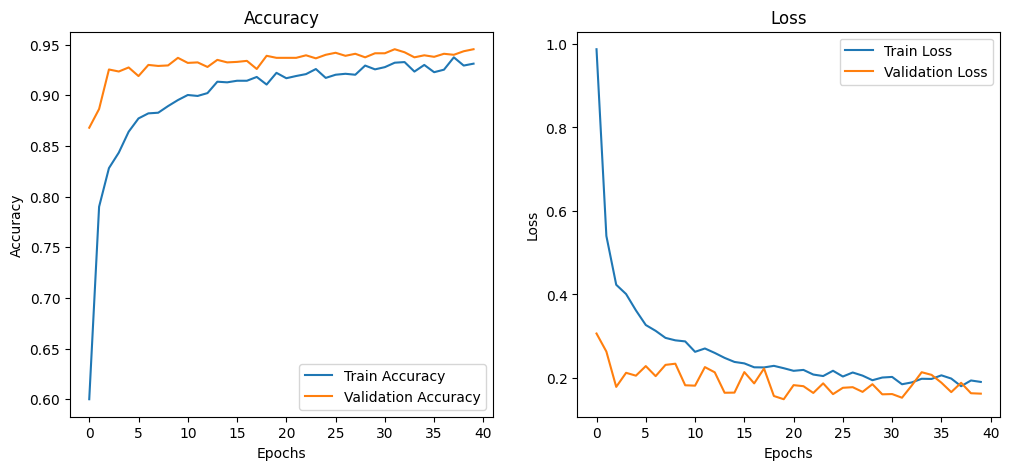

In [10]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
# Guardar el modelo
model.save("mobilenetv2_gastro_model.h5")
print("Modelo guardado")

Modelo guardado


In [12]:
# Evaluar en el conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


  1/100 [..............................] - ETA: 7s - loss: 0.0511 - accuracy: 1.0000


  3/100 [..............................] - ETA: 3s - loss: 0.0974 - accuracy: 0.9583


  5/100 [>.............................] - ETA: 3s - loss: 0.0663 - accuracy: 0.9750


  8/100 [=>............................] - ETA: 2s - loss: 0.1011 - accuracy: 0.9531


 12/100 [==>...........................] - ETA: 2s - loss: 0.1315 - accuracy: 0.9479


 16/100 [===>..........................] - ETA: 1s - loss: 0.1163 - accuracy: 0.9531


 20/100 [=====>........................] - ETA: 1s - loss: 0.1601 - accuracy: 0.9375


 24/100 [======>.......................] - ETA: 1s - loss: 0.1827 - accuracy: 0.9271


 27/100 [=======>......................] - ETA: 1s - loss: 0.1831 - accuracy: 0.9259


 29/100 [=======>......................] - ETA: 1s - loss: 0.1720 - accuracy: 0.9310


 32/100 [========>.....................] - ETA: 1s - loss: 0.1697 - accuracy: 0.9297


 34/100 [=========>....................] - ETA: 1s - loss: 0.1679 - accuracy: 0.9301


 38/100 [==========>...................] - ETA: 1s - loss: 0.1511 - accuracy: 0.9375


 41/100 [===========>..................] - ETA: 1s - loss: 0.1583 - accuracy: 0.9299


 43/100 [===========>..................] - ETA: 1s - loss: 0.1649 - accuracy: 0.9302


 46/100 [============>.................] - ETA: 1s - loss: 0.1830 - accuracy: 0.9239


 48/100 [=============>................] - ETA: 1s - loss: 0.1792 - accuracy: 0.9245


 50/100 [==============>...............] - ETA: 1s - loss: 0.2015 - accuracy: 0.9225


 52/100 [==============>...............] - ETA: 1s - loss: 0.1941 - accuracy: 0.9255


 54/100 [===============>..............] - ETA: 1s - loss: 0.1966 - accuracy: 0.9236


 56/100 [===============>..............] - ETA: 1s - loss: 0.1922 - accuracy: 0.9241


 58/100 [================>.............] - ETA: 1s - loss: 0.1856 - accuracy: 0.9267


 61/100 [=================>............] - ETA: 0s - loss: 0.1766 - accuracy: 0.9303


 64/100 [==================>...........] - ETA: 0s - loss: 0.1688 - accuracy: 0.9336


 66/100 [==================>...........] - ETA: 0s - loss: 0.1670 - accuracy: 0.9337


 69/100 [===================>..........] - ETA: 0s - loss: 0.1616 - accuracy: 0.9366


 71/100 [====================>.........] - ETA: 0s - loss: 0.1571 - accuracy: 0.9384


 73/100 [====================>.........] - ETA: 0s - loss: 0.1530 - accuracy: 0.9401


 75/100 [=====================>........] - ETA: 0s - loss: 0.1567 - accuracy: 0.9383


 76/100 [=====================>........] - ETA: 0s - loss: 0.1547 - accuracy: 0.9391


 77/100 [======================>.......] - ETA: 0s - loss: 0.1527 - accuracy: 0.9399


 78/100 [======================>.......] - ETA: 0s - loss: 0.1508 - accuracy: 0.9407


 79/100 [======================>.......] - ETA: 0s - loss: 0.1489 - accuracy: 0.9415


 80/100 [=======================>......] - ETA: 0s - loss: 0.1470 - accuracy: 0.9422


 81/100 [=======================>......] - ETA: 0s - loss: 0.1452 - accuracy: 0.9429


 82/100 [=======================>......] - ETA: 0s - loss: 0.1434 - accuracy: 0.9436


 83/100 [=======================>......] - ETA: 0s - loss: 0.1418 - accuracy: 0.9443


 84/100 [========================>.....] - ETA: 0s - loss: 0.1401 - accuracy: 0.9449


 85/100 [========================>.....] - ETA: 0s - loss: 0.1385 - accuracy: 0.9456


 86/100 [========================>.....] - ETA: 0s - loss: 0.1369 - accuracy: 0.9462


 87/100 [=========================>....] - ETA: 0s - loss: 0.1353 - accuracy: 0.9468


 88/100 [=========================>....] - ETA: 0s - loss: 0.1338 - accuracy: 0.9474


 89/100 [=========================>....] - ETA: 0s - loss: 0.1323 - accuracy: 0.9480


 90/100 [==========================>...] - ETA: 0s - loss: 0.1308 - accuracy: 0.9486


 91/100 [==========================>...] - ETA: 0s - loss: 0.1294 - accuracy: 0.9492


 92/100 [==========================>...] - ETA: 0s - loss: 0.1280 - accuracy: 0.9497


 93/100 [==========================>...] - ETA: 0s - loss: 0.1266 - accuracy: 0.9503


 94/100 [===========================>..] - ETA: 0s - loss: 0.1252 - accuracy: 0.9508


 95/100 [===========================>..] - ETA: 0s - loss: 0.1239 - accuracy: 0.9513


 96/100 [===========================>..] - ETA: 0s - loss: 0.1227 - accuracy: 0.9518


 97/100 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9523


 98/100 [============================>.] - ETA: 0s - loss: 0.1202 - accuracy: 0.9528


 99/100 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9533


100/100 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9538


100/100 [==============================] - 4s 39ms/step - loss: 0.1178 - accuracy: 0.9538


Test Accuracy: 95.38%



  1/250 [..............................] - ETA: 15s - loss: 0.3126 - accuracy: 0.7500


  5/250 [..............................] - ETA: 3s - loss: 0.1856 - accuracy: 0.8750 


  9/250 [>.............................] - ETA: 3s - loss: 0.1519 - accuracy: 0.8889


 13/250 [>.............................] - ETA: 3s - loss: 0.1457 - accuracy: 0.9135


 17/250 [=>............................] - ETA: 3s - loss: 0.1579 - accuracy: 0.9191


 21/250 [=>............................] - ETA: 3s - loss: 0.1733 - accuracy: 0.9048


 25/250 [==>...........................] - ETA: 3s - loss: 0.1998 - accuracy: 0.9000


 29/250 [==>...........................] - ETA: 3s - loss: 0.1913 - accuracy: 0.9009


 33/250 [==>...........................] - ETA: 3s - loss: 0.1801 - accuracy: 0.9015


 37/250 [===>..........................] - ETA: 3s - loss: 0.1781 - accuracy: 0.9054


 41/250 [===>..........................] - ETA: 3s - loss: 0.1956 - accuracy: 0.8994


 44/250 [====>.........................] - ETA: 3s - loss: 0.1981 - accuracy: 0.9006


 48/250 [====>.........................] - ETA: 3s - loss: 0.1929 - accuracy: 0.9036


 52/250 [=====>........................] - ETA: 3s - loss: 0.2145 - accuracy: 0.8918


 56/250 [=====>........................] - ETA: 3s - loss: 0.2175 - accuracy: 0.8906


 59/250 [======>.......................] - ETA: 3s - loss: 0.2246 - accuracy: 0.8898


 63/250 [======>.......................] - ETA: 2s - loss: 0.2191 - accuracy: 0.8909


 65/250 [======>.......................] - ETA: 3s - loss: 0.2150 - accuracy: 0.8942


 68/250 [=======>......................] - ETA: 3s - loss: 0.2358 - accuracy: 0.8897


 70/250 [=======>......................] - ETA: 3s - loss: 0.2419 - accuracy: 0.8875


 72/250 [=======>......................] - ETA: 3s - loss: 0.2462 - accuracy: 0.8872


 75/250 [========>.....................] - ETA: 3s - loss: 0.2457 - accuracy: 0.8833


 77/250 [========>.....................] - ETA: 3s - loss: 0.2448 - accuracy: 0.8831


 79/250 [========>.....................] - ETA: 3s - loss: 0.2477 - accuracy: 0.8797


 82/250 [========>.....................] - ETA: 3s - loss: 0.2443 - accuracy: 0.8826


 84/250 [=========>....................] - ETA: 3s - loss: 0.2401 - accuracy: 0.8839


 86/250 [=========>....................] - ETA: 3s - loss: 0.2372 - accuracy: 0.8852


 88/250 [=========>....................] - ETA: 3s - loss: 0.2343 - accuracy: 0.8864


 90/250 [=========>....................] - ETA: 3s - loss: 0.2343 - accuracy: 0.8861


 92/250 [==========>...................] - ETA: 3s - loss: 0.2402 - accuracy: 0.8859


 94/250 [==========>...................] - ETA: 3s - loss: 0.2369 - accuracy: 0.8870


 96/250 [==========>...................] - ETA: 3s - loss: 0.2379 - accuracy: 0.8867


 98/250 [==========>...................] - ETA: 3s - loss: 0.2386 - accuracy: 0.8865


101/250 [===========>..................] - ETA: 3s - loss: 0.2356 - accuracy: 0.8874


103/250 [===========>..................] - ETA: 3s - loss: 0.2365 - accuracy: 0.8883


105/250 [===========>..................] - ETA: 3s - loss: 0.2479 - accuracy: 0.8857


107/250 [===========>..................] - ETA: 3s - loss: 0.2484 - accuracy: 0.8855


109/250 [============>.................] - ETA: 3s - loss: 0.2442 - accuracy: 0.8876


111/250 [============>.................] - ETA: 3s - loss: 0.2410 - accuracy: 0.8885


113/250 [============>.................] - ETA: 3s - loss: 0.2390 - accuracy: 0.8894


115/250 [============>.................] - ETA: 3s - loss: 0.2362 - accuracy: 0.8902


117/250 [=============>................] - ETA: 3s - loss: 0.2407 - accuracy: 0.8900


119/250 [=============>................] - ETA: 3s - loss: 0.2377 - accuracy: 0.8908


121/250 [=============>................] - ETA: 2s - loss: 0.2389 - accuracy: 0.8915


123/250 [=============>................] - ETA: 2s - loss: 0.2394 - accuracy: 0.8923


125/250 [==============>...............] - ETA: 2s - loss: 0.2437 - accuracy: 0.8920


127/250 [==============>...............] - ETA: 2s - loss: 0.2418 - accuracy: 0.8927


129/250 [==============>...............] - ETA: 2s - loss: 0.2383 - accuracy: 0.8944


131/250 [==============>...............] - ETA: 2s - loss: 0.2350 - accuracy: 0.8960


134/250 [===============>..............] - ETA: 2s - loss: 0.2311 - accuracy: 0.8974


137/250 [===============>..............] - ETA: 2s - loss: 0.2275 - accuracy: 0.8987


139/250 [===============>..............] - ETA: 2s - loss: 0.2281 - accuracy: 0.8993


141/250 [===============>..............] - ETA: 2s - loss: 0.2273 - accuracy: 0.8989


143/250 [================>.............] - ETA: 2s - loss: 0.2258 - accuracy: 0.8995


146/250 [================>.............] - ETA: 2s - loss: 0.2215 - accuracy: 0.9015


148/250 [================>.............] - ETA: 2s - loss: 0.2190 - accuracy: 0.9029


151/250 [=================>............] - ETA: 2s - loss: 0.2148 - accuracy: 0.9048


153/250 [=================>............] - ETA: 2s - loss: 0.2121 - accuracy: 0.9060


156/250 [=================>............] - ETA: 2s - loss: 0.2083 - accuracy: 0.9079


158/250 [=================>............] - ETA: 2s - loss: 0.2076 - accuracy: 0.9082


160/250 [==================>...........] - ETA: 2s - loss: 0.2077 - accuracy: 0.9078


163/250 [==================>...........] - ETA: 2s - loss: 0.2039 - accuracy: 0.9095


165/250 [==================>...........] - ETA: 2s - loss: 0.2043 - accuracy: 0.9098


167/250 [===================>..........] - ETA: 2s - loss: 0.2047 - accuracy: 0.9102


169/250 [===================>..........] - ETA: 2s - loss: 0.2072 - accuracy: 0.9098


171/250 [===================>..........] - ETA: 1s - loss: 0.2051 - accuracy: 0.9108


174/250 [===================>..........] - ETA: 1s - loss: 0.2050 - accuracy: 0.9109


176/250 [====================>.........] - ETA: 1s - loss: 0.2029 - accuracy: 0.9119


179/250 [====================>.........] - ETA: 1s - loss: 0.2040 - accuracy: 0.9127


181/250 [====================>.........] - ETA: 1s - loss: 0.2032 - accuracy: 0.9137


183/250 [====================>.........] - ETA: 1s - loss: 0.2018 - accuracy: 0.9146


186/250 [=====================>........] - ETA: 1s - loss: 0.1992 - accuracy: 0.9153


188/250 [=====================>........] - ETA: 1s - loss: 0.1974 - accuracy: 0.9162


189/250 [=====================>........] - ETA: 1s - loss: 0.1964 - accuracy: 0.9167


190/250 [=====================>........] - ETA: 1s - loss: 0.1954 - accuracy: 0.9171


191/250 [=====================>........] - ETA: 1s - loss: 0.1943 - accuracy: 0.9175


192/250 [======================>.......] - ETA: 1s - loss: 0.1933 - accuracy: 0.9180


193/250 [======================>.......] - ETA: 1s - loss: 0.1924 - accuracy: 0.9184


194/250 [======================>.......] - ETA: 1s - loss: 0.1917 - accuracy: 0.9188


195/250 [======================>.......] - ETA: 1s - loss: 0.1907 - accuracy: 0.9192


196/250 [======================>.......] - ETA: 1s - loss: 0.1897 - accuracy: 0.9196


197/250 [======================>.......] - ETA: 1s - loss: 0.1888 - accuracy: 0.9201


198/250 [======================>.......] - ETA: 1s - loss: 0.1878 - accuracy: 0.9205


199/250 [======================>.......] - ETA: 1s - loss: 0.1869 - accuracy: 0.9209


200/250 [=======================>......] - ETA: 1s - loss: 0.1859 - accuracy: 0.9212


201/250 [=======================>......] - ETA: 1s - loss: 0.1850 - accuracy: 0.9216


202/250 [=======================>......] - ETA: 1s - loss: 0.1841 - accuracy: 0.9220


203/250 [=======================>......] - ETA: 1s - loss: 0.1832 - accuracy: 0.9224


204/250 [=======================>......] - ETA: 1s - loss: 0.1823 - accuracy: 0.9228


205/250 [=======================>......] - ETA: 1s - loss: 0.1815 - accuracy: 0.9232


206/250 [=======================>......] - ETA: 1s - loss: 0.1806 - accuracy: 0.9235


207/250 [=======================>......] - ETA: 1s - loss: 0.1797 - accuracy: 0.9239


208/250 [=======================>......] - ETA: 1s - loss: 0.1789 - accuracy: 0.9243


209/250 [========================>.....] - ETA: 1s - loss: 0.1780 - accuracy: 0.9246


210/250 [========================>.....] - ETA: 1s - loss: 0.1772 - accuracy: 0.9250


211/250 [========================>.....] - ETA: 1s - loss: 0.1763 - accuracy: 0.9254


212/250 [========================>.....] - ETA: 1s - loss: 0.1755 - accuracy: 0.9257


213/250 [========================>.....] - ETA: 1s - loss: 0.1747 - accuracy: 0.9261


214/250 [========================>.....] - ETA: 1s - loss: 0.1739 - accuracy: 0.9264


215/250 [========================>.....] - ETA: 1s - loss: 0.1731 - accuracy: 0.9267


216/250 [========================>.....] - ETA: 1s - loss: 0.1723 - accuracy: 0.9271


217/250 [=========================>....] - ETA: 1s - loss: 0.1715 - accuracy: 0.9274


218/250 [=========================>....] - ETA: 1s - loss: 0.1707 - accuracy: 0.9278


219/250 [=========================>....] - ETA: 1s - loss: 0.1699 - accuracy: 0.9281


220/250 [=========================>....] - ETA: 0s - loss: 0.1692 - accuracy: 0.9284


221/250 [=========================>....] - ETA: 0s - loss: 0.1684 - accuracy: 0.9287


222/250 [=========================>....] - ETA: 0s - loss: 0.1676 - accuracy: 0.9291


223/250 [=========================>....] - ETA: 0s - loss: 0.1669 - accuracy: 0.9294


224/250 [=========================>....] - ETA: 0s - loss: 0.1661 - accuracy: 0.9297


225/250 [==========================>...] - ETA: 0s - loss: 0.1654 - accuracy: 0.9300


226/250 [==========================>...] - ETA: 0s - loss: 0.1647 - accuracy: 0.9303


227/250 [==========================>...] - ETA: 0s - loss: 0.1639 - accuracy: 0.9306


228/250 [==========================>...] - ETA: 0s - loss: 0.1632 - accuracy: 0.9309


229/250 [==========================>...] - ETA: 0s - loss: 0.1625 - accuracy: 0.9312


230/250 [==========================>...] - ETA: 0s - loss: 0.1618 - accuracy: 0.9315


231/250 [==========================>...] - ETA: 0s - loss: 0.1611 - accuracy: 0.9318


232/250 [==========================>...] - ETA: 0s - loss: 0.1604 - accuracy: 0.9321


233/250 [==========================>...] - ETA: 0s - loss: 0.1598 - accuracy: 0.9324


234/250 [===========================>..] - ETA: 0s - loss: 0.1591 - accuracy: 0.9327


235/250 [===========================>..] - ETA: 0s - loss: 0.1584 - accuracy: 0.9330


236/250 [===========================>..] - ETA: 0s - loss: 0.1577 - accuracy: 0.9333


237/250 [===========================>..] - ETA: 0s - loss: 0.1571 - accuracy: 0.9335


238/250 [===========================>..] - ETA: 0s - loss: 0.1564 - accuracy: 0.9338


239/250 [===========================>..] - ETA: 0s - loss: 0.1558 - accuracy: 0.9341


240/250 [===========================>..] - ETA: 0s - loss: 0.1551 - accuracy: 0.9344


241/250 [===========================>..] - ETA: 0s - loss: 0.1545 - accuracy: 0.9346


242/250 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9349


243/250 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9352


244/250 [============================>.] - ETA: 0s - loss: 0.1526 - accuracy: 0.9355


245/250 [============================>.] - ETA: 0s - loss: 0.1520 - accuracy: 0.9357


246/250 [============================>.] - ETA: 0s - loss: 0.1514 - accuracy: 0.9360


247/250 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9362


248/250 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9365


249/250 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9367


250/250 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9370


250/250 [==============================] - 9s 38ms/step - loss: 0.1489 - accuracy: 0.9370


Validation Accuracy: 93.70%


In [13]:
# Cargar el modelo guardado y probarlo
test_model = keras.models.load_model("mobilenetv2_gastro_model.h5")

In [14]:
# Obtener predicciones para validación
y_true_val = val_generator.classes
y_pred_val = np.argmax(test_model.predict(val_generator), axis=1)

# Obtener predicciones para test
y_true_test = test_generator.classes
y_pred_test = np.argmax(test_model.predict(test_generator), axis=1)

# Reporte de clasificación para validación
print("\nValidation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

# Reporte de clasificación para test
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_generator.class_indices.keys()))


  1/250 [..............................] - ETA: 1:45


  3/250 [..............................] - ETA: 9s  


  5/250 [..............................] - ETA: 9s


  7/250 [..............................] - ETA: 9s


 10/250 [>.............................] - ETA: 7s


 13/250 [>.............................] - ETA: 7s


 17/250 [=>............................] - ETA: 5s


 20/250 [=>............................] - ETA: 5s


 24/250 [=>............................] - ETA: 5s


 28/250 [==>...........................] - ETA: 4s


 32/250 [==>...........................] - ETA: 4s


 36/250 [===>..........................] - ETA: 4s


 40/250 [===>..........................] - ETA: 4s


 43/250 [====>.........................] - ETA: 4s


 47/250 [====>.........................] - ETA: 3s


 51/250 [=====>........................] - ETA: 3s


 54/250 [=====>........................] - ETA: 3s


 58/250 [=====>........................] - ETA: 3s


 62/250 [======>.......................] - ETA: 3s


 65/250 [======>.......................] - ETA: 3s


 67/250 [=======>......................] - ETA: 3s


 69/250 [=======>......................] - ETA: 3s


 71/250 [=======>......................] - ETA: 3s


 73/250 [=======>......................] - ETA: 3s


 75/250 [========>.....................] - ETA: 3s


 77/250 [========>.....................] - ETA: 3s


 79/250 [========>.....................] - ETA: 3s


 81/250 [========>.....................] - ETA: 3s


 83/250 [========>.....................] - ETA: 3s


 85/250 [=========>....................] - ETA: 3s


 87/250 [=========>....................] - ETA: 3s


 90/250 [=========>....................] - ETA: 3s


 92/250 [==========>...................] - ETA: 3s


 94/250 [==========>...................] - ETA: 3s


 96/250 [==========>...................] - ETA: 3s


 98/250 [==========>...................] - ETA: 3s


100/250 [===========>..................] - ETA: 3s


102/250 [===========>..................] - ETA: 3s


104/250 [===========>..................] - ETA: 3s


106/250 [===========>..................] - ETA: 3s


108/250 [===========>..................] - ETA: 3s


110/250 [============>.................] - ETA: 3s


112/250 [============>.................] - ETA: 3s


114/250 [============>.................] - ETA: 3s


116/250 [============>.................] - ETA: 3s


118/250 [=============>................] - ETA: 3s


121/250 [=============>................] - ETA: 3s


123/250 [=============>................] - ETA: 3s


126/250 [==============>...............] - ETA: 2s


128/250 [==============>...............] - ETA: 2s


131/250 [==============>...............] - ETA: 2s


133/250 [==============>...............] - ETA: 2s


136/250 [===============>..............] - ETA: 2s


139/250 [===============>..............] - ETA: 2s


141/250 [===============>..............] - ETA: 2s


143/250 [================>.............] - ETA: 2s


145/250 [================>.............] - ETA: 2s


147/250 [================>.............] - ETA: 2s


150/250 [=================>............] - ETA: 2s


152/250 [=================>............] - ETA: 2s


155/250 [=================>............] - ETA: 2s


157/250 [=================>............] - ETA: 2s


159/250 [==================>...........] - ETA: 2s


161/250 [==================>...........] - ETA: 2s


163/250 [==================>...........] - ETA: 2s


165/250 [==================>...........] - ETA: 2s


167/250 [===================>..........] - ETA: 2s


169/250 [===================>..........] - ETA: 2s


171/250 [===================>..........] - ETA: 1s


173/250 [===================>..........] - ETA: 1s


175/250 [====================>.........] - ETA: 1s


177/250 [====================>.........] - ETA: 1s


179/250 [====================>.........] - ETA: 1s


181/250 [====================>.........] - ETA: 1s


183/250 [====================>.........] - ETA: 1s


185/250 [=====================>........] - ETA: 1s


187/250 [=====================>........] - ETA: 1s


188/250 [=====================>........] - ETA: 1s


189/250 [=====================>........] - ETA: 1s


190/250 [=====================>........] - ETA: 1s


191/250 [=====================>........] - ETA: 1s


192/250 [======================>.......] - ETA: 1s


193/250 [======================>.......] - ETA: 1s


194/250 [======================>.......] - ETA: 1s


195/250 [======================>.......] - ETA: 1s


196/250 [======================>.......] - ETA: 1s


197/250 [======================>.......] - ETA: 1s


198/250 [======================>.......] - ETA: 1s


199/250 [======================>.......] - ETA: 1s


200/250 [=======================>......] - ETA: 1s


201/250 [=======================>......] - ETA: 1s


202/250 [=======================>......] - ETA: 1s


203/250 [=======================>......] - ETA: 1s


204/250 [=======================>......] - ETA: 1s


205/250 [=======================>......] - ETA: 1s


206/250 [=======================>......] - ETA: 1s


207/250 [=======================>......] - ETA: 1s


208/250 [=======================>......] - ETA: 1s


209/250 [========================>.....] - ETA: 1s


210/250 [========================>.....] - ETA: 1s


211/250 [========================>.....] - ETA: 1s


212/250 [========================>.....] - ETA: 1s


213/250 [========================>.....] - ETA: 1s


214/250 [========================>.....] - ETA: 1s


215/250 [========================>.....] - ETA: 1s


216/250 [========================>.....] - ETA: 1s


217/250 [=========================>....] - ETA: 1s


218/250 [=========================>....] - ETA: 1s


219/250 [=========================>....] - ETA: 1s


220/250 [=========================>....] - ETA: 0s


221/250 [=========================>....] - ETA: 0s


222/250 [=========================>....] - ETA: 0s


223/250 [=========================>....] - ETA: 0s


224/250 [=========================>....] - ETA: 0s


225/250 [==========================>...] - ETA: 0s


226/250 [==========================>...] - ETA: 0s


227/250 [==========================>...] - ETA: 0s


228/250 [==========================>...] - ETA: 0s


229/250 [==========================>...] - ETA: 0s


230/250 [==========================>...] - ETA: 0s


231/250 [==========================>...] - ETA: 0s


232/250 [==========================>...] - ETA: 0s


233/250 [==========================>...] - ETA: 0s


234/250 [===========================>..] - ETA: 0s


235/250 [===========================>..] - ETA: 0s


236/250 [===========================>..] - ETA: 0s


237/250 [===========================>..] - ETA: 0s


238/250 [===========================>..] - ETA: 0s


239/250 [===========================>..] - ETA: 0s


240/250 [===========================>..] - ETA: 0s


241/250 [===========================>..] - ETA: 0s


242/250 [============================>.] - ETA: 0s


243/250 [============================>.] - ETA: 0s


244/250 [============================>.] - ETA: 0s


245/250 [============================>.] - ETA: 0s


246/250 [============================>.] - ETA: 0s


247/250 [============================>.] - ETA: 0s


248/250 [============================>.] - ETA: 0s


249/250 [============================>.] - ETA: 0s


250/250 [==============================] - ETA: 0s


250/250 [==============================] - 10s 38ms/step



  1/100 [..............................] - ETA: 4s


  5/100 [>.............................] - ETA: 1s


  9/100 [=>............................] - ETA: 1s


 13/100 [==>...........................] - ETA: 1s


 17/100 [====>.........................] - ETA: 1s


 21/100 [=====>........................] - ETA: 1s


 25/100 [======>.......................] - ETA: 1s


 27/100 [=======>......................] - ETA: 1s


 29/100 [=======>......................] - ETA: 1s


 32/100 [========>.....................] - ETA: 1s


 34/100 [=========>....................] - ETA: 1s


 37/100 [==========>...................] - ETA: 1s


 39/100 [==========>...................] - ETA: 1s


 42/100 [===========>..................] - ETA: 1s


 45/100 [============>.................] - ETA: 1s


 47/100 [=============>................] - ETA: 1s


 49/100 [=============>................] - ETA: 1s


 51/100 [==============>...............] - ETA: 1s


 53/100 [==============>...............] - ETA: 1s


 55/100 [===============>..............] - ETA: 1s


 57/100 [================>.............] - ETA: 0s


 60/100 [=================>............] - ETA: 0s


 62/100 [=================>............] - ETA: 0s


 64/100 [==================>...........] - ETA: 0s


 66/100 [==================>...........] - ETA: 0s


 69/100 [===================>..........] - ETA: 0s


 71/100 [====================>.........] - ETA: 0s


 73/100 [====================>.........] - ETA: 0s


 75/100 [=====================>........] - ETA: 0s


 76/100 [=====================>........] - ETA: 0s


 77/100 [======================>.......] - ETA: 0s


 78/100 [======================>.......] - ETA: 0s


 79/100 [======================>.......] - ETA: 0s


 80/100 [=======================>......] - ETA: 0s


 81/100 [=======================>......] - ETA: 0s


 82/100 [=======================>......] - ETA: 0s


 83/100 [=======================>......] - ETA: 0s


 84/100 [========================>.....] - ETA: 0s


 85/100 [========================>.....] - ETA: 0s


 86/100 [========================>.....] - ETA: 0s


 87/100 [=========================>....] - ETA: 0s


 88/100 [=========================>....] - ETA: 0s


 89/100 [=========================>....] - ETA: 0s


 90/100 [==========================>...] - ETA: 0s


 91/100 [==========================>...] - ETA: 0s


 92/100 [==========================>...] - ETA: 0s


 93/100 [==========================>...] - ETA: 0s


 94/100 [===========================>..] - ETA: 0s


 95/100 [===========================>..] - ETA: 0s


 96/100 [===========================>..] - ETA: 0s


 97/100 [============================>.] - ETA: 0s


 98/100 [============================>.] - ETA: 0s


 99/100 [============================>.] - ETA: 0s


100/100 [==============================] - ETA: 0s


100/100 [==============================] - 4s 37ms/step



Validation Classification Report:


                      precision    recall  f1-score   support

            0_normal       0.99      0.89      0.94       500
1_ulcerative_colitis       0.88      0.89      0.89       500
            2_polyps       0.90      0.96      0.93       500
       3_esophagitis       0.98      1.00      0.99       500

            accuracy                           0.94      2000
           macro avg       0.94      0.94      0.94      2000
        weighted avg       0.94      0.94      0.94      2000


Test Classification Report:
                      precision    recall  f1-score   support

            0_normal       1.00      0.93      0.96       200
1_ulcerative_colitis       0.92      0.92      0.92       200
            2_polyps       0.92      0.97      0.94       200
       3_esophagitis       0.99      1.00      0.99       200

            accuracy                           0.95       800
           macro avg       0.96      0.95      0.95       800
        weighted avg       0.96     

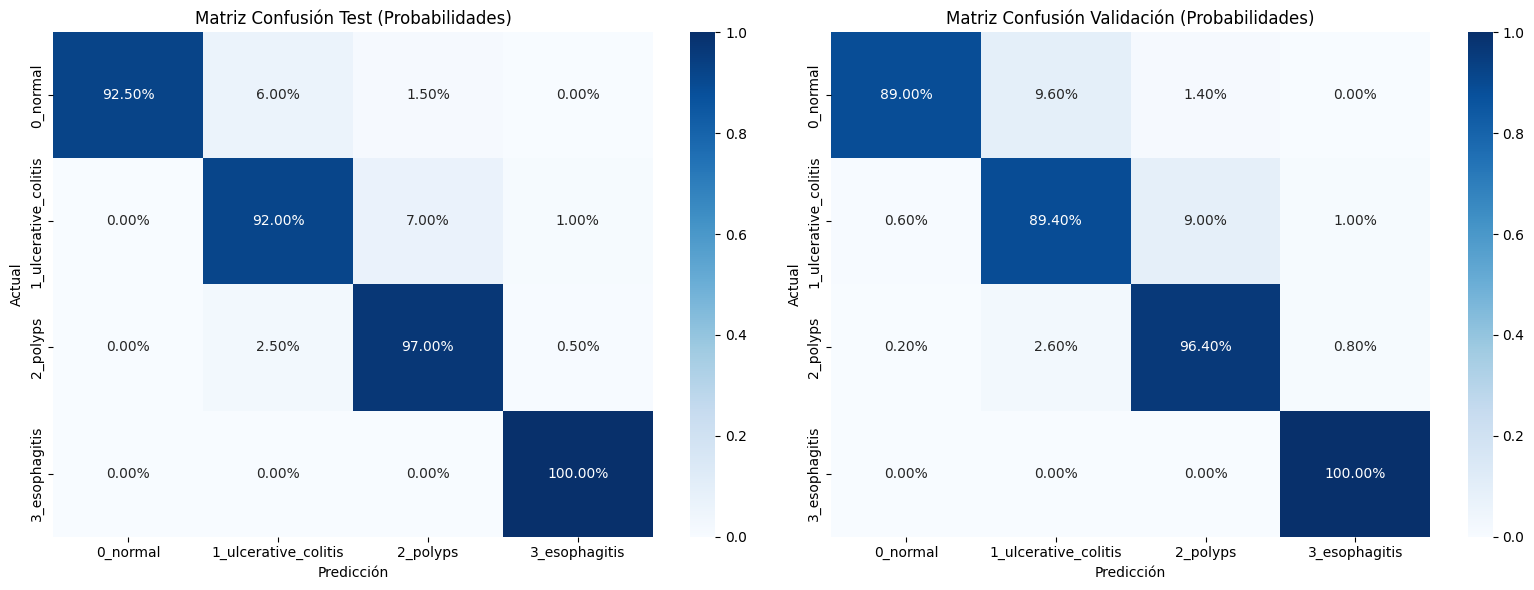

In [15]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matriz de confusión para el conjunto de test
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_test_prob = confusion_matrix_prob(cm_test)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Test (Probabilidades)')

# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_val_prob = confusion_matrix_prob(cm_val)
plt.subplot(1, 2, 2)
sns.heatmap(cm_val_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Validación (Probabilidades)')

plt.tight_layout()
plt.show()